# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


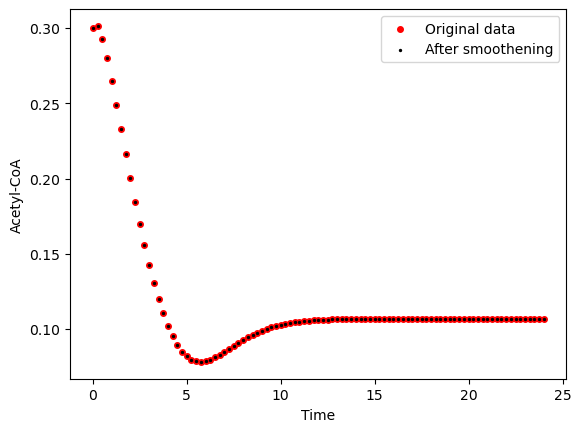

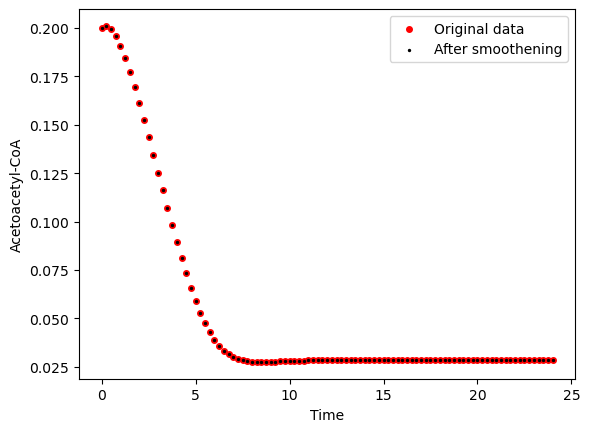

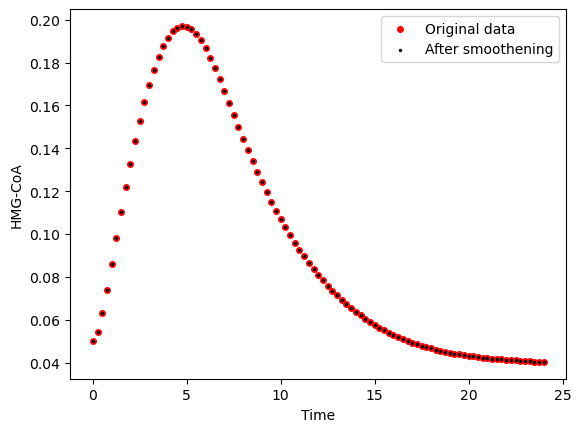

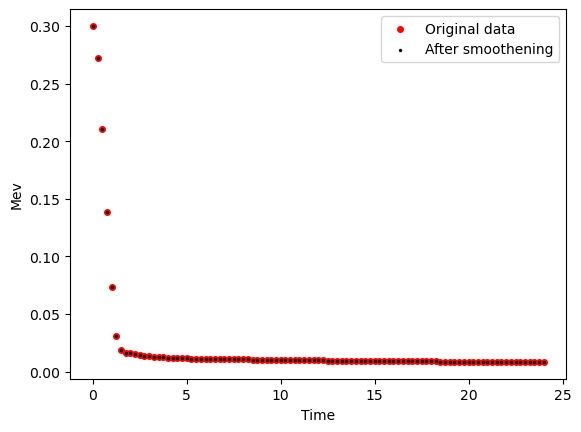

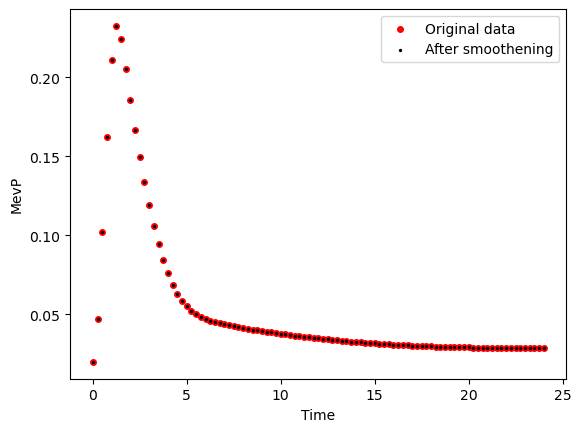

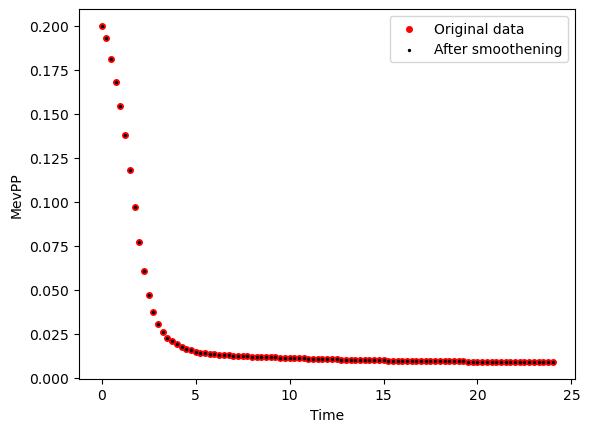

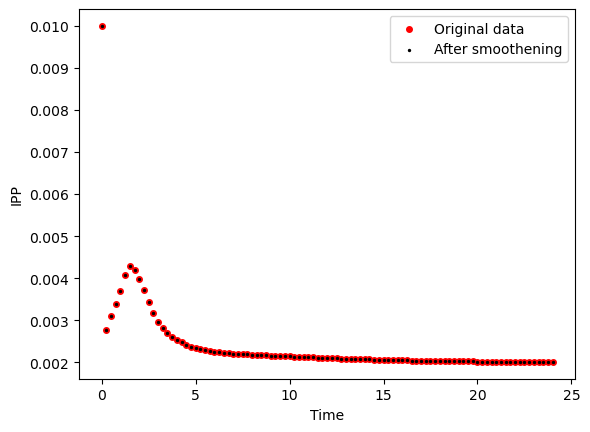

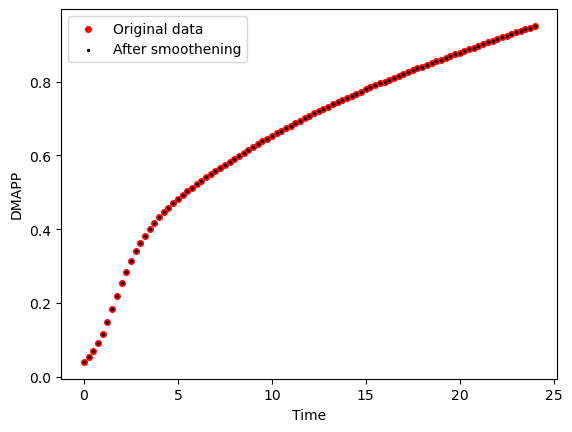

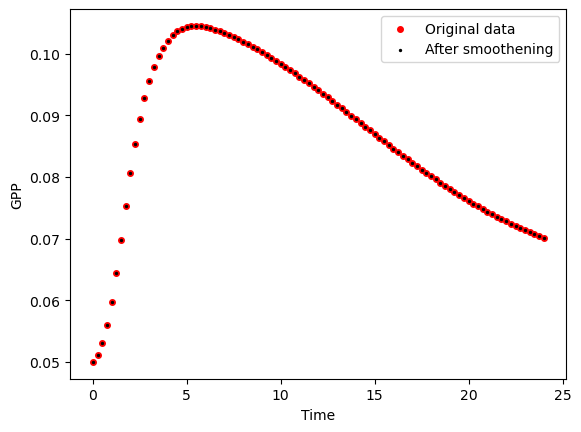

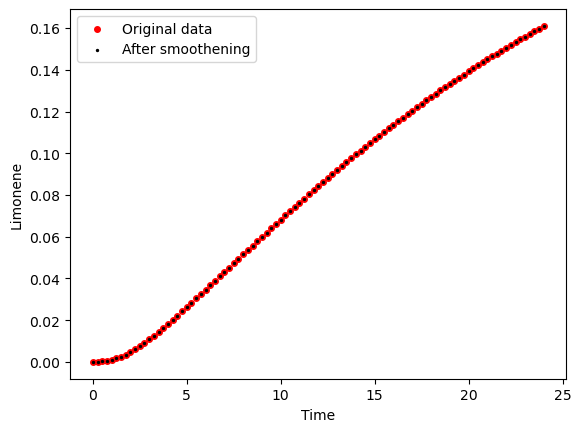

Strain Strain 2


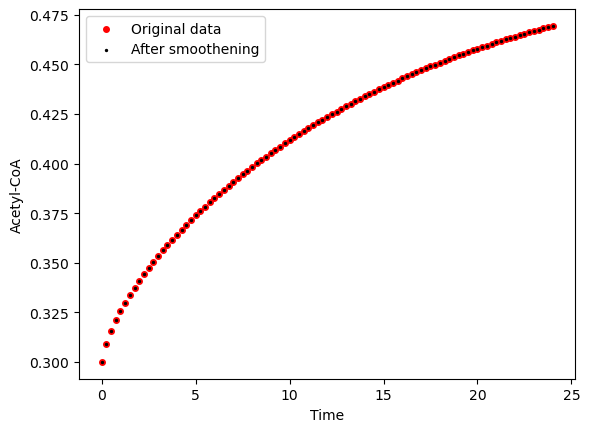

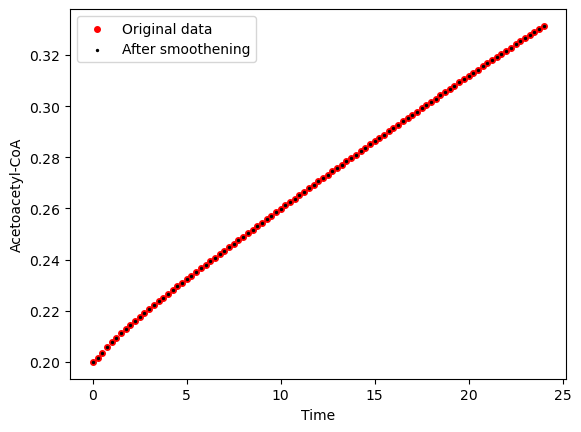

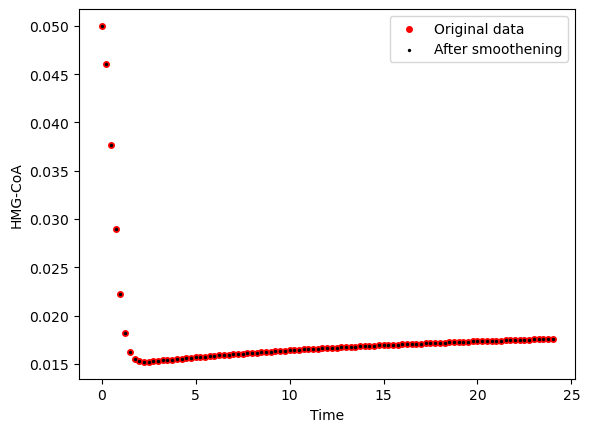

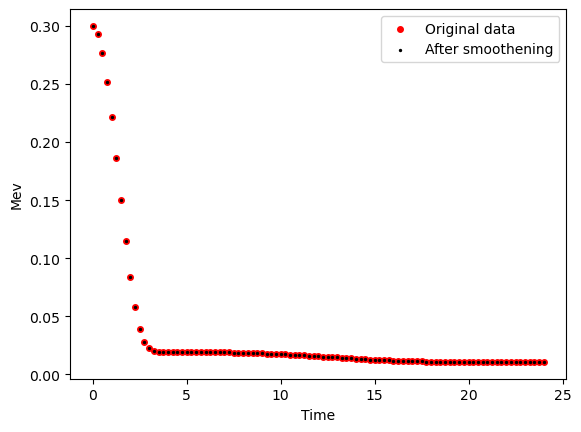

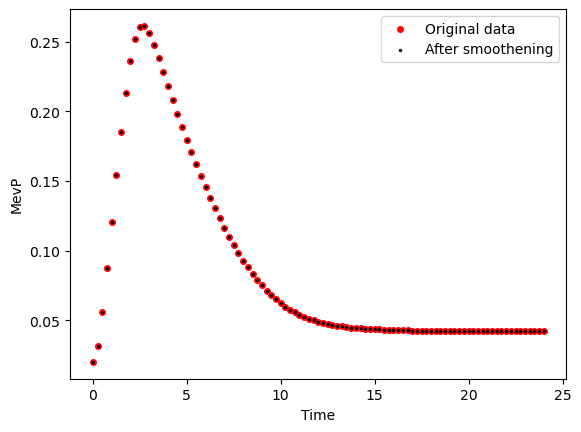

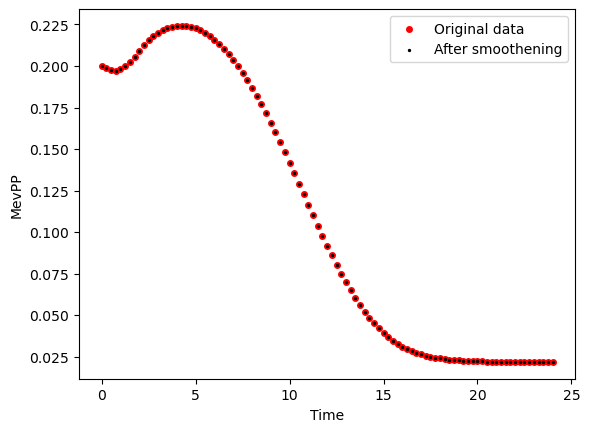

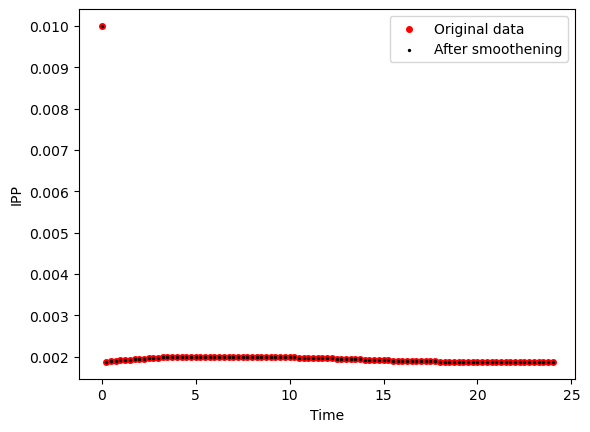

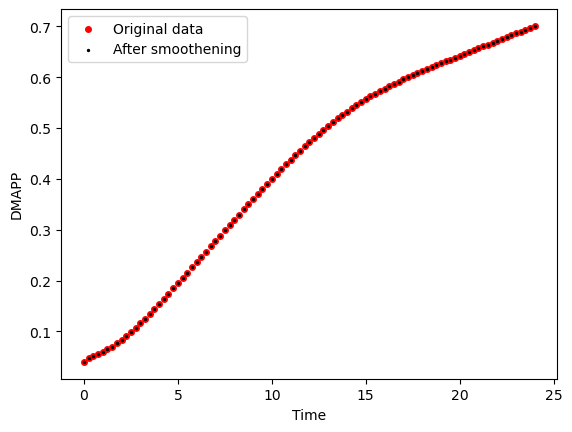

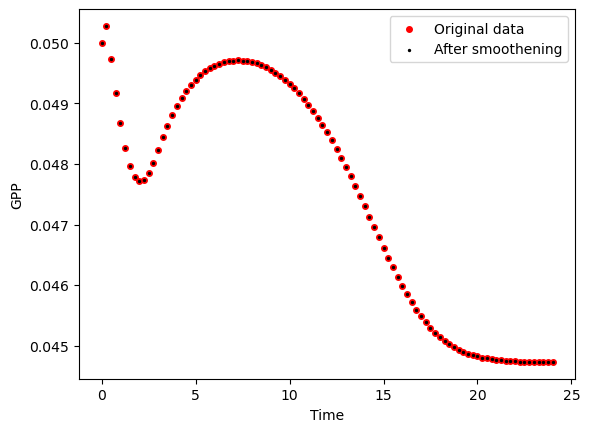

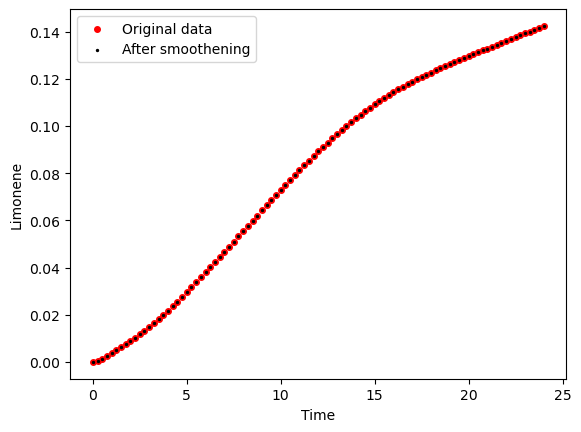

Strain Strain 3


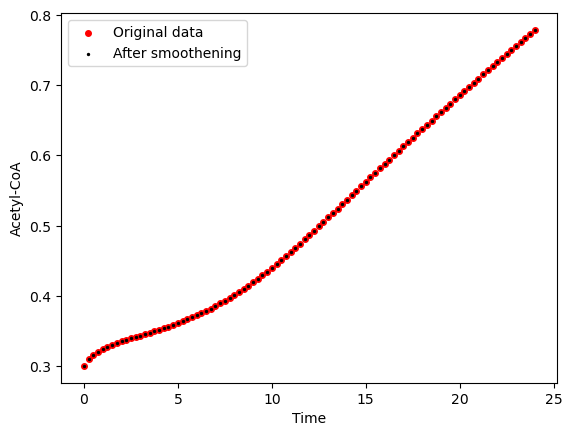

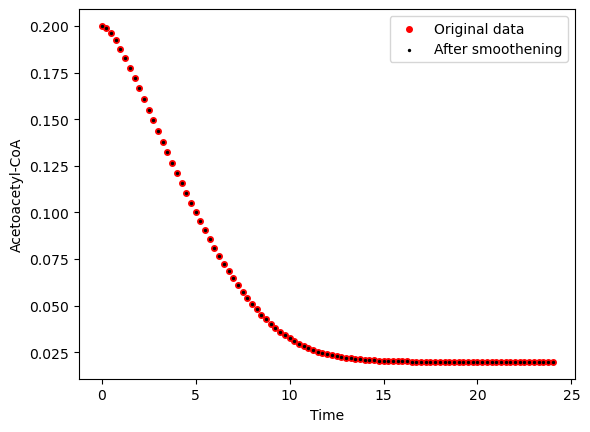

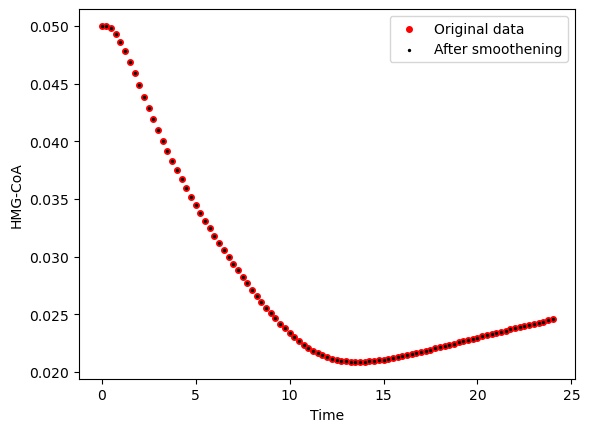

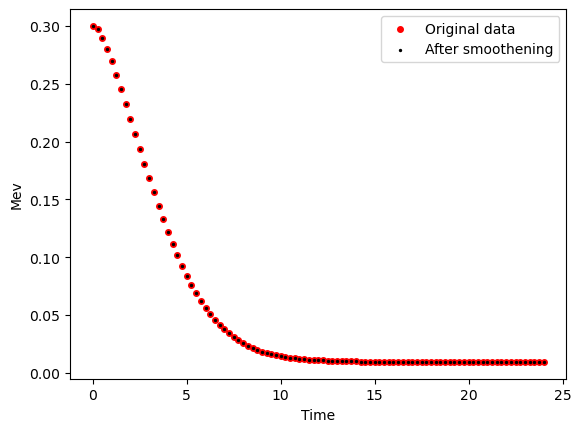

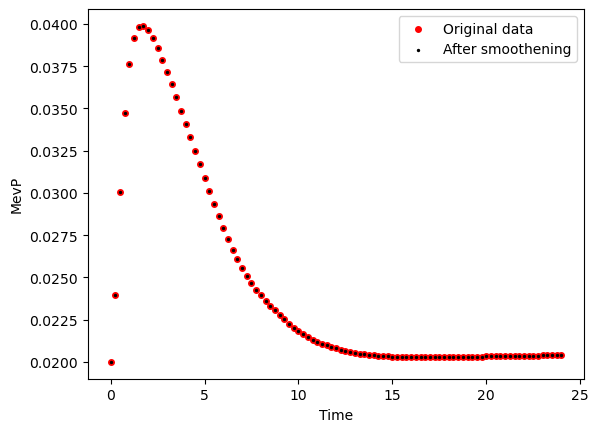

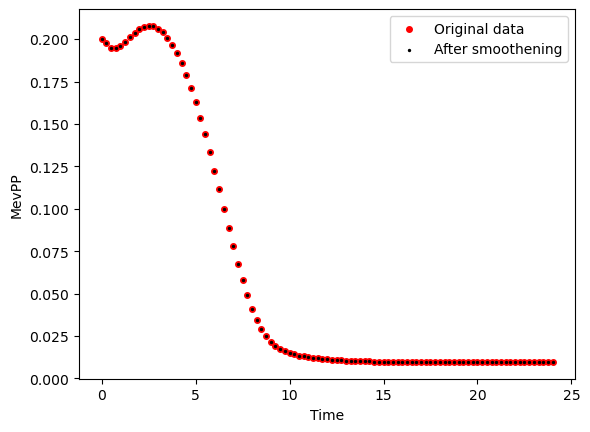

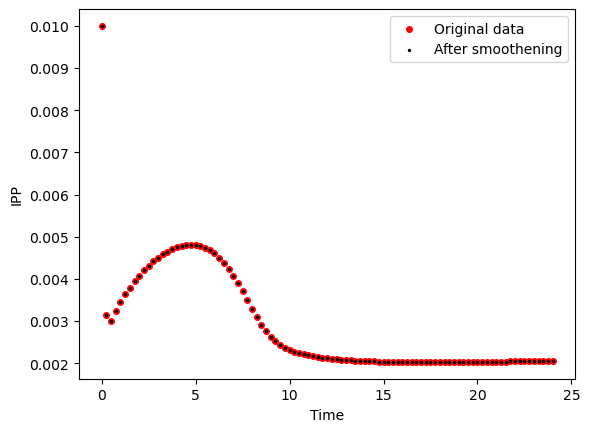

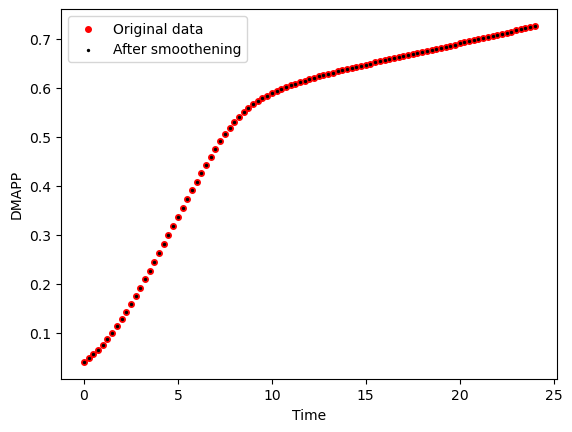

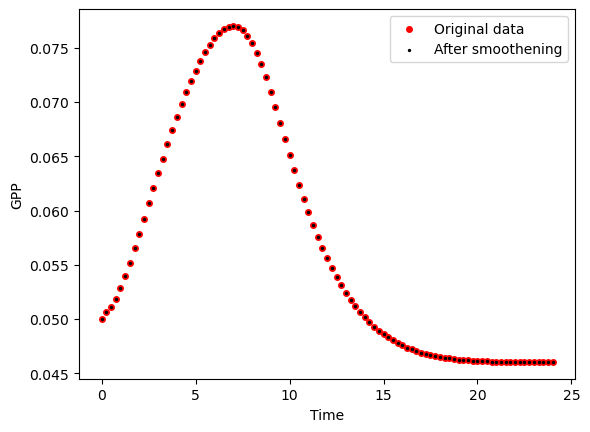

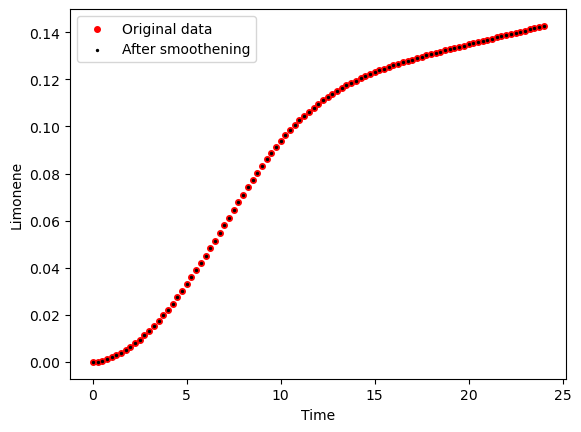

Strain WT


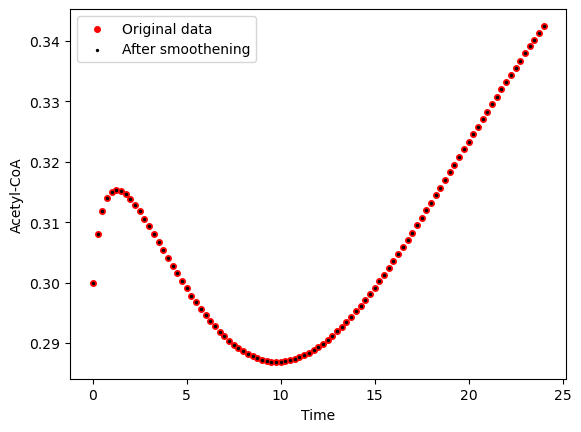

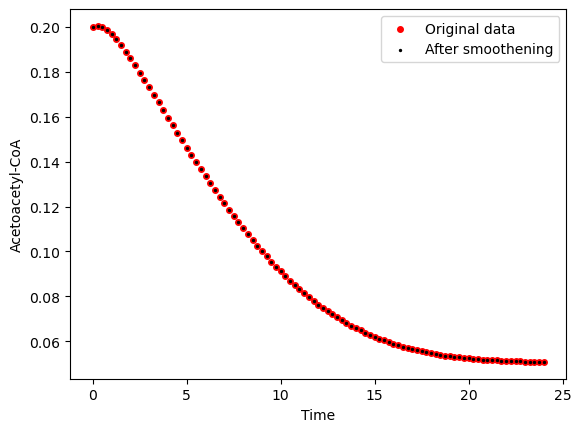

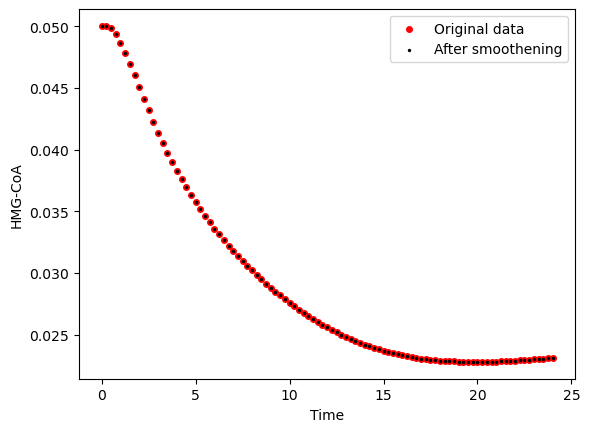

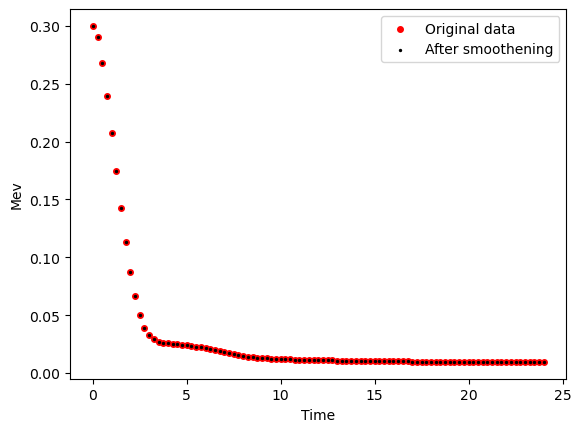

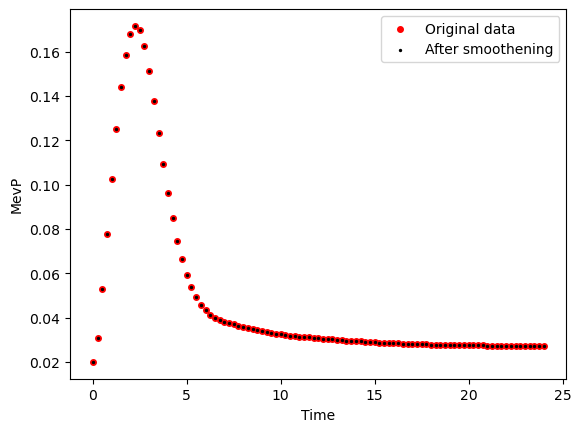

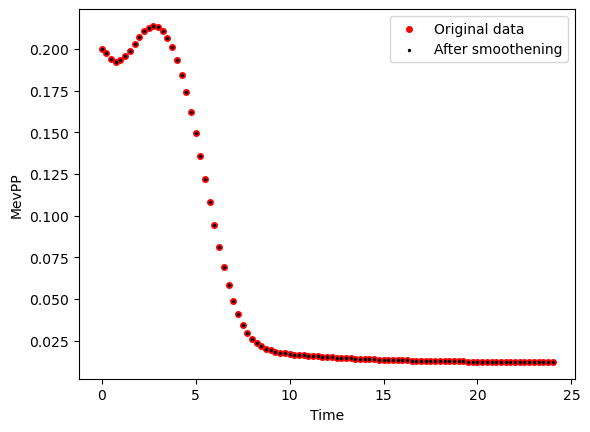

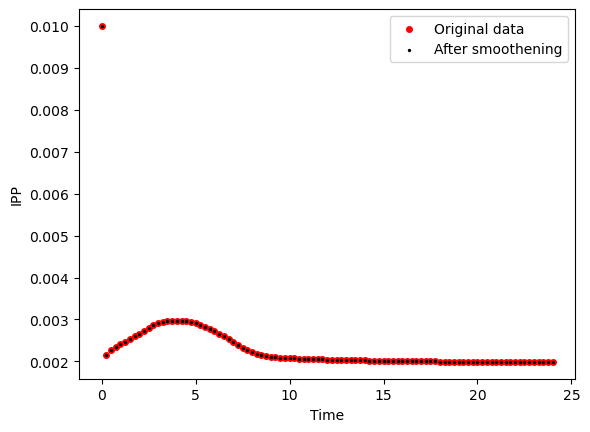

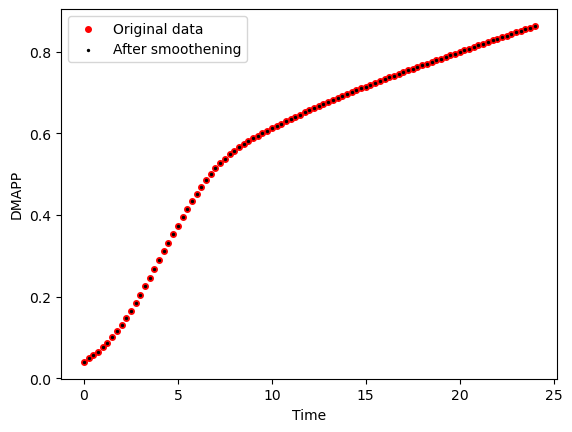

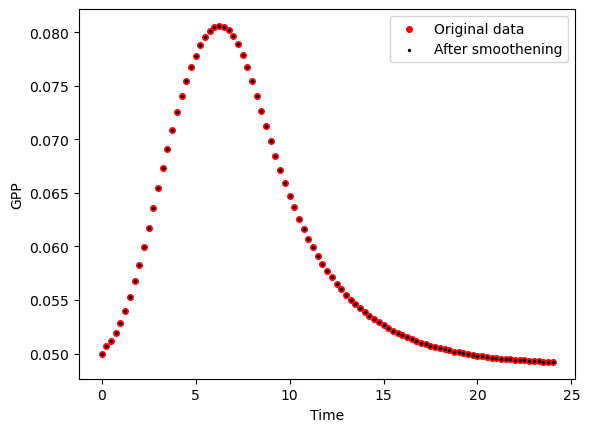

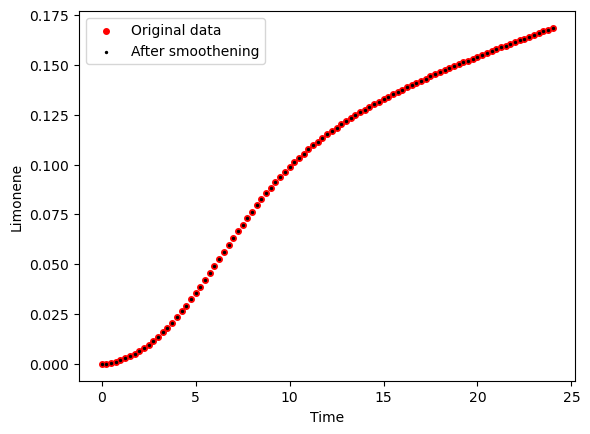

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


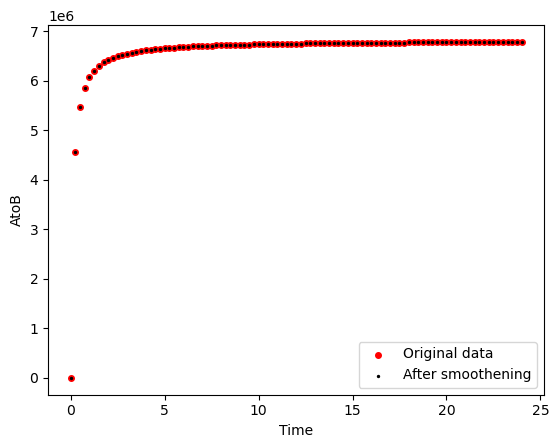

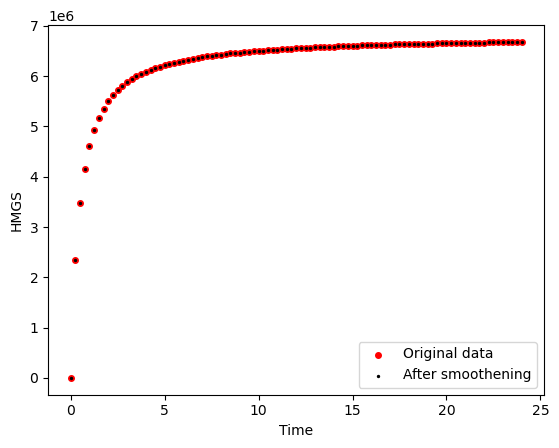

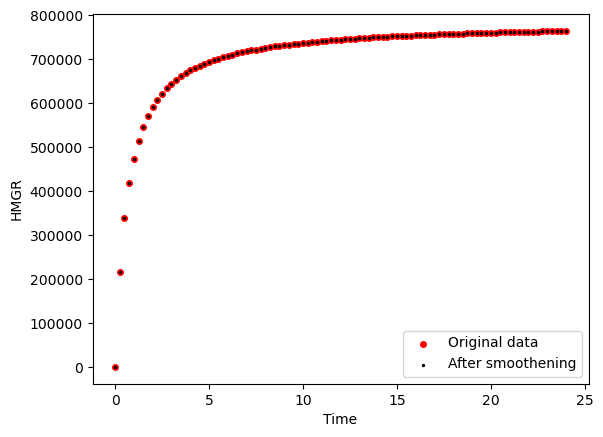

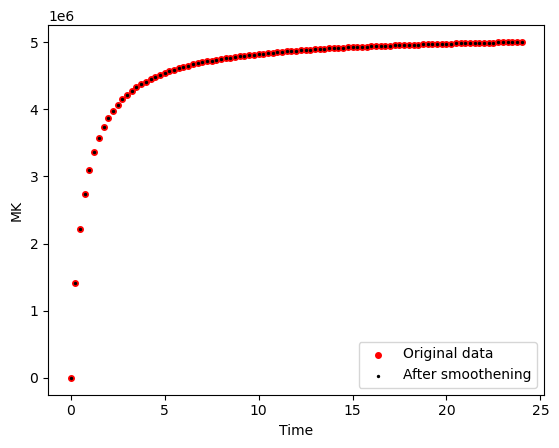

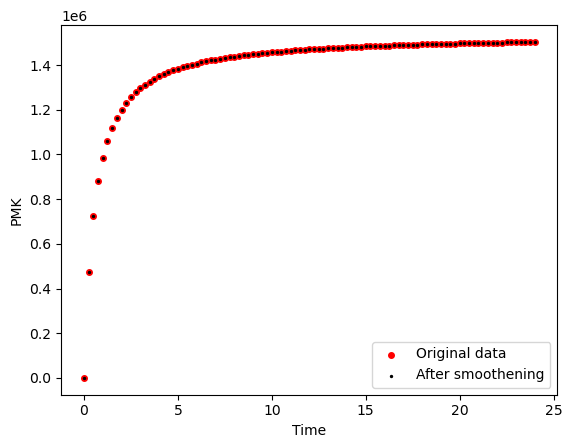

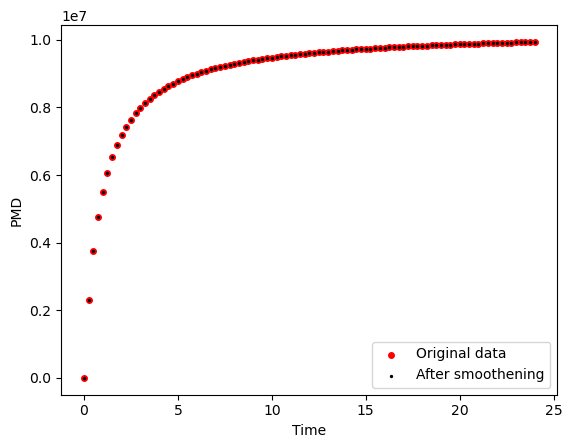

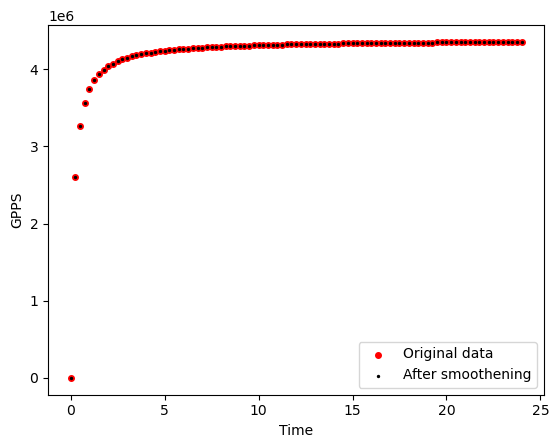

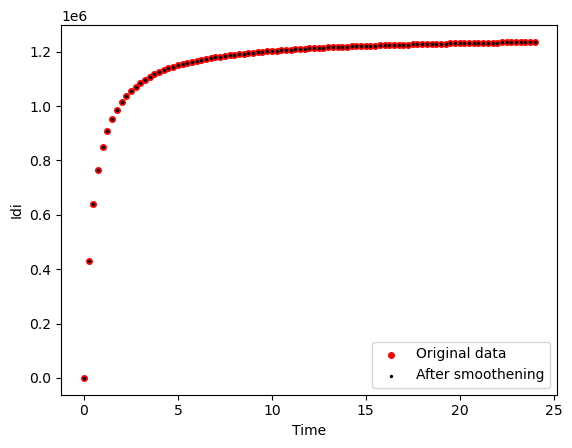

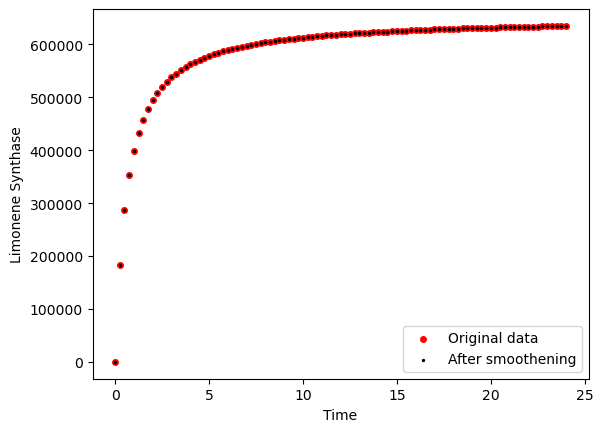

Strain Strain 2


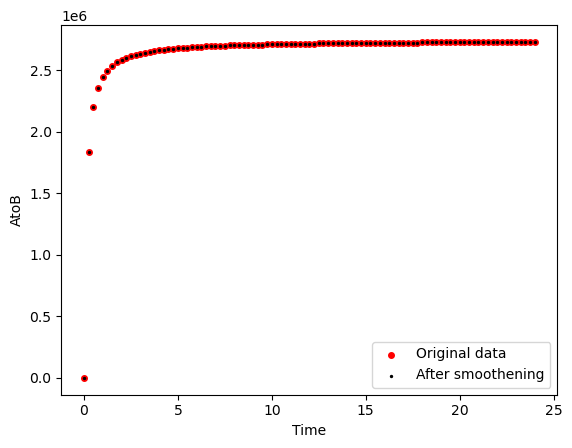

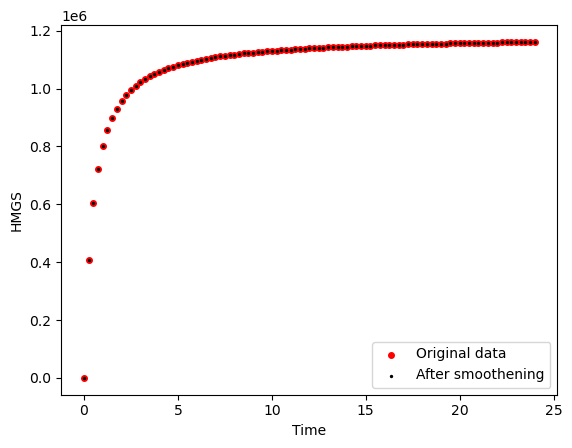

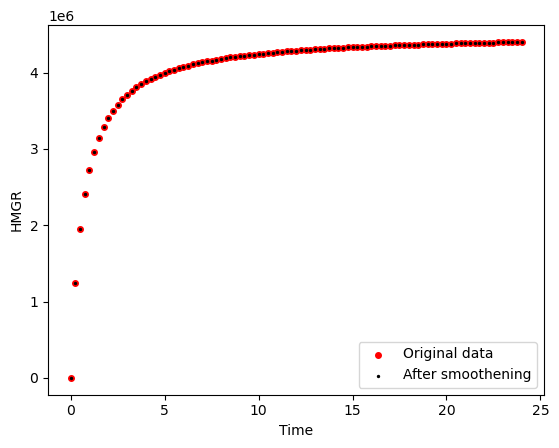

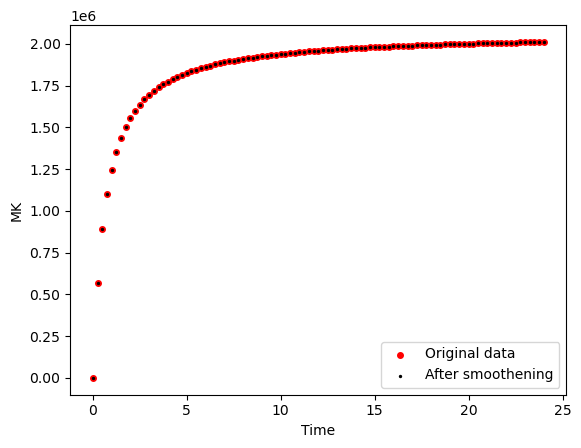

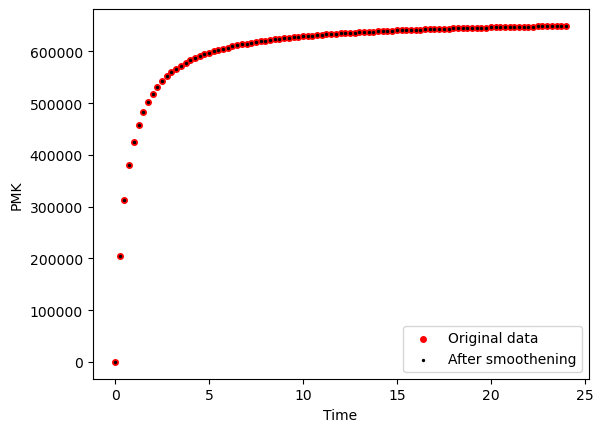

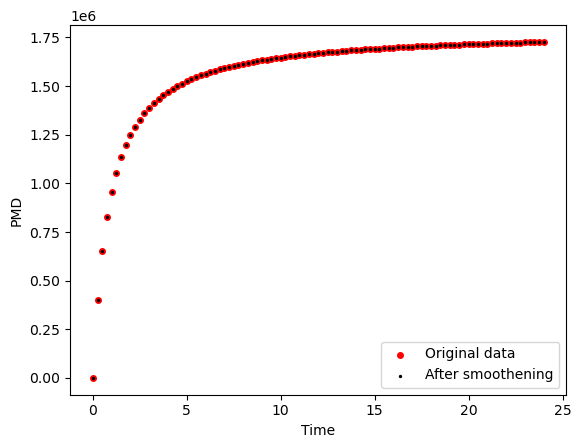

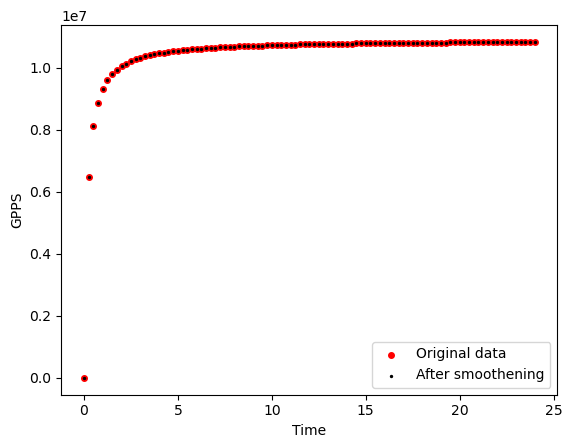

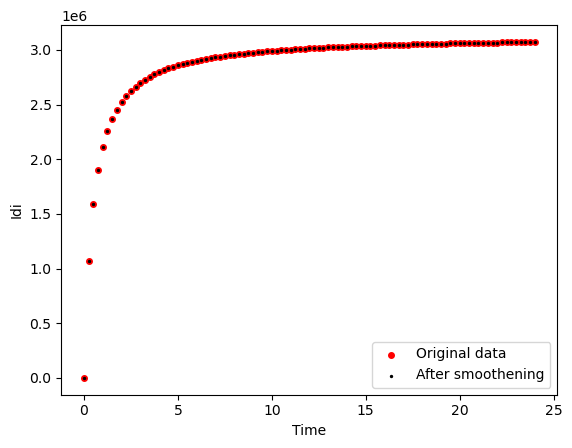

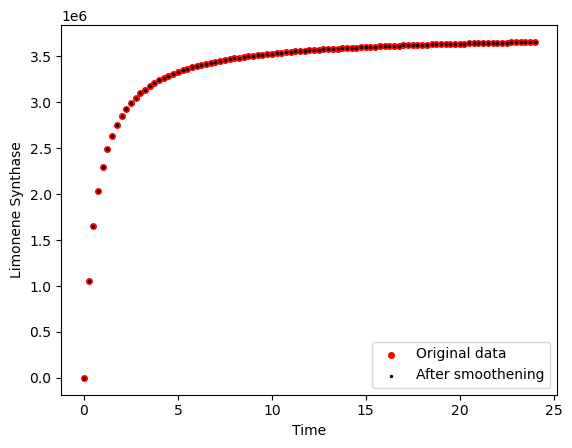

Strain Strain 3


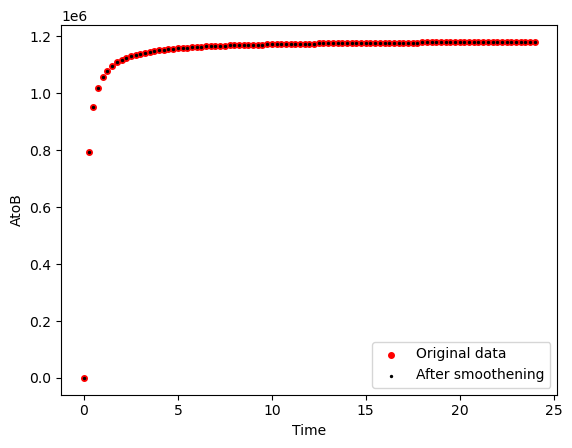

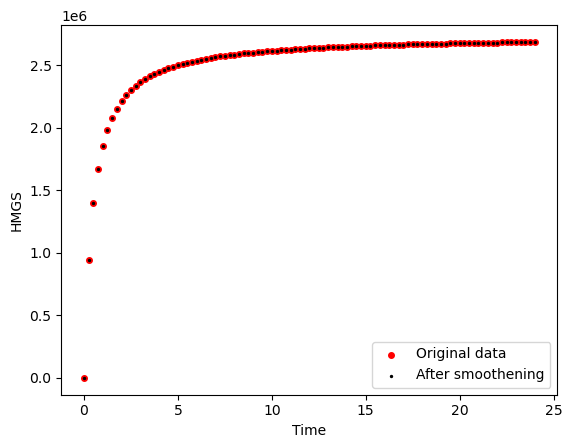

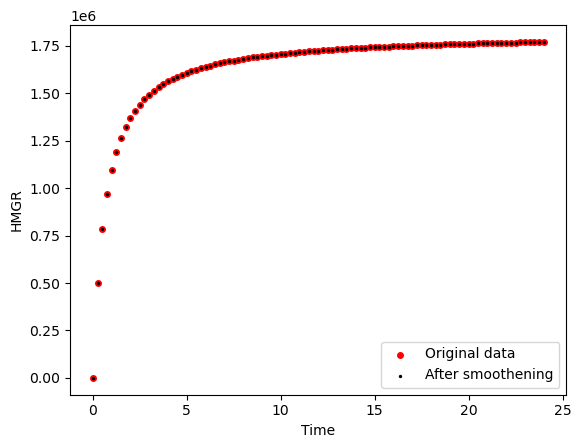

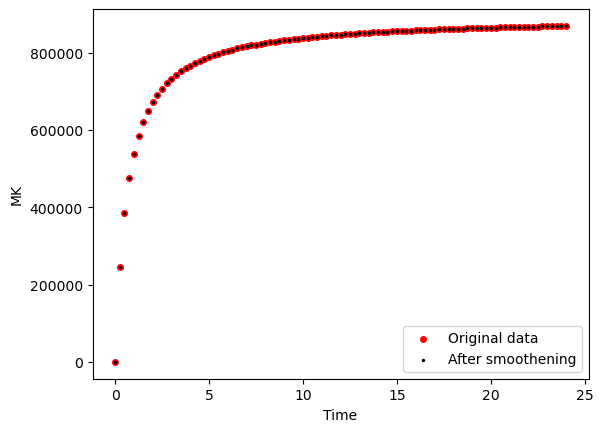

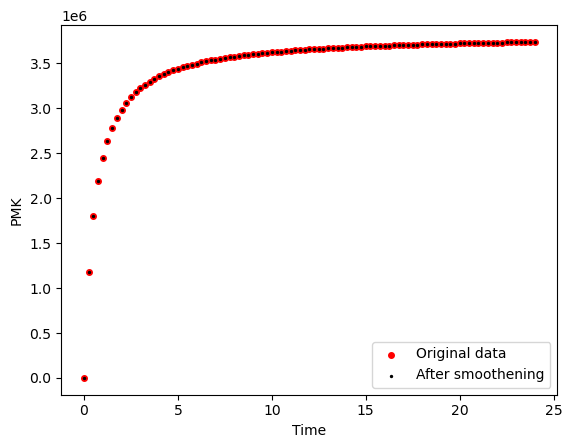

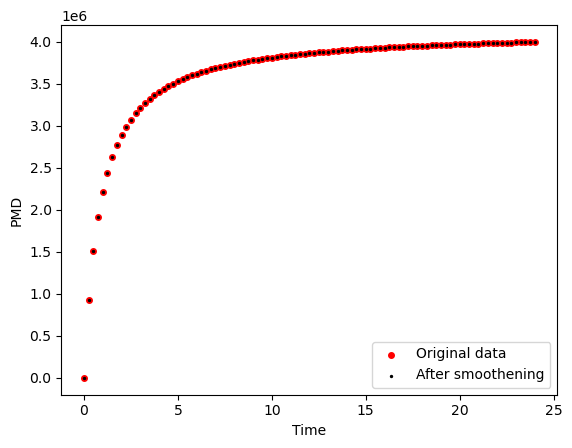

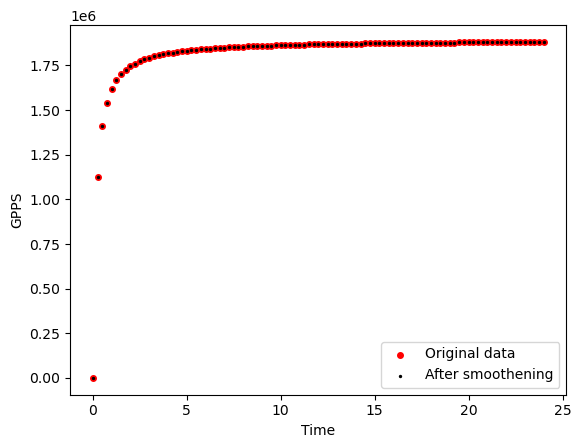

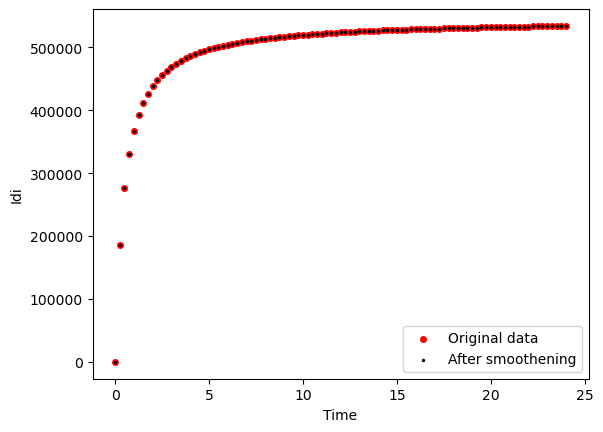

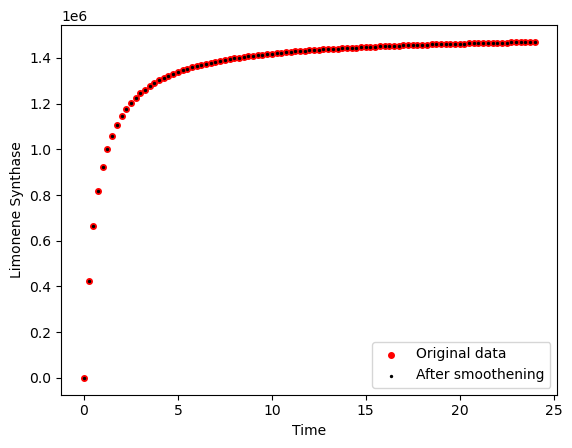

Strain WT


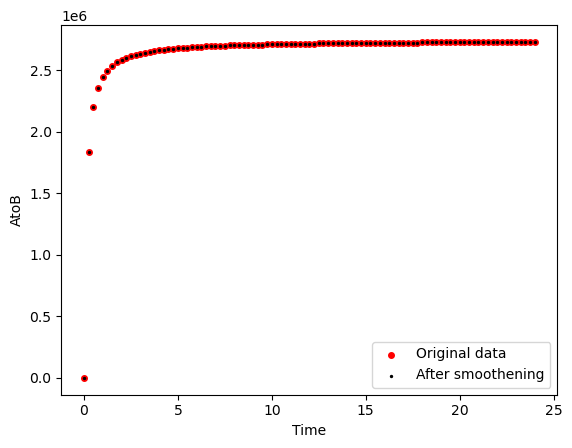

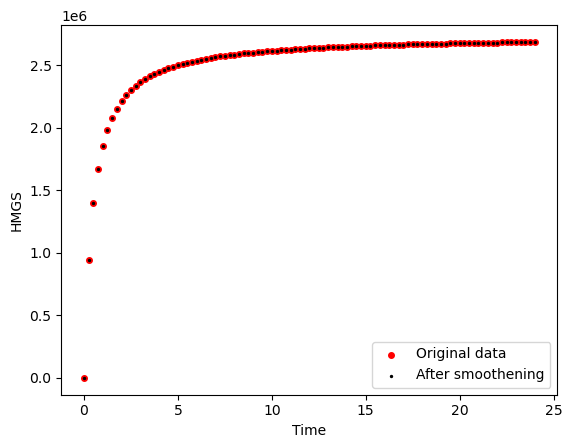

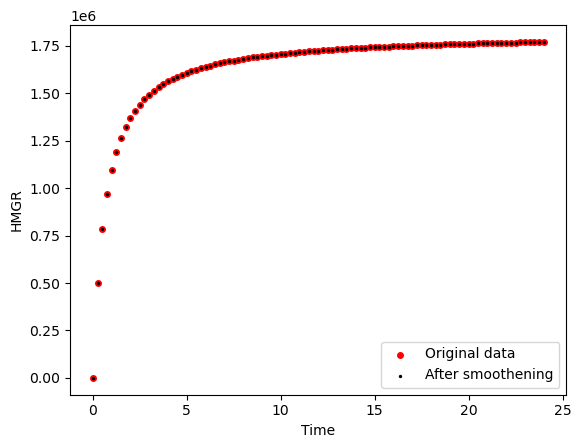

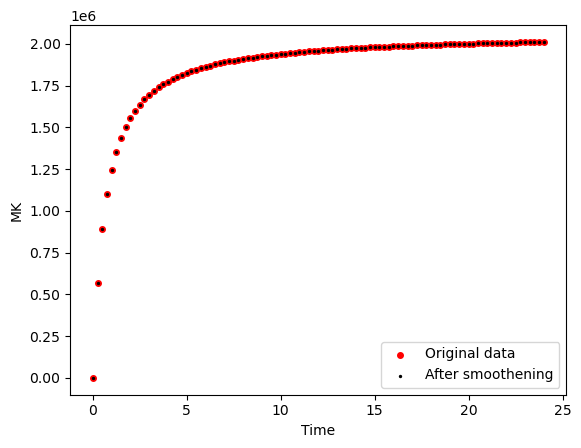

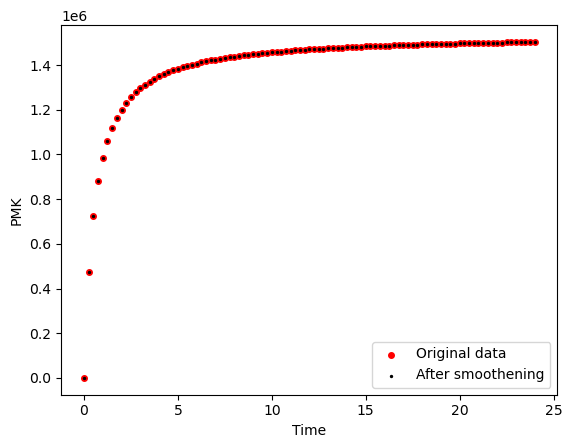

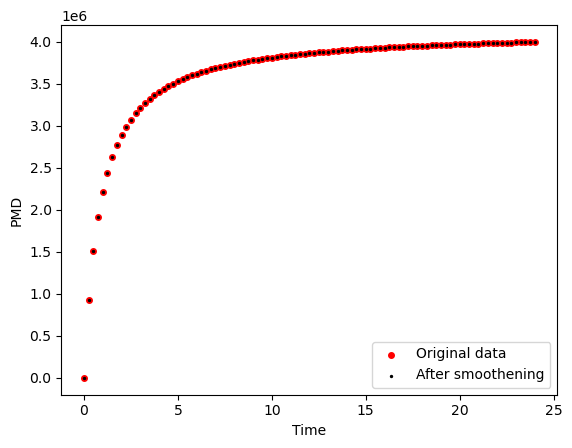

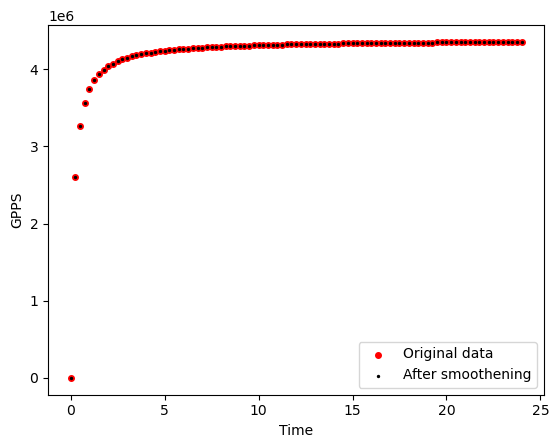

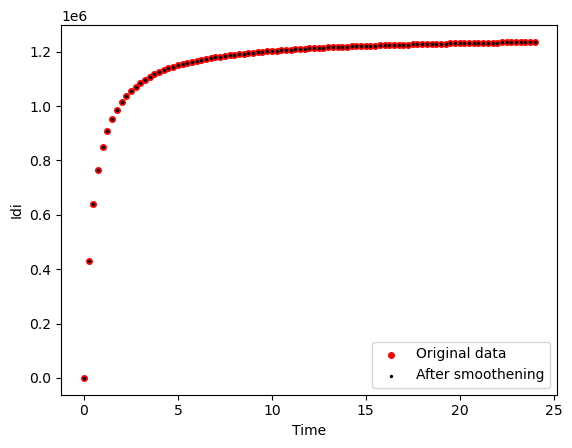

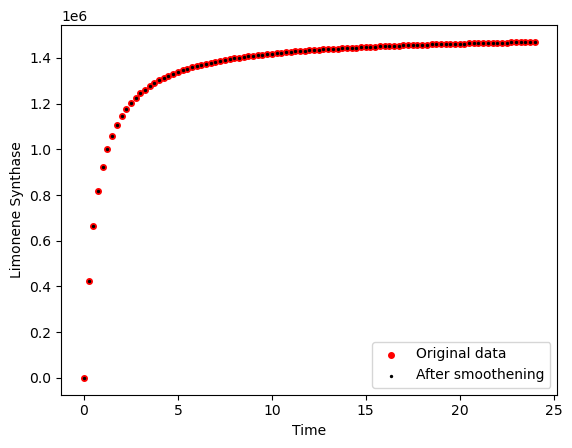

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

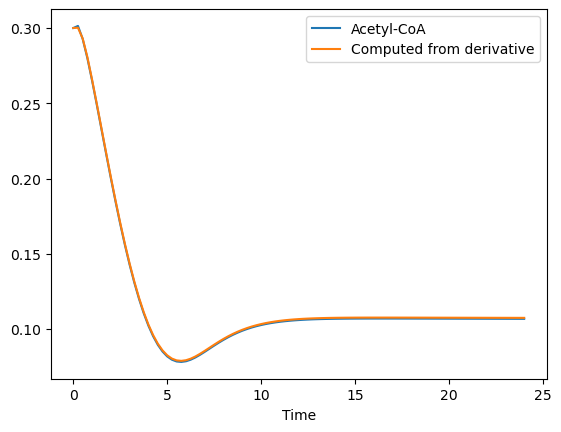

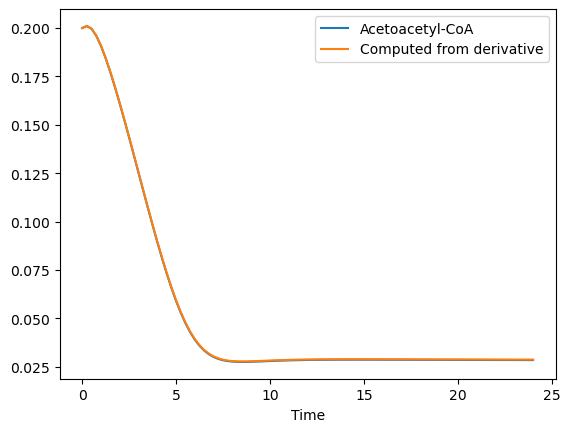

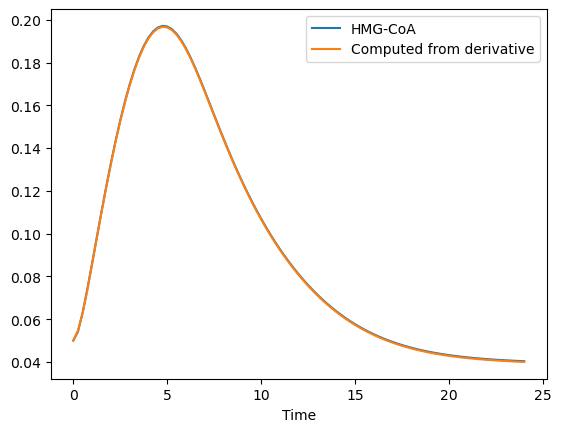

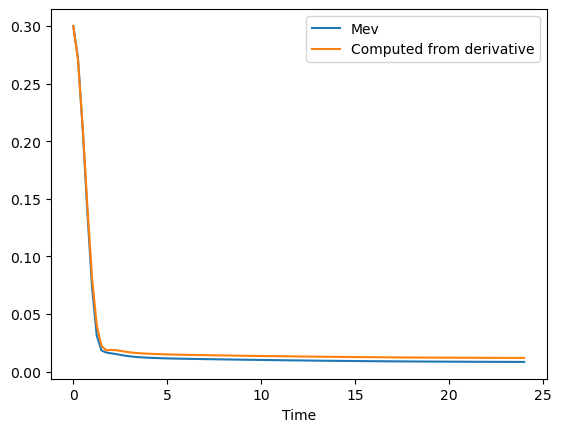

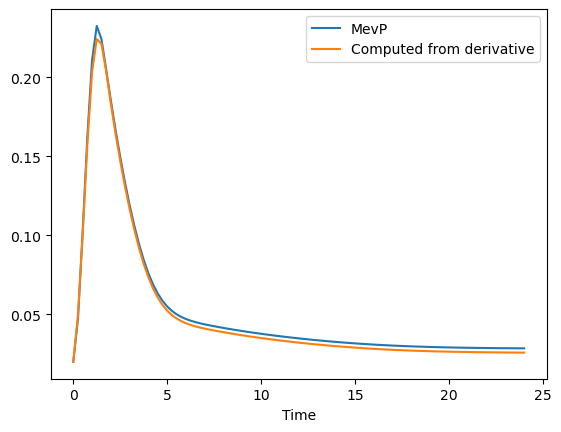

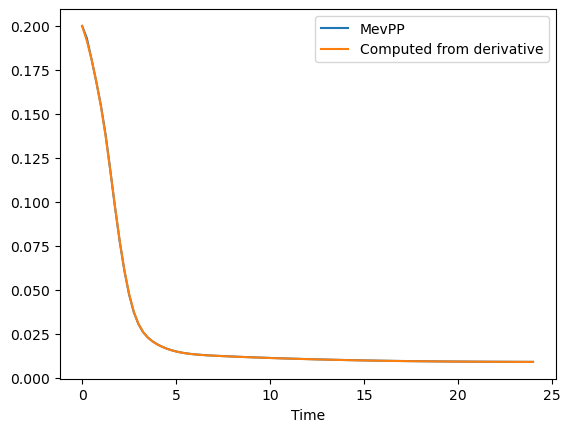

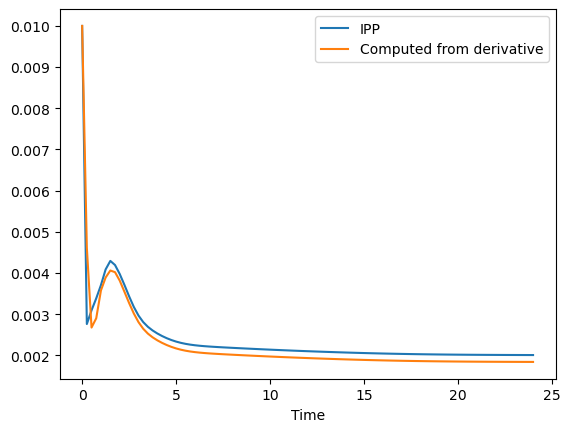

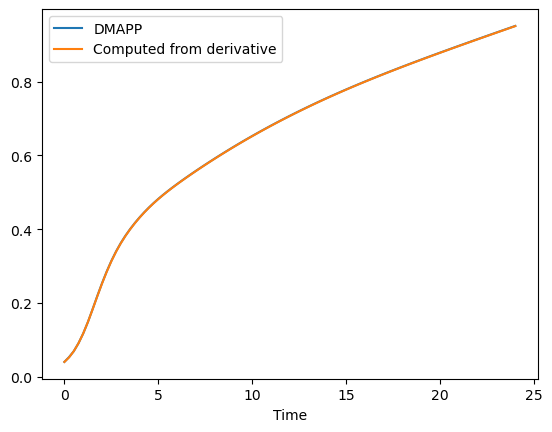

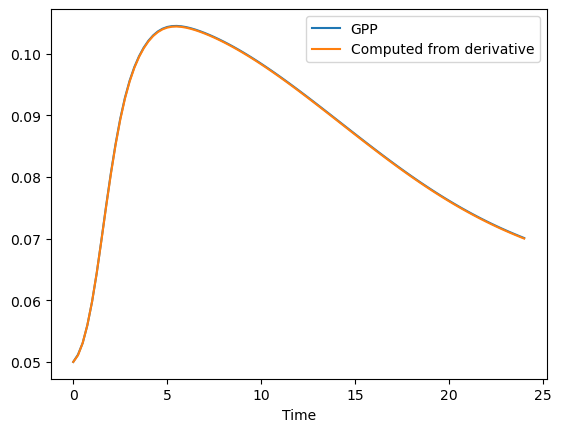

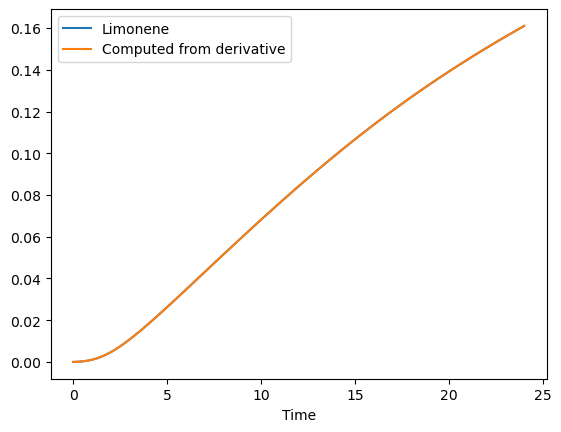

'Time profile from derivative vs. actual profile for Strain 2'

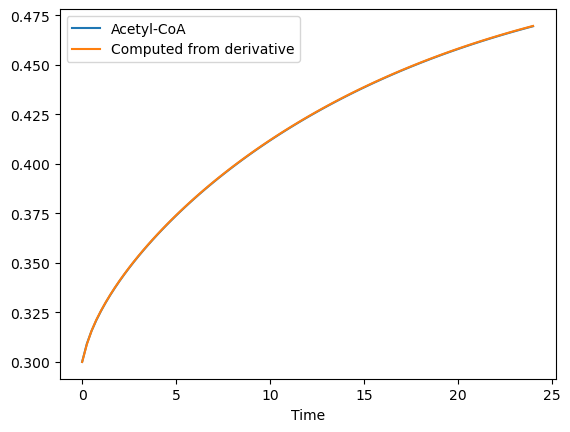

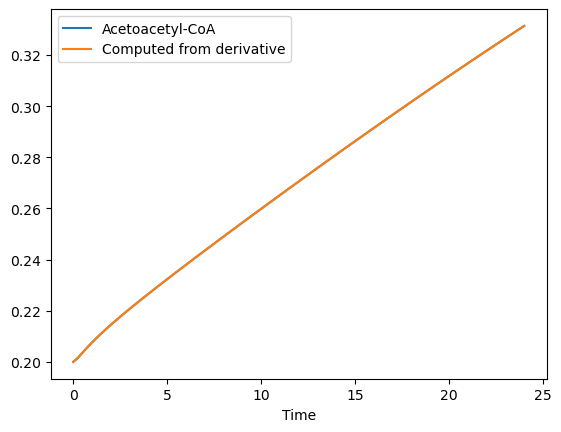

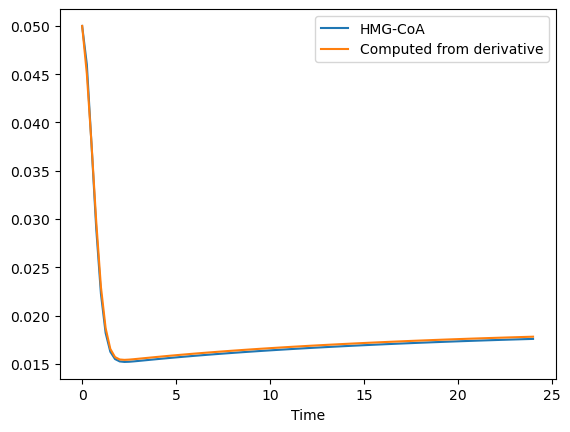

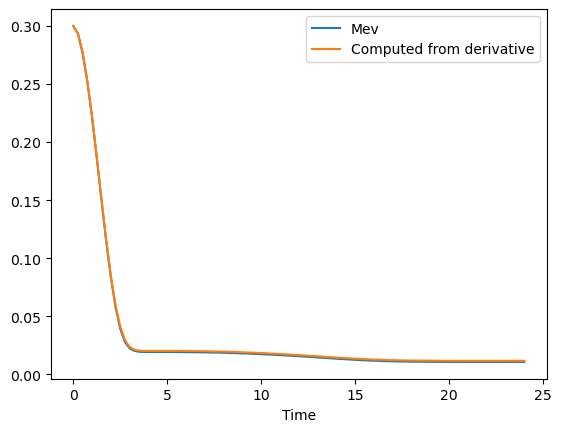

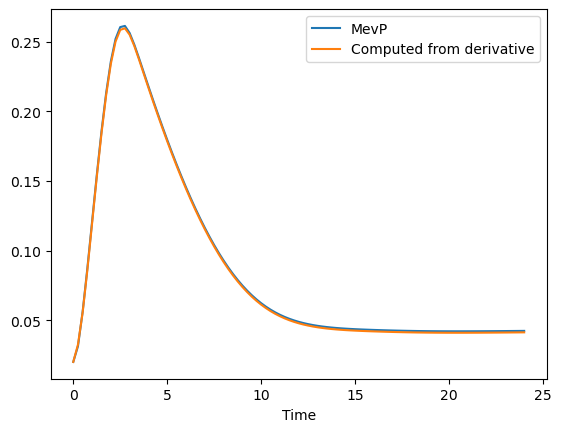

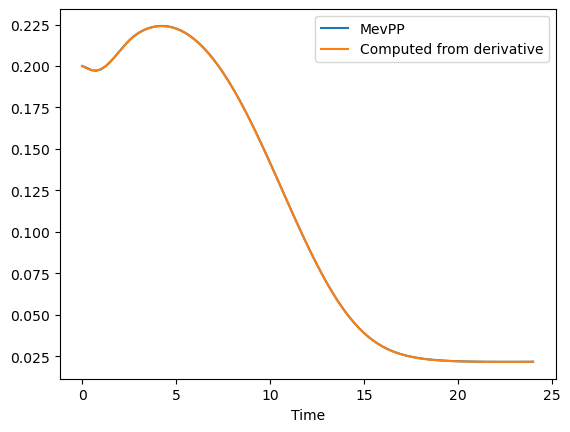

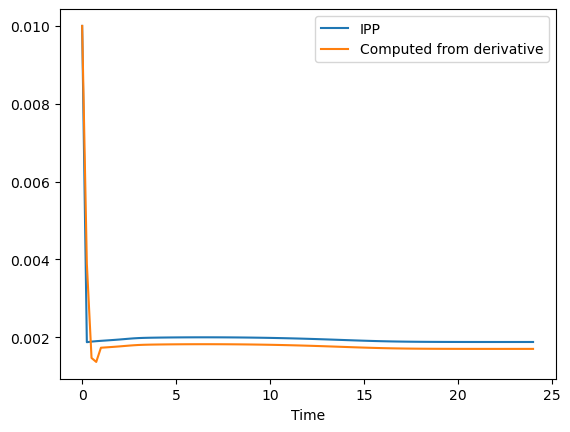

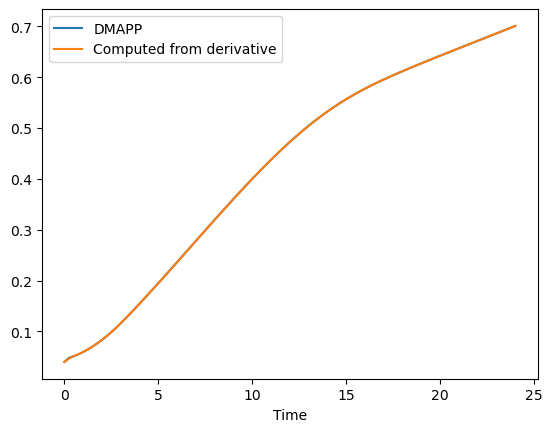

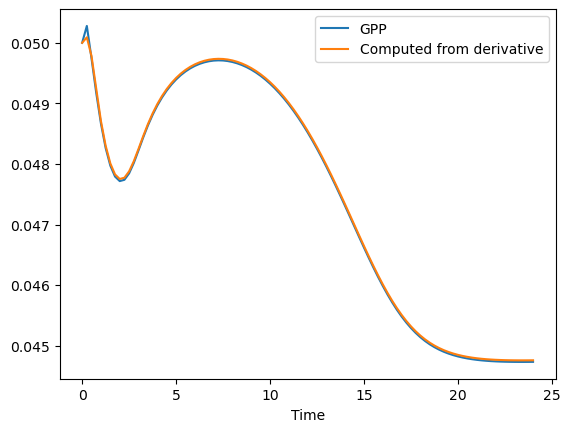

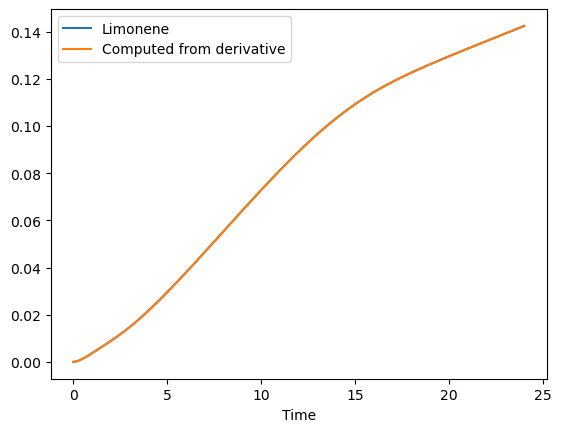

'Time profile from derivative vs. actual profile for Strain 3'

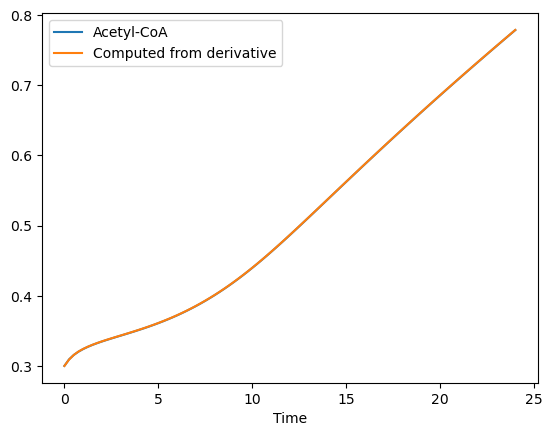

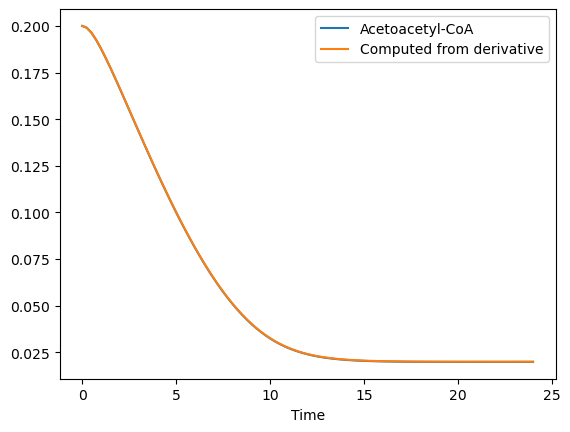

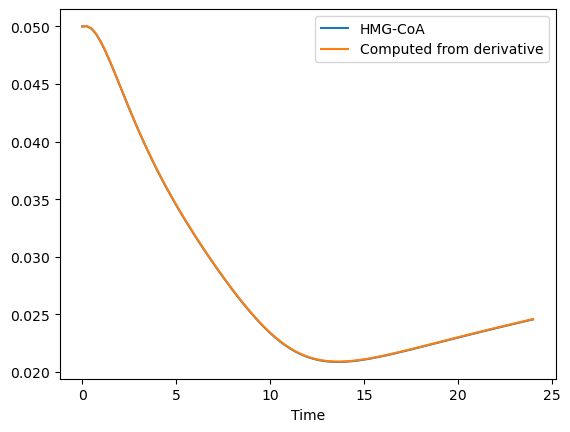

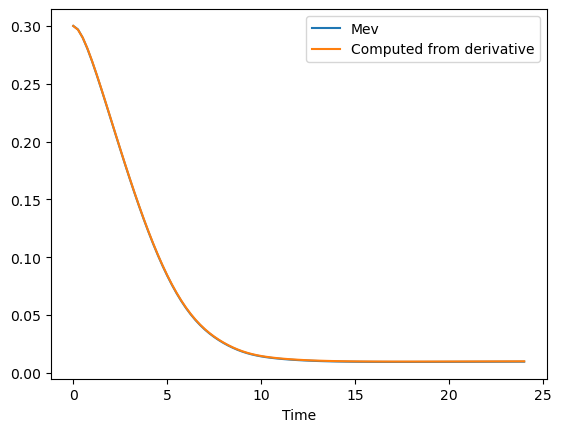

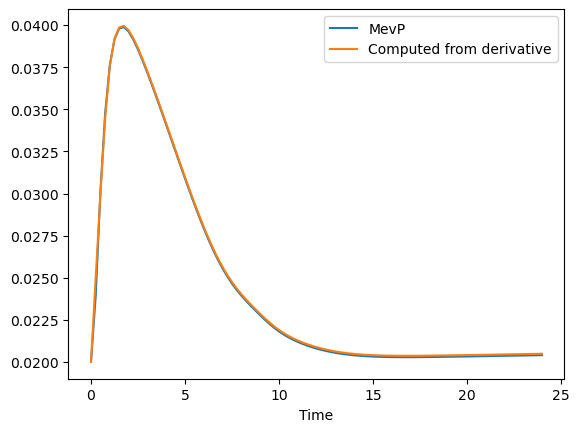

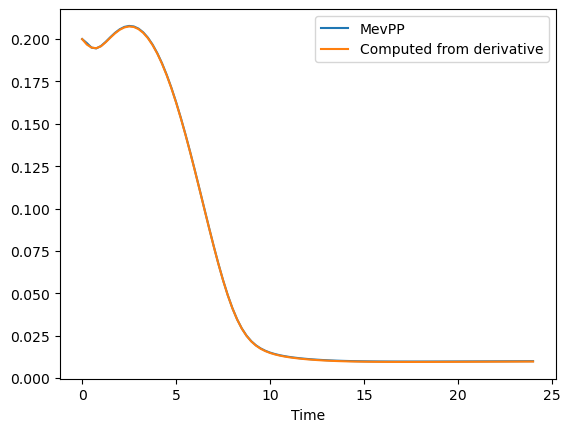

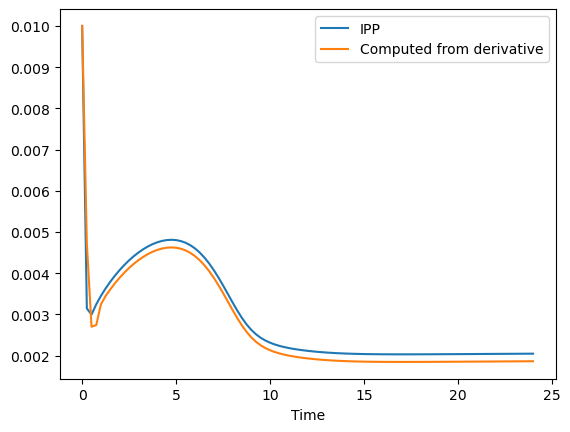

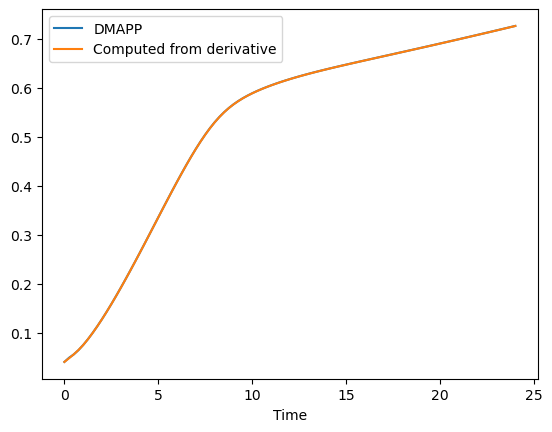

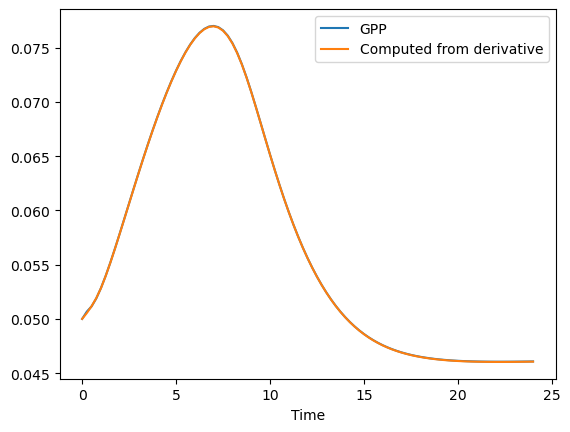

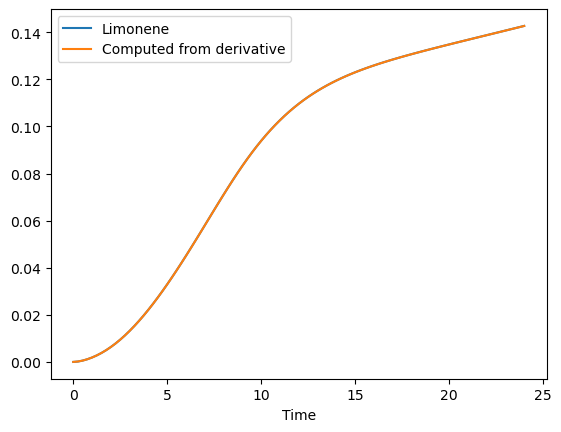

'Time profile from derivative vs. actual profile for WT'

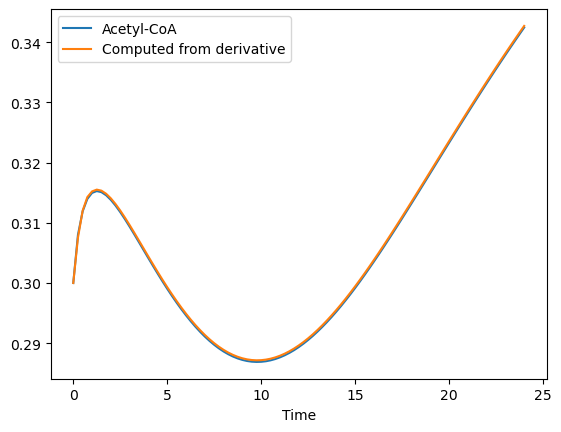

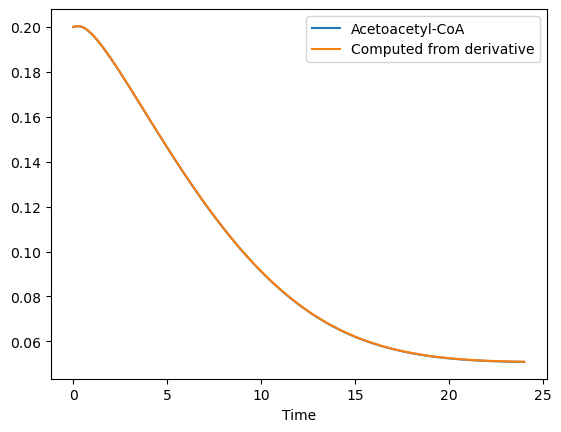

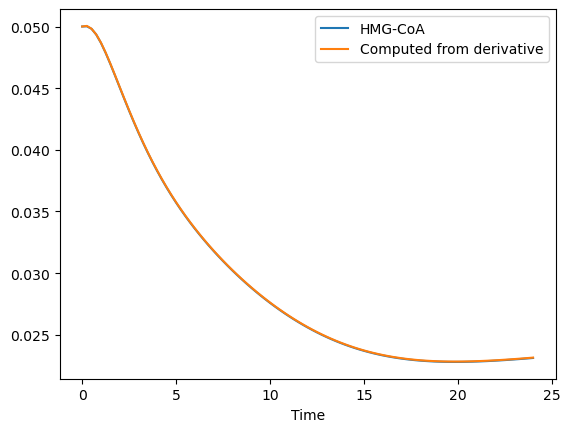

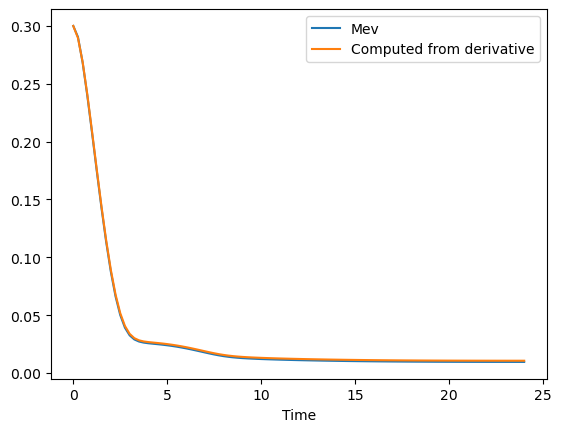

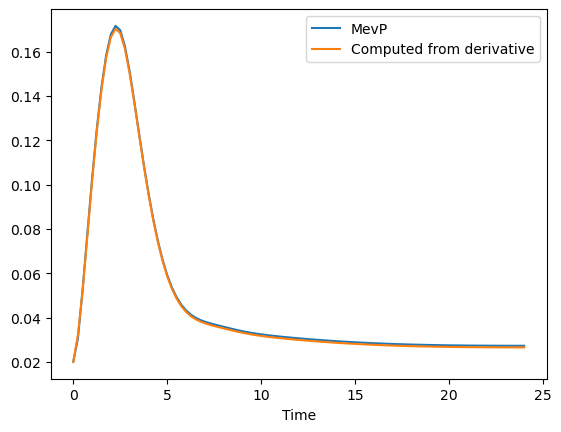

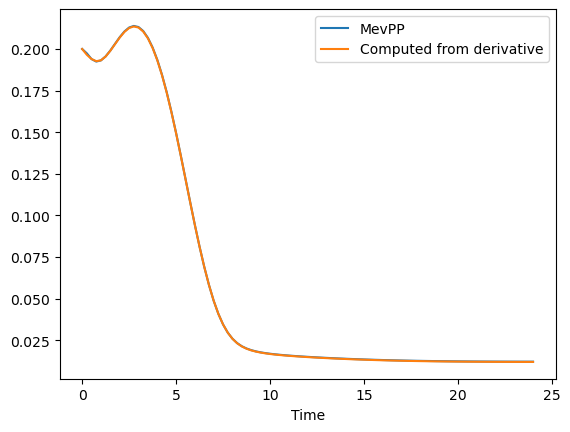

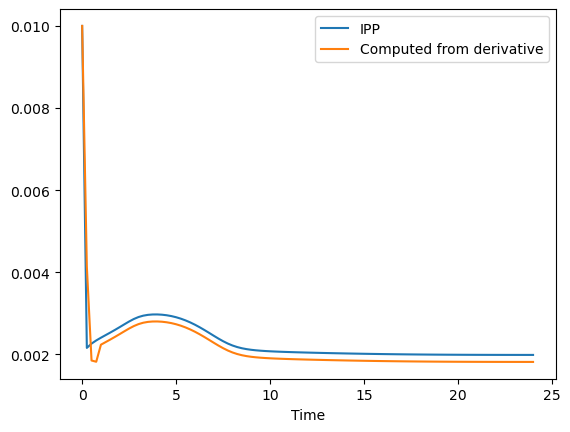

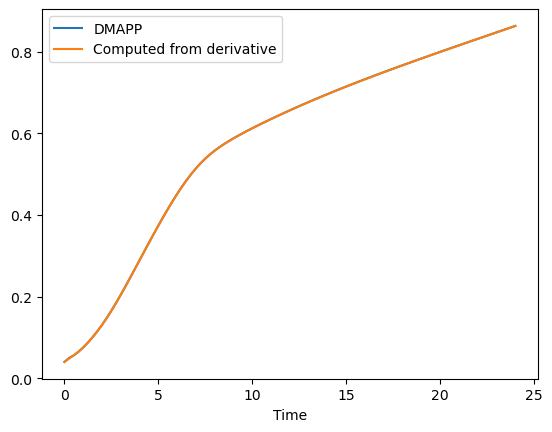

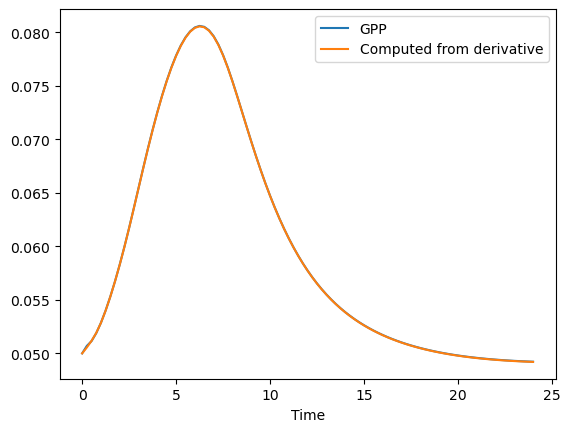

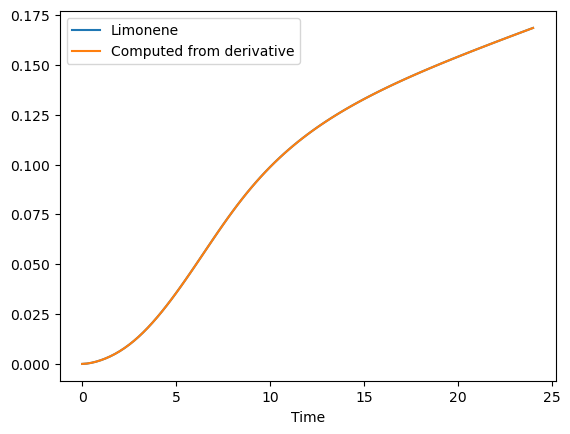

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  3.906073E+18 |  3.410264E+16
     2 |       74 |  1.018583E+16 |  2.160435E+14
     3 |      138 |  7.834328E+14 |  1.070744E+14
     4 |      202 |  7.942042E+13 |  1.792137E+12
     5 |      266 |  3.963424E+12 |  7.787056E+10
     6 |      330 |  2.224070E+12 |  6.120831E+10
     7 |      394 |  6.930973E+11 |  6.120831E+10
     8 |      458 |  2.569200E+12 |  2.604212E+10
     9 |      522 |  6.365422E+11 |  2.441070E+10
    10 |      586 |  5.512171E+10 |  1.387858E+09
    11 |      650 |  7.956718E+10 |  6.630325E+08
    12 |      714 |  2.344112E+10 |  6.630325E+08
    13 |      778 |  1.954526E+10 |  6.630325E+08
    14 |      842 |  1.415547E+09 |  2.300999E+08
    15 |      906 |  1.141542E+09 |  1.708238E+07
    16 |      970 |  5.713059E+08 |  1.283679E+07
    17 |     1034 |  2.533721E+08 |  1.283679E+07
    18 |     1098 |  8.141589E+07 |  9.731847E+06
    19 |     1162 |  3.833

   162 |    10314 |  3.749537E+01 |  3.586722E+01
   163 |    10378 |  3.877235E+01 |  3.569297E+01
   164 |    10442 |  3.745683E+01 |  3.450317E+01
   165 |    10506 |  3.590916E+01 |  3.405588E+01
   166 |    10570 |  3.574359E+01 |  3.405588E+01
   167 |    10634 |  3.659359E+01 |  3.405588E+01
   168 |    10698 |  3.602811E+01 |  3.405588E+01
   169 |    10762 |  3.560634E+01 |  3.405588E+01
   170 |    10826 |  3.506892E+01 |  3.304742E+01
   171 |    10890 |  3.446205E+01 |  3.243209E+01
   172 |    10954 |  3.505476E+01 |  3.243209E+01
   173 |    11018 |  3.424223E+01 |  3.243209E+01
   174 |    11082 |  3.429393E+01 |  3.243209E+01
   175 |    11146 |  3.349003E+01 |  3.056116E+01
   176 |    11210 |  3.331618E+01 |  2.913541E+01
   177 |    11274 |  3.396605E+01 |  2.913541E+01
   178 |    11338 |  3.390620E+01 |  2.913541E+01
   179 |    11402 |  3.266100E+01 |  2.913541E+01
   180 |    11466 |  3.207309E+01 |  2.913541E+01
   181 |    11530 |  3.157977E+01 |  2.913541E+01


   326 |    20810 |  2.482637E+01 |  2.480745E+01
   327 |    20874 |  2.480939E+01 |  2.479202E+01
   328 |    20938 |  2.479963E+01 |  2.477677E+01
   329 |    21002 |  2.479315E+01 |  2.477619E+01
   330 |    21066 |  2.478578E+01 |  2.476088E+01
   331 |    21130 |  2.478127E+01 |  2.476088E+01
   332 |    21194 |  2.476771E+01 |  2.475444E+01
   333 |    21258 |  2.476674E+01 |  2.474719E+01
   334 |    21322 |  2.475444E+01 |  2.474658E+01
   335 |    21386 |  2.474914E+01 |  2.473720E+01
   336 |    21450 |  2.474167E+01 |  2.472723E+01
   337 |    21514 |  2.473571E+01 |  2.472291E+01
   338 |    21578 |  2.472795E+01 |  2.470977E+01
   339 |    21642 |  2.472023E+01 |  2.470931E+01
   340 |    21706 |  2.472231E+01 |  2.470931E+01
   341 |    21770 |  2.471406E+01 |  2.470816E+01
   342 |    21834 |  2.471025E+01 |  2.470280E+01
   343 |    21898 |  2.470413E+01 |  2.469784E+01
   344 |    21962 |  2.468107E+01 |  2.465083E+01
   345 |    22026 |  2.465734E+01 |  2.464751E+01


   490 |    31306 |  2.120269E+01 |  2.118454E+01
   491 |    31370 |  2.119611E+01 |  2.118054E+01
   492 |    31434 |  2.118987E+01 |  2.116641E+01
   493 |    31498 |  2.117761E+01 |  2.116452E+01
   494 |    31562 |  2.117879E+01 |  2.116452E+01
   495 |    31626 |  2.117378E+01 |  2.114642E+01
   496 |    31690 |  2.116006E+01 |  2.113583E+01
   497 |    31754 |  2.115212E+01 |  2.113337E+01
   498 |    31818 |  2.115164E+01 |  2.112461E+01
   499 |    31882 |  2.113603E+01 |  2.112461E+01
   500 |    31946 |  2.114234E+01 |  2.112461E+01
   501 |    32010 |  2.113488E+01 |  2.112342E+01
   502 |    32074 |  2.113086E+01 |  2.111808E+01
   503 |    32138 |  2.112925E+01 |  2.111331E+01
   504 |    32202 |  2.111969E+01 |  2.111102E+01
   505 |    32266 |  2.111522E+01 |  2.110125E+01
   506 |    32330 |  2.110644E+01 |  2.109334E+01
   507 |    32394 |  2.110248E+01 |  2.108441E+01
   508 |    32458 |  2.109474E+01 |  2.107696E+01
   509 |    32522 |  2.108245E+01 |  2.107129E+01


   654 |    41802 |  2.037188E+01 |  2.036529E+01
   655 |    41866 |  2.036580E+01 |  2.035997E+01
   656 |    41930 |  2.035904E+01 |  2.035382E+01
   657 |    41994 |  2.035725E+01 |  2.035230E+01
   658 |    42058 |  2.035643E+01 |  2.034715E+01
   659 |    42122 |  2.035365E+01 |  2.034631E+01
   660 |    42186 |  2.035115E+01 |  2.034631E+01
   661 |    42250 |  2.034731E+01 |  2.034000E+01
   662 |    42314 |  2.034331E+01 |  2.033953E+01
   663 |    42378 |  2.034132E+01 |  2.033488E+01
   664 |    42442 |  2.033808E+01 |  2.033111E+01
   665 |    42506 |  2.033383E+01 |  2.032884E+01
   666 |    42570 |  2.032906E+01 |  2.032255E+01
   667 |    42634 |  2.032553E+01 |  2.031934E+01
   668 |    42698 |  2.032265E+01 |  2.031700E+01
   669 |    42762 |  2.032008E+01 |  2.031528E+01
   670 |    42826 |  2.031590E+01 |  2.031084E+01
   671 |    42890 |  2.031206E+01 |  2.030872E+01
   672 |    42954 |  2.031131E+01 |  2.030712E+01
   673 |    43018 |  2.030856E+01 |  2.030597E+01


   818 |    52298 |  1.996209E+01 |  1.995425E+01
   819 |    52362 |  1.995502E+01 |  1.995122E+01
   820 |    52426 |  1.995256E+01 |  1.994524E+01
   821 |    52490 |  1.994585E+01 |  1.993158E+01
   822 |    52554 |  1.993550E+01 |  1.992364E+01
   823 |    52618 |  1.993024E+01 |  1.992041E+01
   824 |    52682 |  1.992346E+01 |  1.991586E+01
   825 |    52746 |  1.991858E+01 |  1.991066E+01
   826 |    52810 |  1.990701E+01 |  1.989878E+01
   827 |    52874 |  1.990090E+01 |  1.989446E+01
   828 |    52938 |  1.989856E+01 |  1.988668E+01
   829 |    53002 |  1.989554E+01 |  1.987707E+01
   830 |    53066 |  1.988722E+01 |  1.986899E+01
   831 |    53130 |  1.987256E+01 |  1.986258E+01
   832 |    53194 |  1.986249E+01 |  1.984731E+01
   833 |    53258 |  1.985703E+01 |  1.984136E+01
   834 |    53322 |  1.985074E+01 |  1.984136E+01
   835 |    53386 |  1.984711E+01 |  1.983787E+01
   836 |    53450 |  1.984609E+01 |  1.983787E+01
   837 |    53514 |  1.984079E+01 |  1.983538E+01


   982 |    62794 |  1.889134E+01 |  1.880632E+01
   983 |    62858 |  1.883470E+01 |  1.873563E+01
   984 |    62922 |  1.878438E+01 |  1.870724E+01
   985 |    62986 |  1.871160E+01 |  1.867347E+01
   986 |    63050 |  1.866699E+01 |  1.860543E+01
   987 |    63114 |  1.863148E+01 |  1.860166E+01
   988 |    63178 |  1.855626E+01 |  1.845858E+01
   989 |    63242 |  1.850580E+01 |  1.841084E+01
   990 |    63306 |  1.844808E+01 |  1.839455E+01
   991 |    63370 |  1.842180E+01 |  1.836362E+01
   992 |    63434 |  1.837637E+01 |  1.833242E+01
   993 |    63498 |  1.831592E+01 |  1.826467E+01
   994 |    63562 |  1.827362E+01 |  1.823826E+01
   995 |    63626 |  1.821450E+01 |  1.812553E+01
   996 |    63690 |  1.814687E+01 |  1.810563E+01
   997 |    63754 |  1.807138E+01 |  1.800181E+01
   998 |    63818 |  1.804096E+01 |  1.794473E+01
   999 |    63882 |  1.798511E+01 |  1.792456E+01
  1000 |    63946 |  1.794527E+01 |  1.789400E+01
  1001 |    64010 |  1.792011E+01 |  1.783046E+01


  1146 |    73290 |  1.605817E+01 |  1.605372E+01
  1147 |    73354 |  1.605893E+01 |  1.605352E+01
  1148 |    73418 |  1.605886E+01 |  1.605352E+01
  1149 |    73482 |  1.605539E+01 |  1.605223E+01
  1150 |    73546 |  1.605109E+01 |  1.604616E+01
  1151 |    73610 |  1.604665E+01 |  1.604028E+01
  1152 |    73674 |  1.604350E+01 |  1.604028E+01
  1153 |    73738 |  1.604279E+01 |  1.603684E+01
  1154 |    73802 |  1.604085E+01 |  1.603628E+01
  1155 |    73866 |  1.603702E+01 |  1.603170E+01
  1156 |    73930 |  1.603417E+01 |  1.603075E+01
  1157 |    73994 |  1.603186E+01 |  1.602783E+01
  1158 |    74058 |  1.603086E+01 |  1.602629E+01
  1159 |    74122 |  1.602897E+01 |  1.602365E+01
  1160 |    74186 |  1.602627E+01 |  1.602146E+01
  1161 |    74250 |  1.602475E+01 |  1.602146E+01
  1162 |    74314 |  1.602330E+01 |  1.602146E+01
  1163 |    74378 |  1.602119E+01 |  1.601839E+01
  1164 |    74442 |  1.601832E+01 |  1.601467E+01
  1165 |    74506 |  1.601627E+01 |  1.601258E+01


  1310 |    83786 |  1.578511E+01 |  1.578396E+01
  1311 |    83850 |  1.578457E+01 |  1.578228E+01
  1312 |    83914 |  1.578223E+01 |  1.577891E+01
  1313 |    83978 |  1.578044E+01 |  1.577822E+01
  1314 |    84042 |  1.577793E+01 |  1.577657E+01
  1315 |    84106 |  1.577549E+01 |  1.577151E+01
  1316 |    84170 |  1.577326E+01 |  1.576915E+01
  1317 |    84234 |  1.577136E+01 |  1.576770E+01
  1318 |    84298 |  1.576982E+01 |  1.576750E+01
  1319 |    84362 |  1.576872E+01 |  1.576582E+01
  1320 |    84426 |  1.576547E+01 |  1.576352E+01
  1321 |    84490 |  1.576186E+01 |  1.575701E+01
  1322 |    84554 |  1.575900E+01 |  1.575222E+01
  1323 |    84618 |  1.575181E+01 |  1.574726E+01
  1324 |    84682 |  1.574684E+01 |  1.574278E+01
  1325 |    84746 |  1.574237E+01 |  1.573330E+01
  1326 |    84810 |  1.573593E+01 |  1.573310E+01
  1327 |    84874 |  1.573101E+01 |  1.572703E+01
  1328 |    84938 |  1.572536E+01 |  1.572121E+01
  1329 |    85002 |  1.572173E+01 |  1.571094E+01


  1474 |    94282 |  1.468933E+01 |  1.467739E+01
  1475 |    94346 |  1.468251E+01 |  1.467469E+01
  1476 |    94410 |  1.467655E+01 |  1.466579E+01
  1477 |    94474 |  1.467203E+01 |  1.463977E+01
  1478 |    94538 |  1.466005E+01 |  1.463977E+01
  1479 |    94602 |  1.465122E+01 |  1.463576E+01
  1480 |    94666 |  1.463442E+01 |  1.460520E+01
  1481 |    94730 |  1.462055E+01 |  1.458892E+01
  1482 |    94794 |  1.460421E+01 |  1.458645E+01
  1483 |    94858 |  1.459232E+01 |  1.457914E+01
  1484 |    94922 |  1.458653E+01 |  1.457058E+01
  1485 |    94986 |  1.457421E+01 |  1.455486E+01
  1486 |    95050 |  1.456064E+01 |  1.455141E+01
  1487 |    95114 |  1.455841E+01 |  1.454601E+01
  1488 |    95178 |  1.455329E+01 |  1.454601E+01
  1489 |    95242 |  1.455084E+01 |  1.453658E+01
  1490 |    95306 |  1.454356E+01 |  1.453097E+01
  1491 |    95370 |  1.453856E+01 |  1.452991E+01
  1492 |    95434 |  1.453407E+01 |  1.452238E+01
  1493 |    95498 |  1.451714E+01 |  1.450711E+01


  1638 |   104778 |  1.417268E+01 |  1.416586E+01
  1639 |   104842 |  1.416782E+01 |  1.415652E+01
  1640 |   104906 |  1.416033E+01 |  1.415525E+01
  1641 |   104970 |  1.415838E+01 |  1.415282E+01
  1642 |   105034 |  1.415787E+01 |  1.415282E+01
  1643 |   105098 |  1.415510E+01 |  1.414567E+01
  1644 |   105162 |  1.414958E+01 |  1.414531E+01
  1645 |   105226 |  1.414528E+01 |  1.414067E+01
  1646 |   105290 |  1.413908E+01 |  1.413034E+01
  1647 |   105354 |  1.413360E+01 |  1.413005E+01
  1648 |   105418 |  1.413156E+01 |  1.412482E+01
  1649 |   105482 |  1.412607E+01 |  1.411851E+01
  1650 |   105546 |  1.412161E+01 |  1.411703E+01
  1651 |   105610 |  1.411616E+01 |  1.410710E+01
  1652 |   105674 |  1.411131E+01 |  1.410103E+01
  1653 |   105738 |  1.410616E+01 |  1.410103E+01
  1654 |   105802 |  1.410474E+01 |  1.410103E+01
  1655 |   105866 |  1.410498E+01 |  1.410103E+01
  1656 |   105930 |  1.410266E+01 |  1.408897E+01
  1657 |   105994 |  1.409673E+01 |  1.408847E+01


  1802 |   115274 |  1.355638E+01 |  1.355258E+01
  1803 |   115338 |  1.355129E+01 |  1.354612E+01
  1804 |   115402 |  1.354718E+01 |  1.354174E+01
  1805 |   115466 |  1.354139E+01 |  1.353098E+01
  1806 |   115530 |  1.353547E+01 |  1.353015E+01
  1807 |   115594 |  1.352950E+01 |  1.352572E+01
  1808 |   115658 |  1.352698E+01 |  1.352136E+01
  1809 |   115722 |  1.352190E+01 |  1.351567E+01
  1810 |   115786 |  1.352018E+01 |  1.351567E+01
  1811 |   115850 |  1.351878E+01 |  1.351269E+01
  1812 |   115914 |  1.351042E+01 |  1.350333E+01
  1813 |   115978 |  1.350254E+01 |  1.349912E+01
  1814 |   116042 |  1.349682E+01 |  1.349226E+01
  1815 |   116106 |  1.349314E+01 |  1.349023E+01
  1816 |   116170 |  1.349002E+01 |  1.348463E+01
  1817 |   116234 |  1.348572E+01 |  1.348216E+01
  1818 |   116298 |  1.348390E+01 |  1.347871E+01
  1819 |   116362 |  1.348236E+01 |  1.347772E+01
  1820 |   116426 |  1.348141E+01 |  1.347122E+01
  1821 |   116490 |  1.347624E+01 |  1.347016E+01


  1966 |   125770 |  1.275339E+01 |  1.274902E+01
  1967 |   125834 |  1.274995E+01 |  1.274721E+01
  1968 |   125898 |  1.274746E+01 |  1.274592E+01
  1969 |   125962 |  1.274550E+01 |  1.274362E+01
  1970 |   126026 |  1.274391E+01 |  1.274313E+01
  1971 |   126090 |  1.274210E+01 |  1.274013E+01
  1972 |   126154 |  1.274017E+01 |  1.273844E+01
  1973 |   126218 |  1.273805E+01 |  1.273639E+01
  1974 |   126282 |  1.273507E+01 |  1.272926E+01
  1975 |   126346 |  1.273160E+01 |  1.272787E+01
  1976 |   126410 |  1.272705E+01 |  1.272080E+01
  1977 |   126474 |  1.272234E+01 |  1.271916E+01
  1978 |   126538 |  1.271846E+01 |  1.271556E+01
  1979 |   126602 |  1.271534E+01 |  1.271245E+01
  1980 |   126666 |  1.271258E+01 |  1.270852E+01
  1981 |   126730 |  1.271244E+01 |  1.270852E+01
  1982 |   126794 |  1.270822E+01 |  1.270399E+01
  1983 |   126858 |  1.270289E+01 |  1.269807E+01
  1984 |   126922 |  1.269681E+01 |  1.269491E+01
  1985 |   126986 |  1.269419E+01 |  1.268926E+01


  2130 |   136266 |  1.120751E+01 |  1.120334E+01
  2131 |   136330 |  1.120475E+01 |  1.120143E+01
  2132 |   136394 |  1.120155E+01 |  1.119706E+01
  2133 |   136458 |  1.119744E+01 |  1.118761E+01
  2134 |   136522 |  1.119444E+01 |  1.118761E+01
  2135 |   136586 |  1.119225E+01 |  1.118761E+01
  2136 |   136650 |  1.118949E+01 |  1.118647E+01
  2137 |   136714 |  1.118838E+01 |  1.118565E+01
  2138 |   136778 |  1.118369E+01 |  1.117406E+01
  2139 |   136842 |  1.117826E+01 |  1.117114E+01
  2140 |   136906 |  1.117085E+01 |  1.116734E+01
  2141 |   136970 |  1.116826E+01 |  1.116392E+01
  2142 |   137034 |  1.116627E+01 |  1.116149E+01
  2143 |   137098 |  1.116164E+01 |  1.115601E+01
  2144 |   137162 |  1.115405E+01 |  1.114699E+01
  2145 |   137226 |  1.114942E+01 |  1.114699E+01
  2146 |   137290 |  1.114700E+01 |  1.114292E+01
  2147 |   137354 |  1.114261E+01 |  1.113810E+01
  2148 |   137418 |  1.113992E+01 |  1.113630E+01
  2149 |   137482 |  1.113768E+01 |  1.113521E+01


  2294 |   146762 |  1.086196E+01 |  1.085818E+01
  2295 |   146826 |  1.086048E+01 |  1.085818E+01
  2296 |   146890 |  1.085939E+01 |  1.085803E+01
  2297 |   146954 |  1.085806E+01 |  1.085418E+01
  2298 |   147018 |  1.085770E+01 |  1.085418E+01
  2299 |   147082 |  1.085629E+01 |  1.085367E+01
  2300 |   147146 |  1.085501E+01 |  1.085367E+01
  2301 |   147210 |  1.085419E+01 |  1.085242E+01
  2302 |   147274 |  1.085250E+01 |  1.085072E+01
  2303 |   147338 |  1.085169E+01 |  1.085002E+01
  2304 |   147402 |  1.085027E+01 |  1.084914E+01
  2305 |   147466 |  1.084910E+01 |  1.084793E+01
  2306 |   147530 |  1.084802E+01 |  1.084381E+01
  2307 |   147594 |  1.084628E+01 |  1.084381E+01
  2308 |   147658 |  1.084539E+01 |  1.084381E+01
  2309 |   147722 |  1.084435E+01 |  1.084200E+01
  2310 |   147786 |  1.084356E+01 |  1.084090E+01
  2311 |   147850 |  1.084302E+01 |  1.084090E+01
  2312 |   147914 |  1.084248E+01 |  1.084009E+01
  2313 |   147978 |  1.084106E+01 |  1.083844E+01


  2458 |   157258 |  1.066405E+01 |  1.066242E+01
  2459 |   157322 |  1.066269E+01 |  1.066099E+01
  2460 |   157386 |  1.066078E+01 |  1.065783E+01
  2461 |   157450 |  1.065988E+01 |  1.065743E+01
  2462 |   157514 |  1.065907E+01 |  1.065627E+01
  2463 |   157578 |  1.065664E+01 |  1.065382E+01
  2464 |   157642 |  1.065483E+01 |  1.065321E+01
  2465 |   157706 |  1.065329E+01 |  1.065134E+01
  2466 |   157770 |  1.065176E+01 |  1.064929E+01
  2467 |   157834 |  1.065005E+01 |  1.064770E+01
  2468 |   157898 |  1.064885E+01 |  1.064687E+01
  2469 |   157962 |  1.064765E+01 |  1.064429E+01
  2470 |   158026 |  1.064689E+01 |  1.064307E+01
  2471 |   158090 |  1.064401E+01 |  1.063774E+01
  2472 |   158154 |  1.064197E+01 |  1.063774E+01
  2473 |   158218 |  1.063743E+01 |  1.063312E+01
  2474 |   158282 |  1.063611E+01 |  1.063122E+01
  2475 |   158346 |  1.063389E+01 |  1.062983E+01
  2476 |   158410 |  1.063341E+01 |  1.062983E+01
  2477 |   158474 |  1.063181E+01 |  1.062983E+01


  2622 |   167754 |  1.036686E+01 |  1.035313E+01
  2623 |   167818 |  1.035792E+01 |  1.035240E+01
  2624 |   167882 |  1.035635E+01 |  1.035162E+01
  2625 |   167946 |  1.035471E+01 |  1.034715E+01
  2626 |   168010 |  1.035101E+01 |  1.034253E+01
  2627 |   168074 |  1.034625E+01 |  1.034253E+01
  2628 |   168138 |  1.034380E+01 |  1.033953E+01
  2629 |   168202 |  1.034050E+01 |  1.033820E+01
  2630 |   168266 |  1.033648E+01 |  1.033127E+01
  2631 |   168330 |  1.033393E+01 |  1.033127E+01
  2632 |   168394 |  1.033206E+01 |  1.032881E+01
  2633 |   168458 |  1.033156E+01 |  1.032881E+01
  2634 |   168522 |  1.032945E+01 |  1.032105E+01
  2635 |   168586 |  1.032556E+01 |  1.031973E+01
  2636 |   168650 |  1.032212E+01 |  1.031550E+01
  2637 |   168714 |  1.031795E+01 |  1.030999E+01
  2638 |   168778 |  1.031198E+01 |  1.030857E+01
  2639 |   168842 |  1.031061E+01 |  1.030501E+01
  2640 |   168906 |  1.030792E+01 |  1.030501E+01
  2641 |   168970 |  1.030718E+01 |  1.030501E+01


  2786 |   178250 |  1.009789E+01 |  1.009664E+01
  2787 |   178314 |  1.009593E+01 |  1.009433E+01
  2788 |   178378 |  1.009394E+01 |  1.009108E+01
  2789 |   178442 |  1.009191E+01 |  1.008945E+01
  2790 |   178506 |  1.008952E+01 |  1.008640E+01
  2791 |   178570 |  1.008681E+01 |  1.008463E+01
  2792 |   178634 |  1.008494E+01 |  1.008395E+01
  2793 |   178698 |  1.008349E+01 |  1.008128E+01
  2794 |   178762 |  1.008156E+01 |  1.007876E+01
  2795 |   178826 |  1.007986E+01 |  1.007746E+01
  2796 |   178890 |  1.007636E+01 |  1.007341E+01
  2797 |   178954 |  1.007450E+01 |  1.007237E+01
  2798 |   179018 |  1.007137E+01 |  1.006926E+01
  2799 |   179082 |  1.006972E+01 |  1.006884E+01
  2800 |   179146 |  1.006729E+01 |  1.006091E+01
  2801 |   179210 |  1.006263E+01 |  1.005920E+01
  2802 |   179274 |  1.005925E+01 |  1.005432E+01
  2803 |   179338 |  1.005544E+01 |  1.005280E+01
  2804 |   179402 |  1.005123E+01 |  1.004694E+01
  2805 |   179466 |  1.004797E+01 |  1.004674E+01


  2950 |   188746 |  9.4147997236 |  9.3965732271
  2951 |   188810 |  9.4047081966 |  9.3814944494
  2952 |   188874 |  9.3946668341 |  9.3756788966
  2953 |   188938 |  9.3882723209 |  9.3717090940
  2954 |   189002 |  9.3851530269 |  9.3717090940
  2955 |   189066 |  9.3756677247 |  9.3645634870
  2956 |   189130 |  9.3704758076 |  9.3645634870
  2957 |   189194 |  9.3681079960 |  9.3487652902
  2958 |   189258 |  9.3588795355 |  9.3406483582
  2959 |   189322 |  9.3471367308 |  9.3347375582
  2960 |   189386 |  9.3414319675 |  9.3328796835
  2961 |   189450 |  9.3311450668 |  9.3070601039
  2962 |   189514 |  9.3242249548 |  9.3070601039
  2963 |   189578 |  9.3149925102 |  9.3051451613
  2964 |   189642 |  9.2934828059 |  9.2781917413
  2965 |   189706 |  9.2797900038 |  9.2684082958
  2966 |   189770 |  9.2682360037 |  9.2531885976
  2967 |   189834 |  9.2575463575 |  9.2459507430
  2968 |   189898 |  9.2452998972 |  9.2325571340
  2969 |   189962 |  9.2319197421 |  9.2232250634


  3114 |   199242 |  8.6771610633 |  8.6753979579
  3115 |   199306 |  8.6763482726 |  8.6731098135
  3116 |   199370 |  8.6742303717 |  8.6720627118
  3117 |   199434 |  8.6739572708 |  8.6720627118
  3118 |   199498 |  8.6725197324 |  8.6707403298
  3119 |   199562 |  8.6715359406 |  8.6703710587
  3120 |   199626 |  8.6706996279 |  8.6680122264
  3121 |   199690 |  8.6688392014 |  8.6673052044
  3122 |   199754 |  8.6683087899 |  8.6662722780
  3123 |   199818 |  8.6670259170 |  8.6656772012
  3124 |   199882 |  8.6665549552 |  8.6647111471
  3125 |   199946 |  8.6655384121 |  8.6646418681
  3126 |   200010 |  8.6641111657 |  8.6631581046
  3127 |   200074 |  8.6635942263 |  8.6626305189
  3128 |   200138 |  8.6629037272 |  8.6621278952
  3129 |   200202 |  8.6626284705 |  8.6613386222
  3130 |   200266 |  8.6616213593 |  8.6609142390
  3131 |   200330 |  8.6610857164 |  8.6598209745
  3132 |   200394 |  8.6610729952 |  8.6598209745
  3133 |   200458 |  8.6607946115 |  8.6589469491


  3278 |   209738 |  8.5457111279 |  8.5449406432
  3279 |   209802 |  8.5452822979 |  8.5436464190
  3280 |   209866 |  8.5447336452 |  8.5435990249
  3281 |   209930 |  8.5441061041 |  8.5435419195
  3282 |   209994 |  8.5432837075 |  8.5426526105
  3283 |   210058 |  8.5429018192 |  8.5419082369
  3284 |   210122 |  8.5424646987 |  8.5418941263
  3285 |   210186 |  8.5416654303 |  8.5406022070
  3286 |   210250 |  8.5410271169 |  8.5405160330
  3287 |   210314 |  8.5404434447 |  8.5396170490
  3288 |   210378 |  8.5396867370 |  8.5388285914
  3289 |   210442 |  8.5389370718 |  8.5383995502
  3290 |   210506 |  8.5382846318 |  8.5373559895
  3291 |   210570 |  8.5378854254 |  8.5365943858
  3292 |   210634 |  8.5367182599 |  8.5360808486
  3293 |   210698 |  8.5361377396 |  8.5355193612
  3294 |   210762 |  8.5354836301 |  8.5348596960
  3295 |   210826 |  8.5346949337 |  8.5339071625
  3296 |   210890 |  8.5342936771 |  8.5338551956
  3297 |   210954 |  8.5338537981 |  8.5323765532


  3442 |   220234 |  8.3259393014 |  8.3236234505
  3443 |   220298 |  8.3249008460 |  8.3236234505
  3444 |   220362 |  8.3235733965 |  8.3221850662
  3445 |   220426 |  8.3229141196 |  8.3203771079
  3446 |   220490 |  8.3212626157 |  8.3191061587
  3447 |   220554 |  8.3214246117 |  8.3191061587
  3448 |   220618 |  8.3193901075 |  8.3163891790
  3449 |   220682 |  8.3178042108 |  8.3142052231
  3450 |   220746 |  8.3166201275 |  8.3142052231
  3451 |   220810 |  8.3157865980 |  8.3124845990
  3452 |   220874 |  8.3141032222 |  8.3095028808
  3453 |   220938 |  8.3118480802 |  8.3095028808
  3454 |   221002 |  8.3115153655 |  8.3095028808
  3455 |   221066 |  8.3097255303 |  8.3075725744
  3456 |   221130 |  8.3090056974 |  8.3072706895
  3457 |   221194 |  8.3069701165 |  8.3050526477
  3458 |   221258 |  8.3053576414 |  8.3021960519
  3459 |   221322 |  8.3038902571 |  8.3003466961
  3460 |   221386 |  8.3032684128 |  8.3003466961
  3461 |   221450 |  8.3008555189 |  8.2980554764


  3606 |   230730 |  8.1403324429 |  8.1390807849
  3607 |   230794 |  8.1393429858 |  8.1378243941
  3608 |   230858 |  8.1385994445 |  8.1369980376
  3609 |   230922 |  8.1380589825 |  8.1365055160
  3610 |   230986 |  8.1376606049 |  8.1358429596
  3611 |   231050 |  8.1372587824 |  8.1358429596
  3612 |   231114 |  8.1369089186 |  8.1355390137
  3613 |   231178 |  8.1366634549 |  8.1355390137
  3614 |   231242 |  8.1361491858 |  8.1339701307
  3615 |   231306 |  8.1346150503 |  8.1334782510
  3616 |   231370 |  8.1339496038 |  8.1324960835
  3617 |   231434 |  8.1333677633 |  8.1309124010
  3618 |   231498 |  8.1322981222 |  8.1305300636
  3619 |   231562 |  8.1310964350 |  8.1292205686
  3620 |   231626 |  8.1301457232 |  8.1288228871
  3621 |   231690 |  8.1288080576 |  8.1282880829
  3622 |   231754 |  8.1283767697 |  8.1273433369
  3623 |   231818 |  8.1273496869 |  8.1264920928
  3624 |   231882 |  8.1263845763 |  8.1255074465
  3625 |   231946 |  8.1257763805 |  8.1251798642


  3770 |   241226 |  7.8926980609 |  7.8878555706
  3771 |   241290 |  7.8893023727 |  7.8856683083
  3772 |   241354 |  7.8834779211 |  7.8722140020
  3773 |   241418 |  7.8797915091 |  7.8680134299
  3774 |   241482 |  7.8758555554 |  7.8680134299
  3775 |   241546 |  7.8750723664 |  7.8633160589
  3776 |   241610 |  7.8724317518 |  7.8631705142
  3777 |   241674 |  7.8720783119 |  7.8594748461
  3778 |   241738 |  7.8670618795 |  7.8540477054
  3779 |   241802 |  7.8574602401 |  7.8475406390
  3780 |   241866 |  7.8579103869 |  7.8475406390
  3781 |   241930 |  7.8514272533 |  7.8462472671
  3782 |   241994 |  7.8490595496 |  7.8398188220
  3783 |   242058 |  7.8435722936 |  7.8371645951
  3784 |   242122 |  7.8410731670 |  7.8371645951
  3785 |   242186 |  7.8374641054 |  7.8335885494
  3786 |   242250 |  7.8347113386 |  7.8248424183
  3787 |   242314 |  7.8304473069 |  7.8248424183
  3788 |   242378 |  7.8271367446 |  7.8231558766
  3789 |   242442 |  7.8258167727 |  7.8231558766


  3934 |   251722 |  7.6787049370 |  7.6771105515
  3935 |   251786 |  7.6783947320 |  7.6771105515
  3936 |   251850 |  7.6774825465 |  7.6767125709
  3937 |   251914 |  7.6773542823 |  7.6758595135
  3938 |   251978 |  7.6769262846 |  7.6749821852
  3939 |   252042 |  7.6757211797 |  7.6748047287
  3940 |   252106 |  7.6756989521 |  7.6746051187
  3941 |   252170 |  7.6751724097 |  7.6739116487
  3942 |   252234 |  7.6755451432 |  7.6739116487
  3943 |   252298 |  7.6749015550 |  7.6735299870
  3944 |   252362 |  7.6745831449 |  7.6718618790
  3945 |   252426 |  7.6741123440 |  7.6718618790
  3946 |   252490 |  7.6731976659 |  7.6718618790
  3947 |   252554 |  7.6725210688 |  7.6711333316
  3948 |   252618 |  7.6723379297 |  7.6711333316
  3949 |   252682 |  7.6715835363 |  7.6704683411
  3950 |   252746 |  7.6705924224 |  7.6689526435
  3951 |   252810 |  7.6696900293 |  7.6687915607
  3952 |   252874 |  7.6694428686 |  7.6687915607
  3953 |   252938 |  7.6692652454 |  7.6682183168


  4098 |   262218 |  7.6339952073 |  7.6325932916
  4099 |   262282 |  7.6330165058 |  7.6313025635
  4100 |   262346 |  7.6318362699 |  7.6307130118
  4101 |   262410 |  7.6306803517 |  7.6294131328
  4102 |   262474 |  7.6287782433 |  7.6263276495
  4103 |   262538 |  7.6274414509 |  7.6248917000
  4104 |   262602 |  7.6258932635 |  7.6241188167
  4105 |   262666 |  7.6251270622 |  7.6238439219
  4106 |   262730 |  7.6228660902 |  7.6198162410
  4107 |   262794 |  7.6206373296 |  7.6182780956
  4108 |   262858 |  7.6184331339 |  7.6156921811
  4109 |   262922 |  7.6160433797 |  7.6144964089
  4110 |   262986 |  7.6150292856 |  7.6123900275
  4111 |   263050 |  7.6116902270 |  7.6074041534
  4112 |   263114 |  7.6086659340 |  7.6059040676
  4113 |   263178 |  7.6066283991 |  7.6049495801
  4114 |   263242 |  7.6049829321 |  7.6022333627
  4115 |   263306 |  7.6035762399 |  7.6015865541
  4116 |   263370 |  7.6023698236 |  7.6006459474
  4117 |   263434 |  7.6020673909 |  7.6006459474


  4262 |   272714 |  7.4506212677 |  7.4502493866
  4263 |   272778 |  7.4504749005 |  7.4501883173
  4264 |   272842 |  7.4496845814 |  7.4488558518
  4265 |   272906 |  7.4491885080 |  7.4484898581
  4266 |   272970 |  7.4482963255 |  7.4478283059
  4267 |   273034 |  7.4476872262 |  7.4473200228
  4268 |   273098 |  7.4471918373 |  7.4464676828
  4269 |   273162 |  7.4464779275 |  7.4463225472
  4270 |   273226 |  7.4459183976 |  7.4452823782
  4271 |   273290 |  7.4454941288 |  7.4441572731
  4272 |   273354 |  7.4446082227 |  7.4436103857
  4273 |   273418 |  7.4437407964 |  7.4429535263
  4274 |   273482 |  7.4433486272 |  7.4429450694
  4275 |   273546 |  7.4430280306 |  7.4421913000
  4276 |   273610 |  7.4424505321 |  7.4420862677
  4277 |   273674 |  7.4418176026 |  7.4407345467
  4278 |   273738 |  7.4408912493 |  7.4400847821
  4279 |   273802 |  7.4404760314 |  7.4396247389
  4280 |   273866 |  7.4399572903 |  7.4394102383
  4281 |   273930 |  7.4391443900 |  7.4383354064


  4426 |   283210 |  7.3115586213 |  7.3109435747
  4427 |   283274 |  7.3112742587 |  7.3107474080
  4428 |   283338 |  7.3109548094 |  7.3102836814
  4429 |   283402 |  7.3101656403 |  7.3099111118
  4430 |   283466 |  7.3099371002 |  7.3093007394
  4431 |   283530 |  7.3093568758 |  7.3088363363
  4432 |   283594 |  7.3089995825 |  7.3086977109
  4433 |   283658 |  7.3088351117 |  7.3081002662
  4434 |   283722 |  7.3086175551 |  7.3081002662
  4435 |   283786 |  7.3084567493 |  7.3076110924
  4436 |   283850 |  7.3084232778 |  7.3076110924
  4437 |   283914 |  7.3079574403 |  7.3070797402
  4438 |   283978 |  7.3077226827 |  7.3070797402
  4439 |   284042 |  7.3072611241 |  7.3062771257
  4440 |   284106 |  7.3069197222 |  7.3061099844
  4441 |   284170 |  7.3063101212 |  7.3055232356
  4442 |   284234 |  7.3059122554 |  7.3053040456
  4443 |   284298 |  7.3053818651 |  7.3048555049
  4444 |   284362 |  7.3050642456 |  7.3037697412
  4445 |   284426 |  7.3042342239 |  7.3034935540


  4590 |   293706 |  7.2439654682 |  7.2422883729
  4591 |   293770 |  7.2428328325 |  7.2422883729
  4592 |   293834 |  7.2423317051 |  7.2414861301
  4593 |   293898 |  7.2418149666 |  7.2413874855
  4594 |   293962 |  7.2412225561 |  7.2399943881
  4595 |   294026 |  7.2409603110 |  7.2399943881
  4596 |   294090 |  7.2401875409 |  7.2391246636
  4597 |   294154 |  7.2392757200 |  7.2383731269
  4598 |   294218 |  7.2389327200 |  7.2381254837
  4599 |   294282 |  7.2384505716 |  7.2379358103
  4600 |   294346 |  7.2376888590 |  7.2349603226
  4601 |   294410 |  7.2356534576 |  7.2343041895
  4602 |   294474 |  7.2342860315 |  7.2331151450
  4603 |   294538 |  7.2338323140 |  7.2329421842
  4604 |   294602 |  7.2330344219 |  7.2320114786
  4605 |   294666 |  7.2327602901 |  7.2320016679
  4606 |   294730 |  7.2326385331 |  7.2318579280
  4607 |   294794 |  7.2319417440 |  7.2310014045
  4608 |   294858 |  7.2315193232 |  7.2308769110
  4609 |   294922 |  7.2308163830 |  7.2301852091


  4754 |   304202 |  7.1636146521 |  7.1629849713
  4755 |   304266 |  7.1634580065 |  7.1629849713
  4756 |   304330 |  7.1631312249 |  7.1625588276
  4757 |   304394 |  7.1628557356 |  7.1622579631
  4758 |   304458 |  7.1627930479 |  7.1622579631
  4759 |   304522 |  7.1625571464 |  7.1621493071
  4760 |   304586 |  7.1623347114 |  7.1618497209
  4761 |   304650 |  7.1620234467 |  7.1614783741
  4762 |   304714 |  7.1619529709 |  7.1612561133
  4763 |   304778 |  7.1615081930 |  7.1606157696
  4764 |   304842 |  7.1610177933 |  7.1605774309
  4765 |   304906 |  7.1605710810 |  7.1599107818
  4766 |   304970 |  7.1602160216 |  7.1599107818
  4767 |   305034 |  7.1598802884 |  7.1591586363
  4768 |   305098 |  7.1594782635 |  7.1591586363
  4769 |   305162 |  7.1593199777 |  7.1587769669
  4770 |   305226 |  7.1590936162 |  7.1587188285
  4771 |   305290 |  7.1588711388 |  7.1581854438
  4772 |   305354 |  7.1583191728 |  7.1578558595
  4773 |   305418 |  7.1577128978 |  7.1573672369


  4918 |   314698 |  6.9643650603 |  6.9614611990
  4919 |   314762 |  6.9630165715 |  6.9591285241
  4920 |   314826 |  6.9616193852 |  6.9591285241
  4921 |   314890 |  6.9596631893 |  6.9577401850
  4922 |   314954 |  6.9584771070 |  6.9554110006
  4923 |   315018 |  6.9583296082 |  6.9554110006
  4924 |   315082 |  6.9557082144 |  6.9502112607
  4925 |   315146 |  6.9538543168 |  6.9502112607
  4926 |   315210 |  6.9530841314 |  6.9498488962
  4927 |   315274 |  6.9515047420 |  6.9492890443
  4928 |   315338 |  6.9516103498 |  6.9492890443
  4929 |   315402 |  6.9507087985 |  6.9465334468
  4930 |   315466 |  6.9498536382 |  6.9465334468
  4931 |   315530 |  6.9482422077 |  6.9463879461
  4932 |   315594 |  6.9485568767 |  6.9463879461
  4933 |   315658 |  6.9475404101 |  6.9453318036
  4934 |   315722 |  6.9466373084 |  6.9441754761
  4935 |   315786 |  6.9460340138 |  6.9437692822
  4936 |   315850 |  6.9456669199 |  6.9412933237
  4937 |   315914 |  6.9443886353 |  6.9408070266


  5082 |   325194 |  6.7088876628 |  6.7057467416
  5083 |   325258 |  6.7067551914 |  6.7010706566
  5084 |   325322 |  6.7028436838 |  6.6976845839
  5085 |   325386 |  6.6989398640 |  6.6971325540
  5086 |   325450 |  6.6975907140 |  6.6957970418
  5087 |   325514 |  6.6967683695 |  6.6947764331
  5088 |   325578 |  6.6955579828 |  6.6931419951
  5089 |   325642 |  6.6961398028 |  6.6931419951
  5090 |   325706 |  6.6941177461 |  6.6898230170
  5091 |   325770 |  6.6907544526 |  6.6847832112
  5092 |   325834 |  6.6887127765 |  6.6847832112
  5093 |   325898 |  6.6866042262 |  6.6821182635
  5094 |   325962 |  6.6847706225 |  6.6819935767
  5095 |   326026 |  6.6814321986 |  6.6769964005
  5096 |   326090 |  6.6785223470 |  6.6741116651
  5097 |   326154 |  6.6777852883 |  6.6737295853
  5098 |   326218 |  6.6748692181 |  6.6695557043
  5099 |   326282 |  6.6723056620 |  6.6662969262
  5100 |   326346 |  6.6674833710 |  6.6600508071
  5101 |   326410 |  6.6634305810 |  6.6575016599


  5246 |   335690 |  6.4389342775 |  6.4365939927
  5247 |   335754 |  6.4379267740 |  6.4359991374
  5248 |   335818 |  6.4368198949 |  6.4349044453
  5249 |   335882 |  6.4347600405 |  6.4308864311
  5250 |   335946 |  6.4334263401 |  6.4308864311
  5251 |   336010 |  6.4314712737 |  6.4293203417
  5252 |   336074 |  6.4307063158 |  6.4289168310
  5253 |   336138 |  6.4302562339 |  6.4287859266
  5254 |   336202 |  6.4300241134 |  6.4279858919
  5255 |   336266 |  6.4282515069 |  6.4266412190
  5256 |   336330 |  6.4270263345 |  6.4197176222
  5257 |   336394 |  6.4239411646 |  6.4197176222
  5258 |   336458 |  6.4209601737 |  6.4187993662
  5259 |   336522 |  6.4171226550 |  6.4128174904
  5260 |   336586 |  6.4164665588 |  6.4128174904
  5261 |   336650 |  6.4142183429 |  6.4120134289
  5262 |   336714 |  6.4139638182 |  6.4120134289
  5263 |   336778 |  6.4137050325 |  6.4091370328
  5264 |   336842 |  6.4109570354 |  6.4072398525
  5265 |   336906 |  6.4086312712 |  6.4064212057


  5410 |   346186 |  6.1778653183 |  6.1765471884
  5411 |   346250 |  6.1769215575 |  6.1747488494
  5412 |   346314 |  6.1756326094 |  6.1741677400
  5413 |   346378 |  6.1743279674 |  6.1721482969
  5414 |   346442 |  6.1731474016 |  6.1716505272
  5415 |   346506 |  6.1724018495 |  6.1716021446
  5416 |   346570 |  6.1714165769 |  6.1705863108
  5417 |   346634 |  6.1708314461 |  6.1697210014
  5418 |   346698 |  6.1707966808 |  6.1697210014
  5419 |   346762 |  6.1697979430 |  6.1687984725
  5420 |   346826 |  6.1690858814 |  6.1680248010
  5421 |   346890 |  6.1688367223 |  6.1674534428
  5422 |   346954 |  6.1681777230 |  6.1673621751
  5423 |   347018 |  6.1674714035 |  6.1663157896
  5424 |   347082 |  6.1664080220 |  6.1651718466
  5425 |   347146 |  6.1658983982 |  6.1650952950
  5426 |   347210 |  6.1654620125 |  6.1649436455
  5427 |   347274 |  6.1646288570 |  6.1639118762
  5428 |   347338 |  6.1635052356 |  6.1632599289
  5429 |   347402 |  6.1630749968 |  6.1623664135


  5574 |   356682 |  6.0746376572 |  6.0736223730
  5575 |   356746 |  6.0738570499 |  6.0735611338
  5576 |   356810 |  6.0733943309 |  6.0723899149
  5577 |   356874 |  6.0725940220 |  6.0715682613
  5578 |   356938 |  6.0721093277 |  6.0710358170
  5579 |   357002 |  6.0715210822 |  6.0705010635
  5580 |   357066 |  6.0710920522 |  6.0702726675
  5581 |   357130 |  6.0702902585 |  6.0694764642
  5582 |   357194 |  6.0690830878 |  6.0661444681
  5583 |   357258 |  6.0676595060 |  6.0661252006
  5584 |   357322 |  6.0656998892 |  6.0645194449
  5585 |   357386 |  6.0648275355 |  6.0634050318
  5586 |   357450 |  6.0639485477 |  6.0624727119
  5587 |   357514 |  6.0628504101 |  6.0613377183
  5588 |   357578 |  6.0620479637 |  6.0603379075
  5589 |   357642 |  6.0611508291 |  6.0598357657
  5590 |   357706 |  6.0600553819 |  6.0591275513
  5591 |   357770 |  6.0587512932 |  6.0570702789
  5592 |   357834 |  6.0577330914 |  6.0569398489
  5593 |   357898 |  6.0565742058 |  6.0552457562


  5738 |   367178 |  5.8246445341 |  5.8225469398
  5739 |   367242 |  5.8229338515 |  5.8208992621
  5740 |   367306 |  5.8215412710 |  5.8204700900
  5741 |   367370 |  5.8204738629 |  5.8192972041
  5742 |   367434 |  5.8200095414 |  5.8180832460
  5743 |   367498 |  5.8172483914 |  5.8146198254
  5744 |   367562 |  5.8157789200 |  5.8146198254
  5745 |   367626 |  5.8137436199 |  5.8112685461
  5746 |   367690 |  5.8109021822 |  5.8090731531
  5747 |   367754 |  5.8071402875 |  5.8025939995
  5748 |   367818 |  5.8033201105 |  5.8000402223
  5749 |   367882 |  5.8006743346 |  5.7983469316
  5750 |   367946 |  5.7985305434 |  5.7973818022
  5751 |   368010 |  5.7963477723 |  5.7946369190
  5752 |   368074 |  5.7949410979 |  5.7920412643
  5753 |   368138 |  5.7911762134 |  5.7902264159
  5754 |   368202 |  5.7885705342 |  5.7801014454
  5755 |   368266 |  5.7786688138 |  5.7702992379
  5756 |   368330 |  5.7718865538 |  5.7682870506
  5757 |   368394 |  5.7707252032 |  5.7682870506


  5902 |   377674 |  5.5525379923 |  5.5496827621
  5903 |   377738 |  5.5516197543 |  5.5493693664
  5904 |   377802 |  5.5514592401 |  5.5485857723
  5905 |   377866 |  5.5502742100 |  5.5484042677
  5906 |   377930 |  5.5495534973 |  5.5479416947
  5907 |   377994 |  5.5488488427 |  5.5452153147
  5908 |   378058 |  5.5485609348 |  5.5452153147
  5909 |   378122 |  5.5493221949 |  5.5452153147
  5910 |   378186 |  5.5485524492 |  5.5452153147
  5911 |   378250 |  5.5467994414 |  5.5452153147
  5912 |   378314 |  5.5460831764 |  5.5452000271
  5913 |   378378 |  5.5470674911 |  5.5450540723
  5914 |   378442 |  5.5464393584 |  5.5450540723
  5915 |   378506 |  5.5461206331 |  5.5449470907
  5916 |   378570 |  5.5467473003 |  5.5449470907
  5917 |   378634 |  5.5453408080 |  5.5444714622
  5918 |   378698 |  5.5453223103 |  5.5441521843
  5919 |   378762 |  5.5454296807 |  5.5441521843
  5920 |   378826 |  5.5452042213 |  5.5432421583
  5921 |   378890 |  5.5451615788 |  5.5432421583


  6066 |   388170 |  5.4506308886 |  5.4499687788
  6067 |   388234 |  5.4502001795 |  5.4499140657
  6068 |   388298 |  5.4497750272 |  5.4491523555
  6069 |   388362 |  5.4492495905 |  5.4485487119
  6070 |   388426 |  5.4486135888 |  5.4470839887
  6071 |   388490 |  5.4472079105 |  5.4464352392
  6072 |   388554 |  5.4467106257 |  5.4457866482
  6073 |   388618 |  5.4456877201 |  5.4446372035
  6074 |   388682 |  5.4447629749 |  5.4432818833
  6075 |   388746 |  5.4437617827 |  5.4430443436
  6076 |   388810 |  5.4430358310 |  5.4424055448
  6077 |   388874 |  5.4427190447 |  5.4416984004
  6078 |   388938 |  5.4417201733 |  5.4407660236
  6079 |   389002 |  5.4412522195 |  5.4405911179
  6080 |   389066 |  5.4402235949 |  5.4390921155
  6081 |   389130 |  5.4389101449 |  5.4371967069
  6082 |   389194 |  5.4381857732 |  5.4367782659
  6083 |   389258 |  5.4373469422 |  5.4364814755
  6084 |   389322 |  5.4368326694 |  5.4363303021
  6085 |   389386 |  5.4360949244 |  5.4341636300


  6230 |   398666 |  5.3485464300 |  5.3480494560
  6231 |   398730 |  5.3483026913 |  5.3478272257
  6232 |   398794 |  5.3476803284 |  5.3458753121
  6233 |   398858 |  5.3465428119 |  5.3455860386
  6234 |   398922 |  5.3458600015 |  5.3441689800
  6235 |   398986 |  5.3452240713 |  5.3439513100
  6236 |   399050 |  5.3443079080 |  5.3432208339
  6237 |   399114 |  5.3439610305 |  5.3432208339
  6238 |   399178 |  5.3436336350 |  5.3427353764
  6239 |   399242 |  5.3426068333 |  5.3412604226
  6240 |   399306 |  5.3416021623 |  5.3404992254
  6241 |   399370 |  5.3406541414 |  5.3403035675
  6242 |   399434 |  5.3395997056 |  5.3384649960
  6243 |   399498 |  5.3390161552 |  5.3377911515
  6244 |   399562 |  5.3378300303 |  5.3366202554
  6245 |   399626 |  5.3369133276 |  5.3357051671
  6246 |   399690 |  5.3360162415 |  5.3354244603
  6247 |   399754 |  5.3350198069 |  5.3340665890
  6248 |   399818 |  5.3345231080 |  5.3336657392
  6249 |   399882 |  5.3337258069 |  5.3327614341


  6394 |   409162 |  5.1722739108 |  5.1711814060
  6395 |   409226 |  5.1730622457 |  5.1711814060
  6396 |   409290 |  5.1726774518 |  5.1701125048
  6397 |   409354 |  5.1718376561 |  5.1691147537
  6398 |   409418 |  5.1713280531 |  5.1691147537
  6399 |   409482 |  5.1708972819 |  5.1690258900
  6400 |   409546 |  5.1701640158 |  5.1690258900
  6401 |   409610 |  5.1700902064 |  5.1690258900
  6402 |   409674 |  5.1696030320 |  5.1673035065
  6403 |   409738 |  5.1688835987 |  5.1673035065
  6404 |   409802 |  5.1679042274 |  5.1665205226
  6405 |   409866 |  5.1678191102 |  5.1665205226
  6406 |   409930 |  5.1673026990 |  5.1662041813
  6407 |   409994 |  5.1656330668 |  5.1635525069
  6408 |   410058 |  5.1638496109 |  5.1612903752
  6409 |   410122 |  5.1623559770 |  5.1608106551
  6410 |   410186 |  5.1608875369 |  5.1590859427
  6411 |   410250 |  5.1602185591 |  5.1581553490
  6412 |   410314 |  5.1586854740 |  5.1568410861
  6413 |   410378 |  5.1586151655 |  5.1568410861


  6558 |   419658 |  5.1030218072 |  5.1024416416
  6559 |   419722 |  5.1025441339 |  5.1021662545
  6560 |   419786 |  5.1024039969 |  5.1019648021
  6561 |   419850 |  5.1023396421 |  5.1019648021
  6562 |   419914 |  5.1022853366 |  5.1017918259
  6563 |   419978 |  5.1022132391 |  5.1016300441
  6564 |   420042 |  5.1015159669 |  5.1010671345
  6565 |   420106 |  5.1008964561 |  5.1004449689
  6566 |   420170 |  5.1005968506 |  5.1000625876
  6567 |   420234 |  5.1000998096 |  5.0991383834
  6568 |   420298 |  5.0997459688 |  5.0990850008
  6569 |   420362 |  5.0989929241 |  5.0982210810
  6570 |   420426 |  5.0986063545 |  5.0978775283
  6571 |   420490 |  5.0976714515 |  5.0970789168
  6572 |   420554 |  5.0972099252 |  5.0961152428
  6573 |   420618 |  5.0967610012 |  5.0959862386
  6574 |   420682 |  5.0962877361 |  5.0957909332
  6575 |   420746 |  5.0961988359 |  5.0957909332
  6576 |   420810 |  5.0958971449 |  5.0956685209
  6577 |   420874 |  5.0955266851 |  5.0946521413


  6722 |   430154 |  5.0147615215 |  5.0138465100
  6723 |   430218 |  5.0143624336 |  5.0134453927
  6724 |   430282 |  5.0136897577 |  5.0134099683
  6725 |   430346 |  5.0130773049 |  5.0120457058
  6726 |   430410 |  5.0127091314 |  5.0120457058
  6727 |   430474 |  5.0124434724 |  5.0120457058
  6728 |   430538 |  5.0119385313 |  5.0113940212
  6729 |   430602 |  5.0118910066 |  5.0113346178
  6730 |   430666 |  5.0114394465 |  5.0111505075
  6731 |   430730 |  5.0113700088 |  5.0108608931
  6732 |   430794 |  5.0108972477 |  5.0101765480
  6733 |   430858 |  5.0105055615 |  5.0098773008
  6734 |   430922 |  5.0101975542 |  5.0094795545
  6735 |   430986 |  5.0097458625 |  5.0088617282
  6736 |   431050 |  5.0095487289 |  5.0083740815
  6737 |   431114 |  5.0087012593 |  5.0078701821
  6738 |   431178 |  5.0086081021 |  5.0078701821
  6739 |   431242 |  5.0084430392 |  5.0077283868
  6740 |   431306 |  5.0079060890 |  5.0070069596
  6741 |   431370 |  5.0072499754 |  5.0068059646


  6886 |   440650 |  4.9561870671 |  4.9557237565
  6887 |   440714 |  4.9557102929 |  4.9554272049
  6888 |   440778 |  4.9554340059 |  4.9553134183
  6889 |   440842 |  4.9553234499 |  4.9548929262
  6890 |   440906 |  4.9550988580 |  4.9547185340
  6891 |   440970 |  4.9548233394 |  4.9544059334
  6892 |   441034 |  4.9547555415 |  4.9544059334
  6893 |   441098 |  4.9545984155 |  4.9544059334
  6894 |   441162 |  4.9544537983 |  4.9543286405
  6895 |   441226 |  4.9541982776 |  4.9539704820
  6896 |   441290 |  4.9540220940 |  4.9538760587
  6897 |   441354 |  4.9538452087 |  4.9536277603
  6898 |   441418 |  4.9537001517 |  4.9533972769
  6899 |   441482 |  4.9535675891 |  4.9533183097
  6900 |   441546 |  4.9534399290 |  4.9529307516
  6901 |   441610 |  4.9531776854 |  4.9528311706
  6902 |   441674 |  4.9529053267 |  4.9527466964
  6903 |   441738 |  4.9527731697 |  4.9525321273
  6904 |   441802 |  4.9525019251 |  4.9518959822
  6905 |   441866 |  4.9526167514 |  4.9518959822


  7050 |   451146 |  4.8144897859 |  4.8131782927
  7051 |   451210 |  4.8139504633 |  4.8129282335
  7052 |   451274 |  4.8132552551 |  4.8121584145
  7053 |   451338 |  4.8118164039 |  4.8094732599
  7054 |   451402 |  4.8110827974 |  4.8089948673
  7055 |   451466 |  4.8113075573 |  4.8089948673
  7056 |   451530 |  4.8122034055 |  4.8089948673
  7057 |   451594 |  4.8116803426 |  4.8089948673
  7058 |   451658 |  4.8108234532 |  4.8089948673
  7059 |   451722 |  4.8094632002 |  4.8076622429
  7060 |   451786 |  4.8097951094 |  4.8071337518
  7061 |   451850 |  4.8093494333 |  4.8050053650
  7062 |   451914 |  4.8081491980 |  4.8040353083
  7063 |   451978 |  4.8066003299 |  4.8031735304
  7064 |   452042 |  4.8043664368 |  4.8019162348
  7065 |   452106 |  4.8030162500 |  4.7996469009
  7066 |   452170 |  4.8015845990 |  4.7986248173
  7067 |   452234 |  4.8005256791 |  4.7986248173
  7068 |   452298 |  4.8021818309 |  4.7986248173
  7069 |   452362 |  4.8004395622 |  4.7978963392


  7214 |   461642 |  4.6042198615 |  4.6031473857
  7215 |   461706 |  4.6032915225 |  4.6006698780
  7216 |   461770 |  4.6027267285 |  4.6006698780
  7217 |   461834 |  4.6023163375 |  4.5975529469
  7218 |   461898 |  4.5997985959 |  4.5945163564
  7219 |   461962 |  4.5979240815 |  4.5943515654
  7220 |   462026 |  4.5962774608 |  4.5943515654
  7221 |   462090 |  4.5961896258 |  4.5936083315
  7222 |   462154 |  4.5948808992 |  4.5927936791
  7223 |   462218 |  4.5936977038 |  4.5921156702
  7224 |   462282 |  4.5931158203 |  4.5904883832
  7225 |   462346 |  4.5927456233 |  4.5899435830
  7226 |   462410 |  4.5924006967 |  4.5892540053
  7227 |   462474 |  4.5914298131 |  4.5892540053
  7228 |   462538 |  4.5906724643 |  4.5892540053
  7229 |   462602 |  4.5895898142 |  4.5879717814
  7230 |   462666 |  4.5892217284 |  4.5869648375
  7231 |   462730 |  4.5886408273 |  4.5869648375
  7232 |   462794 |  4.5876957360 |  4.5869238824
  7233 |   462858 |  4.5869403998 |  4.5859541977


  7378 |   472138 |  4.4904744213 |  4.4887964977
  7379 |   472202 |  4.4906781581 |  4.4876632684
  7380 |   472266 |  4.4893825329 |  4.4876632684
  7381 |   472330 |  4.4890114803 |  4.4876632684
  7382 |   472394 |  4.4876809930 |  4.4856096529
  7383 |   472458 |  4.4867742302 |  4.4856096529
  7384 |   472522 |  4.4857469951 |  4.4849502773
  7385 |   472586 |  4.4848041867 |  4.4834327365
  7386 |   472650 |  4.4838880844 |  4.4821615739
  7387 |   472714 |  4.4829383628 |  4.4821615739
  7388 |   472778 |  4.4823024998 |  4.4805328517
  7389 |   472842 |  4.4806744870 |  4.4798452997
  7390 |   472906 |  4.4803671649 |  4.4788204693
  7391 |   472970 |  4.4801450233 |  4.4772268123
  7392 |   473034 |  4.4786227763 |  4.4768565871
  7393 |   473098 |  4.4780551500 |  4.4757064196
  7394 |   473162 |  4.4765310166 |  4.4755212046
  7395 |   473226 |  4.4764033063 |  4.4748945200
  7396 |   473290 |  4.4753815201 |  4.4734077114
  7397 |   473354 |  4.4744112793 |  4.4733506646


  7542 |   482634 |  4.2696863132 |  4.2633037765
  7543 |   482698 |  4.2664626811 |  4.2633037765
  7544 |   482762 |  4.2655282638 |  4.2619297760
  7545 |   482826 |  4.2632719260 |  4.2577273004
  7546 |   482890 |  4.2604912571 |  4.2540962543
  7547 |   482954 |  4.2582818176 |  4.2518390827
  7548 |   483018 |  4.2559469742 |  4.2488861966
  7549 |   483082 |  4.2527823715 |  4.2488861966
  7550 |   483146 |  4.2499033045 |  4.2443368759
  7551 |   483210 |  4.2468377866 |  4.2434182225
  7552 |   483274 |  4.2432537627 |  4.2394437008
  7553 |   483338 |  4.2410697729 |  4.2386178925
  7554 |   483402 |  4.2400464078 |  4.2384311328
  7555 |   483466 |  4.2354960434 |  4.2306290507
  7556 |   483530 |  4.2333474471 |  4.2306290507
  7557 |   483594 |  4.2323882264 |  4.2290158741
  7558 |   483658 |  4.2313193799 |  4.2290158741
  7559 |   483722 |  4.2318055192 |  4.2290158741
  7560 |   483786 |  4.2311328286 |  4.2258316437
  7561 |   483850 |  4.2269974516 |  4.2238604792


  7706 |   493130 |  4.1714165621 |  4.1708315084
  7707 |   493194 |  4.1713271657 |  4.1708315084
  7708 |   493258 |  4.1710575644 |  4.1706755783
  7709 |   493322 |  4.1707666937 |  4.1703959668
  7710 |   493386 |  4.1705125783 |  4.1701712953
  7711 |   493450 |  4.1703870817 |  4.1700240742
  7712 |   493514 |  4.1701850288 |  4.1697554986
  7713 |   493578 |  4.1700688125 |  4.1697139729
  7714 |   493642 |  4.1698665488 |  4.1693501468
  7715 |   493706 |  4.1697635485 |  4.1693501468
  7716 |   493770 |  4.1695842590 |  4.1692906268
  7717 |   493834 |  4.1694534201 |  4.1689875473
  7718 |   493898 |  4.1692656681 |  4.1686808338
  7719 |   493962 |  4.1691494929 |  4.1684146143
  7720 |   494026 |  4.1688539944 |  4.1681467684
  7721 |   494090 |  4.1686824453 |  4.1680713489
  7722 |   494154 |  4.1683034317 |  4.1677276838
  7723 |   494218 |  4.1680416412 |  4.1675117567
  7724 |   494282 |  4.1679109917 |  4.1672974520
  7725 |   494346 |  4.1674353864 |  4.1669948182


  7870 |   503626 |  4.0738360418 |  4.0733733501
  7871 |   503690 |  4.0735632814 |  4.0726793757
  7872 |   503754 |  4.0733329459 |  4.0717258189
  7873 |   503818 |  4.0725250678 |  4.0717258189
  7874 |   503882 |  4.0718988107 |  4.0697195166
  7875 |   503946 |  4.0707260118 |  4.0697195166
  7876 |   504010 |  4.0699408267 |  4.0687793264
  7877 |   504074 |  4.0694362624 |  4.0682043443
  7878 |   504138 |  4.0684339603 |  4.0667680577
  7879 |   504202 |  4.0676335815 |  4.0666361453
  7880 |   504266 |  4.0676354238 |  4.0666361453
  7881 |   504330 |  4.0671482592 |  4.0642868400
  7882 |   504394 |  4.0658319286 |  4.0637584101
  7883 |   504458 |  4.0646566714 |  4.0608178282
  7884 |   504522 |  4.0628540641 |  4.0594060341
  7885 |   504586 |  4.0611829107 |  4.0594060341
  7886 |   504650 |  4.0601762951 |  4.0584288248
  7887 |   504714 |  4.0602921907 |  4.0584288248
  7888 |   504778 |  4.0600160693 |  4.0584288248
  7889 |   504842 |  4.0587059822 |  4.0566549887


  8034 |   514122 |  3.9434538695 |  3.9421871449
  8035 |   514186 |  3.9425967798 |  3.9415836077
  8036 |   514250 |  3.9417753243 |  3.9413405187
  8037 |   514314 |  3.9415967602 |  3.9410066190
  8038 |   514378 |  3.9407655624 |  3.9398371684
  8039 |   514442 |  3.9402250812 |  3.9386657961
  8040 |   514506 |  3.9398169406 |  3.9385816609
  8041 |   514570 |  3.9395605799 |  3.9385816609
  8042 |   514634 |  3.9389140872 |  3.9383600546
  8043 |   514698 |  3.9385226341 |  3.9372258553
  8044 |   514762 |  3.9375822767 |  3.9366236287
  8045 |   514826 |  3.9367053712 |  3.9353270337
  8046 |   514890 |  3.9359611613 |  3.9353270337
  8047 |   514954 |  3.9357731496 |  3.9349879610
  8048 |   515018 |  3.9349149800 |  3.9331384004
  8049 |   515082 |  3.9340202454 |  3.9331384004
  8050 |   515146 |  3.9335324126 |  3.9323137288
  8051 |   515210 |  3.9323963997 |  3.9307709360
  8052 |   515274 |  3.9315627802 |  3.9301930353
  8053 |   515338 |  3.9306678371 |  3.9300091050


  8198 |   524618 |  3.8699969840 |  3.8687469824
  8199 |   524682 |  3.8692601988 |  3.8679529567
  8200 |   524746 |  3.8686420698 |  3.8671121349
  8201 |   524810 |  3.8679263424 |  3.8666380098
  8202 |   524874 |  3.8673206181 |  3.8666380098
  8203 |   524938 |  3.8663039277 |  3.8652495317
  8204 |   525002 |  3.8656265507 |  3.8651090569
  8205 |   525066 |  3.8652144942 |  3.8646709401
  8206 |   525130 |  3.8641265694 |  3.8629262733
  8207 |   525194 |  3.8635464453 |  3.8622385653
  8208 |   525258 |  3.8631399713 |  3.8622385653
  8209 |   525322 |  3.8622501763 |  3.8613399572
  8210 |   525386 |  3.8614679393 |  3.8607782410
  8211 |   525450 |  3.8608576045 |  3.8599671194
  8212 |   525514 |  3.8597733723 |  3.8584444989
  8213 |   525578 |  3.8595043521 |  3.8583455969
  8214 |   525642 |  3.8585426134 |  3.8577375756
  8215 |   525706 |  3.8578001824 |  3.8574077133
  8216 |   525770 |  3.8572727099 |  3.8562183383
  8217 |   525834 |  3.8569726688 |  3.8562183383


  8362 |   535114 |  3.6644509080 |  3.6634204264
  8363 |   535178 |  3.6629830703 |  3.6613026226
  8364 |   535242 |  3.6616114244 |  3.6584534918
  8365 |   535306 |  3.6589211562 |  3.6540249092
  8366 |   535370 |  3.6547422673 |  3.6524572161
  8367 |   535434 |  3.6537187702 |  3.6524572161
  8368 |   535498 |  3.6523138398 |  3.6513240558
  8369 |   535562 |  3.6520392339 |  3.6500484417
  8370 |   535626 |  3.6508552083 |  3.6483412844
  8371 |   535690 |  3.6501325491 |  3.6483412844
  8372 |   535754 |  3.6490063682 |  3.6463771010
  8373 |   535818 |  3.6482482753 |  3.6463771010
  8374 |   535882 |  3.6472743987 |  3.6454915516
  8375 |   535946 |  3.6456174446 |  3.6428241130
  8376 |   536010 |  3.6443047887 |  3.6426925499
  8377 |   536074 |  3.6418974414 |  3.6393673943
  8378 |   536138 |  3.6403428427 |  3.6379599742
  8379 |   536202 |  3.6398777032 |  3.6373800674
  8380 |   536266 |  3.6380997571 |  3.6331746353
  8381 |   536330 |  3.6346865866 |  3.6326966983


  8526 |   545610 |  3.4604336260 |  3.4601041560
  8527 |   545674 |  3.4599600699 |  3.4587591451
  8528 |   545738 |  3.4592365900 |  3.4582918122
  8529 |   545802 |  3.4588184956 |  3.4580146298
  8530 |   545866 |  3.4582841255 |  3.4574601085
  8531 |   545930 |  3.4579151519 |  3.4561432810
  8532 |   545994 |  3.4570709419 |  3.4560103774
  8533 |   546058 |  3.4561982717 |  3.4555494404
  8534 |   546122 |  3.4558195140 |  3.4533249010
  8535 |   546186 |  3.4545213185 |  3.4529513215
  8536 |   546250 |  3.4528013296 |  3.4513272609
  8537 |   546314 |  3.4517803318 |  3.4507912812
  8538 |   546378 |  3.4507946618 |  3.4497033488
  8539 |   546442 |  3.4501062696 |  3.4479421751
  8540 |   546506 |  3.4490253743 |  3.4479421751
  8541 |   546570 |  3.4483681327 |  3.4474535548
  8542 |   546634 |  3.4479901782 |  3.4474535548
  8543 |   546698 |  3.4477295195 |  3.4471564278
  8544 |   546762 |  3.4474180123 |  3.4468022498
  8545 |   546826 |  3.4468045599 |  3.4458598314


  8690 |   556106 |  3.3394789166 |  3.3386018844
  8691 |   556170 |  3.3381962155 |  3.3375598824
  8692 |   556234 |  3.3381423668 |  3.3365763013
  8693 |   556298 |  3.3373489988 |  3.3365763013
  8694 |   556362 |  3.3353095988 |  3.3340619571
  8695 |   556426 |  3.3345309736 |  3.3333397140
  8696 |   556490 |  3.3335176119 |  3.3317362198
  8697 |   556554 |  3.3323946381 |  3.3298862653
  8698 |   556618 |  3.3311145378 |  3.3298862653
  8699 |   556682 |  3.3308710424 |  3.3296367084
  8700 |   556746 |  3.3299453686 |  3.3288756623
  8701 |   556810 |  3.3292185510 |  3.3278944742
  8702 |   556874 |  3.3286009333 |  3.3274672707
  8703 |   556938 |  3.3287293934 |  3.3274672707
  8704 |   557002 |  3.3279902722 |  3.3266426756
  8705 |   557066 |  3.3272660429 |  3.3257544621
  8706 |   557130 |  3.3272843735 |  3.3257544621
  8707 |   557194 |  3.3263052050 |  3.3245996790
  8708 |   557258 |  3.3244550960 |  3.3224181163
  8709 |   557322 |  3.3235620905 |  3.3219883689


  8854 |   566602 |  3.2555531306 |  3.2551437350
  8855 |   566666 |  3.2552038398 |  3.2547460226
  8856 |   566730 |  3.2548159448 |  3.2544618720
  8857 |   566794 |  3.2545747247 |  3.2544270618
  8858 |   566858 |  3.2543444825 |  3.2539886701
  8859 |   566922 |  3.2540755295 |  3.2537433618
  8860 |   566986 |  3.2537827090 |  3.2534492679
  8861 |   567050 |  3.2536612180 |  3.2534492679
  8862 |   567114 |  3.2535219254 |  3.2532275860
  8863 |   567178 |  3.2532186983 |  3.2529093228
  8864 |   567242 |  3.2531076725 |  3.2527661260
  8865 |   567306 |  3.2529452684 |  3.2525345405
  8866 |   567370 |  3.2526735274 |  3.2523859701
  8867 |   567434 |  3.2524798822 |  3.2522057669
  8868 |   567498 |  3.2523804435 |  3.2522026059
  8869 |   567562 |  3.2521404228 |  3.2520410898
  8870 |   567626 |  3.2519754817 |  3.2515828162
  8871 |   567690 |  3.2518803711 |  3.2515828162
  8872 |   567754 |  3.2516203364 |  3.2513872250
  8873 |   567818 |  3.2514436250 |  3.2510973616


  9018 |   577098 |  3.1441099953 |  3.1428419081
  9019 |   577162 |  3.1426579196 |  3.1407300186
  9020 |   577226 |  3.1412187388 |  3.1389845652
  9021 |   577290 |  3.1399196518 |  3.1381447417
  9022 |   577354 |  3.1393165228 |  3.1381447417
  9023 |   577418 |  3.1388398976 |  3.1381447417
  9024 |   577482 |  3.1386508292 |  3.1365970344
  9025 |   577546 |  3.1377735434 |  3.1365555309
  9026 |   577610 |  3.1369536156 |  3.1355519386
  9027 |   577674 |  3.1360116262 |  3.1353832752
  9028 |   577738 |  3.1358587686 |  3.1344556384
  9029 |   577802 |  3.1353304992 |  3.1344556384
  9030 |   577866 |  3.1351647657 |  3.1344556384
  9031 |   577930 |  3.1349079186 |  3.1333490253
  9032 |   577994 |  3.1337264512 |  3.1316736078
  9033 |   578058 |  3.1322899151 |  3.1316736078
  9034 |   578122 |  3.1314894289 |  3.1295029309
  9035 |   578186 |  3.1307825485 |  3.1295029309
  9036 |   578250 |  3.1309033226 |  3.1295029309
  9037 |   578314 |  3.1302298448 |  3.1290991853


  9182 |   587594 |  3.0600907682 |  3.0571211286
  9183 |   587658 |  3.0584019641 |  3.0566777797
  9184 |   587722 |  3.0577021727 |  3.0560778304
  9185 |   587786 |  3.0565042676 |  3.0543849369
  9186 |   587850 |  3.0564266815 |  3.0528061739
  9187 |   587914 |  3.0547744138 |  3.0528061739
  9188 |   587978 |  3.0533471371 |  3.0518549514
  9189 |   588042 |  3.0523667181 |  3.0509612793
  9190 |   588106 |  3.0517613599 |  3.0490020106
  9191 |   588170 |  3.0501329995 |  3.0487865061
  9192 |   588234 |  3.0483078326 |  3.0473614193
  9193 |   588298 |  3.0479402184 |  3.0472541856
  9194 |   588362 |  3.0477135259 |  3.0472541856
  9195 |   588426 |  3.0474741249 |  3.0467833452
  9196 |   588490 |  3.0471352592 |  3.0465018868
  9197 |   588554 |  3.0465600057 |  3.0451375729
  9198 |   588618 |  3.0462884978 |  3.0450869135
  9199 |   588682 |  3.0459947217 |  3.0450869135
  9200 |   588746 |  3.0456633050 |  3.0446760527
  9201 |   588810 |  3.0450982480 |  3.0445717476


  9346 |   598090 |  3.0080852169 |  3.0078042293
  9347 |   598154 |  3.0079007516 |  3.0074740603
  9348 |   598218 |  3.0076775369 |  3.0072561606
  9349 |   598282 |  3.0074323567 |  3.0070835560
  9350 |   598346 |  3.0072361136 |  3.0070835560
  9351 |   598410 |  3.0071100103 |  3.0068914911
  9352 |   598474 |  3.0069422035 |  3.0067134305
  9353 |   598538 |  3.0067184531 |  3.0064257045
  9354 |   598602 |  3.0065621862 |  3.0064132662
  9355 |   598666 |  3.0064048233 |  3.0062016787
  9356 |   598730 |  3.0061495337 |  3.0058150656
  9357 |   598794 |  3.0059177326 |  3.0056365544
  9358 |   598858 |  3.0056358838 |  3.0052351235
  9359 |   598922 |  3.0053123904 |  3.0048914016
  9360 |   598986 |  3.0049140975 |  3.0046144173
  9361 |   599050 |  3.0046192729 |  3.0043138964
  9362 |   599114 |  3.0043675460 |  3.0041672456
  9363 |   599178 |  3.0039257639 |  3.0032842953
  9364 |   599242 |  3.0037688120 |  3.0032842953
  9365 |   599306 |  3.0036257601 |  3.0032842953


  9510 |   608586 |  2.9483374704 |  2.9479751087
  9511 |   608650 |  2.9483242329 |  2.9476045351
  9512 |   608714 |  2.9481969410 |  2.9475756642
  9513 |   608778 |  2.9478731468 |  2.9471911607
  9514 |   608842 |  2.9475040457 |  2.9468488067
  9515 |   608906 |  2.9473333621 |  2.9468277259
  9516 |   608970 |  2.9469850010 |  2.9464073046
  9517 |   609034 |  2.9467429538 |  2.9464073046
  9518 |   609098 |  2.9465174902 |  2.9457113554
  9519 |   609162 |  2.9459828601 |  2.9455261542
  9520 |   609226 |  2.9455142998 |  2.9449897988
  9521 |   609290 |  2.9452281100 |  2.9449494360
  9522 |   609354 |  2.9451248271 |  2.9447289904
  9523 |   609418 |  2.9448655416 |  2.9444765663
  9524 |   609482 |  2.9443887863 |  2.9440120743
  9525 |   609546 |  2.9442352679 |  2.9439471066
  9526 |   609610 |  2.9440932551 |  2.9439046739
  9527 |   609674 |  2.9439913469 |  2.9438083906
  9528 |   609738 |  2.9439422897 |  2.9435040126
  9529 |   609802 |  2.9438206187 |  2.9434722473


  9674 |   619082 |  2.8978673382 |  2.8962029815
  9675 |   619146 |  2.8972946920 |  2.8962029815
  9676 |   619210 |  2.8970259635 |  2.8962029815
  9677 |   619274 |  2.8962126449 |  2.8945929073
  9678 |   619338 |  2.8941375789 |  2.8925388241
  9679 |   619402 |  2.8931690525 |  2.8918597112
  9680 |   619466 |  2.8917197197 |  2.8898098778
  9681 |   619530 |  2.8899474879 |  2.8888798355
  9682 |   619594 |  2.8890018826 |  2.8862670546
  9683 |   619658 |  2.8876127680 |  2.8855062801
  9684 |   619722 |  2.8863758083 |  2.8850359899
  9685 |   619786 |  2.8858118386 |  2.8839221723
  9686 |   619850 |  2.8848378195 |  2.8838833361
  9687 |   619914 |  2.8842247948 |  2.8825125538
  9688 |   619978 |  2.8836760423 |  2.8825125538
  9689 |   620042 |  2.8831544184 |  2.8820103789
  9690 |   620106 |  2.8821783991 |  2.8813518731
  9691 |   620170 |  2.8818236460 |  2.8806946572
  9692 |   620234 |  2.8804635157 |  2.8788596491
  9693 |   620298 |  2.8791309693 |  2.8779060879


  9838 |   629578 |  2.8255417093 |  2.8250940872
  9839 |   629642 |  2.8250920918 |  2.8249641455
  9840 |   629706 |  2.8250175829 |  2.8249069208
  9841 |   629770 |  2.8248733281 |  2.8246739477
  9842 |   629834 |  2.8247188713 |  2.8245044405
  9843 |   629898 |  2.8247102041 |  2.8245044405
  9844 |   629962 |  2.8245219016 |  2.8243722716
  9845 |   630026 |  2.8244754944 |  2.8237696842
  9846 |   630090 |  2.8241250399 |  2.8234749107
  9847 |   630154 |  2.8236374130 |  2.8234620218
  9848 |   630218 |  2.8232012088 |  2.8228387206
  9849 |   630282 |  2.8228807040 |  2.8225281358
  9850 |   630346 |  2.8225708772 |  2.8222155367
  9851 |   630410 |  2.8222029017 |  2.8220723338
  9852 |   630474 |  2.8220455682 |  2.8215667701
  9853 |   630538 |  2.8215664954 |  2.8205854018
  9854 |   630602 |  2.8209832745 |  2.8205854018
  9855 |   630666 |  2.8207206107 |  2.8201154159
  9856 |   630730 |  2.8202544342 |  2.8197329380
  9857 |   630794 |  2.8198362142 |  2.8195015796


 10002 |   640074 |  2.7008174629 |  2.6991315756
 10003 |   640138 |  2.6998292030 |  2.6987510868
 10004 |   640202 |  2.6984118010 |  2.6970325184
 10005 |   640266 |  2.6974091243 |  2.6963967469
 10006 |   640330 |  2.6966960200 |  2.6951864382
 10007 |   640394 |  2.6964755657 |  2.6951864382
 10008 |   640458 |  2.6954599274 |  2.6922145170
 10009 |   640522 |  2.6942065899 |  2.6922145170
 10010 |   640586 |  2.6935623106 |  2.6922145170
 10011 |   640650 |  2.6932231314 |  2.6922145170
 10012 |   640714 |  2.6920469240 |  2.6902098319
 10013 |   640778 |  2.6891322610 |  2.6859890750
 10014 |   640842 |  2.6876478798 |  2.6858706596
 10015 |   640906 |  2.6864767180 |  2.6858706596
 10016 |   640970 |  2.6854828840 |  2.6840977692
 10017 |   641034 |  2.6841749584 |  2.6823384505
 10018 |   641098 |  2.6845796695 |  2.6823384505
 10019 |   641162 |  2.6837759670 |  2.6823384505
 10020 |   641226 |  2.6830352416 |  2.6814139010
 10021 |   641290 |  2.6818410571 |  2.6812356463


 10166 |   650570 |  2.6338046876 |  2.6335029410
 10167 |   650634 |  2.6337283047 |  2.6335017110
 10168 |   650698 |  2.6334855704 |  2.6332618064
 10169 |   650762 |  2.6332580952 |  2.6329447795
 10170 |   650826 |  2.6331069636 |  2.6329447795
 10171 |   650890 |  2.6330317398 |  2.6328874046
 10172 |   650954 |  2.6329945247 |  2.6328025598
 10173 |   651018 |  2.6329316972 |  2.6327485949
 10174 |   651082 |  2.6328051912 |  2.6327147560
 10175 |   651146 |  2.6327230205 |  2.6326313140
 10176 |   651210 |  2.6326228228 |  2.6324334144
 10177 |   651274 |  2.6325670314 |  2.6323431752
 10178 |   651338 |  2.6324680560 |  2.6322663039
 10179 |   651402 |  2.6323368824 |  2.6321871623
 10180 |   651466 |  2.6322435496 |  2.6321194155
 10181 |   651530 |  2.6321286528 |  2.6317813388
 10182 |   651594 |  2.6319054413 |  2.6317261067
 10183 |   651658 |  2.6318024255 |  2.6315780986
 10184 |   651722 |  2.6316987329 |  2.6315111552
 10185 |   651786 |  2.6315704600 |  2.6314638624


 10330 |   661066 |  2.5793310297 |  2.5782377231
 10331 |   661130 |  2.5786615770 |  2.5780650767
 10332 |   661194 |  2.5782385547 |  2.5772962687
 10333 |   661258 |  2.5771236134 |  2.5759653897
 10334 |   661322 |  2.5766552163 |  2.5759653897
 10335 |   661386 |  2.5759513769 |  2.5752368499
 10336 |   661450 |  2.5753694883 |  2.5737692117
 10337 |   661514 |  2.5743528701 |  2.5730927671
 10338 |   661578 |  2.5735268824 |  2.5722246843
 10339 |   661642 |  2.5721386153 |  2.5712998697
 10340 |   661706 |  2.5715240207 |  2.5712325845
 10341 |   661770 |  2.5707270730 |  2.5698456175
 10342 |   661834 |  2.5701973899 |  2.5695762073
 10343 |   661898 |  2.5696442739 |  2.5687246470
 10344 |   661962 |  2.5693215226 |  2.5687246470
 10345 |   662026 |  2.5690621951 |  2.5677153731
 10346 |   662090 |  2.5689224509 |  2.5677153731
 10347 |   662154 |  2.5678563030 |  2.5665702132
 10348 |   662218 |  2.5675112582 |  2.5665702132
 10349 |   662282 |  2.5669368334 |  2.5660320225


 10494 |   671562 |  2.4372699867 |  2.4356223534
 10495 |   671626 |  2.4369369864 |  2.4355664088
 10496 |   671690 |  2.4363357399 |  2.4354372450
 10497 |   671754 |  2.4359185060 |  2.4350015986
 10498 |   671818 |  2.4352278667 |  2.4345706908
 10499 |   671882 |  2.4350697062 |  2.4341913308
 10500 |   671946 |  2.4351429171 |  2.4341913308
 10501 |   672010 |  2.4345309614 |  2.4337578807
 10502 |   672074 |  2.4348579096 |  2.4337578807
 10503 |   672138 |  2.4344875739 |  2.4337578807
 10504 |   672202 |  2.4344719343 |  2.4336231726
 10505 |   672266 |  2.4339507549 |  2.4327917580
 10506 |   672330 |  2.4332226172 |  2.4322303815
 10507 |   672394 |  2.4327334046 |  2.4320362875
 10508 |   672458 |  2.4325034536 |  2.4320362875
 10509 |   672522 |  2.4322680132 |  2.4317528901
 10510 |   672586 |  2.4319632677 |  2.4315499312
 10511 |   672650 |  2.4318650170 |  2.4315233403
 10512 |   672714 |  2.4316281424 |  2.4312484981
 10513 |   672778 |  2.4313178202 |  2.4308675210


 10658 |   682058 |  2.4089275653 |  2.4086394398
 10659 |   682122 |  2.4087809781 |  2.4086376719
 10660 |   682186 |  2.4084936284 |  2.4082003875
 10661 |   682250 |  2.4083493384 |  2.4081048835
 10662 |   682314 |  2.4083215247 |  2.4078599066
 10663 |   682378 |  2.4081506527 |  2.4077695981
 10664 |   682442 |  2.4080811221 |  2.4077695981
 10665 |   682506 |  2.4076765523 |  2.4071760844
 10666 |   682570 |  2.4074211743 |  2.4068590175
 10667 |   682634 |  2.4073124498 |  2.4068590175
 10668 |   682698 |  2.4070684712 |  2.4061405376
 10669 |   682762 |  2.4064668767 |  2.4058631550
 10670 |   682826 |  2.4060753818 |  2.4053965629
 10671 |   682890 |  2.4055487098 |  2.4050824336
 10672 |   682954 |  2.4049871402 |  2.4042348233
 10673 |   683018 |  2.4047476680 |  2.4042348233
 10674 |   683082 |  2.4045944791 |  2.4041861450
 10675 |   683146 |  2.4042453493 |  2.4039129717
 10676 |   683210 |  2.4040458324 |  2.4038201287
 10677 |   683274 |  2.4037414526 |  2.4033892427


 10822 |   692554 |  2.3804688694 |  2.3802092939
 10823 |   692618 |  2.3802449209 |  2.3800031986
 10824 |   692682 |  2.3800396276 |  2.3798211077
 10825 |   692746 |  2.3799490184 |  2.3798020404
 10826 |   692810 |  2.3798873367 |  2.3796466713
 10827 |   692874 |  2.3797702624 |  2.3795936219
 10828 |   692938 |  2.3797002606 |  2.3795504914
 10829 |   693002 |  2.3796241756 |  2.3794929513
 10830 |   693066 |  2.3795958991 |  2.3794702779
 10831 |   693130 |  2.3795171706 |  2.3792826663
 10832 |   693194 |  2.3794049200 |  2.3791708501
 10833 |   693258 |  2.3792176166 |  2.3787485856
 10834 |   693322 |  2.3790975300 |  2.3787485856
 10835 |   693386 |  2.3788581863 |  2.3783878606
 10836 |   693450 |  2.3786147708 |  2.3783415035
 10837 |   693514 |  2.3783934448 |  2.3779097213
 10838 |   693578 |  2.3780400195 |  2.3776946595
 10839 |   693642 |  2.3779204964 |  2.3776946595
 10840 |   693706 |  2.3778519268 |  2.3772588613
 10841 |   693770 |  2.3775323017 |  2.3772075623


 10986 |   703050 |  2.3318543844 |  2.3315665931
 10987 |   703114 |  2.3315422647 |  2.3307203691
 10988 |   703178 |  2.3313731837 |  2.3307203691
 10989 |   703242 |  2.3308624538 |  2.3306371105
 10990 |   703306 |  2.3304723548 |  2.3301753095
 10991 |   703370 |  2.3299990860 |  2.3288907125
 10992 |   703434 |  2.3294362446 |  2.3287614039
 10993 |   703498 |  2.3287471455 |  2.3282225296
 10994 |   703562 |  2.3283569765 |  2.3280386319
 10995 |   703626 |  2.3276333502 |  2.3268187764
 10996 |   703690 |  2.3272256265 |  2.3263968273
 10997 |   703754 |  2.3265115663 |  2.3259349585
 10998 |   703818 |  2.3259333172 |  2.3245796703
 10999 |   703882 |  2.3249102557 |  2.3221362828
 11000 |   703946 |  2.3236967028 |  2.3216945321
 11001 |   704010 |  2.3224849759 |  2.3203233731
 11002 |   704074 |  2.3208791627 |  2.3196384681
 11003 |   704138 |  2.3200318149 |  2.3189935602
 11004 |   704202 |  2.3195026884 |  2.3189935602
 11005 |   704266 |  2.3192039538 |  2.3186790070


 11150 |   713546 |  2.2480068104 |  2.2472701268
 11151 |   713610 |  2.2475975534 |  2.2468340517
 11152 |   713674 |  2.2473606796 |  2.2468145334
 11153 |   713738 |  2.2464117583 |  2.2455765270
 11154 |   713802 |  2.2458326599 |  2.2449891815
 11155 |   713866 |  2.2452189717 |  2.2444446558
 11156 |   713930 |  2.2448345328 |  2.2437816680
 11157 |   713994 |  2.2441368928 |  2.2430510962
 11158 |   714058 |  2.2438066839 |  2.2430510962
 11159 |   714122 |  2.2433906268 |  2.2428957901
 11160 |   714186 |  2.2432723552 |  2.2424350585
 11161 |   714250 |  2.2431162212 |  2.2424350585
 11162 |   714314 |  2.2428687643 |  2.2413483900
 11163 |   714378 |  2.2421663774 |  2.2413483900
 11164 |   714442 |  2.2415398432 |  2.2410307967
 11165 |   714506 |  2.2411197261 |  2.2402812105
 11166 |   714570 |  2.2403961459 |  2.2396800830
 11167 |   714634 |  2.2402778993 |  2.2393666621
 11168 |   714698 |  2.2393423540 |  2.2389089237
 11169 |   714762 |  2.2392461399 |  2.2383812803


 11314 |   724042 |  2.2175464965 |  2.2173852449
 11315 |   724106 |  2.2175539000 |  2.2173229338
 11316 |   724170 |  2.2173571484 |  2.2171737084
 11317 |   724234 |  2.2171722898 |  2.2168314822
 11318 |   724298 |  2.2170898474 |  2.2168314822
 11319 |   724362 |  2.2170987865 |  2.2168314822
 11320 |   724426 |  2.2170456929 |  2.2167026534
 11321 |   724490 |  2.2169496476 |  2.2165969485
 11322 |   724554 |  2.2168418687 |  2.2165969485
 11323 |   724618 |  2.2167685301 |  2.2165228174
 11324 |   724682 |  2.2167863985 |  2.2165228174
 11325 |   724746 |  2.2166899395 |  2.2165228174
 11326 |   724810 |  2.2165235221 |  2.2164594050
 11327 |   724874 |  2.2164098370 |  2.2161077560
 11328 |   724938 |  2.2162000778 |  2.2160077140
 11329 |   725002 |  2.2160600301 |  2.2158714574
 11330 |   725066 |  2.2159978026 |  2.2158272099
 11331 |   725130 |  2.2159902512 |  2.2157888215
 11332 |   725194 |  2.2159577210 |  2.2157164842
 11333 |   725258 |  2.2158257405 |  2.2154193518


 11478 |   734538 |  2.2087087962 |  2.2086799543
 11479 |   734602 |  2.2086834049 |  2.2086600937
 11480 |   734666 |  2.2086570282 |  2.2086108324
 11481 |   734730 |  2.2086146437 |  2.2085778474
 11482 |   734794 |  2.2085706388 |  2.2085207825
 11483 |   734858 |  2.2085353077 |  2.2085013343
 11484 |   734922 |  2.2085017616 |  2.2084744872
 11485 |   734986 |  2.2084805447 |  2.2084482820
 11486 |   735050 |  2.2084280649 |  2.2083599133
 11487 |   735114 |  2.2083910002 |  2.2083458726
 11488 |   735178 |  2.2083524763 |  2.2083115761
 11489 |   735242 |  2.2083150350 |  2.2082615835
 11490 |   735306 |  2.2082657076 |  2.2081890075
 11491 |   735370 |  2.2082040016 |  2.2081312658
 11492 |   735434 |  2.2081375273 |  2.2080928512
 11493 |   735498 |  2.2081020506 |  2.2080691007
 11494 |   735562 |  2.2080877977 |  2.2080441399
 11495 |   735626 |  2.2080439732 |  2.2079752718
 11496 |   735690 |  2.2079847031 |  2.2079204130
 11497 |   735754 |  2.2079457078 |  2.2079033824


 11642 |   745034 |  2.1996971152 |  2.1995911519
 11643 |   745098 |  2.1996829942 |  2.1995911519
 11644 |   745162 |  2.1996571762 |  2.1995147978
 11645 |   745226 |  2.1995715558 |  2.1995147978
 11646 |   745290 |  2.1995367841 |  2.1994393487
 11647 |   745354 |  2.1994815805 |  2.1993890698
 11648 |   745418 |  2.1994225107 |  2.1993341896
 11649 |   745482 |  2.1993612423 |  2.1992612629
 11650 |   745546 |  2.1993162806 |  2.1992183028
 11651 |   745610 |  2.1993276727 |  2.1992183028
 11652 |   745674 |  2.1993262843 |  2.1992183028
 11653 |   745738 |  2.1992491045 |  2.1990860168
 11654 |   745802 |  2.1991428724 |  2.1990653237
 11655 |   745866 |  2.1991051678 |  2.1990385016
 11656 |   745930 |  2.1990761191 |  2.1990094987
 11657 |   745994 |  2.1990810997 |  2.1990094987
 11658 |   746058 |  2.1989999582 |  2.1988940809
 11659 |   746122 |  2.1989537133 |  2.1988833513
 11660 |   746186 |  2.1988644382 |  2.1986924863
 11661 |   746250 |  2.1988072480 |  2.1986924863


 11806 |   755530 |  2.1899858412 |  2.1899003560
 11807 |   755594 |  2.1899080132 |  2.1896906671
 11808 |   755658 |  2.1897718416 |  2.1896906671
 11809 |   755722 |  2.1896919639 |  2.1895632145
 11810 |   755786 |  2.1896505990 |  2.1895293942
 11811 |   755850 |  2.1896005679 |  2.1894142279
 11812 |   755914 |  2.1894448654 |  2.1892806886
 11813 |   755978 |  2.1892724750 |  2.1890872548
 11814 |   756042 |  2.1891357735 |  2.1889994301
 11815 |   756106 |  2.1890038613 |  2.1888375385
 11816 |   756170 |  2.1889087248 |  2.1887573153
 11817 |   756234 |  2.1888331220 |  2.1886674513
 11818 |   756298 |  2.1887823854 |  2.1886674513
 11819 |   756362 |  2.1887600089 |  2.1886320297
 11820 |   756426 |  2.1886960482 |  2.1885574089
 11821 |   756490 |  2.1886759863 |  2.1885574089
 11822 |   756554 |  2.1886530839 |  2.1884797807
 11823 |   756618 |  2.1885837657 |  2.1883726211
 11824 |   756682 |  2.1885480255 |  2.1883726211
 11825 |   756746 |  2.1884275424 |  2.1883216257


 11970 |   766026 |  2.1794417237 |  2.1793697417
 11971 |   766090 |  2.1794045458 |  2.1793382631
 11972 |   766154 |  2.1793631046 |  2.1793042050
 11973 |   766218 |  2.1793379958 |  2.1793042050
 11974 |   766282 |  2.1793095769 |  2.1792931599
 11975 |   766346 |  2.1792821250 |  2.1792347531
 11976 |   766410 |  2.1792435265 |  2.1792137695
 11977 |   766474 |  2.1792264186 |  2.1791802573
 11978 |   766538 |  2.1792126578 |  2.1791802573
 11979 |   766602 |  2.1791819848 |  2.1791578618
 11980 |   766666 |  2.1791590503 |  2.1791047586
 11981 |   766730 |  2.1791107594 |  2.1790302009
 11982 |   766794 |  2.1790748721 |  2.1790156844
 11983 |   766858 |  2.1790510893 |  2.1789935462
 11984 |   766922 |  2.1790197526 |  2.1789638612
 11985 |   766986 |  2.1790055774 |  2.1789627197
 11986 |   767050 |  2.1789245265 |  2.1788357910
 11987 |   767114 |  2.1788926728 |  2.1787635216
 11988 |   767178 |  2.1788480867 |  2.1787635216
 11989 |   767242 |  2.1787944357 |  2.1787444800


 12134 |   776522 |  2.1703451004 |  2.1701380477
 12135 |   776586 |  2.1702294403 |  2.1700728380
 12136 |   776650 |  2.1701566874 |  2.1700728380
 12137 |   776714 |  2.1699939493 |  2.1697235141
 12138 |   776778 |  2.1697938719 |  2.1696630868
 12139 |   776842 |  2.1696739141 |  2.1695528119
 12140 |   776906 |  2.1695559027 |  2.1693482796
 12141 |   776970 |  2.1693577686 |  2.1692375422
 12142 |   777034 |  2.1691937593 |  2.1689645910
 12143 |   777098 |  2.1690520960 |  2.1688339388
 12144 |   777162 |  2.1689594385 |  2.1688165435
 12145 |   777226 |  2.1687978249 |  2.1687366507
 12146 |   777290 |  2.1687566782 |  2.1685832770
 12147 |   777354 |  2.1686573258 |  2.1685832770
 12148 |   777418 |  2.1685291114 |  2.1683752649
 12149 |   777482 |  2.1684144709 |  2.1682777244
 12150 |   777546 |  2.1683039678 |  2.1682103907
 12151 |   777610 |  2.1681949936 |  2.1680949599
 12152 |   777674 |  2.1681148265 |  2.1679666750
 12153 |   777738 |  2.1680109172 |  2.1679049649


 12298 |   787018 |  2.1561667576 |  2.1561219024
 12299 |   787082 |  2.1561630086 |  2.1561003863
 12300 |   787146 |  2.1561256606 |  2.1560299037
 12301 |   787210 |  2.1560667613 |  2.1559530393
 12302 |   787274 |  2.1560166119 |  2.1558651827
 12303 |   787338 |  2.1559839606 |  2.1558651827
 12304 |   787402 |  2.1559098705 |  2.1558650138
 12305 |   787466 |  2.1558629515 |  2.1557897782
 12306 |   787530 |  2.1557624164 |  2.1556924206
 12307 |   787594 |  2.1557291060 |  2.1556240719
 12308 |   787658 |  2.1556635536 |  2.1555689127
 12309 |   787722 |  2.1556263729 |  2.1554797451
 12310 |   787786 |  2.1556067959 |  2.1554686080
 12311 |   787850 |  2.1555262543 |  2.1553876088
 12312 |   787914 |  2.1554673636 |  2.1553772237
 12313 |   787978 |  2.1553940867 |  2.1553412765
 12314 |   788042 |  2.1554020123 |  2.1553302322
 12315 |   788106 |  2.1553216224 |  2.1551814275
 12316 |   788170 |  2.1552917289 |  2.1551814275
 12317 |   788234 |  2.1552088039 |  2.1550533627


 12462 |   797514 |  2.1479853519 |  2.1479025748
 12463 |   797578 |  2.1479152901 |  2.1478591466
 12464 |   797642 |  2.1478690282 |  2.1478202829
 12465 |   797706 |  2.1478418477 |  2.1478202829
 12466 |   797770 |  2.1478218582 |  2.1477552739
 12467 |   797834 |  2.1477930316 |  2.1477099864
 12468 |   797898 |  2.1477659327 |  2.1477099864
 12469 |   797962 |  2.1477353017 |  2.1476522712
 12470 |   798026 |  2.1476525264 |  2.1475877696
 12471 |   798090 |  2.1476116274 |  2.1475385691
 12472 |   798154 |  2.1475418998 |  2.1475163147
 12473 |   798218 |  2.1475196670 |  2.1474806614
 12474 |   798282 |  2.1474568592 |  2.1473642002
 12475 |   798346 |  2.1473821085 |  2.1472836782
 12476 |   798410 |  2.1473095158 |  2.1472526247
 12477 |   798474 |  2.1472510230 |  2.1471785580
 12478 |   798538 |  2.1472202678 |  2.1471652694
 12479 |   798602 |  2.1471723346 |  2.1471145534
 12480 |   798666 |  2.1471040085 |  2.1469557313
 12481 |   798730 |  2.1470387676 |  2.1469557313


 12626 |   808010 |  2.1391481067 |  2.1388294126
 12627 |   808074 |  2.1389728022 |  2.1387714874
 12628 |   808138 |  2.1387810096 |  2.1384759040
 12629 |   808202 |  2.1385822188 |  2.1383677827
 12630 |   808266 |  2.1385390566 |  2.1383677827
 12631 |   808330 |  2.1384645374 |  2.1382629899
 12632 |   808394 |  2.1383479684 |  2.1382052029
 12633 |   808458 |  2.1382487410 |  2.1381774014
 12634 |   808522 |  2.1381515686 |  2.1380805622
 12635 |   808586 |  2.1381233473 |  2.1380398111
 12636 |   808650 |  2.1381168092 |  2.1379920370
 12637 |   808714 |  2.1380176277 |  2.1379158142
 12638 |   808778 |  2.1379899972 |  2.1378703811
 12639 |   808842 |  2.1378975227 |  2.1376643643
 12640 |   808906 |  2.1377561099 |  2.1376239764
 12641 |   808970 |  2.1376862008 |  2.1375359306
 12642 |   809034 |  2.1376401052 |  2.1374805407
 12643 |   809098 |  2.1375038170 |  2.1374253668
 12644 |   809162 |  2.1374840878 |  2.1372676796
 12645 |   809226 |  2.1373731354 |  2.1371700966


 12790 |   818506 |  2.1243487131 |  2.1242402015
 12791 |   818570 |  2.1242894958 |  2.1242011384
 12792 |   818634 |  2.1242956393 |  2.1241609561
 12793 |   818698 |  2.1243101939 |  2.1241609561
 12794 |   818762 |  2.1242585288 |  2.1240782448
 12795 |   818826 |  2.1241467983 |  2.1240177117
 12796 |   818890 |  2.1240531129 |  2.1240177117
 12797 |   818954 |  2.1240444569 |  2.1239981984
 12798 |   819018 |  2.1240184194 |  2.1239633254
 12799 |   819082 |  2.1239619148 |  2.1239018836
 12800 |   819146 |  2.1239252903 |  2.1238770570
 12801 |   819210 |  2.1239025425 |  2.1238681163
 12802 |   819274 |  2.1238692602 |  2.1238483168
 12803 |   819338 |  2.1238418477 |  2.1237390110
 12804 |   819402 |  2.1238234611 |  2.1237390110
 12805 |   819466 |  2.1237906121 |  2.1237390110
 12806 |   819530 |  2.1238032151 |  2.1237390110
 12807 |   819594 |  2.1237402214 |  2.1235715596
 12808 |   819658 |  2.1236697953 |  2.1234809902
 12809 |   819722 |  2.1236136045 |  2.1234809902


 12954 |   829002 |  2.0808947212 |  2.0797668934
 12955 |   829066 |  2.0799497832 |  2.0768606241
 12956 |   829130 |  2.0780449581 |  2.0768606241
 12957 |   829194 |  2.0777121733 |  2.0757467214
 12958 |   829258 |  2.0775017900 |  2.0757467214
 12959 |   829322 |  2.0767711023 |  2.0739988697
 12960 |   829386 |  2.0760486368 |  2.0739988697
 12961 |   829450 |  2.0748658894 |  2.0732814716
 12962 |   829514 |  2.0735260230 |  2.0726860675
 12963 |   829578 |  2.0727775269 |  2.0715903964
 12964 |   829642 |  2.0725790244 |  2.0711183773
 12965 |   829706 |  2.0719229447 |  2.0711183773
 12966 |   829770 |  2.0712794203 |  2.0705126446
 12967 |   829834 |  2.0709952962 |  2.0705126446
 12968 |   829898 |  2.0707734018 |  2.0695264490
 12969 |   829962 |  2.0700184875 |  2.0695264490
 12970 |   830026 |  2.0693887425 |  2.0687302192
 12971 |   830090 |  2.0689331899 |  2.0679885390
 12972 |   830154 |  2.0687517844 |  2.0677801791
 12973 |   830218 |  2.0685527972 |  2.0674370336


 13118 |   839498 |  2.0253408220 |  2.0252138579
 13119 |   839562 |  2.0253009941 |  2.0252138579
 13120 |   839626 |  2.0251926589 |  2.0249940449
 13121 |   839690 |  2.0250563083 |  2.0248512331
 13122 |   839754 |  2.0249412785 |  2.0248512331
 13123 |   839818 |  2.0247697387 |  2.0246014102
 13124 |   839882 |  2.0247200059 |  2.0244604429
 13125 |   839946 |  2.0246561641 |  2.0244312651
 13126 |   840010 |  2.0243841305 |  2.0241506846
 13127 |   840074 |  2.0243192462 |  2.0239848541
 13128 |   840138 |  2.0241305924 |  2.0238681445
 13129 |   840202 |  2.0241048775 |  2.0236681761
 13130 |   840266 |  2.0239324251 |  2.0236681761
 13131 |   840330 |  2.0237785116 |  2.0234583675
 13132 |   840394 |  2.0236095884 |  2.0231638486
 13133 |   840458 |  2.0234760586 |  2.0231638486
 13134 |   840522 |  2.0234079763 |  2.0231638486
 13135 |   840586 |  2.0233052287 |  2.0230150738
 13136 |   840650 |  2.0232174109 |  2.0229822511
 13137 |   840714 |  2.0231906050 |  2.0229660183


 13282 |   849994 |  1.9902281232 |  1.9896426651
 13283 |   850058 |  1.9897268834 |  1.9890002411
 13284 |   850122 |  1.9889629280 |  1.9879898453
 13285 |   850186 |  1.9881656426 |  1.9876743988
 13286 |   850250 |  1.9874794821 |  1.9868119050
 13287 |   850314 |  1.9866548680 |  1.9854056830
 13288 |   850378 |  1.9856583928 |  1.9841912590
 13289 |   850442 |  1.9848256477 |  1.9841912590
 13290 |   850506 |  1.9840545901 |  1.9828451119
 13291 |   850570 |  1.9834389000 |  1.9828451119
 13292 |   850634 |  1.9833278028 |  1.9828451119
 13293 |   850698 |  1.9824177164 |  1.9810596381
 13294 |   850762 |  1.9812016506 |  1.9803176135
 13295 |   850826 |  1.9809872950 |  1.9801666158
 13296 |   850890 |  1.9804278828 |  1.9792253080
 13297 |   850954 |  1.9795529480 |  1.9782240244
 13298 |   851018 |  1.9786160885 |  1.9773204485
 13299 |   851082 |  1.9779798505 |  1.9773204485
 13300 |   851146 |  1.9776136495 |  1.9765678899
 13301 |   851210 |  1.9770350950 |  1.9754785623


 13446 |   860490 |  1.9320521735 |  1.9317206964
 13447 |   860554 |  1.9318142946 |  1.9313552417
 13448 |   860618 |  1.9317097076 |  1.9313552417
 13449 |   860682 |  1.9315998763 |  1.9312113445
 13450 |   860746 |  1.9313910981 |  1.9309877044
 13451 |   860810 |  1.9314814549 |  1.9309877044
 13452 |   860874 |  1.9315260730 |  1.9307791504
 13453 |   860938 |  1.9312818992 |  1.9307224515
 13454 |   861002 |  1.9310950412 |  1.9307065648
 13455 |   861066 |  1.9309158515 |  1.9305387595
 13456 |   861130 |  1.9307532934 |  1.9305345750
 13457 |   861194 |  1.9306019903 |  1.9302699786
 13458 |   861258 |  1.9303989413 |  1.9302234390
 13459 |   861322 |  1.9303052606 |  1.9301125437
 13460 |   861386 |  1.9303645892 |  1.9301125437
 13461 |   861450 |  1.9303462958 |  1.9301125437
 13462 |   861514 |  1.9303158344 |  1.9300277734
 13463 |   861578 |  1.9302732650 |  1.9300277734
 13464 |   861642 |  1.9301672191 |  1.9300277734
 13465 |   861706 |  1.9301451865 |  1.9299417563


 13610 |   870986 |  1.8879852333 |  1.8871545925
 13611 |   871050 |  1.8876684833 |  1.8871545925
 13612 |   871114 |  1.8874267866 |  1.8867562635
 13613 |   871178 |  1.8866349955 |  1.8858399951
 13614 |   871242 |  1.8862873056 |  1.8858399951
 13615 |   871306 |  1.8859742052 |  1.8850591691
 13616 |   871370 |  1.8856291356 |  1.8850591691
 13617 |   871434 |  1.8851449400 |  1.8847655471
 13618 |   871498 |  1.8846919312 |  1.8840762463
 13619 |   871562 |  1.8841724526 |  1.8834231817
 13620 |   871626 |  1.8837211654 |  1.8830391989
 13621 |   871690 |  1.8831815664 |  1.8824779178
 13622 |   871754 |  1.8827158131 |  1.8820739373
 13623 |   871818 |  1.8823421918 |  1.8817431081
 13624 |   871882 |  1.8821512302 |  1.8814610447
 13625 |   871946 |  1.8816981338 |  1.8811382310
 13626 |   872010 |  1.8811669053 |  1.8806987966
 13627 |   872074 |  1.8808782513 |  1.8805892701
 13628 |   872138 |  1.8806320439 |  1.8799491425
 13629 |   872202 |  1.8803449626 |  1.8796100296


 13774 |   881482 |  1.8364924394 |  1.8359964149
 13775 |   881546 |  1.8361286726 |  1.8355109016
 13776 |   881610 |  1.8358456305 |  1.8355109016
 13777 |   881674 |  1.8356716252 |  1.8355109016
 13778 |   881738 |  1.8356670654 |  1.8351273735
 13779 |   881802 |  1.8352534953 |  1.8345133784
 13780 |   881866 |  1.8349851291 |  1.8345133784
 13781 |   881930 |  1.8346070958 |  1.8341530010
 13782 |   881994 |  1.8344367891 |  1.8338681624
 13783 |   882058 |  1.8342466677 |  1.8337212141
 13784 |   882122 |  1.8338500115 |  1.8335516180
 13785 |   882186 |  1.8335964301 |  1.8332703512
 13786 |   882250 |  1.8336088289 |  1.8327432359
 13787 |   882314 |  1.8325209435 |  1.8313488563
 13788 |   882378 |  1.8314970611 |  1.8310096615
 13789 |   882442 |  1.8311767676 |  1.8302875098
 13790 |   882506 |  1.8309592492 |  1.8302875098
 13791 |   882570 |  1.8304849772 |  1.8296861082
 13792 |   882634 |  1.8297927621 |  1.8291989754
 13793 |   882698 |  1.8291881686 |  1.8285608362


 13938 |   891978 |  1.7995860890 |  1.7994670350
 13939 |   892042 |  1.7994718963 |  1.7994251512
 13940 |   892106 |  1.7994000064 |  1.7992191546
 13941 |   892170 |  1.7992917331 |  1.7991809074
 13942 |   892234 |  1.7991962501 |  1.7991040637
 13943 |   892298 |  1.7992153142 |  1.7990751540
 13944 |   892362 |  1.7991544030 |  1.7990425453
 13945 |   892426 |  1.7990746430 |  1.7988957422
 13946 |   892490 |  1.7989807147 |  1.7988855588
 13947 |   892554 |  1.7989645838 |  1.7988541542
 13948 |   892618 |  1.7988888557 |  1.7987750920
 13949 |   892682 |  1.7988625251 |  1.7987750920
 13950 |   892746 |  1.7987919914 |  1.7985953511
 13951 |   892810 |  1.7987486445 |  1.7985745154
 13952 |   892874 |  1.7987124740 |  1.7985745154
 13953 |   892938 |  1.7986169293 |  1.7982686325
 13954 |   893002 |  1.7984936251 |  1.7981845263
 13955 |   893066 |  1.7983650906 |  1.7981845263
 13956 |   893130 |  1.7983259119 |  1.7981845263
 13957 |   893194 |  1.7983395202 |  1.7980620582


 14102 |   902474 |  1.7905921197 |  1.7905285330
 14103 |   902538 |  1.7905510652 |  1.7905285330
 14104 |   902602 |  1.7905381179 |  1.7905218316
 14105 |   902666 |  1.7904949950 |  1.7904371489
 14106 |   902730 |  1.7904536691 |  1.7903935148
 14107 |   902794 |  1.7904210103 |  1.7903399406
 14108 |   902858 |  1.7903832107 |  1.7903399406
 14109 |   902922 |  1.7903532947 |  1.7903034029
 14110 |   902986 |  1.7903206921 |  1.7902893351
 14111 |   903050 |  1.7903044605 |  1.7902618966
 14112 |   903114 |  1.7902972980 |  1.7902559928
 14113 |   903178 |  1.7902702105 |  1.7902296804
 14114 |   903242 |  1.7902578471 |  1.7902251082
 14115 |   903306 |  1.7902111663 |  1.7901387121
 14116 |   903370 |  1.7901766858 |  1.7901192176
 14117 |   903434 |  1.7901481088 |  1.7901192176
 14118 |   903498 |  1.7901101680 |  1.7900399089
 14119 |   903562 |  1.7900726371 |  1.7899981700
 14120 |   903626 |  1.7900345177 |  1.7899981700
 14121 |   903690 |  1.7900260335 |  1.7899902848


 14266 |   912970 |  1.7782880351 |  1.7780500209
 14267 |   913034 |  1.7782143876 |  1.7779576394
 14268 |   913098 |  1.7780719428 |  1.7778567318
 14269 |   913162 |  1.7779478870 |  1.7778567318
 14270 |   913226 |  1.7778284431 |  1.7776990248
 14271 |   913290 |  1.7777536812 |  1.7775961406
 14272 |   913354 |  1.7776369291 |  1.7774990725
 14273 |   913418 |  1.7775354739 |  1.7774508326
 14274 |   913482 |  1.7774516880 |  1.7773545830
 14275 |   913546 |  1.7772937399 |  1.7768591233
 14276 |   913610 |  1.7770594145 |  1.7768591233
 14277 |   913674 |  1.7769155506 |  1.7767642462
 14278 |   913738 |  1.7768632748 |  1.7767482600
 14279 |   913802 |  1.7768003803 |  1.7766793999
 14280 |   913866 |  1.7767743440 |  1.7766077357
 14281 |   913930 |  1.7766222359 |  1.7765152659
 14282 |   913994 |  1.7765439121 |  1.7764407277
 14283 |   914058 |  1.7764080655 |  1.7763019824
 14284 |   914122 |  1.7762064942 |  1.7759472965
 14285 |   914186 |  1.7759742249 |  1.7758553042


 14430 |   923466 |  1.7607431125 |  1.7606644644
 14431 |   923530 |  1.7606633585 |  1.7605005351
 14432 |   923594 |  1.7606106496 |  1.7605005351
 14433 |   923658 |  1.7605646517 |  1.7604097446
 14434 |   923722 |  1.7604574786 |  1.7603138261
 14435 |   923786 |  1.7603711741 |  1.7601519664
 14436 |   923850 |  1.7602051843 |  1.7599981255
 14437 |   923914 |  1.7601330600 |  1.7599981255
 14438 |   923978 |  1.7600237476 |  1.7597406580
 14439 |   924042 |  1.7599741609 |  1.7597406580
 14440 |   924106 |  1.7599339647 |  1.7597406580
 14441 |   924170 |  1.7598260571 |  1.7597164245
 14442 |   924234 |  1.7597328092 |  1.7595738047
 14443 |   924298 |  1.7595942726 |  1.7595193128
 14444 |   924362 |  1.7595419621 |  1.7593840277
 14445 |   924426 |  1.7594390826 |  1.7592681546
 14446 |   924490 |  1.7593199808 |  1.7592681546
 14447 |   924554 |  1.7593259312 |  1.7592681546
 14448 |   924618 |  1.7592928548 |  1.7592108205
 14449 |   924682 |  1.7592590624 |  1.7591830519


 14594 |   933962 |  1.7480810113 |  1.7480401260
 14595 |   934026 |  1.7480333615 |  1.7478547172
 14596 |   934090 |  1.7479178822 |  1.7477684045
 14597 |   934154 |  1.7478145786 |  1.7476839527
 14598 |   934218 |  1.7477032679 |  1.7476671590
 14599 |   934282 |  1.7476922978 |  1.7475855565
 14600 |   934346 |  1.7475638774 |  1.7474201595
 14601 |   934410 |  1.7474921317 |  1.7473198523
 14602 |   934474 |  1.7473448209 |  1.7471016635
 14603 |   934538 |  1.7472598542 |  1.7469634784
 14604 |   934602 |  1.7470339611 |  1.7468834083
 14605 |   934666 |  1.7469431576 |  1.7468236326
 14606 |   934730 |  1.7468970078 |  1.7467084202
 14607 |   934794 |  1.7468301348 |  1.7466149508
 14608 |   934858 |  1.7467098830 |  1.7465317397
 14609 |   934922 |  1.7466041537 |  1.7464403642
 14610 |   934986 |  1.7465653008 |  1.7463420804
 14611 |   935050 |  1.7464672288 |  1.7463101438
 14612 |   935114 |  1.7464212299 |  1.7462493675
 14613 |   935178 |  1.7462694389 |  1.7461234693


 14758 |   944458 |  1.7356695333 |  1.7355967588
 14759 |   944522 |  1.7356347110 |  1.7355581114
 14760 |   944586 |  1.7355856514 |  1.7355360483
 14761 |   944650 |  1.7355732250 |  1.7355114780
 14762 |   944714 |  1.7355531982 |  1.7354699958
 14763 |   944778 |  1.7354979637 |  1.7354485478
 14764 |   944842 |  1.7354439095 |  1.7354087644
 14765 |   944906 |  1.7354191818 |  1.7353402660
 14766 |   944970 |  1.7353872336 |  1.7353210558
 14767 |   945034 |  1.7353652164 |  1.7353034308
 14768 |   945098 |  1.7353303243 |  1.7352821425
 14769 |   945162 |  1.7352774287 |  1.7351535653
 14770 |   945226 |  1.7351785047 |  1.7350431919
 14771 |   945290 |  1.7350854671 |  1.7350373714
 14772 |   945354 |  1.7350296839 |  1.7349994257
 14773 |   945418 |  1.7350183230 |  1.7349769435
 14774 |   945482 |  1.7349490686 |  1.7348885430
 14775 |   945546 |  1.7349098006 |  1.7347754731
 14776 |   945610 |  1.7348483667 |  1.7347754731
 14777 |   945674 |  1.7348258873 |  1.7347754731


 14922 |   954954 |  1.7291975512 |  1.7291262712
 14923 |   955018 |  1.7291679931 |  1.7291262712
 14924 |   955082 |  1.7291354130 |  1.7290545824
 14925 |   955146 |  1.7290239146 |  1.7288892658
 14926 |   955210 |  1.7289276541 |  1.7288358394
 14927 |   955274 |  1.7288062812 |  1.7286883813
 14928 |   955338 |  1.7286843075 |  1.7286134551
 14929 |   955402 |  1.7286301125 |  1.7285042802
 14930 |   955466 |  1.7285641533 |  1.7283558057
 14931 |   955530 |  1.7283757538 |  1.7281552074
 14932 |   955594 |  1.7282070914 |  1.7280145483
 14933 |   955658 |  1.7281185095 |  1.7279318629
 14934 |   955722 |  1.7280049539 |  1.7277751256
 14935 |   955786 |  1.7278352535 |  1.7277076614
 14936 |   955850 |  1.7276734814 |  1.7274917296
 14937 |   955914 |  1.7275035699 |  1.7273796447
 14938 |   955978 |  1.7272954985 |  1.7271418549
 14939 |   956042 |  1.7271974283 |  1.7269938306
 14940 |   956106 |  1.7270368711 |  1.7268561356
 14941 |   956170 |  1.7268607014 |  1.7266831383


 15086 |   965450 |  1.7058518698 |  1.7054340799
 15087 |   965514 |  1.7056686909 |  1.7052732053
 15088 |   965578 |  1.7055691444 |  1.7052732053
 15089 |   965642 |  1.7054474442 |  1.7052170668
 15090 |   965706 |  1.7052541520 |  1.7048189134
 15091 |   965770 |  1.7051306847 |  1.7048189134
 15092 |   965834 |  1.7049696827 |  1.7045267647
 15093 |   965898 |  1.7048656183 |  1.7045267647
 15094 |   965962 |  1.7047752129 |  1.7043999813
 15095 |   966026 |  1.7045853696 |  1.7043999813
 15096 |   966090 |  1.7045485394 |  1.7043999813
 15097 |   966154 |  1.7045091148 |  1.7043411325
 15098 |   966218 |  1.7043786430 |  1.7040371694
 15099 |   966282 |  1.7042507932 |  1.7039666113
 15100 |   966346 |  1.7040620201 |  1.7038867836
 15101 |   966410 |  1.7040483616 |  1.7038766926
 15102 |   966474 |  1.7039501309 |  1.7036869734
 15103 |   966538 |  1.7037094527 |  1.7034857767
 15104 |   966602 |  1.7033609813 |  1.7031595406
 15105 |   966666 |  1.7031996975 |  1.7029771593


 15250 |   975946 |  1.6725177482 |  1.6724406544
 15251 |   976010 |  1.6723993704 |  1.6721624043
 15252 |   976074 |  1.6722746424 |  1.6720845945
 15253 |   976138 |  1.6721684916 |  1.6720463870
 15254 |   976202 |  1.6719920621 |  1.6718471387
 15255 |   976266 |  1.6718340376 |  1.6717234377
 15256 |   976330 |  1.6717784500 |  1.6716603664
 15257 |   976394 |  1.6717150015 |  1.6716260471
 15258 |   976458 |  1.6716405241 |  1.6715226348
 15259 |   976522 |  1.6715135101 |  1.6713802401
 15260 |   976586 |  1.6713518186 |  1.6712285607
 15261 |   976650 |  1.6712969095 |  1.6712029629
 15262 |   976714 |  1.6712158336 |  1.6710508369
 15263 |   976778 |  1.6711666219 |  1.6710508369
 15264 |   976842 |  1.6711064286 |  1.6709149910
 15265 |   976906 |  1.6710030464 |  1.6707957569
 15266 |   976970 |  1.6708195006 |  1.6705792133
 15267 |   977034 |  1.6706394796 |  1.6704883616
 15268 |   977098 |  1.6704849561 |  1.6701670203
 15269 |   977162 |  1.6702879606 |  1.6700293986


 15414 |   986442 |  1.6317057598 |  1.6309787099
 15415 |   986506 |  1.6314324737 |  1.6309787099
 15416 |   986570 |  1.6315449745 |  1.6309787099
 15417 |   986634 |  1.6313849997 |  1.6309787099
 15418 |   986698 |  1.6315622705 |  1.6309787099
 15419 |   986762 |  1.6313580045 |  1.6309787099
 15420 |   986826 |  1.6312514467 |  1.6309032302
 15421 |   986890 |  1.6310378951 |  1.6304766491
 15422 |   986954 |  1.6307507753 |  1.6302995771
 15423 |   987018 |  1.6308057001 |  1.6302995771
 15424 |   987082 |  1.6308140991 |  1.6302112907
 15425 |   987146 |  1.6305037328 |  1.6297639787
 15426 |   987210 |  1.6301784572 |  1.6295612542
 15427 |   987274 |  1.6296538093 |  1.6288489918
 15428 |   987338 |  1.6293529966 |  1.6286991993
 15429 |   987402 |  1.6291478556 |  1.6286466200
 15430 |   987466 |  1.6290207904 |  1.6286466200
 15431 |   987530 |  1.6290519228 |  1.6286466200
 15432 |   987594 |  1.6290015437 |  1.6286466200
 15433 |   987658 |  1.6288727073 |  1.6285456083


 15578 |   996938 |  1.6071541676 |  1.6066702413
 15579 |   997002 |  1.6066599004 |  1.6056673807
 15580 |   997066 |  1.6060983700 |  1.6054999114
 15581 |   997130 |  1.6055288010 |  1.6049863262
 15582 |   997194 |  1.6049279755 |  1.6044870310
 15583 |   997258 |  1.6045264735 |  1.6040120014
 15584 |   997322 |  1.6041418504 |  1.6036611334
 15585 |   997386 |  1.6036317188 |  1.6031550825
 15586 |   997450 |  1.6034591478 |  1.6027335598
 15587 |   997514 |  1.6027026679 |  1.6021241384
 15588 |   997578 |  1.6018305329 |  1.6014234862
 15589 |   997642 |  1.6016345814 |  1.6011120876
 15590 |   997706 |  1.6012606891 |  1.6007567970
 15591 |   997770 |  1.6009484374 |  1.6005713831
 15592 |   997834 |  1.6005555590 |  1.6001871792
 15593 |   997898 |  1.6004101228 |  1.5996033712
 15594 |   997962 |  1.5999319340 |  1.5993024238
 15595 |   998026 |  1.5994143029 |  1.5988114514
 15596 |   998090 |  1.5992023723 |  1.5988114514
 15597 |   998154 |  1.5989491477 |  1.5979558538


 15742 |  1007434 |  1.5692863879 |  1.5691003701
 15743 |  1007498 |  1.5691149926 |  1.5689680373
 15744 |  1007562 |  1.5691408060 |  1.5689409820
 15745 |  1007626 |  1.5690375582 |  1.5689409820
 15746 |  1007690 |  1.5690921048 |  1.5689409820
 15747 |  1007754 |  1.5689903985 |  1.5688762268
 15748 |  1007818 |  1.5689259590 |  1.5686985824
 15749 |  1007882 |  1.5688561827 |  1.5683476299
 15750 |  1007946 |  1.5687097180 |  1.5683476299
 15751 |  1008010 |  1.5685147157 |  1.5683408723
 15752 |  1008074 |  1.5683995423 |  1.5683267334
 15753 |  1008138 |  1.5683366873 |  1.5681461924
 15754 |  1008202 |  1.5681832452 |  1.5677517739
 15755 |  1008266 |  1.5681155917 |  1.5677140475
 15756 |  1008330 |  1.5679604113 |  1.5677140475
 15757 |  1008394 |  1.5678968079 |  1.5676533767
 15758 |  1008458 |  1.5677377902 |  1.5670537308
 15759 |  1008522 |  1.5673203392 |  1.5669664156
 15760 |  1008586 |  1.5670688574 |  1.5665284309
 15761 |  1008650 |  1.5668541333 |  1.5665284309


 15906 |  1017930 |  1.5508911063 |  1.5507958898
 15907 |  1017994 |  1.5508269927 |  1.5506884388
 15908 |  1018058 |  1.5507397547 |  1.5506451341
 15909 |  1018122 |  1.5506675797 |  1.5505337993
 15910 |  1018186 |  1.5505837037 |  1.5505289540
 15911 |  1018250 |  1.5505261856 |  1.5504681339
 15912 |  1018314 |  1.5505030399 |  1.5504681339
 15913 |  1018378 |  1.5504686561 |  1.5504285872
 15914 |  1018442 |  1.5504254390 |  1.5503927226
 15915 |  1018506 |  1.5503505231 |  1.5501659086
 15916 |  1018570 |  1.5502450196 |  1.5501659086
 15917 |  1018634 |  1.5501682830 |  1.5500992102
 15918 |  1018698 |  1.5500773113 |  1.5499709775
 15919 |  1018762 |  1.5500125059 |  1.5499409443
 15920 |  1018826 |  1.5499817860 |  1.5499336786
 15921 |  1018890 |  1.5499509668 |  1.5498850023
 15922 |  1018954 |  1.5499085242 |  1.5498741693
 15923 |  1019018 |  1.5498755917 |  1.5498251344
 15924 |  1019082 |  1.5498293865 |  1.5498085020
 15925 |  1019146 |  1.5498072487 |  1.5497860628


 16070 |  1028426 |  1.5353217339 |  1.5348693045
 16071 |  1028490 |  1.5350580969 |  1.5348257836
 16072 |  1028554 |  1.5349065736 |  1.5345883808
 16073 |  1028618 |  1.5348666254 |  1.5345374503
 16074 |  1028682 |  1.5346496859 |  1.5341542715
 16075 |  1028746 |  1.5342898059 |  1.5340153690
 16076 |  1028810 |  1.5340799134 |  1.5336813720
 16077 |  1028874 |  1.5339788667 |  1.5336813720
 16078 |  1028938 |  1.5339750570 |  1.5336813720
 16079 |  1029002 |  1.5338182979 |  1.5335976061
 16080 |  1029066 |  1.5336867924 |  1.5334041588
 16081 |  1029130 |  1.5336216641 |  1.5333681704
 16082 |  1029194 |  1.5334944103 |  1.5332122619
 16083 |  1029258 |  1.5332825461 |  1.5329871374
 16084 |  1029322 |  1.5331387555 |  1.5329259986
 16085 |  1029386 |  1.5330530956 |  1.5329125379
 16086 |  1029450 |  1.5330793056 |  1.5329125379
 16087 |  1029514 |  1.5329994194 |  1.5328183156
 16088 |  1029578 |  1.5329441051 |  1.5328082571
 16089 |  1029642 |  1.5329406950 |  1.5328082571


 16234 |  1038922 |  1.5216950976 |  1.5216395844
 16235 |  1038986 |  1.5216755160 |  1.5216142967
 16236 |  1039050 |  1.5216392970 |  1.5215938393
 16237 |  1039114 |  1.5216239764 |  1.5215556843
 16238 |  1039178 |  1.5215704087 |  1.5215184086
 16239 |  1039242 |  1.5215221767 |  1.5214178956
 16240 |  1039306 |  1.5214589743 |  1.5212689413
 16241 |  1039370 |  1.5213869559 |  1.5211225002
 16242 |  1039434 |  1.5212752915 |  1.5211225002
 16243 |  1039498 |  1.5211903370 |  1.5210759957
 16244 |  1039562 |  1.5211261882 |  1.5210343061
 16245 |  1039626 |  1.5210816591 |  1.5209323423
 16246 |  1039690 |  1.5210280938 |  1.5209323423
 16247 |  1039754 |  1.5209580335 |  1.5208198036
 16248 |  1039818 |  1.5208683586 |  1.5207767094
 16249 |  1039882 |  1.5208131071 |  1.5206908196
 16250 |  1039946 |  1.5207936456 |  1.5206908196
 16251 |  1040010 |  1.5207336761 |  1.5206643244
 16252 |  1040074 |  1.5207047418 |  1.5206547654
 16253 |  1040138 |  1.5206709805 |  1.5206232068


 16398 |  1049418 |  1.5132613758 |  1.5132169544
 16399 |  1049482 |  1.5132219451 |  1.5131372945
 16400 |  1049546 |  1.5131766829 |  1.5131118715
 16401 |  1049610 |  1.5130942532 |  1.5130234577
 16402 |  1049674 |  1.5130087648 |  1.5129522097
 16403 |  1049738 |  1.5129797468 |  1.5129450531
 16404 |  1049802 |  1.5129383391 |  1.5128765948
 16405 |  1049866 |  1.5128988360 |  1.5128478474
 16406 |  1049930 |  1.5128663484 |  1.5127938727
 16407 |  1049994 |  1.5128288653 |  1.5127350928
 16408 |  1050058 |  1.5127616834 |  1.5127013889
 16409 |  1050122 |  1.5127052299 |  1.5126363053
 16410 |  1050186 |  1.5126295084 |  1.5125838463
 16411 |  1050250 |  1.5125981031 |  1.5125427405
 16412 |  1050314 |  1.5125490674 |  1.5125157687
 16413 |  1050378 |  1.5125055474 |  1.5124403256
 16414 |  1050442 |  1.5124381834 |  1.5123375338
 16415 |  1050506 |  1.5123541831 |  1.5122405408
 16416 |  1050570 |  1.5122754797 |  1.5122117156
 16417 |  1050634 |  1.5121863120 |  1.5120818212


 16562 |  1059914 |  1.4883236811 |  1.4882665193
 16563 |  1059978 |  1.4882800718 |  1.4881737567
 16564 |  1060042 |  1.4882295115 |  1.4880986558
 16565 |  1060106 |  1.4881684878 |  1.4880986558
 16566 |  1060170 |  1.4881397831 |  1.4880811989
 16567 |  1060234 |  1.4881309285 |  1.4880647183
 16568 |  1060298 |  1.4881095092 |  1.4880591321
 16569 |  1060362 |  1.4880625209 |  1.4880337864
 16570 |  1060426 |  1.4880540757 |  1.4880114026
 16571 |  1060490 |  1.4880278065 |  1.4879771180
 16572 |  1060554 |  1.4879924472 |  1.4879354724
 16573 |  1060618 |  1.4879492401 |  1.4878968773
 16574 |  1060682 |  1.4879151449 |  1.4878869598
 16575 |  1060746 |  1.4878594633 |  1.4878295382
 16576 |  1060810 |  1.4878228326 |  1.4877367266
 16577 |  1060874 |  1.4877378376 |  1.4876719050
 16578 |  1060938 |  1.4876972239 |  1.4876578119
 16579 |  1061002 |  1.4876829496 |  1.4876416024
 16580 |  1061066 |  1.4876519082 |  1.4875884191
 16581 |  1061130 |  1.4876164431 |  1.4875457403


 16726 |  1070410 |  1.4770082268 |  1.4769055362
 16727 |  1070474 |  1.4769571251 |  1.4768699067
 16728 |  1070538 |  1.4769035157 |  1.4768122671
 16729 |  1070602 |  1.4768422257 |  1.4767661773
 16730 |  1070666 |  1.4767635078 |  1.4766560523
 16731 |  1070730 |  1.4767612445 |  1.4766560523
 16732 |  1070794 |  1.4767060714 |  1.4766107062
 16733 |  1070858 |  1.4766638860 |  1.4765556107
 16734 |  1070922 |  1.4766105607 |  1.4764524769
 16735 |  1070986 |  1.4765986805 |  1.4764524769
 16736 |  1071050 |  1.4765222542 |  1.4764122989
 16737 |  1071114 |  1.4764214590 |  1.4763229114
 16738 |  1071178 |  1.4763396316 |  1.4762877323
 16739 |  1071242 |  1.4763419954 |  1.4762757759
 16740 |  1071306 |  1.4763067613 |  1.4761873227
 16741 |  1071370 |  1.4762396138 |  1.4761435097
 16742 |  1071434 |  1.4761920633 |  1.4761397637
 16743 |  1071498 |  1.4761333451 |  1.4760688558
 16744 |  1071562 |  1.4760538870 |  1.4759875666
 16745 |  1071626 |  1.4760007142 |  1.4759335665


 16890 |  1080906 |  1.4690394358 |  1.4689749218
 16891 |  1080970 |  1.4690052174 |  1.4689652638
 16892 |  1081034 |  1.4689919252 |  1.4688764401
 16893 |  1081098 |  1.4689375268 |  1.4688311603
 16894 |  1081162 |  1.4688853678 |  1.4688308495
 16895 |  1081226 |  1.4688666627 |  1.4688152727
 16896 |  1081290 |  1.4688453237 |  1.4688097016
 16897 |  1081354 |  1.4688046777 |  1.4687614327
 16898 |  1081418 |  1.4687732354 |  1.4687299018
 16899 |  1081482 |  1.4687441001 |  1.4686437531
 16900 |  1081546 |  1.4686951232 |  1.4686437531
 16901 |  1081610 |  1.4686861322 |  1.4686437531
 16902 |  1081674 |  1.4686416432 |  1.4686080600
 16903 |  1081738 |  1.4685973881 |  1.4685646042
 16904 |  1081802 |  1.4685768055 |  1.4685394343
 16905 |  1081866 |  1.4685666787 |  1.4685286926
 16906 |  1081930 |  1.4685689430 |  1.4684777678
 16907 |  1081994 |  1.4685208416 |  1.4684012969
 16908 |  1082058 |  1.4684620321 |  1.4683785998
 16909 |  1082122 |  1.4683793910 |  1.4683185321


 17054 |  1091402 |  1.4612414707 |  1.4611049764
 17055 |  1091466 |  1.4611762059 |  1.4610985044
 17056 |  1091530 |  1.4611179902 |  1.4610842549
 17057 |  1091594 |  1.4611013296 |  1.4610477317
 17058 |  1091658 |  1.4610715840 |  1.4609695506
 17059 |  1091722 |  1.4610271109 |  1.4609695506
 17060 |  1091786 |  1.4610111880 |  1.4609676623
 17061 |  1091850 |  1.4609886524 |  1.4609611068
 17062 |  1091914 |  1.4609268572 |  1.4608384534
 17063 |  1091978 |  1.4608940073 |  1.4607957329
 17064 |  1092042 |  1.4608324326 |  1.4607072347
 17065 |  1092106 |  1.4607514710 |  1.4606959649
 17066 |  1092170 |  1.4607299602 |  1.4606848705
 17067 |  1092234 |  1.4606951533 |  1.4606044831
 17068 |  1092298 |  1.4606421802 |  1.4605740609
 17069 |  1092362 |  1.4606046868 |  1.4605509656
 17070 |  1092426 |  1.4605520412 |  1.4604739320
 17071 |  1092490 |  1.4605402466 |  1.4604739320
 17072 |  1092554 |  1.4605267059 |  1.4604713192
 17073 |  1092618 |  1.4604875892 |  1.4604136461


 17218 |  1101898 |  1.4521408460 |  1.4520490479
 17219 |  1101962 |  1.4520864377 |  1.4518989915
 17220 |  1102026 |  1.4519995277 |  1.4518989915
 17221 |  1102090 |  1.4519774759 |  1.4518989915
 17222 |  1102154 |  1.4519524494 |  1.4518176089
 17223 |  1102218 |  1.4518687206 |  1.4517256540
 17224 |  1102282 |  1.4518096022 |  1.4516402446
 17225 |  1102346 |  1.4517350429 |  1.4516402446
 17226 |  1102410 |  1.4516922615 |  1.4516135224
 17227 |  1102474 |  1.4516743759 |  1.4515901167
 17228 |  1102538 |  1.4516185409 |  1.4515524530
 17229 |  1102602 |  1.4516203957 |  1.4514742660
 17230 |  1102666 |  1.4515496025 |  1.4514164662
 17231 |  1102730 |  1.4514626996 |  1.4513306125
 17232 |  1102794 |  1.4514009126 |  1.4512492663
 17233 |  1102858 |  1.4513297584 |  1.4512492663
 17234 |  1102922 |  1.4512789510 |  1.4511467680
 17235 |  1102986 |  1.4512642755 |  1.4511467680
 17236 |  1103050 |  1.4512247113 |  1.4511467680
 17237 |  1103114 |  1.4511660390 |  1.4510841353


 17382 |  1112394 |  1.4467857468 |  1.4467481742
 17383 |  1112458 |  1.4467756158 |  1.4467240638
 17384 |  1112522 |  1.4467515601 |  1.4467205389
 17385 |  1112586 |  1.4467132103 |  1.4466406370
 17386 |  1112650 |  1.4466959415 |  1.4466406370
 17387 |  1112714 |  1.4466724893 |  1.4466203783
 17388 |  1112778 |  1.4466373306 |  1.4465885279
 17389 |  1112842 |  1.4466211931 |  1.4465785133
 17390 |  1112906 |  1.4465864646 |  1.4465588826
 17391 |  1112970 |  1.4465671488 |  1.4465290015
 17392 |  1113034 |  1.4465455218 |  1.4465175809
 17393 |  1113098 |  1.4465273378 |  1.4464934772
 17394 |  1113162 |  1.4465235412 |  1.4464934772
 17395 |  1113226 |  1.4465124757 |  1.4464415734
 17396 |  1113290 |  1.4464966249 |  1.4464415734
 17397 |  1113354 |  1.4464555020 |  1.4464142676
 17398 |  1113418 |  1.4464248460 |  1.4464025672
 17399 |  1113482 |  1.4464142592 |  1.4463749771
 17400 |  1113546 |  1.4463861148 |  1.4463710029
 17401 |  1113610 |  1.4463473134 |  1.4463101300


 17546 |  1122890 |  1.4396728115 |  1.4394710259
 17547 |  1122954 |  1.4395702974 |  1.4394031139
 17548 |  1123018 |  1.4395025814 |  1.4393997014
 17549 |  1123082 |  1.4394501694 |  1.4393841308
 17550 |  1123146 |  1.4393879869 |  1.4392975275
 17551 |  1123210 |  1.4393294436 |  1.4392444084
 17552 |  1123274 |  1.4392888601 |  1.4391984769
 17553 |  1123338 |  1.4392676880 |  1.4391882465
 17554 |  1123402 |  1.4392548894 |  1.4391882465
 17555 |  1123466 |  1.4392410829 |  1.4391549068
 17556 |  1123530 |  1.4391945680 |  1.4391263714
 17557 |  1123594 |  1.4391478976 |  1.4390500980
 17558 |  1123658 |  1.4390945314 |  1.4390434324
 17559 |  1123722 |  1.4390832614 |  1.4389738029
 17560 |  1123786 |  1.4390222781 |  1.4389310511
 17561 |  1123850 |  1.4389134401 |  1.4387747690
 17562 |  1123914 |  1.4388381318 |  1.4387045466
 17563 |  1123978 |  1.4388052886 |  1.4387045466
 17564 |  1124042 |  1.4387783756 |  1.4386536210
 17565 |  1124106 |  1.4387548872 |  1.4386536210


 17710 |  1133386 |  1.4273215100 |  1.4272580555
 17711 |  1133450 |  1.4273227001 |  1.4272369280
 17712 |  1133514 |  1.4272751760 |  1.4272067100
 17713 |  1133578 |  1.4272279751 |  1.4271685156
 17714 |  1133642 |  1.4272185475 |  1.4271685156
 17715 |  1133706 |  1.4271694792 |  1.4270813630
 17716 |  1133770 |  1.4271376041 |  1.4270813630
 17717 |  1133834 |  1.4270840924 |  1.4270591461
 17718 |  1133898 |  1.4270669832 |  1.4270212032
 17719 |  1133962 |  1.4270259914 |  1.4269820547
 17720 |  1134026 |  1.4269619534 |  1.4269484939
 17721 |  1134090 |  1.4269393656 |  1.4269115711
 17722 |  1134154 |  1.4269243408 |  1.4268826645
 17723 |  1134218 |  1.4269185206 |  1.4268826645
 17724 |  1134282 |  1.4269004486 |  1.4268805831
 17725 |  1134346 |  1.4268742699 |  1.4268151459
 17726 |  1134410 |  1.4268490937 |  1.4268151459
 17727 |  1134474 |  1.4268253791 |  1.4267834868
 17728 |  1134538 |  1.4267892966 |  1.4267295792
 17729 |  1134602 |  1.4267512289 |  1.4267037265


 17874 |  1143882 |  1.4205934195 |  1.4201871331
 17875 |  1143946 |  1.4203149552 |  1.4200924673
 17876 |  1144010 |  1.4202240993 |  1.4200924673
 17877 |  1144074 |  1.4200821271 |  1.4195485799
 17878 |  1144138 |  1.4198333601 |  1.4194556605
 17879 |  1144202 |  1.4197001690 |  1.4193295243
 17880 |  1144266 |  1.4193385743 |  1.4189958917
 17881 |  1144330 |  1.4190549633 |  1.4186639073
 17882 |  1144394 |  1.4188950102 |  1.4186639073
 17883 |  1144458 |  1.4185746616 |  1.4181787678
 17884 |  1144522 |  1.4183480181 |  1.4181787678
 17885 |  1144586 |  1.4183922996 |  1.4178191388
 17886 |  1144650 |  1.4181982131 |  1.4175869011
 17887 |  1144714 |  1.4178405649 |  1.4175488954
 17888 |  1144778 |  1.4176164874 |  1.4171865473
 17889 |  1144842 |  1.4173328988 |  1.4168608899
 17890 |  1144906 |  1.4170686723 |  1.4166234890
 17891 |  1144970 |  1.4168262295 |  1.4164858270
 17892 |  1145034 |  1.4166273749 |  1.4164235887
 17893 |  1145098 |  1.4165279423 |  1.4162893463


 18038 |  1154378 |  1.3999069778 |  1.3998446213
 18039 |  1154442 |  1.3998344122 |  1.3997754310
 18040 |  1154506 |  1.3998058572 |  1.3997490274
 18041 |  1154570 |  1.3997468731 |  1.3996640633
 18042 |  1154634 |  1.3997042875 |  1.3995879362
 18043 |  1154698 |  1.3996189245 |  1.3995130652
 18044 |  1154762 |  1.3995645825 |  1.3994950528
 18045 |  1154826 |  1.3995092433 |  1.3993784887
 18046 |  1154890 |  1.3994068069 |  1.3992943248
 18047 |  1154954 |  1.3993236414 |  1.3991163484
 18048 |  1155018 |  1.3991945038 |  1.3990812034
 18049 |  1155082 |  1.3991262426 |  1.3989535547
 18050 |  1155146 |  1.3990309324 |  1.3987491630
 18051 |  1155210 |  1.3988406870 |  1.3986942370
 18052 |  1155274 |  1.3987831590 |  1.3986540954
 18053 |  1155338 |  1.3986444554 |  1.3985813471
 18054 |  1155402 |  1.3985731204 |  1.3984011582
 18055 |  1155466 |  1.3984531640 |  1.3983137069
 18056 |  1155530 |  1.3983903123 |  1.3982857394
 18057 |  1155594 |  1.3982967026 |  1.3981720030


 18202 |  1164874 |  1.3767271788 |  1.3766747587
 18203 |  1164938 |  1.3767039551 |  1.3766726957
 18204 |  1165002 |  1.3766956028 |  1.3766478996
 18205 |  1165066 |  1.3766385994 |  1.3765947545
 18206 |  1165130 |  1.3766037747 |  1.3765612164
 18207 |  1165194 |  1.3765772094 |  1.3765333292
 18208 |  1165258 |  1.3765405317 |  1.3764498479
 18209 |  1165322 |  1.3764942473 |  1.3764498479
 18210 |  1165386 |  1.3764599830 |  1.3764267667
 18211 |  1165450 |  1.3764228510 |  1.3763804571
 18212 |  1165514 |  1.3763857140 |  1.3763208126
 18213 |  1165578 |  1.3763627137 |  1.3763115528
 18214 |  1165642 |  1.3763407114 |  1.3762964694
 18215 |  1165706 |  1.3763110626 |  1.3762492631
 18216 |  1165770 |  1.3762765312 |  1.3761807399
 18217 |  1165834 |  1.3762340721 |  1.3761807399
 18218 |  1165898 |  1.3761848836 |  1.3760938785
 18219 |  1165962 |  1.3761258634 |  1.3759917242
 18220 |  1166026 |  1.3760619739 |  1.3759917242
 18221 |  1166090 |  1.3759950068 |  1.3759461015


 18366 |  1175370 |  1.3669213126 |  1.3668424732
 18367 |  1175434 |  1.3668841920 |  1.3668424732
 18368 |  1175498 |  1.3668618201 |  1.3668153472
 18369 |  1175562 |  1.3668466716 |  1.3667595291
 18370 |  1175626 |  1.3667883031 |  1.3666973866
 18371 |  1175690 |  1.3667098630 |  1.3666296283
 18372 |  1175754 |  1.3666523260 |  1.3664415184
 18373 |  1175818 |  1.3665601009 |  1.3664415184
 18374 |  1175882 |  1.3664669632 |  1.3663987420
 18375 |  1175946 |  1.3664154437 |  1.3663878946
 18376 |  1176010 |  1.3664075430 |  1.3663299424
 18377 |  1176074 |  1.3663711855 |  1.3663299424
 18378 |  1176138 |  1.3663490882 |  1.3663161202
 18379 |  1176202 |  1.3663301293 |  1.3662692857
 18380 |  1176266 |  1.3662777803 |  1.3662295101
 18381 |  1176330 |  1.3662365721 |  1.3661571990
 18382 |  1176394 |  1.3661752313 |  1.3660901284
 18383 |  1176458 |  1.3661323767 |  1.3660901284
 18384 |  1176522 |  1.3660664872 |  1.3659527403
 18385 |  1176586 |  1.3659954820 |  1.3659256649


 18530 |  1185866 |  1.3601679346 |  1.3600737356
 18531 |  1185930 |  1.3601536034 |  1.3599716489
 18532 |  1185994 |  1.3600691974 |  1.3599417479
 18533 |  1186058 |  1.3599805129 |  1.3598871098
 18534 |  1186122 |  1.3599206947 |  1.3598445775
 18535 |  1186186 |  1.3598742371 |  1.3597794077
 18536 |  1186250 |  1.3598272222 |  1.3597603959
 18537 |  1186314 |  1.3597775951 |  1.3597240460
 18538 |  1186378 |  1.3597147049 |  1.3596534501
 18539 |  1186442 |  1.3596613645 |  1.3596048642
 18540 |  1186506 |  1.3596162781 |  1.3595580444
 18541 |  1186570 |  1.3595633538 |  1.3595183397
 18542 |  1186634 |  1.3595124907 |  1.3594729789
 18543 |  1186698 |  1.3595005952 |  1.3594333489
 18544 |  1186762 |  1.3594687049 |  1.3594333489
 18545 |  1186826 |  1.3594522901 |  1.3593917092
 18546 |  1186890 |  1.3593995115 |  1.3593391717
 18547 |  1186954 |  1.3593357285 |  1.3592886278
 18548 |  1187018 |  1.3592917200 |  1.3592509892
 18549 |  1187082 |  1.3592631292 |  1.3592165668


 18694 |  1196362 |  1.3525074547 |  1.3524740104
 18695 |  1196426 |  1.3524626925 |  1.3524155878
 18696 |  1196490 |  1.3524399653 |  1.3524147883
 18697 |  1196554 |  1.3524247616 |  1.3523656660
 18698 |  1196618 |  1.3523789278 |  1.3523281944
 18699 |  1196682 |  1.3523599673 |  1.3523193780
 18700 |  1196746 |  1.3522994020 |  1.3522506739
 18701 |  1196810 |  1.3522875252 |  1.3522397485
 18702 |  1196874 |  1.3522733496 |  1.3522312258
 18703 |  1196938 |  1.3522689926 |  1.3522168625
 18704 |  1197002 |  1.3522236153 |  1.3521834944
 18705 |  1197066 |  1.3521893576 |  1.3521488227
 18706 |  1197130 |  1.3521643769 |  1.3521253546
 18707 |  1197194 |  1.3521350078 |  1.3520961383
 18708 |  1197258 |  1.3520654243 |  1.3520209328
 18709 |  1197322 |  1.3520241136 |  1.3519822340
 18710 |  1197386 |  1.3520024884 |  1.3519807862
 18711 |  1197450 |  1.3519741482 |  1.3519454787
 18712 |  1197514 |  1.3519431863 |  1.3518916000
 18713 |  1197578 |  1.3519163818 |  1.3518729189


 18858 |  1206858 |  1.3234557184 |  1.3232399673
 18859 |  1206922 |  1.3233241497 |  1.3229730919
 18860 |  1206986 |  1.3229767207 |  1.3224913315
 18861 |  1207050 |  1.3227449692 |  1.3224039355
 18862 |  1207114 |  1.3225514574 |  1.3223118484
 18863 |  1207178 |  1.3224667781 |  1.3220398734
 18864 |  1207242 |  1.3223642543 |  1.3220398734
 18865 |  1207306 |  1.3222195444 |  1.3219778437
 18866 |  1207370 |  1.3221387492 |  1.3219778437
 18867 |  1207434 |  1.3220324276 |  1.3216293203
 18868 |  1207498 |  1.3218440702 |  1.3216293203
 18869 |  1207562 |  1.3218117695 |  1.3215782104
 18870 |  1207626 |  1.3215321739 |  1.3207612446
 18871 |  1207690 |  1.3211805965 |  1.3207612446
 18872 |  1207754 |  1.3208621197 |  1.3201141083
 18873 |  1207818 |  1.3206037545 |  1.3201141083
 18874 |  1207882 |  1.3203012055 |  1.3197865389
 18875 |  1207946 |  1.3198798212 |  1.3196259661
 18876 |  1208010 |  1.3197159005 |  1.3193480029
 18877 |  1208074 |  1.3194468274 |  1.3189814204


 19022 |  1217354 |  1.3066128270 |  1.3065441425
 19023 |  1217418 |  1.3065505145 |  1.3064823331
 19024 |  1217482 |  1.3064662670 |  1.3064072008
 19025 |  1217546 |  1.3063834545 |  1.3062535656
 19026 |  1217610 |  1.3063059006 |  1.3062326297
 19027 |  1217674 |  1.3062428556 |  1.3061835990
 19028 |  1217738 |  1.3062086494 |  1.3060994677
 19029 |  1217802 |  1.3061287841 |  1.3059810081
 19030 |  1217866 |  1.3060112756 |  1.3059363868
 19031 |  1217930 |  1.3059387900 |  1.3058342964
 19032 |  1217994 |  1.3058913320 |  1.3057319825
 19033 |  1218058 |  1.3058367114 |  1.3056904283
 19034 |  1218122 |  1.3057345960 |  1.3055312231
 19035 |  1218186 |  1.3056547694 |  1.3055312231
 19036 |  1218250 |  1.3055807222 |  1.3054999898
 19037 |  1218314 |  1.3055185369 |  1.3053178644
 19038 |  1218378 |  1.3053645891 |  1.3052624703
 19039 |  1218442 |  1.3052695934 |  1.3051593641
 19040 |  1218506 |  1.3052103130 |  1.3050478735
 19041 |  1218570 |  1.3051649287 |  1.3048825248


 19186 |  1227850 |  1.2979517941 |  1.2979307261
 19187 |  1227914 |  1.2979512912 |  1.2979304784
 19188 |  1227978 |  1.2979323917 |  1.2979051577
 19189 |  1228042 |  1.2979142722 |  1.2978819144
 19190 |  1228106 |  1.2978936106 |  1.2978712820
 19191 |  1228170 |  1.2978726426 |  1.2978357892
 19192 |  1228234 |  1.2978520627 |  1.2978340901
 19193 |  1228298 |  1.2978460874 |  1.2978273463
 19194 |  1228362 |  1.2978463208 |  1.2977929963
 19195 |  1228426 |  1.2978290324 |  1.2977922680
 19196 |  1228490 |  1.2978221201 |  1.2977922680
 19197 |  1228554 |  1.2978114292 |  1.2977656887
 19198 |  1228618 |  1.2977738727 |  1.2977259211
 19199 |  1228682 |  1.2977286808 |  1.2976543183
 19200 |  1228746 |  1.2976918166 |  1.2976355105
 19201 |  1228810 |  1.2976777718 |  1.2976227067
 19202 |  1228874 |  1.2976502181 |  1.2976008054
 19203 |  1228938 |  1.2976387999 |  1.2975997225
 19204 |  1229002 |  1.2975874887 |  1.2975594164
 19205 |  1229066 |  1.2975553519 |  1.2974500553


 19350 |  1238346 |  1.2896777948 |  1.2896536045
 19351 |  1238410 |  1.2896474154 |  1.2895447194
 19352 |  1238474 |  1.2896109888 |  1.2895447194
 19353 |  1238538 |  1.2896127254 |  1.2895447194
 19354 |  1238602 |  1.2895668353 |  1.2895154928
 19355 |  1238666 |  1.2895262793 |  1.2894719970
 19356 |  1238730 |  1.2894939489 |  1.2894391548
 19357 |  1238794 |  1.2894611328 |  1.2894272391
 19358 |  1238858 |  1.2894463958 |  1.2894035555
 19359 |  1238922 |  1.2894220844 |  1.2893869618
 19360 |  1238986 |  1.2894023549 |  1.2893700510
 19361 |  1239050 |  1.2893853862 |  1.2893700510
 19362 |  1239114 |  1.2893667385 |  1.2893403949
 19363 |  1239178 |  1.2893614082 |  1.2893314585
 19364 |  1239242 |  1.2893389688 |  1.2893024060
 19365 |  1239306 |  1.2893240908 |  1.2892947201
 19366 |  1239370 |  1.2893115397 |  1.2892947201
 19367 |  1239434 |  1.2892942494 |  1.2892548669
 19368 |  1239498 |  1.2892682004 |  1.2892385504
 19369 |  1239562 |  1.2892544768 |  1.2892087774


 19514 |  1248842 |  1.2862919677 |  1.2862670760
 19515 |  1248906 |  1.2862781138 |  1.2862530233
 19516 |  1248970 |  1.2862656361 |  1.2862526963
 19517 |  1249034 |  1.2862583347 |  1.2862303961
 19518 |  1249098 |  1.2862356573 |  1.2862198159
 19519 |  1249162 |  1.2862295279 |  1.2862065863
 19520 |  1249226 |  1.2862133568 |  1.2861853111
 19521 |  1249290 |  1.2861941697 |  1.2861826280
 19522 |  1249354 |  1.2861798287 |  1.2861529315
 19523 |  1249418 |  1.2861771452 |  1.2861529315
 19524 |  1249482 |  1.2861618667 |  1.2861439744
 19525 |  1249546 |  1.2861472791 |  1.2861208441
 19526 |  1249610 |  1.2861399116 |  1.2861173192
 19527 |  1249674 |  1.2861238848 |  1.2861084752
 19528 |  1249738 |  1.2861086624 |  1.2860812027
 19529 |  1249802 |  1.2860916997 |  1.2860336834
 19530 |  1249866 |  1.2860486368 |  1.2860100354
 19531 |  1249930 |  1.2860149551 |  1.2859778106
 19532 |  1249994 |  1.2859673057 |  1.2859233898
 19533 |  1250058 |  1.2859478633 |  1.2859233898


 19678 |  1259338 |  1.2759544986 |  1.2757306745
 19679 |  1259402 |  1.2758217145 |  1.2756178529
 19680 |  1259466 |  1.2758007181 |  1.2756178529
 19681 |  1259530 |  1.2756940228 |  1.2755280984
 19682 |  1259594 |  1.2755673417 |  1.2753748693
 19683 |  1259658 |  1.2754308398 |  1.2752850059
 19684 |  1259722 |  1.2753948105 |  1.2750986946
 19685 |  1259786 |  1.2752684025 |  1.2750975992
 19686 |  1259850 |  1.2751684151 |  1.2750359010
 19687 |  1259914 |  1.2750088397 |  1.2747727345
 19688 |  1259978 |  1.2748383280 |  1.2747727345
 19689 |  1260042 |  1.2747646821 |  1.2746241656
 19690 |  1260106 |  1.2745921044 |  1.2743656175
 19691 |  1260170 |  1.2744711813 |  1.2743130616
 19692 |  1260234 |  1.2744367368 |  1.2743130616
 19693 |  1260298 |  1.2744242510 |  1.2743130616
 19694 |  1260362 |  1.2743611569 |  1.2742154491
 19695 |  1260426 |  1.2742864921 |  1.2742154491
 19696 |  1260490 |  1.2742302987 |  1.2741722690
 19697 |  1260554 |  1.2742066478 |  1.2741381823


 19842 |  1269834 |  1.2611654916 |  1.2610500831
 19843 |  1269898 |  1.2610452790 |  1.2609363543
 19844 |  1269962 |  1.2609653240 |  1.2608789321
 19845 |  1270026 |  1.2609289273 |  1.2608718087
 19846 |  1270090 |  1.2608583309 |  1.2607309885
 19847 |  1270154 |  1.2608364467 |  1.2607034097
 19848 |  1270218 |  1.2607317424 |  1.2606585167
 19849 |  1270282 |  1.2606676624 |  1.2605971739
 19850 |  1270346 |  1.2606105150 |  1.2605551504
 19851 |  1270410 |  1.2605420444 |  1.2604699230
 19852 |  1270474 |  1.2604754878 |  1.2603548927
 19853 |  1270538 |  1.2603647152 |  1.2602480542
 19854 |  1270602 |  1.2602827757 |  1.2601933351
 19855 |  1270666 |  1.2602302534 |  1.2601379212
 19856 |  1270730 |  1.2601364608 |  1.2600612340
 19857 |  1270794 |  1.2600546811 |  1.2599877789
 19858 |  1270858 |  1.2599873599 |  1.2598414260
 19859 |  1270922 |  1.2598506964 |  1.2597645701
 19860 |  1270986 |  1.2597121600 |  1.2594796261
 19861 |  1271050 |  1.2595633495 |  1.2592850890


 20006 |  1280330 |  1.2457281217 |  1.2453609806
 20007 |  1280394 |  1.2455655676 |  1.2452056208
 20008 |  1280458 |  1.2453683806 |  1.2451783219
 20009 |  1280522 |  1.2452782211 |  1.2449070911
 20010 |  1280586 |  1.2449659038 |  1.2445949790
 20011 |  1280650 |  1.2448683746 |  1.2445131012
 20012 |  1280714 |  1.2447568227 |  1.2445016582
 20013 |  1280778 |  1.2446665643 |  1.2444757862
 20014 |  1280842 |  1.2446625016 |  1.2444757862
 20015 |  1280906 |  1.2445657558 |  1.2444295391
 20016 |  1280970 |  1.2445130165 |  1.2442127318
 20017 |  1281034 |  1.2444028405 |  1.2442127318
 20018 |  1281098 |  1.2443865002 |  1.2441901198
 20019 |  1281162 |  1.2442963921 |  1.2440914963
 20020 |  1281226 |  1.2441397032 |  1.2437499294
 20021 |  1281290 |  1.2439597132 |  1.2436185925
 20022 |  1281354 |  1.2438007660 |  1.2436185925
 20023 |  1281418 |  1.2437578966 |  1.2436185925
 20024 |  1281482 |  1.2437029083 |  1.2433596982
 20025 |  1281546 |  1.2436505636 |  1.2433596982


 20170 |  1290826 |  1.2253964289 |  1.2252693614
 20171 |  1290890 |  1.2253422682 |  1.2251657698
 20172 |  1290954 |  1.2252805933 |  1.2251393219
 20173 |  1291018 |  1.2252149768 |  1.2250131644
 20174 |  1291082 |  1.2251021135 |  1.2250118930
 20175 |  1291146 |  1.2250159078 |  1.2247781607
 20176 |  1291210 |  1.2248652882 |  1.2246724642
 20177 |  1291274 |  1.2247772741 |  1.2245659611
 20178 |  1291338 |  1.2246706867 |  1.2245287207
 20179 |  1291402 |  1.2245808760 |  1.2244621381
 20180 |  1291466 |  1.2245408276 |  1.2242966712
 20181 |  1291530 |  1.2244694919 |  1.2242625413
 20182 |  1291594 |  1.2244219391 |  1.2242625413
 20183 |  1291658 |  1.2243643169 |  1.2242031966
 20184 |  1291722 |  1.2242568343 |  1.2240517876
 20185 |  1291786 |  1.2240461122 |  1.2238081707
 20186 |  1291850 |  1.2238990125 |  1.2237793475
 20187 |  1291914 |  1.2237418188 |  1.2235884690
 20188 |  1291978 |  1.2236123416 |  1.2233347920
 20189 |  1292042 |  1.2234884867 |  1.2231931862


 20334 |  1301322 |  1.2151229426 |  1.2150367664
 20335 |  1301386 |  1.2150266535 |  1.2149194478
 20336 |  1301450 |  1.2150480989 |  1.2149194478
 20337 |  1301514 |  1.2150083479 |  1.2149008910
 20338 |  1301578 |  1.2149415694 |  1.2148660340
 20339 |  1301642 |  1.2148647584 |  1.2148186448
 20340 |  1301706 |  1.2148488389 |  1.2147982475
 20341 |  1301770 |  1.2148340392 |  1.2147945509
 20342 |  1301834 |  1.2148053005 |  1.2147756538
 20343 |  1301898 |  1.2147655346 |  1.2146737354
 20344 |  1301962 |  1.2147064351 |  1.2144635726
 20345 |  1302026 |  1.2145448503 |  1.2143732804
 20346 |  1302090 |  1.2144372953 |  1.2143646934
 20347 |  1302154 |  1.2144159399 |  1.2143646934
 20348 |  1302218 |  1.2143954267 |  1.2143274057
 20349 |  1302282 |  1.2143737929 |  1.2142984286
 20350 |  1302346 |  1.2143366060 |  1.2142984286
 20351 |  1302410 |  1.2142800857 |  1.2141820810
 20352 |  1302474 |  1.2142527856 |  1.2141820810
 20353 |  1302538 |  1.2142274502 |  1.2141637642


 20498 |  1311818 |  1.2078082715 |  1.2076718886
 20499 |  1311882 |  1.2077716877 |  1.2075127648
 20500 |  1311946 |  1.2076824675 |  1.2075127648
 20501 |  1312010 |  1.2075867248 |  1.2073838101
 20502 |  1312074 |  1.2074773598 |  1.2072390444
 20503 |  1312138 |  1.2073130392 |  1.2070355542
 20504 |  1312202 |  1.2072066704 |  1.2070265774
 20505 |  1312266 |  1.2071497076 |  1.2068780331
 20506 |  1312330 |  1.2070463477 |  1.2068780331
 20507 |  1312394 |  1.2068184799 |  1.2066734074
 20508 |  1312458 |  1.2067695121 |  1.2066379584
 20509 |  1312522 |  1.2066424542 |  1.2065070128
 20510 |  1312586 |  1.2065588847 |  1.2064435414
 20511 |  1312650 |  1.2064822358 |  1.2063380595
 20512 |  1312714 |  1.2063907785 |  1.2063148458
 20513 |  1312778 |  1.2062978896 |  1.2062199854
 20514 |  1312842 |  1.2061888158 |  1.2059817132
 20515 |  1312906 |  1.2061021908 |  1.2059817132
 20516 |  1312970 |  1.2060260034 |  1.2059094670
 20517 |  1313034 |  1.2060390550 |  1.2059094670


 20662 |  1322314 |  1.1991570577 |  1.1990839690
 20663 |  1322378 |  1.1990665811 |  1.1989943670
 20664 |  1322442 |  1.1989864779 |  1.1988887911
 20665 |  1322506 |  1.1989070974 |  1.1988046173
 20666 |  1322570 |  1.1988542251 |  1.1987957199
 20667 |  1322634 |  1.1987833172 |  1.1987440589
 20668 |  1322698 |  1.1987557741 |  1.1987015094
 20669 |  1322762 |  1.1987156836 |  1.1986397058
 20670 |  1322826 |  1.1986235100 |  1.1985075262
 20671 |  1322890 |  1.1985679523 |  1.1985075262
 20672 |  1322954 |  1.1985404346 |  1.1984834275
 20673 |  1323018 |  1.1984725214 |  1.1983925725
 20674 |  1323082 |  1.1984223625 |  1.1983436006
 20675 |  1323146 |  1.1983735270 |  1.1982810591
 20676 |  1323210 |  1.1982969566 |  1.1982362355
 20677 |  1323274 |  1.1982471562 |  1.1981626035
 20678 |  1323338 |  1.1982252369 |  1.1981386099
 20679 |  1323402 |  1.1981465893 |  1.1980696168
 20680 |  1323466 |  1.1980748423 |  1.1979906644
 20681 |  1323530 |  1.1980229816 |  1.1979645030


 20826 |  1332810 |  1.1862885021 |  1.1860550675
 20827 |  1332874 |  1.1862443985 |  1.1860550675
 20828 |  1332938 |  1.1860892394 |  1.1858292393
 20829 |  1333002 |  1.1859176232 |  1.1856610291
 20830 |  1333066 |  1.1858446333 |  1.1855343379
 20831 |  1333130 |  1.1854824514 |  1.1851138896
 20832 |  1333194 |  1.1854012872 |  1.1851138896
 20833 |  1333258 |  1.1851935221 |  1.1850803382
 20834 |  1333322 |  1.1851551921 |  1.1848316312
 20835 |  1333386 |  1.1850842565 |  1.1848316312
 20836 |  1333450 |  1.1848995229 |  1.1846807263
 20837 |  1333514 |  1.1848520678 |  1.1846039290
 20838 |  1333578 |  1.1847454581 |  1.1845719426
 20839 |  1333642 |  1.1846905646 |  1.1844947124
 20840 |  1333706 |  1.1846357818 |  1.1844909392
 20841 |  1333770 |  1.1844342908 |  1.1842130021
 20842 |  1333834 |  1.1844286424 |  1.1842130021
 20843 |  1333898 |  1.1843206579 |  1.1840848590
 20844 |  1333962 |  1.1841310422 |  1.1839796479
 20845 |  1334026 |  1.1839496589 |  1.1838266635


 20990 |  1343306 |  1.1718126018 |  1.1717256409
 20991 |  1343370 |  1.1717550421 |  1.1716768175
 20992 |  1343434 |  1.1717417359 |  1.1716768175
 20993 |  1343498 |  1.1716996004 |  1.1716295095
 20994 |  1343562 |  1.1716599040 |  1.1715880078
 20995 |  1343626 |  1.1716146182 |  1.1714964287
 20996 |  1343690 |  1.1715207164 |  1.1714391204
 20997 |  1343754 |  1.1714724991 |  1.1713965416
 20998 |  1343818 |  1.1714027993 |  1.1712884322
 20999 |  1343882 |  1.1713354814 |  1.1712496481
 21000 |  1343946 |  1.1712715655 |  1.1712088473
 21001 |  1344010 |  1.1712386118 |  1.1711903894
 21002 |  1344074 |  1.1712025137 |  1.1711621293
 21003 |  1344138 |  1.1711848583 |  1.1711154545
 21004 |  1344202 |  1.1711348973 |  1.1710602329
 21005 |  1344266 |  1.1710950195 |  1.1710058220
 21006 |  1344330 |  1.1710451478 |  1.1709762481
 21007 |  1344394 |  1.1710257320 |  1.1709762481
 21008 |  1344458 |  1.1710220888 |  1.1709762481
 21009 |  1344522 |  1.1710492663 |  1.1709738969


 21154 |  1353802 |  1.1658196756 |  1.1658084552
 21155 |  1353866 |  1.1658140941 |  1.1657877270
 21156 |  1353930 |  1.1658024281 |  1.1657845520
 21157 |  1353994 |  1.1657957671 |  1.1657814024
 21158 |  1354058 |  1.1657909207 |  1.1657814024
 21159 |  1354122 |  1.1657877760 |  1.1657743532
 21160 |  1354186 |  1.1657787587 |  1.1657623672
 21161 |  1354250 |  1.1657691470 |  1.1657567814
 21162 |  1354314 |  1.1657594013 |  1.1657552718
 21163 |  1354378 |  1.1657561026 |  1.1657475268
 21164 |  1354442 |  1.1657522421 |  1.1657439090
 21165 |  1354506 |  1.1657499817 |  1.1657439090
 21166 |  1354570 |  1.1657445787 |  1.1657371063
 21167 |  1354634 |  1.1657409295 |  1.1657315200
 21168 |  1354698 |  1.1657325981 |  1.1657255905
 21169 |  1354762 |  1.1657263371 |  1.1657194611
 21170 |  1354826 |  1.1657194319 |  1.1657051672
 21171 |  1354890 |  1.1657148882 |  1.1657051672
 21172 |  1354954 |  1.1657096721 |  1.1656910668
 21173 |  1355018 |  1.1657005341 |  1.1656793222


 21318 |  1364298 |  1.1600530556 |  1.1598263845
 21319 |  1364362 |  1.1599241599 |  1.1598036242
 21320 |  1364426 |  1.1598638028 |  1.1595520522
 21321 |  1364490 |  1.1597643887 |  1.1595335028
 21322 |  1364554 |  1.1595303349 |  1.1592771702
 21323 |  1364618 |  1.1593367231 |  1.1591381029
 21324 |  1364682 |  1.1592194129 |  1.1589461870
 21325 |  1364746 |  1.1590906201 |  1.1588406548
 21326 |  1364810 |  1.1589850310 |  1.1587625968
 21327 |  1364874 |  1.1588006919 |  1.1585609141
 21328 |  1364938 |  1.1587572562 |  1.1585120966
 21329 |  1365002 |  1.1586037949 |  1.1584662500
 21330 |  1365066 |  1.1584723518 |  1.1582593588
 21331 |  1365130 |  1.1584511499 |  1.1582453125
 21332 |  1365194 |  1.1583389575 |  1.1581981263
 21333 |  1365258 |  1.1582546477 |  1.1578959598
 21334 |  1365322 |  1.1580864346 |  1.1578959598
 21335 |  1365386 |  1.1578737810 |  1.1577104156
 21336 |  1365450 |  1.1577913707 |  1.1575514199
 21337 |  1365514 |  1.1577236067 |  1.1575514199


 21482 |  1374794 |  1.1500443520 |  1.1500308256
 21483 |  1374858 |  1.1500330335 |  1.1500057215
 21484 |  1374922 |  1.1500186673 |  1.1500036841
 21485 |  1374986 |  1.1499948100 |  1.1499517911
 21486 |  1375050 |  1.1499729952 |  1.1499482503
 21487 |  1375114 |  1.1499332238 |  1.1498931896
 21488 |  1375178 |  1.1499158204 |  1.1498727129
 21489 |  1375242 |  1.1498983378 |  1.1498349890
 21490 |  1375306 |  1.1498786190 |  1.1498292630
 21491 |  1375370 |  1.1498605426 |  1.1498190691
 21492 |  1375434 |  1.1498358309 |  1.1498025165
 21493 |  1375498 |  1.1498180163 |  1.1497796222
 21494 |  1375562 |  1.1497997047 |  1.1497557765
 21495 |  1375626 |  1.1497982128 |  1.1497557765
 21496 |  1375690 |  1.1497869232 |  1.1497372888
 21497 |  1375754 |  1.1497591081 |  1.1497037767
 21498 |  1375818 |  1.1497155708 |  1.1496608208
 21499 |  1375882 |  1.1496945473 |  1.1496235546
 21500 |  1375946 |  1.1496786321 |  1.1496235546
 21501 |  1376010 |  1.1496651534 |  1.1495489558


 21646 |  1385290 |  1.1455441077 |  1.1455219408
 21647 |  1385354 |  1.1455112982 |  1.1454690801
 21648 |  1385418 |  1.1454949829 |  1.1454690801
 21649 |  1385482 |  1.1454722801 |  1.1454550759
 21650 |  1385546 |  1.1454563919 |  1.1454355751
 21651 |  1385610 |  1.1454450294 |  1.1454143250
 21652 |  1385674 |  1.1454113658 |  1.1453766921
 21653 |  1385738 |  1.1453660021 |  1.1453417487
 21654 |  1385802 |  1.1453317537 |  1.1452910575
 21655 |  1385866 |  1.1453173409 |  1.1452831769
 21656 |  1385930 |  1.1452960331 |  1.1452738233
 21657 |  1385994 |  1.1452646984 |  1.1452186105
 21658 |  1386058 |  1.1452437307 |  1.1452034235
 21659 |  1386122 |  1.1452167683 |  1.1451573283
 21660 |  1386186 |  1.1451847013 |  1.1451353577
 21661 |  1386250 |  1.1451562233 |  1.1451119798
 21662 |  1386314 |  1.1451291118 |  1.1450382070
 21663 |  1386378 |  1.1451011562 |  1.1450382070
 21664 |  1386442 |  1.1450662640 |  1.1450160871
 21665 |  1386506 |  1.1450485107 |  1.1449455175


 21810 |  1395786 |  1.1403530404 |  1.1402872464
 21811 |  1395850 |  1.1403017854 |  1.1402426743
 21812 |  1395914 |  1.1402540142 |  1.1401993244
 21813 |  1395978 |  1.1402073894 |  1.1401507775
 21814 |  1396042 |  1.1401641805 |  1.1401185122
 21815 |  1396106 |  1.1401328083 |  1.1400811241
 21816 |  1396170 |  1.1400623118 |  1.1400160462
 21817 |  1396234 |  1.1400436465 |  1.1399363960
 21818 |  1396298 |  1.1399776215 |  1.1399046423
 21819 |  1396362 |  1.1399210101 |  1.1398764252
 21820 |  1396426 |  1.1399060613 |  1.1397701601
 21821 |  1396490 |  1.1398386975 |  1.1397701601
 21822 |  1396554 |  1.1397518199 |  1.1396363375
 21823 |  1396618 |  1.1396862673 |  1.1396038446
 21824 |  1396682 |  1.1396456234 |  1.1396033181
 21825 |  1396746 |  1.1396154397 |  1.1395623898
 21826 |  1396810 |  1.1395567013 |  1.1395094192
 21827 |  1396874 |  1.1395093261 |  1.1394107563
 21828 |  1396938 |  1.1393706136 |  1.1392486686
 21829 |  1397002 |  1.1392743256 |  1.1391999115


 21974 |  1406282 |  1.1335304015 |  1.1335061142
 21975 |  1406346 |  1.1335197414 |  1.1334989377
 21976 |  1406410 |  1.1334869763 |  1.1334507477
 21977 |  1406474 |  1.1334702061 |  1.1334472868
 21978 |  1406538 |  1.1334373466 |  1.1333720924
 21979 |  1406602 |  1.1334205841 |  1.1333720924
 21980 |  1406666 |  1.1334010643 |  1.1333720924
 21981 |  1406730 |  1.1333922349 |  1.1333720924
 21982 |  1406794 |  1.1333815318 |  1.1333442575
 21983 |  1406858 |  1.1333611529 |  1.1333332232
 21984 |  1406922 |  1.1333326111 |  1.1333021176
 21985 |  1406986 |  1.1333047432 |  1.1332710990
 21986 |  1407050 |  1.1332819967 |  1.1332423923
 21987 |  1407114 |  1.1332536131 |  1.1332377712
 21988 |  1407178 |  1.1332218191 |  1.1332023624
 21989 |  1407242 |  1.1332052294 |  1.1331592129
 21990 |  1407306 |  1.1332001716 |  1.1331592129
 21991 |  1407370 |  1.1331714034 |  1.1331397133
 21992 |  1407434 |  1.1331502363 |  1.1330988966
 21993 |  1407498 |  1.1331388001 |  1.1330839461


 22138 |  1416778 |  1.1254406296 |  1.1253836550
 22139 |  1416842 |  1.1253653169 |  1.1253263130
 22140 |  1416906 |  1.1253591030 |  1.1252803066
 22141 |  1416970 |  1.1252744026 |  1.1251697123
 22142 |  1417034 |  1.1251731402 |  1.1250710530
 22143 |  1417098 |  1.1251064202 |  1.1250620253
 22144 |  1417162 |  1.1251005772 |  1.1250517804
 22145 |  1417226 |  1.1250994951 |  1.1250470877
 22146 |  1417290 |  1.1250176084 |  1.1249430757
 22147 |  1417354 |  1.1249664836 |  1.1249064505
 22148 |  1417418 |  1.1248931062 |  1.1248344587
 22149 |  1417482 |  1.1248565761 |  1.1247404039
 22150 |  1417546 |  1.1247816051 |  1.1247065760
 22151 |  1417610 |  1.1246850388 |  1.1246064264
 22152 |  1417674 |  1.1246741729 |  1.1245806535
 22153 |  1417738 |  1.1245820883 |  1.1245040839
 22154 |  1417802 |  1.1245647346 |  1.1245040839
 22155 |  1417866 |  1.1245142711 |  1.1244816036
 22156 |  1417930 |  1.1244910080 |  1.1244448226
 22157 |  1417994 |  1.1245214777 |  1.1244448226


 22302 |  1427274 |  1.1177789859 |  1.1176513230
 22303 |  1427338 |  1.1177694025 |  1.1175624460
 22304 |  1427402 |  1.1177483890 |  1.1173364149
 22305 |  1427466 |  1.1176023064 |  1.1173364149
 22306 |  1427530 |  1.1173700372 |  1.1172084750
 22307 |  1427594 |  1.1173319484 |  1.1172053256
 22308 |  1427658 |  1.1172397566 |  1.1171350184
 22309 |  1427722 |  1.1170832942 |  1.1168143097
 22310 |  1427786 |  1.1169454158 |  1.1168143097
 22311 |  1427850 |  1.1168739628 |  1.1167091003
 22312 |  1427914 |  1.1167633065 |  1.1166643772
 22313 |  1427978 |  1.1166942772 |  1.1165893472
 22314 |  1428042 |  1.1166309826 |  1.1165792261
 22315 |  1428106 |  1.1165804393 |  1.1164762240
 22316 |  1428170 |  1.1165378240 |  1.1164377704
 22317 |  1428234 |  1.1164302529 |  1.1163138992
 22318 |  1428298 |  1.1163399556 |  1.1162169923
 22319 |  1428362 |  1.1162635264 |  1.1161847647
 22320 |  1428426 |  1.1162455674 |  1.1161847647
 22321 |  1428490 |  1.1162258420 |  1.1161679723


 22466 |  1437770 |  1.1098146093 |  1.1097905111
 22467 |  1437834 |  1.1098021731 |  1.1097786488
 22468 |  1437898 |  1.1097978030 |  1.1097786488
 22469 |  1437962 |  1.1097822781 |  1.1097478685
 22470 |  1438026 |  1.1097727282 |  1.1097470764
 22471 |  1438090 |  1.1097476672 |  1.1097177793
 22472 |  1438154 |  1.1097427493 |  1.1097089444
 22473 |  1438218 |  1.1097121461 |  1.1096807945
 22474 |  1438282 |  1.1096955529 |  1.1096575283
 22475 |  1438346 |  1.1096867358 |  1.1096575283
 22476 |  1438410 |  1.1096634937 |  1.1096370223
 22477 |  1438474 |  1.1096378004 |  1.1096177732
 22478 |  1438538 |  1.1096275372 |  1.1096075512
 22479 |  1438602 |  1.1096253496 |  1.1095975555
 22480 |  1438666 |  1.1096099563 |  1.1095792415
 22481 |  1438730 |  1.1095768952 |  1.1095396504
 22482 |  1438794 |  1.1095534415 |  1.1095299086
 22483 |  1438858 |  1.1095330222 |  1.1094922525
 22484 |  1438922 |  1.1095076061 |  1.1094901801
 22485 |  1438986 |  1.1094828047 |  1.1094096696


 22630 |  1448266 |  1.1067098610 |  1.1066971438
 22631 |  1448330 |  1.1066985330 |  1.1066807687
 22632 |  1448394 |  1.1066855705 |  1.1066651048
 22633 |  1448458 |  1.1066810880 |  1.1066651048
 22634 |  1448522 |  1.1066753376 |  1.1066647084
 22635 |  1448586 |  1.1066707273 |  1.1066544279
 22636 |  1448650 |  1.1066563769 |  1.1066434494
 22637 |  1448714 |  1.1066490819 |  1.1066370105
 22638 |  1448778 |  1.1066415896 |  1.1066287775
 22639 |  1448842 |  1.1066259978 |  1.1066062649
 22640 |  1448906 |  1.1066153773 |  1.1065931037
 22641 |  1448970 |  1.1066064376 |  1.1065879290
 22642 |  1449034 |  1.1066025403 |  1.1065864867
 22643 |  1449098 |  1.1065930838 |  1.1065781054
 22644 |  1449162 |  1.1065850805 |  1.1065769592
 22645 |  1449226 |  1.1065818753 |  1.1065710346
 22646 |  1449290 |  1.1065754179 |  1.1065710346
 22647 |  1449354 |  1.1065705094 |  1.1065538845
 22648 |  1449418 |  1.1065613846 |  1.1065427665
 22649 |  1449482 |  1.1065562606 |  1.1065427665


 22794 |  1458762 |  1.1050407188 |  1.1050265289
 22795 |  1458826 |  1.1050401615 |  1.1050192318
 22796 |  1458890 |  1.1050203512 |  1.1049753132
 22797 |  1458954 |  1.1050019445 |  1.1049753132
 22798 |  1459018 |  1.1049966344 |  1.1049753132
 22799 |  1459082 |  1.1049915436 |  1.1049753132
 22800 |  1459146 |  1.1049696968 |  1.1049423101
 22801 |  1459210 |  1.1049474011 |  1.1049288516
 22802 |  1459274 |  1.1049299792 |  1.1048850891
 22803 |  1459338 |  1.1049014412 |  1.1048675684
 22804 |  1459402 |  1.1048784714 |  1.1048409037
 22805 |  1459466 |  1.1048477587 |  1.1048211813
 22806 |  1459530 |  1.1048213174 |  1.1047887808
 22807 |  1459594 |  1.1047898488 |  1.1047252771
 22808 |  1459658 |  1.1047533507 |  1.1047007395
 22809 |  1459722 |  1.1046895268 |  1.1046364307
 22810 |  1459786 |  1.1046481994 |  1.1046208925
 22811 |  1459850 |  1.1046147928 |  1.1045807740
 22812 |  1459914 |  1.1045854277 |  1.1045367712
 22813 |  1459978 |  1.1045461993 |  1.1045033114


 22958 |  1469258 |  1.0934458719 |  1.0933083952
 22959 |  1469322 |  1.0934247859 |  1.0932407922
 22960 |  1469386 |  1.0933911624 |  1.0932407922
 22961 |  1469450 |  1.0933598321 |  1.0932407922
 22962 |  1469514 |  1.0932945217 |  1.0930590383
 22963 |  1469578 |  1.0931560553 |  1.0929896616
 22964 |  1469642 |  1.0930789873 |  1.0929594398
 22965 |  1469706 |  1.0930581632 |  1.0928662521
 22966 |  1469770 |  1.0929655563 |  1.0928662521
 22967 |  1469834 |  1.0929090456 |  1.0928601933
 22968 |  1469898 |  1.0928753008 |  1.0927566758
 22969 |  1469962 |  1.0928539622 |  1.0927549718
 22970 |  1470026 |  1.0927828170 |  1.0927276817
 22971 |  1470090 |  1.0927462692 |  1.0926872806
 22972 |  1470154 |  1.0926615859 |  1.0925526103
 22973 |  1470218 |  1.0925965623 |  1.0925031207
 22974 |  1470282 |  1.0925340730 |  1.0924708643
 22975 |  1470346 |  1.0925185560 |  1.0924406316
 22976 |  1470410 |  1.0924408629 |  1.0923703285
 22977 |  1470474 |  1.0924079914 |  1.0923703285


 23122 |  1479754 |  1.0836118674 |  1.0834246486
 23123 |  1479818 |  1.0835025824 |  1.0833354075
 23124 |  1479882 |  1.0834399652 |  1.0833354075
 23125 |  1479946 |  1.0833929963 |  1.0832801011
 23126 |  1480010 |  1.0833435630 |  1.0832424305
 23127 |  1480074 |  1.0833294315 |  1.0832151461
 23128 |  1480138 |  1.0832704263 |  1.0832151461
 23129 |  1480202 |  1.0831937305 |  1.0830579889
 23130 |  1480266 |  1.0831033341 |  1.0830579889
 23131 |  1480330 |  1.0830451515 |  1.0829799535
 23132 |  1480394 |  1.0830009416 |  1.0829560024
 23133 |  1480458 |  1.0829468572 |  1.0828997410
 23134 |  1480522 |  1.0828801682 |  1.0827930967
 23135 |  1480586 |  1.0827937186 |  1.0827443835
 23136 |  1480650 |  1.0827423263 |  1.0826787271
 23137 |  1480714 |  1.0826986655 |  1.0826787271
 23138 |  1480778 |  1.0826756685 |  1.0826276170
 23139 |  1480842 |  1.0826259515 |  1.0825740170
 23140 |  1480906 |  1.0825701946 |  1.0825320273
 23141 |  1480970 |  1.0825510125 |  1.0825215600


 23286 |  1490250 |  1.0764123715 |  1.0763383957
 23287 |  1490314 |  1.0763598857 |  1.0763284737
 23288 |  1490378 |  1.0763116273 |  1.0762258079
 23289 |  1490442 |  1.0762589700 |  1.0761984286
 23290 |  1490506 |  1.0762292146 |  1.0761903846
 23291 |  1490570 |  1.0761742403 |  1.0760836453
 23292 |  1490634 |  1.0761410283 |  1.0760611077
 23293 |  1490698 |  1.0760566585 |  1.0760039331
 23294 |  1490762 |  1.0759940724 |  1.0759072366
 23295 |  1490826 |  1.0759699421 |  1.0759072366
 23296 |  1490890 |  1.0758965298 |  1.0758534429
 23297 |  1490954 |  1.0758449843 |  1.0758148014
 23298 |  1491018 |  1.0758206527 |  1.0757718788
 23299 |  1491082 |  1.0757466268 |  1.0756603783
 23300 |  1491146 |  1.0757265466 |  1.0756603783
 23301 |  1491210 |  1.0756732787 |  1.0755837377
 23302 |  1491274 |  1.0756137824 |  1.0755579164
 23303 |  1491338 |  1.0755341289 |  1.0754735641
 23304 |  1491402 |  1.0755199641 |  1.0754735641
 23305 |  1491466 |  1.0754711868 |  1.0754008462


 23450 |  1500746 |  1.0714941448 |  1.0714625784
 23451 |  1500810 |  1.0714707356 |  1.0714591424
 23452 |  1500874 |  1.0714425313 |  1.0714198127
 23453 |  1500938 |  1.0714268131 |  1.0713701907
 23454 |  1501002 |  1.0713846517 |  1.0713446941
 23455 |  1501066 |  1.0713566330 |  1.0713114541
 23456 |  1501130 |  1.0713275646 |  1.0712851378
 23457 |  1501194 |  1.0712906202 |  1.0712584675
 23458 |  1501258 |  1.0712565080 |  1.0712396487
 23459 |  1501322 |  1.0712411117 |  1.0712100102
 23460 |  1501386 |  1.0712246253 |  1.0712001171
 23461 |  1501450 |  1.0711841264 |  1.0711596260
 23462 |  1501514 |  1.0711563721 |  1.0711313489
 23463 |  1501578 |  1.0711419921 |  1.0711291067
 23464 |  1501642 |  1.0711137310 |  1.0710890191
 23465 |  1501706 |  1.0710918341 |  1.0710630923
 23466 |  1501770 |  1.0710884382 |  1.0710464545
 23467 |  1501834 |  1.0710552836 |  1.0710123405
 23468 |  1501898 |  1.0710205841 |  1.0709900091
 23469 |  1501962 |  1.0709943331 |  1.0709653364


 23614 |  1511242 |  1.0659787277 |  1.0658634279
 23615 |  1511306 |  1.0659196386 |  1.0657997789
 23616 |  1511370 |  1.0658098513 |  1.0656749796
 23617 |  1511434 |  1.0657648819 |  1.0656110684
 23618 |  1511498 |  1.0656690545 |  1.0655591619
 23619 |  1511562 |  1.0656324841 |  1.0655037335
 23620 |  1511626 |  1.0655686621 |  1.0654729525
 23621 |  1511690 |  1.0655227680 |  1.0654380909
 23622 |  1511754 |  1.0654788948 |  1.0654294569
 23623 |  1511818 |  1.0654459010 |  1.0653380115
 23624 |  1511882 |  1.0653655370 |  1.0652627619
 23625 |  1511946 |  1.0653355114 |  1.0652615731
 23626 |  1512010 |  1.0652799957 |  1.0652284916
 23627 |  1512074 |  1.0652531055 |  1.0651651611
 23628 |  1512138 |  1.0651501782 |  1.0650328536
 23629 |  1512202 |  1.0650543151 |  1.0650141381
 23630 |  1512266 |  1.0650081532 |  1.0649593606
 23631 |  1512330 |  1.0649617594 |  1.0648634524
 23632 |  1512394 |  1.0648687220 |  1.0647637601
 23633 |  1512458 |  1.0648026743 |  1.0647484163


 23778 |  1521738 |  1.0554133077 |  1.0553069542
 23779 |  1521802 |  1.0553393287 |  1.0552067610
 23780 |  1521866 |  1.0552697602 |  1.0552032168
 23781 |  1521930 |  1.0552286091 |  1.0550705625
 23782 |  1521994 |  1.0551565800 |  1.0550705625
 23783 |  1522058 |  1.0551128721 |  1.0550164106
 23784 |  1522122 |  1.0550576965 |  1.0550123402
 23785 |  1522186 |  1.0549915198 |  1.0549114891
 23786 |  1522250 |  1.0549368294 |  1.0548993701
 23787 |  1522314 |  1.0549073631 |  1.0548584516
 23788 |  1522378 |  1.0548599206 |  1.0548132965
 23789 |  1522442 |  1.0547969459 |  1.0546987964
 23790 |  1522506 |  1.0547513734 |  1.0546604999
 23791 |  1522570 |  1.0546894286 |  1.0545966232
 23792 |  1522634 |  1.0546341470 |  1.0545388162
 23793 |  1522698 |  1.0545941365 |  1.0544986793
 23794 |  1522762 |  1.0545178360 |  1.0543692825
 23795 |  1522826 |  1.0544012779 |  1.0542855085
 23796 |  1522890 |  1.0543831633 |  1.0542855085
 23797 |  1522954 |  1.0543510840 |  1.0542763290


 23942 |  1532234 |  1.0487069019 |  1.0485738737
 23943 |  1532298 |  1.0486034261 |  1.0485343186
 23944 |  1532362 |  1.0485882885 |  1.0485123254
 23945 |  1532426 |  1.0485699635 |  1.0484803077
 23946 |  1532490 |  1.0485473300 |  1.0484552424
 23947 |  1532554 |  1.0485278998 |  1.0484552424
 23948 |  1532618 |  1.0484733951 |  1.0483983374
 23949 |  1532682 |  1.0484542048 |  1.0483824231
 23950 |  1532746 |  1.0484562364 |  1.0483691173
 23951 |  1532810 |  1.0483803714 |  1.0483100204
 23952 |  1532874 |  1.0483512265 |  1.0482926594
 23953 |  1532938 |  1.0482726003 |  1.0480426753
 23954 |  1533002 |  1.0481341337 |  1.0480344154
 23955 |  1533066 |  1.0481089304 |  1.0480344154
 23956 |  1533130 |  1.0480813569 |  1.0480057166
 23957 |  1533194 |  1.0480428198 |  1.0480057166
 23958 |  1533258 |  1.0480232633 |  1.0479866786
 23959 |  1533322 |  1.0480001509 |  1.0479494062
 23960 |  1533386 |  1.0479752096 |  1.0479112145
 23961 |  1533450 |  1.0479552040 |  1.0479077753


 24106 |  1542730 |  1.0431179069 |  1.0430450047
 24107 |  1542794 |  1.0430401682 |  1.0429823963
 24108 |  1542858 |  1.0429788075 |  1.0429432459
 24109 |  1542922 |  1.0429418916 |  1.0428909175
 24110 |  1542986 |  1.0428704116 |  1.0428294591
 24111 |  1543050 |  1.0428599396 |  1.0428287846
 24112 |  1543114 |  1.0428292373 |  1.0427618506
 24113 |  1543178 |  1.0427568779 |  1.0426965110
 24114 |  1543242 |  1.0427303936 |  1.0426598170
 24115 |  1543306 |  1.0427040668 |  1.0426170533
 24116 |  1543370 |  1.0426958773 |  1.0426030758
 24117 |  1543434 |  1.0426826395 |  1.0425759461
 24118 |  1543498 |  1.0426237070 |  1.0425186206
 24119 |  1543562 |  1.0425729156 |  1.0424378391
 24120 |  1543626 |  1.0425214784 |  1.0424174319
 24121 |  1543690 |  1.0424903215 |  1.0423123142
 24122 |  1543754 |  1.0423946453 |  1.0423123142
 24123 |  1543818 |  1.0423463410 |  1.0422871224
 24124 |  1543882 |  1.0423286843 |  1.0422231577
 24125 |  1543946 |  1.0422812093 |  1.0422231577


 24270 |  1553226 |  1.0388487519 |  1.0387549909
 24271 |  1553290 |  1.0388138015 |  1.0387549909
 24272 |  1553354 |  1.0387825663 |  1.0386962836
 24273 |  1553418 |  1.0387481801 |  1.0386962836
 24274 |  1553482 |  1.0386664416 |  1.0386009706
 24275 |  1553546 |  1.0386059590 |  1.0385229639
 24276 |  1553610 |  1.0385695617 |  1.0384962389
 24277 |  1553674 |  1.0385255831 |  1.0384850578
 24278 |  1553738 |  1.0385010635 |  1.0384467733
 24279 |  1553802 |  1.0384598673 |  1.0384415740
 24280 |  1553866 |  1.0384411129 |  1.0384066555
 24281 |  1553930 |  1.0383971895 |  1.0383656231
 24282 |  1553994 |  1.0383684353 |  1.0383182263
 24283 |  1554058 |  1.0383677381 |  1.0383182263
 24284 |  1554122 |  1.0383433708 |  1.0383099694
 24285 |  1554186 |  1.0383259750 |  1.0382408799
 24286 |  1554250 |  1.0382829368 |  1.0382382591
 24287 |  1554314 |  1.0382604555 |  1.0382132825
 24288 |  1554378 |  1.0382436845 |  1.0382066569
 24289 |  1554442 |  1.0382172975 |  1.0381714400


 24434 |  1563722 |  1.0339540585 |  1.0339209674
 24435 |  1563786 |  1.0339580193 |  1.0339209674
 24436 |  1563850 |  1.0339489204 |  1.0339209674
 24437 |  1563914 |  1.0339317646 |  1.0339121701
 24438 |  1563978 |  1.0339185946 |  1.0338904289
 24439 |  1564042 |  1.0338952755 |  1.0338545867
 24440 |  1564106 |  1.0338967215 |  1.0338545867
 24441 |  1564170 |  1.0338680126 |  1.0338387262
 24442 |  1564234 |  1.0338653892 |  1.0338365733
 24443 |  1564298 |  1.0338523122 |  1.0338232034
 24444 |  1564362 |  1.0338330418 |  1.0338033131
 24445 |  1564426 |  1.0338300900 |  1.0337964065
 24446 |  1564490 |  1.0338233114 |  1.0337856696
 24447 |  1564554 |  1.0338210262 |  1.0337814839
 24448 |  1564618 |  1.0338091527 |  1.0337452778
 24449 |  1564682 |  1.0337785776 |  1.0337309035
 24450 |  1564746 |  1.0337573567 |  1.0337270209
 24451 |  1564810 |  1.0337463748 |  1.0337230524
 24452 |  1564874 |  1.0337323110 |  1.0337195416
 24453 |  1564938 |  1.0337311316 |  1.0336915782


 24598 |  1574218 |  1.0256256996 |  1.0255095793
 24599 |  1574282 |  1.0255537662 |  1.0253270751
 24600 |  1574346 |  1.0254503896 |  1.0252923900
 24601 |  1574410 |  1.0253733363 |  1.0252352119
 24602 |  1574474 |  1.0253267746 |  1.0251726397
 24603 |  1574538 |  1.0253181567 |  1.0251726397
 24604 |  1574602 |  1.0252915995 |  1.0251348254
 24605 |  1574666 |  1.0252043265 |  1.0251094084
 24606 |  1574730 |  1.0251539787 |  1.0250460511
 24607 |  1574794 |  1.0250524676 |  1.0249256906
 24608 |  1574858 |  1.0249776791 |  1.0248409937
 24609 |  1574922 |  1.0248942286 |  1.0247501155
 24610 |  1574986 |  1.0247833572 |  1.0247227164
 24611 |  1575050 |  1.0247245766 |  1.0246366102
 24612 |  1575114 |  1.0246970527 |  1.0246366102
 24613 |  1575178 |  1.0246410117 |  1.0245720117
 24614 |  1575242 |  1.0245968898 |  1.0245350452
 24615 |  1575306 |  1.0245795595 |  1.0245350452
 24616 |  1575370 |  1.0245491540 |  1.0244271895
 24617 |  1575434 |  1.0244838167 |  1.0243451934


 24762 |  1584714 |  1.0222811637 |  1.0222750924
 24763 |  1584778 |  1.0222683370 |  1.0222557452
 24764 |  1584842 |  1.0222560905 |  1.0222348033
 24765 |  1584906 |  1.0222367102 |  1.0222094079
 24766 |  1584970 |  1.0222220856 |  1.0222006488
 24767 |  1585034 |  1.0222094438 |  1.0221958388
 24768 |  1585098 |  1.0222000525 |  1.0221918888
 24769 |  1585162 |  1.0221918203 |  1.0221790326
 24770 |  1585226 |  1.0221745463 |  1.0221642718
 24771 |  1585290 |  1.0221581697 |  1.0221268246
 24772 |  1585354 |  1.0221187478 |  1.0220779967
 24773 |  1585418 |  1.0220818946 |  1.0220591521
 24774 |  1585482 |  1.0220634819 |  1.0220496170
 24775 |  1585546 |  1.0220435315 |  1.0220243649
 24776 |  1585610 |  1.0220291998 |  1.0220163428
 24777 |  1585674 |  1.0220066280 |  1.0219942150
 24778 |  1585738 |  1.0219863193 |  1.0219549185
 24779 |  1585802 |  1.0219626030 |  1.0219300356
 24780 |  1585866 |  1.0219423318 |  1.0219261302
 24781 |  1585930 |  1.0219313525 |  1.0219210564


 24926 |  1595210 |  1.0171234672 |  1.0170556109
 24927 |  1595274 |  1.0170353189 |  1.0169767720
 24928 |  1595338 |  1.0169390589 |  1.0168311277
 24929 |  1595402 |  1.0168615253 |  1.0167825809
 24930 |  1595466 |  1.0167498890 |  1.0166751850
 24931 |  1595530 |  1.0167057185 |  1.0166029406
 24932 |  1595594 |  1.0166436883 |  1.0165476322
 24933 |  1595658 |  1.0165602011 |  1.0164645059
 24934 |  1595722 |  1.0164787790 |  1.0164037442
 24935 |  1595786 |  1.0164238359 |  1.0163099226
 24936 |  1595850 |  1.0163321092 |  1.0162144524
 24937 |  1595914 |  1.0162882834 |  1.0162144524
 24938 |  1595978 |  1.0162661152 |  1.0161888071
 24939 |  1596042 |  1.0162615922 |  1.0161605142
 24940 |  1596106 |  1.0162011336 |  1.0160950735
 24941 |  1596170 |  1.0161228838 |  1.0160215205
 24942 |  1596234 |  1.0160412900 |  1.0159634935
 24943 |  1596298 |  1.0160004036 |  1.0159634935
 24944 |  1596362 |  1.0159956052 |  1.0159450862
 24945 |  1596426 |  1.0159872353 |  1.0159071531


 25090 |  1605706 |  1.0118652614 |  1.0118356122
 25091 |  1605770 |  1.0118373502 |  1.0118088641
 25092 |  1605834 |  1.0118109726 |  1.0117888257
 25093 |  1605898 |  1.0118055299 |  1.0117888257
 25094 |  1605962 |  1.0117816662 |  1.0117558517
 25095 |  1606026 |  1.0117557303 |  1.0117334047
 25096 |  1606090 |  1.0117402318 |  1.0117086031
 25097 |  1606154 |  1.0117333526 |  1.0116969583
 25098 |  1606218 |  1.0117070400 |  1.0116801022
 25099 |  1606282 |  1.0116861665 |  1.0116387950
 25100 |  1606346 |  1.0116549590 |  1.0116240610
 25101 |  1606410 |  1.0116447043 |  1.0116240610
 25102 |  1606474 |  1.0116394024 |  1.0116161247
 25103 |  1606538 |  1.0116161101 |  1.0115689288
 25104 |  1606602 |  1.0115771094 |  1.0115452143
 25105 |  1606666 |  1.0115513635 |  1.0115380877
 25106 |  1606730 |  1.0115352305 |  1.0114996032
 25107 |  1606794 |  1.0115292208 |  1.0114996032
 25108 |  1606858 |  1.0115230104 |  1.0114629930
 25109 |  1606922 |  1.0114872120 |  1.0114500037


 25254 |  1616202 |  1.0065000916 |  1.0064635089
 25255 |  1616266 |  1.0064646560 |  1.0064029766
 25256 |  1616330 |  1.0064173150 |  1.0063755960
 25257 |  1616394 |  1.0063876585 |  1.0063446811
 25258 |  1616458 |  1.0063567480 |  1.0063319634
 25259 |  1616522 |  1.0063082008 |  1.0062183302
 25260 |  1616586 |  1.0062274808 |  1.0061586583
 25261 |  1616650 |  1.0061731898 |  1.0061163381
 25262 |  1616714 |  1.0061377799 |  1.0060894890
 25263 |  1616778 |  1.0060796856 |  1.0060149245
 25264 |  1616842 |  1.0060229984 |  1.0059707377
 25265 |  1616906 |  1.0059661239 |  1.0058700276
 25266 |  1616970 |  1.0059050689 |  1.0058652650
 25267 |  1617034 |  1.0058581591 |  1.0057940345
 25268 |  1617098 |  1.0057767873 |  1.0057016238
 25269 |  1617162 |  1.0057244209 |  1.0055914451
 25270 |  1617226 |  1.0056586355 |  1.0055326012
 25271 |  1617290 |  1.0055843727 |  1.0054263571
 25272 |  1617354 |  1.0055092528 |  1.0054263571
 25273 |  1617418 |  1.0054528499 |  1.0053745543


 25418 |  1626698 |  0.9941988114 |  0.9941329592
 25419 |  1626762 |  0.9942221844 |  0.9941329592
 25420 |  1626826 |  0.9941829388 |  0.9941283470
 25421 |  1626890 |  0.9941450612 |  0.9940942646
 25422 |  1626954 |  0.9941470325 |  0.9940812094
 25423 |  1627018 |  0.9941184136 |  0.9940688707
 25424 |  1627082 |  0.9940810805 |  0.9940587426
 25425 |  1627146 |  0.9940695943 |  0.9940095337
 25426 |  1627210 |  0.9940379545 |  0.9939730330
 25427 |  1627274 |  0.9940204617 |  0.9939730330
 25428 |  1627338 |  0.9940065027 |  0.9939492040
 25429 |  1627402 |  0.9939874165 |  0.9939424093
 25430 |  1627466 |  0.9939937058 |  0.9939424093
 25431 |  1627530 |  0.9939742637 |  0.9939242607
 25432 |  1627594 |  0.9939501495 |  0.9938791079
 25433 |  1627658 |  0.9939154725 |  0.9938791079
 25434 |  1627722 |  0.9938884103 |  0.9938483028
 25435 |  1627786 |  0.9938547352 |  0.9937989330
 25436 |  1627850 |  0.9938126856 |  0.9937627022
 25437 |  1627914 |  0.9937791838 |  0.9937136648


 25582 |  1637194 |  0.9906953764 |  0.9906764185
 25583 |  1637258 |  0.9906630434 |  0.9906281898
 25584 |  1637322 |  0.9906567232 |  0.9906281898
 25585 |  1637386 |  0.9906129722 |  0.9905494252
 25586 |  1637450 |  0.9905658328 |  0.9904760745
 25587 |  1637514 |  0.9905070392 |  0.9904760745
 25588 |  1637578 |  0.9904744375 |  0.9904297219
 25589 |  1637642 |  0.9904239381 |  0.9903504459
 25590 |  1637706 |  0.9903962533 |  0.9903438258
 25591 |  1637770 |  0.9903619382 |  0.9903197963
 25592 |  1637834 |  0.9903164502 |  0.9902834092
 25593 |  1637898 |  0.9903179452 |  0.9902575517
 25594 |  1637962 |  0.9902675157 |  0.9901618946
 25595 |  1638026 |  0.9901968089 |  0.9900711488
 25596 |  1638090 |  0.9901327497 |  0.9900009630
 25597 |  1638154 |  0.9900461858 |  0.9899723069
 25598 |  1638218 |  0.9899798820 |  0.9899269686
 25599 |  1638282 |  0.9899287528 |  0.9898776541
 25600 |  1638346 |  0.9898524441 |  0.9897283678
 25601 |  1638410 |  0.9897950476 |  0.9897283678


 25746 |  1647690 |  0.9818362431 |  0.9816896213
 25747 |  1647754 |  0.9817943661 |  0.9815081846
 25748 |  1647818 |  0.9816220254 |  0.9814855495
 25749 |  1647882 |  0.9815483130 |  0.9814420023
 25750 |  1647946 |  0.9814162409 |  0.9812775863
 25751 |  1648010 |  0.9813489794 |  0.9811905912
 25752 |  1648074 |  0.9812938565 |  0.9811905912
 25753 |  1648138 |  0.9812187205 |  0.9810810872
 25754 |  1648202 |  0.9811401847 |  0.9810348230
 25755 |  1648266 |  0.9810775432 |  0.9809948036
 25756 |  1648330 |  0.9810026340 |  0.9809528436
 25757 |  1648394 |  0.9809604189 |  0.9808937300
 25758 |  1648458 |  0.9809251126 |  0.9808442682
 25759 |  1648522 |  0.9808751751 |  0.9807516972
 25760 |  1648586 |  0.9808170300 |  0.9807516972
 25761 |  1648650 |  0.9807633163 |  0.9806721018
 25762 |  1648714 |  0.9807279352 |  0.9806039232
 25763 |  1648778 |  0.9807169387 |  0.9805608949
 25764 |  1648842 |  0.9806239975 |  0.9805266526
 25765 |  1648906 |  0.9805790484 |  0.9805184991


 25910 |  1658186 |  0.9731611723 |  0.9731116341
 25911 |  1658250 |  0.9731185436 |  0.9730438370
 25912 |  1658314 |  0.9730723332 |  0.9730211008
 25913 |  1658378 |  0.9730556283 |  0.9730119933
 25914 |  1658442 |  0.9730385435 |  0.9730046067
 25915 |  1658506 |  0.9730150216 |  0.9729752629
 25916 |  1658570 |  0.9729962337 |  0.9729752629
 25917 |  1658634 |  0.9729902159 |  0.9729560660
 25918 |  1658698 |  0.9729686377 |  0.9729166235
 25919 |  1658762 |  0.9729398997 |  0.9729166235
 25920 |  1658826 |  0.9729196216 |  0.9728588655
 25921 |  1658890 |  0.9728883928 |  0.9728588655
 25922 |  1658954 |  0.9728778481 |  0.9728562983
 25923 |  1659018 |  0.9728556328 |  0.9728380511
 25924 |  1659082 |  0.9728192556 |  0.9727869741
 25925 |  1659146 |  0.9727836933 |  0.9727545389
 25926 |  1659210 |  0.9727563520 |  0.9727159331
 25927 |  1659274 |  0.9727235798 |  0.9726919440
 25928 |  1659338 |  0.9726921623 |  0.9726454319
 25929 |  1659402 |  0.9726621185 |  0.9726435255


 26074 |  1668682 |  0.9698727172 |  0.9698571229
 26075 |  1668746 |  0.9698694889 |  0.9698495530
 26076 |  1668810 |  0.9698705883 |  0.9698455601
 26077 |  1668874 |  0.9698474091 |  0.9698023366
 26078 |  1668938 |  0.9697940216 |  0.9697455331
 26079 |  1669002 |  0.9697783805 |  0.9697208313
 26080 |  1669066 |  0.9697468836 |  0.9697208313
 26081 |  1669130 |  0.9697384403 |  0.9697112682
 26082 |  1669194 |  0.9697156959 |  0.9696423015
 26083 |  1669258 |  0.9696661302 |  0.9696357848
 26084 |  1669322 |  0.9696437913 |  0.9695787406
 26085 |  1669386 |  0.9695713429 |  0.9695097448
 26086 |  1669450 |  0.9695238798 |  0.9694661621
 26087 |  1669514 |  0.9694911058 |  0.9694304087
 26088 |  1669578 |  0.9694564152 |  0.9694169211
 26089 |  1669642 |  0.9694389414 |  0.9694065168
 26090 |  1669706 |  0.9694231382 |  0.9693627873
 26091 |  1669770 |  0.9693887154 |  0.9693627873
 26092 |  1669834 |  0.9693687199 |  0.9693028091
 26093 |  1669898 |  0.9693413938 |  0.9693028091


 26238 |  1679178 |  0.9630705296 |  0.9630220625
 26239 |  1679242 |  0.9630383211 |  0.9629482277
 26240 |  1679306 |  0.9630122621 |  0.9629457501
 26241 |  1679370 |  0.9629799274 |  0.9628270406
 26242 |  1679434 |  0.9628740335 |  0.9627387928
 26243 |  1679498 |  0.9628097642 |  0.9627205339
 26244 |  1679562 |  0.9627381043 |  0.9626083029
 26245 |  1679626 |  0.9626921854 |  0.9625954702
 26246 |  1679690 |  0.9625979299 |  0.9625410870
 26247 |  1679754 |  0.9625075168 |  0.9624058278
 26248 |  1679818 |  0.9624678489 |  0.9623867311
 26249 |  1679882 |  0.9624297825 |  0.9623415341
 26250 |  1679946 |  0.9624176925 |  0.9623384313
 26251 |  1680010 |  0.9624136393 |  0.9623384313
 26252 |  1680074 |  0.9623893530 |  0.9622688727
 26253 |  1680138 |  0.9623694092 |  0.9622688727
 26254 |  1680202 |  0.9623809884 |  0.9622688727
 26255 |  1680266 |  0.9623319681 |  0.9622337382
 26256 |  1680330 |  0.9622880037 |  0.9622337382
 26257 |  1680394 |  0.9622753805 |  0.9622337382


 26402 |  1689674 |  0.9604525987 |  0.9604409823
 26403 |  1689738 |  0.9604471766 |  0.9604358263
 26404 |  1689802 |  0.9604352412 |  0.9604198987
 26405 |  1689866 |  0.9604280927 |  0.9604192157
 26406 |  1689930 |  0.9604165511 |  0.9604035545
 26407 |  1689994 |  0.9603793381 |  0.9603609735
 26408 |  1690058 |  0.9603684528 |  0.9603325479
 26409 |  1690122 |  0.9603494496 |  0.9603325479
 26410 |  1690186 |  0.9603333047 |  0.9603123208
 26411 |  1690250 |  0.9603252558 |  0.9603085901
 26412 |  1690314 |  0.9603230290 |  0.9603085901
 26413 |  1690378 |  0.9603130072 |  0.9602895167
 26414 |  1690442 |  0.9603028585 |  0.9602888995
 26415 |  1690506 |  0.9602921523 |  0.9602786961
 26416 |  1690570 |  0.9602689601 |  0.9602399981
 26417 |  1690634 |  0.9602666756 |  0.9602399981
 26418 |  1690698 |  0.9602470541 |  0.9602271894
 26419 |  1690762 |  0.9602339675 |  0.9602043688
 26420 |  1690826 |  0.9602072645 |  0.9601780247
 26421 |  1690890 |  0.9601831722 |  0.9601654648


 26566 |  1700170 |  0.9552404770 |  0.9551176085
 26567 |  1700234 |  0.9551999912 |  0.9551176085
 26568 |  1700298 |  0.9551774227 |  0.9550835633
 26569 |  1700362 |  0.9551385984 |  0.9550660283
 26570 |  1700426 |  0.9550863222 |  0.9550315121
 26571 |  1700490 |  0.9550633971 |  0.9550137598
 26572 |  1700554 |  0.9550278028 |  0.9549794540
 26573 |  1700618 |  0.9550188439 |  0.9548717411
 26574 |  1700682 |  0.9549425277 |  0.9548386093
 26575 |  1700746 |  0.9548583669 |  0.9546877280
 26576 |  1700810 |  0.9548020425 |  0.9546877280
 26577 |  1700874 |  0.9547226004 |  0.9546408934
 26578 |  1700938 |  0.9546781895 |  0.9546355707
 26579 |  1701002 |  0.9546078243 |  0.9545394679
 26580 |  1701066 |  0.9545774131 |  0.9545153380
 26581 |  1701130 |  0.9545540385 |  0.9544775003
 26582 |  1701194 |  0.9545018669 |  0.9543908741
 26583 |  1701258 |  0.9544368066 |  0.9543612296
 26584 |  1701322 |  0.9543520577 |  0.9543024554
 26585 |  1701386 |  0.9542993619 |  0.9542546954


 26730 |  1710666 |  0.9510017952 |  0.9509474522
 26731 |  1710730 |  0.9509896489 |  0.9509404622
 26732 |  1710794 |  0.9509870156 |  0.9509356084
 26733 |  1710858 |  0.9509618143 |  0.9509190474
 26734 |  1710922 |  0.9509545175 |  0.9509190474
 26735 |  1710986 |  0.9509417487 |  0.9508946702
 26736 |  1711050 |  0.9509306488 |  0.9508892438
 26737 |  1711114 |  0.9508973391 |  0.9508853664
 26738 |  1711178 |  0.9508932833 |  0.9508692420
 26739 |  1711242 |  0.9508598987 |  0.9507952303
 26740 |  1711306 |  0.9508326166 |  0.9507930427
 26741 |  1711370 |  0.9508029967 |  0.9507821746
 26742 |  1711434 |  0.9507939869 |  0.9507503703
 26743 |  1711498 |  0.9507750275 |  0.9506996139
 26744 |  1711562 |  0.9507418940 |  0.9506734800
 26745 |  1711626 |  0.9506969776 |  0.9506414718
 26746 |  1711690 |  0.9506722018 |  0.9505975105
 26747 |  1711754 |  0.9506344491 |  0.9505771821
 26748 |  1711818 |  0.9506241776 |  0.9505771821
 26749 |  1711882 |  0.9506216703 |  0.9505771821


 26894 |  1721162 |  0.9465106071 |  0.9464850318
 26895 |  1721226 |  0.9464805860 |  0.9464568812
 26896 |  1721290 |  0.9464698987 |  0.9464430600
 26897 |  1721354 |  0.9464356934 |  0.9463901835
 26898 |  1721418 |  0.9464160077 |  0.9463868577
 26899 |  1721482 |  0.9463905375 |  0.9463670581
 26900 |  1721546 |  0.9463580280 |  0.9463221153
 26901 |  1721610 |  0.9463289567 |  0.9462669829
 26902 |  1721674 |  0.9463055317 |  0.9462669829
 26903 |  1721738 |  0.9462809214 |  0.9462286107
 26904 |  1721802 |  0.9462439694 |  0.9461690938
 26905 |  1721866 |  0.9462101902 |  0.9461690938
 26906 |  1721930 |  0.9461786514 |  0.9461433417
 26907 |  1721994 |  0.9461490731 |  0.9461008296
 26908 |  1722058 |  0.9461221294 |  0.9460944896
 26909 |  1722122 |  0.9461061879 |  0.9460763848
 26910 |  1722186 |  0.9460682934 |  0.9460124522
 26911 |  1722250 |  0.9459896201 |  0.9459493131
 26912 |  1722314 |  0.9459583688 |  0.9459428454
 26913 |  1722378 |  0.9459367694 |  0.9459162753


 27058 |  1731658 |  0.9400155187 |  0.9399459544
 27059 |  1731722 |  0.9399861558 |  0.9398982677
 27060 |  1731786 |  0.9399350566 |  0.9398416754
 27061 |  1731850 |  0.9398687777 |  0.9397957287
 27062 |  1731914 |  0.9398686471 |  0.9397613646
 27063 |  1731978 |  0.9398231072 |  0.9397460816
 27064 |  1732042 |  0.9398094441 |  0.9396984439
 27065 |  1732106 |  0.9397562834 |  0.9396829555
 27066 |  1732170 |  0.9397412476 |  0.9396328983
 27067 |  1732234 |  0.9396829364 |  0.9396263969
 27068 |  1732298 |  0.9396760002 |  0.9395563215
 27069 |  1732362 |  0.9396404131 |  0.9395563215
 27070 |  1732426 |  0.9395962723 |  0.9395072228
 27071 |  1732490 |  0.9395680140 |  0.9395072228
 27072 |  1732554 |  0.9395874186 |  0.9395072228
 27073 |  1732618 |  0.9395525002 |  0.9394899355
 27074 |  1732682 |  0.9395181149 |  0.9394620283
 27075 |  1732746 |  0.9394774067 |  0.9394042496
 27076 |  1732810 |  0.9394490076 |  0.9394042496
 27077 |  1732874 |  0.9394343696 |  0.9393745070


 27222 |  1742154 |  0.9313171008 |  0.9311488610
 27223 |  1742218 |  0.9312433285 |  0.9310671783
 27224 |  1742282 |  0.9311646713 |  0.9310080678
 27225 |  1742346 |  0.9310956148 |  0.9308172655
 27226 |  1742410 |  0.9309657124 |  0.9307745609
 27227 |  1742474 |  0.9309558037 |  0.9307697893
 27228 |  1742538 |  0.9309073358 |  0.9307629379
 27229 |  1742602 |  0.9307859922 |  0.9305934783
 27230 |  1742666 |  0.9306858264 |  0.9305236442
 27231 |  1742730 |  0.9306215193 |  0.9305084771
 27232 |  1742794 |  0.9306012140 |  0.9304451027
 27233 |  1742858 |  0.9305978442 |  0.9304312035
 27234 |  1742922 |  0.9305492268 |  0.9304078286
 27235 |  1742986 |  0.9305150983 |  0.9304078286
 27236 |  1743050 |  0.9305426266 |  0.9303968161
 27237 |  1743114 |  0.9304938876 |  0.9303545362
 27238 |  1743178 |  0.9304622688 |  0.9303545362
 27239 |  1743242 |  0.9304111753 |  0.9302171596
 27240 |  1743306 |  0.9303273302 |  0.9301074791
 27241 |  1743370 |  0.9302486110 |  0.9300755324


 27386 |  1752650 |  0.9221745252 |  0.9220550882
 27387 |  1752714 |  0.9221354135 |  0.9219397365
 27388 |  1752778 |  0.9220372016 |  0.9218651540
 27389 |  1752842 |  0.9219347737 |  0.9216648400
 27390 |  1752906 |  0.9217610395 |  0.9216235800
 27391 |  1752970 |  0.9216760351 |  0.9215541085
 27392 |  1753034 |  0.9215718999 |  0.9214318801
 27393 |  1753098 |  0.9214735440 |  0.9213318526
 27394 |  1753162 |  0.9214499847 |  0.9213318526
 27395 |  1753226 |  0.9214035185 |  0.9212905952
 27396 |  1753290 |  0.9213243214 |  0.9212038310
 27397 |  1753354 |  0.9212240911 |  0.9209549950
 27398 |  1753418 |  0.9211132751 |  0.9209549950
 27399 |  1753482 |  0.9209903812 |  0.9208737360
 27400 |  1753546 |  0.9209513243 |  0.9207215810
 27401 |  1753610 |  0.9208367803 |  0.9207075117
 27402 |  1753674 |  0.9208131508 |  0.9205995900
 27403 |  1753738 |  0.9207430153 |  0.9205762378
 27404 |  1753802 |  0.9206515333 |  0.9204701947
 27405 |  1753866 |  0.9205651555 |  0.9202755471


 27550 |  1763146 |  0.9160020521 |  0.9159738789
 27551 |  1763210 |  0.9159753246 |  0.9159348439
 27552 |  1763274 |  0.9159504939 |  0.9159271545
 27553 |  1763338 |  0.9159387587 |  0.9159234130
 27554 |  1763402 |  0.9159325852 |  0.9159166158
 27555 |  1763466 |  0.9159291096 |  0.9158996255
 27556 |  1763530 |  0.9159178807 |  0.9158854287
 27557 |  1763594 |  0.9159189269 |  0.9158854287
 27558 |  1763658 |  0.9158981797 |  0.9158757393
 27559 |  1763722 |  0.9158823869 |  0.9158534726
 27560 |  1763786 |  0.9158775789 |  0.9158534726
 27561 |  1763850 |  0.9158742931 |  0.9158379919
 27562 |  1763914 |  0.9158432880 |  0.9158009673
 27563 |  1763978 |  0.9158164479 |  0.9157892355
 27564 |  1764042 |  0.9158086415 |  0.9157892355
 27565 |  1764106 |  0.9157968686 |  0.9157816329
 27566 |  1764170 |  0.9157833723 |  0.9157616946
 27567 |  1764234 |  0.9157621297 |  0.9157382662
 27568 |  1764298 |  0.9157435183 |  0.9157284193
 27569 |  1764362 |  0.9157249125 |  0.9157105765


 27714 |  1773642 |  0.9105282620 |  0.9104666694
 27715 |  1773706 |  0.9105062607 |  0.9104572450
 27716 |  1773770 |  0.9104744939 |  0.9104428476
 27717 |  1773834 |  0.9104521550 |  0.9103849960
 27718 |  1773898 |  0.9104027586 |  0.9103265854
 27719 |  1773962 |  0.9103494268 |  0.9102892294
 27720 |  1774026 |  0.9103175633 |  0.9102422206
 27721 |  1774090 |  0.9102741972 |  0.9102422206
 27722 |  1774154 |  0.9102810252 |  0.9102023338
 27723 |  1774218 |  0.9102618776 |  0.9102023338
 27724 |  1774282 |  0.9102365295 |  0.9102023338
 27725 |  1774346 |  0.9102218412 |  0.9101447444
 27726 |  1774410 |  0.9101770719 |  0.9101447444
 27727 |  1774474 |  0.9101705276 |  0.9101179721
 27728 |  1774538 |  0.9101308998 |  0.9100975853
 27729 |  1774602 |  0.9101131126 |  0.9100761165
 27730 |  1774666 |  0.9100916952 |  0.9100277393
 27731 |  1774730 |  0.9100561477 |  0.9099864612
 27732 |  1774794 |  0.9100059403 |  0.9099357580
 27733 |  1774858 |  0.9099689804 |  0.9099134685


 27878 |  1784138 |  0.9081869706 |  0.9081748368
 27879 |  1784202 |  0.9081849586 |  0.9081642842
 27880 |  1784266 |  0.9081746609 |  0.9081642842
 27881 |  1784330 |  0.9081661031 |  0.9081362013
 27882 |  1784394 |  0.9081462273 |  0.9081362013
 27883 |  1784458 |  0.9081354949 |  0.9081280841
 27884 |  1784522 |  0.9081284170 |  0.9081205214
 27885 |  1784586 |  0.9081217608 |  0.9081173728
 27886 |  1784650 |  0.9081132922 |  0.9081061145
 27887 |  1784714 |  0.9081030967 |  0.9080913099
 27888 |  1784778 |  0.9080977380 |  0.9080815130
 27889 |  1784842 |  0.9080862328 |  0.9080753473
 27890 |  1784906 |  0.9080711007 |  0.9080544096
 27891 |  1784970 |  0.9080627918 |  0.9080489956
 27892 |  1785034 |  0.9080469181 |  0.9080301700
 27893 |  1785098 |  0.9080336935 |  0.9080241207
 27894 |  1785162 |  0.9080146682 |  0.9080027056
 27895 |  1785226 |  0.9079978010 |  0.9079794204
 27896 |  1785290 |  0.9079837439 |  0.9079562530
 27897 |  1785354 |  0.9079682049 |  0.9079453788


 28042 |  1794634 |  0.9049960705 |  0.9049561625
 28043 |  1794698 |  0.9049782117 |  0.9049402926
 28044 |  1794762 |  0.9049556329 |  0.9049239943
 28045 |  1794826 |  0.9049272169 |  0.9049005609
 28046 |  1794890 |  0.9049095879 |  0.9048569647
 28047 |  1794954 |  0.9048663613 |  0.9047505866
 28048 |  1795018 |  0.9047974963 |  0.9047505866
 28049 |  1795082 |  0.9047361834 |  0.9047043293
 28050 |  1795146 |  0.9046998984 |  0.9046545297
 28051 |  1795210 |  0.9046421030 |  0.9045981549
 28052 |  1795274 |  0.9046300341 |  0.9045873194
 28053 |  1795338 |  0.9045758189 |  0.9045249957
 28054 |  1795402 |  0.9045311383 |  0.9044699003
 28055 |  1795466 |  0.9044807004 |  0.9044514183
 28056 |  1795530 |  0.9044175248 |  0.9043336544
 28057 |  1795594 |  0.9043767835 |  0.9043336544
 28058 |  1795658 |  0.9043282410 |  0.9042770004
 28059 |  1795722 |  0.9042685891 |  0.9041756175
 28060 |  1795786 |  0.9042253289 |  0.9041756175
 28061 |  1795850 |  0.9041850743 |  0.9041293446


 28206 |  1805130 |  0.8985356267 |  0.8985118458
 28207 |  1805194 |  0.8985154635 |  0.8984558130
 28208 |  1805258 |  0.8984584430 |  0.8984259382
 28209 |  1805322 |  0.8984006806 |  0.8983671691
 28210 |  1805386 |  0.8983282843 |  0.8981771234
 28211 |  1805450 |  0.8982176993 |  0.8981173047
 28212 |  1805514 |  0.8981014784 |  0.8979755864
 28213 |  1805578 |  0.8980247822 |  0.8979143841
 28214 |  1805642 |  0.8979242928 |  0.8977760159
 28215 |  1805706 |  0.8978251015 |  0.8977149261
 28216 |  1805770 |  0.8977541023 |  0.8976084551
 28217 |  1805834 |  0.8977046455 |  0.8975314837
 28218 |  1805898 |  0.8975813569 |  0.8973933397
 28219 |  1805962 |  0.8975001900 |  0.8973933397
 28220 |  1806026 |  0.8974179793 |  0.8973031735
 28221 |  1806090 |  0.8973613903 |  0.8973004708
 28222 |  1806154 |  0.8973593495 |  0.8972458751
 28223 |  1806218 |  0.8973687302 |  0.8972458751
 28224 |  1806282 |  0.8973525574 |  0.8972443911
 28225 |  1806346 |  0.8973082871 |  0.8971943901


 28370 |  1815626 |  0.8908463433 |  0.8908244468
 28371 |  1815690 |  0.8908316176 |  0.8908020972
 28372 |  1815754 |  0.8908102882 |  0.8907978421
 28373 |  1815818 |  0.8907824384 |  0.8907626726
 28374 |  1815882 |  0.8907674026 |  0.8907497638
 28375 |  1815946 |  0.8907527078 |  0.8907396621
 28376 |  1816010 |  0.8907393549 |  0.8907267387
 28377 |  1816074 |  0.8907325237 |  0.8907266133
 28378 |  1816138 |  0.8907207049 |  0.8907162935
 28379 |  1816202 |  0.8907103599 |  0.8906925445
 28380 |  1816266 |  0.8906858578 |  0.8906713410
 28381 |  1816330 |  0.8906739041 |  0.8906667396
 28382 |  1816394 |  0.8906644376 |  0.8906582193
 28383 |  1816458 |  0.8906467075 |  0.8906229689
 28384 |  1816522 |  0.8906389250 |  0.8906229689
 28385 |  1816586 |  0.8906149769 |  0.8905912782
 28386 |  1816650 |  0.8905994513 |  0.8905912782
 28387 |  1816714 |  0.8905870665 |  0.8905782486
 28388 |  1816778 |  0.8905747394 |  0.8905535366
 28389 |  1816842 |  0.8905626093 |  0.8905535366


 28534 |  1826122 |  0.8888423602 |  0.8888143939
 28535 |  1826186 |  0.8888323175 |  0.8887944696
 28536 |  1826250 |  0.8888134030 |  0.8887697680
 28537 |  1826314 |  0.8888117296 |  0.8887697680
 28538 |  1826378 |  0.8887923646 |  0.8887622299
 28539 |  1826442 |  0.8887621105 |  0.8887392344
 28540 |  1826506 |  0.8887501354 |  0.8887266691
 28541 |  1826570 |  0.8887359222 |  0.8887266691
 28542 |  1826634 |  0.8887351816 |  0.8887228623
 28543 |  1826698 |  0.8887363235 |  0.8887228623
 28544 |  1826762 |  0.8887378119 |  0.8887223836
 28545 |  1826826 |  0.8887301574 |  0.8887173236
 28546 |  1826890 |  0.8887293355 |  0.8887173236
 28547 |  1826954 |  0.8887261269 |  0.8887030853
 28548 |  1827018 |  0.8887189483 |  0.8886995479
 28549 |  1827082 |  0.8887147863 |  0.8886995479
 28550 |  1827146 |  0.8887044854 |  0.8886890488
 28551 |  1827210 |  0.8886971489 |  0.8886833202
 28552 |  1827274 |  0.8886929130 |  0.8886768909
 28553 |  1827338 |  0.8886826551 |  0.8886603650


 28698 |  1836618 |  0.8878773920 |  0.8878700038
 28699 |  1836682 |  0.8878750003 |  0.8878697642
 28700 |  1836746 |  0.8878684220 |  0.8878650673
 28701 |  1836810 |  0.8878623929 |  0.8878549564
 28702 |  1836874 |  0.8878593384 |  0.8878492993
 28703 |  1836938 |  0.8878501177 |  0.8878310951
 28704 |  1837002 |  0.8878390058 |  0.8878310951
 28705 |  1837066 |  0.8878300868 |  0.8878136673
 28706 |  1837130 |  0.8878175577 |  0.8878093318
 28707 |  1837194 |  0.8878119539 |  0.8878057922
 28708 |  1837258 |  0.8878034955 |  0.8877932286
 28709 |  1837322 |  0.8877994126 |  0.8877894246
 28710 |  1837386 |  0.8877913039 |  0.8877834684
 28711 |  1837450 |  0.8877799353 |  0.8877546032
 28712 |  1837514 |  0.8877624318 |  0.8877442790
 28713 |  1837578 |  0.8877492801 |  0.8877385259
 28714 |  1837642 |  0.8877429870 |  0.8877282586
 28715 |  1837706 |  0.8877302671 |  0.8877141826
 28716 |  1837770 |  0.8877209797 |  0.8877097867
 28717 |  1837834 |  0.8877113935 |  0.8877014576


 28862 |  1847114 |  0.8849248162 |  0.8848896813
 28863 |  1847178 |  0.8848832995 |  0.8848674307
 28864 |  1847242 |  0.8848631035 |  0.8848383821
 28865 |  1847306 |  0.8848494201 |  0.8848328837
 28866 |  1847370 |  0.8848229860 |  0.8847346442
 28867 |  1847434 |  0.8847621773 |  0.8847041191
 28868 |  1847498 |  0.8847249868 |  0.8846898975
 28869 |  1847562 |  0.8846939643 |  0.8846424894
 28870 |  1847626 |  0.8846436235 |  0.8845876470
 28871 |  1847690 |  0.8845782419 |  0.8845383617
 28872 |  1847754 |  0.8845418812 |  0.8845004896
 28873 |  1847818 |  0.8845155343 |  0.8845004896
 28874 |  1847882 |  0.8845051262 |  0.8844726310
 28875 |  1847946 |  0.8844942523 |  0.8844578865
 28876 |  1848010 |  0.8844814420 |  0.8844553862
 28877 |  1848074 |  0.8844564242 |  0.8844242278
 28878 |  1848138 |  0.8844257531 |  0.8843788435
 28879 |  1848202 |  0.8843837446 |  0.8843320299
 28880 |  1848266 |  0.8843624378 |  0.8843255334
 28881 |  1848330 |  0.8843416820 |  0.8843091789


 29026 |  1857610 |  0.8776550866 |  0.8775920840
 29027 |  1857674 |  0.8775896887 |  0.8773771572
 29028 |  1857738 |  0.8774459190 |  0.8772572083
 29029 |  1857802 |  0.8773316237 |  0.8772447607
 29030 |  1857866 |  0.8772966954 |  0.8771773115
 29031 |  1857930 |  0.8772216558 |  0.8771773115
 29032 |  1857994 |  0.8772050765 |  0.8771179078
 29033 |  1858058 |  0.8771643408 |  0.8770542985
 29034 |  1858122 |  0.8771128419 |  0.8770542985
 29035 |  1858186 |  0.8770530744 |  0.8770190214
 29036 |  1858250 |  0.8770120318 |  0.8769771331
 29037 |  1858314 |  0.8769939324 |  0.8769591916
 29038 |  1858378 |  0.8769420723 |  0.8768719807
 29039 |  1858442 |  0.8768977548 |  0.8768274345
 29040 |  1858506 |  0.8768519765 |  0.8767967502
 29041 |  1858570 |  0.8768134658 |  0.8767753002
 29042 |  1858634 |  0.8767717879 |  0.8767077655
 29043 |  1858698 |  0.8767193080 |  0.8766828591
 29044 |  1858762 |  0.8766916043 |  0.8766774455
 29045 |  1858826 |  0.8766692678 |  0.8766478200


 29190 |  1868106 |  0.8714373546 |  0.8713463816
 29191 |  1868170 |  0.8713730046 |  0.8713085128
 29192 |  1868234 |  0.8713242356 |  0.8712954784
 29193 |  1868298 |  0.8712964560 |  0.8712500878
 29194 |  1868362 |  0.8712457650 |  0.8712196420
 29195 |  1868426 |  0.8712212241 |  0.8711262322
 29196 |  1868490 |  0.8711550372 |  0.8711009260
 29197 |  1868554 |  0.8711179811 |  0.8710744255
 29198 |  1868618 |  0.8710857433 |  0.8710299654
 29199 |  1868682 |  0.8710489902 |  0.8709948676
 29200 |  1868746 |  0.8710092219 |  0.8709739700
 29201 |  1868810 |  0.8709907704 |  0.8709562681
 29202 |  1868874 |  0.8709747501 |  0.8709406757
 29203 |  1868938 |  0.8709394263 |  0.8709239042
 29204 |  1869002 |  0.8709301147 |  0.8709106952
 29205 |  1869066 |  0.8709006989 |  0.8708604397
 29206 |  1869130 |  0.8708812305 |  0.8708604397
 29207 |  1869194 |  0.8708699783 |  0.8708545916
 29208 |  1869258 |  0.8708496295 |  0.8708219761
 29209 |  1869322 |  0.8708261770 |  0.8708094759


 29354 |  1878602 |  0.8673777709 |  0.8673655669
 29355 |  1878666 |  0.8673640430 |  0.8673434023
 29356 |  1878730 |  0.8673530847 |  0.8673390062
 29357 |  1878794 |  0.8673402505 |  0.8673281730
 29358 |  1878858 |  0.8673301231 |  0.8673071530
 29359 |  1878922 |  0.8673124122 |  0.8672928909
 29360 |  1878986 |  0.8673036699 |  0.8672928909
 29361 |  1879050 |  0.8672985903 |  0.8672858637
 29362 |  1879114 |  0.8672892841 |  0.8672584455
 29363 |  1879178 |  0.8672770777 |  0.8672547182
 29364 |  1879242 |  0.8672663180 |  0.8672547182
 29365 |  1879306 |  0.8672568223 |  0.8672353133
 29366 |  1879370 |  0.8672446233 |  0.8672229144
 29367 |  1879434 |  0.8672361077 |  0.8672154809
 29368 |  1879498 |  0.8672222213 |  0.8671989609
 29369 |  1879562 |  0.8672029100 |  0.8671829692
 29370 |  1879626 |  0.8671960371 |  0.8671751827
 29371 |  1879690 |  0.8671844502 |  0.8671693025
 29372 |  1879754 |  0.8671624618 |  0.8671174471
 29373 |  1879818 |  0.8671386920 |  0.8671024064


 29518 |  1889098 |  0.8641442787 |  0.8640949729
 29519 |  1889162 |  0.8641278218 |  0.8640807779
 29520 |  1889226 |  0.8641164189 |  0.8640673534
 29521 |  1889290 |  0.8641111880 |  0.8640673534
 29522 |  1889354 |  0.8641058432 |  0.8640673534
 29523 |  1889418 |  0.8640974521 |  0.8640673534
 29524 |  1889482 |  0.8640951140 |  0.8640673534
 29525 |  1889546 |  0.8640843041 |  0.8640572556
 29526 |  1889610 |  0.8640627628 |  0.8640426449
 29527 |  1889674 |  0.8640526474 |  0.8640354666
 29528 |  1889738 |  0.8640423590 |  0.8640311871
 29529 |  1889802 |  0.8640271212 |  0.8640038235
 29530 |  1889866 |  0.8640128856 |  0.8639765838
 29531 |  1889930 |  0.8639928654 |  0.8639763844
 29532 |  1889994 |  0.8639889798 |  0.8639763844
 29533 |  1890058 |  0.8639853010 |  0.8639708914
 29534 |  1890122 |  0.8639711755 |  0.8639223470
 29535 |  1890186 |  0.8639571728 |  0.8639223470
 29536 |  1890250 |  0.8639328735 |  0.8639095998
 29537 |  1890314 |  0.8639189996 |  0.8638992558


 29682 |  1899594 |  0.8576459025 |  0.8575893253
 29683 |  1899658 |  0.8576244595 |  0.8575259535
 29684 |  1899722 |  0.8575906399 |  0.8575259535
 29685 |  1899786 |  0.8575460752 |  0.8574900560
 29686 |  1899850 |  0.8575238045 |  0.8574900560
 29687 |  1899914 |  0.8574955818 |  0.8574074368
 29688 |  1899978 |  0.8574866089 |  0.8574074368
 29689 |  1900042 |  0.8574754698 |  0.8574020421
 29690 |  1900106 |  0.8574422526 |  0.8574020421
 29691 |  1900170 |  0.8574009949 |  0.8573531953
 29692 |  1900234 |  0.8573638435 |  0.8573068674
 29693 |  1900298 |  0.8573698197 |  0.8572339068
 29694 |  1900362 |  0.8572895817 |  0.8572334229
 29695 |  1900426 |  0.8572570441 |  0.8572051757
 29696 |  1900490 |  0.8572580226 |  0.8571561101
 29697 |  1900554 |  0.8572349866 |  0.8571561101
 29698 |  1900618 |  0.8572438029 |  0.8571457467
 29699 |  1900682 |  0.8571997786 |  0.8571242930
 29700 |  1900746 |  0.8571640410 |  0.8570434645
 29701 |  1900810 |  0.8571117508 |  0.8570434645


 29846 |  1910090 |  0.8519186974 |  0.8518763892
 29847 |  1910154 |  0.8518854671 |  0.8518343800
 29848 |  1910218 |  0.8518649065 |  0.8518102152
 29849 |  1910282 |  0.8518343056 |  0.8518102152
 29850 |  1910346 |  0.8518253308 |  0.8517630928
 29851 |  1910410 |  0.8518082532 |  0.8517630928
 29852 |  1910474 |  0.8518002486 |  0.8517452360
 29853 |  1910538 |  0.8517576217 |  0.8516829694
 29854 |  1910602 |  0.8517210036 |  0.8516829694
 29855 |  1910666 |  0.8517110831 |  0.8516829694
 29856 |  1910730 |  0.8516907440 |  0.8516591142
 29857 |  1910794 |  0.8516762635 |  0.8516498480
 29858 |  1910858 |  0.8516620092 |  0.8516323630
 29859 |  1910922 |  0.8516324373 |  0.8515939085
 29860 |  1910986 |  0.8516160897 |  0.8515715803
 29861 |  1911050 |  0.8515836393 |  0.8515515201
 29862 |  1911114 |  0.8515541209 |  0.8515276332
 29863 |  1911178 |  0.8515394814 |  0.8515238471
 29864 |  1911242 |  0.8515404606 |  0.8515100133
 29865 |  1911306 |  0.8515222739 |  0.8515000650


 30010 |  1920586 |  0.8489236956 |  0.8488827792
 30011 |  1920650 |  0.8488969979 |  0.8488544789
 30012 |  1920714 |  0.8488704438 |  0.8488219867
 30013 |  1920778 |  0.8488455878 |  0.8487931560
 30014 |  1920842 |  0.8488060630 |  0.8487576800
 30015 |  1920906 |  0.8487647307 |  0.8487049357
 30016 |  1920970 |  0.8487284614 |  0.8486494436
 30017 |  1921034 |  0.8486743922 |  0.8485440270
 30018 |  1921098 |  0.8486302718 |  0.8485440270
 30019 |  1921162 |  0.8486135313 |  0.8485440270
 30020 |  1921226 |  0.8485357939 |  0.8484825190
 30021 |  1921290 |  0.8485117599 |  0.8484704899
 30022 |  1921354 |  0.8484887424 |  0.8484643521
 30023 |  1921418 |  0.8484660584 |  0.8483804642
 30024 |  1921482 |  0.8484191876 |  0.8483804642
 30025 |  1921546 |  0.8483920165 |  0.8483679908
 30026 |  1921610 |  0.8483842912 |  0.8483492596
 30027 |  1921674 |  0.8483717524 |  0.8482476308
 30028 |  1921738 |  0.8482870297 |  0.8482104720
 30029 |  1921802 |  0.8482676318 |  0.8481579509


 30174 |  1931082 |  0.8439672714 |  0.8439537204
 30175 |  1931146 |  0.8439533265 |  0.8439191583
 30176 |  1931210 |  0.8439217003 |  0.8439070460
 30177 |  1931274 |  0.8439087725 |  0.8438954681
 30178 |  1931338 |  0.8438938232 |  0.8438765906
 30179 |  1931402 |  0.8438821955 |  0.8438641344
 30180 |  1931466 |  0.8438633584 |  0.8438475233
 30181 |  1931530 |  0.8438490192 |  0.8438327983
 30182 |  1931594 |  0.8438302172 |  0.8438172650
 30183 |  1931658 |  0.8438087367 |  0.8437820166
 30184 |  1931722 |  0.8437852493 |  0.8437641560
 30185 |  1931786 |  0.8437697315 |  0.8437450320
 30186 |  1931850 |  0.8437532482 |  0.8437330696
 30187 |  1931914 |  0.8437419052 |  0.8437221270
 30188 |  1931978 |  0.8437377058 |  0.8437210544
 30189 |  1932042 |  0.8437233497 |  0.8436878559
 30190 |  1932106 |  0.8437040502 |  0.8436776364
 30191 |  1932170 |  0.8436799153 |  0.8436659284
 30192 |  1932234 |  0.8436750202 |  0.8436394149
 30193 |  1932298 |  0.8436608301 |  0.8436320592


 30338 |  1941578 |  0.8397467633 |  0.8396637630
 30339 |  1941642 |  0.8396993735 |  0.8396136122
 30340 |  1941706 |  0.8396256448 |  0.8395456499
 30341 |  1941770 |  0.8395989350 |  0.8395456499
 30342 |  1941834 |  0.8395588825 |  0.8395057418
 30343 |  1941898 |  0.8394968285 |  0.8394582799
 30344 |  1941962 |  0.8394592350 |  0.8393884321
 30345 |  1942026 |  0.8393761829 |  0.8393161486
 30346 |  1942090 |  0.8393586458 |  0.8392992849
 30347 |  1942154 |  0.8392594946 |  0.8391369227
 30348 |  1942218 |  0.8392129862 |  0.8391369227
 30349 |  1942282 |  0.8391816341 |  0.8391129082
 30350 |  1942346 |  0.8391246606 |  0.8390040840
 30351 |  1942410 |  0.8390034723 |  0.8388801315
 30352 |  1942474 |  0.8388882949 |  0.8387769222
 30353 |  1942538 |  0.8387915248 |  0.8386871115
 30354 |  1942602 |  0.8387142452 |  0.8386635637
 30355 |  1942666 |  0.8386225448 |  0.8384643592
 30356 |  1942730 |  0.8385208344 |  0.8384327281
 30357 |  1942794 |  0.8384414738 |  0.8383601585


 30502 |  1952074 |  0.8321021970 |  0.8320744493
 30503 |  1952138 |  0.8320899092 |  0.8320718397
 30504 |  1952202 |  0.8320820588 |  0.8320564907
 30505 |  1952266 |  0.8320644924 |  0.8320209612
 30506 |  1952330 |  0.8320284978 |  0.8319766747
 30507 |  1952394 |  0.8319826760 |  0.8318876495
 30508 |  1952458 |  0.8319428003 |  0.8318847290
 30509 |  1952522 |  0.8318894168 |  0.8318336696
 30510 |  1952586 |  0.8318400989 |  0.8318091683
 30511 |  1952650 |  0.8318066281 |  0.8317091863
 30512 |  1952714 |  0.8317260170 |  0.8316825408
 30513 |  1952778 |  0.8316907108 |  0.8316528883
 30514 |  1952842 |  0.8316595143 |  0.8316242616
 30515 |  1952906 |  0.8316372888 |  0.8316077350
 30516 |  1952970 |  0.8316058346 |  0.8315767781
 30517 |  1953034 |  0.8315601169 |  0.8315308972
 30518 |  1953098 |  0.8315342494 |  0.8314900198
 30519 |  1953162 |  0.8315056417 |  0.8314840822
 30520 |  1953226 |  0.8314704854 |  0.8314378506
 30521 |  1953290 |  0.8314312593 |  0.8313567566


 30666 |  1962570 |  0.8192932284 |  0.8190643280
 30667 |  1962634 |  0.8192700282 |  0.8190643280
 30668 |  1962698 |  0.8191285638 |  0.8189159155
 30669 |  1962762 |  0.8190523029 |  0.8187792677
 30670 |  1962826 |  0.8189067980 |  0.8185158184
 30671 |  1962890 |  0.8186839308 |  0.8184590799
 30672 |  1962954 |  0.8185267923 |  0.8184491813
 30673 |  1963018 |  0.8184982453 |  0.8183473241
 30674 |  1963082 |  0.8184550939 |  0.8183473241
 30675 |  1963146 |  0.8183871958 |  0.8182331238
 30676 |  1963210 |  0.8182901719 |  0.8181810173
 30677 |  1963274 |  0.8182218458 |  0.8181309189
 30678 |  1963338 |  0.8181483555 |  0.8180398046
 30679 |  1963402 |  0.8180743935 |  0.8179433264
 30680 |  1963466 |  0.8179991923 |  0.8178356928
 30681 |  1963530 |  0.8178724299 |  0.8177067390
 30682 |  1963594 |  0.8177687995 |  0.8176896015
 30683 |  1963658 |  0.8177852496 |  0.8176137099
 30684 |  1963722 |  0.8177249716 |  0.8175570582
 30685 |  1963786 |  0.8177089650 |  0.8175098447


 30830 |  1973066 |  0.8127888148 |  0.8127529353
 30831 |  1973130 |  0.8127769066 |  0.8127499327
 30832 |  1973194 |  0.8127657551 |  0.8127274103
 30833 |  1973258 |  0.8127542968 |  0.8127212606
 30834 |  1973322 |  0.8127474989 |  0.8127212606
 30835 |  1973386 |  0.8127192790 |  0.8126358783
 30836 |  1973450 |  0.8126838158 |  0.8126358783
 30837 |  1973514 |  0.8126852416 |  0.8126358783
 30838 |  1973578 |  0.8126642087 |  0.8126351128
 30839 |  1973642 |  0.8126475406 |  0.8125900046
 30840 |  1973706 |  0.8126244707 |  0.8125563882
 30841 |  1973770 |  0.8125717868 |  0.8125196439
 30842 |  1973834 |  0.8125600082 |  0.8125196439
 30843 |  1973898 |  0.8125429182 |  0.8124698940
 30844 |  1973962 |  0.8124885674 |  0.8124505409
 30845 |  1974026 |  0.8124966569 |  0.8124221979
 30846 |  1974090 |  0.8124494786 |  0.8123845030
 30847 |  1974154 |  0.8124607803 |  0.8123845030
 30848 |  1974218 |  0.8124481065 |  0.8123692704
 30849 |  1974282 |  0.8124092800 |  0.8123619718


 30994 |  1983562 |  0.8096741547 |  0.8096487763
 30995 |  1983626 |  0.8096740550 |  0.8096487763
 30996 |  1983690 |  0.8096561022 |  0.8096354037
 30997 |  1983754 |  0.8096402976 |  0.8096160049
 30998 |  1983818 |  0.8096403243 |  0.8096160049
 30999 |  1983882 |  0.8096203307 |  0.8096015418
 31000 |  1983946 |  0.8096106363 |  0.8095882094
 31001 |  1984010 |  0.8096009244 |  0.8095782681
 31002 |  1984074 |  0.8095890018 |  0.8095588257
 31003 |  1984138 |  0.8095763977 |  0.8095588257
 31004 |  1984202 |  0.8095728871 |  0.8095520524
 31005 |  1984266 |  0.8095637886 |  0.8095343431
 31006 |  1984330 |  0.8095448543 |  0.8095276458
 31007 |  1984394 |  0.8095333691 |  0.8095193014
 31008 |  1984458 |  0.8095245443 |  0.8094992547
 31009 |  1984522 |  0.8095097456 |  0.8094873498
 31010 |  1984586 |  0.8094930929 |  0.8094696676
 31011 |  1984650 |  0.8094800319 |  0.8094545462
 31012 |  1984714 |  0.8094640214 |  0.8094024471
 31013 |  1984778 |  0.8094254494 |  0.8093955911


 31158 |  1994058 |  0.8071994567 |  0.8071783623
 31159 |  1994122 |  0.8071881417 |  0.8071579711
 31160 |  1994186 |  0.8071751786 |  0.8071433937
 31161 |  1994250 |  0.8071652931 |  0.8071350887
 31162 |  1994314 |  0.8071635305 |  0.8071350887
 31163 |  1994378 |  0.8071461723 |  0.8071199164
 31164 |  1994442 |  0.8071265181 |  0.8071092994
 31165 |  1994506 |  0.8071122944 |  0.8070822223
 31166 |  1994570 |  0.8071018011 |  0.8070822223
 31167 |  1994634 |  0.8070951126 |  0.8070755136
 31168 |  1994698 |  0.8070844020 |  0.8070661179
 31169 |  1994762 |  0.8070730730 |  0.8070512117
 31170 |  1994826 |  0.8070596251 |  0.8070321293
 31171 |  1994890 |  0.8070441322 |  0.8070177058
 31172 |  1994954 |  0.8070264376 |  0.8070004329
 31173 |  1995018 |  0.8070243100 |  0.8070004329
 31174 |  1995082 |  0.8070085325 |  0.8069751697
 31175 |  1995146 |  0.8069922113 |  0.8069728994
 31176 |  1995210 |  0.8069782468 |  0.8069622546
 31177 |  1995274 |  0.8069673696 |  0.8069548245


 31322 |  2004554 |  0.8041724314 |  0.8041471706
 31323 |  2004618 |  0.8041605598 |  0.8041425149
 31324 |  2004682 |  0.8041496194 |  0.8041160015
 31325 |  2004746 |  0.8041340194 |  0.8041113754
 31326 |  2004810 |  0.8041225875 |  0.8041037472
 31327 |  2004874 |  0.8041144374 |  0.8040958335
 31328 |  2004938 |  0.8040962603 |  0.8040757398
 31329 |  2005002 |  0.8040963102 |  0.8040757398
 31330 |  2005066 |  0.8040855314 |  0.8040757398
 31331 |  2005130 |  0.8040736173 |  0.8040513113
 31332 |  2005194 |  0.8040643187 |  0.8040454970
 31333 |  2005258 |  0.8040607700 |  0.8040397352
 31334 |  2005322 |  0.8040525587 |  0.8040397352
 31335 |  2005386 |  0.8040418968 |  0.8040214345
 31336 |  2005450 |  0.8040308989 |  0.8039997641
 31337 |  2005514 |  0.8040102813 |  0.8039873522
 31338 |  2005578 |  0.8039986070 |  0.8039873522
 31339 |  2005642 |  0.8039957159 |  0.8039860011
 31340 |  2005706 |  0.8039942546 |  0.8039847413
 31341 |  2005770 |  0.8039865664 |  0.8039765957


 31486 |  2015050 |  0.8027733738 |  0.8027656684
 31487 |  2015114 |  0.8027625187 |  0.8027559361
 31488 |  2015178 |  0.8027492806 |  0.8027344072
 31489 |  2015242 |  0.8027387393 |  0.8027270686
 31490 |  2015306 |  0.8027313897 |  0.8027154694
 31491 |  2015370 |  0.8027176579 |  0.8027006162
 31492 |  2015434 |  0.8027046863 |  0.8026838658
 31493 |  2015498 |  0.8026847474 |  0.8026692997
 31494 |  2015562 |  0.8026674866 |  0.8026474503
 31495 |  2015626 |  0.8026590801 |  0.8026474503
 31496 |  2015690 |  0.8026452031 |  0.8026181825
 31497 |  2015754 |  0.8026167752 |  0.8025883552
 31498 |  2015818 |  0.8025939477 |  0.8025805171
 31499 |  2015882 |  0.8025821706 |  0.8025717970
 31500 |  2015946 |  0.8025746777 |  0.8025605253
 31501 |  2016010 |  0.8025581926 |  0.8025425500
 31502 |  2016074 |  0.8025491799 |  0.8025370093
 31503 |  2016138 |  0.8025494556 |  0.8025370093
 31504 |  2016202 |  0.8025243052 |  0.8024899054
 31505 |  2016266 |  0.8025051786 |  0.8024711456


 31650 |  2025546 |  0.7990587351 |  0.7990430287
 31651 |  2025610 |  0.7990339144 |  0.7989907920
 31652 |  2025674 |  0.7990052502 |  0.7989584801
 31653 |  2025738 |  0.7989724956 |  0.7988892926
 31654 |  2025802 |  0.7989136775 |  0.7988848170
 31655 |  2025866 |  0.7988874305 |  0.7988522495
 31656 |  2025930 |  0.7988648610 |  0.7988420418
 31657 |  2025994 |  0.7988507319 |  0.7988172486
 31658 |  2026058 |  0.7988261428 |  0.7987618296
 31659 |  2026122 |  0.7988105969 |  0.7987618296
 31660 |  2026186 |  0.7987707595 |  0.7987500357
 31661 |  2026250 |  0.7987635505 |  0.7986895737
 31662 |  2026314 |  0.7987231616 |  0.7986759449
 31663 |  2026378 |  0.7987021717 |  0.7986392590
 31664 |  2026442 |  0.7986602808 |  0.7985943146
 31665 |  2026506 |  0.7986325671 |  0.7985918786
 31666 |  2026570 |  0.7986079707 |  0.7985703215
 31667 |  2026634 |  0.7986070005 |  0.7985703215
 31668 |  2026698 |  0.7985763346 |  0.7985443282
 31669 |  2026762 |  0.7985487143 |  0.7985203935


 31814 |  2036042 |  0.7920526561 |  0.7919080959
 31815 |  2036106 |  0.7920062525 |  0.7919080959
 31816 |  2036170 |  0.7919418029 |  0.7918704669
 31817 |  2036234 |  0.7918410162 |  0.7916415808
 31818 |  2036298 |  0.7917677052 |  0.7916415808
 31819 |  2036362 |  0.7916936232 |  0.7916358217
 31820 |  2036426 |  0.7916185323 |  0.7914441609
 31821 |  2036490 |  0.7915261558 |  0.7913914319
 31822 |  2036554 |  0.7914793641 |  0.7913814847
 31823 |  2036618 |  0.7913964161 |  0.7913016134
 31824 |  2036682 |  0.7912930989 |  0.7912573627
 31825 |  2036746 |  0.7912489018 |  0.7911328084
 31826 |  2036810 |  0.7912434246 |  0.7911328084
 31827 |  2036874 |  0.7911581869 |  0.7909933922
 31828 |  2036938 |  0.7910482509 |  0.7909596369
 31829 |  2037002 |  0.7909850764 |  0.7909571098
 31830 |  2037066 |  0.7909325898 |  0.7909009008
 31831 |  2037130 |  0.7909395813 |  0.7908976741
 31832 |  2037194 |  0.7908740676 |  0.7908368432
 31833 |  2037258 |  0.7908994756 |  0.7908368432


 31978 |  2046538 |  0.7877391277 |  0.7877157025
 31979 |  2046602 |  0.7877282774 |  0.7877052444
 31980 |  2046666 |  0.7877144168 |  0.7876697621
 31981 |  2046730 |  0.7876956292 |  0.7876616916
 31982 |  2046794 |  0.7876831904 |  0.7876523059
 31983 |  2046858 |  0.7876729234 |  0.7876523059
 31984 |  2046922 |  0.7876548029 |  0.7876364147
 31985 |  2046986 |  0.7876351248 |  0.7876090218
 31986 |  2047050 |  0.7876201110 |  0.7875928698
 31987 |  2047114 |  0.7875968771 |  0.7875696923
 31988 |  2047178 |  0.7875737573 |  0.7875519953
 31989 |  2047242 |  0.7875576882 |  0.7875442112
 31990 |  2047306 |  0.7875465831 |  0.7875357035
 31991 |  2047370 |  0.7875439398 |  0.7875246408
 31992 |  2047434 |  0.7875399076 |  0.7875246408
 31993 |  2047498 |  0.7875396102 |  0.7875170368
 31994 |  2047562 |  0.7875218699 |  0.7874889917
 31995 |  2047626 |  0.7875091271 |  0.7874889917
 31996 |  2047690 |  0.7875068587 |  0.7874889917
 31997 |  2047754 |  0.7874892360 |  0.7874683686


 32142 |  2057034 |  0.7861531089 |  0.7861386740
 32143 |  2057098 |  0.7861480302 |  0.7861366721
 32144 |  2057162 |  0.7861420597 |  0.7861276766
 32145 |  2057226 |  0.7861333799 |  0.7861182184
 32146 |  2057290 |  0.7861184410 |  0.7860969295
 32147 |  2057354 |  0.7861053377 |  0.7860961934
 32148 |  2057418 |  0.7860940712 |  0.7860786159
 32149 |  2057482 |  0.7860837223 |  0.7860729261
 32150 |  2057546 |  0.7860746749 |  0.7860643895
 32151 |  2057610 |  0.7860589260 |  0.7860260974
 32152 |  2057674 |  0.7860376903 |  0.7860260974
 32153 |  2057738 |  0.7860221045 |  0.7860148457
 32154 |  2057802 |  0.7860099303 |  0.7859964785
 32155 |  2057866 |  0.7859990770 |  0.7859793326
 32156 |  2057930 |  0.7859948283 |  0.7859793326
 32157 |  2057994 |  0.7859802272 |  0.7859427253
 32158 |  2058058 |  0.7859589322 |  0.7859418423
 32159 |  2058122 |  0.7859570570 |  0.7859021683
 32160 |  2058186 |  0.7859380990 |  0.7859021683
 32161 |  2058250 |  0.7859236819 |  0.7858744621


 32306 |  2067530 |  0.7841702967 |  0.7841450387
 32307 |  2067594 |  0.7841451549 |  0.7841194181
 32308 |  2067658 |  0.7841250914 |  0.7840983116
 32309 |  2067722 |  0.7841023392 |  0.7840817388
 32310 |  2067786 |  0.7840907888 |  0.7840761606
 32311 |  2067850 |  0.7840791079 |  0.7840634344
 32312 |  2067914 |  0.7840634951 |  0.7840396820
 32313 |  2067978 |  0.7840582943 |  0.7840396820
 32314 |  2068042 |  0.7840473678 |  0.7840317322
 32315 |  2068106 |  0.7840267244 |  0.7839956593
 32316 |  2068170 |  0.7840074224 |  0.7839916158
 32317 |  2068234 |  0.7839935543 |  0.7839852928
 32318 |  2068298 |  0.7839841973 |  0.7839678015
 32319 |  2068362 |  0.7839730416 |  0.7839574593
 32320 |  2068426 |  0.7839565804 |  0.7839336258
 32321 |  2068490 |  0.7839516545 |  0.7839336258
 32322 |  2068554 |  0.7839429430 |  0.7839336258
 32323 |  2068618 |  0.7839356575 |  0.7839059519
 32324 |  2068682 |  0.7839107686 |  0.7838702792
 32325 |  2068746 |  0.7838864205 |  0.7838516694


 32470 |  2078026 |  0.7821460866 |  0.7821343856
 32471 |  2078090 |  0.7821354824 |  0.7821219561
 32472 |  2078154 |  0.7821252421 |  0.7821135030
 32473 |  2078218 |  0.7821133289 |  0.7821044928
 32474 |  2078282 |  0.7821023298 |  0.7820927893
 32475 |  2078346 |  0.7820937113 |  0.7820661324
 32476 |  2078410 |  0.7820746938 |  0.7820628365
 32477 |  2078474 |  0.7820660437 |  0.7820602211
 32478 |  2078538 |  0.7820575276 |  0.7820529131
 32479 |  2078602 |  0.7820495380 |  0.7820266173
 32480 |  2078666 |  0.7820360134 |  0.7820266173
 32481 |  2078730 |  0.7820282663 |  0.7820055167
 32482 |  2078794 |  0.7820131358 |  0.7819954774
 32483 |  2078858 |  0.7819951406 |  0.7819679904
 32484 |  2078922 |  0.7819812200 |  0.7819609044
 32485 |  2078986 |  0.7819664899 |  0.7819518539
 32486 |  2079050 |  0.7819608038 |  0.7819518539
 32487 |  2079114 |  0.7819516757 |  0.7819329259
 32488 |  2079178 |  0.7819467066 |  0.7819329259
 32489 |  2079242 |  0.7819378799 |  0.7819006478


 32634 |  2088522 |  0.7800810075 |  0.7800592849
 32635 |  2088586 |  0.7800672952 |  0.7800375462
 32636 |  2088650 |  0.7800688938 |  0.7800375462
 32637 |  2088714 |  0.7800512292 |  0.7800314314
 32638 |  2088778 |  0.7800282710 |  0.7799828501
 32639 |  2088842 |  0.7800008890 |  0.7799629084
 32640 |  2088906 |  0.7799713539 |  0.7799305889
 32641 |  2088970 |  0.7799414171 |  0.7799133798
 32642 |  2089034 |  0.7799164792 |  0.7798930565
 32643 |  2089098 |  0.7798972105 |  0.7798714741
 32644 |  2089162 |  0.7798690788 |  0.7798170900
 32645 |  2089226 |  0.7798421354 |  0.7798170900
 32646 |  2089290 |  0.7798253003 |  0.7798025393
 32647 |  2089354 |  0.7798117805 |  0.7797864493
 32648 |  2089418 |  0.7797896720 |  0.7797616892
 32649 |  2089482 |  0.7797605741 |  0.7797129655
 32650 |  2089546 |  0.7797265852 |  0.7796988509
 32651 |  2089610 |  0.7797067852 |  0.7796523326
 32652 |  2089674 |  0.7796902410 |  0.7796428238
 32653 |  2089738 |  0.7796441980 |  0.7796185339


 32798 |  2099018 |  0.7780084533 |  0.7779889348
 32799 |  2099082 |  0.7779903540 |  0.7779717363
 32800 |  2099146 |  0.7779820230 |  0.7779709626
 32801 |  2099210 |  0.7779719930 |  0.7779583472
 32802 |  2099274 |  0.7779577447 |  0.7779461541
 32803 |  2099338 |  0.7779481998 |  0.7779215644
 32804 |  2099402 |  0.7779397148 |  0.7779127313
 32805 |  2099466 |  0.7779333649 |  0.7779127313
 32806 |  2099530 |  0.7779219175 |  0.7778900588
 32807 |  2099594 |  0.7779177371 |  0.7778900588
 32808 |  2099658 |  0.7779039307 |  0.7778900588
 32809 |  2099722 |  0.7778821665 |  0.7778295712
 32810 |  2099786 |  0.7778705231 |  0.7778295712
 32811 |  2099850 |  0.7778632045 |  0.7778295712
 32812 |  2099914 |  0.7778524384 |  0.7778295712
 32813 |  2099978 |  0.7778447233 |  0.7778108861
 32814 |  2100042 |  0.7778402453 |  0.7778108861
 32815 |  2100106 |  0.7778231728 |  0.7778097737
 32816 |  2100170 |  0.7778178386 |  0.7777975369
 32817 |  2100234 |  0.7777919387 |  0.7777694791


 32962 |  2109514 |  0.7760055432 |  0.7759952517
 32963 |  2109578 |  0.7759998846 |  0.7759935087
 32964 |  2109642 |  0.7759920776 |  0.7759848786
 32965 |  2109706 |  0.7759872929 |  0.7759567629
 32966 |  2109770 |  0.7759737460 |  0.7759567629
 32967 |  2109834 |  0.7759664152 |  0.7759567629
 32968 |  2109898 |  0.7759618843 |  0.7759523231
 32969 |  2109962 |  0.7759555931 |  0.7759438224
 32970 |  2110026 |  0.7759473266 |  0.7759371468
 32971 |  2110090 |  0.7759396877 |  0.7759321561
 32972 |  2110154 |  0.7759416537 |  0.7759196507
 32973 |  2110218 |  0.7759309967 |  0.7759196507
 32974 |  2110282 |  0.7759285532 |  0.7759183267
 32975 |  2110346 |  0.7759264043 |  0.7759152987
 32976 |  2110410 |  0.7759191475 |  0.7758958180
 32977 |  2110474 |  0.7759082206 |  0.7758855882
 32978 |  2110538 |  0.7758942489 |  0.7758847485
 32979 |  2110602 |  0.7758953200 |  0.7758847407
 32980 |  2110666 |  0.7758838326 |  0.7758768507
 32981 |  2110730 |  0.7758733923 |  0.7758593551


 33126 |  2120010 |  0.7748192038 |  0.7748093502
 33127 |  2120074 |  0.7748118041 |  0.7748047883
 33128 |  2120138 |  0.7748092183 |  0.7748029572
 33129 |  2120202 |  0.7748038437 |  0.7747962626
 33130 |  2120266 |  0.7747998766 |  0.7747962626
 33131 |  2120330 |  0.7747961890 |  0.7747917074
 33132 |  2120394 |  0.7747925449 |  0.7747911245
 33133 |  2120458 |  0.7747907950 |  0.7747847132
 33134 |  2120522 |  0.7747870149 |  0.7747793431
 33135 |  2120586 |  0.7747827089 |  0.7747793431
 33136 |  2120650 |  0.7747809635 |  0.7747759507
 33137 |  2120714 |  0.7747784828 |  0.7747750178
 33138 |  2120778 |  0.7747771878 |  0.7747717409
 33139 |  2120842 |  0.7747743990 |  0.7747717409
 33140 |  2120906 |  0.7747719635 |  0.7747695872
 33141 |  2120970 |  0.7747696943 |  0.7747669659
 33142 |  2121034 |  0.7747672514 |  0.7747633435
 33143 |  2121098 |  0.7747634898 |  0.7747574993
 33144 |  2121162 |  0.7747634137 |  0.7747574993
 33145 |  2121226 |  0.7747624723 |  0.7747574993


 33290 |  2130506 |  0.7734859561 |  0.7734609783
 33291 |  2130570 |  0.7734711094 |  0.7734483041
 33292 |  2130634 |  0.7734622584 |  0.7734468068
 33293 |  2130698 |  0.7734611197 |  0.7734402679
 33294 |  2130762 |  0.7734538636 |  0.7734402679
 33295 |  2130826 |  0.7734456051 |  0.7734210765
 33296 |  2130890 |  0.7734298067 |  0.7734029547
 33297 |  2130954 |  0.7734269154 |  0.7734029547
 33298 |  2131018 |  0.7734202501 |  0.7734029547
 33299 |  2131082 |  0.7734178299 |  0.7733912038
 33300 |  2131146 |  0.7733988625 |  0.7733725608
 33301 |  2131210 |  0.7733815524 |  0.7733684971
 33302 |  2131274 |  0.7733660475 |  0.7733278281
 33303 |  2131338 |  0.7733515142 |  0.7733114736
 33304 |  2131402 |  0.7733391703 |  0.7733114736
 33305 |  2131466 |  0.7733334270 |  0.7732867736
 33306 |  2131530 |  0.7733151506 |  0.7732867736
 33307 |  2131594 |  0.7733005200 |  0.7732746992
 33308 |  2131658 |  0.7732779292 |  0.7732461113
 33309 |  2131722 |  0.7732603507 |  0.7731997376


 33454 |  2141002 |  0.7698883216 |  0.7698664061
 33455 |  2141066 |  0.7698625600 |  0.7698245883
 33456 |  2141130 |  0.7698475824 |  0.7698063605
 33457 |  2141194 |  0.7698190239 |  0.7697762251
 33458 |  2141258 |  0.7697755336 |  0.7697465887
 33459 |  2141322 |  0.7697563556 |  0.7697350223
 33460 |  2141386 |  0.7697308102 |  0.7696941198
 33461 |  2141450 |  0.7697092805 |  0.7696414112
 33462 |  2141514 |  0.7696692038 |  0.7696132120
 33463 |  2141578 |  0.7696371229 |  0.7695996656
 33464 |  2141642 |  0.7695919317 |  0.7695501157
 33465 |  2141706 |  0.7695861010 |  0.7695198541
 33466 |  2141770 |  0.7695489907 |  0.7694859065
 33467 |  2141834 |  0.7695282476 |  0.7694372474
 33468 |  2141898 |  0.7694553998 |  0.7694120986
 33469 |  2141962 |  0.7694314415 |  0.7693933067
 33470 |  2142026 |  0.7694110058 |  0.7693844564
 33471 |  2142090 |  0.7693886364 |  0.7693306941
 33472 |  2142154 |  0.7693390121 |  0.7692719214
 33473 |  2142218 |  0.7692839937 |  0.7692221105


 33618 |  2151498 |  0.7664013058 |  0.7663849965
 33619 |  2151562 |  0.7663994980 |  0.7663566601
 33620 |  2151626 |  0.7663817271 |  0.7663566601
 33621 |  2151690 |  0.7663665917 |  0.7663475578
 33622 |  2151754 |  0.7663499126 |  0.7663297565
 33623 |  2151818 |  0.7663461695 |  0.7663247355
 33624 |  2151882 |  0.7663351945 |  0.7663015505
 33625 |  2151946 |  0.7663187051 |  0.7663015505
 33626 |  2152010 |  0.7663112142 |  0.7662920549
 33627 |  2152074 |  0.7662891227 |  0.7662676994
 33628 |  2152138 |  0.7662801208 |  0.7662636956
 33629 |  2152202 |  0.7662690088 |  0.7662458461
 33630 |  2152266 |  0.7662617953 |  0.7662337978
 33631 |  2152330 |  0.7662369975 |  0.7662019477
 33632 |  2152394 |  0.7662182429 |  0.7661911164
 33633 |  2152458 |  0.7662021851 |  0.7661831793
 33634 |  2152522 |  0.7661893872 |  0.7661729827
 33635 |  2152586 |  0.7661810858 |  0.7661403108
 33636 |  2152650 |  0.7661568302 |  0.7661325242
 33637 |  2152714 |  0.7661449476 |  0.7661289239


 33782 |  2161994 |  0.7646094543 |  0.7645937790
 33783 |  2162058 |  0.7645919084 |  0.7645761182
 33784 |  2162122 |  0.7645830063 |  0.7645656756
 33785 |  2162186 |  0.7645712395 |  0.7645625255
 33786 |  2162250 |  0.7645475549 |  0.7645372611
 33787 |  2162314 |  0.7645385286 |  0.7645153996
 33788 |  2162378 |  0.7645312709 |  0.7645153996
 33789 |  2162442 |  0.7645275303 |  0.7645153996
 33790 |  2162506 |  0.7645245764 |  0.7645133367
 33791 |  2162570 |  0.7645201676 |  0.7645037877
 33792 |  2162634 |  0.7645090561 |  0.7644984949
 33793 |  2162698 |  0.7645045235 |  0.7644978229
 33794 |  2162762 |  0.7645022118 |  0.7644945079
 33795 |  2162826 |  0.7644966112 |  0.7644858722
 33796 |  2162890 |  0.7644903412 |  0.7644714372
 33797 |  2162954 |  0.7644886085 |  0.7644714372
 33798 |  2163018 |  0.7644850063 |  0.7644714372
 33799 |  2163082 |  0.7644773507 |  0.7644686724
 33800 |  2163146 |  0.7644730770 |  0.7644635269
 33801 |  2163210 |  0.7644733263 |  0.7644629916


 33946 |  2172490 |  0.7629577315 |  0.7629456851
 33947 |  2172554 |  0.7629535102 |  0.7629370432
 33948 |  2172618 |  0.7629502972 |  0.7629370432
 33949 |  2172682 |  0.7629470295 |  0.7629351071
 33950 |  2172746 |  0.7629389284 |  0.7629253633
 33951 |  2172810 |  0.7629288063 |  0.7629229431
 33952 |  2172874 |  0.7629243028 |  0.7629153537
 33953 |  2172938 |  0.7629191439 |  0.7629117440
 33954 |  2173002 |  0.7629186698 |  0.7628957757
 33955 |  2173066 |  0.7629080314 |  0.7628957757
 33956 |  2173130 |  0.7628982186 |  0.7628800212
 33957 |  2173194 |  0.7628901934 |  0.7628798851
 33958 |  2173258 |  0.7628850782 |  0.7628645115
 33959 |  2173322 |  0.7628744513 |  0.7628601376
 33960 |  2173386 |  0.7628656793 |  0.7628589822
 33961 |  2173450 |  0.7628589267 |  0.7628510147
 33962 |  2173514 |  0.7628493439 |  0.7628398644
 33963 |  2173578 |  0.7628449520 |  0.7628285792
 33964 |  2173642 |  0.7628344385 |  0.7628206363
 33965 |  2173706 |  0.7628282361 |  0.7628206363


 34110 |  2182986 |  0.7618701206 |  0.7618564355
 34111 |  2183050 |  0.7618697011 |  0.7618564355
 34112 |  2183114 |  0.7618613470 |  0.7618521472
 34113 |  2183178 |  0.7618620993 |  0.7618521472
 34114 |  2183242 |  0.7618591961 |  0.7618511930
 34115 |  2183306 |  0.7618572734 |  0.7618511930
 34116 |  2183370 |  0.7618601551 |  0.7618511930
 34117 |  2183434 |  0.7618602472 |  0.7618511930
 34118 |  2183498 |  0.7618552424 |  0.7618471543
 34119 |  2183562 |  0.7618504061 |  0.7618407510
 34120 |  2183626 |  0.7618433418 |  0.7618352138
 34121 |  2183690 |  0.7618440963 |  0.7618352138
 34122 |  2183754 |  0.7618421123 |  0.7618302146
 34123 |  2183818 |  0.7618391190 |  0.7618302146
 34124 |  2183882 |  0.7618360088 |  0.7618276565
 34125 |  2183946 |  0.7618321509 |  0.7618268636
 34126 |  2184010 |  0.7618325037 |  0.7618217433
 34127 |  2184074 |  0.7618247913 |  0.7618133394
 34128 |  2184138 |  0.7618214932 |  0.7618133394
 34129 |  2184202 |  0.7618165730 |  0.7618067770


 34274 |  2193482 |  0.7605849039 |  0.7605515078
 34275 |  2193546 |  0.7605579077 |  0.7605262285
 34276 |  2193610 |  0.7605416954 |  0.7605093140
 34277 |  2193674 |  0.7605221179 |  0.7604912194
 34278 |  2193738 |  0.7605105801 |  0.7604912194
 34279 |  2193802 |  0.7604921865 |  0.7604587429
 34280 |  2193866 |  0.7604778577 |  0.7604472571
 34281 |  2193930 |  0.7604662124 |  0.7604397550
 34282 |  2193994 |  0.7604463810 |  0.7604122847
 34283 |  2194058 |  0.7604202438 |  0.7603757820
 34284 |  2194122 |  0.7604026890 |  0.7603624325
 34285 |  2194186 |  0.7603895064 |  0.7603590246
 34286 |  2194250 |  0.7603712324 |  0.7603543592
 34287 |  2194314 |  0.7603448057 |  0.7602887094
 34288 |  2194378 |  0.7603202329 |  0.7602537484
 34289 |  2194442 |  0.7603020627 |  0.7602537484
 34290 |  2194506 |  0.7602805791 |  0.7602537484
 34291 |  2194570 |  0.7602557170 |  0.7602174491
 34292 |  2194634 |  0.7602406129 |  0.7602070851
 34293 |  2194698 |  0.7602078785 |  0.7601786683


 34438 |  2203978 |  0.7589568021 |  0.7589522785
 34439 |  2204042 |  0.7589556865 |  0.7589458136
 34440 |  2204106 |  0.7589495587 |  0.7589376593
 34441 |  2204170 |  0.7589462515 |  0.7589354001
 34442 |  2204234 |  0.7589385590 |  0.7589283511
 34443 |  2204298 |  0.7589282077 |  0.7589144351
 34444 |  2204362 |  0.7589181981 |  0.7589038994
 34445 |  2204426 |  0.7588997484 |  0.7588851619
 34446 |  2204490 |  0.7588984783 |  0.7588851619
 34447 |  2204554 |  0.7588849949 |  0.7588606906
 34448 |  2204618 |  0.7588638332 |  0.7588468566
 34449 |  2204682 |  0.7588458713 |  0.7588206494
 34450 |  2204746 |  0.7588231080 |  0.7588086611
 34451 |  2204810 |  0.7588081313 |  0.7587966679
 34452 |  2204874 |  0.7587926678 |  0.7587631864
 34453 |  2204938 |  0.7587740390 |  0.7587456852
 34454 |  2205002 |  0.7587491337 |  0.7587276762
 34455 |  2205066 |  0.7587334604 |  0.7587035264
 34456 |  2205130 |  0.7587121356 |  0.7586920817
 34457 |  2205194 |  0.7587010296 |  0.7586680810


 34602 |  2214474 |  0.7571224565 |  0.7571114708
 34603 |  2214538 |  0.7571089809 |  0.7570939199
 34604 |  2214602 |  0.7571086767 |  0.7570909922
 34605 |  2214666 |  0.7570966518 |  0.7570894159
 34606 |  2214730 |  0.7570921730 |  0.7570805247
 34607 |  2214794 |  0.7570979619 |  0.7570805247
 34608 |  2214858 |  0.7570947634 |  0.7570805247
 34609 |  2214922 |  0.7570935991 |  0.7570723176
 34610 |  2214986 |  0.7570898942 |  0.7570723176
 34611 |  2215050 |  0.7570887144 |  0.7570668063
 34612 |  2215114 |  0.7570801931 |  0.7570633388
 34613 |  2215178 |  0.7570783832 |  0.7570633388
 34614 |  2215242 |  0.7570704193 |  0.7570468720
 34615 |  2215306 |  0.7570649605 |  0.7570468720
 34616 |  2215370 |  0.7570603865 |  0.7570406183
 34617 |  2215434 |  0.7570575565 |  0.7570406183
 34618 |  2215498 |  0.7570420698 |  0.7570090525
 34619 |  2215562 |  0.7570277165 |  0.7570044321
 34620 |  2215626 |  0.7570186211 |  0.7569993642
 34621 |  2215690 |  0.7570096436 |  0.7569806666


 34766 |  2224970 |  0.7546874891 |  0.7546436274
 34767 |  2225034 |  0.7546690552 |  0.7546436274
 34768 |  2225098 |  0.7546605923 |  0.7546436274
 34769 |  2225162 |  0.7546429473 |  0.7546201167
 34770 |  2225226 |  0.7546244851 |  0.7546088096
 34771 |  2225290 |  0.7546087712 |  0.7545918051
 34772 |  2225354 |  0.7545819302 |  0.7545265211
 34773 |  2225418 |  0.7545434907 |  0.7545000777
 34774 |  2225482 |  0.7545186778 |  0.7544803671
 34775 |  2225546 |  0.7545093188 |  0.7544803671
 34776 |  2225610 |  0.7544989567 |  0.7544714066
 34777 |  2225674 |  0.7544734893 |  0.7544455331
 34778 |  2225738 |  0.7544541343 |  0.7544073521
 34779 |  2225802 |  0.7544238349 |  0.7543707696
 34780 |  2225866 |  0.7544017730 |  0.7543707696
 34781 |  2225930 |  0.7543814279 |  0.7543307491
 34782 |  2225994 |  0.7543443470 |  0.7543107134
 34783 |  2226058 |  0.7543204166 |  0.7543000239
 34784 |  2226122 |  0.7543034650 |  0.7542609693
 34785 |  2226186 |  0.7542671995 |  0.7542185121


 34930 |  2235466 |  0.7512385061 |  0.7512198347
 34931 |  2235530 |  0.7512247325 |  0.7512175456
 34932 |  2235594 |  0.7512157427 |  0.7512080232
 34933 |  2235658 |  0.7512044341 |  0.7511734492
 34934 |  2235722 |  0.7511870449 |  0.7511641143
 34935 |  2235786 |  0.7511735729 |  0.7511576822
 34936 |  2235850 |  0.7511634912 |  0.7511347987
 34937 |  2235914 |  0.7511559551 |  0.7511347987
 34938 |  2235978 |  0.7511423892 |  0.7511320915
 34939 |  2236042 |  0.7511277926 |  0.7511106908
 34940 |  2236106 |  0.7511129660 |  0.7510922535
 34941 |  2236170 |  0.7510994693 |  0.7510716737
 34942 |  2236234 |  0.7510848270 |  0.7510467252
 34943 |  2236298 |  0.7510663414 |  0.7510447281
 34944 |  2236362 |  0.7510460543 |  0.7510162790
 34945 |  2236426 |  0.7510275539 |  0.7510119368
 34946 |  2236490 |  0.7510206768 |  0.7509964753
 34947 |  2236554 |  0.7509960464 |  0.7509730903
 34948 |  2236618 |  0.7509787460 |  0.7509630281
 34949 |  2236682 |  0.7509720103 |  0.7509579416


 35094 |  2245962 |  0.7493848971 |  0.7493665058
 35095 |  2246026 |  0.7493796185 |  0.7493665058
 35096 |  2246090 |  0.7493683328 |  0.7493575832
 35097 |  2246154 |  0.7493665769 |  0.7493435298
 35098 |  2246218 |  0.7493601742 |  0.7493435298
 35099 |  2246282 |  0.7493546495 |  0.7493345221
 35100 |  2246346 |  0.7493471555 |  0.7493345221
 35101 |  2246410 |  0.7493426630 |  0.7493312066
 35102 |  2246474 |  0.7493373122 |  0.7493203390
 35103 |  2246538 |  0.7493257406 |  0.7493108533
 35104 |  2246602 |  0.7493119876 |  0.7492866282
 35105 |  2246666 |  0.7493033310 |  0.7492866282
 35106 |  2246730 |  0.7492953060 |  0.7492839857
 35107 |  2246794 |  0.7492887473 |  0.7492819897
 35108 |  2246858 |  0.7492889078 |  0.7492819897
 35109 |  2246922 |  0.7492863269 |  0.7492764117
 35110 |  2246986 |  0.7492787620 |  0.7492689385
 35111 |  2247050 |  0.7492731445 |  0.7492689385
 35112 |  2247114 |  0.7492711703 |  0.7492658765
 35113 |  2247178 |  0.7492689846 |  0.7492615076


 35258 |  2256458 |  0.7483597845 |  0.7483521373
 35259 |  2256522 |  0.7483611512 |  0.7483507007
 35260 |  2256586 |  0.7483572158 |  0.7483483121
 35261 |  2256650 |  0.7483523778 |  0.7483365220
 35262 |  2256714 |  0.7483493715 |  0.7483365220
 35263 |  2256778 |  0.7483372396 |  0.7483299117
 35264 |  2256842 |  0.7483327395 |  0.7483262931
 35265 |  2256906 |  0.7483332100 |  0.7483262931
 35266 |  2256970 |  0.7483276526 |  0.7483220094
 35267 |  2257034 |  0.7483264784 |  0.7483144988
 35268 |  2257098 |  0.7483237265 |  0.7483144988
 35269 |  2257162 |  0.7483177736 |  0.7482969001
 35270 |  2257226 |  0.7483058972 |  0.7482930344
 35271 |  2257290 |  0.7482977100 |  0.7482831248
 35272 |  2257354 |  0.7482934588 |  0.7482812519
 35273 |  2257418 |  0.7482857223 |  0.7482757563
 35274 |  2257482 |  0.7482831173 |  0.7482735141
 35275 |  2257546 |  0.7482757857 |  0.7482663799
 35276 |  2257610 |  0.7482725711 |  0.7482570452
 35277 |  2257674 |  0.7482654647 |  0.7482570452


 35422 |  2266954 |  0.7470105888 |  0.7469963377
 35423 |  2267018 |  0.7469941909 |  0.7469754744
 35424 |  2267082 |  0.7469820747 |  0.7469744479
 35425 |  2267146 |  0.7469769247 |  0.7469595720
 35426 |  2267210 |  0.7469648498 |  0.7469470567
 35427 |  2267274 |  0.7469534350 |  0.7469456119
 35428 |  2267338 |  0.7469499907 |  0.7469280123
 35429 |  2267402 |  0.7469413215 |  0.7469170581
 35430 |  2267466 |  0.7469272845 |  0.7469155981
 35431 |  2267530 |  0.7469247476 |  0.7469155981
 35432 |  2267594 |  0.7469110156 |  0.7469009680
 35433 |  2267658 |  0.7469009096 |  0.7468921363
 35434 |  2267722 |  0.7468926074 |  0.7468840586
 35435 |  2267786 |  0.7468891744 |  0.7468778453
 35436 |  2267850 |  0.7468810521 |  0.7468703117
 35437 |  2267914 |  0.7468730804 |  0.7468667578
 35438 |  2267978 |  0.7468686450 |  0.7468520789
 35439 |  2268042 |  0.7468610686 |  0.7468520789
 35440 |  2268106 |  0.7468549482 |  0.7468320154
 35441 |  2268170 |  0.7468385759 |  0.7468174298


 35586 |  2277450 |  0.7455956072 |  0.7455849227
 35587 |  2277514 |  0.7455854180 |  0.7455638425
 35588 |  2277578 |  0.7455726920 |  0.7455620150
 35589 |  2277642 |  0.7455537539 |  0.7455284306
 35590 |  2277706 |  0.7455455746 |  0.7455200403
 35591 |  2277770 |  0.7455321124 |  0.7455141889
 35592 |  2277834 |  0.7455234930 |  0.7454866064
 35593 |  2277898 |  0.7455033603 |  0.7454866064
 35594 |  2277962 |  0.7454856636 |  0.7454705934
 35595 |  2278026 |  0.7454726936 |  0.7454551467
 35596 |  2278090 |  0.7454599206 |  0.7454489144
 35597 |  2278154 |  0.7454585229 |  0.7454489144
 35598 |  2278218 |  0.7454521881 |  0.7454419437
 35599 |  2278282 |  0.7454413387 |  0.7454195536
 35600 |  2278346 |  0.7454277494 |  0.7454135022
 35601 |  2278410 |  0.7454167344 |  0.7454084627
 35602 |  2278474 |  0.7454084578 |  0.7453902332
 35603 |  2278538 |  0.7454000412 |  0.7453902332
 35604 |  2278602 |  0.7453930240 |  0.7453681168
 35605 |  2278666 |  0.7453788090 |  0.7453554524


 35750 |  2287946 |  0.7434544283 |  0.7434087623
 35751 |  2288010 |  0.7434287358 |  0.7434067123
 35752 |  2288074 |  0.7434173936 |  0.7434067123
 35753 |  2288138 |  0.7434069946 |  0.7433844817
 35754 |  2288202 |  0.7433948270 |  0.7433747885
 35755 |  2288266 |  0.7433907364 |  0.7433614215
 35756 |  2288330 |  0.7433579186 |  0.7433418568
 35757 |  2288394 |  0.7433406857 |  0.7433156125
 35758 |  2288458 |  0.7433182102 |  0.7432939477
 35759 |  2288522 |  0.7432979846 |  0.7432605997
 35760 |  2288586 |  0.7432694787 |  0.7432164327
 35761 |  2288650 |  0.7432164373 |  0.7431793106
 35762 |  2288714 |  0.7431837064 |  0.7431380093
 35763 |  2288778 |  0.7431596124 |  0.7431380093
 35764 |  2288842 |  0.7431476850 |  0.7431281463
 35765 |  2288906 |  0.7431309558 |  0.7431161729
 35766 |  2288970 |  0.7431222264 |  0.7431126396
 35767 |  2289034 |  0.7431051891 |  0.7430640255
 35768 |  2289098 |  0.7430768624 |  0.7430600839
 35769 |  2289162 |  0.7430567834 |  0.7430436525


 35914 |  2298442 |  0.7399418662 |  0.7399084770
 35915 |  2298506 |  0.7399481776 |  0.7398858034
 35916 |  2298570 |  0.7399248353 |  0.7398858034
 35917 |  2298634 |  0.7399153669 |  0.7398858034
 35918 |  2298698 |  0.7399016185 |  0.7398361213
 35919 |  2298762 |  0.7398538728 |  0.7397911957
 35920 |  2298826 |  0.7398299328 |  0.7397911957
 35921 |  2298890 |  0.7398210170 |  0.7397911957
 35922 |  2298954 |  0.7398147558 |  0.7397911957
 35923 |  2299018 |  0.7398003384 |  0.7397696195
 35924 |  2299082 |  0.7397910810 |  0.7397696195
 35925 |  2299146 |  0.7397776802 |  0.7397478976
 35926 |  2299210 |  0.7397487681 |  0.7397278293
 35927 |  2299274 |  0.7397378673 |  0.7397194318
 35928 |  2299338 |  0.7397380738 |  0.7397142825
 35929 |  2299402 |  0.7397423839 |  0.7397142825
 35930 |  2299466 |  0.7397363656 |  0.7397142825
 35931 |  2299530 |  0.7397234788 |  0.7396892787
 35932 |  2299594 |  0.7397212572 |  0.7396845327
 35933 |  2299658 |  0.7397051819 |  0.7396751321


 36078 |  2308938 |  0.7390269668 |  0.7390227800
 36079 |  2309002 |  0.7390225151 |  0.7390178727
 36080 |  2309066 |  0.7390167273 |  0.7390109707
 36081 |  2309130 |  0.7390140954 |  0.7390100041
 36082 |  2309194 |  0.7390104642 |  0.7390062999
 36083 |  2309258 |  0.7390079109 |  0.7390017863
 36084 |  2309322 |  0.7390041879 |  0.7390013166
 36085 |  2309386 |  0.7390024840 |  0.7390003869
 36086 |  2309450 |  0.7389961654 |  0.7389930662
 36087 |  2309514 |  0.7389941628 |  0.7389872787
 36088 |  2309578 |  0.7389875993 |  0.7389795508
 36089 |  2309642 |  0.7389793198 |  0.7389730737
 36090 |  2309706 |  0.7389743076 |  0.7389647217
 36091 |  2309770 |  0.7389665121 |  0.7389617895
 36092 |  2309834 |  0.7389629096 |  0.7389523884
 36093 |  2309898 |  0.7389589365 |  0.7389521609
 36094 |  2309962 |  0.7389563357 |  0.7389521580
 36095 |  2310026 |  0.7389558994 |  0.7389512048
 36096 |  2310090 |  0.7389532356 |  0.7389474016
 36097 |  2310154 |  0.7389458700 |  0.7389403904


 36242 |  2319434 |  0.7378566850 |  0.7378499148
 36243 |  2319498 |  0.7378550019 |  0.7378499148
 36244 |  2319562 |  0.7378556942 |  0.7378464112
 36245 |  2319626 |  0.7378490945 |  0.7378329470
 36246 |  2319690 |  0.7378388062 |  0.7378242163
 36247 |  2319754 |  0.7378315107 |  0.7378178870
 36248 |  2319818 |  0.7378210559 |  0.7378014551
 36249 |  2319882 |  0.7378147319 |  0.7377965690
 36250 |  2319946 |  0.7378061076 |  0.7377920177
 36251 |  2320010 |  0.7377986796 |  0.7377758734
 36252 |  2320074 |  0.7377929280 |  0.7377758734
 36253 |  2320138 |  0.7377891267 |  0.7377718612
 36254 |  2320202 |  0.7377882787 |  0.7377718612
 36255 |  2320266 |  0.7377890076 |  0.7377718612
 36256 |  2320330 |  0.7377856477 |  0.7377691842
 36257 |  2320394 |  0.7377772891 |  0.7377603559
 36258 |  2320458 |  0.7377692354 |  0.7377603559
 36259 |  2320522 |  0.7377600722 |  0.7377290896
 36260 |  2320586 |  0.7377449742 |  0.7377290896
 36261 |  2320650 |  0.7377374650 |  0.7377290896


 36406 |  2329930 |  0.7345128665 |  0.7344535135
 36407 |  2329994 |  0.7344526533 |  0.7343501518
 36408 |  2330058 |  0.7344146447 |  0.7343313844
 36409 |  2330122 |  0.7343444231 |  0.7342523330
 36410 |  2330186 |  0.7342806531 |  0.7342366796
 36411 |  2330250 |  0.7342344918 |  0.7340947835
 36412 |  2330314 |  0.7341355864 |  0.7340947835
 36413 |  2330378 |  0.7340837624 |  0.7339851034
 36414 |  2330442 |  0.7340119462 |  0.7339653740
 36415 |  2330506 |  0.7339913628 |  0.7339070353
 36416 |  2330570 |  0.7339653134 |  0.7339016443
 36417 |  2330634 |  0.7339141729 |  0.7338388212
 36418 |  2330698 |  0.7338939438 |  0.7337941616
 36419 |  2330762 |  0.7338151056 |  0.7336787784
 36420 |  2330826 |  0.7337459070 |  0.7336200705
 36421 |  2330890 |  0.7336167691 |  0.7334692578
 36422 |  2330954 |  0.7335689352 |  0.7334692578
 36423 |  2331018 |  0.7335574631 |  0.7334692578
 36424 |  2331082 |  0.7334295080 |  0.7332885795
 36425 |  2331146 |  0.7333542008 |  0.7332654015


 36570 |  2340426 |  0.7286690348 |  0.7286639511
 36571 |  2340490 |  0.7286662935 |  0.7286594161
 36572 |  2340554 |  0.7286663783 |  0.7286594161
 36573 |  2340618 |  0.7286644259 |  0.7286552061
 36574 |  2340682 |  0.7286631672 |  0.7286545450
 36575 |  2340746 |  0.7286589487 |  0.7286438036
 36576 |  2340810 |  0.7286523387 |  0.7286399081
 36577 |  2340874 |  0.7286468918 |  0.7286366256
 36578 |  2340938 |  0.7286439073 |  0.7286366256
 36579 |  2341002 |  0.7286407310 |  0.7286366256
 36580 |  2341066 |  0.7286386679 |  0.7286357873
 36581 |  2341130 |  0.7286344628 |  0.7286267554
 36582 |  2341194 |  0.7286302993 |  0.7286248692
 36583 |  2341258 |  0.7286268289 |  0.7286213119
 36584 |  2341322 |  0.7286244625 |  0.7286213119
 36585 |  2341386 |  0.7286237386 |  0.7286198142
 36586 |  2341450 |  0.7286225313 |  0.7286176426
 36587 |  2341514 |  0.7286184399 |  0.7286112514
 36588 |  2341578 |  0.7286131989 |  0.7285985932
 36589 |  2341642 |  0.7286079210 |  0.7285985932


 36734 |  2350922 |  0.7276760055 |  0.7276696943
 36735 |  2350986 |  0.7276679220 |  0.7276603418
 36736 |  2351050 |  0.7276641227 |  0.7276560058
 36737 |  2351114 |  0.7276562820 |  0.7276467609
 36738 |  2351178 |  0.7276552258 |  0.7276417467
 36739 |  2351242 |  0.7276416302 |  0.7276217806
 36740 |  2351306 |  0.7276271267 |  0.7276166236
 36741 |  2351370 |  0.7276249846 |  0.7276073161
 36742 |  2351434 |  0.7276188400 |  0.7276073161
 36743 |  2351498 |  0.7276131462 |  0.7276048203
 36744 |  2351562 |  0.7276137396 |  0.7276036427
 36745 |  2351626 |  0.7276090570 |  0.7275999905
 36746 |  2351690 |  0.7276016608 |  0.7275923860
 36747 |  2351754 |  0.7275953720 |  0.7275887769
 36748 |  2351818 |  0.7275894619 |  0.7275839906
 36749 |  2351882 |  0.7275850491 |  0.7275770465
 36750 |  2351946 |  0.7275835466 |  0.7275770465
 36751 |  2352010 |  0.7275747798 |  0.7275669075
 36752 |  2352074 |  0.7275704456 |  0.7275511423
 36753 |  2352138 |  0.7275596453 |  0.7275493022


 36898 |  2361418 |  0.7263859323 |  0.7263789334
 36899 |  2361482 |  0.7263769661 |  0.7263637980
 36900 |  2361546 |  0.7263675578 |  0.7263623590
 36901 |  2361610 |  0.7263659985 |  0.7263577583
 36902 |  2361674 |  0.7263590519 |  0.7263524125
 36903 |  2361738 |  0.7263525003 |  0.7263471712
 36904 |  2361802 |  0.7263464681 |  0.7263408502
 36905 |  2361866 |  0.7263392797 |  0.7263368405
 36906 |  2361930 |  0.7263340202 |  0.7263199139
 36907 |  2361994 |  0.7263274304 |  0.7263168955
 36908 |  2362058 |  0.7263231046 |  0.7263168955
 36909 |  2362122 |  0.7263172365 |  0.7263035555
 36910 |  2362186 |  0.7263081542 |  0.7263003982
 36911 |  2362250 |  0.7262964038 |  0.7262846274
 36912 |  2362314 |  0.7262842383 |  0.7262740994
 36913 |  2362378 |  0.7262781047 |  0.7262707656
 36914 |  2362442 |  0.7262729751 |  0.7262661158
 36915 |  2362506 |  0.7262711857 |  0.7262637976
 36916 |  2362570 |  0.7262674427 |  0.7262628904
 36917 |  2362634 |  0.7262631270 |  0.7262586747


 37062 |  2371914 |  0.7245201067 |  0.7244853329
 37063 |  2371978 |  0.7245221004 |  0.7244853329
 37064 |  2372042 |  0.7245183359 |  0.7244853329
 37065 |  2372106 |  0.7245075948 |  0.7244710381
 37066 |  2372170 |  0.7244757153 |  0.7244530804
 37067 |  2372234 |  0.7244598984 |  0.7244367861
 37068 |  2372298 |  0.7244360212 |  0.7244178951
 37069 |  2372362 |  0.7244255547 |  0.7244080483
 37070 |  2372426 |  0.7244179102 |  0.7243920893
 37071 |  2372490 |  0.7244110148 |  0.7243920893
 37072 |  2372554 |  0.7243982203 |  0.7243707952
 37073 |  2372618 |  0.7243745343 |  0.7243346366
 37074 |  2372682 |  0.7243442568 |  0.7243204594
 37075 |  2372746 |  0.7243324157 |  0.7243165797
 37076 |  2372810 |  0.7243240599 |  0.7243051065
 37077 |  2372874 |  0.7243104762 |  0.7242943641
 37078 |  2372938 |  0.7243033635 |  0.7242882987
 37079 |  2373002 |  0.7242856425 |  0.7242576761
 37080 |  2373066 |  0.7242760772 |  0.7242576761
 37081 |  2373130 |  0.7242629464 |  0.7242337065


 37226 |  2382410 |  0.7229561164 |  0.7229350529
 37227 |  2382474 |  0.7229233816 |  0.7229084753
 37228 |  2382538 |  0.7229092544 |  0.7228940226
 37229 |  2382602 |  0.7228950934 |  0.7228848014
 37230 |  2382666 |  0.7228717067 |  0.7228202517
 37231 |  2382730 |  0.7228292232 |  0.7228012416
 37232 |  2382794 |  0.7228094201 |  0.7227758316
 37233 |  2382858 |  0.7227888111 |  0.7227577968
 37234 |  2382922 |  0.7227656934 |  0.7227399369
 37235 |  2382986 |  0.7227385784 |  0.7227187918
 37236 |  2383050 |  0.7227231845 |  0.7227058913
 37237 |  2383114 |  0.7227245199 |  0.7226954611
 37238 |  2383178 |  0.7226952347 |  0.7226510978
 37239 |  2383242 |  0.7226744043 |  0.7226471026
 37240 |  2383306 |  0.7226490432 |  0.7226137491
 37241 |  2383370 |  0.7226110590 |  0.7225575875
 37242 |  2383434 |  0.7225711812 |  0.7225471866
 37243 |  2383498 |  0.7225502583 |  0.7225321894
 37244 |  2383562 |  0.7225351645 |  0.7225205539
 37245 |  2383626 |  0.7225192707 |  0.7224960732


 37390 |  2392906 |  0.7188242078 |  0.7187994529
 37391 |  2392970 |  0.7188001159 |  0.7187840823
 37392 |  2393034 |  0.7187930888 |  0.7187740353
 37393 |  2393098 |  0.7187880914 |  0.7187586149
 37394 |  2393162 |  0.7187766617 |  0.7187576674
 37395 |  2393226 |  0.7187691762 |  0.7187576674
 37396 |  2393290 |  0.7187668862 |  0.7187570804
 37397 |  2393354 |  0.7187522502 |  0.7187220439
 37398 |  2393418 |  0.7187295519 |  0.7187001008
 37399 |  2393482 |  0.7187153552 |  0.7186863895
 37400 |  2393546 |  0.7187068517 |  0.7186693214
 37401 |  2393610 |  0.7186863358 |  0.7186494079
 37402 |  2393674 |  0.7186731895 |  0.7186494079
 37403 |  2393738 |  0.7186781282 |  0.7186494079
 37404 |  2393802 |  0.7186644056 |  0.7186478371
 37405 |  2393866 |  0.7186495856 |  0.7186070142
 37406 |  2393930 |  0.7186276825 |  0.7185860352
 37407 |  2393994 |  0.7185981575 |  0.7185708267
 37408 |  2394058 |  0.7185829549 |  0.7185445405
 37409 |  2394122 |  0.7185733794 |  0.7185192160


 37554 |  2403402 |  0.7164567800 |  0.7164498434
 37555 |  2403466 |  0.7164515368 |  0.7164437591
 37556 |  2403530 |  0.7164476193 |  0.7164360411
 37557 |  2403594 |  0.7164423340 |  0.7164360411
 37558 |  2403658 |  0.7164397663 |  0.7164327712
 37559 |  2403722 |  0.7164373124 |  0.7164327712
 37560 |  2403786 |  0.7164386307 |  0.7164327712
 37561 |  2403850 |  0.7164318191 |  0.7164089879
 37562 |  2403914 |  0.7164169149 |  0.7164081144
 37563 |  2403978 |  0.7164146637 |  0.7164081144
 37564 |  2404042 |  0.7164097640 |  0.7163998033
 37565 |  2404106 |  0.7164040255 |  0.7163998033
 37566 |  2404170 |  0.7164022421 |  0.7163966556
 37567 |  2404234 |  0.7164067972 |  0.7163965946
 37568 |  2404298 |  0.7164079655 |  0.7163965946
 37569 |  2404362 |  0.7164029652 |  0.7163956736
 37570 |  2404426 |  0.7163991088 |  0.7163930274
 37571 |  2404490 |  0.7163970418 |  0.7163873737
 37572 |  2404554 |  0.7163913653 |  0.7163817899
 37573 |  2404618 |  0.7163880593 |  0.7163703521


 37718 |  2413898 |  0.7157035672 |  0.7156926789
 37719 |  2413962 |  0.7156946459 |  0.7156860041
 37720 |  2414026 |  0.7156909929 |  0.7156761133
 37721 |  2414090 |  0.7156766493 |  0.7156706439
 37722 |  2414154 |  0.7156669660 |  0.7156396633
 37723 |  2414218 |  0.7156580740 |  0.7156386455
 37724 |  2414282 |  0.7156469588 |  0.7156293602
 37725 |  2414346 |  0.7156331964 |  0.7156163770
 37726 |  2414410 |  0.7156196184 |  0.7156015898
 37727 |  2414474 |  0.7156197356 |  0.7156015898
 37728 |  2414538 |  0.7156135529 |  0.7155957864
 37729 |  2414602 |  0.7155997128 |  0.7155668021
 37730 |  2414666 |  0.7155874741 |  0.7155608822
 37731 |  2414730 |  0.7155769421 |  0.7155608822
 37732 |  2414794 |  0.7155685579 |  0.7155464591
 37733 |  2414858 |  0.7155567276 |  0.7155313807
 37734 |  2414922 |  0.7155434181 |  0.7155313807
 37735 |  2414986 |  0.7155350709 |  0.7155102167
 37736 |  2415050 |  0.7155193124 |  0.7154956412
 37737 |  2415114 |  0.7155022069 |  0.7154871279


 37882 |  2424394 |  0.7143038412 |  0.7142903521
 37883 |  2424458 |  0.7142978001 |  0.7142737359
 37884 |  2424522 |  0.7142968169 |  0.7142737359
 37885 |  2424586 |  0.7142888961 |  0.7142614594
 37886 |  2424650 |  0.7142725926 |  0.7142587648
 37887 |  2424714 |  0.7142592364 |  0.7142366427
 37888 |  2424778 |  0.7142478483 |  0.7142280949
 37889 |  2424842 |  0.7142382295 |  0.7142275988
 37890 |  2424906 |  0.7142311959 |  0.7142260913
 37891 |  2424970 |  0.7142221994 |  0.7142065298
 37892 |  2425034 |  0.7142142465 |  0.7141944501
 37893 |  2425098 |  0.7141943609 |  0.7141834343
 37894 |  2425162 |  0.7141851587 |  0.7141740040
 37895 |  2425226 |  0.7141718909 |  0.7141502828
 37896 |  2425290 |  0.7141587524 |  0.7141412497
 37897 |  2425354 |  0.7141489160 |  0.7141307181
 37898 |  2425418 |  0.7141408632 |  0.7141209239
 37899 |  2425482 |  0.7141325263 |  0.7141209239
 37900 |  2425546 |  0.7141254515 |  0.7141155539
 37901 |  2425610 |  0.7141201773 |  0.7141060832


 38046 |  2434890 |  0.7113556795 |  0.7113145496
 38047 |  2434954 |  0.7113369002 |  0.7113128536
 38048 |  2435018 |  0.7113253833 |  0.7112914895
 38049 |  2435082 |  0.7113083648 |  0.7112561203
 38050 |  2435146 |  0.7112734047 |  0.7112409703
 38051 |  2435210 |  0.7112510129 |  0.7112348131
 38052 |  2435274 |  0.7112389560 |  0.7111819655
 38053 |  2435338 |  0.7112026433 |  0.7111687990
 38054 |  2435402 |  0.7111768362 |  0.7111433363
 38055 |  2435466 |  0.7111717175 |  0.7111398500
 38056 |  2435530 |  0.7111724274 |  0.7111398500
 38057 |  2435594 |  0.7111611060 |  0.7111382780
 38058 |  2435658 |  0.7111509535 |  0.7111265732
 38059 |  2435722 |  0.7111341082 |  0.7110877685
 38060 |  2435786 |  0.7110908179 |  0.7110233021
 38061 |  2435850 |  0.7110758252 |  0.7110233021
 38062 |  2435914 |  0.7110530148 |  0.7110118098
 38063 |  2435978 |  0.7110457386 |  0.7110073248
 38064 |  2436042 |  0.7110456203 |  0.7110060428
 38065 |  2436106 |  0.7110355558 |  0.7110003116


 38210 |  2445386 |  0.7098737866 |  0.7098665041
 38211 |  2445450 |  0.7098660777 |  0.7098542255
 38212 |  2445514 |  0.7098624831 |  0.7098539878
 38213 |  2445578 |  0.7098518908 |  0.7098477462
 38214 |  2445642 |  0.7098449112 |  0.7098401698
 38215 |  2445706 |  0.7098422393 |  0.7098392433
 38216 |  2445770 |  0.7098380972 |  0.7098274814
 38217 |  2445834 |  0.7098309360 |  0.7098196243
 38218 |  2445898 |  0.7098272595 |  0.7098137436
 38219 |  2445962 |  0.7098216111 |  0.7098110212
 38220 |  2446026 |  0.7098145686 |  0.7098077984
 38221 |  2446090 |  0.7098096826 |  0.7097997341
 38222 |  2446154 |  0.7098042838 |  0.7097989922
 38223 |  2446218 |  0.7098000892 |  0.7097926961
 38224 |  2446282 |  0.7097952587 |  0.7097892208
 38225 |  2446346 |  0.7097912442 |  0.7097875155
 38226 |  2446410 |  0.7097823401 |  0.7097727482
 38227 |  2446474 |  0.7097760193 |  0.7097610030
 38228 |  2446538 |  0.7097654840 |  0.7097561223
 38229 |  2446602 |  0.7097594287 |  0.7097550138


 38374 |  2455882 |  0.7085103476 |  0.7084890422
 38375 |  2455946 |  0.7084962059 |  0.7084705329
 38376 |  2456010 |  0.7084841405 |  0.7084684989
 38377 |  2456074 |  0.7084774126 |  0.7084566955
 38378 |  2456138 |  0.7084624126 |  0.7084364490
 38379 |  2456202 |  0.7084502857 |  0.7084364490
 38380 |  2456266 |  0.7084401570 |  0.7084219810
 38381 |  2456330 |  0.7084443594 |  0.7084219810
 38382 |  2456394 |  0.7084378629 |  0.7084211281
 38383 |  2456458 |  0.7084255972 |  0.7084110773
 38384 |  2456522 |  0.7084100789 |  0.7083805537
 38385 |  2456586 |  0.7083971882 |  0.7083716213
 38386 |  2456650 |  0.7083888088 |  0.7083716213
 38387 |  2456714 |  0.7083903431 |  0.7083688615
 38388 |  2456778 |  0.7083773788 |  0.7083485328
 38389 |  2456842 |  0.7083792680 |  0.7083485328
 38390 |  2456906 |  0.7083479499 |  0.7083216370
 38391 |  2456970 |  0.7083404945 |  0.7083140556
 38392 |  2457034 |  0.7083273347 |  0.7083126031
 38393 |  2457098 |  0.7083252222 |  0.7083120552


 38538 |  2466378 |  0.7069217526 |  0.7069097575
 38539 |  2466442 |  0.7069153718 |  0.7068961854
 38540 |  2466506 |  0.7069184099 |  0.7068950449
 38541 |  2466570 |  0.7069097412 |  0.7068947992
 38542 |  2466634 |  0.7069030864 |  0.7068829752
 38543 |  2466698 |  0.7068960451 |  0.7068829752
 38544 |  2466762 |  0.7068950989 |  0.7068829752
 38545 |  2466826 |  0.7068915916 |  0.7068807255
 38546 |  2466890 |  0.7068859295 |  0.7068756127
 38547 |  2466954 |  0.7068818361 |  0.7068693977
 38548 |  2467018 |  0.7068797976 |  0.7068686634
 38549 |  2467082 |  0.7068735111 |  0.7068600457
 38550 |  2467146 |  0.7068642145 |  0.7068516881
 38551 |  2467210 |  0.7068620481 |  0.7068516881
 38552 |  2467274 |  0.7068590502 |  0.7068476656
 38553 |  2467338 |  0.7068534353 |  0.7068425204
 38554 |  2467402 |  0.7068492071 |  0.7068425204
 38555 |  2467466 |  0.7068452756 |  0.7068418891
 38556 |  2467530 |  0.7068434116 |  0.7068321250
 38557 |  2467594 |  0.7068374865 |  0.7068235140


 38702 |  2476874 |  0.7061709375 |  0.7061657269
 38703 |  2476938 |  0.7061665977 |  0.7061597831
 38704 |  2477002 |  0.7061626044 |  0.7061577739
 38705 |  2477066 |  0.7061626445 |  0.7061573761
 38706 |  2477130 |  0.7061607372 |  0.7061530090
 38707 |  2477194 |  0.7061589591 |  0.7061510460
 38708 |  2477258 |  0.7061568035 |  0.7061510460
 38709 |  2477322 |  0.7061531950 |  0.7061493563
 38710 |  2477386 |  0.7061500927 |  0.7061429262
 38711 |  2477450 |  0.7061458923 |  0.7061357678
 38712 |  2477514 |  0.7061396346 |  0.7061343319
 38713 |  2477578 |  0.7061397827 |  0.7061309474
 38714 |  2477642 |  0.7061346397 |  0.7061295530
 38715 |  2477706 |  0.7061321254 |  0.7061271140
 38716 |  2477770 |  0.7061320326 |  0.7061271140
 38717 |  2477834 |  0.7061272656 |  0.7061221589
 38718 |  2477898 |  0.7061235476 |  0.7061166783
 38719 |  2477962 |  0.7061207096 |  0.7061145077
 38720 |  2478026 |  0.7061184438 |  0.7061117099
 38721 |  2478090 |  0.7061144970 |  0.7061085175


 38866 |  2487370 |  0.7055279479 |  0.7055222703
 38867 |  2487434 |  0.7055218384 |  0.7055161986
 38868 |  2487498 |  0.7055191425 |  0.7055128488
 38869 |  2487562 |  0.7055140433 |  0.7055095316
 38870 |  2487626 |  0.7055108876 |  0.7055073457
 38871 |  2487690 |  0.7055052672 |  0.7055001269
 38872 |  2487754 |  0.7055017862 |  0.7054979324
 38873 |  2487818 |  0.7054967339 |  0.7054932632
 38874 |  2487882 |  0.7054884315 |  0.7054804546
 38875 |  2487946 |  0.7054847577 |  0.7054784549
 38876 |  2488010 |  0.7054761128 |  0.7054636014
 38877 |  2488074 |  0.7054679150 |  0.7054636014
 38878 |  2488138 |  0.7054629668 |  0.7054580001
 38879 |  2488202 |  0.7054576667 |  0.7054475047
 38880 |  2488266 |  0.7054537223 |  0.7054475047
 38881 |  2488330 |  0.7054514219 |  0.7054461070
 38882 |  2488394 |  0.7054478482 |  0.7054418628
 38883 |  2488458 |  0.7054389142 |  0.7054351526
 38884 |  2488522 |  0.7054303543 |  0.7054104290
 38885 |  2488586 |  0.7054175197 |  0.7054017542


 39030 |  2497866 |  0.7036576526 |  0.7036496967
 39031 |  2497930 |  0.7036534093 |  0.7036496967
 39032 |  2497994 |  0.7036466752 |  0.7036376278
 39033 |  2498058 |  0.7036421304 |  0.7036376278
 39034 |  2498122 |  0.7036359757 |  0.7036272981
 39035 |  2498186 |  0.7036296115 |  0.7036239140
 39036 |  2498250 |  0.7036289109 |  0.7036173626
 39037 |  2498314 |  0.7036208117 |  0.7036074561
 39038 |  2498378 |  0.7036094676 |  0.7035899693
 39039 |  2498442 |  0.7035984148 |  0.7035787000
 39040 |  2498506 |  0.7035880930 |  0.7035713318
 39041 |  2498570 |  0.7035790297 |  0.7035665724
 39042 |  2498634 |  0.7035745877 |  0.7035665724
 39043 |  2498698 |  0.7035729534 |  0.7035561161
 39044 |  2498762 |  0.7035648289 |  0.7035501338
 39045 |  2498826 |  0.7035575955 |  0.7035404525
 39046 |  2498890 |  0.7035488591 |  0.7035402087
 39047 |  2498954 |  0.7035468834 |  0.7035386570
 39048 |  2499018 |  0.7035430851 |  0.7035368291
 39049 |  2499082 |  0.7035403987 |  0.7035312660


 39194 |  2508362 |  0.7018587704 |  0.7018468711
 39195 |  2508426 |  0.7018569078 |  0.7018359975
 39196 |  2508490 |  0.7018478823 |  0.7018350488
 39197 |  2508554 |  0.7018421357 |  0.7018193851
 39198 |  2508618 |  0.7018376568 |  0.7018193851
 39199 |  2508682 |  0.7018320331 |  0.7018157921
 39200 |  2508746 |  0.7018116749 |  0.7017879446
 39201 |  2508810 |  0.7018074482 |  0.7017819327
 39202 |  2508874 |  0.7017993117 |  0.7017803173
 39203 |  2508938 |  0.7017844210 |  0.7017490508
 39204 |  2509002 |  0.7017716661 |  0.7017490508
 39205 |  2509066 |  0.7017548391 |  0.7017266857
 39206 |  2509130 |  0.7017352785 |  0.7017168916
 39207 |  2509194 |  0.7017183613 |  0.7016859352
 39208 |  2509258 |  0.7017123241 |  0.7016814637
 39209 |  2509322 |  0.7017090612 |  0.7016814637
 39210 |  2509386 |  0.7016965515 |  0.7016692664
 39211 |  2509450 |  0.7016780120 |  0.7016574070
 39212 |  2509514 |  0.7016777643 |  0.7016423676
 39213 |  2509578 |  0.7016678521 |  0.7016411964


 39358 |  2518858 |  0.7006416557 |  0.7006311767
 39359 |  2518922 |  0.7006394490 |  0.7006311767
 39360 |  2518986 |  0.7006400894 |  0.7006311767
 39361 |  2519050 |  0.7006347761 |  0.7006279041
 39362 |  2519114 |  0.7006330521 |  0.7006243314
 39363 |  2519178 |  0.7006348803 |  0.7006243314
 39364 |  2519242 |  0.7006322494 |  0.7006238895
 39365 |  2519306 |  0.7006303950 |  0.7006238895
 39366 |  2519370 |  0.7006256648 |  0.7006194959
 39367 |  2519434 |  0.7006206156 |  0.7006123198
 39368 |  2519498 |  0.7006166537 |  0.7006120273
 39369 |  2519562 |  0.7006126346 |  0.7006048391
 39370 |  2519626 |  0.7006050121 |  0.7005941963
 39371 |  2519690 |  0.7005999549 |  0.7005941963
 39372 |  2519754 |  0.7005972011 |  0.7005941963
 39373 |  2519818 |  0.7005920830 |  0.7005856727
 39374 |  2519882 |  0.7005863270 |  0.7005771135
 39375 |  2519946 |  0.7005807195 |  0.7005753478
 39376 |  2520010 |  0.7005720581 |  0.7005650624
 39377 |  2520074 |  0.7005646548 |  0.7005615176


 39522 |  2529354 |  0.6988887332 |  0.6988516591
 39523 |  2529418 |  0.6988748357 |  0.6988045994
 39524 |  2529482 |  0.6988475135 |  0.6988045994
 39525 |  2529546 |  0.6988364102 |  0.6988045994
 39526 |  2529610 |  0.6988289989 |  0.6987921110
 39527 |  2529674 |  0.6988186640 |  0.6987881916
 39528 |  2529738 |  0.6987966469 |  0.6987516605
 39529 |  2529802 |  0.6987723080 |  0.6987162402
 39530 |  2529866 |  0.6987576853 |  0.6987162402
 39531 |  2529930 |  0.6987339300 |  0.6987042364
 39532 |  2529994 |  0.6987218804 |  0.6987032451
 39533 |  2530058 |  0.6987176076 |  0.6986976542
 39534 |  2530122 |  0.6987011725 |  0.6986808474
 39535 |  2530186 |  0.6986987991 |  0.6986808474
 39536 |  2530250 |  0.6986891025 |  0.6986727264
 39537 |  2530314 |  0.6986798429 |  0.6986662979
 39538 |  2530378 |  0.6986746767 |  0.6986635462
 39539 |  2530442 |  0.6986631124 |  0.6986463891
 39540 |  2530506 |  0.6986562593 |  0.6986397409
 39541 |  2530570 |  0.6986498451 |  0.6986383085


 39686 |  2539850 |  0.6963191578 |  0.6962970337
 39687 |  2539914 |  0.6963091371 |  0.6962771522
 39688 |  2539978 |  0.6962975075 |  0.6962771522
 39689 |  2540042 |  0.6962734436 |  0.6962502014
 39690 |  2540106 |  0.6962760668 |  0.6962502014
 39691 |  2540170 |  0.6962603997 |  0.6962188567
 39692 |  2540234 |  0.6962459180 |  0.6962188567
 39693 |  2540298 |  0.6962259953 |  0.6962014380
 39694 |  2540362 |  0.6962144791 |  0.6961934892
 39695 |  2540426 |  0.6961903374 |  0.6961689586
 39696 |  2540490 |  0.6961782309 |  0.6961620629
 39697 |  2540554 |  0.6961573431 |  0.6961344327
 39698 |  2540618 |  0.6961369134 |  0.6961204787
 39699 |  2540682 |  0.6961375031 |  0.6961204787
 39700 |  2540746 |  0.6961263971 |  0.6960835705
 39701 |  2540810 |  0.6961132539 |  0.6960835705
 39702 |  2540874 |  0.6960812493 |  0.6960661918
 39703 |  2540938 |  0.6960642023 |  0.6960594318
 39704 |  2541002 |  0.6960545370 |  0.6960302681
 39705 |  2541066 |  0.6960314978 |  0.6960054647


 39850 |  2550346 |  0.6944667595 |  0.6944195498
 39851 |  2550410 |  0.6944444360 |  0.6944195498
 39852 |  2550474 |  0.6944373982 |  0.6944164383
 39853 |  2550538 |  0.6944295449 |  0.6944061878
 39854 |  2550602 |  0.6944373829 |  0.6944061878
 39855 |  2550666 |  0.6944356447 |  0.6944061878
 39856 |  2550730 |  0.6944178157 |  0.6943826539
 39857 |  2550794 |  0.6944202926 |  0.6943826539
 39858 |  2550858 |  0.6944129208 |  0.6943826539
 39859 |  2550922 |  0.6944082605 |  0.6943826539
 39860 |  2550986 |  0.6944012972 |  0.6943826539
 39861 |  2551050 |  0.6944007443 |  0.6943586967
 39862 |  2551114 |  0.6944031502 |  0.6943586967
 39863 |  2551178 |  0.6943991372 |  0.6943586967
 39864 |  2551242 |  0.6943969210 |  0.6943586967
 39865 |  2551306 |  0.6944018298 |  0.6943529365
 39866 |  2551370 |  0.6943936947 |  0.6943452800
 39867 |  2551434 |  0.6943842072 |  0.6943436509
 39868 |  2551498 |  0.6943829280 |  0.6943436509
 39869 |  2551562 |  0.6943892055 |  0.6943436509


 40014 |  2560842 |  0.6935302736 |  0.6935245208
 40015 |  2560906 |  0.6935246936 |  0.6935186105
 40016 |  2560970 |  0.6935209170 |  0.6935093269
 40017 |  2561034 |  0.6935151282 |  0.6935093269
 40018 |  2561098 |  0.6935138033 |  0.6935061545
 40019 |  2561162 |  0.6935100069 |  0.6935028659
 40020 |  2561226 |  0.6935030251 |  0.6934877070
 40021 |  2561290 |  0.6934959216 |  0.6934877070
 40022 |  2561354 |  0.6934929559 |  0.6934855854
 40023 |  2561418 |  0.6934834045 |  0.6934746704
 40024 |  2561482 |  0.6934778282 |  0.6934684080
 40025 |  2561546 |  0.6934680762 |  0.6934578948
 40026 |  2561610 |  0.6934603276 |  0.6934549925
 40027 |  2561674 |  0.6934562906 |  0.6934499846
 40028 |  2561738 |  0.6934509585 |  0.6934343740
 40029 |  2561802 |  0.6934394181 |  0.6934251454
 40030 |  2561866 |  0.6934282358 |  0.6934205129
 40031 |  2561930 |  0.6934228945 |  0.6934142039
 40032 |  2561994 |  0.6934186596 |  0.6934130558
 40033 |  2562058 |  0.6934126609 |  0.6934061263


 40178 |  2571338 |  0.6917323704 |  0.6917051218
 40179 |  2571402 |  0.6917219986 |  0.6916949015
 40180 |  2571466 |  0.6917122954 |  0.6916720711
 40181 |  2571530 |  0.6916908270 |  0.6916688163
 40182 |  2571594 |  0.6916791586 |  0.6916631077
 40183 |  2571658 |  0.6916680221 |  0.6916508427
 40184 |  2571722 |  0.6916556437 |  0.6916225795
 40185 |  2571786 |  0.6916410537 |  0.6915708850
 40186 |  2571850 |  0.6916305276 |  0.6915708850
 40187 |  2571914 |  0.6916172021 |  0.6915566424
 40188 |  2571978 |  0.6915900955 |  0.6915299411
 40189 |  2572042 |  0.6915474708 |  0.6914955322
 40190 |  2572106 |  0.6915467302 |  0.6914955322
 40191 |  2572170 |  0.6915266318 |  0.6914955322
 40192 |  2572234 |  0.6914958964 |  0.6914637120
 40193 |  2572298 |  0.6914818224 |  0.6914547725
 40194 |  2572362 |  0.6914765204 |  0.6914209249
 40195 |  2572426 |  0.6914722507 |  0.6914209249
 40196 |  2572490 |  0.6914696660 |  0.6914209249
 40197 |  2572554 |  0.6914648610 |  0.6914209249


 40342 |  2581834 |  0.6892753781 |  0.6892007574
 40343 |  2581898 |  0.6892481927 |  0.6891382534
 40344 |  2581962 |  0.6891828092 |  0.6890444851
 40345 |  2582026 |  0.6891528628 |  0.6890444851
 40346 |  2582090 |  0.6890997209 |  0.6889922136
 40347 |  2582154 |  0.6890615445 |  0.6889810061
 40348 |  2582218 |  0.6890042412 |  0.6889051715
 40349 |  2582282 |  0.6889976821 |  0.6889051715
 40350 |  2582346 |  0.6889388669 |  0.6888175366
 40351 |  2582410 |  0.6888851377 |  0.6888175366
 40352 |  2582474 |  0.6888204447 |  0.6887608423
 40353 |  2582538 |  0.6887874977 |  0.6887038025
 40354 |  2582602 |  0.6887515182 |  0.6886734148
 40355 |  2582666 |  0.6887094252 |  0.6886595580
 40356 |  2582730 |  0.6886797349 |  0.6886482905
 40357 |  2582794 |  0.6886603076 |  0.6886269322
 40358 |  2582858 |  0.6886264801 |  0.6885675984
 40359 |  2582922 |  0.6885922826 |  0.6885492993
 40360 |  2582986 |  0.6885495231 |  0.6885304421
 40361 |  2583050 |  0.6885362543 |  0.6885059388


 40506 |  2592330 |  0.6864301643 |  0.6864206319
 40507 |  2592394 |  0.6864255888 |  0.6864161412
 40508 |  2592458 |  0.6864204107 |  0.6864156130
 40509 |  2592522 |  0.6864131169 |  0.6864018986
 40510 |  2592586 |  0.6864013304 |  0.6863962507
 40511 |  2592650 |  0.6863973984 |  0.6863877190
 40512 |  2592714 |  0.6863900352 |  0.6863818647
 40513 |  2592778 |  0.6863893075 |  0.6863818647
 40514 |  2592842 |  0.6863857416 |  0.6863655823
 40515 |  2592906 |  0.6863694976 |  0.6863603512
 40516 |  2592970 |  0.6863629783 |  0.6863557372
 40517 |  2593034 |  0.6863600293 |  0.6863515132
 40518 |  2593098 |  0.6863580641 |  0.6863515132
 40519 |  2593162 |  0.6863533352 |  0.6863477692
 40520 |  2593226 |  0.6863509756 |  0.6863461321
 40521 |  2593290 |  0.6863454810 |  0.6863378997
 40522 |  2593354 |  0.6863385619 |  0.6863323356
 40523 |  2593418 |  0.6863347312 |  0.6863323356
 40524 |  2593482 |  0.6863322946 |  0.6863216721
 40525 |  2593546 |  0.6863256952 |  0.6863175642


 40670 |  2602826 |  0.6852421659 |  0.6852352055
 40671 |  2602890 |  0.6852372765 |  0.6852256379
 40672 |  2602954 |  0.6852344815 |  0.6852256379
 40673 |  2603018 |  0.6852294385 |  0.6852256379
 40674 |  2603082 |  0.6852266625 |  0.6852213391
 40675 |  2603146 |  0.6852217555 |  0.6852138883
 40676 |  2603210 |  0.6852138010 |  0.6852095185
 40677 |  2603274 |  0.6852106857 |  0.6852050336
 40678 |  2603338 |  0.6852071090 |  0.6851981964
 40679 |  2603402 |  0.6851999181 |  0.6851948492
 40680 |  2603466 |  0.6851951918 |  0.6851843265
 40681 |  2603530 |  0.6851897864 |  0.6851843265
 40682 |  2603594 |  0.6851849173 |  0.6851785677
 40683 |  2603658 |  0.6851821745 |  0.6851785677
 40684 |  2603722 |  0.6851797141 |  0.6851758234
 40685 |  2603786 |  0.6851775017 |  0.6851732248
 40686 |  2603850 |  0.6851732410 |  0.6851672770
 40687 |  2603914 |  0.6851713275 |  0.6851641527
 40688 |  2603978 |  0.6851661643 |  0.6851607824
 40689 |  2604042 |  0.6851628445 |  0.6851578496


 40834 |  2613322 |  0.6840562490 |  0.6840409364
 40835 |  2613386 |  0.6840463549 |  0.6840217673
 40836 |  2613450 |  0.6840392539 |  0.6840144111
 40837 |  2613514 |  0.6840227232 |  0.6840130426
 40838 |  2613578 |  0.6840088308 |  0.6839964947
 40839 |  2613642 |  0.6840001933 |  0.6839604243
 40840 |  2613706 |  0.6839740888 |  0.6839604243
 40841 |  2613770 |  0.6839501792 |  0.6839192110
 40842 |  2613834 |  0.6839337163 |  0.6839192110
 40843 |  2613898 |  0.6839210612 |  0.6838889241
 40844 |  2613962 |  0.6839155085 |  0.6838889241
 40845 |  2614026 |  0.6839011982 |  0.6838869561
 40846 |  2614090 |  0.6838738716 |  0.6838521523
 40847 |  2614154 |  0.6838682960 |  0.6838284451
 40848 |  2614218 |  0.6838562298 |  0.6838284451
 40849 |  2614282 |  0.6838393688 |  0.6837968886
 40850 |  2614346 |  0.6838313687 |  0.6837968886
 40851 |  2614410 |  0.6838123356 |  0.6837968886
 40852 |  2614474 |  0.6838030909 |  0.6837962334
 40853 |  2614538 |  0.6837949562 |  0.6837795280


 40998 |  2623818 |  0.6829479698 |  0.6829412275
 40999 |  2623882 |  0.6829412559 |  0.6829345739
 41000 |  2623946 |  0.6829396322 |  0.6829340622
 41001 |  2624010 |  0.6829327998 |  0.6829279022
 41002 |  2624074 |  0.6829333017 |  0.6829181157
 41003 |  2624138 |  0.6829334046 |  0.6829181157
 41004 |  2624202 |  0.6829281143 |  0.6829068382
 41005 |  2624266 |  0.6829232615 |  0.6829068382
 41006 |  2624330 |  0.6829187933 |  0.6829039138
 41007 |  2624394 |  0.6829129694 |  0.6828961670
 41008 |  2624458 |  0.6829035590 |  0.6828931878
 41009 |  2624522 |  0.6828988478 |  0.6828879015
 41010 |  2624586 |  0.6828929320 |  0.6828811112
 41011 |  2624650 |  0.6828911211 |  0.6828799168
 41012 |  2624714 |  0.6828765079 |  0.6828630587
 41013 |  2624778 |  0.6828677646 |  0.6828459427
 41014 |  2624842 |  0.6828596230 |  0.6828357467
 41015 |  2624906 |  0.6828468982 |  0.6828357467
 41016 |  2624970 |  0.6828403095 |  0.6828163233
 41017 |  2625034 |  0.6828330305 |  0.6828158370


 41162 |  2634314 |  0.6817348098 |  0.6817251459
 41163 |  2634378 |  0.6817266308 |  0.6817143440
 41164 |  2634442 |  0.6817227365 |  0.6817096064
 41165 |  2634506 |  0.6817134254 |  0.6817023517
 41166 |  2634570 |  0.6817093780 |  0.6816985057
 41167 |  2634634 |  0.6817015368 |  0.6816919357
 41168 |  2634698 |  0.6816896489 |  0.6816806508
 41169 |  2634762 |  0.6816876641 |  0.6816788527
 41170 |  2634826 |  0.6816807939 |  0.6816663846
 41171 |  2634890 |  0.6816747276 |  0.6816617075
 41172 |  2634954 |  0.6816655994 |  0.6816408101
 41173 |  2635018 |  0.6816443750 |  0.6816238577
 41174 |  2635082 |  0.6816345370 |  0.6816196490
 41175 |  2635146 |  0.6816257683 |  0.6816195945
 41176 |  2635210 |  0.6816191429 |  0.6816041484
 41177 |  2635274 |  0.6816060341 |  0.6815760661
 41178 |  2635338 |  0.6815941239 |  0.6815736919
 41179 |  2635402 |  0.6815837018 |  0.6815713032
 41180 |  2635466 |  0.6815759075 |  0.6815698652
 41181 |  2635530 |  0.6815726983 |  0.6815661054


 41326 |  2644810 |  0.6799495903 |  0.6799276465
 41327 |  2644874 |  0.6799255959 |  0.6798902353
 41328 |  2644938 |  0.6798968903 |  0.6798758011
 41329 |  2645002 |  0.6798826564 |  0.6798745157
 41330 |  2645066 |  0.6798778808 |  0.6798727249
 41331 |  2645130 |  0.6798682435 |  0.6798531979
 41332 |  2645194 |  0.6798634289 |  0.6798503850
 41333 |  2645258 |  0.6798500627 |  0.6798417500
 41334 |  2645322 |  0.6798424821 |  0.6798228511
 41335 |  2645386 |  0.6798283395 |  0.6798204993
 41336 |  2645450 |  0.6798241422 |  0.6798170606
 41337 |  2645514 |  0.6798219783 |  0.6798048503
 41338 |  2645578 |  0.6798123581 |  0.6798003761
 41339 |  2645642 |  0.6798076238 |  0.6798003761
 41340 |  2645706 |  0.6798010288 |  0.6797912207
 41341 |  2645770 |  0.6797955123 |  0.6797874785
 41342 |  2645834 |  0.6797914101 |  0.6797852799
 41343 |  2645898 |  0.6797873141 |  0.6797828168
 41344 |  2645962 |  0.6797794214 |  0.6797710751
 41345 |  2646026 |  0.6797751885 |  0.6797710495


 41490 |  2655306 |  0.6776058180 |  0.6775989590
 41491 |  2655370 |  0.6775919009 |  0.6775666160
 41492 |  2655434 |  0.6775772180 |  0.6775634393
 41493 |  2655498 |  0.6775672004 |  0.6775569461
 41494 |  2655562 |  0.6775601764 |  0.6775431350
 41495 |  2655626 |  0.6775511478 |  0.6775416645
 41496 |  2655690 |  0.6775390790 |  0.6775285188
 41497 |  2655754 |  0.6775337736 |  0.6775221806
 41498 |  2655818 |  0.6775237507 |  0.6775017099
 41499 |  2655882 |  0.6775126023 |  0.6775017099
 41500 |  2655946 |  0.6775019449 |  0.6774865278
 41501 |  2656010 |  0.6774997057 |  0.6774865278
 41502 |  2656074 |  0.6774890955 |  0.6774547621
 41503 |  2656138 |  0.6774733053 |  0.6774547621
 41504 |  2656202 |  0.6774806764 |  0.6774547621
 41505 |  2656266 |  0.6774700318 |  0.6774430960
 41506 |  2656330 |  0.6774559132 |  0.6774430960
 41507 |  2656394 |  0.6774454505 |  0.6774302158
 41508 |  2656458 |  0.6774304751 |  0.6774159396
 41509 |  2656522 |  0.6774276764 |  0.6774150817


 41654 |  2665802 |  0.6762532632 |  0.6762452904
 41655 |  2665866 |  0.6762442998 |  0.6762373760
 41656 |  2665930 |  0.6762353332 |  0.6762246963
 41657 |  2665994 |  0.6762200574 |  0.6762086551
 41658 |  2666058 |  0.6762157480 |  0.6762044899
 41659 |  2666122 |  0.6762113909 |  0.6762024009
 41660 |  2666186 |  0.6762051665 |  0.6761986529
 41661 |  2666250 |  0.6762020764 |  0.6761984430
 41662 |  2666314 |  0.6761993279 |  0.6761938076
 41663 |  2666378 |  0.6761916415 |  0.6761830727
 41664 |  2666442 |  0.6761913375 |  0.6761721763
 41665 |  2666506 |  0.6761802238 |  0.6761720364
 41666 |  2666570 |  0.6761703655 |  0.6761581623
 41667 |  2666634 |  0.6761555828 |  0.6761397472
 41668 |  2666698 |  0.6761446402 |  0.6761295225
 41669 |  2666762 |  0.6761385450 |  0.6761282528
 41670 |  2666826 |  0.6761335826 |  0.6761282528
 41671 |  2666890 |  0.6761218545 |  0.6761088368
 41672 |  2666954 |  0.6761156547 |  0.6761061560
 41673 |  2667018 |  0.6761091937 |  0.6760954433


 41818 |  2676298 |  0.6751536751 |  0.6751282738
 41819 |  2676362 |  0.6751384838 |  0.6751275803
 41820 |  2676426 |  0.6751366822 |  0.6751241292
 41821 |  2676490 |  0.6751321709 |  0.6751206797
 41822 |  2676554 |  0.6751153629 |  0.6751017862
 41823 |  2676618 |  0.6751112824 |  0.6750927626
 41824 |  2676682 |  0.6751036564 |  0.6750850618
 41825 |  2676746 |  0.6750789858 |  0.6750422627
 41826 |  2676810 |  0.6750684018 |  0.6750399317
 41827 |  2676874 |  0.6750661413 |  0.6750399317
 41828 |  2676938 |  0.6750607374 |  0.6750399317
 41829 |  2677002 |  0.6750605479 |  0.6750399317
 41830 |  2677066 |  0.6750544384 |  0.6750249245
 41831 |  2677130 |  0.6750327548 |  0.6750126117
 41832 |  2677194 |  0.6750189309 |  0.6749993594
 41833 |  2677258 |  0.6750023233 |  0.6749877712
 41834 |  2677322 |  0.6749957776 |  0.6749746029
 41835 |  2677386 |  0.6749870106 |  0.6749746029
 41836 |  2677450 |  0.6749790498 |  0.6749685201
 41837 |  2677514 |  0.6749757445 |  0.6749518923


 41982 |  2686794 |  0.6740613556 |  0.6740558724
 41983 |  2686858 |  0.6740582166 |  0.6740532099
 41984 |  2686922 |  0.6740550265 |  0.6740357582
 41985 |  2686986 |  0.6740490714 |  0.6740357582
 41986 |  2687050 |  0.6740397800 |  0.6740357582
 41987 |  2687114 |  0.6740360116 |  0.6740327305
 41988 |  2687178 |  0.6740315441 |  0.6740249652
 41989 |  2687242 |  0.6740268999 |  0.6740189827
 41990 |  2687306 |  0.6740195651 |  0.6740111703
 41991 |  2687370 |  0.6740139618 |  0.6740078522
 41992 |  2687434 |  0.6740091459 |  0.6740020644
 41993 |  2687498 |  0.6740045510 |  0.6740019643
 41994 |  2687562 |  0.6740004636 |  0.6739960164
 41995 |  2687626 |  0.6739950329 |  0.6739881874
 41996 |  2687690 |  0.6739877153 |  0.6739759428
 41997 |  2687754 |  0.6739797305 |  0.6739682285
 41998 |  2687818 |  0.6739721808 |  0.6739598682
 41999 |  2687882 |  0.6739652349 |  0.6739569864
 42000 |  2687946 |  0.6739597053 |  0.6739556788
 42001 |  2688010 |  0.6739542154 |  0.6739449426


 42146 |  2697290 |  0.6727548807 |  0.6727396198
 42147 |  2697354 |  0.6727407784 |  0.6727293867
 42148 |  2697418 |  0.6727337047 |  0.6727223356
 42149 |  2697482 |  0.6727320280 |  0.6727223356
 42150 |  2697546 |  0.6727240064 |  0.6727165942
 42151 |  2697610 |  0.6727204383 |  0.6727141727
 42152 |  2697674 |  0.6727092411 |  0.6726913630
 42153 |  2697738 |  0.6726944376 |  0.6726837731
 42154 |  2697802 |  0.6726873738 |  0.6726744434
 42155 |  2697866 |  0.6726867225 |  0.6726674838
 42156 |  2697930 |  0.6726728536 |  0.6726545138
 42157 |  2697994 |  0.6726599360 |  0.6726454650
 42158 |  2698058 |  0.6726557618 |  0.6726439229
 42159 |  2698122 |  0.6726542262 |  0.6726439229
 42160 |  2698186 |  0.6726573370 |  0.6726439229
 42161 |  2698250 |  0.6726505001 |  0.6726364831
 42162 |  2698314 |  0.6726372681 |  0.6726182463
 42163 |  2698378 |  0.6726196895 |  0.6726021418
 42164 |  2698442 |  0.6726057670 |  0.6725980024
 42165 |  2698506 |  0.6725950718 |  0.6725872287


 42310 |  2707786 |  0.6700423201 |  0.6700063321
 42311 |  2707850 |  0.6700165558 |  0.6700032130
 42312 |  2707914 |  0.6699979652 |  0.6699779468
 42313 |  2707978 |  0.6699886865 |  0.6699666042
 42314 |  2708042 |  0.6699764114 |  0.6699351292
 42315 |  2708106 |  0.6699451411 |  0.6699170127
 42316 |  2708170 |  0.6699291249 |  0.6698937110
 42317 |  2708234 |  0.6699134778 |  0.6698937110
 42318 |  2708298 |  0.6698932285 |  0.6698806369
 42319 |  2708362 |  0.6698797990 |  0.6698584220
 42320 |  2708426 |  0.6698675648 |  0.6698577552
 42321 |  2708490 |  0.6698636005 |  0.6698485046
 42322 |  2708554 |  0.6698598221 |  0.6698428624
 42323 |  2708618 |  0.6698626499 |  0.6698428624
 42324 |  2708682 |  0.6698516158 |  0.6698339951
 42325 |  2708746 |  0.6698428601 |  0.6698339951
 42326 |  2708810 |  0.6698362284 |  0.6698124143
 42327 |  2708874 |  0.6698150861 |  0.6697981063
 42328 |  2708938 |  0.6698060495 |  0.6697899139
 42329 |  2709002 |  0.6698023100 |  0.6697843281


 42474 |  2718282 |  0.6683771355 |  0.6683722288
 42475 |  2718346 |  0.6683736669 |  0.6683694306
 42476 |  2718410 |  0.6683695368 |  0.6683586647
 42477 |  2718474 |  0.6683643151 |  0.6683586647
 42478 |  2718538 |  0.6683592261 |  0.6683555172
 42479 |  2718602 |  0.6683564847 |  0.6683544889
 42480 |  2718666 |  0.6683526766 |  0.6683481633
 42481 |  2718730 |  0.6683500270 |  0.6683466076
 42482 |  2718794 |  0.6683488562 |  0.6683442474
 42483 |  2718858 |  0.6683447000 |  0.6683402931
 42484 |  2718922 |  0.6683437394 |  0.6683395077
 42485 |  2718986 |  0.6683404612 |  0.6683268229
 42486 |  2719050 |  0.6683359841 |  0.6683268229
 42487 |  2719114 |  0.6683309768 |  0.6683250504
 42488 |  2719178 |  0.6683270145 |  0.6683219646
 42489 |  2719242 |  0.6683234730 |  0.6683186150
 42490 |  2719306 |  0.6683183366 |  0.6683158913
 42491 |  2719370 |  0.6683173319 |  0.6683107531
 42492 |  2719434 |  0.6683180205 |  0.6683107531
 42493 |  2719498 |  0.6683151279 |  0.6683103742


 42638 |  2728778 |  0.6676335850 |  0.6676273587
 42639 |  2728842 |  0.6676298282 |  0.6676231395
 42640 |  2728906 |  0.6676236418 |  0.6676127714
 42641 |  2728970 |  0.6676202208 |  0.6676112355
 42642 |  2729034 |  0.6676117097 |  0.6675988790
 42643 |  2729098 |  0.6676024887 |  0.6675918896
 42644 |  2729162 |  0.6675950199 |  0.6675875459
 42645 |  2729226 |  0.6675900415 |  0.6675641055
 42646 |  2729290 |  0.6675792930 |  0.6675591793
 42647 |  2729354 |  0.6675666705 |  0.6675591793
 42648 |  2729418 |  0.6675631015 |  0.6675514021
 42649 |  2729482 |  0.6675568445 |  0.6675474281
 42650 |  2729546 |  0.6675539906 |  0.6675402822
 42651 |  2729610 |  0.6675496301 |  0.6675395085
 42652 |  2729674 |  0.6675418907 |  0.6675264769
 42653 |  2729738 |  0.6675418476 |  0.6675264769
 42654 |  2729802 |  0.6675325152 |  0.6675215794
 42655 |  2729866 |  0.6675271106 |  0.6675179060
 42656 |  2729930 |  0.6675181611 |  0.6675068508
 42657 |  2729994 |  0.6675181690 |  0.6675068508


 42802 |  2739274 |  0.6662092406 |  0.6662022489
 42803 |  2739338 |  0.6662034570 |  0.6661976201
 42804 |  2739402 |  0.6661991982 |  0.6661947339
 42805 |  2739466 |  0.6661964456 |  0.6661914599
 42806 |  2739530 |  0.6661944153 |  0.6661871011
 42807 |  2739594 |  0.6661905176 |  0.6661848559
 42808 |  2739658 |  0.6661858708 |  0.6661807761
 42809 |  2739722 |  0.6661832910 |  0.6661768398
 42810 |  2739786 |  0.6661789415 |  0.6661705260
 42811 |  2739850 |  0.6661745097 |  0.6661637360
 42812 |  2739914 |  0.6661695351 |  0.6661637360
 42813 |  2739978 |  0.6661652969 |  0.6661598318
 42814 |  2740042 |  0.6661618628 |  0.6661572535
 42815 |  2740106 |  0.6661601019 |  0.6661554336
 42816 |  2740170 |  0.6661596354 |  0.6661526984
 42817 |  2740234 |  0.6661556685 |  0.6661461051
 42818 |  2740298 |  0.6661526066 |  0.6661433992
 42819 |  2740362 |  0.6661460428 |  0.6661405220
 42820 |  2740426 |  0.6661402325 |  0.6661370681
 42821 |  2740490 |  0.6661371611 |  0.6661303670


 42966 |  2749770 |  0.6644317925 |  0.6644059855
 42967 |  2749834 |  0.6644250050 |  0.6644059855
 42968 |  2749898 |  0.6644169242 |  0.6644023175
 42969 |  2749962 |  0.6644038273 |  0.6643869298
 42970 |  2750026 |  0.6644014441 |  0.6643861956
 42971 |  2750090 |  0.6643982616 |  0.6643736849
 42972 |  2750154 |  0.6643838902 |  0.6643375738
 42973 |  2750218 |  0.6643548998 |  0.6643269568
 42974 |  2750282 |  0.6643444472 |  0.6643156481
 42975 |  2750346 |  0.6643288825 |  0.6642882684
 42976 |  2750410 |  0.6643113947 |  0.6642825281
 42977 |  2750474 |  0.6642938577 |  0.6642809905
 42978 |  2750538 |  0.6642897731 |  0.6642623612
 42979 |  2750602 |  0.6642790619 |  0.6642623612
 42980 |  2750666 |  0.6642693306 |  0.6642592653
 42981 |  2750730 |  0.6642614255 |  0.6642445418
 42982 |  2750794 |  0.6642451058 |  0.6642244495
 42983 |  2750858 |  0.6642461100 |  0.6642244495
 42984 |  2750922 |  0.6642400803 |  0.6642244495
 42985 |  2750986 |  0.6642332686 |  0.6642244495


 43130 |  2760266 |  0.6634277887 |  0.6634195373
 43131 |  2760330 |  0.6634194124 |  0.6634118248
 43132 |  2760394 |  0.6634123051 |  0.6634083610
 43133 |  2760458 |  0.6634074907 |  0.6633967564
 43134 |  2760522 |  0.6634016590 |  0.6633960836
 43135 |  2760586 |  0.6633959355 |  0.6633886146
 43136 |  2760650 |  0.6633895608 |  0.6633841606
 43137 |  2760714 |  0.6633792701 |  0.6633597098
 43138 |  2760778 |  0.6633698124 |  0.6633576692
 43139 |  2760842 |  0.6633613384 |  0.6633459984
 43140 |  2760906 |  0.6633535986 |  0.6633423193
 43141 |  2760970 |  0.6633410990 |  0.6633336640
 43142 |  2761034 |  0.6633324640 |  0.6633271327
 43143 |  2761098 |  0.6633270270 |  0.6633142655
 43144 |  2761162 |  0.6633176948 |  0.6633039069
 43145 |  2761226 |  0.6633103802 |  0.6632949093
 43146 |  2761290 |  0.6633002231 |  0.6632880034
 43147 |  2761354 |  0.6632874455 |  0.6632764709
 43148 |  2761418 |  0.6632760237 |  0.6632624337
 43149 |  2761482 |  0.6632641313 |  0.6632570996


 43294 |  2770762 |  0.6615152260 |  0.6614951161
 43295 |  2770826 |  0.6614967175 |  0.6614827928
 43296 |  2770890 |  0.6614778873 |  0.6614553455
 43297 |  2770954 |  0.6614536444 |  0.6614165356
 43298 |  2771018 |  0.6614207221 |  0.6613606041
 43299 |  2771082 |  0.6614009946 |  0.6613540253
 43300 |  2771146 |  0.6613706627 |  0.6613264992
 43301 |  2771210 |  0.6613591502 |  0.6613132999
 43302 |  2771274 |  0.6613253301 |  0.6612776167
 43303 |  2771338 |  0.6613103094 |  0.6612776167
 43304 |  2771402 |  0.6612878138 |  0.6612511429
 43305 |  2771466 |  0.6612761604 |  0.6612469333
 43306 |  2771530 |  0.6612616090 |  0.6612349369
 43307 |  2771594 |  0.6612464448 |  0.6612139547
 43308 |  2771658 |  0.6612260115 |  0.6611925204
 43309 |  2771722 |  0.6612065178 |  0.6611593232
 43310 |  2771786 |  0.6611872735 |  0.6611589698
 43311 |  2771850 |  0.6611626500 |  0.6611468572
 43312 |  2771914 |  0.6611589568 |  0.6611305077
 43313 |  2771978 |  0.6611390533 |  0.6611055111


 43458 |  2781258 |  0.6600014642 |  0.6599918406
 43459 |  2781322 |  0.6599958715 |  0.6599878015
 43460 |  2781386 |  0.6599869892 |  0.6599649864
 43461 |  2781450 |  0.6599778447 |  0.6599633110
 43462 |  2781514 |  0.6599709136 |  0.6599547373
 43463 |  2781578 |  0.6599662617 |  0.6599520482
 43464 |  2781642 |  0.6599642390 |  0.6599520482
 43465 |  2781706 |  0.6599657961 |  0.6599520482
 43466 |  2781770 |  0.6599672092 |  0.6599520482
 43467 |  2781834 |  0.6599608951 |  0.6599493285
 43468 |  2781898 |  0.6599571215 |  0.6599410230
 43469 |  2781962 |  0.6599524612 |  0.6599397331
 43470 |  2782026 |  0.6599498558 |  0.6599397331
 43471 |  2782090 |  0.6599541473 |  0.6599294148
 43472 |  2782154 |  0.6599420459 |  0.6599280177
 43473 |  2782218 |  0.6599337822 |  0.6599222724
 43474 |  2782282 |  0.6599307227 |  0.6599222724
 43475 |  2782346 |  0.6599290213 |  0.6599077548
 43476 |  2782410 |  0.6599203423 |  0.6599050678
 43477 |  2782474 |  0.6599101345 |  0.6598994945


 43622 |  2791754 |  0.6586592923 |  0.6586391679
 43623 |  2791818 |  0.6586449384 |  0.6586025566
 43624 |  2791882 |  0.6586288098 |  0.6586025566
 43625 |  2791946 |  0.6586097088 |  0.6585832663
 43626 |  2792010 |  0.6585924914 |  0.6585812140
 43627 |  2792074 |  0.6585751919 |  0.6585608603
 43628 |  2792138 |  0.6585670771 |  0.6585499163
 43629 |  2792202 |  0.6585576398 |  0.6585382848
 43630 |  2792266 |  0.6585426943 |  0.6585241262
 43631 |  2792330 |  0.6585386094 |  0.6585241262
 43632 |  2792394 |  0.6585298213 |  0.6585133543
 43633 |  2792458 |  0.6585171842 |  0.6584961532
 43634 |  2792522 |  0.6585058616 |  0.6584916919
 43635 |  2792586 |  0.6584990104 |  0.6584893950
 43636 |  2792650 |  0.6584884919 |  0.6584706086
 43637 |  2792714 |  0.6584795949 |  0.6584706086
 43638 |  2792778 |  0.6584693445 |  0.6584564910
 43639 |  2792842 |  0.6584576659 |  0.6584393320
 43640 |  2792906 |  0.6584408070 |  0.6584222172
 43641 |  2792970 |  0.6584277789 |  0.6584170082


 43786 |  2802250 |  0.6575030683 |  0.6574812696
 43787 |  2802314 |  0.6574839859 |  0.6574779063
 43788 |  2802378 |  0.6574766351 |  0.6574649830
 43789 |  2802442 |  0.6574678516 |  0.6574478227
 43790 |  2802506 |  0.6574545938 |  0.6574320117
 43791 |  2802570 |  0.6574333236 |  0.6574095364
 43792 |  2802634 |  0.6574136324 |  0.6573875167
 43793 |  2802698 |  0.6573926240 |  0.6573462877
 43794 |  2802762 |  0.6573637656 |  0.6573360999
 43795 |  2802826 |  0.6573431593 |  0.6573244708
 43796 |  2802890 |  0.6573359521 |  0.6573069317
 43797 |  2802954 |  0.6573268701 |  0.6572943772
 43798 |  2803018 |  0.6573055331 |  0.6572814855
 43799 |  2803082 |  0.6572833377 |  0.6572548729
 43800 |  2803146 |  0.6572651002 |  0.6572396718
 43801 |  2803210 |  0.6572547131 |  0.6572029686
 43802 |  2803274 |  0.6572489110 |  0.6572029686
 43803 |  2803338 |  0.6572258462 |  0.6571933804
 43804 |  2803402 |  0.6571958208 |  0.6571591887
 43805 |  2803466 |  0.6571759510 |  0.6571317070


 43950 |  2812746 |  0.6557676527 |  0.6557641582
 43951 |  2812810 |  0.6557660120 |  0.6557621746
 43952 |  2812874 |  0.6557671100 |  0.6557621746
 43953 |  2812938 |  0.6557665350 |  0.6557621746
 43954 |  2813002 |  0.6557649010 |  0.6557585421
 43955 |  2813066 |  0.6557600137 |  0.6557528859
 43956 |  2813130 |  0.6557564684 |  0.6557528859
 43957 |  2813194 |  0.6557547651 |  0.6557528859
 43958 |  2813258 |  0.6557527420 |  0.6557498973
 43959 |  2813322 |  0.6557498955 |  0.6557469290
 43960 |  2813386 |  0.6557474321 |  0.6557442571
 43961 |  2813450 |  0.6557456845 |  0.6557426236
 43962 |  2813514 |  0.6557428065 |  0.6557382058
 43963 |  2813578 |  0.6557398080 |  0.6557365873
 43964 |  2813642 |  0.6557375758 |  0.6557353803
 43965 |  2813706 |  0.6557343548 |  0.6557303480
 43966 |  2813770 |  0.6557319959 |  0.6557285510
 43967 |  2813834 |  0.6557294362 |  0.6557274321
 43968 |  2813898 |  0.6557272369 |  0.6557240471
 43969 |  2813962 |  0.6557254386 |  0.6557236445


 44114 |  2823242 |  0.6553114952 |  0.6553092000
 44115 |  2823306 |  0.6553084814 |  0.6553067759
 44116 |  2823370 |  0.6553055983 |  0.6553030551
 44117 |  2823434 |  0.6553036568 |  0.6553019838
 44118 |  2823498 |  0.6553001306 |  0.6552936667
 44119 |  2823562 |  0.6552956773 |  0.6552936667
 44120 |  2823626 |  0.6552922856 |  0.6552879769
 44121 |  2823690 |  0.6552885195 |  0.6552860664
 44122 |  2823754 |  0.6552876048 |  0.6552855231
 44123 |  2823818 |  0.6552840973 |  0.6552805888
 44124 |  2823882 |  0.6552805645 |  0.6552775800
 44125 |  2823946 |  0.6552772501 |  0.6552749228
 44126 |  2824010 |  0.6552728374 |  0.6552716561
 44127 |  2824074 |  0.6552681127 |  0.6552639570
 44128 |  2824138 |  0.6552659133 |  0.6552626501
 44129 |  2824202 |  0.6552612511 |  0.6552554732
 44130 |  2824266 |  0.6552552888 |  0.6552491515
 44131 |  2824330 |  0.6552502038 |  0.6552465632
 44132 |  2824394 |  0.6552457908 |  0.6552422850
 44133 |  2824458 |  0.6552405468 |  0.6552359505


 44278 |  2833738 |  0.6538118422 |  0.6537957305
 44279 |  2833802 |  0.6538065404 |  0.6537942627
 44280 |  2833866 |  0.6537998910 |  0.6537852909
 44281 |  2833930 |  0.6537914423 |  0.6537783446
 44282 |  2833994 |  0.6537818507 |  0.6537714360
 44283 |  2834058 |  0.6537762660 |  0.6537666715
 44284 |  2834122 |  0.6537698736 |  0.6537601089
 44285 |  2834186 |  0.6537748871 |  0.6537601089
 44286 |  2834250 |  0.6537717194 |  0.6537601089
 44287 |  2834314 |  0.6537692092 |  0.6537566434
 44288 |  2834378 |  0.6537641655 |  0.6537544325
 44289 |  2834442 |  0.6537551481 |  0.6537375776
 44290 |  2834506 |  0.6537437811 |  0.6537375776
 44291 |  2834570 |  0.6537384115 |  0.6537356913
 44292 |  2834634 |  0.6537341274 |  0.6537194366
 44293 |  2834698 |  0.6537261567 |  0.6537189798
 44294 |  2834762 |  0.6537214476 |  0.6537184837
 44295 |  2834826 |  0.6537177261 |  0.6537122172
 44296 |  2834890 |  0.6537181188 |  0.6537097688
 44297 |  2834954 |  0.6537125637 |  0.6537024475


 44442 |  2844234 |  0.6530725655 |  0.6530685491
 44443 |  2844298 |  0.6530699465 |  0.6530613613
 44444 |  2844362 |  0.6530626192 |  0.6530572745
 44445 |  2844426 |  0.6530614408 |  0.6530560420
 44446 |  2844490 |  0.6530545803 |  0.6530464261
 44447 |  2844554 |  0.6530517135 |  0.6530459843
 44448 |  2844618 |  0.6530453023 |  0.6530404472
 44449 |  2844682 |  0.6530407797 |  0.6530366623
 44450 |  2844746 |  0.6530365109 |  0.6530332410
 44451 |  2844810 |  0.6530339932 |  0.6530269581
 44452 |  2844874 |  0.6530304319 |  0.6530269581
 44453 |  2844938 |  0.6530285908 |  0.6530239733
 44454 |  2845002 |  0.6530247396 |  0.6530194086
 44455 |  2845066 |  0.6530213929 |  0.6530165215
 44456 |  2845130 |  0.6530156121 |  0.6530123415
 44457 |  2845194 |  0.6530125092 |  0.6530081641
 44458 |  2845258 |  0.6530080726 |  0.6530016138
 44459 |  2845322 |  0.6530006164 |  0.6529923735
 44460 |  2845386 |  0.6529970511 |  0.6529923735
 44461 |  2845450 |  0.6529941923 |  0.6529884911


 44606 |  2854730 |  0.6520573114 |  0.6520385941
 44607 |  2854794 |  0.6520477573 |  0.6520268685
 44608 |  2854858 |  0.6520385619 |  0.6520191921
 44609 |  2854922 |  0.6520296483 |  0.6520117612
 44610 |  2854986 |  0.6520183074 |  0.6520034420
 44611 |  2855050 |  0.6520142194 |  0.6519922046
 44612 |  2855114 |  0.6520089452 |  0.6519922046
 44613 |  2855178 |  0.6519976730 |  0.6519842704
 44614 |  2855242 |  0.6519921080 |  0.6519695441
 44615 |  2855306 |  0.6519853504 |  0.6519695441
 44616 |  2855370 |  0.6519855660 |  0.6519695441
 44617 |  2855434 |  0.6519836692 |  0.6519641530
 44618 |  2855498 |  0.6519809321 |  0.6519604228
 44619 |  2855562 |  0.6519778269 |  0.6519604228
 44620 |  2855626 |  0.6519671575 |  0.6519483517
 44621 |  2855690 |  0.6519612390 |  0.6519383863
 44622 |  2855754 |  0.6519496324 |  0.6519266316
 44623 |  2855818 |  0.6519446239 |  0.6519266316
 44624 |  2855882 |  0.6519369041 |  0.6519243538
 44625 |  2855946 |  0.6519290773 |  0.6519127894


 44770 |  2865226 |  0.6511137696 |  0.6511044660
 44771 |  2865290 |  0.6511088319 |  0.6511035287
 44772 |  2865354 |  0.6511065437 |  0.6511028727
 44773 |  2865418 |  0.6511020457 |  0.6510955216
 44774 |  2865482 |  0.6510974076 |  0.6510933406
 44775 |  2865546 |  0.6510953088 |  0.6510903646
 44776 |  2865610 |  0.6510885968 |  0.6510845241
 44777 |  2865674 |  0.6510865547 |  0.6510811316
 44778 |  2865738 |  0.6510829421 |  0.6510774294
 44779 |  2865802 |  0.6510803375 |  0.6510751600
 44780 |  2865866 |  0.6510794131 |  0.6510751600
 44781 |  2865930 |  0.6510779056 |  0.6510720514
 44782 |  2865994 |  0.6510756276 |  0.6510678207
 44783 |  2866058 |  0.6510730292 |  0.6510678207
 44784 |  2866122 |  0.6510685150 |  0.6510642719
 44785 |  2866186 |  0.6510672492 |  0.6510628747
 44786 |  2866250 |  0.6510621445 |  0.6510585904
 44787 |  2866314 |  0.6510580323 |  0.6510523980
 44788 |  2866378 |  0.6510565158 |  0.6510523980
 44789 |  2866442 |  0.6510558878 |  0.6510523980


 44934 |  2875722 |  0.6504026130 |  0.6503837551
 44935 |  2875786 |  0.6503928604 |  0.6503744572
 44936 |  2875850 |  0.6503771095 |  0.6503657114
 44937 |  2875914 |  0.6503660778 |  0.6503233114
 44938 |  2875978 |  0.6503511896 |  0.6503228953
 44939 |  2876042 |  0.6503356780 |  0.6502961555
 44940 |  2876106 |  0.6503203657 |  0.6502708660
 44941 |  2876170 |  0.6502944603 |  0.6502409968
 44942 |  2876234 |  0.6502593845 |  0.6502279420
 44943 |  2876298 |  0.6502444776 |  0.6502279420
 44944 |  2876362 |  0.6502337497 |  0.6502137119
 44945 |  2876426 |  0.6502275572 |  0.6501903135
 44946 |  2876490 |  0.6502156570 |  0.6501903135
 44947 |  2876554 |  0.6502174746 |  0.6501783041
 44948 |  2876618 |  0.6502021922 |  0.6501759814
 44949 |  2876682 |  0.6501763163 |  0.6501019166
 44950 |  2876746 |  0.6501317157 |  0.6501019166
 44951 |  2876810 |  0.6501179343 |  0.6500928711
 44952 |  2876874 |  0.6500851453 |  0.6500645581
 44953 |  2876938 |  0.6500755958 |  0.6500645581


 45098 |  2886218 |  0.6491659613 |  0.6491572582
 45099 |  2886282 |  0.6491626240 |  0.6491512833
 45100 |  2886346 |  0.6491547171 |  0.6491465734
 45101 |  2886410 |  0.6491472528 |  0.6491440055
 45102 |  2886474 |  0.6491446271 |  0.6491426017
 45103 |  2886538 |  0.6491410110 |  0.6491369867
 45104 |  2886602 |  0.6491388958 |  0.6491335846
 45105 |  2886666 |  0.6491333959 |  0.6491253761
 45106 |  2886730 |  0.6491294875 |  0.6491210862
 45107 |  2886794 |  0.6491281959 |  0.6491157841
 45108 |  2886858 |  0.6491252713 |  0.6491157841
 45109 |  2886922 |  0.6491221124 |  0.6491154893
 45110 |  2886986 |  0.6491199558 |  0.6491154893
 45111 |  2887050 |  0.6491178546 |  0.6491102226
 45112 |  2887114 |  0.6491179867 |  0.6491102226
 45113 |  2887178 |  0.6491162311 |  0.6491102226
 45114 |  2887242 |  0.6491107109 |  0.6491041684
 45115 |  2887306 |  0.6491111040 |  0.6491041684
 45116 |  2887370 |  0.6491090765 |  0.6491022994
 45117 |  2887434 |  0.6491047213 |  0.6490962399


 45262 |  2896714 |  0.6487983880 |  0.6487900291
 45263 |  2896778 |  0.6487933501 |  0.6487865744
 45264 |  2896842 |  0.6487903151 |  0.6487865744
 45265 |  2896906 |  0.6487853380 |  0.6487747034
 45266 |  2896970 |  0.6487777066 |  0.6487733362
 45267 |  2897034 |  0.6487736777 |  0.6487705673
 45268 |  2897098 |  0.6487684432 |  0.6487637949
 45269 |  2897162 |  0.6487678102 |  0.6487637949
 45270 |  2897226 |  0.6487644934 |  0.6487597138
 45271 |  2897290 |  0.6487585435 |  0.6487487152
 45272 |  2897354 |  0.6487527108 |  0.6487443322
 45273 |  2897418 |  0.6487477258 |  0.6487441104
 45274 |  2897482 |  0.6487454219 |  0.6487424157
 45275 |  2897546 |  0.6487406033 |  0.6487372921
 45276 |  2897610 |  0.6487355536 |  0.6487299392
 45277 |  2897674 |  0.6487327473 |  0.6487271636
 45278 |  2897738 |  0.6487310371 |  0.6487259736
 45279 |  2897802 |  0.6487252996 |  0.6487214909
 45280 |  2897866 |  0.6487232979 |  0.6487198040
 45281 |  2897930 |  0.6487193625 |  0.6487117481


 45426 |  2907210 |  0.6479651703 |  0.6479561481
 45427 |  2907274 |  0.6479571277 |  0.6479523204
 45428 |  2907338 |  0.6479532962 |  0.6479417948
 45429 |  2907402 |  0.6479455459 |  0.6479393094
 45430 |  2907466 |  0.6479406510 |  0.6479310543
 45431 |  2907530 |  0.6479356234 |  0.6479299210
 45432 |  2907594 |  0.6479351814 |  0.6479275523
 45433 |  2907658 |  0.6479293608 |  0.6479188548
 45434 |  2907722 |  0.6479253873 |  0.6479188548
 45435 |  2907786 |  0.6479212078 |  0.6479173989
 45436 |  2907850 |  0.6479154200 |  0.6479069552
 45437 |  2907914 |  0.6479128680 |  0.6479049393
 45438 |  2907978 |  0.6479108283 |  0.6479030593
 45439 |  2908042 |  0.6479057375 |  0.6478963363
 45440 |  2908106 |  0.6479005702 |  0.6478916472
 45441 |  2908170 |  0.6478914481 |  0.6478832481
 45442 |  2908234 |  0.6478863700 |  0.6478786691
 45443 |  2908298 |  0.6478809483 |  0.6478767846
 45444 |  2908362 |  0.6478792879 |  0.6478753041
 45445 |  2908426 |  0.6478751996 |  0.6478644955


 45590 |  2917706 |  0.6466927044 |  0.6466592785
 45591 |  2917770 |  0.6466704600 |  0.6466592785
 45592 |  2917834 |  0.6466613091 |  0.6466512466
 45593 |  2917898 |  0.6466515265 |  0.6466269967
 45594 |  2917962 |  0.6466462512 |  0.6466269967
 45595 |  2918026 |  0.6466320865 |  0.6466167298
 45596 |  2918090 |  0.6466194550 |  0.6466019554
 45597 |  2918154 |  0.6466082361 |  0.6465951343
 45598 |  2918218 |  0.6465989861 |  0.6465934974
 45599 |  2918282 |  0.6465956108 |  0.6465857662
 45600 |  2918346 |  0.6465860103 |  0.6465773933
 45601 |  2918410 |  0.6465825463 |  0.6465719879
 45602 |  2918474 |  0.6465709960 |  0.6465499483
 45603 |  2918538 |  0.6465624918 |  0.6465499483
 45604 |  2918602 |  0.6465556643 |  0.6465422708
 45605 |  2918666 |  0.6465504453 |  0.6465383607
 45606 |  2918730 |  0.6465446991 |  0.6465359573
 45607 |  2918794 |  0.6465396761 |  0.6465259529
 45608 |  2918858 |  0.6465298356 |  0.6465259529
 45609 |  2918922 |  0.6465276028 |  0.6465179823


 45754 |  2928202 |  0.6455963747 |  0.6455826012
 45755 |  2928266 |  0.6455909910 |  0.6455826012
 45756 |  2928330 |  0.6455893386 |  0.6455809070
 45757 |  2928394 |  0.6455861663 |  0.6455796880
 45758 |  2928458 |  0.6455829544 |  0.6455764036
 45759 |  2928522 |  0.6455806406 |  0.6455701092
 45760 |  2928586 |  0.6455783743 |  0.6455701092
 45761 |  2928650 |  0.6455774574 |  0.6455687764
 45762 |  2928714 |  0.6455758600 |  0.6455681157
 45763 |  2928778 |  0.6455729334 |  0.6455650159
 45764 |  2928842 |  0.6455709745 |  0.6455650159
 45765 |  2928906 |  0.6455703654 |  0.6455650159
 45766 |  2928970 |  0.6455641979 |  0.6455561424
 45767 |  2929034 |  0.6455591980 |  0.6455524949
 45768 |  2929098 |  0.6455553788 |  0.6455502784
 45769 |  2929162 |  0.6455532868 |  0.6455502784
 45770 |  2929226 |  0.6455514386 |  0.6455470677
 45771 |  2929290 |  0.6455496733 |  0.6455439368
 45772 |  2929354 |  0.6455486205 |  0.6455439368
 45773 |  2929418 |  0.6455476412 |  0.6455439368


 45918 |  2938698 |  0.6449948604 |  0.6449816311
 45919 |  2938762 |  0.6449872921 |  0.6449766723
 45920 |  2938826 |  0.6449814923 |  0.6449733703
 45921 |  2938890 |  0.6449786338 |  0.6449733703
 45922 |  2938954 |  0.6449764221 |  0.6449660390
 45923 |  2939018 |  0.6449654945 |  0.6449514824
 45924 |  2939082 |  0.6449607759 |  0.6449482681
 45925 |  2939146 |  0.6449567012 |  0.6449449679
 45926 |  2939210 |  0.6449500477 |  0.6449405872
 45927 |  2939274 |  0.6449414203 |  0.6449333734
 45928 |  2939338 |  0.6449339597 |  0.6449209584
 45929 |  2939402 |  0.6449256219 |  0.6449021341
 45930 |  2939466 |  0.6449131922 |  0.6449021341
 45931 |  2939530 |  0.6449110223 |  0.6449021341
 45932 |  2939594 |  0.6449086624 |  0.6449002527
 45933 |  2939658 |  0.6449088943 |  0.6448986320
 45934 |  2939722 |  0.6449049309 |  0.6448968357
 45935 |  2939786 |  0.6448987366 |  0.6448879377
 45936 |  2939850 |  0.6448972740 |  0.6448877464
 45937 |  2939914 |  0.6448926203 |  0.6448864173


 46082 |  2949194 |  0.6440456101 |  0.6440296825
 46083 |  2949258 |  0.6440390857 |  0.6440252869
 46084 |  2949322 |  0.6440327843 |  0.6440252869
 46085 |  2949386 |  0.6440316738 |  0.6440207793
 46086 |  2949450 |  0.6440254816 |  0.6440092995
 46087 |  2949514 |  0.6440114345 |  0.6439871283
 46088 |  2949578 |  0.6439991423 |  0.6439805267
 46089 |  2949642 |  0.6439867643 |  0.6439769744
 46090 |  2949706 |  0.6439846317 |  0.6439743986
 46091 |  2949770 |  0.6439767134 |  0.6439643284
 46092 |  2949834 |  0.6439749275 |  0.6439610314
 46093 |  2949898 |  0.6439643441 |  0.6439436130
 46094 |  2949962 |  0.6439583543 |  0.6439436130
 46095 |  2950026 |  0.6439480530 |  0.6439294841
 46096 |  2950090 |  0.6439378815 |  0.6439288230
 46097 |  2950154 |  0.6439265843 |  0.6439114494
 46098 |  2950218 |  0.6439163864 |  0.6439058511
 46099 |  2950282 |  0.6439093554 |  0.6438921472
 46100 |  2950346 |  0.6439061011 |  0.6438921472
 46101 |  2950410 |  0.6438940940 |  0.6438830479


 46246 |  2959690 |  0.6432594811 |  0.6432564898
 46247 |  2959754 |  0.6432524584 |  0.6432426230
 46248 |  2959818 |  0.6432468316 |  0.6432413433
 46249 |  2959882 |  0.6432426578 |  0.6432357463
 46250 |  2959946 |  0.6432373438 |  0.6432302983
 46251 |  2960010 |  0.6432329568 |  0.6432302983
 46252 |  2960074 |  0.6432296182 |  0.6432222953
 46253 |  2960138 |  0.6432212904 |  0.6432160039
 46254 |  2960202 |  0.6432163796 |  0.6432131463
 46255 |  2960266 |  0.6432105851 |  0.6432054746
 46256 |  2960330 |  0.6432041846 |  0.6431995333
 46257 |  2960394 |  0.6431996138 |  0.6431911306
 46258 |  2960458 |  0.6431902301 |  0.6431854911
 46259 |  2960522 |  0.6431851591 |  0.6431809332
 46260 |  2960586 |  0.6431827274 |  0.6431788877
 46261 |  2960650 |  0.6431771588 |  0.6431694086
 46262 |  2960714 |  0.6431700458 |  0.6431633411
 46263 |  2960778 |  0.6431664559 |  0.6431633411
 46264 |  2960842 |  0.6431628356 |  0.6431548687
 46265 |  2960906 |  0.6431557086 |  0.6431491541


 46410 |  2970186 |  0.6413861172 |  0.6413536736
 46411 |  2970250 |  0.6413596703 |  0.6413403046
 46412 |  2970314 |  0.6413525589 |  0.6413378008
 46413 |  2970378 |  0.6413461379 |  0.6413359768
 46414 |  2970442 |  0.6413393808 |  0.6413285548
 46415 |  2970506 |  0.6413330953 |  0.6413192460
 46416 |  2970570 |  0.6413175513 |  0.6412908335
 46417 |  2970634 |  0.6413038408 |  0.6412908335
 46418 |  2970698 |  0.6412958738 |  0.6412757605
 46419 |  2970762 |  0.6412776015 |  0.6412437995
 46420 |  2970826 |  0.6412632172 |  0.6412394581
 46421 |  2970890 |  0.6412489481 |  0.6412367613
 46422 |  2970954 |  0.6412398568 |  0.6412269413
 46423 |  2971018 |  0.6412284889 |  0.6412184471
 46424 |  2971082 |  0.6412218118 |  0.6412124148
 46425 |  2971146 |  0.6412129775 |  0.6412066822
 46426 |  2971210 |  0.6412027704 |  0.6411896763
 46427 |  2971274 |  0.6411917456 |  0.6411869467
 46428 |  2971338 |  0.6411841562 |  0.6411779483
 46429 |  2971402 |  0.6411768135 |  0.6411641931


 46574 |  2980682 |  0.6400778670 |  0.6400755123
 46575 |  2980746 |  0.6400776597 |  0.6400745552
 46576 |  2980810 |  0.6400767637 |  0.6400745552
 46577 |  2980874 |  0.6400742445 |  0.6400699708
 46578 |  2980938 |  0.6400714415 |  0.6400678487
 46579 |  2981002 |  0.6400698946 |  0.6400678487
 46580 |  2981066 |  0.6400701079 |  0.6400676175
 46581 |  2981130 |  0.6400689040 |  0.6400661975
 46582 |  2981194 |  0.6400680287 |  0.6400661975
 46583 |  2981258 |  0.6400687483 |  0.6400661975
 46584 |  2981322 |  0.6400682216 |  0.6400652690
 46585 |  2981386 |  0.6400665686 |  0.6400628032
 46586 |  2981450 |  0.6400644299 |  0.6400618354
 46587 |  2981514 |  0.6400640892 |  0.6400617058
 46588 |  2981578 |  0.6400625891 |  0.6400602561
 46589 |  2981642 |  0.6400608601 |  0.6400582278
 46590 |  2981706 |  0.6400602304 |  0.6400570004
 46591 |  2981770 |  0.6400594522 |  0.6400563449
 46592 |  2981834 |  0.6400585919 |  0.6400563449
 46593 |  2981898 |  0.6400585514 |  0.6400556471


 46738 |  2991178 |  0.6396047417 |  0.6395953674
 46739 |  2991242 |  0.6395992150 |  0.6395927530
 46740 |  2991306 |  0.6395947054 |  0.6395832150
 46741 |  2991370 |  0.6395871435 |  0.6395768190
 46742 |  2991434 |  0.6395775892 |  0.6395741691
 46743 |  2991498 |  0.6395747495 |  0.6395723833
 46744 |  2991562 |  0.6395708608 |  0.6395555913
 46745 |  2991626 |  0.6395608046 |  0.6395529987
 46746 |  2991690 |  0.6395526311 |  0.6395495641
 46747 |  2991754 |  0.6395502817 |  0.6395417142
 46748 |  2991818 |  0.6395446726 |  0.6395407568
 46749 |  2991882 |  0.6395399976 |  0.6395292601
 46750 |  2991946 |  0.6395292802 |  0.6395201549
 46751 |  2992010 |  0.6395187590 |  0.6395101626
 46752 |  2992074 |  0.6395133272 |  0.6395011502
 46753 |  2992138 |  0.6395048765 |  0.6394901700
 46754 |  2992202 |  0.6394942586 |  0.6394874068
 46755 |  2992266 |  0.6394859738 |  0.6394743798
 46756 |  2992330 |  0.6394763072 |  0.6394658718
 46757 |  2992394 |  0.6394712835 |  0.6394501127


 46902 |  3001674 |  0.6389230588 |  0.6389116529
 46903 |  3001738 |  0.6389225782 |  0.6389116529
 46904 |  3001802 |  0.6389203889 |  0.6389071573
 46905 |  3001866 |  0.6389110124 |  0.6389036241
 46906 |  3001930 |  0.6389035281 |  0.6388897424
 46907 |  3001994 |  0.6388978551 |  0.6388897424
 46908 |  3002058 |  0.6388958597 |  0.6388871547
 46909 |  3002122 |  0.6388981874 |  0.6388865014
 46910 |  3002186 |  0.6388981806 |  0.6388865014
 46911 |  3002250 |  0.6388888698 |  0.6388788770
 46912 |  3002314 |  0.6388811753 |  0.6388666960
 46913 |  3002378 |  0.6388771954 |  0.6388666960
 46914 |  3002442 |  0.6388766023 |  0.6388514793
 46915 |  3002506 |  0.6388677582 |  0.6388514793
 46916 |  3002570 |  0.6388578615 |  0.6388507800
 46917 |  3002634 |  0.6388535533 |  0.6388365262
 46918 |  3002698 |  0.6388443743 |  0.6388324484
 46919 |  3002762 |  0.6388531275 |  0.6388324484
 46920 |  3002826 |  0.6388609671 |  0.6388324484
 46921 |  3002890 |  0.6388511104 |  0.6388308585


 47066 |  3012170 |  0.6383106802 |  0.6383075007
 47067 |  3012234 |  0.6383096384 |  0.6383075007
 47068 |  3012298 |  0.6383077690 |  0.6383045844
 47069 |  3012362 |  0.6383054839 |  0.6383017119
 47070 |  3012426 |  0.6383012354 |  0.6382993859
 47071 |  3012490 |  0.6382999285 |  0.6382963183
 47072 |  3012554 |  0.6382973863 |  0.6382951524
 47073 |  3012618 |  0.6382943782 |  0.6382884232
 47074 |  3012682 |  0.6382913240 |  0.6382884232
 47075 |  3012746 |  0.6382895906 |  0.6382861129
 47076 |  3012810 |  0.6382883348 |  0.6382861103
 47077 |  3012874 |  0.6382866978 |  0.6382836987
 47078 |  3012938 |  0.6382837545 |  0.6382792173
 47079 |  3013002 |  0.6382812337 |  0.6382772936
 47080 |  3013066 |  0.6382777456 |  0.6382697462
 47081 |  3013130 |  0.6382740220 |  0.6382697462
 47082 |  3013194 |  0.6382710585 |  0.6382674376
 47083 |  3013258 |  0.6382691465 |  0.6382659177
 47084 |  3013322 |  0.6382667893 |  0.6382629187
 47085 |  3013386 |  0.6382651364 |  0.6382628985


 47230 |  3022666 |  0.6378613983 |  0.6378562045
 47231 |  3022730 |  0.6378562076 |  0.6378511932
 47232 |  3022794 |  0.6378546417 |  0.6378511932
 47233 |  3022858 |  0.6378531104 |  0.6378511932
 47234 |  3022922 |  0.6378501045 |  0.6378444173
 47235 |  3022986 |  0.6378468031 |  0.6378434705
 47236 |  3023050 |  0.6378447980 |  0.6378422021
 47237 |  3023114 |  0.6378424634 |  0.6378399273
 47238 |  3023178 |  0.6378411035 |  0.6378364381
 47239 |  3023242 |  0.6378366731 |  0.6378300555
 47240 |  3023306 |  0.6378313031 |  0.6378266131
 47241 |  3023370 |  0.6378279237 |  0.6378231630
 47242 |  3023434 |  0.6378223457 |  0.6378136049
 47243 |  3023498 |  0.6378151439 |  0.6378120501
 47244 |  3023562 |  0.6378126459 |  0.6378100235
 47245 |  3023626 |  0.6378114224 |  0.6378078783
 47246 |  3023690 |  0.6378073405 |  0.6378015852
 47247 |  3023754 |  0.6378045117 |  0.6377992596
 47248 |  3023818 |  0.6378035338 |  0.6377992596
 47249 |  3023882 |  0.6378021045 |  0.6377968629


 47394 |  3033162 |  0.6370573371 |  0.6370449440
 47395 |  3033226 |  0.6370504941 |  0.6370325817
 47396 |  3033290 |  0.6370431150 |  0.6370325817
 47397 |  3033354 |  0.6370329771 |  0.6370203662
 47398 |  3033418 |  0.6370236043 |  0.6370109086
 47399 |  3033482 |  0.6370136011 |  0.6370050005
 47400 |  3033546 |  0.6370089755 |  0.6370050005
 47401 |  3033610 |  0.6370043007 |  0.6370007198
 47402 |  3033674 |  0.6370016575 |  0.6369931939
 47403 |  3033738 |  0.6369982030 |  0.6369881435
 47404 |  3033802 |  0.6369931254 |  0.6369875763
 47405 |  3033866 |  0.6369920816 |  0.6369875763
 47406 |  3033930 |  0.6369901524 |  0.6369820434
 47407 |  3033994 |  0.6369839508 |  0.6369801446
 47408 |  3034058 |  0.6369833119 |  0.6369801446
 47409 |  3034122 |  0.6369771826 |  0.6369700888
 47410 |  3034186 |  0.6369738431 |  0.6369685668
 47411 |  3034250 |  0.6369689469 |  0.6369641722
 47412 |  3034314 |  0.6369665021 |  0.6369596791
 47413 |  3034378 |  0.6369636040 |  0.6369508310


 47558 |  3043658 |  0.6364366571 |  0.6364330017
 47559 |  3043722 |  0.6364361184 |  0.6364310561
 47560 |  3043786 |  0.6364352583 |  0.6364287316
 47561 |  3043850 |  0.6364326367 |  0.6364283031
 47562 |  3043914 |  0.6364298906 |  0.6364236855
 47563 |  3043978 |  0.6364267095 |  0.6364231841
 47564 |  3044042 |  0.6364249772 |  0.6364215605
 47565 |  3044106 |  0.6364231330 |  0.6364184956
 47566 |  3044170 |  0.6364184964 |  0.6364138648
 47567 |  3044234 |  0.6364153896 |  0.6364069237
 47568 |  3044298 |  0.6364123758 |  0.6364069237
 47569 |  3044362 |  0.6364112335 |  0.6364053681
 47570 |  3044426 |  0.6364085490 |  0.6364053681
 47571 |  3044490 |  0.6364078577 |  0.6364040425
 47572 |  3044554 |  0.6364057408 |  0.6364033825
 47573 |  3044618 |  0.6364031770 |  0.6364001690
 47574 |  3044682 |  0.6364006196 |  0.6363949068
 47575 |  3044746 |  0.6363994772 |  0.6363945385
 47576 |  3044810 |  0.6363983567 |  0.6363945385
 47577 |  3044874 |  0.6363959248 |  0.6363917268


 47722 |  3054154 |  0.6358634483 |  0.6358550417
 47723 |  3054218 |  0.6358590327 |  0.6358550417
 47724 |  3054282 |  0.6358566121 |  0.6358517809
 47725 |  3054346 |  0.6358501847 |  0.6358465518
 47726 |  3054410 |  0.6358463749 |  0.6358422708
 47727 |  3054474 |  0.6358440784 |  0.6358380605
 47728 |  3054538 |  0.6358390235 |  0.6358310641
 47729 |  3054602 |  0.6358335477 |  0.6358262602
 47730 |  3054666 |  0.6358296575 |  0.6358220005
 47731 |  3054730 |  0.6358254335 |  0.6358220005
 47732 |  3054794 |  0.6358219024 |  0.6358193685
 47733 |  3054858 |  0.6358191568 |  0.6358132347
 47734 |  3054922 |  0.6358154081 |  0.6358087570
 47735 |  3054986 |  0.6358126960 |  0.6358078265
 47736 |  3055050 |  0.6358111416 |  0.6358047177
 47737 |  3055114 |  0.6358095286 |  0.6358039998
 47738 |  3055178 |  0.6358042597 |  0.6357968694
 47739 |  3055242 |  0.6358026526 |  0.6357968694
 47740 |  3055306 |  0.6357998162 |  0.6357900255
 47741 |  3055370 |  0.6357917198 |  0.6357852052


 47886 |  3064650 |  0.6351387686 |  0.6351336643
 47887 |  3064714 |  0.6351362948 |  0.6351296117
 47888 |  3064778 |  0.6351274152 |  0.6351190504
 47889 |  3064842 |  0.6351260240 |  0.6351181661
 47890 |  3064906 |  0.6351223486 |  0.6351173621
 47891 |  3064970 |  0.6351218205 |  0.6351172208
 47892 |  3065034 |  0.6351218014 |  0.6351156420
 47893 |  3065098 |  0.6351189094 |  0.6351131752
 47894 |  3065162 |  0.6351158346 |  0.6351084257
 47895 |  3065226 |  0.6351129818 |  0.6351047688
 47896 |  3065290 |  0.6351112682 |  0.6351047688
 47897 |  3065354 |  0.6351060240 |  0.6351004504
 47898 |  3065418 |  0.6351046373 |  0.6351004504
 47899 |  3065482 |  0.6351048872 |  0.6350995282
 47900 |  3065546 |  0.6351023055 |  0.6350972045
 47901 |  3065610 |  0.6351017322 |  0.6350972045
 47902 |  3065674 |  0.6351013982 |  0.6350971013
 47903 |  3065738 |  0.6350958032 |  0.6350913283
 47904 |  3065802 |  0.6350927378 |  0.6350876410
 47905 |  3065866 |  0.6350901908 |  0.6350850039


 48050 |  3075146 |  0.6347510545 |  0.6347490871
 48051 |  3075210 |  0.6347487413 |  0.6347449546
 48052 |  3075274 |  0.6347470477 |  0.6347428429
 48053 |  3075338 |  0.6347433155 |  0.6347397201
 48054 |  3075402 |  0.6347414026 |  0.6347346634
 48055 |  3075466 |  0.6347367396 |  0.6347332577
 48056 |  3075530 |  0.6347324810 |  0.6347300354
 48057 |  3075594 |  0.6347293058 |  0.6347199513
 48058 |  3075658 |  0.6347282016 |  0.6347199513
 48059 |  3075722 |  0.6347253020 |  0.6347166961
 48060 |  3075786 |  0.6347222970 |  0.6347114679
 48061 |  3075850 |  0.6347188605 |  0.6347108283
 48062 |  3075914 |  0.6347121222 |  0.6347048307
 48063 |  3075978 |  0.6347099105 |  0.6347048307
 48064 |  3076042 |  0.6347043149 |  0.6346996671
 48065 |  3076106 |  0.6347032366 |  0.6346975892
 48066 |  3076170 |  0.6346986785 |  0.6346931358
 48067 |  3076234 |  0.6346961020 |  0.6346886648
 48068 |  3076298 |  0.6346936882 |  0.6346886648
 48069 |  3076362 |  0.6346914846 |  0.6346854152


 48214 |  3085642 |  0.6339973304 |  0.6339948579
 48215 |  3085706 |  0.6339954469 |  0.6339933078
 48216 |  3085770 |  0.6339933951 |  0.6339897910
 48217 |  3085834 |  0.6339912158 |  0.6339863521
 48218 |  3085898 |  0.6339879357 |  0.6339843097
 48219 |  3085962 |  0.6339847167 |  0.6339815428
 48220 |  3086026 |  0.6339819029 |  0.6339776328
 48221 |  3086090 |  0.6339765492 |  0.6339672214
 48222 |  3086154 |  0.6339696213 |  0.6339633664
 48223 |  3086218 |  0.6339668913 |  0.6339633664
 48224 |  3086282 |  0.6339645885 |  0.6339579432
 48225 |  3086346 |  0.6339619965 |  0.6339565046
 48226 |  3086410 |  0.6339599687 |  0.6339559741
 48227 |  3086474 |  0.6339571354 |  0.6339519612
 48228 |  3086538 |  0.6339541718 |  0.6339471250
 48229 |  3086602 |  0.6339480645 |  0.6339419481
 48230 |  3086666 |  0.6339399747 |  0.6339319086
 48231 |  3086730 |  0.6339378927 |  0.6339319086
 48232 |  3086794 |  0.6339317755 |  0.6339256800
 48233 |  3086858 |  0.6339273633 |  0.6339161813


 48378 |  3096138 |  0.6334540684 |  0.6334488178
 48379 |  3096202 |  0.6334508307 |  0.6334453305
 48380 |  3096266 |  0.6334500757 |  0.6334451982
 48381 |  3096330 |  0.6334489956 |  0.6334442738
 48382 |  3096394 |  0.6334464355 |  0.6334431814
 48383 |  3096458 |  0.6334447916 |  0.6334431814
 48384 |  3096522 |  0.6334451583 |  0.6334390669
 48385 |  3096586 |  0.6334450387 |  0.6334390669
 48386 |  3096650 |  0.6334402355 |  0.6334342187
 48387 |  3096714 |  0.6334393912 |  0.6334342187
 48388 |  3096778 |  0.6334356151 |  0.6334308452
 48389 |  3096842 |  0.6334314911 |  0.6334271270
 48390 |  3096906 |  0.6334293402 |  0.6334264079
 48391 |  3096970 |  0.6334279934 |  0.6334252548
 48392 |  3097034 |  0.6334271565 |  0.6334215712
 48393 |  3097098 |  0.6334242499 |  0.6334175146
 48394 |  3097162 |  0.6334197732 |  0.6334152318
 48395 |  3097226 |  0.6334167437 |  0.6334135654
 48396 |  3097290 |  0.6334132895 |  0.6334107448
 48397 |  3097354 |  0.6334126255 |  0.6334101564


 48542 |  3106634 |  0.6330017143 |  0.6329924477
 48543 |  3106698 |  0.6329962049 |  0.6329924477
 48544 |  3106762 |  0.6329923998 |  0.6329821166
 48545 |  3106826 |  0.6329812226 |  0.6329740935
 48546 |  3106890 |  0.6329786563 |  0.6329736334
 48547 |  3106954 |  0.6329735250 |  0.6329635278
 48548 |  3107018 |  0.6329672189 |  0.6329579016
 48549 |  3107082 |  0.6329570502 |  0.6329490534
 48550 |  3107146 |  0.6329477074 |  0.6329348601
 48551 |  3107210 |  0.6329376448 |  0.6329228009
 48552 |  3107274 |  0.6329257982 |  0.6329195105
 48553 |  3107338 |  0.6329210116 |  0.6329062936
 48554 |  3107402 |  0.6329170061 |  0.6329031719
 48555 |  3107466 |  0.6329100460 |  0.6328988124
 48556 |  3107530 |  0.6329038065 |  0.6328965005
 48557 |  3107594 |  0.6329016906 |  0.6328965005
 48558 |  3107658 |  0.6328950773 |  0.6328817898
 48559 |  3107722 |  0.6328875134 |  0.6328814580
 48560 |  3107786 |  0.6328809244 |  0.6328681959
 48561 |  3107850 |  0.6328712907 |  0.6328594544


 48706 |  3117130 |  0.6314522980 |  0.6314432213
 48707 |  3117194 |  0.6314506401 |  0.6314432213
 48708 |  3117258 |  0.6314512508 |  0.6314432213
 48709 |  3117322 |  0.6314482990 |  0.6314432213
 48710 |  3117386 |  0.6314436374 |  0.6314398195
 48711 |  3117450 |  0.6314377419 |  0.6314313297
 48712 |  3117514 |  0.6314339427 |  0.6314265627
 48713 |  3117578 |  0.6314300902 |  0.6314265627
 48714 |  3117642 |  0.6314260529 |  0.6314222736
 48715 |  3117706 |  0.6314223176 |  0.6314163282
 48716 |  3117770 |  0.6314196071 |  0.6314145409
 48717 |  3117834 |  0.6314162996 |  0.6314098885
 48718 |  3117898 |  0.6314115633 |  0.6314064778
 48719 |  3117962 |  0.6314074282 |  0.6314035284
 48720 |  3118026 |  0.6314038189 |  0.6313940379
 48721 |  3118090 |  0.6314002430 |  0.6313875625
 48722 |  3118154 |  0.6313929600 |  0.6313869595
 48723 |  3118218 |  0.6313861747 |  0.6313744287
 48724 |  3118282 |  0.6313750801 |  0.6313660990
 48725 |  3118346 |  0.6313686256 |  0.6313628276


 48870 |  3127626 |  0.6307039688 |  0.6306966269
 48871 |  3127690 |  0.6306976444 |  0.6306860120
 48872 |  3127754 |  0.6306870770 |  0.6306753491
 48873 |  3127818 |  0.6306779384 |  0.6306736803
 48874 |  3127882 |  0.6306767149 |  0.6306723700
 48875 |  3127946 |  0.6306729754 |  0.6306673599
 48876 |  3128010 |  0.6306706295 |  0.6306644622
 48877 |  3128074 |  0.6306673599 |  0.6306633213
 48878 |  3128138 |  0.6306646511 |  0.6306592958
 48879 |  3128202 |  0.6306624619 |  0.6306569589
 48880 |  3128266 |  0.6306574610 |  0.6306462758
 48881 |  3128330 |  0.6306510625 |  0.6306460076
 48882 |  3128394 |  0.6306459409 |  0.6306374465
 48883 |  3128458 |  0.6306375531 |  0.6306271066
 48884 |  3128522 |  0.6306340475 |  0.6306271066
 48885 |  3128586 |  0.6306304950 |  0.6306246324
 48886 |  3128650 |  0.6306270936 |  0.6306193620
 48887 |  3128714 |  0.6306222497 |  0.6306143525
 48888 |  3128778 |  0.6306206990 |  0.6306143525
 48889 |  3128842 |  0.6306190489 |  0.6306109382


 49034 |  3138122 |  0.6300867807 |  0.6300805929
 49035 |  3138186 |  0.6300803443 |  0.6300689892
 49036 |  3138250 |  0.6300715602 |  0.6300612072
 49037 |  3138314 |  0.6300583537 |  0.6300352437
 49038 |  3138378 |  0.6300387660 |  0.6300078026
 49039 |  3138442 |  0.6300323218 |  0.6300000077
 49040 |  3138506 |  0.6300188870 |  0.6299980454
 49041 |  3138570 |  0.6300177941 |  0.6299980454
 49042 |  3138634 |  0.6300045068 |  0.6299910689
 49043 |  3138698 |  0.6299979387 |  0.6299893921
 49044 |  3138762 |  0.6299982663 |  0.6299893921
 49045 |  3138826 |  0.6300089011 |  0.6299790782
 49046 |  3138890 |  0.6299953827 |  0.6299790782
 49047 |  3138954 |  0.6299887784 |  0.6299785524
 49048 |  3139018 |  0.6299741278 |  0.6299615195
 49049 |  3139082 |  0.6299639513 |  0.6299371600
 49050 |  3139146 |  0.6299582235 |  0.6299270824
 49051 |  3139210 |  0.6299511615 |  0.6299270824
 49052 |  3139274 |  0.6299472002 |  0.6299270824
 49053 |  3139338 |  0.6299494641 |  0.6299270824


 49198 |  3148618 |  0.6292455213 |  0.6292429010
 49199 |  3148682 |  0.6292430052 |  0.6292381072
 49200 |  3148746 |  0.6292378724 |  0.6292298704
 49201 |  3148810 |  0.6292308572 |  0.6292271470
 49202 |  3148874 |  0.6292263296 |  0.6292211928
 49203 |  3148938 |  0.6292232636 |  0.6292202451
 49204 |  3149002 |  0.6292209265 |  0.6292151643
 49205 |  3149066 |  0.6292180994 |  0.6292144172
 49206 |  3149130 |  0.6292129472 |  0.6292048011
 49207 |  3149194 |  0.6292070106 |  0.6291993317
 49208 |  3149258 |  0.6292033485 |  0.6291978235
 49209 |  3149322 |  0.6292012896 |  0.6291870223
 49210 |  3149386 |  0.6291925730 |  0.6291847792
 49211 |  3149450 |  0.6291880598 |  0.6291829462
 49212 |  3149514 |  0.6291854387 |  0.6291774437
 49213 |  3149578 |  0.6291805747 |  0.6291724091
 49214 |  3149642 |  0.6291755993 |  0.6291681750
 49215 |  3149706 |  0.6291695673 |  0.6291656645
 49216 |  3149770 |  0.6291680410 |  0.6291633088
 49217 |  3149834 |  0.6291663253 |  0.6291623927


 49362 |  3159114 |  0.6288112133 |  0.6288097038
 49363 |  3159178 |  0.6288106007 |  0.6288095373
 49364 |  3159242 |  0.6288100465 |  0.6288071563
 49365 |  3159306 |  0.6288090906 |  0.6288071563
 49366 |  3159370 |  0.6288075832 |  0.6288044540
 49367 |  3159434 |  0.6288068954 |  0.6288026647
 49368 |  3159498 |  0.6288043757 |  0.6288023884
 49369 |  3159562 |  0.6288012025 |  0.6287995457
 49370 |  3159626 |  0.6288006835 |  0.6287976292
 49371 |  3159690 |  0.6288000884 |  0.6287976292
 49372 |  3159754 |  0.6287981521 |  0.6287954944
 49373 |  3159818 |  0.6287968183 |  0.6287948938
 49374 |  3159882 |  0.6287965634 |  0.6287943903
 49375 |  3159946 |  0.6287969301 |  0.6287943903
 49376 |  3160010 |  0.6287951136 |  0.6287915747
 49377 |  3160074 |  0.6287939999 |  0.6287907795
 49378 |  3160138 |  0.6287923921 |  0.6287901564
 49379 |  3160202 |  0.6287914921 |  0.6287887352
 49380 |  3160266 |  0.6287906528 |  0.6287884813
 49381 |  3160330 |  0.6287891993 |  0.6287848855


 49526 |  3169610 |  0.6282835452 |  0.6282775839
 49527 |  3169674 |  0.6282780267 |  0.6282701913
 49528 |  3169738 |  0.6282736894 |  0.6282686734
 49529 |  3169802 |  0.6282705508 |  0.6282624647
 49530 |  3169866 |  0.6282663937 |  0.6282624647
 49531 |  3169930 |  0.6282620471 |  0.6282592016
 49532 |  3169994 |  0.6282611716 |  0.6282592016
 49533 |  3170058 |  0.6282589562 |  0.6282544940
 49534 |  3170122 |  0.6282566606 |  0.6282522102
 49535 |  3170186 |  0.6282556299 |  0.6282522102
 49536 |  3170250 |  0.6282526189 |  0.6282491221
 49537 |  3170314 |  0.6282510416 |  0.6282467627
 49538 |  3170378 |  0.6282485251 |  0.6282451216
 49539 |  3170442 |  0.6282465245 |  0.6282445756
 49540 |  3170506 |  0.6282446067 |  0.6282430233
 49541 |  3170570 |  0.6282419551 |  0.6282396419
 49542 |  3170634 |  0.6282397159 |  0.6282388723
 49543 |  3170698 |  0.6282379474 |  0.6282315208
 49544 |  3170762 |  0.6282316829 |  0.6282263688
 49545 |  3170826 |  0.6282281707 |  0.6282250809


 49690 |  3180106 |  0.6275474412 |  0.6275280677
 49691 |  3180170 |  0.6275350797 |  0.6275255527
 49692 |  3180234 |  0.6275281668 |  0.6275208325
 49693 |  3180298 |  0.6275218705 |  0.6275069959
 49694 |  3180362 |  0.6275141395 |  0.6275069959
 49695 |  3180426 |  0.6275070652 |  0.6274998139
 49696 |  3180490 |  0.6275004120 |  0.6274899765
 49697 |  3180554 |  0.6274926804 |  0.6274796456
 49698 |  3180618 |  0.6274829017 |  0.6274690212
 49699 |  3180682 |  0.6274741371 |  0.6274625975
 49700 |  3180746 |  0.6274632272 |  0.6274513596
 49701 |  3180810 |  0.6274546128 |  0.6274451819
 49702 |  3180874 |  0.6274459243 |  0.6274349829
 49703 |  3180938 |  0.6274322265 |  0.6274223735
 49704 |  3181002 |  0.6274188787 |  0.6273947886
 49705 |  3181066 |  0.6274044579 |  0.6273890841
 49706 |  3181130 |  0.6273993764 |  0.6273890841
 49707 |  3181194 |  0.6273919596 |  0.6273849967
 49708 |  3181258 |  0.6273859275 |  0.6273724027
 49709 |  3181322 |  0.6273720776 |  0.6273634798


 49854 |  3190602 |  0.6265099402 |  0.6265071197
 49855 |  3190666 |  0.6265089002 |  0.6265059643
 49856 |  3190730 |  0.6265089436 |  0.6265057483
 49857 |  3190794 |  0.6265074704 |  0.6265023813
 49858 |  3190858 |  0.6265048718 |  0.6265023813
 49859 |  3190922 |  0.6265032284 |  0.6265005735
 49860 |  3190986 |  0.6265029382 |  0.6265005735
 49861 |  3191050 |  0.6265026278 |  0.6265005735
 49862 |  3191114 |  0.6265025583 |  0.6264988160
 49863 |  3191178 |  0.6265011373 |  0.6264987158
 49864 |  3191242 |  0.6264995188 |  0.6264987158
 49865 |  3191306 |  0.6264985176 |  0.6264975969
 49866 |  3191370 |  0.6264987121 |  0.6264966811
 49867 |  3191434 |  0.6264979400 |  0.6264965766
 49868 |  3191498 |  0.6264969797 |  0.6264957809
 49869 |  3191562 |  0.6264958399 |  0.6264943585
 49870 |  3191626 |  0.6264953371 |  0.6264942943
 49871 |  3191690 |  0.6264946789 |  0.6264922838
 49872 |  3191754 |  0.6264939647 |  0.6264922838
 49873 |  3191818 |  0.6264925302 |  0.6264912545


 50018 |  3201098 |  0.6262626931 |  0.6262575616
 50019 |  3201162 |  0.6262609969 |  0.6262575616
 50020 |  3201226 |  0.6262585918 |  0.6262552173
 50021 |  3201290 |  0.6262550539 |  0.6262466105
 50022 |  3201354 |  0.6262511117 |  0.6262466105
 50023 |  3201418 |  0.6262497163 |  0.6262466105
 50024 |  3201482 |  0.6262467701 |  0.6262429264
 50025 |  3201546 |  0.6262437448 |  0.6262393584
 50026 |  3201610 |  0.6262403893 |  0.6262342998
 50027 |  3201674 |  0.6262365062 |  0.6262318044
 50028 |  3201738 |  0.6262329673 |  0.6262298733
 50029 |  3201802 |  0.6262308932 |  0.6262243141
 50030 |  3201866 |  0.6262279900 |  0.6262243141
 50031 |  3201930 |  0.6262254113 |  0.6262216014
 50032 |  3201994 |  0.6262223335 |  0.6262192942
 50033 |  3202058 |  0.6262197547 |  0.6262140741
 50034 |  3202122 |  0.6262160005 |  0.6262111670
 50035 |  3202186 |  0.6262130841 |  0.6262097318
 50036 |  3202250 |  0.6262106165 |  0.6262062205
 50037 |  3202314 |  0.6262074041 |  0.6262003959


 50182 |  3211594 |  0.6257407426 |  0.6257334191
 50183 |  3211658 |  0.6257377047 |  0.6257295168
 50184 |  3211722 |  0.6257374426 |  0.6257295168
 50185 |  3211786 |  0.6257340168 |  0.6257294676
 50186 |  3211850 |  0.6257335640 |  0.6257256743
 50187 |  3211914 |  0.6257331963 |  0.6257254664
 50188 |  3211978 |  0.6257308782 |  0.6257225260
 50189 |  3212042 |  0.6257290194 |  0.6257225260
 50190 |  3212106 |  0.6257264774 |  0.6257137181
 50191 |  3212170 |  0.6257203483 |  0.6257137181
 50192 |  3212234 |  0.6257179915 |  0.6257136670
 50193 |  3212298 |  0.6257164907 |  0.6257128956
 50194 |  3212362 |  0.6257161656 |  0.6257127631
 50195 |  3212426 |  0.6257142077 |  0.6257101201
 50196 |  3212490 |  0.6257136150 |  0.6257064024
 50197 |  3212554 |  0.6257134212 |  0.6257061280
 50198 |  3212618 |  0.6257125931 |  0.6257061280
 50199 |  3212682 |  0.6257128401 |  0.6257061280
 50200 |  3212746 |  0.6257112336 |  0.6257036724
 50201 |  3212810 |  0.6257102849 |  0.6257036724


 50346 |  3222090 |  0.6254610763 |  0.6254583260
 50347 |  3222154 |  0.6254595291 |  0.6254574191
 50348 |  3222218 |  0.6254582894 |  0.6254571181
 50349 |  3222282 |  0.6254579484 |  0.6254551176
 50350 |  3222346 |  0.6254559052 |  0.6254506864
 50351 |  3222410 |  0.6254528726 |  0.6254506864
 50352 |  3222474 |  0.6254533766 |  0.6254506864
 50353 |  3222538 |  0.6254520361 |  0.6254502029
 50354 |  3222602 |  0.6254496237 |  0.6254478625
 50355 |  3222666 |  0.6254498380 |  0.6254478625
 50356 |  3222730 |  0.6254477703 |  0.6254412759
 50357 |  3222794 |  0.6254445196 |  0.6254410584
 50358 |  3222858 |  0.6254393209 |  0.6254351095
 50359 |  3222922 |  0.6254366314 |  0.6254334500
 50360 |  3222986 |  0.6254358593 |  0.6254332296
 50361 |  3223050 |  0.6254341324 |  0.6254299712
 50362 |  3223114 |  0.6254324229 |  0.6254286274
 50363 |  3223178 |  0.6254305997 |  0.6254271761
 50364 |  3223242 |  0.6254291210 |  0.6254253077
 50365 |  3223306 |  0.6254258969 |  0.6254205793


 50510 |  3232586 |  0.6248134510 |  0.6248047398
 50511 |  3232650 |  0.6248074214 |  0.6248016696
 50512 |  3232714 |  0.6248032234 |  0.6247992474
 50513 |  3232778 |  0.6248001387 |  0.6247967992
 50514 |  3232842 |  0.6247977969 |  0.6247933296
 50515 |  3232906 |  0.6247957640 |  0.6247933296
 50516 |  3232970 |  0.6247955524 |  0.6247933296
 50517 |  3233034 |  0.6247945322 |  0.6247890309
 50518 |  3233098 |  0.6247908724 |  0.6247881026
 50519 |  3233162 |  0.6247894822 |  0.6247864792
 50520 |  3233226 |  0.6247893023 |  0.6247864792
 50521 |  3233290 |  0.6247870211 |  0.6247845981
 50522 |  3233354 |  0.6247865230 |  0.6247835089
 50523 |  3233418 |  0.6247863681 |  0.6247812956
 50524 |  3233482 |  0.6247846789 |  0.6247812956
 50525 |  3233546 |  0.6247830867 |  0.6247795434
 50526 |  3233610 |  0.6247796119 |  0.6247765044
 50527 |  3233674 |  0.6247749657 |  0.6247727645
 50528 |  3233738 |  0.6247722676 |  0.6247644538
 50529 |  3233802 |  0.6247693977 |  0.6247644538


 50674 |  3243082 |  0.6240561015 |  0.6240512578
 50675 |  3243146 |  0.6240509736 |  0.6240457641
 50676 |  3243210 |  0.6240494075 |  0.6240407114
 50677 |  3243274 |  0.6240412940 |  0.6240313656
 50678 |  3243338 |  0.6240367977 |  0.6240278002
 50679 |  3243402 |  0.6240306252 |  0.6240231772
 50680 |  3243466 |  0.6240267862 |  0.6240216541
 50681 |  3243530 |  0.6240233876 |  0.6240196843
 50682 |  3243594 |  0.6240200451 |  0.6240188012
 50683 |  3243658 |  0.6240181516 |  0.6240145576
 50684 |  3243722 |  0.6240162680 |  0.6240107875
 50685 |  3243786 |  0.6240139602 |  0.6240096279
 50686 |  3243850 |  0.6240167016 |  0.6240096279
 50687 |  3243914 |  0.6240143388 |  0.6240070649
 50688 |  3243978 |  0.6240108013 |  0.6240070649
 50689 |  3244042 |  0.6240106408 |  0.6240052104
 50690 |  3244106 |  0.6240098545 |  0.6240052104
 50691 |  3244170 |  0.6240062196 |  0.6240043640
 50692 |  3244234 |  0.6240032006 |  0.6239999409
 50693 |  3244298 |  0.6239991479 |  0.6239963386


 50838 |  3253578 |  0.6236801829 |  0.6236761786
 50839 |  3253642 |  0.6236784061 |  0.6236743866
 50840 |  3253706 |  0.6236734150 |  0.6236640977
 50841 |  3253770 |  0.6236674509 |  0.6236625751
 50842 |  3253834 |  0.6236627802 |  0.6236552862
 50843 |  3253898 |  0.6236575929 |  0.6236434833
 50844 |  3253962 |  0.6236485617 |  0.6236397129
 50845 |  3254026 |  0.6236403626 |  0.6236289178
 50846 |  3254090 |  0.6236331387 |  0.6236250961
 50847 |  3254154 |  0.6236266759 |  0.6236237395
 50848 |  3254218 |  0.6236227351 |  0.6236176069
 50849 |  3254282 |  0.6236158474 |  0.6236060788
 50850 |  3254346 |  0.6236102043 |  0.6236046562
 50851 |  3254410 |  0.6236073541 |  0.6236011347
 50852 |  3254474 |  0.6236003876 |  0.6235950322
 50853 |  3254538 |  0.6235953188 |  0.6235922790
 50854 |  3254602 |  0.6235903522 |  0.6235805994
 50855 |  3254666 |  0.6235847885 |  0.6235789201
 50856 |  3254730 |  0.6235775928 |  0.6235717527
 50857 |  3254794 |  0.6235741581 |  0.6235631860


 51002 |  3264074 |  0.6231468599 |  0.6231441685
 51003 |  3264138 |  0.6231453356 |  0.6231435943
 51004 |  3264202 |  0.6231449214 |  0.6231434141
 51005 |  3264266 |  0.6231437873 |  0.6231415395
 51006 |  3264330 |  0.6231428351 |  0.6231400651
 51007 |  3264394 |  0.6231417221 |  0.6231378270
 51008 |  3264458 |  0.6231396060 |  0.6231357109
 51009 |  3264522 |  0.6231386149 |  0.6231345460
 51010 |  3264586 |  0.6231368423 |  0.6231343489
 51011 |  3264650 |  0.6231347772 |  0.6231309140
 51012 |  3264714 |  0.6231344342 |  0.6231309140
 51013 |  3264778 |  0.6231343333 |  0.6231304569
 51014 |  3264842 |  0.6231341192 |  0.6231296825
 51015 |  3264906 |  0.6231324665 |  0.6231285279
 51016 |  3264970 |  0.6231326909 |  0.6231285279
 51017 |  3265034 |  0.6231297356 |  0.6231269628
 51018 |  3265098 |  0.6231262802 |  0.6231201249
 51019 |  3265162 |  0.6231245851 |  0.6231150276
 51020 |  3265226 |  0.6231197424 |  0.6231150276
 51021 |  3265290 |  0.6231150544 |  0.6231096573


 51166 |  3274570 |  0.6227476220 |  0.6227404711
 51167 |  3274634 |  0.6227463002 |  0.6227381263
 51168 |  3274698 |  0.6227429697 |  0.6227357849
 51169 |  3274762 |  0.6227388282 |  0.6227317098
 51170 |  3274826 |  0.6227353182 |  0.6227285286
 51171 |  3274890 |  0.6227308474 |  0.6227260687
 51172 |  3274954 |  0.6227241888 |  0.6227197757
 51173 |  3275018 |  0.6227195911 |  0.6227134808
 51174 |  3275082 |  0.6227166700 |  0.6227109338
 51175 |  3275146 |  0.6227138014 |  0.6227103074
 51176 |  3275210 |  0.6227113596 |  0.6227077820
 51177 |  3275274 |  0.6227097300 |  0.6227038821
 51178 |  3275338 |  0.6227085790 |  0.6227038821
 51179 |  3275402 |  0.6227075112 |  0.6227032725
 51180 |  3275466 |  0.6227020612 |  0.6226972828
 51181 |  3275530 |  0.6226970628 |  0.6226907928
 51182 |  3275594 |  0.6226927247 |  0.6226872119
 51183 |  3275658 |  0.6226911680 |  0.6226864538
 51184 |  3275722 |  0.6226885302 |  0.6226841212
 51185 |  3275786 |  0.6226866438 |  0.6226808738


 51330 |  3285066 |  0.6224691965 |  0.6224667009
 51331 |  3285130 |  0.6224667644 |  0.6224608076
 51332 |  3285194 |  0.6224646663 |  0.6224598674
 51333 |  3285258 |  0.6224615480 |  0.6224575405
 51334 |  3285322 |  0.6224584085 |  0.6224553051
 51335 |  3285386 |  0.6224577291 |  0.6224545910
 51336 |  3285450 |  0.6224555024 |  0.6224527738
 51337 |  3285514 |  0.6224514711 |  0.6224497153
 51338 |  3285578 |  0.6224501798 |  0.6224474317
 51339 |  3285642 |  0.6224493565 |  0.6224474317
 51340 |  3285706 |  0.6224493752 |  0.6224474317
 51341 |  3285770 |  0.6224492684 |  0.6224474317
 51342 |  3285834 |  0.6224479091 |  0.6224470624
 51343 |  3285898 |  0.6224473534 |  0.6224452692
 51344 |  3285962 |  0.6224456548 |  0.6224441931
 51345 |  3286026 |  0.6224448209 |  0.6224438669
 51346 |  3286090 |  0.6224430875 |  0.6224409591
 51347 |  3286154 |  0.6224414391 |  0.6224392068
 51348 |  3286218 |  0.6224399843 |  0.6224381362
 51349 |  3286282 |  0.6224385208 |  0.6224367721


 51494 |  3295562 |  0.6217952041 |  0.6217912524
 51495 |  3295626 |  0.6217918536 |  0.6217894482
 51496 |  3295690 |  0.6217891801 |  0.6217812894
 51497 |  3295754 |  0.6217856624 |  0.6217803343
 51498 |  3295818 |  0.6217817818 |  0.6217760443
 51499 |  3295882 |  0.6217785282 |  0.6217760443
 51500 |  3295946 |  0.6217782188 |  0.6217751878
 51501 |  3296010 |  0.6217777861 |  0.6217750955
 51502 |  3296074 |  0.6217750289 |  0.6217724484
 51503 |  3296138 |  0.6217740542 |  0.6217694814
 51504 |  3296202 |  0.6217708115 |  0.6217638100
 51505 |  3296266 |  0.6217672287 |  0.6217600034
 51506 |  3296330 |  0.6217637313 |  0.6217600034
 51507 |  3296394 |  0.6217609362 |  0.6217574090
 51508 |  3296458 |  0.6217573916 |  0.6217516681
 51509 |  3296522 |  0.6217543202 |  0.6217506420
 51510 |  3296586 |  0.6217494352 |  0.6217423100
 51511 |  3296650 |  0.6217431983 |  0.6217337645
 51512 |  3296714 |  0.6217374256 |  0.6217301116
 51513 |  3296778 |  0.6217311375 |  0.6217236468


 51658 |  3306058 |  0.6207012050 |  0.6206977119
 51659 |  3306122 |  0.6206966211 |  0.6206864180
 51660 |  3306186 |  0.6206895795 |  0.6206792134
 51661 |  3306250 |  0.6206845688 |  0.6206743393
 51662 |  3306314 |  0.6206749639 |  0.6206710559
 51663 |  3306378 |  0.6206710690 |  0.6206629993
 51664 |  3306442 |  0.6206656237 |  0.6206617428
 51665 |  3306506 |  0.6206620082 |  0.6206585708
 51666 |  3306570 |  0.6206598702 |  0.6206557056
 51667 |  3306634 |  0.6206575036 |  0.6206541182
 51668 |  3306698 |  0.6206523970 |  0.6206467005
 51669 |  3306762 |  0.6206485696 |  0.6206449393
 51670 |  3306826 |  0.6206450415 |  0.6206407555
 51671 |  3306890 |  0.6206415080 |  0.6206385238
 51672 |  3306954 |  0.6206360604 |  0.6206250032
 51673 |  3307018 |  0.6206280586 |  0.6206201077
 51674 |  3307082 |  0.6206248220 |  0.6206201077
 51675 |  3307146 |  0.6206200709 |  0.6206154346
 51676 |  3307210 |  0.6206146310 |  0.6206050585
 51677 |  3307274 |  0.6206058690 |  0.6205978464


 51822 |  3316554 |  0.6201357211 |  0.6201305274
 51823 |  3316618 |  0.6201315924 |  0.6201206569
 51824 |  3316682 |  0.6201252763 |  0.6201054671
 51825 |  3316746 |  0.6201134212 |  0.6200967220
 51826 |  3316810 |  0.6201036198 |  0.6200967220
 51827 |  3316874 |  0.6200988913 |  0.6200903390
 51828 |  3316938 |  0.6200898453 |  0.6200756449
 51829 |  3317002 |  0.6200731253 |  0.6200611002
 51830 |  3317066 |  0.6200663004 |  0.6200486367
 51831 |  3317130 |  0.6200542930 |  0.6200318748
 51832 |  3317194 |  0.6200395479 |  0.6200210777
 51833 |  3317258 |  0.6200296756 |  0.6200206451
 51834 |  3317322 |  0.6200256523 |  0.6200203172
 51835 |  3317386 |  0.6200191471 |  0.6200070872
 51836 |  3317450 |  0.6200129927 |  0.6199981759
 51837 |  3317514 |  0.6200012756 |  0.6199947666
 51838 |  3317578 |  0.6199921056 |  0.6199787259
 51839 |  3317642 |  0.6199808418 |  0.6199661250
 51840 |  3317706 |  0.6199693200 |  0.6199558151
 51841 |  3317770 |  0.6199571691 |  0.6199372473


 51986 |  3327050 |  0.6191109240 |  0.6191052017
 51987 |  3327114 |  0.6191063341 |  0.6190997736
 51988 |  3327178 |  0.6190988713 |  0.6190849552
 51989 |  3327242 |  0.6190898245 |  0.6190796958
 51990 |  3327306 |  0.6190909652 |  0.6190796958
 51991 |  3327370 |  0.6190789520 |  0.6190669121
 51992 |  3327434 |  0.6190705122 |  0.6190539100
 51993 |  3327498 |  0.6190634173 |  0.6190539100
 51994 |  3327562 |  0.6190589465 |  0.6190539100
 51995 |  3327626 |  0.6190577295 |  0.6190536140
 51996 |  3327690 |  0.6190567459 |  0.6190529256
 51997 |  3327754 |  0.6190549703 |  0.6190471421
 51998 |  3327818 |  0.6190500364 |  0.6190392617
 51999 |  3327882 |  0.6190458332 |  0.6190349658
 52000 |  3327946 |  0.6190411845 |  0.6190303111
 52001 |  3328010 |  0.6190344718 |  0.6190294917
 52002 |  3328074 |  0.6190330793 |  0.6190233134
 52003 |  3328138 |  0.6190285880 |  0.6190202256
 52004 |  3328202 |  0.6190225860 |  0.6190132604
 52005 |  3328266 |  0.6190201358 |  0.6190092455


 52150 |  3337546 |  0.6186928605 |  0.6186907063
 52151 |  3337610 |  0.6186921045 |  0.6186907063
 52152 |  3337674 |  0.6186907193 |  0.6186887634
 52153 |  3337738 |  0.6186898642 |  0.6186866571
 52154 |  3337802 |  0.6186876288 |  0.6186855221
 52155 |  3337866 |  0.6186857890 |  0.6186848906
 52156 |  3337930 |  0.6186850984 |  0.6186843083
 52157 |  3337994 |  0.6186846662 |  0.6186824579
 52158 |  3338058 |  0.6186831459 |  0.6186814803
 52159 |  3338122 |  0.6186823976 |  0.6186804239
 52160 |  3338186 |  0.6186814811 |  0.6186804011
 52161 |  3338250 |  0.6186810347 |  0.6186804011
 52162 |  3338314 |  0.6186809311 |  0.6186792010
 52163 |  3338378 |  0.6186804663 |  0.6186790771
 52164 |  3338442 |  0.6186803975 |  0.6186790771
 52165 |  3338506 |  0.6186799580 |  0.6186790771
 52166 |  3338570 |  0.6186793493 |  0.6186789476
 52167 |  3338634 |  0.6186792739 |  0.6186780138
 52168 |  3338698 |  0.6186788297 |  0.6186780138
 52169 |  3338762 |  0.6186779203 |  0.6186763006


 52314 |  3348042 |  0.6185609966 |  0.6185596502
 52315 |  3348106 |  0.6185599230 |  0.6185583431
 52316 |  3348170 |  0.6185590814 |  0.6185576929
 52317 |  3348234 |  0.6185577641 |  0.6185568406
 52318 |  3348298 |  0.6185563889 |  0.6185557772
 52319 |  3348362 |  0.6185550147 |  0.6185536859
 52320 |  3348426 |  0.6185541371 |  0.6185530618
 52321 |  3348490 |  0.6185531418 |  0.6185516416
 52322 |  3348554 |  0.6185517167 |  0.6185506119
 52323 |  3348618 |  0.6185504187 |  0.6185486241
 52324 |  3348682 |  0.6185489718 |  0.6185479098
 52325 |  3348746 |  0.6185477342 |  0.6185464054
 52326 |  3348810 |  0.6185455412 |  0.6185432789
 52327 |  3348874 |  0.6185445773 |  0.6185432789
 52328 |  3348938 |  0.6185423558 |  0.6185384027
 52329 |  3349002 |  0.6185392135 |  0.6185344914
 52330 |  3349066 |  0.6185363907 |  0.6185335418
 52331 |  3349130 |  0.6185342508 |  0.6185327533
 52332 |  3349194 |  0.6185333262 |  0.6185317274
 52333 |  3349258 |  0.6185315616 |  0.6185246524


 52478 |  3358538 |  0.6181703662 |  0.6181694594
 52479 |  3358602 |  0.6181695897 |  0.6181679480
 52480 |  3358666 |  0.6181688403 |  0.6181660506
 52481 |  3358730 |  0.6181679120 |  0.6181660506
 52482 |  3358794 |  0.6181669464 |  0.6181650164
 52483 |  3358858 |  0.6181671346 |  0.6181650164
 52484 |  3358922 |  0.6181656936 |  0.6181640629
 52485 |  3358986 |  0.6181632658 |  0.6181599705
 52486 |  3359050 |  0.6181607060 |  0.6181581431
 52487 |  3359114 |  0.6181571683 |  0.6181542968
 52488 |  3359178 |  0.6181532073 |  0.6181494560
 52489 |  3359242 |  0.6181505867 |  0.6181481656
 52490 |  3359306 |  0.6181475112 |  0.6181432517
 52491 |  3359370 |  0.6181452950 |  0.6181430328
 52492 |  3359434 |  0.6181434711 |  0.6181409494
 52493 |  3359498 |  0.6181410545 |  0.6181377782
 52494 |  3359562 |  0.6181374353 |  0.6181339567
 52495 |  3359626 |  0.6181344680 |  0.6181315083
 52496 |  3359690 |  0.6181293221 |  0.6181228479
 52497 |  3359754 |  0.6181256710 |  0.6181217029


 52642 |  3369034 |  0.6174341155 |  0.6174246626
 52643 |  3369098 |  0.6174351259 |  0.6174156253
 52644 |  3369162 |  0.6174273201 |  0.6174147265
 52645 |  3369226 |  0.6174235752 |  0.6174147265
 52646 |  3369290 |  0.6174219562 |  0.6174084446
 52647 |  3369354 |  0.6174181951 |  0.6174072695
 52648 |  3369418 |  0.6174068872 |  0.6173956450
 52649 |  3369482 |  0.6174004673 |  0.6173949566
 52650 |  3369546 |  0.6174039419 |  0.6173904042
 52651 |  3369610 |  0.6173883529 |  0.6173803506
 52652 |  3369674 |  0.6173820853 |  0.6173716771
 52653 |  3369738 |  0.6173746770 |  0.6173677593
 52654 |  3369802 |  0.6173751159 |  0.6173677593
 52655 |  3369866 |  0.6173731924 |  0.6173677593
 52656 |  3369930 |  0.6173709503 |  0.6173569939
 52657 |  3369994 |  0.6173654566 |  0.6173565410
 52658 |  3370058 |  0.6173584474 |  0.6173484021
 52659 |  3370122 |  0.6173524235 |  0.6173411614
 52660 |  3370186 |  0.6173472075 |  0.6173411614
 52661 |  3370250 |  0.6173400935 |  0.6173339814


 52806 |  3379530 |  0.6167337222 |  0.6167281463
 52807 |  3379594 |  0.6167307261 |  0.6167261061
 52808 |  3379658 |  0.6167274195 |  0.6167217739
 52809 |  3379722 |  0.6167253626 |  0.6167217739
 52810 |  3379786 |  0.6167243564 |  0.6167217739
 52811 |  3379850 |  0.6167230624 |  0.6167186964
 52812 |  3379914 |  0.6167231334 |  0.6167157418
 52813 |  3379978 |  0.6167221833 |  0.6167142425
 52814 |  3380042 |  0.6167180529 |  0.6167123564
 52815 |  3380106 |  0.6167162565 |  0.6167123564
 52816 |  3380170 |  0.6167136590 |  0.6167113240
 52817 |  3380234 |  0.6167126426 |  0.6167105746
 52818 |  3380298 |  0.6167128540 |  0.6167065476
 52819 |  3380362 |  0.6167105008 |  0.6167050703
 52820 |  3380426 |  0.6167083230 |  0.6167042046
 52821 |  3380490 |  0.6167065261 |  0.6167007612
 52822 |  3380554 |  0.6167056408 |  0.6166992214
 52823 |  3380618 |  0.6167037285 |  0.6166992214
 52824 |  3380682 |  0.6167068818 |  0.6166992214
 52825 |  3380746 |  0.6167055569 |  0.6166992214


 52970 |  3390026 |  0.6164905603 |  0.6164863312
 52971 |  3390090 |  0.6164858228 |  0.6164789223
 52972 |  3390154 |  0.6164792725 |  0.6164721769
 52973 |  3390218 |  0.6164762876 |  0.6164704529
 52974 |  3390282 |  0.6164743497 |  0.6164673396
 52975 |  3390346 |  0.6164682445 |  0.6164635910
 52976 |  3390410 |  0.6164646273 |  0.6164617599
 52977 |  3390474 |  0.6164626849 |  0.6164602520
 52978 |  3390538 |  0.6164613148 |  0.6164589974
 52979 |  3390602 |  0.6164595713 |  0.6164530637
 52980 |  3390666 |  0.6164558483 |  0.6164527293
 52981 |  3390730 |  0.6164547853 |  0.6164495746
 52982 |  3390794 |  0.6164520114 |  0.6164493941
 52983 |  3390858 |  0.6164502307 |  0.6164459673
 52984 |  3390922 |  0.6164480053 |  0.6164459673
 52985 |  3390986 |  0.6164462431 |  0.6164429418
 52986 |  3391050 |  0.6164445822 |  0.6164411893
 52987 |  3391114 |  0.6164442096 |  0.6164408893
 52988 |  3391178 |  0.6164428538 |  0.6164398425
 52989 |  3391242 |  0.6164417375 |  0.6164396593


 53134 |  3400522 |  0.6162909547 |  0.6162899612
 53135 |  3400586 |  0.6162899735 |  0.6162889236
 53136 |  3400650 |  0.6162882320 |  0.6162862263
 53137 |  3400714 |  0.6162866629 |  0.6162847177
 53138 |  3400778 |  0.6162860692 |  0.6162831297
 53139 |  3400842 |  0.6162842261 |  0.6162810892
 53140 |  3400906 |  0.6162822803 |  0.6162795898
 53141 |  3400970 |  0.6162808885 |  0.6162787251
 53142 |  3401034 |  0.6162811062 |  0.6162787251
 53143 |  3401098 |  0.6162792614 |  0.6162771901
 53144 |  3401162 |  0.6162773532 |  0.6162754548
 53145 |  3401226 |  0.6162763564 |  0.6162746910
 53146 |  3401290 |  0.6162750937 |  0.6162729024
 53147 |  3401354 |  0.6162736503 |  0.6162708710
 53148 |  3401418 |  0.6162718359 |  0.6162704728
 53149 |  3401482 |  0.6162702704 |  0.6162692348
 53150 |  3401546 |  0.6162689560 |  0.6162672831
 53151 |  3401610 |  0.6162682940 |  0.6162665961
 53152 |  3401674 |  0.6162669303 |  0.6162637358
 53153 |  3401738 |  0.6162659636 |  0.6162632724


 53298 |  3411018 |  0.6160708456 |  0.6160675208
 53299 |  3411082 |  0.6160677503 |  0.6160662184
 53300 |  3411146 |  0.6160661541 |  0.6160646705
 53301 |  3411210 |  0.6160647206 |  0.6160637073
 53302 |  3411274 |  0.6160625417 |  0.6160604890
 53303 |  3411338 |  0.6160607841 |  0.6160592050
 53304 |  3411402 |  0.6160596914 |  0.6160581399
 53305 |  3411466 |  0.6160587836 |  0.6160573033
 53306 |  3411530 |  0.6160577548 |  0.6160560533
 53307 |  3411594 |  0.6160569500 |  0.6160556588
 53308 |  3411658 |  0.6160557758 |  0.6160547039
 53309 |  3411722 |  0.6160547311 |  0.6160532957
 53310 |  3411786 |  0.6160533624 |  0.6160509574
 53311 |  3411850 |  0.6160515279 |  0.6160505884
 53312 |  3411914 |  0.6160509216 |  0.6160499564
 53313 |  3411978 |  0.6160502222 |  0.6160491902
 53314 |  3412042 |  0.6160493161 |  0.6160470200
 53315 |  3412106 |  0.6160488540 |  0.6160467735
 53316 |  3412170 |  0.6160473443 |  0.6160465651
 53317 |  3412234 |  0.6160459137 |  0.6160451366


 53462 |  3421514 |  0.6157456943 |  0.6157413737
 53463 |  3421578 |  0.6157435268 |  0.6157357189
 53464 |  3421642 |  0.6157392520 |  0.6157357189
 53465 |  3421706 |  0.6157336893 |  0.6157255492
 53466 |  3421770 |  0.6157295976 |  0.6157237967
 53467 |  3421834 |  0.6157264664 |  0.6157231450
 53468 |  3421898 |  0.6157230202 |  0.6157175571
 53469 |  3421962 |  0.6157183605 |  0.6157139679
 53470 |  3422026 |  0.6157153539 |  0.6157115830
 53471 |  3422090 |  0.6157122869 |  0.6157093528
 53472 |  3422154 |  0.6157090682 |  0.6157043921
 53473 |  3422218 |  0.6157058113 |  0.6157019398
 53474 |  3422282 |  0.6157020197 |  0.6156966163
 53475 |  3422346 |  0.6156957579 |  0.6156893150
 53476 |  3422410 |  0.6156934732 |  0.6156860349
 53477 |  3422474 |  0.6156881074 |  0.6156832169
 53478 |  3422538 |  0.6156892893 |  0.6156824040
 53479 |  3422602 |  0.6156867307 |  0.6156798814
 53480 |  3422666 |  0.6156799362 |  0.6156704754
 53481 |  3422730 |  0.6156718362 |  0.6156675415


 53626 |  3432010 |  0.6153000522 |  0.6152973469
 53627 |  3432074 |  0.6152963339 |  0.6152883452
 53628 |  3432138 |  0.6152915787 |  0.6152867275
 53629 |  3432202 |  0.6152894322 |  0.6152849651
 53630 |  3432266 |  0.6152882019 |  0.6152849651
 53631 |  3432330 |  0.6152878343 |  0.6152832332
 53632 |  3432394 |  0.6152848697 |  0.6152778585
 53633 |  3432458 |  0.6152801796 |  0.6152767887
 53634 |  3432522 |  0.6152783063 |  0.6152721870
 53635 |  3432586 |  0.6152750943 |  0.6152711786
 53636 |  3432650 |  0.6152721539 |  0.6152670752
 53637 |  3432714 |  0.6152691442 |  0.6152639464
 53638 |  3432778 |  0.6152675325 |  0.6152622023
 53639 |  3432842 |  0.6152630467 |  0.6152599683
 53640 |  3432906 |  0.6152607722 |  0.6152581891
 53641 |  3432970 |  0.6152579718 |  0.6152564483
 53642 |  3433034 |  0.6152576882 |  0.6152564483
 53643 |  3433098 |  0.6152548453 |  0.6152518200
 53644 |  3433162 |  0.6152524739 |  0.6152502207
 53645 |  3433226 |  0.6152504505 |  0.6152491584


 53790 |  3442506 |  0.6145988834 |  0.6145921265
 53791 |  3442570 |  0.6145961000 |  0.6145889954
 53792 |  3442634 |  0.6145916565 |  0.6145863566
 53793 |  3442698 |  0.6145890820 |  0.6145848502
 53794 |  3442762 |  0.6145867626 |  0.6145826080
 53795 |  3442826 |  0.6145840092 |  0.6145797805
 53796 |  3442890 |  0.6145828028 |  0.6145797805
 53797 |  3442954 |  0.6145814260 |  0.6145767530
 53798 |  3443018 |  0.6145775420 |  0.6145702159
 53799 |  3443082 |  0.6145737836 |  0.6145702159
 53800 |  3443146 |  0.6145663678 |  0.6145546640
 53801 |  3443210 |  0.6145581733 |  0.6145511324
 53802 |  3443274 |  0.6145541312 |  0.6145474170
 53803 |  3443338 |  0.6145499285 |  0.6145432775
 53804 |  3443402 |  0.6145463201 |  0.6145388891
 53805 |  3443466 |  0.6145441138 |  0.6145370205
 53806 |  3443530 |  0.6145427977 |  0.6145370205
 53807 |  3443594 |  0.6145392233 |  0.6145328919
 53808 |  3443658 |  0.6145386916 |  0.6145308357
 53809 |  3443722 |  0.6145352916 |  0.6145295831


 53954 |  3453002 |  0.6140864492 |  0.6140769146
 53955 |  3453066 |  0.6140854801 |  0.6140729365
 53956 |  3453130 |  0.6140806186 |  0.6140704612
 53957 |  3453194 |  0.6140797939 |  0.6140704612
 53958 |  3453258 |  0.6140774389 |  0.6140629355
 53959 |  3453322 |  0.6140739428 |  0.6140629355
 53960 |  3453386 |  0.6140698527 |  0.6140629355
 53961 |  3453450 |  0.6140685027 |  0.6140629355
 53962 |  3453514 |  0.6140671552 |  0.6140610025
 53963 |  3453578 |  0.6140640969 |  0.6140610025
 53964 |  3453642 |  0.6140636174 |  0.6140566019
 53965 |  3453706 |  0.6140634541 |  0.6140566019
 53966 |  3453770 |  0.6140615860 |  0.6140500658
 53967 |  3453834 |  0.6140589600 |  0.6140500658
 53968 |  3453898 |  0.6140606932 |  0.6140500658
 53969 |  3453962 |  0.6140607865 |  0.6140500658
 53970 |  3454026 |  0.6140597240 |  0.6140480948
 53971 |  3454090 |  0.6140558793 |  0.6140459486
 53972 |  3454154 |  0.6140514368 |  0.6140417664
 53973 |  3454218 |  0.6140489999 |  0.6140417664


 54118 |  3463498 |  0.6137652385 |  0.6137634215
 54119 |  3463562 |  0.6137635448 |  0.6137620828
 54120 |  3463626 |  0.6137632123 |  0.6137593395
 54121 |  3463690 |  0.6137628784 |  0.6137593395
 54122 |  3463754 |  0.6137630956 |  0.6137593395
 54123 |  3463818 |  0.6137612004 |  0.6137567255
 54124 |  3463882 |  0.6137583363 |  0.6137515672
 54125 |  3463946 |  0.6137542536 |  0.6137515672
 54126 |  3464010 |  0.6137528280 |  0.6137499443
 54127 |  3464074 |  0.6137503940 |  0.6137493499
 54128 |  3464138 |  0.6137493938 |  0.6137457102
 54129 |  3464202 |  0.6137474952 |  0.6137454219
 54130 |  3464266 |  0.6137456590 |  0.6137434395
 54131 |  3464330 |  0.6137453815 |  0.6137434126
 54132 |  3464394 |  0.6137432341 |  0.6137412254
 54133 |  3464458 |  0.6137419003 |  0.6137401324
 54134 |  3464522 |  0.6137409438 |  0.6137364415
 54135 |  3464586 |  0.6137392386 |  0.6137352398
 54136 |  3464650 |  0.6137375157 |  0.6137352398
 54137 |  3464714 |  0.6137363035 |  0.6137337459


 54282 |  3473994 |  0.6132766154 |  0.6132698423
 54283 |  3474058 |  0.6132762117 |  0.6132546070
 54284 |  3474122 |  0.6132648738 |  0.6132542081
 54285 |  3474186 |  0.6132587359 |  0.6132498396
 54286 |  3474250 |  0.6132519665 |  0.6132386357
 54287 |  3474314 |  0.6132476692 |  0.6132366471
 54288 |  3474378 |  0.6132452237 |  0.6132351534
 54289 |  3474442 |  0.6132458579 |  0.6132351534
 54290 |  3474506 |  0.6132440972 |  0.6132261369
 54291 |  3474570 |  0.6132357183 |  0.6132261369
 54292 |  3474634 |  0.6132330747 |  0.6132261369
 54293 |  3474698 |  0.6132324079 |  0.6132228075
 54294 |  3474762 |  0.6132304077 |  0.6132203276
 54295 |  3474826 |  0.6132265585 |  0.6132203276
 54296 |  3474890 |  0.6132218459 |  0.6132153660
 54297 |  3474954 |  0.6132152332 |  0.6132016661
 54298 |  3475018 |  0.6132136415 |  0.6132016661
 54299 |  3475082 |  0.6132102541 |  0.6131971658
 54300 |  3475146 |  0.6132063723 |  0.6131913636
 54301 |  3475210 |  0.6132039204 |  0.6131913636


 54446 |  3484490 |  0.6125801622 |  0.6125747969
 54447 |  3484554 |  0.6125758517 |  0.6125703076
 54448 |  3484618 |  0.6125711056 |  0.6125678095
 54449 |  3484682 |  0.6125704945 |  0.6125678095
 54450 |  3484746 |  0.6125694148 |  0.6125644352
 54451 |  3484810 |  0.6125658336 |  0.6125627122
 54452 |  3484874 |  0.6125642281 |  0.6125612478
 54453 |  3484938 |  0.6125642649 |  0.6125612478
 54454 |  3485002 |  0.6125601267 |  0.6125557467
 54455 |  3485066 |  0.6125572760 |  0.6125479772
 54456 |  3485130 |  0.6125538173 |  0.6125479772
 54457 |  3485194 |  0.6125512762 |  0.6125452347
 54458 |  3485258 |  0.6125472895 |  0.6125413404
 54459 |  3485322 |  0.6125445456 |  0.6125348874
 54460 |  3485386 |  0.6125390483 |  0.6125348874
 54461 |  3485450 |  0.6125376509 |  0.6125326783
 54462 |  3485514 |  0.6125327471 |  0.6125292643
 54463 |  3485578 |  0.6125283349 |  0.6125178814
 54464 |  3485642 |  0.6125246849 |  0.6125178814
 54465 |  3485706 |  0.6125217891 |  0.6125178814


 54610 |  3494986 |  0.6121482480 |  0.6121444416
 54611 |  3495050 |  0.6121449261 |  0.6121403308
 54612 |  3495114 |  0.6121424654 |  0.6121403308
 54613 |  3495178 |  0.6121412419 |  0.6121398494
 54614 |  3495242 |  0.6121398250 |  0.6121377760
 54615 |  3495306 |  0.6121374073 |  0.6121362272
 54616 |  3495370 |  0.6121361015 |  0.6121318002
 54617 |  3495434 |  0.6121337725 |  0.6121318002
 54618 |  3495498 |  0.6121320597 |  0.6121261174
 54619 |  3495562 |  0.6121288648 |  0.6121257374
 54620 |  3495626 |  0.6121268774 |  0.6121214638
 54621 |  3495690 |  0.6121241021 |  0.6121204212
 54622 |  3495754 |  0.6121223782 |  0.6121204212
 54623 |  3495818 |  0.6121209446 |  0.6121178070
 54624 |  3495882 |  0.6121200168 |  0.6121175346
 54625 |  3495946 |  0.6121192278 |  0.6121165287
 54626 |  3496010 |  0.6121174478 |  0.6121158242
 54627 |  3496074 |  0.6121155421 |  0.6121145459
 54628 |  3496138 |  0.6121143491 |  0.6121116519
 54629 |  3496202 |  0.6121126869 |  0.6121106253


 54774 |  3505482 |  0.6117706170 |  0.6117649147
 54775 |  3505546 |  0.6117666424 |  0.6117634528
 54776 |  3505610 |  0.6117664598 |  0.6117611846
 54777 |  3505674 |  0.6117674511 |  0.6117611846
 54778 |  3505738 |  0.6117671505 |  0.6117611846
 54779 |  3505802 |  0.6117640267 |  0.6117571045
 54780 |  3505866 |  0.6117585967 |  0.6117521346
 54781 |  3505930 |  0.6117542409 |  0.6117521346
 54782 |  3505994 |  0.6117525496 |  0.6117502452
 54783 |  3506058 |  0.6117486665 |  0.6117467181
 54784 |  3506122 |  0.6117484244 |  0.6117440615
 54785 |  3506186 |  0.6117464735 |  0.6117432116
 54786 |  3506250 |  0.6117449575 |  0.6117422419
 54787 |  3506314 |  0.6117432581 |  0.6117386004
 54788 |  3506378 |  0.6117418146 |  0.6117386004
 54789 |  3506442 |  0.6117397696 |  0.6117379530
 54790 |  3506506 |  0.6117394803 |  0.6117369755
 54791 |  3506570 |  0.6117381815 |  0.6117355812
 54792 |  3506634 |  0.6117375194 |  0.6117339723
 54793 |  3506698 |  0.6117352705 |  0.6117321502


 54938 |  3515978 |  0.6112889969 |  0.6112860835
 54939 |  3516042 |  0.6112885627 |  0.6112826867
 54940 |  3516106 |  0.6112851650 |  0.6112809949
 54941 |  3516170 |  0.6112835959 |  0.6112800191
 54942 |  3516234 |  0.6112830613 |  0.6112783644
 54943 |  3516298 |  0.6112787222 |  0.6112760703
 54944 |  3516362 |  0.6112766499 |  0.6112712534
 54945 |  3516426 |  0.6112726270 |  0.6112674704
 54946 |  3516490 |  0.6112726157 |  0.6112674704
 54947 |  3516554 |  0.6112722673 |  0.6112674704
 54948 |  3516618 |  0.6112703628 |  0.6112654319
 54949 |  3516682 |  0.6112687900 |  0.6112648776
 54950 |  3516746 |  0.6112663481 |  0.6112633810
 54951 |  3516810 |  0.6112654615 |  0.6112629090
 54952 |  3516874 |  0.6112612873 |  0.6112578025
 54953 |  3516938 |  0.6112594735 |  0.6112571704
 54954 |  3517002 |  0.6112589755 |  0.6112555964
 54955 |  3517066 |  0.6112581648 |  0.6112551698
 54956 |  3517130 |  0.6112566790 |  0.6112538981
 54957 |  3517194 |  0.6112561305 |  0.6112528147


 55102 |  3526474 |  0.6109721716 |  0.6109668940
 55103 |  3526538 |  0.6109690211 |  0.6109629161
 55104 |  3526602 |  0.6109660595 |  0.6109629161
 55105 |  3526666 |  0.6109642828 |  0.6109566807
 55106 |  3526730 |  0.6109563183 |  0.6109489174
 55107 |  3526794 |  0.6109522686 |  0.6109406331
 55108 |  3526858 |  0.6109480726 |  0.6109406331
 55109 |  3526922 |  0.6109448594 |  0.6109388536
 55110 |  3526986 |  0.6109418705 |  0.6109345338
 55111 |  3527050 |  0.6109363910 |  0.6109281859
 55112 |  3527114 |  0.6109318225 |  0.6109268258
 55113 |  3527178 |  0.6109305251 |  0.6109239741
 55114 |  3527242 |  0.6109281387 |  0.6109239741
 55115 |  3527306 |  0.6109280254 |  0.6109239385
 55116 |  3527370 |  0.6109262891 |  0.6109203357
 55117 |  3527434 |  0.6109246134 |  0.6109180967
 55118 |  3527498 |  0.6109233247 |  0.6109180967
 55119 |  3527562 |  0.6109214596 |  0.6109153524
 55120 |  3527626 |  0.6109184245 |  0.6109099387
 55121 |  3527690 |  0.6109175405 |  0.6109099387


 55266 |  3536970 |  0.6106458592 |  0.6106437295
 55267 |  3537034 |  0.6106433517 |  0.6106416873
 55268 |  3537098 |  0.6106415018 |  0.6106403586
 55269 |  3537162 |  0.6106407799 |  0.6106398293
 55270 |  3537226 |  0.6106407481 |  0.6106386254
 55271 |  3537290 |  0.6106399296 |  0.6106377468
 55272 |  3537354 |  0.6106390448 |  0.6106377468
 55273 |  3537418 |  0.6106381357 |  0.6106364692
 55274 |  3537482 |  0.6106375107 |  0.6106358065
 55275 |  3537546 |  0.6106366243 |  0.6106352518
 55276 |  3537610 |  0.6106352038 |  0.6106340233
 55277 |  3537674 |  0.6106344818 |  0.6106335750
 55278 |  3537738 |  0.6106338514 |  0.6106317692
 55279 |  3537802 |  0.6106321295 |  0.6106303061
 55280 |  3537866 |  0.6106317342 |  0.6106303061
 55281 |  3537930 |  0.6106318798 |  0.6106297825
 55282 |  3537994 |  0.6106311908 |  0.6106295077
 55283 |  3538058 |  0.6106298255 |  0.6106270946
 55284 |  3538122 |  0.6106286949 |  0.6106269817
 55285 |  3538186 |  0.6106280277 |  0.6106268317


 55430 |  3547466 |  0.6105212503 |  0.6105198973
 55431 |  3547530 |  0.6105207461 |  0.6105178898
 55432 |  3547594 |  0.6105189347 |  0.6105163359
 55433 |  3547658 |  0.6105173160 |  0.6105159543
 55434 |  3547722 |  0.6105162021 |  0.6105153043
 55435 |  3547786 |  0.6105158441 |  0.6105150893
 55436 |  3547850 |  0.6105156737 |  0.6105148989
 55437 |  3547914 |  0.6105147477 |  0.6105102771
 55438 |  3547978 |  0.6105124936 |  0.6105102771
 55439 |  3548042 |  0.6105111867 |  0.6105102771
 55440 |  3548106 |  0.6105109556 |  0.6105090933
 55441 |  3548170 |  0.6105092431 |  0.6105058298
 55442 |  3548234 |  0.6105064198 |  0.6105051663
 55443 |  3548298 |  0.6105051717 |  0.6105040879
 55444 |  3548362 |  0.6105039594 |  0.6105021745
 55445 |  3548426 |  0.6105024743 |  0.6105005050
 55446 |  3548490 |  0.6105000512 |  0.6104975316
 55447 |  3548554 |  0.6104990085 |  0.6104975316
 55448 |  3548618 |  0.6104988935 |  0.6104975316
 55449 |  3548682 |  0.6104979021 |  0.6104961611


 55594 |  3557962 |  0.6101876286 |  0.6101785568
 55595 |  3558026 |  0.6101810202 |  0.6101759288
 55596 |  3558090 |  0.6101772893 |  0.6101748497
 55597 |  3558154 |  0.6101764008 |  0.6101748497
 55598 |  3558218 |  0.6101749302 |  0.6101717084
 55599 |  3558282 |  0.6101734841 |  0.6101711269
 55600 |  3558346 |  0.6101738102 |  0.6101706812
 55601 |  3558410 |  0.6101714758 |  0.6101686695
 55602 |  3558474 |  0.6101690053 |  0.6101674648
 55603 |  3558538 |  0.6101682912 |  0.6101656437
 55604 |  3558602 |  0.6101668966 |  0.6101648553
 55605 |  3558666 |  0.6101648141 |  0.6101618975
 55606 |  3558730 |  0.6101632110 |  0.6101608141
 55607 |  3558794 |  0.6101602916 |  0.6101583772
 55608 |  3558858 |  0.6101580602 |  0.6101566184
 55609 |  3558922 |  0.6101569040 |  0.6101545361
 55610 |  3558986 |  0.6101553428 |  0.6101540479
 55611 |  3559050 |  0.6101549077 |  0.6101528958
 55612 |  3559114 |  0.6101530177 |  0.6101497383
 55613 |  3559178 |  0.6101509562 |  0.6101487663


 55758 |  3568458 |  0.6096045224 |  0.6095975245
 55759 |  3568522 |  0.6096019684 |  0.6095973555
 55760 |  3568586 |  0.6096013473 |  0.6095960421
 55761 |  3568650 |  0.6095994535 |  0.6095920778
 55762 |  3568714 |  0.6095918894 |  0.6095759495
 55763 |  3568778 |  0.6095852960 |  0.6095759495
 55764 |  3568842 |  0.6095813443 |  0.6095749497
 55765 |  3568906 |  0.6095763120 |  0.6095553668
 55766 |  3568970 |  0.6095640122 |  0.6095483937
 55767 |  3569034 |  0.6095498881 |  0.6095412914
 55768 |  3569098 |  0.6095449451 |  0.6095375803
 55769 |  3569162 |  0.6095402960 |  0.6095336607
 55770 |  3569226 |  0.6095397529 |  0.6095271883
 55771 |  3569290 |  0.6095334064 |  0.6095233520
 55772 |  3569354 |  0.6095297199 |  0.6095232618
 55773 |  3569418 |  0.6095275312 |  0.6095185866
 55774 |  3569482 |  0.6095256673 |  0.6095175246
 55775 |  3569546 |  0.6095184909 |  0.6095112976
 55776 |  3569610 |  0.6095144980 |  0.6095023118
 55777 |  3569674 |  0.6095070049 |  0.6095017923


 55922 |  3578954 |  0.6091346535 |  0.6091255160
 55923 |  3579018 |  0.6091345803 |  0.6091255160
 55924 |  3579082 |  0.6091317880 |  0.6091243146
 55925 |  3579146 |  0.6091268258 |  0.6091208751
 55926 |  3579210 |  0.6091261220 |  0.6091204076
 55927 |  3579274 |  0.6091242552 |  0.6091174563
 55928 |  3579338 |  0.6091208786 |  0.6091146249
 55929 |  3579402 |  0.6091188370 |  0.6091127272
 55930 |  3579466 |  0.6091173402 |  0.6091097430
 55931 |  3579530 |  0.6091132221 |  0.6091097430
 55932 |  3579594 |  0.6091108225 |  0.6091073095
 55933 |  3579658 |  0.6091080723 |  0.6091052486
 55934 |  3579722 |  0.6091042212 |  0.6090989699
 55935 |  3579786 |  0.6091010643 |  0.6090972827
 55936 |  3579850 |  0.6091012322 |  0.6090972827
 55937 |  3579914 |  0.6090985744 |  0.6090953295
 55938 |  3579978 |  0.6090960213 |  0.6090920326
 55939 |  3580042 |  0.6090939196 |  0.6090892308
 55940 |  3580106 |  0.6090924040 |  0.6090873139
 55941 |  3580170 |  0.6090900171 |  0.6090829579


 56086 |  3589450 |  0.6087482211 |  0.6087470463
 56087 |  3589514 |  0.6087465693 |  0.6087442285
 56088 |  3589578 |  0.6087444135 |  0.6087416529
 56089 |  3589642 |  0.6087407523 |  0.6087373616
 56090 |  3589706 |  0.6087386396 |  0.6087368462
 56091 |  3589770 |  0.6087373269 |  0.6087336275
 56092 |  3589834 |  0.6087345947 |  0.6087300696
 56093 |  3589898 |  0.6087317565 |  0.6087300696
 56094 |  3589962 |  0.6087317568 |  0.6087300696
 56095 |  3590026 |  0.6087309226 |  0.6087284057
 56096 |  3590090 |  0.6087279170 |  0.6087239709
 56097 |  3590154 |  0.6087257761 |  0.6087224905
 56098 |  3590218 |  0.6087232922 |  0.6087199180
 56099 |  3590282 |  0.6087216746 |  0.6087167464
 56100 |  3590346 |  0.6087213375 |  0.6087167464
 56101 |  3590410 |  0.6087194606 |  0.6087167464
 56102 |  3590474 |  0.6087177584 |  0.6087147818
 56103 |  3590538 |  0.6087160376 |  0.6087142413
 56104 |  3590602 |  0.6087159850 |  0.6087142413
 56105 |  3590666 |  0.6087141786 |  0.6087095450


 56250 |  3599946 |  0.6082912209 |  0.6082883235
 56251 |  3600010 |  0.6082879608 |  0.6082854526
 56252 |  3600074 |  0.6082862176 |  0.6082841042
 56253 |  3600138 |  0.6082849923 |  0.6082820465
 56254 |  3600202 |  0.6082821137 |  0.6082792816
 56255 |  3600266 |  0.6082799584 |  0.6082717903
 56256 |  3600330 |  0.6082743781 |  0.6082709938
 56257 |  3600394 |  0.6082691726 |  0.6082629485
 56258 |  3600458 |  0.6082655427 |  0.6082599463
 56259 |  3600522 |  0.6082600055 |  0.6082527952
 56260 |  3600586 |  0.6082559202 |  0.6082505107
 56261 |  3600650 |  0.6082464924 |  0.6082372697
 56262 |  3600714 |  0.6082409995 |  0.6082341282
 56263 |  3600778 |  0.6082312083 |  0.6082155452
 56264 |  3600842 |  0.6082198644 |  0.6082087133
 56265 |  3600906 |  0.6082095379 |  0.6081988956
 56266 |  3600970 |  0.6082025133 |  0.6081902693
 56267 |  3601034 |  0.6081945252 |  0.6081775196
 56268 |  3601098 |  0.6081832864 |  0.6081768876
 56269 |  3601162 |  0.6081779240 |  0.6081695278


 56414 |  3610442 |  0.6077924673 |  0.6077910582
 56415 |  3610506 |  0.6077911049 |  0.6077874474
 56416 |  3610570 |  0.6077892274 |  0.6077860725
 56417 |  3610634 |  0.6077866980 |  0.6077832864
 56418 |  3610698 |  0.6077844380 |  0.6077817099
 56419 |  3610762 |  0.6077827224 |  0.6077795226
 56420 |  3610826 |  0.6077807765 |  0.6077783963
 56421 |  3610890 |  0.6077792202 |  0.6077770062
 56422 |  3610954 |  0.6077765543 |  0.6077744756
 56423 |  3611018 |  0.6077745416 |  0.6077679248
 56424 |  3611082 |  0.6077710863 |  0.6077679248
 56425 |  3611146 |  0.6077683600 |  0.6077641310
 56426 |  3611210 |  0.6077656758 |  0.6077641109
 56427 |  3611274 |  0.6077651360 |  0.6077629100
 56428 |  3611338 |  0.6077641175 |  0.6077623550
 56429 |  3611402 |  0.6077630984 |  0.6077616120
 56430 |  3611466 |  0.6077609920 |  0.6077541952
 56431 |  3611530 |  0.6077573292 |  0.6077524454
 56432 |  3611594 |  0.6077536571 |  0.6077484080
 56433 |  3611658 |  0.6077484947 |  0.6077442329


 56578 |  3620938 |  0.6074339854 |  0.6074308560
 56579 |  3621002 |  0.6074331244 |  0.6074305746
 56580 |  3621066 |  0.6074314393 |  0.6074278442
 56581 |  3621130 |  0.6074307672 |  0.6074278253
 56582 |  3621194 |  0.6074278653 |  0.6074264513
 56583 |  3621258 |  0.6074263894 |  0.6074236519
 56584 |  3621322 |  0.6074262783 |  0.6074236519
 56585 |  3621386 |  0.6074241811 |  0.6074206268
 56586 |  3621450 |  0.6074212376 |  0.6074151148
 56587 |  3621514 |  0.6074181763 |  0.6074133535
 56588 |  3621578 |  0.6074156330 |  0.6074133535
 56589 |  3621642 |  0.6074147901 |  0.6074133535
 56590 |  3621706 |  0.6074129638 |  0.6074113681
 56591 |  3621770 |  0.6074118042 |  0.6074089655
 56592 |  3621834 |  0.6074107475 |  0.6074089655
 56593 |  3621898 |  0.6074090776 |  0.6074065980
 56594 |  3621962 |  0.6074077015 |  0.6074040384
 56595 |  3622026 |  0.6074046551 |  0.6074021628
 56596 |  3622090 |  0.6074016411 |  0.6073995387
 56597 |  3622154 |  0.6073998429 |  0.6073979283


 56742 |  3631434 |  0.6071395914 |  0.6071375313
 56743 |  3631498 |  0.6071382630 |  0.6071353318
 56744 |  3631562 |  0.6071380301 |  0.6071353318
 56745 |  3631626 |  0.6071356540 |  0.6071338028
 56746 |  3631690 |  0.6071337889 |  0.6071325014
 56747 |  3631754 |  0.6071309894 |  0.6071282075
 56748 |  3631818 |  0.6071281902 |  0.6071250522
 56749 |  3631882 |  0.6071252009 |  0.6071200227
 56750 |  3631946 |  0.6071226065 |  0.6071190794
 56751 |  3632010 |  0.6071197097 |  0.6071160239
 56752 |  3632074 |  0.6071190177 |  0.6071138336
 56753 |  3632138 |  0.6071173375 |  0.6071138336
 56754 |  3632202 |  0.6071144919 |  0.6071109550
 56755 |  3632266 |  0.6071105775 |  0.6071071549
 56756 |  3632330 |  0.6071083653 |  0.6071062248
 56757 |  3632394 |  0.6071068004 |  0.6071040512
 56758 |  3632458 |  0.6071048174 |  0.6071021381
 56759 |  3632522 |  0.6071008550 |  0.6070986077
 56760 |  3632586 |  0.6070996764 |  0.6070978560
 56761 |  3632650 |  0.6070988505 |  0.6070964162


 56906 |  3641930 |  0.6069643905 |  0.6069630021
 56907 |  3641994 |  0.6069635123 |  0.6069593008
 56908 |  3642058 |  0.6069622791 |  0.6069593008
 56909 |  3642122 |  0.6069611931 |  0.6069593008
 56910 |  3642186 |  0.6069609433 |  0.6069593008
 56911 |  3642250 |  0.6069603807 |  0.6069593008
 56912 |  3642314 |  0.6069601005 |  0.6069589092
 56913 |  3642378 |  0.6069600624 |  0.6069584344
 56914 |  3642442 |  0.6069588928 |  0.6069543031
 56915 |  3642506 |  0.6069578193 |  0.6069543031
 56916 |  3642570 |  0.6069568170 |  0.6069543031
 56917 |  3642634 |  0.6069557677 |  0.6069537722
 56918 |  3642698 |  0.6069545983 |  0.6069523936
 56919 |  3642762 |  0.6069518576 |  0.6069493313
 56920 |  3642826 |  0.6069505205 |  0.6069492021
 56921 |  3642890 |  0.6069487533 |  0.6069467546
 56922 |  3642954 |  0.6069469054 |  0.6069445014
 56923 |  3643018 |  0.6069463590 |  0.6069444769
 56924 |  3643082 |  0.6069449953 |  0.6069416150
 56925 |  3643146 |  0.6069424165 |  0.6069394874


 57070 |  3652426 |  0.6064216882 |  0.6064183539
 57071 |  3652490 |  0.6064196362 |  0.6064181628
 57072 |  3652554 |  0.6064180347 |  0.6064163181
 57073 |  3652618 |  0.6064166893 |  0.6064133153
 57074 |  3652682 |  0.6064147080 |  0.6064122589
 57075 |  3652746 |  0.6064131580 |  0.6064117669
 57076 |  3652810 |  0.6064114801 |  0.6064090292
 57077 |  3652874 |  0.6064099741 |  0.6064086733
 57078 |  3652938 |  0.6064085791 |  0.6064065272
 57079 |  3653002 |  0.6064078376 |  0.6064062379
 57080 |  3653066 |  0.6064063984 |  0.6064014091
 57081 |  3653130 |  0.6064040652 |  0.6064007822
 57082 |  3653194 |  0.6064016903 |  0.6063995068
 57083 |  3653258 |  0.6064000071 |  0.6063978497
 57084 |  3653322 |  0.6063977249 |  0.6063948166
 57085 |  3653386 |  0.6063965507 |  0.6063948166
 57086 |  3653450 |  0.6063955936 |  0.6063943789
 57087 |  3653514 |  0.6063948299 |  0.6063928528
 57088 |  3653578 |  0.6063936520 |  0.6063915093
 57089 |  3653642 |  0.6063927695 |  0.6063913843


 57234 |  3662922 |  0.6061889438 |  0.6061866334
 57235 |  3662986 |  0.6061886869 |  0.6061861448
 57236 |  3663050 |  0.6061871568 |  0.6061850377
 57237 |  3663114 |  0.6061855730 |  0.6061846091
 57238 |  3663178 |  0.6061840323 |  0.6061815698
 57239 |  3663242 |  0.6061821351 |  0.6061806389
 57240 |  3663306 |  0.6061807448 |  0.6061778050
 57241 |  3663370 |  0.6061791312 |  0.6061776159
 57242 |  3663434 |  0.6061778935 |  0.6061752612
 57243 |  3663498 |  0.6061759617 |  0.6061729492
 57244 |  3663562 |  0.6061738784 |  0.6061721129
 57245 |  3663626 |  0.6061732381 |  0.6061721129
 57246 |  3663690 |  0.6061709316 |  0.6061678701
 57247 |  3663754 |  0.6061678248 |  0.6061655326
 57248 |  3663818 |  0.6061656227 |  0.6061642017
 57249 |  3663882 |  0.6061651337 |  0.6061628320
 57250 |  3663946 |  0.6061632952 |  0.6061609690
 57251 |  3664010 |  0.6061630746 |  0.6061609690
 57252 |  3664074 |  0.6061627896 |  0.6061609690
 57253 |  3664138 |  0.6061613589 |  0.6061592704


 57398 |  3673418 |  0.6059531271 |  0.6059515296
 57399 |  3673482 |  0.6059508776 |  0.6059488872
 57400 |  3673546 |  0.6059490429 |  0.6059463246
 57401 |  3673610 |  0.6059466497 |  0.6059448409
 57402 |  3673674 |  0.6059448446 |  0.6059434085
 57403 |  3673738 |  0.6059437598 |  0.6059413107
 57404 |  3673802 |  0.6059422275 |  0.6059397641
 57405 |  3673866 |  0.6059405161 |  0.6059395016
 57406 |  3673930 |  0.6059392808 |  0.6059358975
 57407 |  3673994 |  0.6059375442 |  0.6059336833
 57408 |  3674058 |  0.6059351281 |  0.6059324750
 57409 |  3674122 |  0.6059318578 |  0.6059258997
 57410 |  3674186 |  0.6059281634 |  0.6059258375
 57411 |  3674250 |  0.6059255182 |  0.6059232697
 57412 |  3674314 |  0.6059243837 |  0.6059232341
 57413 |  3674378 |  0.6059223138 |  0.6059181650
 57414 |  3674442 |  0.6059206742 |  0.6059175047
 57415 |  3674506 |  0.6059184113 |  0.6059141379
 57416 |  3674570 |  0.6059158674 |  0.6059112549
 57417 |  3674634 |  0.6059130205 |  0.6059098772


 57562 |  3683914 |  0.6057041822 |  0.6056994313
 57563 |  3683978 |  0.6057018458 |  0.6056979590
 57564 |  3684042 |  0.6056991894 |  0.6056945527
 57565 |  3684106 |  0.6056961030 |  0.6056931385
 57566 |  3684170 |  0.6056936570 |  0.6056898398
 57567 |  3684234 |  0.6056897994 |  0.6056870822
 57568 |  3684298 |  0.6056865557 |  0.6056820148
 57569 |  3684362 |  0.6056829181 |  0.6056798991
 57570 |  3684426 |  0.6056778156 |  0.6056746935
 57571 |  3684490 |  0.6056734857 |  0.6056674002
 57572 |  3684554 |  0.6056689809 |  0.6056648791
 57573 |  3684618 |  0.6056680213 |  0.6056640244
 57574 |  3684682 |  0.6056644771 |  0.6056621556
 57575 |  3684746 |  0.6056598583 |  0.6056561953
 57576 |  3684810 |  0.6056576107 |  0.6056512152
 57577 |  3684874 |  0.6056534315 |  0.6056483632
 57578 |  3684938 |  0.6056490096 |  0.6056466669
 57579 |  3685002 |  0.6056461441 |  0.6056443068
 57580 |  3685066 |  0.6056438650 |  0.6056406645
 57581 |  3685130 |  0.6056406654 |  0.6056386178


 57726 |  3694410 |  0.6054493511 |  0.6054484967
 57727 |  3694474 |  0.6054487828 |  0.6054483234
 57728 |  3694538 |  0.6054483452 |  0.6054476087
 57729 |  3694602 |  0.6054472752 |  0.6054441352
 57730 |  3694666 |  0.6054461604 |  0.6054441352
 57731 |  3694730 |  0.6054450771 |  0.6054432745
 57732 |  3694794 |  0.6054436321 |  0.6054414462
 57733 |  3694858 |  0.6054425469 |  0.6054408929
 57734 |  3694922 |  0.6054419408 |  0.6054408929
 57735 |  3694986 |  0.6054405671 |  0.6054382959
 57736 |  3695050 |  0.6054393091 |  0.6054373026
 57737 |  3695114 |  0.6054379109 |  0.6054359972
 57738 |  3695178 |  0.6054373598 |  0.6054359972
 57739 |  3695242 |  0.6054369052 |  0.6054359972
 57740 |  3695306 |  0.6054364690 |  0.6054357666
 57741 |  3695370 |  0.6054357670 |  0.6054347442
 57742 |  3695434 |  0.6054355344 |  0.6054339187
 57743 |  3695498 |  0.6054348633 |  0.6054339187
 57744 |  3695562 |  0.6054344275 |  0.6054337821
 57745 |  3695626 |  0.6054342504 |  0.6054328125


 57890 |  3704906 |  0.6053255187 |  0.6053244362
 57891 |  3704970 |  0.6053248420 |  0.6053238522
 57892 |  3705034 |  0.6053241945 |  0.6053233353
 57893 |  3705098 |  0.6053230934 |  0.6053225306
 57894 |  3705162 |  0.6053227078 |  0.6053219262
 57895 |  3705226 |  0.6053220724 |  0.6053211295
 57896 |  3705290 |  0.6053215126 |  0.6053205950
 57897 |  3705354 |  0.6053207674 |  0.6053191505
 57898 |  3705418 |  0.6053196641 |  0.6053183343
 57899 |  3705482 |  0.6053188219 |  0.6053177125
 57900 |  3705546 |  0.6053184508 |  0.6053177125
 57901 |  3705610 |  0.6053173169 |  0.6053164093
 57902 |  3705674 |  0.6053166542 |  0.6053160018
 57903 |  3705738 |  0.6053161372 |  0.6053152502
 57904 |  3705802 |  0.6053156387 |  0.6053149180
 57905 |  3705866 |  0.6053148564 |  0.6053138110
 57906 |  3705930 |  0.6053133752 |  0.6053125840
 57907 |  3705994 |  0.6053123252 |  0.6053112174
 57908 |  3706058 |  0.6053114707 |  0.6053102121
 57909 |  3706122 |  0.6053103110 |  0.6053093035


 58054 |  3715402 |  0.6051409168 |  0.6051363784
 58055 |  3715466 |  0.6051381957 |  0.6051345536
 58056 |  3715530 |  0.6051352012 |  0.6051340682
 58057 |  3715594 |  0.6051336220 |  0.6051323883
 58058 |  3715658 |  0.6051330137 |  0.6051313829
 58059 |  3715722 |  0.6051322325 |  0.6051305887
 58060 |  3715786 |  0.6051318511 |  0.6051299587
 58061 |  3715850 |  0.6051313400 |  0.6051294554
 58062 |  3715914 |  0.6051299462 |  0.6051276326
 58063 |  3715978 |  0.6051288152 |  0.6051276326
 58064 |  3716042 |  0.6051285082 |  0.6051272126
 58065 |  3716106 |  0.6051285683 |  0.6051272126
 58066 |  3716170 |  0.6051278435 |  0.6051251787
 58067 |  3716234 |  0.6051269415 |  0.6051251787
 58068 |  3716298 |  0.6051249184 |  0.6051226766
 58069 |  3716362 |  0.6051240766 |  0.6051220914
 58070 |  3716426 |  0.6051228572 |  0.6051207993
 58071 |  3716490 |  0.6051221588 |  0.6051207993
 58072 |  3716554 |  0.6051211402 |  0.6051202628
 58073 |  3716618 |  0.6051200008 |  0.6051195179


 58218 |  3725898 |  0.6048655084 |  0.6048635456
 58219 |  3725962 |  0.6048646277 |  0.6048613571
 58220 |  3726026 |  0.6048632986 |  0.6048611370
 58221 |  3726090 |  0.6048625435 |  0.6048611370
 58222 |  3726154 |  0.6048623743 |  0.6048609866
 58223 |  3726218 |  0.6048621491 |  0.6048609866
 58224 |  3726282 |  0.6048621722 |  0.6048609866
 58225 |  3726346 |  0.6048615380 |  0.6048605557
 58226 |  3726410 |  0.6048613033 |  0.6048598803
 58227 |  3726474 |  0.6048603189 |  0.6048590557
 58228 |  3726538 |  0.6048596246 |  0.6048574653
 58229 |  3726602 |  0.6048592263 |  0.6048574653
 58230 |  3726666 |  0.6048581419 |  0.6048562533
 58231 |  3726730 |  0.6048561700 |  0.6048542288
 58232 |  3726794 |  0.6048553738 |  0.6048533186
 58233 |  3726858 |  0.6048545727 |  0.6048500249
 58234 |  3726922 |  0.6048530619 |  0.6048500249
 58235 |  3726986 |  0.6048513574 |  0.6048487461
 58236 |  3727050 |  0.6048505206 |  0.6048486672
 58237 |  3727114 |  0.6048506491 |  0.6048486672


 58382 |  3736394 |  0.6045281579 |  0.6045265702
 58383 |  3736458 |  0.6045274142 |  0.6045251327
 58384 |  3736522 |  0.6045264262 |  0.6045234726
 58385 |  3736586 |  0.6045235867 |  0.6045209572
 58386 |  3736650 |  0.6045218518 |  0.6045190389
 58387 |  3736714 |  0.6045189574 |  0.6045169553
 58388 |  3736778 |  0.6045186878 |  0.6045159588
 58389 |  3736842 |  0.6045176941 |  0.6045124776
 58390 |  3736906 |  0.6045152018 |  0.6045109603
 58391 |  3736970 |  0.6045131226 |  0.6045105680
 58392 |  3737034 |  0.6045124317 |  0.6045105680
 58393 |  3737098 |  0.6045118623 |  0.6045095205
 58394 |  3737162 |  0.6045104752 |  0.6045080972
 58395 |  3737226 |  0.6045090380 |  0.6045066701
 58396 |  3737290 |  0.6045065450 |  0.6045038151
 58397 |  3737354 |  0.6045064391 |  0.6045038151
 58398 |  3737418 |  0.6045052443 |  0.6045028121
 58399 |  3737482 |  0.6045047612 |  0.6045013687
 58400 |  3737546 |  0.6045042744 |  0.6045013641
 58401 |  3737610 |  0.6045030007 |  0.6045013641


 58546 |  3746890 |  0.6041853674 |  0.6041837223
 58547 |  3746954 |  0.6041842669 |  0.6041823574
 58548 |  3747018 |  0.6041830808 |  0.6041818134
 58549 |  3747082 |  0.6041818672 |  0.6041808792
 58550 |  3747146 |  0.6041810958 |  0.6041796108
 58551 |  3747210 |  0.6041802509 |  0.6041786348
 58552 |  3747274 |  0.6041792854 |  0.6041777673
 58553 |  3747338 |  0.6041783447 |  0.6041764799
 58554 |  3747402 |  0.6041779557 |  0.6041764799
 58555 |  3747466 |  0.6041774909 |  0.6041764799
 58556 |  3747530 |  0.6041774408 |  0.6041764799
 58557 |  3747594 |  0.6041769573 |  0.6041764596
 58558 |  3747658 |  0.6041765757 |  0.6041749346
 58559 |  3747722 |  0.6041760365 |  0.6041747242
 58560 |  3747786 |  0.6041755758 |  0.6041739496
 58561 |  3747850 |  0.6041753064 |  0.6041737545
 58562 |  3747914 |  0.6041752079 |  0.6041737545
 58563 |  3747978 |  0.6041742152 |  0.6041736888
 58564 |  3748042 |  0.6041728679 |  0.6041699614
 58565 |  3748106 |  0.6041714018 |  0.6041699253


 58710 |  3757386 |  0.6039743492 |  0.6039689493
 58711 |  3757450 |  0.6039731741 |  0.6039689493
 58712 |  3757514 |  0.6039707589 |  0.6039678285
 58713 |  3757578 |  0.6039677787 |  0.6039600712
 58714 |  3757642 |  0.6039653393 |  0.6039591358
 58715 |  3757706 |  0.6039602823 |  0.6039565055
 58716 |  3757770 |  0.6039561661 |  0.6039530258
 58717 |  3757834 |  0.6039549334 |  0.6039468075
 58718 |  3757898 |  0.6039514062 |  0.6039468075
 58719 |  3757962 |  0.6039497005 |  0.6039435905
 58720 |  3758026 |  0.6039456078 |  0.6039417479
 58721 |  3758090 |  0.6039430269 |  0.6039365926
 58722 |  3758154 |  0.6039437977 |  0.6039365926
 58723 |  3758218 |  0.6039423316 |  0.6039363533
 58724 |  3758282 |  0.6039417739 |  0.6039363533
 58725 |  3758346 |  0.6039414905 |  0.6039363533
 58726 |  3758410 |  0.6039374923 |  0.6039310554
 58727 |  3758474 |  0.6039362521 |  0.6039310554
 58728 |  3758538 |  0.6039365595 |  0.6039309201
 58729 |  3758602 |  0.6039350396 |  0.6039305145


 58874 |  3767882 |  0.6035872680 |  0.6035825447
 58875 |  3767946 |  0.6035849747 |  0.6035811584
 58876 |  3768010 |  0.6035822343 |  0.6035787453
 58877 |  3768074 |  0.6035812382 |  0.6035787453
 58878 |  3768138 |  0.6035801429 |  0.6035777095
 58879 |  3768202 |  0.6035770958 |  0.6035717982
 58880 |  3768266 |  0.6035717363 |  0.6035677063
 58881 |  3768330 |  0.6035691283 |  0.6035645373
 58882 |  3768394 |  0.6035675327 |  0.6035645373
 58883 |  3768458 |  0.6035661416 |  0.6035638650
 58884 |  3768522 |  0.6035649702 |  0.6035623084
 58885 |  3768586 |  0.6035650761 |  0.6035622204
 58886 |  3768650 |  0.6035633308 |  0.6035574822
 58887 |  3768714 |  0.6035592491 |  0.6035563412
 58888 |  3768778 |  0.6035567413 |  0.6035542265
 58889 |  3768842 |  0.6035535355 |  0.6035497448
 58890 |  3768906 |  0.6035518754 |  0.6035492040
 58891 |  3768970 |  0.6035502606 |  0.6035487600
 58892 |  3769034 |  0.6035495217 |  0.6035467757
 58893 |  3769098 |  0.6035461413 |  0.6035420913


 59038 |  3778378 |  0.6033401510 |  0.6033349445
 59039 |  3778442 |  0.6033370646 |  0.6033341468
 59040 |  3778506 |  0.6033349251 |  0.6033263291
 59041 |  3778570 |  0.6033315020 |  0.6033263291
 59042 |  3778634 |  0.6033288947 |  0.6033248493
 59043 |  3778698 |  0.6033250017 |  0.6033231222
 59044 |  3778762 |  0.6033226958 |  0.6033183959
 59045 |  3778826 |  0.6033205252 |  0.6033173861
 59046 |  3778890 |  0.6033190375 |  0.6033161477
 59047 |  3778954 |  0.6033177060 |  0.6033148834
 59048 |  3779018 |  0.6033157860 |  0.6033110030
 59049 |  3779082 |  0.6033124910 |  0.6033071187
 59050 |  3779146 |  0.6033107020 |  0.6033071187
 59051 |  3779210 |  0.6033104385 |  0.6033071187
 59052 |  3779274 |  0.6033076072 |  0.6033028492
 59053 |  3779338 |  0.6033058623 |  0.6033011194
 59054 |  3779402 |  0.6033032526 |  0.6033003142
 59055 |  3779466 |  0.6033012666 |  0.6032970682
 59056 |  3779530 |  0.6033000117 |  0.6032952871
 59057 |  3779594 |  0.6032981272 |  0.6032942964


 59202 |  3788874 |  0.6027968800 |  0.6027902849
 59203 |  3788938 |  0.6027942593 |  0.6027900939
 59204 |  3789002 |  0.6027924258 |  0.6027880907
 59205 |  3789066 |  0.6027866390 |  0.6027836025
 59206 |  3789130 |  0.6027850782 |  0.6027793458
 59207 |  3789194 |  0.6027814657 |  0.6027717479
 59208 |  3789258 |  0.6027780338 |  0.6027717479
 59209 |  3789322 |  0.6027769541 |  0.6027717479
 59210 |  3789386 |  0.6027754219 |  0.6027717479
 59211 |  3789450 |  0.6027728428 |  0.6027701730
 59212 |  3789514 |  0.6027705742 |  0.6027616051
 59213 |  3789578 |  0.6027669240 |  0.6027616051
 59214 |  3789642 |  0.6027631932 |  0.6027574208
 59215 |  3789706 |  0.6027612064 |  0.6027574208
 59216 |  3789770 |  0.6027598323 |  0.6027546440
 59217 |  3789834 |  0.6027578876 |  0.6027546440
 59218 |  3789898 |  0.6027559364 |  0.6027543434
 59219 |  3789962 |  0.6027551598 |  0.6027511365
 59220 |  3790026 |  0.6027536392 |  0.6027511365
 59221 |  3790090 |  0.6027520048 |  0.6027500781


 59366 |  3799370 |  0.6023820948 |  0.6023762940
 59367 |  3799434 |  0.6023798712 |  0.6023742365
 59368 |  3799498 |  0.6023734419 |  0.6023622530
 59369 |  3799562 |  0.6023718436 |  0.6023622530
 59370 |  3799626 |  0.6023738045 |  0.6023609869
 59371 |  3799690 |  0.6023662495 |  0.6023609869
 59372 |  3799754 |  0.6023654896 |  0.6023609869
 59373 |  3799818 |  0.6023660220 |  0.6023603662
 59374 |  3799882 |  0.6023671513 |  0.6023603662
 59375 |  3799946 |  0.6023659876 |  0.6023603662
 59376 |  3800010 |  0.6023632845 |  0.6023582935
 59377 |  3800074 |  0.6023608147 |  0.6023552604
 59378 |  3800138 |  0.6023540839 |  0.6023425742
 59379 |  3800202 |  0.6023485612 |  0.6023353246
 59380 |  3800266 |  0.6023366560 |  0.6023277706
 59381 |  3800330 |  0.6023314403 |  0.6023259861
 59382 |  3800394 |  0.6023269866 |  0.6023251023
 59383 |  3800458 |  0.6023271453 |  0.6023245642
 59384 |  3800522 |  0.6023252325 |  0.6023197678
 59385 |  3800586 |  0.6023242707 |  0.6023197678


 59530 |  3809866 |  0.6020652388 |  0.6020625179
 59531 |  3809930 |  0.6020635870 |  0.6020580394
 59532 |  3809994 |  0.6020599162 |  0.6020570060
 59533 |  3810058 |  0.6020592473 |  0.6020558116
 59534 |  3810122 |  0.6020578968 |  0.6020544204
 59535 |  3810186 |  0.6020569443 |  0.6020540083
 59536 |  3810250 |  0.6020564292 |  0.6020540083
 59537 |  3810314 |  0.6020544873 |  0.6020510361
 59538 |  3810378 |  0.6020528438 |  0.6020503083
 59539 |  3810442 |  0.6020519687 |  0.6020501283
 59540 |  3810506 |  0.6020519430 |  0.6020498091
 59541 |  3810570 |  0.6020509143 |  0.6020487483
 59542 |  3810634 |  0.6020509761 |  0.6020487483
 59543 |  3810698 |  0.6020489981 |  0.6020447869
 59544 |  3810762 |  0.6020472803 |  0.6020447869
 59545 |  3810826 |  0.6020462916 |  0.6020440120
 59546 |  3810890 |  0.6020449819 |  0.6020426435
 59547 |  3810954 |  0.6020440834 |  0.6020414425
 59548 |  3811018 |  0.6020431774 |  0.6020402535
 59549 |  3811082 |  0.6020420954 |  0.6020398060


 59694 |  3820362 |  0.6019590184 |  0.6019571757
 59695 |  3820426 |  0.6019587734 |  0.6019571757
 59696 |  3820490 |  0.6019580142 |  0.6019571626
 59697 |  3820554 |  0.6019571611 |  0.6019561441
 59698 |  3820618 |  0.6019561400 |  0.6019555342
 59699 |  3820682 |  0.6019554788 |  0.6019547060
 59700 |  3820746 |  0.6019552764 |  0.6019542319
 59701 |  3820810 |  0.6019547418 |  0.6019538111
 59702 |  3820874 |  0.6019538708 |  0.6019527895
 59703 |  3820938 |  0.6019529457 |  0.6019526219
 59704 |  3821002 |  0.6019524426 |  0.6019514476
 59705 |  3821066 |  0.6019514324 |  0.6019499912
 59706 |  3821130 |  0.6019503750 |  0.6019499912
 59707 |  3821194 |  0.6019499993 |  0.6019487182
 59708 |  3821258 |  0.6019486545 |  0.6019469256
 59709 |  3821322 |  0.6019473276 |  0.6019461390
 59710 |  3821386 |  0.6019463851 |  0.6019442557
 59711 |  3821450 |  0.6019450152 |  0.6019438689
 59712 |  3821514 |  0.6019442933 |  0.6019430466
 59713 |  3821578 |  0.6019438396 |  0.6019430015


 59858 |  3830858 |  0.6018698830 |  0.6018692085
 59859 |  3830922 |  0.6018696998 |  0.6018691796
 59860 |  3830986 |  0.6018695943 |  0.6018688426
 59861 |  3831050 |  0.6018694303 |  0.6018687109
 59862 |  3831114 |  0.6018690385 |  0.6018677881
 59863 |  3831178 |  0.6018683809 |  0.6018675679
 59864 |  3831242 |  0.6018679818 |  0.6018675178
 59865 |  3831306 |  0.6018669956 |  0.6018660356
 59866 |  3831370 |  0.6018661212 |  0.6018652487
 59867 |  3831434 |  0.6018656838 |  0.6018638695
 59868 |  3831498 |  0.6018642086 |  0.6018629591
 59869 |  3831562 |  0.6018632620 |  0.6018619024
 59870 |  3831626 |  0.6018625623 |  0.6018619024
 59871 |  3831690 |  0.6018618739 |  0.6018603683
 59872 |  3831754 |  0.6018611397 |  0.6018601463
 59873 |  3831818 |  0.6018603038 |  0.6018596755
 59874 |  3831882 |  0.6018596951 |  0.6018581756
 59875 |  3831946 |  0.6018583804 |  0.6018567447
 59876 |  3832010 |  0.6018574053 |  0.6018564666
 59877 |  3832074 |  0.6018565233 |  0.6018562511


 60022 |  3841354 |  0.6008844495 |  0.6008762495
 60023 |  3841418 |  0.6008838617 |  0.6008762495
 60024 |  3841482 |  0.6008830755 |  0.6008762495
 60025 |  3841546 |  0.6008824751 |  0.6008751477
 60026 |  3841610 |  0.6008789196 |  0.6008723155
 60027 |  3841674 |  0.6008775457 |  0.6008700446
 60028 |  3841738 |  0.6008736322 |  0.6008659530
 60029 |  3841802 |  0.6008678431 |  0.6008599048
 60030 |  3841866 |  0.6008651990 |  0.6008599048
 60031 |  3841930 |  0.6008646398 |  0.6008573371
 60032 |  3841994 |  0.6008640899 |  0.6008573371
 60033 |  3842058 |  0.6008614656 |  0.6008573371
 60034 |  3842122 |  0.6008605672 |  0.6008570977
 60035 |  3842186 |  0.6008593377 |  0.6008550021
 60036 |  3842250 |  0.6008581740 |  0.6008535620
 60037 |  3842314 |  0.6008557644 |  0.6008470678
 60038 |  3842378 |  0.6008524268 |  0.6008470678
 60039 |  3842442 |  0.6008516285 |  0.6008463149
 60040 |  3842506 |  0.6008488369 |  0.6008432040
 60041 |  3842570 |  0.6008477484 |  0.6008431671


 60186 |  3851850 |  0.6006968620 |  0.6006957531
 60187 |  3851914 |  0.6006957700 |  0.6006943071
 60188 |  3851978 |  0.6006956655 |  0.6006940374
 60189 |  3852042 |  0.6006947204 |  0.6006933713
 60190 |  3852106 |  0.6006935131 |  0.6006916354
 60191 |  3852170 |  0.6006933639 |  0.6006916354
 60192 |  3852234 |  0.6006924475 |  0.6006907618
 60193 |  3852298 |  0.6006915841 |  0.6006903277
 60194 |  3852362 |  0.6006899894 |  0.6006881409
 60195 |  3852426 |  0.6006892001 |  0.6006878565
 60196 |  3852490 |  0.6006882679 |  0.6006870415
 60197 |  3852554 |  0.6006877475 |  0.6006865749
 60198 |  3852618 |  0.6006866216 |  0.6006854913
 60199 |  3852682 |  0.6006857789 |  0.6006846546
 60200 |  3852746 |  0.6006853070 |  0.6006842293
 60201 |  3852810 |  0.6006846833 |  0.6006838423
 60202 |  3852874 |  0.6006841575 |  0.6006831683
 60203 |  3852938 |  0.6006845934 |  0.6006831683
 60204 |  3853002 |  0.6006838961 |  0.6006827673
 60205 |  3853066 |  0.6006833754 |  0.6006821966


 60350 |  3862346 |  0.6005836125 |  0.6005828244
 60351 |  3862410 |  0.6005827394 |  0.6005809279
 60352 |  3862474 |  0.6005819878 |  0.6005808286
 60353 |  3862538 |  0.6005810363 |  0.6005800909
 60354 |  3862602 |  0.6005799039 |  0.6005789201
 60355 |  3862666 |  0.6005791395 |  0.6005778216
 60356 |  3862730 |  0.6005784098 |  0.6005778216
 60357 |  3862794 |  0.6005781853 |  0.6005776898
 60358 |  3862858 |  0.6005779423 |  0.6005772028
 60359 |  3862922 |  0.6005777284 |  0.6005769366
 60360 |  3862986 |  0.6005773301 |  0.6005768496
 60361 |  3863050 |  0.6005771233 |  0.6005760179
 60362 |  3863114 |  0.6005761465 |  0.6005747222
 60363 |  3863178 |  0.6005755774 |  0.6005747222
 60364 |  3863242 |  0.6005750024 |  0.6005733808
 60365 |  3863306 |  0.6005742654 |  0.6005729999
 60366 |  3863370 |  0.6005734468 |  0.6005723331
 60367 |  3863434 |  0.6005726348 |  0.6005718607
 60368 |  3863498 |  0.6005721874 |  0.6005717131
 60369 |  3863562 |  0.6005717031 |  0.6005710598


 60514 |  3872842 |  0.6004104600 |  0.6004057672
 60515 |  3872906 |  0.6004090346 |  0.6004041095
 60516 |  3872970 |  0.6004070694 |  0.6004027011
 60517 |  3873034 |  0.6004036247 |  0.6003989145
 60518 |  3873098 |  0.6004032432 |  0.6003988388
 60519 |  3873162 |  0.6004015285 |  0.6003974702
 60520 |  3873226 |  0.6003992158 |  0.6003968025
 60521 |  3873290 |  0.6003978139 |  0.6003951101
 60522 |  3873354 |  0.6003953825 |  0.6003897230
 60523 |  3873418 |  0.6003899465 |  0.6003824749
 60524 |  3873482 |  0.6003877714 |  0.6003796726
 60525 |  3873546 |  0.6003817176 |  0.6003724747
 60526 |  3873610 |  0.6003755180 |  0.6003694430
 60527 |  3873674 |  0.6003712861 |  0.6003681368
 60528 |  3873738 |  0.6003681944 |  0.6003592065
 60529 |  3873802 |  0.6003626631 |  0.6003525926
 60530 |  3873866 |  0.6003553967 |  0.6003524131
 60531 |  3873930 |  0.6003500369 |  0.6003433843
 60532 |  3873994 |  0.6003465173 |  0.6003415716
 60533 |  3874058 |  0.6003429414 |  0.6003395286


 60678 |  3883338 |  0.6000358961 |  0.6000324178
 60679 |  3883402 |  0.6000333321 |  0.6000309760
 60680 |  3883466 |  0.6000324974 |  0.6000296004
 60681 |  3883530 |  0.6000310208 |  0.6000291532
 60682 |  3883594 |  0.6000299744 |  0.6000289954
 60683 |  3883658 |  0.6000290737 |  0.6000271891
 60684 |  3883722 |  0.6000286197 |  0.6000271891
 60685 |  3883786 |  0.6000273829 |  0.6000259485
 60686 |  3883850 |  0.6000270443 |  0.6000247756
 60687 |  3883914 |  0.6000244477 |  0.6000224448
 60688 |  3883978 |  0.6000246229 |  0.6000223431
 60689 |  3884042 |  0.6000237043 |  0.6000223431
 60690 |  3884106 |  0.6000225404 |  0.6000211803
 60691 |  3884170 |  0.6000217338 |  0.6000190406
 60692 |  3884234 |  0.6000211265 |  0.6000190406
 60693 |  3884298 |  0.6000188933 |  0.6000170747
 60694 |  3884362 |  0.6000171859 |  0.6000154445
 60695 |  3884426 |  0.6000161032 |  0.6000148094
 60696 |  3884490 |  0.6000149668 |  0.6000124653
 60697 |  3884554 |  0.6000133041 |  0.6000100789


 60842 |  3893834 |  0.5998604510 |  0.5998594904
 60843 |  3893898 |  0.5998596431 |  0.5998585926
 60844 |  3893962 |  0.5998592026 |  0.5998572935
 60845 |  3894026 |  0.5998578990 |  0.5998558209
 60846 |  3894090 |  0.5998566353 |  0.5998548794
 60847 |  3894154 |  0.5998555648 |  0.5998548794
 60848 |  3894218 |  0.5998552164 |  0.5998542462
 60849 |  3894282 |  0.5998551800 |  0.5998542462
 60850 |  3894346 |  0.5998546926 |  0.5998531442
 60851 |  3894410 |  0.5998544244 |  0.5998531442
 60852 |  3894474 |  0.5998539020 |  0.5998529674
 60853 |  3894538 |  0.5998531909 |  0.5998522390
 60854 |  3894602 |  0.5998526097 |  0.5998517518
 60855 |  3894666 |  0.5998518903 |  0.5998502712
 60856 |  3894730 |  0.5998513129 |  0.5998501910
 60857 |  3894794 |  0.5998507734 |  0.5998495892
 60858 |  3894858 |  0.5998498423 |  0.5998489917
 60859 |  3894922 |  0.5998492571 |  0.5998487512
 60860 |  3894986 |  0.5998485160 |  0.5998471597
 60861 |  3895050 |  0.5998479001 |  0.5998471597


 61006 |  3904330 |  0.5996320430 |  0.5996297289
 61007 |  3904394 |  0.5996306211 |  0.5996280075
 61008 |  3904458 |  0.5996311094 |  0.5996274075
 61009 |  3904522 |  0.5996305919 |  0.5996261433
 61010 |  3904586 |  0.5996293935 |  0.5996261433
 61011 |  3904650 |  0.5996272791 |  0.5996257999
 61012 |  3904714 |  0.5996266678 |  0.5996250639
 61013 |  3904778 |  0.5996265247 |  0.5996230257
 61014 |  3904842 |  0.5996267362 |  0.5996230257
 61015 |  3904906 |  0.5996247465 |  0.5996222366
 61016 |  3904970 |  0.5996241096 |  0.5996162930
 61017 |  3905034 |  0.5996214725 |  0.5996162930
 61018 |  3905098 |  0.5996190307 |  0.5996162930
 61019 |  3905162 |  0.5996183672 |  0.5996162930
 61020 |  3905226 |  0.5996179509 |  0.5996151030
 61021 |  3905290 |  0.5996171859 |  0.5996144738
 61022 |  3905354 |  0.5996165637 |  0.5996141440
 61023 |  3905418 |  0.5996162535 |  0.5996141440
 61024 |  3905482 |  0.5996153581 |  0.5996126618
 61025 |  3905546 |  0.5996153224 |  0.5996125719


 61170 |  3914826 |  0.5995028501 |  0.5995018748
 61171 |  3914890 |  0.5995022083 |  0.5995011543
 61172 |  3914954 |  0.5995015102 |  0.5995008318
 61173 |  3915018 |  0.5995011095 |  0.5994998260
 61174 |  3915082 |  0.5995004351 |  0.5994994347
 61175 |  3915146 |  0.5994996748 |  0.5994988544
 61176 |  3915210 |  0.5994991143 |  0.5994982615
 61177 |  3915274 |  0.5994987588 |  0.5994974036
 61178 |  3915338 |  0.5994979667 |  0.5994971798
 61179 |  3915402 |  0.5994975583 |  0.5994969386
 61180 |  3915466 |  0.5994974567 |  0.5994967442
 61181 |  3915530 |  0.5994970245 |  0.5994959921
 61182 |  3915594 |  0.5994966023 |  0.5994959909
 61183 |  3915658 |  0.5994960725 |  0.5994956276
 61184 |  3915722 |  0.5994957525 |  0.5994952809
 61185 |  3915786 |  0.5994954120 |  0.5994949788
 61186 |  3915850 |  0.5994948996 |  0.5994941051
 61187 |  3915914 |  0.5994944354 |  0.5994939239
 61188 |  3915978 |  0.5994941645 |  0.5994936876
 61189 |  3916042 |  0.5994937865 |  0.5994933446


 61334 |  3925322 |  0.5993026849 |  0.5992931491
 61335 |  3925386 |  0.5993000279 |  0.5992931491
 61336 |  3925450 |  0.5992960866 |  0.5992895930
 61337 |  3925514 |  0.5992949876 |  0.5992895930
 61338 |  3925578 |  0.5992892920 |  0.5992808221
 61339 |  3925642 |  0.5992830100 |  0.5992788182
 61340 |  3925706 |  0.5992792773 |  0.5992753646
 61341 |  3925770 |  0.5992768536 |  0.5992734646
 61342 |  3925834 |  0.5992747844 |  0.5992724152
 61343 |  3925898 |  0.5992735504 |  0.5992722474
 61344 |  3925962 |  0.5992734631 |  0.5992638489
 61345 |  3926026 |  0.5992686787 |  0.5992636275
 61346 |  3926090 |  0.5992652941 |  0.5992625824
 61347 |  3926154 |  0.5992637212 |  0.5992617910
 61348 |  3926218 |  0.5992613173 |  0.5992562590
 61349 |  3926282 |  0.5992597245 |  0.5992558689
 61350 |  3926346 |  0.5992576283 |  0.5992550783
 61351 |  3926410 |  0.5992555270 |  0.5992529282
 61352 |  3926474 |  0.5992547752 |  0.5992512888
 61353 |  3926538 |  0.5992540465 |  0.5992492944


 61498 |  3935818 |  0.5987067738 |  0.5986961498
 61499 |  3935882 |  0.5986992474 |  0.5986903223
 61500 |  3935946 |  0.5986901129 |  0.5986809462
 61501 |  3936010 |  0.5986836627 |  0.5986784302
 61502 |  3936074 |  0.5986791805 |  0.5986664218
 61503 |  3936138 |  0.5986681214 |  0.5986600931
 61504 |  3936202 |  0.5986629746 |  0.5986558034
 61505 |  3936266 |  0.5986586115 |  0.5986476169
 61506 |  3936330 |  0.5986553526 |  0.5986476169
 61507 |  3936394 |  0.5986462656 |  0.5986334259
 61508 |  3936458 |  0.5986379267 |  0.5986317091
 61509 |  3936522 |  0.5986366835 |  0.5986187775
 61510 |  3936586 |  0.5986309155 |  0.5986132694
 61511 |  3936650 |  0.5986252503 |  0.5986132694
 61512 |  3936714 |  0.5986149999 |  0.5986087873
 61513 |  3936778 |  0.5986071351 |  0.5985970792
 61514 |  3936842 |  0.5986011206 |  0.5985831838
 61515 |  3936906 |  0.5985880737 |  0.5985538557
 61516 |  3936970 |  0.5985676026 |  0.5985538557
 61517 |  3937034 |  0.5985602541 |  0.5985475890


 61662 |  3946314 |  0.5981823461 |  0.5981800016
 61663 |  3946378 |  0.5981820834 |  0.5981800016
 61664 |  3946442 |  0.5981809538 |  0.5981784736
 61665 |  3946506 |  0.5981790227 |  0.5981761014
 61666 |  3946570 |  0.5981775084 |  0.5981731493
 61667 |  3946634 |  0.5981756789 |  0.5981727112
 61668 |  3946698 |  0.5981744562 |  0.5981725992
 61669 |  3946762 |  0.5981731927 |  0.5981706377
 61670 |  3946826 |  0.5981712202 |  0.5981681300
 61671 |  3946890 |  0.5981690767 |  0.5981670137
 61672 |  3946954 |  0.5981686993 |  0.5981648630
 61673 |  3947018 |  0.5981666058 |  0.5981644763
 61674 |  3947082 |  0.5981661683 |  0.5981602654
 61675 |  3947146 |  0.5981639015 |  0.5981598087
 61676 |  3947210 |  0.5981610341 |  0.5981583705
 61677 |  3947274 |  0.5981590939 |  0.5981568968
 61678 |  3947338 |  0.5981598323 |  0.5981568968
 61679 |  3947402 |  0.5981579126 |  0.5981564473
 61680 |  3947466 |  0.5981565822 |  0.5981541538
 61681 |  3947530 |  0.5981555617 |  0.5981538193


 61826 |  3956810 |  0.5979954018 |  0.5979924213
 61827 |  3956874 |  0.5979934517 |  0.5979924213
 61828 |  3956938 |  0.5979914325 |  0.5979890501
 61829 |  3957002 |  0.5979909953 |  0.5979890501
 61830 |  3957066 |  0.5979894312 |  0.5979877151
 61831 |  3957130 |  0.5979885519 |  0.5979873820
 61832 |  3957194 |  0.5979871062 |  0.5979858920
 61833 |  3957258 |  0.5979859897 |  0.5979842467
 61834 |  3957322 |  0.5979848280 |  0.5979839505
 61835 |  3957386 |  0.5979843299 |  0.5979835191
 61836 |  3957450 |  0.5979834212 |  0.5979818110
 61837 |  3957514 |  0.5979822141 |  0.5979803415
 61838 |  3957578 |  0.5979811530 |  0.5979796086
 61839 |  3957642 |  0.5979801192 |  0.5979777782
 61840 |  3957706 |  0.5979784966 |  0.5979771472
 61841 |  3957770 |  0.5979773931 |  0.5979755871
 61842 |  3957834 |  0.5979768679 |  0.5979750906
 61843 |  3957898 |  0.5979754073 |  0.5979739238
 61844 |  3957962 |  0.5979742776 |  0.5979726872
 61845 |  3958026 |  0.5979722292 |  0.5979684344


 61990 |  3967306 |  0.5978386296 |  0.5978372263
 61991 |  3967370 |  0.5978381182 |  0.5978368062
 61992 |  3967434 |  0.5978372358 |  0.5978365708
 61993 |  3967498 |  0.5978364223 |  0.5978352241
 61994 |  3967562 |  0.5978368082 |  0.5978352241
 61995 |  3967626 |  0.5978354543 |  0.5978332673
 61996 |  3967690 |  0.5978346025 |  0.5978321080
 61997 |  3967754 |  0.5978334947 |  0.5978321080
 61998 |  3967818 |  0.5978325017 |  0.5978316681
 61999 |  3967882 |  0.5978315993 |  0.5978306042
 62000 |  3967946 |  0.5978308918 |  0.5978299391
 62001 |  3968010 |  0.5978300144 |  0.5978295797
 62002 |  3968074 |  0.5978294844 |  0.5978283543
 62003 |  3968138 |  0.5978289896 |  0.5978270123
 62004 |  3968202 |  0.5978286309 |  0.5978270123
 62005 |  3968266 |  0.5978280361 |  0.5978270123
 62006 |  3968330 |  0.5978270134 |  0.5978262830
 62007 |  3968394 |  0.5978264779 |  0.5978259004
 62008 |  3968458 |  0.5978257338 |  0.5978244334
 62009 |  3968522 |  0.5978253515 |  0.5978242395


 62154 |  3977802 |  0.5975368247 |  0.5975339521
 62155 |  3977866 |  0.5975356464 |  0.5975339521
 62156 |  3977930 |  0.5975348896 |  0.5975302211
 62157 |  3977994 |  0.5975308035 |  0.5975270595
 62158 |  3978058 |  0.5975294410 |  0.5975246822
 62159 |  3978122 |  0.5975274326 |  0.5975223645
 62160 |  3978186 |  0.5975239759 |  0.5975167555
 62161 |  3978250 |  0.5975219724 |  0.5975167555
 62162 |  3978314 |  0.5975183615 |  0.5975123983
 62163 |  3978378 |  0.5975147264 |  0.5975105320
 62164 |  3978442 |  0.5975115689 |  0.5975064603
 62165 |  3978506 |  0.5975089157 |  0.5975064603
 62166 |  3978570 |  0.5975063760 |  0.5975006481
 62167 |  3978634 |  0.5975024630 |  0.5974976194
 62168 |  3978698 |  0.5975004645 |  0.5974966751
 62169 |  3978762 |  0.5974994581 |  0.5974925109
 62170 |  3978826 |  0.5974969512 |  0.5974915825
 62171 |  3978890 |  0.5974938265 |  0.5974872965
 62172 |  3978954 |  0.5974861800 |  0.5974732062
 62173 |  3979018 |  0.5974803859 |  0.5974711853


 62318 |  3988298 |  0.5972145807 |  0.5972111152
 62319 |  3988362 |  0.5972108100 |  0.5972087166
 62320 |  3988426 |  0.5972086294 |  0.5972072760
 62321 |  3988490 |  0.5972073368 |  0.5972058075
 62322 |  3988554 |  0.5972059369 |  0.5972028228
 62323 |  3988618 |  0.5972030226 |  0.5971999987
 62324 |  3988682 |  0.5972012484 |  0.5971985027
 62325 |  3988746 |  0.5971993510 |  0.5971980226
 62326 |  3988810 |  0.5971972587 |  0.5971941907
 62327 |  3988874 |  0.5971948286 |  0.5971905294
 62328 |  3988938 |  0.5971925329 |  0.5971899117
 62329 |  3989002 |  0.5971917985 |  0.5971899117
 62330 |  3989066 |  0.5971896137 |  0.5971844905
 62331 |  3989130 |  0.5971833709 |  0.5971800567
 62332 |  3989194 |  0.5971789494 |  0.5971747602
 62333 |  3989258 |  0.5971767452 |  0.5971716918
 62334 |  3989322 |  0.5971708717 |  0.5971682662
 62335 |  3989386 |  0.5971711994 |  0.5971670803
 62336 |  3989450 |  0.5971668147 |  0.5971623208
 62337 |  3989514 |  0.5971625050 |  0.5971538108


 62482 |  3998794 |  0.5967709538 |  0.5967670257
 62483 |  3998858 |  0.5967695169 |  0.5967669104
 62484 |  3998922 |  0.5967682871 |  0.5967624162
 62485 |  3998986 |  0.5967651065 |  0.5967622768
 62486 |  3999050 |  0.5967635505 |  0.5967588275
 62487 |  3999114 |  0.5967633326 |  0.5967554852
 62488 |  3999178 |  0.5967581991 |  0.5967544189
 62489 |  3999242 |  0.5967547766 |  0.5967504276
 62490 |  3999306 |  0.5967524373 |  0.5967460008
 62491 |  3999370 |  0.5967500392 |  0.5967436594
 62492 |  3999434 |  0.5967478883 |  0.5967435362
 62493 |  3999498 |  0.5967461808 |  0.5967435272
 62494 |  3999562 |  0.5967458844 |  0.5967428996
 62495 |  3999626 |  0.5967449390 |  0.5967389634
 62496 |  3999690 |  0.5967419486 |  0.5967369609
 62497 |  3999754 |  0.5967402770 |  0.5967367513
 62498 |  3999818 |  0.5967389852 |  0.5967343649
 62499 |  3999882 |  0.5967368919 |  0.5967327230
 62500 |  3999946 |  0.5967346227 |  0.5967308362
 62501 |  4000010 |  0.5967343662 |  0.5967289499


 62646 |  4009290 |  0.5965318331 |  0.5965293153
 62647 |  4009354 |  0.5965301047 |  0.5965262593
 62648 |  4009418 |  0.5965278341 |  0.5965232891
 62649 |  4009482 |  0.5965256395 |  0.5965232891
 62650 |  4009546 |  0.5965252356 |  0.5965231648
 62651 |  4009610 |  0.5965250147 |  0.5965231648
 62652 |  4009674 |  0.5965229175 |  0.5965199408
 62653 |  4009738 |  0.5965220435 |  0.5965199408
 62654 |  4009802 |  0.5965212905 |  0.5965199408
 62655 |  4009866 |  0.5965209476 |  0.5965190853
 62656 |  4009930 |  0.5965202004 |  0.5965177549
 62657 |  4009994 |  0.5965187607 |  0.5965157470
 62658 |  4010058 |  0.5965180748 |  0.5965150465
 62659 |  4010122 |  0.5965173312 |  0.5965150465
 62660 |  4010186 |  0.5965155031 |  0.5965094420
 62661 |  4010250 |  0.5965150895 |  0.5965089496
 62662 |  4010314 |  0.5965155637 |  0.5965089496
 62663 |  4010378 |  0.5965123040 |  0.5965078641
 62664 |  4010442 |  0.5965100076 |  0.5965052236
 62665 |  4010506 |  0.5965069697 |  0.5965036357


 62810 |  4019786 |  0.5963624555 |  0.5963612031
 62811 |  4019850 |  0.5963620176 |  0.5963612031
 62812 |  4019914 |  0.5963609130 |  0.5963583613
 62813 |  4019978 |  0.5963590903 |  0.5963582670
 62814 |  4020042 |  0.5963583235 |  0.5963561841
 62815 |  4020106 |  0.5963566922 |  0.5963552799
 62816 |  4020170 |  0.5963559524 |  0.5963550749
 62817 |  4020234 |  0.5963553130 |  0.5963540283
 62818 |  4020298 |  0.5963542461 |  0.5963534103
 62819 |  4020362 |  0.5963528977 |  0.5963521625
 62820 |  4020426 |  0.5963524976 |  0.5963515487
 62821 |  4020490 |  0.5963514675 |  0.5963508104
 62822 |  4020554 |  0.5963519640 |  0.5963508099
 62823 |  4020618 |  0.5963506513 |  0.5963488468
 62824 |  4020682 |  0.5963499519 |  0.5963484814
 62825 |  4020746 |  0.5963496080 |  0.5963484814
 62826 |  4020810 |  0.5963492804 |  0.5963467521
 62827 |  4020874 |  0.5963483582 |  0.5963462023
 62828 |  4020938 |  0.5963468896 |  0.5963450455
 62829 |  4021002 |  0.5963443711 |  0.5963430061


 62974 |  4030282 |  0.5960713753 |  0.5960688545
 62975 |  4030346 |  0.5960702148 |  0.5960678592
 62976 |  4030410 |  0.5960691876 |  0.5960678592
 62977 |  4030474 |  0.5960680710 |  0.5960663879
 62978 |  4030538 |  0.5960659349 |  0.5960636084
 62979 |  4030602 |  0.5960662182 |  0.5960636084
 62980 |  4030666 |  0.5960665467 |  0.5960636084
 62981 |  4030730 |  0.5960656156 |  0.5960616957
 62982 |  4030794 |  0.5960646224 |  0.5960606073
 62983 |  4030858 |  0.5960640619 |  0.5960579146
 62984 |  4030922 |  0.5960607972 |  0.5960549550
 62985 |  4030986 |  0.5960573454 |  0.5960529062
 62986 |  4031050 |  0.5960562601 |  0.5960515773
 62987 |  4031114 |  0.5960568103 |  0.5960515773
 62988 |  4031178 |  0.5960557074 |  0.5960499873
 62989 |  4031242 |  0.5960545805 |  0.5960499873
 62990 |  4031306 |  0.5960532475 |  0.5960499873
 62991 |  4031370 |  0.5960511163 |  0.5960484171
 62992 |  4031434 |  0.5960508590 |  0.5960484171
 62993 |  4031498 |  0.5960494630 |  0.5960470078


 63138 |  4040778 |  0.5958208948 |  0.5958185734
 63139 |  4040842 |  0.5958184605 |  0.5958150881
 63140 |  4040906 |  0.5958166759 |  0.5958145348
 63141 |  4040970 |  0.5958143669 |  0.5958107941
 63142 |  4041034 |  0.5958127446 |  0.5958083756
 63143 |  4041098 |  0.5958104446 |  0.5958077107
 63144 |  4041162 |  0.5958086324 |  0.5958032714
 63145 |  4041226 |  0.5958066547 |  0.5958028798
 63146 |  4041290 |  0.5958041243 |  0.5957985680
 63147 |  4041354 |  0.5958025338 |  0.5957985680
 63148 |  4041418 |  0.5958000318 |  0.5957972116
 63149 |  4041482 |  0.5957991358 |  0.5957961893
 63150 |  4041546 |  0.5957991544 |  0.5957957681
 63151 |  4041610 |  0.5957977677 |  0.5957951098
 63152 |  4041674 |  0.5957972878 |  0.5957924339
 63153 |  4041738 |  0.5957948030 |  0.5957907410
 63154 |  4041802 |  0.5957921614 |  0.5957882494
 63155 |  4041866 |  0.5957902767 |  0.5957882494
 63156 |  4041930 |  0.5957899972 |  0.5957882494
 63157 |  4041994 |  0.5957883528 |  0.5957848435


 63302 |  4051274 |  0.5956919422 |  0.5956911378
 63303 |  4051338 |  0.5956909848 |  0.5956894755
 63304 |  4051402 |  0.5956903445 |  0.5956888864
 63305 |  4051466 |  0.5956891998 |  0.5956878532
 63306 |  4051530 |  0.5956887489 |  0.5956878532
 63307 |  4051594 |  0.5956878684 |  0.5956866277
 63308 |  4051658 |  0.5956872721 |  0.5956863073
 63309 |  4051722 |  0.5956864008 |  0.5956853400
 63310 |  4051786 |  0.5956853797 |  0.5956838854
 63311 |  4051850 |  0.5956841036 |  0.5956820933
 63312 |  4051914 |  0.5956826993 |  0.5956814386
 63313 |  4051978 |  0.5956818571 |  0.5956801812
 63314 |  4052042 |  0.5956807297 |  0.5956799709
 63315 |  4052106 |  0.5956805803 |  0.5956793317
 63316 |  4052170 |  0.5956797386 |  0.5956783764
 63317 |  4052234 |  0.5956786625 |  0.5956773299
 63318 |  4052298 |  0.5956779385 |  0.5956767294
 63319 |  4052362 |  0.5956773946 |  0.5956765586
 63320 |  4052426 |  0.5956762957 |  0.5956751797
 63321 |  4052490 |  0.5956754754 |  0.5956748050


 63466 |  4061770 |  0.5955425456 |  0.5955418284
 63467 |  4061834 |  0.5955421794 |  0.5955417955
 63468 |  4061898 |  0.5955414071 |  0.5955399597
 63469 |  4061962 |  0.5955403251 |  0.5955385981
 63470 |  4062026 |  0.5955393891 |  0.5955385981
 63471 |  4062090 |  0.5955387436 |  0.5955376168
 63472 |  4062154 |  0.5955382400 |  0.5955372059
 63473 |  4062218 |  0.5955376008 |  0.5955366041
 63474 |  4062282 |  0.5955368466 |  0.5955358924
 63475 |  4062346 |  0.5955361466 |  0.5955350119
 63476 |  4062410 |  0.5955354648 |  0.5955345691
 63477 |  4062474 |  0.5955347465 |  0.5955343566
 63478 |  4062538 |  0.5955336722 |  0.5955328221
 63479 |  4062602 |  0.5955331575 |  0.5955319452
 63480 |  4062666 |  0.5955326243 |  0.5955319452
 63481 |  4062730 |  0.5955318742 |  0.5955307115
 63482 |  4062794 |  0.5955310768 |  0.5955302229
 63483 |  4062858 |  0.5955303686 |  0.5955292865
 63484 |  4062922 |  0.5955296201 |  0.5955287571
 63485 |  4062986 |  0.5955292259 |  0.5955282250


 63630 |  4072266 |  0.5953216231 |  0.5953199598
 63631 |  4072330 |  0.5953201881 |  0.5953194293
 63632 |  4072394 |  0.5953193346 |  0.5953185347
 63633 |  4072458 |  0.5953192836 |  0.5953184259
 63634 |  4072522 |  0.5953187974 |  0.5953176569
 63635 |  4072586 |  0.5953183501 |  0.5953164488
 63636 |  4072650 |  0.5953173817 |  0.5953156782
 63637 |  4072714 |  0.5953157456 |  0.5953141266
 63638 |  4072778 |  0.5953149039 |  0.5953122300
 63639 |  4072842 |  0.5953142892 |  0.5953118417
 63640 |  4072906 |  0.5953119405 |  0.5953058921
 63641 |  4072970 |  0.5953088116 |  0.5953050477
 63642 |  4073034 |  0.5953059435 |  0.5953048742
 63643 |  4073098 |  0.5953053134 |  0.5953037805
 63644 |  4073162 |  0.5953054932 |  0.5953037805
 63645 |  4073226 |  0.5953045763 |  0.5953024454
 63646 |  4073290 |  0.5953041658 |  0.5953024454
 63647 |  4073354 |  0.5953030832 |  0.5953012646
 63648 |  4073418 |  0.5953014130 |  0.5952999925
 63649 |  4073482 |  0.5953017971 |  0.5952990747


 63794 |  4082762 |  0.5951224714 |  0.5951204126
 63795 |  4082826 |  0.5951213430 |  0.5951185058
 63796 |  4082890 |  0.5951185261 |  0.5951127953
 63797 |  4082954 |  0.5951150964 |  0.5951122892
 63798 |  4083018 |  0.5951134388 |  0.5951116924
 63799 |  4083082 |  0.5951113740 |  0.5951094978
 63800 |  4083146 |  0.5951101815 |  0.5951083680
 63801 |  4083210 |  0.5951093449 |  0.5951078175
 63802 |  4083274 |  0.5951083363 |  0.5951063417
 63803 |  4083338 |  0.5951063781 |  0.5951036376
 63804 |  4083402 |  0.5951042377 |  0.5951029521
 63805 |  4083466 |  0.5951034684 |  0.5951020021
 63806 |  4083530 |  0.5951028276 |  0.5951005139
 63807 |  4083594 |  0.5951011385 |  0.5950988136
 63808 |  4083658 |  0.5950999183 |  0.5950975085
 63809 |  4083722 |  0.5950988453 |  0.5950973183
 63810 |  4083786 |  0.5950972127 |  0.5950940863
 63811 |  4083850 |  0.5950959511 |  0.5950939001
 63812 |  4083914 |  0.5950956455 |  0.5950933945
 63813 |  4083978 |  0.5950955509 |  0.5950933945


 63958 |  4093258 |  0.5949580843 |  0.5949551967
 63959 |  4093322 |  0.5949559707 |  0.5949526291
 63960 |  4093386 |  0.5949538041 |  0.5949491410
 63961 |  4093450 |  0.5949531527 |  0.5949491410
 63962 |  4093514 |  0.5949528023 |  0.5949483095
 63963 |  4093578 |  0.5949523288 |  0.5949483095
 63964 |  4093642 |  0.5949507154 |  0.5949483095
 63965 |  4093706 |  0.5949498948 |  0.5949476488
 63966 |  4093770 |  0.5949490976 |  0.5949472375
 63967 |  4093834 |  0.5949476761 |  0.5949443129
 63968 |  4093898 |  0.5949462181 |  0.5949443129
 63969 |  4093962 |  0.5949444838 |  0.5949422969
 63970 |  4094026 |  0.5949441934 |  0.5949422969
 63971 |  4094090 |  0.5949432657 |  0.5949392943
 63972 |  4094154 |  0.5949415442 |  0.5949372491
 63973 |  4094218 |  0.5949377772 |  0.5949355431
 63974 |  4094282 |  0.5949358048 |  0.5949324611
 63975 |  4094346 |  0.5949334442 |  0.5949317455
 63976 |  4094410 |  0.5949330559 |  0.5949307161
 63977 |  4094474 |  0.5949307873 |  0.5949245214


 64122 |  4103754 |  0.5947638704 |  0.5947635239
 64123 |  4103818 |  0.5947633745 |  0.5947625367
 64124 |  4103882 |  0.5947629605 |  0.5947622919
 64125 |  4103946 |  0.5947624792 |  0.5947619289
 64126 |  4104010 |  0.5947621510 |  0.5947618262
 64127 |  4104074 |  0.5947620809 |  0.5947617332
 64128 |  4104138 |  0.5947618614 |  0.5947613418
 64129 |  4104202 |  0.5947618124 |  0.5947613418
 64130 |  4104266 |  0.5947618166 |  0.5947610575
 64131 |  4104330 |  0.5947613530 |  0.5947604399
 64132 |  4104394 |  0.5947609305 |  0.5947601427
 64133 |  4104458 |  0.5947606401 |  0.5947601301
 64134 |  4104522 |  0.5947602954 |  0.5947598507
 64135 |  4104586 |  0.5947602704 |  0.5947596787
 64136 |  4104650 |  0.5947605325 |  0.5947596787
 64137 |  4104714 |  0.5947604404 |  0.5947596787
 64138 |  4104778 |  0.5947604958 |  0.5947596787
 64139 |  4104842 |  0.5947603432 |  0.5947596062
 64140 |  4104906 |  0.5947601079 |  0.5947594457
 64141 |  4104970 |  0.5947597148 |  0.5947594005


 64286 |  4114250 |  0.5946255117 |  0.5946247216
 64287 |  4114314 |  0.5946247002 |  0.5946243819
 64288 |  4114378 |  0.5946235624 |  0.5946226227
 64289 |  4114442 |  0.5946230016 |  0.5946223194
 64290 |  4114506 |  0.5946224587 |  0.5946213029
 64291 |  4114570 |  0.5946211924 |  0.5946199918
 64292 |  4114634 |  0.5946203471 |  0.5946188732
 64293 |  4114698 |  0.5946198352 |  0.5946187644
 64294 |  4114762 |  0.5946189094 |  0.5946181613
 64295 |  4114826 |  0.5946182775 |  0.5946170357
 64296 |  4114890 |  0.5946172003 |  0.5946137896
 64297 |  4114954 |  0.5946154135 |  0.5946128520
 64298 |  4115018 |  0.5946136775 |  0.5946120250
 64299 |  4115082 |  0.5946121026 |  0.5946090910
 64300 |  4115146 |  0.5946101341 |  0.5946086877
 64301 |  4115210 |  0.5946093340 |  0.5946085981
 64302 |  4115274 |  0.5946081830 |  0.5946068730
 64303 |  4115338 |  0.5946071298 |  0.5946050455
 64304 |  4115402 |  0.5946069932 |  0.5946049102
 64305 |  4115466 |  0.5946056807 |  0.5946044802


 64450 |  4124746 |  0.5943547454 |  0.5943519453
 64451 |  4124810 |  0.5943518444 |  0.5943492686
 64452 |  4124874 |  0.5943505816 |  0.5943492686
 64453 |  4124938 |  0.5943496947 |  0.5943482394
 64454 |  4125002 |  0.5943480816 |  0.5943475133
 64455 |  4125066 |  0.5943460518 |  0.5943439563
 64456 |  4125130 |  0.5943443374 |  0.5943428029
 64457 |  4125194 |  0.5943437070 |  0.5943426649
 64458 |  4125258 |  0.5943427204 |  0.5943387672
 64459 |  4125322 |  0.5943403146 |  0.5943382846
 64460 |  4125386 |  0.5943393008 |  0.5943370329
 64461 |  4125450 |  0.5943381079 |  0.5943363797
 64462 |  4125514 |  0.5943364623 |  0.5943339855
 64463 |  4125578 |  0.5943363191 |  0.5943339855
 64464 |  4125642 |  0.5943359617 |  0.5943339855
 64465 |  4125706 |  0.5943345084 |  0.5943324386
 64466 |  4125770 |  0.5943337685 |  0.5943321275
 64467 |  4125834 |  0.5943330851 |  0.5943307005
 64468 |  4125898 |  0.5943312390 |  0.5943291699
 64469 |  4125962 |  0.5943306800 |  0.5943290935


 64614 |  4135242 |  0.5942125488 |  0.5942100267
 64615 |  4135306 |  0.5942123192 |  0.5942100267
 64616 |  4135370 |  0.5942114474 |  0.5942097561
 64617 |  4135434 |  0.5942111963 |  0.5942096558
 64618 |  4135498 |  0.5942105005 |  0.5942083129
 64619 |  4135562 |  0.5942099403 |  0.5942083129
 64620 |  4135626 |  0.5942094782 |  0.5942070444
 64621 |  4135690 |  0.5942085364 |  0.5942070444
 64622 |  4135754 |  0.5942079619 |  0.5942055147
 64623 |  4135818 |  0.5942070221 |  0.5942055147
 64624 |  4135882 |  0.5942059376 |  0.5942044559
 64625 |  4135946 |  0.5942055245 |  0.5942028824
 64626 |  4136010 |  0.5942048721 |  0.5942028824
 64627 |  4136074 |  0.5942050039 |  0.5942028824
 64628 |  4136138 |  0.5942051679 |  0.5942028824
 64629 |  4136202 |  0.5942053500 |  0.5942028824
 64630 |  4136266 |  0.5942041158 |  0.5942020080
 64631 |  4136330 |  0.5942056834 |  0.5942020080
 64632 |  4136394 |  0.5942055970 |  0.5942020080
 64633 |  4136458 |  0.5942048009 |  0.5942020080


 64778 |  4145738 |  0.5940869549 |  0.5940851089
 64779 |  4145802 |  0.5940855111 |  0.5940838175
 64780 |  4145866 |  0.5940836738 |  0.5940791948
 64781 |  4145930 |  0.5940810409 |  0.5940775814
 64782 |  4145994 |  0.5940781779 |  0.5940756437
 64783 |  4146058 |  0.5940760815 |  0.5940734226
 64784 |  4146122 |  0.5940743545 |  0.5940719178
 64785 |  4146186 |  0.5940730238 |  0.5940719178
 64786 |  4146250 |  0.5940719853 |  0.5940700134
 64787 |  4146314 |  0.5940708052 |  0.5940668034
 64788 |  4146378 |  0.5940683361 |  0.5940625926
 64789 |  4146442 |  0.5940653396 |  0.5940614878
 64790 |  4146506 |  0.5940624044 |  0.5940607868
 64791 |  4146570 |  0.5940604982 |  0.5940587328
 64792 |  4146634 |  0.5940592649 |  0.5940544017
 64793 |  4146698 |  0.5940558547 |  0.5940541817
 64794 |  4146762 |  0.5940542727 |  0.5940521289
 64795 |  4146826 |  0.5940519177 |  0.5940477968
 64796 |  4146890 |  0.5940484460 |  0.5940464019
 64797 |  4146954 |  0.5940476313 |  0.5940452550


 64942 |  4156234 |  0.5937618865 |  0.5937589183
 64943 |  4156298 |  0.5937608591 |  0.5937589183
 64944 |  4156362 |  0.5937598737 |  0.5937583835
 64945 |  4156426 |  0.5937596524 |  0.5937583835
 64946 |  4156490 |  0.5937585170 |  0.5937567436
 64947 |  4156554 |  0.5937576712 |  0.5937563300
 64948 |  4156618 |  0.5937573016 |  0.5937554363
 64949 |  4156682 |  0.5937564087 |  0.5937552120
 64950 |  4156746 |  0.5937554243 |  0.5937531095
 64951 |  4156810 |  0.5937549575 |  0.5937530428
 64952 |  4156874 |  0.5937540395 |  0.5937528305
 64953 |  4156938 |  0.5937538609 |  0.5937526962
 64954 |  4157002 |  0.5937526920 |  0.5937513775
 64955 |  4157066 |  0.5937523648 |  0.5937508321
 64956 |  4157130 |  0.5937514113 |  0.5937497298
 64957 |  4157194 |  0.5937508279 |  0.5937494393
 64958 |  4157258 |  0.5937507819 |  0.5937494393
 64959 |  4157322 |  0.5937510306 |  0.5937493842
 64960 |  4157386 |  0.5937506492 |  0.5937477929
 64961 |  4157450 |  0.5937502124 |  0.5937477929


 65106 |  4166730 |  0.5936764740 |  0.5936760455
 65107 |  4166794 |  0.5936762144 |  0.5936759265
 65108 |  4166858 |  0.5936758188 |  0.5936752834
 65109 |  4166922 |  0.5936751011 |  0.5936741244
 65110 |  4166986 |  0.5936743198 |  0.5936734224
 65111 |  4167050 |  0.5936736874 |  0.5936732447
 65112 |  4167114 |  0.5936726977 |  0.5936721227
 65113 |  4167178 |  0.5936723706 |  0.5936720023
 65114 |  4167242 |  0.5936718750 |  0.5936713523
 65115 |  4167306 |  0.5936717342 |  0.5936713523
 65116 |  4167370 |  0.5936715435 |  0.5936709350
 65117 |  4167434 |  0.5936708125 |  0.5936703368
 65118 |  4167498 |  0.5936704067 |  0.5936697872
 65119 |  4167562 |  0.5936700328 |  0.5936697872
 65120 |  4167626 |  0.5936699599 |  0.5936697872
 65121 |  4167690 |  0.5936695654 |  0.5936689871
 65122 |  4167754 |  0.5936692380 |  0.5936688924
 65123 |  4167818 |  0.5936689061 |  0.5936684859
 65124 |  4167882 |  0.5936687978 |  0.5936684366
 65125 |  4167946 |  0.5936685863 |  0.5936681860


 65270 |  4177226 |  0.5935603054 |  0.5935596667
 65271 |  4177290 |  0.5935603536 |  0.5935592639
 65272 |  4177354 |  0.5935596229 |  0.5935590323
 65273 |  4177418 |  0.5935590132 |  0.5935580349
 65274 |  4177482 |  0.5935577861 |  0.5935563945
 65275 |  4177546 |  0.5935576279 |  0.5935562922
 65276 |  4177610 |  0.5935576884 |  0.5935562922
 65277 |  4177674 |  0.5935569895 |  0.5935561611
 65278 |  4177738 |  0.5935566238 |  0.5935545463
 65279 |  4177802 |  0.5935552707 |  0.5935536739
 65280 |  4177866 |  0.5935547406 |  0.5935536739
 65281 |  4177930 |  0.5935542215 |  0.5935531170
 65282 |  4177994 |  0.5935536272 |  0.5935519949
 65283 |  4178058 |  0.5935534051 |  0.5935519949
 65284 |  4178122 |  0.5935529476 |  0.5935519949
 65285 |  4178186 |  0.5935522847 |  0.5935510231
 65286 |  4178250 |  0.5935509993 |  0.5935502478
 65287 |  4178314 |  0.5935508653 |  0.5935500981
 65288 |  4178378 |  0.5935502123 |  0.5935490346
 65289 |  4178442 |  0.5935492969 |  0.5935486586


 65434 |  4187722 |  0.5933873983 |  0.5933848972
 65435 |  4187786 |  0.5933860203 |  0.5933833189
 65436 |  4187850 |  0.5933851691 |  0.5933817004
 65437 |  4187914 |  0.5933830801 |  0.5933800366
 65438 |  4187978 |  0.5933826919 |  0.5933800366
 65439 |  4188042 |  0.5933810600 |  0.5933787197
 65440 |  4188106 |  0.5933797390 |  0.5933758387
 65441 |  4188170 |  0.5933774422 |  0.5933744707
 65442 |  4188234 |  0.5933766046 |  0.5933744707
 65443 |  4188298 |  0.5933764151 |  0.5933744707
 65444 |  4188362 |  0.5933755832 |  0.5933721546
 65445 |  4188426 |  0.5933741472 |  0.5933717526
 65446 |  4188490 |  0.5933726524 |  0.5933705711
 65447 |  4188554 |  0.5933723568 |  0.5933704189
 65448 |  4188618 |  0.5933710556 |  0.5933692877
 65449 |  4188682 |  0.5933701411 |  0.5933678367
 65450 |  4188746 |  0.5933683506 |  0.5933655201
 65451 |  4188810 |  0.5933665182 |  0.5933640826
 65452 |  4188874 |  0.5933650176 |  0.5933622904
 65453 |  4188938 |  0.5933639641 |  0.5933622904


 65598 |  4198218 |  0.5932552221 |  0.5932531465
 65599 |  4198282 |  0.5932550877 |  0.5932531465
 65600 |  4198346 |  0.5932539113 |  0.5932521826
 65601 |  4198410 |  0.5932524664 |  0.5932513474
 65602 |  4198474 |  0.5932521124 |  0.5932506285
 65603 |  4198538 |  0.5932516364 |  0.5932505787
 65604 |  4198602 |  0.5932513182 |  0.5932505787
 65605 |  4198666 |  0.5932502082 |  0.5932491998
 65606 |  4198730 |  0.5932494203 |  0.5932486432
 65607 |  4198794 |  0.5932490960 |  0.5932479587
 65608 |  4198858 |  0.5932480437 |  0.5932472105
 65609 |  4198922 |  0.5932477529 |  0.5932469031
 65610 |  4198986 |  0.5932471378 |  0.5932463423
 65611 |  4199050 |  0.5932467917 |  0.5932455025
 65612 |  4199114 |  0.5932461301 |  0.5932453541
 65613 |  4199178 |  0.5932457927 |  0.5932450846
 65614 |  4199242 |  0.5932453260 |  0.5932443548
 65615 |  4199306 |  0.5932445659 |  0.5932434472
 65616 |  4199370 |  0.5932436500 |  0.5932427169
 65617 |  4199434 |  0.5932432533 |  0.5932422434


 65762 |  4208714 |  0.5931621184 |  0.5931614912
 65763 |  4208778 |  0.5931617042 |  0.5931612344
 65764 |  4208842 |  0.5931613274 |  0.5931612217
 65765 |  4208906 |  0.5931611048 |  0.5931606985
 65766 |  4208970 |  0.5931608430 |  0.5931605043
 65767 |  4209034 |  0.5931606108 |  0.5931603145
 65768 |  4209098 |  0.5931604492 |  0.5931603145
 65769 |  4209162 |  0.5931601805 |  0.5931599479
 65770 |  4209226 |  0.5931598614 |  0.5931595842
 65771 |  4209290 |  0.5931595862 |  0.5931591140
 65772 |  4209354 |  0.5931591735 |  0.5931589386
 65773 |  4209418 |  0.5931588846 |  0.5931587129
 65774 |  4209482 |  0.5931585717 |  0.5931583077
 65775 |  4209546 |  0.5931583514 |  0.5931581049
 65776 |  4209610 |  0.5931579451 |  0.5931571535
 65777 |  4209674 |  0.5931573935 |  0.5931571535
 65778 |  4209738 |  0.5931568464 |  0.5931559922
 65779 |  4209802 |  0.5931560539 |  0.5931550589
 65780 |  4209866 |  0.5931556929 |  0.5931550589
 65781 |  4209930 |  0.5931551793 |  0.5931547119


 65926 |  4219210 |  0.5930842592 |  0.5930830054
 65927 |  4219274 |  0.5930840287 |  0.5930830054
 65928 |  4219338 |  0.5930839114 |  0.5930830054
 65929 |  4219402 |  0.5930834151 |  0.5930827217
 65930 |  4219466 |  0.5930831230 |  0.5930825674
 65931 |  4219530 |  0.5930829554 |  0.5930825637
 65932 |  4219594 |  0.5930827070 |  0.5930820800
 65933 |  4219658 |  0.5930823911 |  0.5930813201
 65934 |  4219722 |  0.5930810895 |  0.5930803710
 65935 |  4219786 |  0.5930805443 |  0.5930796376
 65936 |  4219850 |  0.5930802326 |  0.5930796376
 65937 |  4219914 |  0.5930797940 |  0.5930787758
 65938 |  4219978 |  0.5930796734 |  0.5930787758
 65939 |  4220042 |  0.5930793710 |  0.5930784217
 65940 |  4220106 |  0.5930792583 |  0.5930784217
 65941 |  4220170 |  0.5930789881 |  0.5930781617
 65942 |  4220234 |  0.5930786148 |  0.5930781261
 65943 |  4220298 |  0.5930785303 |  0.5930777451
 65944 |  4220362 |  0.5930781263 |  0.5930775637
 65945 |  4220426 |  0.5930777473 |  0.5930765842


 66090 |  4229706 |  0.5929911777 |  0.5929903661
 66091 |  4229770 |  0.5929906662 |  0.5929897574
 66092 |  4229834 |  0.5929897198 |  0.5929887678
 66093 |  4229898 |  0.5929889227 |  0.5929878517
 66094 |  4229962 |  0.5929882238 |  0.5929875779
 66095 |  4230026 |  0.5929869909 |  0.5929855029
 66096 |  4230090 |  0.5929857643 |  0.5929849580
 66097 |  4230154 |  0.5929849997 |  0.5929838819
 66098 |  4230218 |  0.5929841484 |  0.5929832810
 66099 |  4230282 |  0.5929835338 |  0.5929830764
 66100 |  4230346 |  0.5929826994 |  0.5929816118
 66101 |  4230410 |  0.5929817746 |  0.5929800031
 66102 |  4230474 |  0.5929807732 |  0.5929791653
 66103 |  4230538 |  0.5929795630 |  0.5929781674
 66104 |  4230602 |  0.5929790517 |  0.5929772369
 66105 |  4230666 |  0.5929776272 |  0.5929767822
 66106 |  4230730 |  0.5929768294 |  0.5929761838
 66107 |  4230794 |  0.5929753255 |  0.5929741712
 66108 |  4230858 |  0.5929738792 |  0.5929721107
 66109 |  4230922 |  0.5929728004 |  0.5929715864


 66254 |  4240202 |  0.5927958901 |  0.5927947846
 66255 |  4240266 |  0.5927950452 |  0.5927935231
 66256 |  4240330 |  0.5927945006 |  0.5927926162
 66257 |  4240394 |  0.5927935875 |  0.5927920556
 66258 |  4240458 |  0.5927921541 |  0.5927902009
 66259 |  4240522 |  0.5927904327 |  0.5927876239
 66260 |  4240586 |  0.5927888936 |  0.5927872281
 66261 |  4240650 |  0.5927881342 |  0.5927868535
 66262 |  4240714 |  0.5927868780 |  0.5927849770
 66263 |  4240778 |  0.5927858210 |  0.5927846428
 66264 |  4240842 |  0.5927852452 |  0.5927843945
 66265 |  4240906 |  0.5927847241 |  0.5927838101
 66266 |  4240970 |  0.5927838890 |  0.5927835415
 66267 |  4241034 |  0.5927835466 |  0.5927824973
 66268 |  4241098 |  0.5927828427 |  0.5927819906
 66269 |  4241162 |  0.5927819539 |  0.5927807897
 66270 |  4241226 |  0.5927813395 |  0.5927796570
 66271 |  4241290 |  0.5927798291 |  0.5927786943
 66272 |  4241354 |  0.5927787327 |  0.5927778848
 66273 |  4241418 |  0.5927779285 |  0.5927773353


 66418 |  4250698 |  0.5926445622 |  0.5926429479
 66419 |  4250762 |  0.5926438159 |  0.5926429479
 66420 |  4250826 |  0.5926427627 |  0.5926411783
 66421 |  4250890 |  0.5926425049 |  0.5926409631
 66422 |  4250954 |  0.5926418139 |  0.5926399966
 66423 |  4251018 |  0.5926414510 |  0.5926399966
 66424 |  4251082 |  0.5926410427 |  0.5926385231
 66425 |  4251146 |  0.5926405268 |  0.5926385231
 66426 |  4251210 |  0.5926403599 |  0.5926385231
 66427 |  4251274 |  0.5926402149 |  0.5926385231
 66428 |  4251338 |  0.5926402181 |  0.5926385231
 66429 |  4251402 |  0.5926394151 |  0.5926382740
 66430 |  4251466 |  0.5926391979 |  0.5926376122
 66431 |  4251530 |  0.5926387594 |  0.5926370505
 66432 |  4251594 |  0.5926369937 |  0.5926358646
 66433 |  4251658 |  0.5926365859 |  0.5926349117
 66434 |  4251722 |  0.5926358028 |  0.5926337177
 66435 |  4251786 |  0.5926348068 |  0.5926337177
 66436 |  4251850 |  0.5926342516 |  0.5926330320
 66437 |  4251914 |  0.5926335846 |  0.5926329444


 66582 |  4261194 |  0.5925420347 |  0.5925411639
 66583 |  4261258 |  0.5925416831 |  0.5925399196
 66584 |  4261322 |  0.5925412189 |  0.5925399196
 66585 |  4261386 |  0.5925404579 |  0.5925397369
 66586 |  4261450 |  0.5925395160 |  0.5925380360
 66587 |  4261514 |  0.5925385296 |  0.5925368232
 66588 |  4261578 |  0.5925378584 |  0.5925368232
 66589 |  4261642 |  0.5925370049 |  0.5925351137
 66590 |  4261706 |  0.5925365599 |  0.5925347254
 66591 |  4261770 |  0.5925361646 |  0.5925347254
 66592 |  4261834 |  0.5925351610 |  0.5925340167
 66593 |  4261898 |  0.5925346272 |  0.5925315448
 66594 |  4261962 |  0.5925339465 |  0.5925315448
 66595 |  4262026 |  0.5925330437 |  0.5925315448
 66596 |  4262090 |  0.5925329832 |  0.5925302323
 66597 |  4262154 |  0.5925323808 |  0.5925302323
 66598 |  4262218 |  0.5925315734 |  0.5925296138
 66599 |  4262282 |  0.5925308211 |  0.5925292841
 66600 |  4262346 |  0.5925302161 |  0.5925289546
 66601 |  4262410 |  0.5925290170 |  0.5925282032


 66746 |  4271690 |  0.5924309192 |  0.5924282267
 66747 |  4271754 |  0.5924301020 |  0.5924275208
 66748 |  4271818 |  0.5924281130 |  0.5924267718
 66749 |  4271882 |  0.5924278850 |  0.5924245284
 66750 |  4271946 |  0.5924263420 |  0.5924243090
 66751 |  4272010 |  0.5924238362 |  0.5924224327
 66752 |  4272074 |  0.5924217465 |  0.5924189325
 66753 |  4272138 |  0.5924197164 |  0.5924182138
 66754 |  4272202 |  0.5924194115 |  0.5924167666
 66755 |  4272266 |  0.5924171733 |  0.5924148355
 66756 |  4272330 |  0.5924161186 |  0.5924140962
 66757 |  4272394 |  0.5924145085 |  0.5924130078
 66758 |  4272458 |  0.5924134687 |  0.5924116323
 66759 |  4272522 |  0.5924129606 |  0.5924102864
 66760 |  4272586 |  0.5924114985 |  0.5924091460
 66761 |  4272650 |  0.5924102356 |  0.5924087858
 66762 |  4272714 |  0.5924095937 |  0.5924085102
 66763 |  4272778 |  0.5924088628 |  0.5924079458
 66764 |  4272842 |  0.5924084019 |  0.5924076047
 66765 |  4272906 |  0.5924083136 |  0.5924075003


 66910 |  4282186 |  0.5923516773 |  0.5923508048
 66911 |  4282250 |  0.5923511106 |  0.5923501127
 66912 |  4282314 |  0.5923505070 |  0.5923490355
 66913 |  4282378 |  0.5923500370 |  0.5923490355
 66914 |  4282442 |  0.5923497595 |  0.5923490355
 66915 |  4282506 |  0.5923491456 |  0.5923487141
 66916 |  4282570 |  0.5923488125 |  0.5923484460
 66917 |  4282634 |  0.5923484928 |  0.5923479592
 66918 |  4282698 |  0.5923482461 |  0.5923479592
 66919 |  4282762 |  0.5923481075 |  0.5923476757
 66920 |  4282826 |  0.5923478774 |  0.5923473288
 66921 |  4282890 |  0.5923472609 |  0.5923466458
 66922 |  4282954 |  0.5923471434 |  0.5923466458
 66923 |  4283018 |  0.5923469162 |  0.5923466458
 66924 |  4283082 |  0.5923466503 |  0.5923463254
 66925 |  4283146 |  0.5923464092 |  0.5923459975
 66926 |  4283210 |  0.5923462836 |  0.5923458574
 66927 |  4283274 |  0.5923461597 |  0.5923455663
 66928 |  4283338 |  0.5923459636 |  0.5923454774
 66929 |  4283402 |  0.5923459342 |  0.5923454774


 67074 |  4292682 |  0.5922700499 |  0.5922692443
 67075 |  4292746 |  0.5922690788 |  0.5922680686
 67076 |  4292810 |  0.5922685538 |  0.5922670878
 67077 |  4292874 |  0.5922677973 |  0.5922670878
 67078 |  4292938 |  0.5922669010 |  0.5922659970
 67079 |  4293002 |  0.5922661444 |  0.5922650093
 67080 |  4293066 |  0.5922657645 |  0.5922647752
 67081 |  4293130 |  0.5922649703 |  0.5922640519
 67082 |  4293194 |  0.5922644607 |  0.5922634321
 67083 |  4293258 |  0.5922637129 |  0.5922630894
 67084 |  4293322 |  0.5922631060 |  0.5922619500
 67085 |  4293386 |  0.5922626057 |  0.5922619500
 67086 |  4293450 |  0.5922623946 |  0.5922614306
 67087 |  4293514 |  0.5922616448 |  0.5922608776
 67088 |  4293578 |  0.5922611075 |  0.5922603448
 67089 |  4293642 |  0.5922606514 |  0.5922599807
 67090 |  4293706 |  0.5922602877 |  0.5922598881
 67091 |  4293770 |  0.5922599470 |  0.5922586635
 67092 |  4293834 |  0.5922589826 |  0.5922578899
 67093 |  4293898 |  0.5922580256 |  0.5922572812


 67238 |  4303178 |  0.5921376383 |  0.5921365415
 67239 |  4303242 |  0.5921372253 |  0.5921359373
 67240 |  4303306 |  0.5921362235 |  0.5921349478
 67241 |  4303370 |  0.5921354251 |  0.5921340284
 67242 |  4303434 |  0.5921334167 |  0.5921312929
 67243 |  4303498 |  0.5921316009 |  0.5921302562
 67244 |  4303562 |  0.5921294860 |  0.5921278175
 67245 |  4303626 |  0.5921278671 |  0.5921257634
 67246 |  4303690 |  0.5921254278 |  0.5921234004
 67247 |  4303754 |  0.5921237865 |  0.5921225192
 67248 |  4303818 |  0.5921222070 |  0.5921213055
 67249 |  4303882 |  0.5921212992 |  0.5921193352
 67250 |  4303946 |  0.5921189814 |  0.5921176119
 67251 |  4304010 |  0.5921166741 |  0.5921151685
 67252 |  4304074 |  0.5921156260 |  0.5921145992
 67253 |  4304138 |  0.5921150419 |  0.5921142866
 67254 |  4304202 |  0.5921128017 |  0.5921113481
 67255 |  4304266 |  0.5921117614 |  0.5921108746
 67256 |  4304330 |  0.5921099984 |  0.5921081825
 67257 |  4304394 |  0.5921078821 |  0.5921043024


 67402 |  4313674 |  0.5918368123 |  0.5918348299
 67403 |  4313738 |  0.5918362336 |  0.5918347627
 67404 |  4313802 |  0.5918358400 |  0.5918346147
 67405 |  4313866 |  0.5918357756 |  0.5918346147
 67406 |  4313930 |  0.5918352276 |  0.5918300224
 67407 |  4313994 |  0.5918326062 |  0.5918290380
 67408 |  4314058 |  0.5918302905 |  0.5918290380
 67409 |  4314122 |  0.5918293913 |  0.5918271469
 67410 |  4314186 |  0.5918273195 |  0.5918260581
 67411 |  4314250 |  0.5918266785 |  0.5918260153
 67412 |  4314314 |  0.5918257698 |  0.5918249555
 67413 |  4314378 |  0.5918250848 |  0.5918238029
 67414 |  4314442 |  0.5918247260 |  0.5918235691
 67415 |  4314506 |  0.5918244442 |  0.5918231481
 67416 |  4314570 |  0.5918236758 |  0.5918228721
 67417 |  4314634 |  0.5918237176 |  0.5918224790
 67418 |  4314698 |  0.5918230988 |  0.5918219474
 67419 |  4314762 |  0.5918221515 |  0.5918212476
 67420 |  4314826 |  0.5918216366 |  0.5918205126
 67421 |  4314890 |  0.5918210880 |  0.5918202891


 67566 |  4324170 |  0.5917054202 |  0.5917045942
 67567 |  4324234 |  0.5917043402 |  0.5917028163
 67568 |  4324298 |  0.5917039217 |  0.5917026400
 67569 |  4324362 |  0.5917030271 |  0.5917021622
 67570 |  4324426 |  0.5917024945 |  0.5917013554
 67571 |  4324490 |  0.5917022013 |  0.5917013554
 67572 |  4324554 |  0.5917013633 |  0.5917003578
 67573 |  4324618 |  0.5917010143 |  0.5917003578
 67574 |  4324682 |  0.5917001761 |  0.5916991586
 67575 |  4324746 |  0.5916994933 |  0.5916976290
 67576 |  4324810 |  0.5916988251 |  0.5916970912
 67577 |  4324874 |  0.5916976424 |  0.5916969804
 67578 |  4324938 |  0.5916973004 |  0.5916968669
 67579 |  4325002 |  0.5916967577 |  0.5916955672
 67580 |  4325066 |  0.5916957047 |  0.5916943646
 67581 |  4325130 |  0.5916950832 |  0.5916908735
 67582 |  4325194 |  0.5916937396 |  0.5916908735
 67583 |  4325258 |  0.5916925651 |  0.5916899015
 67584 |  4325322 |  0.5916915777 |  0.5916886038
 67585 |  4325386 |  0.5916911925 |  0.5916886038


 67730 |  4334666 |  0.5916325451 |  0.5916315964
 67731 |  4334730 |  0.5916323806 |  0.5916315964
 67732 |  4334794 |  0.5916319374 |  0.5916310373
 67733 |  4334858 |  0.5916310818 |  0.5916304084
 67734 |  4334922 |  0.5916305628 |  0.5916301565
 67735 |  4334986 |  0.5916298643 |  0.5916291655
 67736 |  4335050 |  0.5916292752 |  0.5916286173
 67737 |  4335114 |  0.5916288653 |  0.5916277884
 67738 |  4335178 |  0.5916286204 |  0.5916272848
 67739 |  4335242 |  0.5916281983 |  0.5916272848
 67740 |  4335306 |  0.5916278050 |  0.5916272054
 67741 |  4335370 |  0.5916275749 |  0.5916268325
 67742 |  4335434 |  0.5916273004 |  0.5916263526
 67743 |  4335498 |  0.5916266648 |  0.5916262473
 67744 |  4335562 |  0.5916262973 |  0.5916256945
 67745 |  4335626 |  0.5916255149 |  0.5916248967
 67746 |  4335690 |  0.5916253835 |  0.5916245853
 67747 |  4335754 |  0.5916249872 |  0.5916243437
 67748 |  4335818 |  0.5916247808 |  0.5916235719
 67749 |  4335882 |  0.5916244935 |  0.5916235719


 67894 |  4345162 |  0.5915358444 |  0.5915336431
 67895 |  4345226 |  0.5915349633 |  0.5915325992
 67896 |  4345290 |  0.5915337083 |  0.5915319541
 67897 |  4345354 |  0.5915331556 |  0.5915316215
 67898 |  4345418 |  0.5915322320 |  0.5915308522
 67899 |  4345482 |  0.5915313202 |  0.5915301704
 67900 |  4345546 |  0.5915307352 |  0.5915294451
 67901 |  4345610 |  0.5915297168 |  0.5915288447
 67902 |  4345674 |  0.5915296693 |  0.5915276928
 67903 |  4345738 |  0.5915293254 |  0.5915276928
 67904 |  4345802 |  0.5915287856 |  0.5915272291
 67905 |  4345866 |  0.5915287113 |  0.5915272110
 67906 |  4345930 |  0.5915280387 |  0.5915270411
 67907 |  4345994 |  0.5915276373 |  0.5915268519
 67908 |  4346058 |  0.5915267964 |  0.5915257528
 67909 |  4346122 |  0.5915264231 |  0.5915249183
 67910 |  4346186 |  0.5915256402 |  0.5915249183
 67911 |  4346250 |  0.5915251477 |  0.5915234296
 67912 |  4346314 |  0.5915247389 |  0.5915234296
 67913 |  4346378 |  0.5915241413 |  0.5915233066


 68058 |  4355658 |  0.5914347625 |  0.5914345078
 68059 |  4355722 |  0.5914338376 |  0.5914335190
 68060 |  4355786 |  0.5914332986 |  0.5914328090
 68061 |  4355850 |  0.5914322983 |  0.5914316261
 68062 |  4355914 |  0.5914315689 |  0.5914304819
 68063 |  4355978 |  0.5914305235 |  0.5914295465
 68064 |  4356042 |  0.5914295146 |  0.5914285520
 68065 |  4356106 |  0.5914290131 |  0.5914276455
 68066 |  4356170 |  0.5914279988 |  0.5914273309
 68067 |  4356234 |  0.5914273634 |  0.5914265558
 68068 |  4356298 |  0.5914267787 |  0.5914261869
 68069 |  4356362 |  0.5914261974 |  0.5914256516
 68070 |  4356426 |  0.5914248875 |  0.5914241601
 68071 |  4356490 |  0.5914242273 |  0.5914231889
 68072 |  4356554 |  0.5914230889 |  0.5914224873
 68073 |  4356618 |  0.5914216978 |  0.5914207426
 68074 |  4356682 |  0.5914201011 |  0.5914188746
 68075 |  4356746 |  0.5914191087 |  0.5914181687
 68076 |  4356810 |  0.5914184560 |  0.5914178558
 68077 |  4356874 |  0.5914174076 |  0.5914157326


 68222 |  4366154 |  0.5912491596 |  0.5912482780
 68223 |  4366218 |  0.5912489925 |  0.5912479510
 68224 |  4366282 |  0.5912483064 |  0.5912472761
 68225 |  4366346 |  0.5912480576 |  0.5912472761
 68226 |  4366410 |  0.5912479626 |  0.5912472761
 68227 |  4366474 |  0.5912477966 |  0.5912463733
 68228 |  4366538 |  0.5912478157 |  0.5912457100
 68229 |  4366602 |  0.5912471089 |  0.5912457100
 68230 |  4366666 |  0.5912464050 |  0.5912452628
 68231 |  4366730 |  0.5912455189 |  0.5912442964
 68232 |  4366794 |  0.5912453417 |  0.5912442964
 68233 |  4366858 |  0.5912444867 |  0.5912433352
 68234 |  4366922 |  0.5912437360 |  0.5912429618
 68235 |  4366986 |  0.5912431517 |  0.5912420137
 68236 |  4367050 |  0.5912426092 |  0.5912415881
 68237 |  4367114 |  0.5912415545 |  0.5912399968
 68238 |  4367178 |  0.5912409547 |  0.5912399968
 68239 |  4367242 |  0.5912405130 |  0.5912399968
 68240 |  4367306 |  0.5912405804 |  0.5912399968
 68241 |  4367370 |  0.5912397650 |  0.5912384014


 68386 |  4376650 |  0.5910980055 |  0.5910975327
 68387 |  4376714 |  0.5910973914 |  0.5910966925
 68388 |  4376778 |  0.5910969736 |  0.5910957508
 68389 |  4376842 |  0.5910962146 |  0.5910955649
 68390 |  4376906 |  0.5910953519 |  0.5910943589
 68391 |  4376970 |  0.5910947923 |  0.5910940942
 68392 |  4377034 |  0.5910945432 |  0.5910936437
 68393 |  4377098 |  0.5910940841 |  0.5910936437
 68394 |  4377162 |  0.5910937518 |  0.5910931528
 68395 |  4377226 |  0.5910934756 |  0.5910927965
 68396 |  4377290 |  0.5910929184 |  0.5910916859
 68397 |  4377354 |  0.5910922830 |  0.5910910318
 68398 |  4377418 |  0.5910916047 |  0.5910906799
 68399 |  4377482 |  0.5910909331 |  0.5910902584
 68400 |  4377546 |  0.5910905161 |  0.5910899107
 68401 |  4377610 |  0.5910899483 |  0.5910893946
 68402 |  4377674 |  0.5910893067 |  0.5910887681
 68403 |  4377738 |  0.5910888241 |  0.5910879487
 68404 |  4377802 |  0.5910879485 |  0.5910872835
 68405 |  4377866 |  0.5910870381 |  0.5910860368


 68550 |  4387146 |  0.5909391788 |  0.5909379777
 68551 |  4387210 |  0.5909381693 |  0.5909369566
 68552 |  4387274 |  0.5909375710 |  0.5909366721
 68553 |  4387338 |  0.5909373819 |  0.5909362602
 68554 |  4387402 |  0.5909370137 |  0.5909359000
 68555 |  4387466 |  0.5909361334 |  0.5909348886
 68556 |  4387530 |  0.5909353222 |  0.5909336831
 68557 |  4387594 |  0.5909342419 |  0.5909334177
 68558 |  4387658 |  0.5909344530 |  0.5909334177
 68559 |  4387722 |  0.5909344468 |  0.5909323454
 68560 |  4387786 |  0.5909329424 |  0.5909312849
 68561 |  4387850 |  0.5909319227 |  0.5909310085
 68562 |  4387914 |  0.5909317358 |  0.5909309355
 68563 |  4387978 |  0.5909309078 |  0.5909300083
 68564 |  4388042 |  0.5909302049 |  0.5909293259
 68565 |  4388106 |  0.5909298024 |  0.5909291058
 68566 |  4388170 |  0.5909292631 |  0.5909276758
 68567 |  4388234 |  0.5909281958 |  0.5909261230
 68568 |  4388298 |  0.5909264720 |  0.5909255833
 68569 |  4388362 |  0.5909256831 |  0.5909243484


 68714 |  4397642 |  0.5908288559 |  0.5908281436
 68715 |  4397706 |  0.5908279748 |  0.5908263161
 68716 |  4397770 |  0.5908273500 |  0.5908262342
 68717 |  4397834 |  0.5908269907 |  0.5908258812
 68718 |  4397898 |  0.5908256088 |  0.5908246322
 68719 |  4397962 |  0.5908246446 |  0.5908230006
 68720 |  4398026 |  0.5908237836 |  0.5908230006
 68721 |  4398090 |  0.5908232747 |  0.5908223881
 68722 |  4398154 |  0.5908232246 |  0.5908220407
 68723 |  4398218 |  0.5908231765 |  0.5908220407
 68724 |  4398282 |  0.5908225987 |  0.5908207916
 68725 |  4398346 |  0.5908215776 |  0.5908206774
 68726 |  4398410 |  0.5908206850 |  0.5908199840
 68727 |  4398474 |  0.5908207466 |  0.5908199840
 68728 |  4398538 |  0.5908202292 |  0.5908197562
 68729 |  4398602 |  0.5908198757 |  0.5908192356
 68730 |  4398666 |  0.5908191818 |  0.5908184473
 68731 |  4398730 |  0.5908186909 |  0.5908179718
 68732 |  4398794 |  0.5908178346 |  0.5908170554
 68733 |  4398858 |  0.5908172803 |  0.5908166282


 68878 |  4408138 |  0.5907565860 |  0.5907562613
 68879 |  4408202 |  0.5907563355 |  0.5907557408
 68880 |  4408266 |  0.5907558850 |  0.5907550238
 68881 |  4408330 |  0.5907553373 |  0.5907548946
 68882 |  4408394 |  0.5907549896 |  0.5907542521
 68883 |  4408458 |  0.5907544607 |  0.5907536431
 68884 |  4408522 |  0.5907539842 |  0.5907536349
 68885 |  4408586 |  0.5907540823 |  0.5907532958
 68886 |  4408650 |  0.5907536412 |  0.5907531572
 68887 |  4408714 |  0.5907531920 |  0.5907529256
 68888 |  4408778 |  0.5907530015 |  0.5907523021
 68889 |  4408842 |  0.5907526810 |  0.5907523021
 68890 |  4408906 |  0.5907524589 |  0.5907519736
 68891 |  4408970 |  0.5907521335 |  0.5907515630
 68892 |  4409034 |  0.5907518143 |  0.5907510526
 68893 |  4409098 |  0.5907516257 |  0.5907510526
 68894 |  4409162 |  0.5907510625 |  0.5907506687
 68895 |  4409226 |  0.5907509042 |  0.5907505643
 68896 |  4409290 |  0.5907507277 |  0.5907505534
 68897 |  4409354 |  0.5907503686 |  0.5907498538


 69042 |  4418634 |  0.5907039866 |  0.5907030309
 69043 |  4418698 |  0.5907035759 |  0.5907027193
 69044 |  4418762 |  0.5907034894 |  0.5907027193
 69045 |  4418826 |  0.5907033871 |  0.5907027193
 69046 |  4418890 |  0.5907028518 |  0.5907016050
 69047 |  4418954 |  0.5907019477 |  0.5907001714
 69048 |  4419018 |  0.5907011243 |  0.5907001167
 69049 |  4419082 |  0.5907005529 |  0.5907000951
 69050 |  4419146 |  0.5907005044 |  0.5907000073
 69051 |  4419210 |  0.5907005354 |  0.5907000073
 69052 |  4419274 |  0.5907002588 |  0.5906998133
 69053 |  4419338 |  0.5906997750 |  0.5906994790
 69054 |  4419402 |  0.5906996558 |  0.5906991564
 69055 |  4419466 |  0.5906993363 |  0.5906988497
 69056 |  4419530 |  0.5906989381 |  0.5906985157
 69057 |  4419594 |  0.5906987488 |  0.5906982898
 69058 |  4419658 |  0.5906986229 |  0.5906981584
 69059 |  4419722 |  0.5906984086 |  0.5906980113
 69060 |  4419786 |  0.5906982612 |  0.5906974458
 69061 |  4419850 |  0.5906976420 |  0.5906966114


 69206 |  4429130 |  0.5906305218 |  0.5906298595
 69207 |  4429194 |  0.5906299021 |  0.5906285259
 69208 |  4429258 |  0.5906291495 |  0.5906284873
 69209 |  4429322 |  0.5906287589 |  0.5906284066
 69210 |  4429386 |  0.5906285447 |  0.5906280071
 69211 |  4429450 |  0.5906280331 |  0.5906275149
 69212 |  4429514 |  0.5906276820 |  0.5906271713
 69213 |  4429578 |  0.5906275876 |  0.5906270054
 69214 |  4429642 |  0.5906271887 |  0.5906268851
 69215 |  4429706 |  0.5906268685 |  0.5906264129
 69216 |  4429770 |  0.5906266885 |  0.5906262317
 69217 |  4429834 |  0.5906265110 |  0.5906258763
 69218 |  4429898 |  0.5906263619 |  0.5906258763
 69219 |  4429962 |  0.5906261257 |  0.5906255857
 69220 |  4430026 |  0.5906260788 |  0.5906253392
 69221 |  4430090 |  0.5906258196 |  0.5906253392
 69222 |  4430154 |  0.5906255817 |  0.5906241670
 69223 |  4430218 |  0.5906251978 |  0.5906241670
 69224 |  4430282 |  0.5906245253 |  0.5906237348
 69225 |  4430346 |  0.5906240261 |  0.5906233199


 69370 |  4439626 |  0.5905354203 |  0.5905311519
 69371 |  4439690 |  0.5905345957 |  0.5905311519
 69372 |  4439754 |  0.5905333639 |  0.5905307809
 69373 |  4439818 |  0.5905324577 |  0.5905297842
 69374 |  4439882 |  0.5905314956 |  0.5905289753
 69375 |  4439946 |  0.5905302604 |  0.5905282341
 69376 |  4440010 |  0.5905287446 |  0.5905263339
 69377 |  4440074 |  0.5905269173 |  0.5905241410
 69378 |  4440138 |  0.5905259954 |  0.5905229367
 69379 |  4440202 |  0.5905243911 |  0.5905211481
 69380 |  4440266 |  0.5905243348 |  0.5905211481
 69381 |  4440330 |  0.5905231892 |  0.5905205576
 69382 |  4440394 |  0.5905211142 |  0.5905195866
 69383 |  4440458 |  0.5905217130 |  0.5905195866
 69384 |  4440522 |  0.5905212503 |  0.5905186454
 69385 |  4440586 |  0.5905204620 |  0.5905186454
 69386 |  4440650 |  0.5905193260 |  0.5905181964
 69387 |  4440714 |  0.5905198372 |  0.5905172227
 69388 |  4440778 |  0.5905176592 |  0.5905127713
 69389 |  4440842 |  0.5905156627 |  0.5905127713


 69534 |  4450122 |  0.5904124164 |  0.5904120363
 69535 |  4450186 |  0.5904121115 |  0.5904115807
 69536 |  4450250 |  0.5904117586 |  0.5904114098
 69537 |  4450314 |  0.5904115184 |  0.5904109777
 69538 |  4450378 |  0.5904112652 |  0.5904103513
 69539 |  4450442 |  0.5904111626 |  0.5904103513
 69540 |  4450506 |  0.5904108765 |  0.5904096764
 69541 |  4450570 |  0.5904100785 |  0.5904089427
 69542 |  4450634 |  0.5904097165 |  0.5904084480
 69543 |  4450698 |  0.5904092706 |  0.5904084480
 69544 |  4450762 |  0.5904088761 |  0.5904083305
 69545 |  4450826 |  0.5904085780 |  0.5904079788
 69546 |  4450890 |  0.5904083257 |  0.5904073302
 69547 |  4450954 |  0.5904079693 |  0.5904069892
 69548 |  4451018 |  0.5904076850 |  0.5904069892
 69549 |  4451082 |  0.5904073903 |  0.5904062270
 69550 |  4451146 |  0.5904065372 |  0.5904057601
 69551 |  4451210 |  0.5904059419 |  0.5904054953
 69552 |  4451274 |  0.5904055692 |  0.5904050526
 69553 |  4451338 |  0.5904052446 |  0.5904045764


 69698 |  4460618 |  0.5903567931 |  0.5903565452
 69699 |  4460682 |  0.5903567029 |  0.5903560118
 69700 |  4460746 |  0.5903564461 |  0.5903559146
 69701 |  4460810 |  0.5903563142 |  0.5903555231
 69702 |  4460874 |  0.5903559977 |  0.5903554870
 69703 |  4460938 |  0.5903558092 |  0.5903553710
 69704 |  4461002 |  0.5903556016 |  0.5903552385
 69705 |  4461066 |  0.5903555245 |  0.5903549974
 69706 |  4461130 |  0.5903551706 |  0.5903548190
 69707 |  4461194 |  0.5903548561 |  0.5903545120
 69708 |  4461258 |  0.5903547449 |  0.5903540487
 69709 |  4461322 |  0.5903542467 |  0.5903540487
 69710 |  4461386 |  0.5903539944 |  0.5903533548
 69711 |  4461450 |  0.5903536664 |  0.5903532101
 69712 |  4461514 |  0.5903533965 |  0.5903531019
 69713 |  4461578 |  0.5903530916 |  0.5903527316
 69714 |  4461642 |  0.5903528897 |  0.5903526680
 69715 |  4461706 |  0.5903527058 |  0.5903524197
 69716 |  4461770 |  0.5903523316 |  0.5903517317
 69717 |  4461834 |  0.5903518822 |  0.5903514575


 69862 |  4471114 |  0.5902731967 |  0.5902728558
 69863 |  4471178 |  0.5902728302 |  0.5902723163
 69864 |  4471242 |  0.5902722257 |  0.5902715281
 69865 |  4471306 |  0.5902720945 |  0.5902712657
 69866 |  4471370 |  0.5902718202 |  0.5902712657
 69867 |  4471434 |  0.5902714513 |  0.5902709075
 69868 |  4471498 |  0.5902710792 |  0.5902705008
 69869 |  4471562 |  0.5902709873 |  0.5902700865
 69870 |  4471626 |  0.5902705812 |  0.5902700688
 69871 |  4471690 |  0.5902700903 |  0.5902690972
 69872 |  4471754 |  0.5902691927 |  0.5902686845
 69873 |  4471818 |  0.5902688954 |  0.5902682520
 69874 |  4471882 |  0.5902686175 |  0.5902679220
 69875 |  4471946 |  0.5902682845 |  0.5902675549
 69876 |  4472010 |  0.5902679347 |  0.5902675492
 69877 |  4472074 |  0.5902677048 |  0.5902671605
 69878 |  4472138 |  0.5902671042 |  0.5902660941
 69879 |  4472202 |  0.5902663721 |  0.5902658225
 69880 |  4472266 |  0.5902660622 |  0.5902655821
 69881 |  4472330 |  0.5902658380 |  0.5902652785


 70026 |  4481610 |  0.5901005261 |  0.5900938585
 70027 |  4481674 |  0.5900976766 |  0.5900930258
 70028 |  4481738 |  0.5900991940 |  0.5900930258
 70029 |  4481802 |  0.5900969938 |  0.5900930258
 70030 |  4481866 |  0.5900978334 |  0.5900919393
 70031 |  4481930 |  0.5900931201 |  0.5900909466
 70032 |  4481994 |  0.5900881183 |  0.5900840920
 70033 |  4482058 |  0.5900856006 |  0.5900831532
 70034 |  4482122 |  0.5900832294 |  0.5900792767
 70035 |  4482186 |  0.5900810803 |  0.5900759028
 70036 |  4482250 |  0.5900785930 |  0.5900730916
 70037 |  4482314 |  0.5900761651 |  0.5900730916
 70038 |  4482378 |  0.5900741888 |  0.5900720568
 70039 |  4482442 |  0.5900727033 |  0.5900708595
 70040 |  4482506 |  0.5900718595 |  0.5900704487
 70041 |  4482570 |  0.5900708423 |  0.5900690818
 70042 |  4482634 |  0.5900696092 |  0.5900684315
 70043 |  4482698 |  0.5900686142 |  0.5900673801
 70044 |  4482762 |  0.5900678281 |  0.5900668089
 70045 |  4482826 |  0.5900679105 |  0.5900668089


 70190 |  4492106 |  0.5899631945 |  0.5899617230
 70191 |  4492170 |  0.5899620531 |  0.5899601809
 70192 |  4492234 |  0.5899609150 |  0.5899591960
 70193 |  4492298 |  0.5899597963 |  0.5899590031
 70194 |  4492362 |  0.5899593609 |  0.5899580986
 70195 |  4492426 |  0.5899583032 |  0.5899564896
 70196 |  4492490 |  0.5899574757 |  0.5899564246
 70197 |  4492554 |  0.5899568540 |  0.5899557531
 70198 |  4492618 |  0.5899554507 |  0.5899528350
 70199 |  4492682 |  0.5899541414 |  0.5899525724
 70200 |  4492746 |  0.5899532976 |  0.5899525724
 70201 |  4492810 |  0.5899532139 |  0.5899501662
 70202 |  4492874 |  0.5899509229 |  0.5899488540
 70203 |  4492938 |  0.5899500745 |  0.5899488540
 70204 |  4493002 |  0.5899494144 |  0.5899484768
 70205 |  4493066 |  0.5899485322 |  0.5899465234
 70206 |  4493130 |  0.5899470451 |  0.5899465080
 70207 |  4493194 |  0.5899465664 |  0.5899452434
 70208 |  4493258 |  0.5899461458 |  0.5899452434
 70209 |  4493322 |  0.5899453277 |  0.5899438716


 70354 |  4502602 |  0.5898587819 |  0.5898568952
 70355 |  4502666 |  0.5898588238 |  0.5898564488
 70356 |  4502730 |  0.5898579325 |  0.5898558805
 70357 |  4502794 |  0.5898569086 |  0.5898545773
 70358 |  4502858 |  0.5898556012 |  0.5898531883
 70359 |  4502922 |  0.5898541228 |  0.5898522862
 70360 |  4502986 |  0.5898535289 |  0.5898508868
 70361 |  4503050 |  0.5898525657 |  0.5898508868
 70362 |  4503114 |  0.5898523672 |  0.5898508868
 70363 |  4503178 |  0.5898525777 |  0.5898508868
 70364 |  4503242 |  0.5898508025 |  0.5898490947
 70365 |  4503306 |  0.5898497072 |  0.5898483967
 70366 |  4503370 |  0.5898488347 |  0.5898464436
 70367 |  4503434 |  0.5898475648 |  0.5898460001
 70368 |  4503498 |  0.5898470669 |  0.5898456058
 70369 |  4503562 |  0.5898463978 |  0.5898450736
 70370 |  4503626 |  0.5898459694 |  0.5898450195
 70371 |  4503690 |  0.5898456702 |  0.5898431255
 70372 |  4503754 |  0.5898452154 |  0.5898431255
 70373 |  4503818 |  0.5898450743 |  0.5898431255


 70518 |  4513098 |  0.5896983243 |  0.5896970225
 70519 |  4513162 |  0.5896979329 |  0.5896969464
 70520 |  4513226 |  0.5896969892 |  0.5896950394
 70521 |  4513290 |  0.5896962629 |  0.5896950394
 70522 |  4513354 |  0.5896955729 |  0.5896944117
 70523 |  4513418 |  0.5896952761 |  0.5896940835
 70524 |  4513482 |  0.5896942660 |  0.5896929625
 70525 |  4513546 |  0.5896935653 |  0.5896917782
 70526 |  4513610 |  0.5896927325 |  0.5896903492
 70527 |  4513674 |  0.5896905115 |  0.5896889777
 70528 |  4513738 |  0.5896896118 |  0.5896864970
 70529 |  4513802 |  0.5896887545 |  0.5896864970
 70530 |  4513866 |  0.5896885645 |  0.5896855984
 70531 |  4513930 |  0.5896878703 |  0.5896855984
 70532 |  4513994 |  0.5896854215 |  0.5896819123
 70533 |  4514058 |  0.5896834197 |  0.5896810043
 70534 |  4514122 |  0.5896821348 |  0.5896804205
 70535 |  4514186 |  0.5896817268 |  0.5896797789
 70536 |  4514250 |  0.5896799429 |  0.5896763665
 70537 |  4514314 |  0.5896778716 |  0.5896757321


 70682 |  4523594 |  0.5895509300 |  0.5895497361
 70683 |  4523658 |  0.5895498748 |  0.5895477604
 70684 |  4523722 |  0.5895489832 |  0.5895456483
 70685 |  4523786 |  0.5895472919 |  0.5895440063
 70686 |  4523850 |  0.5895457015 |  0.5895440063
 70687 |  4523914 |  0.5895452599 |  0.5895437868
 70688 |  4523978 |  0.5895454828 |  0.5895433003
 70689 |  4524042 |  0.5895440940 |  0.5895425144
 70690 |  4524106 |  0.5895429421 |  0.5895414109
 70691 |  4524170 |  0.5895407045 |  0.5895387554
 70692 |  4524234 |  0.5895394073 |  0.5895377635
 70693 |  4524298 |  0.5895378432 |  0.5895367032
 70694 |  4524362 |  0.5895370871 |  0.5895354711
 70695 |  4524426 |  0.5895352724 |  0.5895338567
 70696 |  4524490 |  0.5895349669 |  0.5895332717
 70697 |  4524554 |  0.5895343570 |  0.5895329385
 70698 |  4524618 |  0.5895334869 |  0.5895312990
 70699 |  4524682 |  0.5895321196 |  0.5895301667
 70700 |  4524746 |  0.5895308657 |  0.5895281131
 70701 |  4524810 |  0.5895293686 |  0.5895273637


 70846 |  4534090 |  0.5893542217 |  0.5893512769
 70847 |  4534154 |  0.5893517140 |  0.5893482696
 70848 |  4534218 |  0.5893488641 |  0.5893446834
 70849 |  4534282 |  0.5893456338 |  0.5893432213
 70850 |  4534346 |  0.5893445257 |  0.5893428385
 70851 |  4534410 |  0.5893437609 |  0.5893420214
 70852 |  4534474 |  0.5893422150 |  0.5893407649
 70853 |  4534538 |  0.5893404561 |  0.5893383029
 70854 |  4534602 |  0.5893397824 |  0.5893369523
 70855 |  4534666 |  0.5893395529 |  0.5893369523
 70856 |  4534730 |  0.5893388507 |  0.5893369523
 70857 |  4534794 |  0.5893364863 |  0.5893317436
 70858 |  4534858 |  0.5893312316 |  0.5893280984
 70859 |  4534922 |  0.5893293440 |  0.5893262464
 70860 |  4534986 |  0.5893272394 |  0.5893254747
 70861 |  4535050 |  0.5893258908 |  0.5893239305
 70862 |  4535114 |  0.5893245133 |  0.5893229337
 70863 |  4535178 |  0.5893237167 |  0.5893222104
 70864 |  4535242 |  0.5893225225 |  0.5893206893
 70865 |  4535306 |  0.5893218791 |  0.5893202819


 71010 |  4544586 |  0.5892083282 |  0.5892075196
 71011 |  4544650 |  0.5892077589 |  0.5892072400
 71012 |  4544714 |  0.5892075064 |  0.5892067529
 71013 |  4544778 |  0.5892071829 |  0.5892065744
 71014 |  4544842 |  0.5892069604 |  0.5892060318
 71015 |  4544906 |  0.5892066324 |  0.5892060318
 71016 |  4544970 |  0.5892062628 |  0.5892058811
 71017 |  4545034 |  0.5892061953 |  0.5892055807
 71018 |  4545098 |  0.5892057324 |  0.5892053741
 71019 |  4545162 |  0.5892057305 |  0.5892051388
 71020 |  4545226 |  0.5892053585 |  0.5892047455
 71021 |  4545290 |  0.5892053100 |  0.5892047455
 71022 |  4545354 |  0.5892052473 |  0.5892047455
 71023 |  4545418 |  0.5892051425 |  0.5892047455
 71024 |  4545482 |  0.5892050552 |  0.5892044507
 71025 |  4545546 |  0.5892046638 |  0.5892042126
 71026 |  4545610 |  0.5892044208 |  0.5892042126
 71027 |  4545674 |  0.5892041529 |  0.5892037437
 71028 |  4545738 |  0.5892039165 |  0.5892031558
 71029 |  4545802 |  0.5892036989 |  0.5892029998


 71174 |  4555082 |  0.5891601720 |  0.5891596636
 71175 |  4555146 |  0.5891598155 |  0.5891592653
 71176 |  4555210 |  0.5891596191 |  0.5891592653
 71177 |  4555274 |  0.5891593670 |  0.5891587986
 71178 |  4555338 |  0.5891592095 |  0.5891585971
 71179 |  4555402 |  0.5891587148 |  0.5891584334
 71180 |  4555466 |  0.5891584776 |  0.5891581276
 71181 |  4555530 |  0.5891582543 |  0.5891581276
 71182 |  4555594 |  0.5891579404 |  0.5891574051
 71183 |  4555658 |  0.5891576882 |  0.5891574051
 71184 |  4555722 |  0.5891575729 |  0.5891573483
 71185 |  4555786 |  0.5891573407 |  0.5891568038
 71186 |  4555850 |  0.5891571091 |  0.5891566747
 71187 |  4555914 |  0.5891566921 |  0.5891565727
 71188 |  4555978 |  0.5891564237 |  0.5891559607
 71189 |  4556042 |  0.5891561804 |  0.5891559547
 71190 |  4556106 |  0.5891559775 |  0.5891556903
 71191 |  4556170 |  0.5891557928 |  0.5891556184
 71192 |  4556234 |  0.5891554970 |  0.5891552261
 71193 |  4556298 |  0.5891553858 |  0.5891550475


 71338 |  4565578 |  0.5891347908 |  0.5891346629
 71339 |  4565642 |  0.5891346971 |  0.5891346401
 71340 |  4565706 |  0.5891346019 |  0.5891345302
 71341 |  4565770 |  0.5891344876 |  0.5891343621
 71342 |  4565834 |  0.5891344132 |  0.5891343621
 71343 |  4565898 |  0.5891343604 |  0.5891342770
 71344 |  4565962 |  0.5891342755 |  0.5891341735
 71345 |  4566026 |  0.5891342045 |  0.5891340899
 71346 |  4566090 |  0.5891341553 |  0.5891340534
 71347 |  4566154 |  0.5891340636 |  0.5891339577
 71348 |  4566218 |  0.5891339586 |  0.5891338101
 71349 |  4566282 |  0.5891338748 |  0.5891337179
 71350 |  4566346 |  0.5891338174 |  0.5891337179
 71351 |  4566410 |  0.5891337254 |  0.5891335744
 71352 |  4566474 |  0.5891335535 |  0.5891334214
 71353 |  4566538 |  0.5891334391 |  0.5891333820
 71354 |  4566602 |  0.5891333272 |  0.5891332662
 71355 |  4566666 |  0.5891332509 |  0.5891331968
 71356 |  4566730 |  0.5891331997 |  0.5891331616
 71357 |  4566794 |  0.5891331268 |  0.5891330003


 71502 |  4576074 |  0.5890675150 |  0.5890662434
 71503 |  4576138 |  0.5890671996 |  0.5890662434
 71504 |  4576202 |  0.5890667435 |  0.5890654214
 71505 |  4576266 |  0.5890659876 |  0.5890645226
 71506 |  4576330 |  0.5890655108 |  0.5890645226
 71507 |  4576394 |  0.5890656026 |  0.5890644123
 71508 |  4576458 |  0.5890653650 |  0.5890644123
 71509 |  4576522 |  0.5890647944 |  0.5890636973
 71510 |  4576586 |  0.5890642263 |  0.5890630140
 71511 |  4576650 |  0.5890635356 |  0.5890630140
 71512 |  4576714 |  0.5890633578 |  0.5890627683
 71513 |  4576778 |  0.5890631693 |  0.5890623867
 71514 |  4576842 |  0.5890625881 |  0.5890619768
 71515 |  4576906 |  0.5890625359 |  0.5890616985
 71516 |  4576970 |  0.5890624513 |  0.5890616333
 71517 |  4577034 |  0.5890620422 |  0.5890613151
 71518 |  4577098 |  0.5890619869 |  0.5890611603
 71519 |  4577162 |  0.5890617048 |  0.5890610827
 71520 |  4577226 |  0.5890613552 |  0.5890605508
 71521 |  4577290 |  0.5890606998 |  0.5890601833


 71666 |  4586570 |  0.5890201252 |  0.5890196104
 71667 |  4586634 |  0.5890197395 |  0.5890192153
 71668 |  4586698 |  0.5890191297 |  0.5890184705
 71669 |  4586762 |  0.5890187941 |  0.5890181719
 71670 |  4586826 |  0.5890183573 |  0.5890175730
 71671 |  4586890 |  0.5890180781 |  0.5890175197
 71672 |  4586954 |  0.5890179479 |  0.5890175197
 71673 |  4587018 |  0.5890175853 |  0.5890170525
 71674 |  4587082 |  0.5890170791 |  0.5890163953
 71675 |  4587146 |  0.5890164274 |  0.5890155350
 71676 |  4587210 |  0.5890161134 |  0.5890153099
 71677 |  4587274 |  0.5890156195 |  0.5890150131
 71678 |  4587338 |  0.5890152696 |  0.5890149786
 71679 |  4587402 |  0.5890151999 |  0.5890147857
 71680 |  4587466 |  0.5890146273 |  0.5890137351
 71681 |  4587530 |  0.5890145119 |  0.5890137351
 71682 |  4587594 |  0.5890138439 |  0.5890127148
 71683 |  4587658 |  0.5890134023 |  0.5890124698
 71684 |  4587722 |  0.5890130138 |  0.5890119763
 71685 |  4587786 |  0.5890124576 |  0.5890117818


 71830 |  4597066 |  0.5889697059 |  0.5889694977
 71831 |  4597130 |  0.5889696343 |  0.5889693583
 71832 |  4597194 |  0.5889694585 |  0.5889692993
 71833 |  4597258 |  0.5889693717 |  0.5889692660
 71834 |  4597322 |  0.5889693293 |  0.5889692418
 71835 |  4597386 |  0.5889691658 |  0.5889687095
 71836 |  4597450 |  0.5889689836 |  0.5889687095
 71837 |  4597514 |  0.5889688372 |  0.5889686016
 71838 |  4597578 |  0.5889687757 |  0.5889686016
 71839 |  4597642 |  0.5889686638 |  0.5889683787
 71840 |  4597706 |  0.5889685802 |  0.5889683787
 71841 |  4597770 |  0.5889682548 |  0.5889681332
 71842 |  4597834 |  0.5889681942 |  0.5889679954
 71843 |  4597898 |  0.5889681641 |  0.5889679954
 71844 |  4597962 |  0.5889681161 |  0.5889679299
 71845 |  4598026 |  0.5889680113 |  0.5889678179
 71846 |  4598090 |  0.5889678737 |  0.5889677265
 71847 |  4598154 |  0.5889678108 |  0.5889676386
 71848 |  4598218 |  0.5889676488 |  0.5889675448
 71849 |  4598282 |  0.5889675310 |  0.5889673469


 71994 |  4607562 |  0.5889329572 |  0.5889327034
 71995 |  4607626 |  0.5889328396 |  0.5889325876
 71996 |  4607690 |  0.5889325137 |  0.5889322847
 71997 |  4607754 |  0.5889323606 |  0.5889320317
 71998 |  4607818 |  0.5889319720 |  0.5889315412
 71999 |  4607882 |  0.5889315983 |  0.5889310793
 72000 |  4607946 |  0.5889312555 |  0.5889310793
 72001 |  4608010 |  0.5889309719 |  0.5889307152
 72002 |  4608074 |  0.5889310346 |  0.5889304233
 72003 |  4608138 |  0.5889307613 |  0.5889302994
 72004 |  4608202 |  0.5889306665 |  0.5889297852
 72005 |  4608266 |  0.5889301791 |  0.5889297674
 72006 |  4608330 |  0.5889296317 |  0.5889292988
 72007 |  4608394 |  0.5889293855 |  0.5889291280
 72008 |  4608458 |  0.5889291702 |  0.5889287913
 72009 |  4608522 |  0.5889291317 |  0.5889287913
 72010 |  4608586 |  0.5889288452 |  0.5889286386
 72011 |  4608650 |  0.5889285821 |  0.5889283960
 72012 |  4608714 |  0.5889285015 |  0.5889283408
 72013 |  4608778 |  0.5889284558 |  0.5889280039


 72158 |  4618058 |  0.5888882283 |  0.5888876675
 72159 |  4618122 |  0.5888878449 |  0.5888871654
 72160 |  4618186 |  0.5888871182 |  0.5888863030
 72161 |  4618250 |  0.5888868124 |  0.5888863030
 72162 |  4618314 |  0.5888865957 |  0.5888859888
 72163 |  4618378 |  0.5888861864 |  0.5888852490
 72164 |  4618442 |  0.5888856751 |  0.5888849589
 72165 |  4618506 |  0.5888852062 |  0.5888845921
 72166 |  4618570 |  0.5888848018 |  0.5888839718
 72167 |  4618634 |  0.5888843115 |  0.5888838395
 72168 |  4618698 |  0.5888838772 |  0.5888831139
 72169 |  4618762 |  0.5888832219 |  0.5888828877
 72170 |  4618826 |  0.5888831135 |  0.5888821026
 72171 |  4618890 |  0.5888827382 |  0.5888821026
 72172 |  4618954 |  0.5888823047 |  0.5888818705
 72173 |  4619018 |  0.5888818005 |  0.5888813122
 72174 |  4619082 |  0.5888815874 |  0.5888809469
 72175 |  4619146 |  0.5888810679 |  0.5888797688
 72176 |  4619210 |  0.5888801456 |  0.5888793335
 72177 |  4619274 |  0.5888798572 |  0.5888793335


 72322 |  4628554 |  0.5887898390 |  0.5887885729
 72323 |  4628618 |  0.5887882860 |  0.5887864022
 72324 |  4628682 |  0.5887873706 |  0.5887862690
 72325 |  4628746 |  0.5887862025 |  0.5887848759
 72326 |  4628810 |  0.5887851380 |  0.5887843758
 72327 |  4628874 |  0.5887842790 |  0.5887827789
 72328 |  4628938 |  0.5887836881 |  0.5887827497
 72329 |  4629002 |  0.5887831921 |  0.5887822786
 72330 |  4629066 |  0.5887831766 |  0.5887822441
 72331 |  4629130 |  0.5887823309 |  0.5887813017
 72332 |  4629194 |  0.5887813397 |  0.5887808291
 72333 |  4629258 |  0.5887808312 |  0.5887804679
 72334 |  4629322 |  0.5887805878 |  0.5887797827
 72335 |  4629386 |  0.5887799054 |  0.5887795038
 72336 |  4629450 |  0.5887796356 |  0.5887793789
 72337 |  4629514 |  0.5887794006 |  0.5887784224
 72338 |  4629578 |  0.5887787044 |  0.5887779086
 72339 |  4629642 |  0.5887780342 |  0.5887772194
 72340 |  4629706 |  0.5887775465 |  0.5887769622
 72341 |  4629770 |  0.5887771876 |  0.5887763247


 72486 |  4639050 |  0.5887086043 |  0.5887081119
 72487 |  4639114 |  0.5887082389 |  0.5887075619
 72488 |  4639178 |  0.5887077265 |  0.5887067563
 72489 |  4639242 |  0.5887075518 |  0.5887067563
 72490 |  4639306 |  0.5887073352 |  0.5887063220
 72491 |  4639370 |  0.5887065922 |  0.5887053621
 72492 |  4639434 |  0.5887058314 |  0.5887053015
 72493 |  4639498 |  0.5887054456 |  0.5887047855
 72494 |  4639562 |  0.5887048863 |  0.5887039191
 72495 |  4639626 |  0.5887045400 |  0.5887039191
 72496 |  4639690 |  0.5887039642 |  0.5887034743
 72497 |  4639754 |  0.5887035728 |  0.5887028934
 72498 |  4639818 |  0.5887025674 |  0.5887018777
 72499 |  4639882 |  0.5887018268 |  0.5887003701
 72500 |  4639946 |  0.5887005937 |  0.5886994449
 72501 |  4640010 |  0.5886998026 |  0.5886994449
 72502 |  4640074 |  0.5886993798 |  0.5886986580
 72503 |  4640138 |  0.5886985982 |  0.5886970352
 72504 |  4640202 |  0.5886976062 |  0.5886967242
 72505 |  4640266 |  0.5886964721 |  0.5886953325


 72650 |  4649546 |  0.5885626715 |  0.5885616567
 72651 |  4649610 |  0.5885616187 |  0.5885603805
 72652 |  4649674 |  0.5885613103 |  0.5885602276
 72653 |  4649738 |  0.5885603736 |  0.5885593413
 72654 |  4649802 |  0.5885603038 |  0.5885593413
 72655 |  4649866 |  0.5885598279 |  0.5885590340
 72656 |  4649930 |  0.5885589967 |  0.5885583253
 72657 |  4649994 |  0.5885584730 |  0.5885577354
 72658 |  4650058 |  0.5885578051 |  0.5885567842
 72659 |  4650122 |  0.5885567492 |  0.5885551363
 72660 |  4650186 |  0.5885560996 |  0.5885551363
 72661 |  4650250 |  0.5885551463 |  0.5885530179
 72662 |  4650314 |  0.5885542228 |  0.5885522430
 72663 |  4650378 |  0.5885535448 |  0.5885519881
 72664 |  4650442 |  0.5885528072 |  0.5885505707
 72665 |  4650506 |  0.5885515533 |  0.5885504462
 72666 |  4650570 |  0.5885510341 |  0.5885492912
 72667 |  4650634 |  0.5885499969 |  0.5885490791
 72668 |  4650698 |  0.5885496108 |  0.5885489467
 72669 |  4650762 |  0.5885488034 |  0.5885481283


 72814 |  4660042 |  0.5884928088 |  0.5884922690
 72815 |  4660106 |  0.5884922958 |  0.5884920218
 72816 |  4660170 |  0.5884919395 |  0.5884914230
 72817 |  4660234 |  0.5884914850 |  0.5884911598
 72818 |  4660298 |  0.5884910965 |  0.5884907398
 72819 |  4660362 |  0.5884905626 |  0.5884898527
 72820 |  4660426 |  0.5884900971 |  0.5884897636
 72821 |  4660490 |  0.5884895561 |  0.5884887124
 72822 |  4660554 |  0.5884894268 |  0.5884887124
 72823 |  4660618 |  0.5884889640 |  0.5884881384
 72824 |  4660682 |  0.5884883362 |  0.5884874022
 72825 |  4660746 |  0.5884875848 |  0.5884863963
 72826 |  4660810 |  0.5884866849 |  0.5884861635
 72827 |  4660874 |  0.5884857652 |  0.5884846722
 72828 |  4660938 |  0.5884852313 |  0.5884846722
 72829 |  4661002 |  0.5884848041 |  0.5884842171
 72830 |  4661066 |  0.5884843861 |  0.5884835864
 72831 |  4661130 |  0.5884838803 |  0.5884833863
 72832 |  4661194 |  0.5884834972 |  0.5884831349
 72833 |  4661258 |  0.5884832323 |  0.5884827854


 72978 |  4670538 |  0.5883806721 |  0.5883800631
 72979 |  4670602 |  0.5883798194 |  0.5883793994
 72980 |  4670666 |  0.5883792654 |  0.5883784878
 72981 |  4670730 |  0.5883785081 |  0.5883774945
 72982 |  4670794 |  0.5883777292 |  0.5883772784
 72983 |  4670858 |  0.5883772316 |  0.5883760734
 72984 |  4670922 |  0.5883765732 |  0.5883750554
 72985 |  4670986 |  0.5883757750 |  0.5883750554
 72986 |  4671050 |  0.5883751416 |  0.5883744645
 72987 |  4671114 |  0.5883749330 |  0.5883744645
 72988 |  4671178 |  0.5883746144 |  0.5883738896
 72989 |  4671242 |  0.5883740939 |  0.5883736834
 72990 |  4671306 |  0.5883740654 |  0.5883736834
 72991 |  4671370 |  0.5883739338 |  0.5883736636
 72992 |  4671434 |  0.5883737065 |  0.5883732648
 72993 |  4671498 |  0.5883733996 |  0.5883728745
 72994 |  4671562 |  0.5883729072 |  0.5883725882
 72995 |  4671626 |  0.5883725987 |  0.5883721649
 72996 |  4671690 |  0.5883723360 |  0.5883719973
 72997 |  4671754 |  0.5883719251 |  0.5883712700


 73142 |  4681034 |  0.5882949780 |  0.5882925203
 73143 |  4681098 |  0.5882933824 |  0.5882910782
 73144 |  4681162 |  0.5882926774 |  0.5882910782
 73145 |  4681226 |  0.5882916689 |  0.5882906936
 73146 |  4681290 |  0.5882902662 |  0.5882880975
 73147 |  4681354 |  0.5882887753 |  0.5882873935
 73148 |  4681418 |  0.5882874216 |  0.5882853212
 73149 |  4681482 |  0.5882866684 |  0.5882853212
 73150 |  4681546 |  0.5882855268 |  0.5882841851
 73151 |  4681610 |  0.5882849942 |  0.5882832674
 73152 |  4681674 |  0.5882840921 |  0.5882832674
 73153 |  4681738 |  0.5882832873 |  0.5882822501
 73154 |  4681802 |  0.5882832628 |  0.5882813561
 73155 |  4681866 |  0.5882824290 |  0.5882812662
 73156 |  4681930 |  0.5882817883 |  0.5882806762
 73157 |  4681994 |  0.5882806807 |  0.5882801331
 73158 |  4682058 |  0.5882803898 |  0.5882782092
 73159 |  4682122 |  0.5882781831 |  0.5882757591
 73160 |  4682186 |  0.5882768738 |  0.5882757591
 73161 |  4682250 |  0.5882756124 |  0.5882736734


 73306 |  4691530 |  0.5882281648 |  0.5882278518
 73307 |  4691594 |  0.5882280295 |  0.5882277687
 73308 |  4691658 |  0.5882280187 |  0.5882277687
 73309 |  4691722 |  0.5882280677 |  0.5882277687
 73310 |  4691786 |  0.5882281549 |  0.5882277687
 73311 |  4691850 |  0.5882280879 |  0.5882277687
 73312 |  4691914 |  0.5882281181 |  0.5882277687
 73313 |  4691978 |  0.5882280238 |  0.5882276782
 73314 |  4692042 |  0.5882276991 |  0.5882273344
 73315 |  4692106 |  0.5882273836 |  0.5882269175
 73316 |  4692170 |  0.5882270458 |  0.5882268117
 73317 |  4692234 |  0.5882269296 |  0.5882266298
 73318 |  4692298 |  0.5882269825 |  0.5882266298
 73319 |  4692362 |  0.5882269914 |  0.5882266298
 73320 |  4692426 |  0.5882268763 |  0.5882266235
 73321 |  4692490 |  0.5882267959 |  0.5882266235
 73322 |  4692554 |  0.5882267881 |  0.5882261928
 73323 |  4692618 |  0.5882263483 |  0.5882253775
 73324 |  4692682 |  0.5882259563 |  0.5882251659
 73325 |  4692746 |  0.5882254240 |  0.5882246649


 73470 |  4702026 |  0.5882035185 |  0.5882031680
 73471 |  4702090 |  0.5882032800 |  0.5882030440
 73472 |  4702154 |  0.5882029973 |  0.5882028308
 73473 |  4702218 |  0.5882028740 |  0.5882026946
 73474 |  4702282 |  0.5882027737 |  0.5882025289
 73475 |  4702346 |  0.5882026386 |  0.5882024526
 73476 |  4702410 |  0.5882025268 |  0.5882024347
 73477 |  4702474 |  0.5882024924 |  0.5882022453
 73478 |  4702538 |  0.5882023788 |  0.5882020676
 73479 |  4702602 |  0.5882022278 |  0.5882020463
 73480 |  4702666 |  0.5882021798 |  0.5882019789
 73481 |  4702730 |  0.5882019745 |  0.5882018143
 73482 |  4702794 |  0.5882018861 |  0.5882016545
 73483 |  4702858 |  0.5882016893 |  0.5882014616
 73484 |  4702922 |  0.5882015243 |  0.5882013996
 73485 |  4702986 |  0.5882014336 |  0.5882012817
 73486 |  4703050 |  0.5882012943 |  0.5882011501
 73487 |  4703114 |  0.5882012465 |  0.5882011273
 73488 |  4703178 |  0.5882011614 |  0.5882008090
 73489 |  4703242 |  0.5882009817 |  0.5882007745


 73634 |  4712522 |  0.5881248300 |  0.5881229536
 73635 |  4712586 |  0.5881246595 |  0.5881229536
 73636 |  4712650 |  0.5881246027 |  0.5881229536
 73637 |  4712714 |  0.5881240241 |  0.5881223160
 73638 |  4712778 |  0.5881231820 |  0.5881218762
 73639 |  4712842 |  0.5881224008 |  0.5881207669
 73640 |  4712906 |  0.5881219612 |  0.5881204573
 73641 |  4712970 |  0.5881215146 |  0.5881201597
 73642 |  4713034 |  0.5881206897 |  0.5881201597
 73643 |  4713098 |  0.5881208043 |  0.5881201597
 73644 |  4713162 |  0.5881205893 |  0.5881201597
 73645 |  4713226 |  0.5881203659 |  0.5881199347
 73646 |  4713290 |  0.5881201969 |  0.5881191418
 73647 |  4713354 |  0.5881198612 |  0.5881186185
 73648 |  4713418 |  0.5881195550 |  0.5881186185
 73649 |  4713482 |  0.5881195155 |  0.5881186185
 73650 |  4713546 |  0.5881193282 |  0.5881186185
 73651 |  4713610 |  0.5881193002 |  0.5881186185
 73652 |  4713674 |  0.5881190309 |  0.5881184882
 73653 |  4713738 |  0.5881188735 |  0.5881184732


 73798 |  4723018 |  0.5880779013 |  0.5880774133
 73799 |  4723082 |  0.5880775539 |  0.5880772941
 73800 |  4723146 |  0.5880773579 |  0.5880771015
 73801 |  4723210 |  0.5880771447 |  0.5880769483
 73802 |  4723274 |  0.5880769296 |  0.5880767460
 73803 |  4723338 |  0.5880768185 |  0.5880766882
 73804 |  4723402 |  0.5880765860 |  0.5880763184
 73805 |  4723466 |  0.5880763284 |  0.5880760125
 73806 |  4723530 |  0.5880761752 |  0.5880759468
 73807 |  4723594 |  0.5880759843 |  0.5880758099
 73808 |  4723658 |  0.5880757953 |  0.5880755264
 73809 |  4723722 |  0.5880756721 |  0.5880755023
 73810 |  4723786 |  0.5880755917 |  0.5880754337
 73811 |  4723850 |  0.5880755008 |  0.5880753886
 73812 |  4723914 |  0.5880754213 |  0.5880752226
 73813 |  4723978 |  0.5880753203 |  0.5880751060
 73814 |  4724042 |  0.5880752377 |  0.5880750449
 73815 |  4724106 |  0.5880751958 |  0.5880750064
 73816 |  4724170 |  0.5880748965 |  0.5880746701
 73817 |  4724234 |  0.5880747224 |  0.5880746009


 73962 |  4733514 |  0.5880353306 |  0.5880348134
 73963 |  4733578 |  0.5880349741 |  0.5880346435
 73964 |  4733642 |  0.5880347598 |  0.5880346093
 73965 |  4733706 |  0.5880345072 |  0.5880340801
 73966 |  4733770 |  0.5880344366 |  0.5880340801
 73967 |  4733834 |  0.5880343432 |  0.5880338578
 73968 |  4733898 |  0.5880343159 |  0.5880338578
 73969 |  4733962 |  0.5880341464 |  0.5880335108
 73970 |  4734026 |  0.5880338719 |  0.5880334606
 73971 |  4734090 |  0.5880336914 |  0.5880332690
 73972 |  4734154 |  0.5880333450 |  0.5880327532
 73973 |  4734218 |  0.5880334134 |  0.5880321913
 73974 |  4734282 |  0.5880328032 |  0.5880320797
 73975 |  4734346 |  0.5880322731 |  0.5880316299
 73976 |  4734410 |  0.5880316473 |  0.5880307205
 73977 |  4734474 |  0.5880311556 |  0.5880303527
 73978 |  4734538 |  0.5880308283 |  0.5880303527
 73979 |  4734602 |  0.5880299732 |  0.5880288071
 73980 |  4734666 |  0.5880290840 |  0.5880277388
 73981 |  4734730 |  0.5880282629 |  0.5880274666


 74126 |  4744010 |  0.5879733182 |  0.5879726953
 74127 |  4744074 |  0.5879728903 |  0.5879724099
 74128 |  4744138 |  0.5879727485 |  0.5879720562
 74129 |  4744202 |  0.5879725236 |  0.5879714165
 74130 |  4744266 |  0.5879720171 |  0.5879705029
 74131 |  4744330 |  0.5879712162 |  0.5879701253
 74132 |  4744394 |  0.5879706917 |  0.5879695884
 74133 |  4744458 |  0.5879699555 |  0.5879693686
 74134 |  4744522 |  0.5879696125 |  0.5879688757
 74135 |  4744586 |  0.5879691277 |  0.5879685599
 74136 |  4744650 |  0.5879683780 |  0.5879671638
 74137 |  4744714 |  0.5879674678 |  0.5879668796
 74138 |  4744778 |  0.5879672142 |  0.5879662740
 74139 |  4744842 |  0.5879671354 |  0.5879662256
 74140 |  4744906 |  0.5879661875 |  0.5879654476
 74141 |  4744970 |  0.5879657728 |  0.5879651071
 74142 |  4745034 |  0.5879655272 |  0.5879649430
 74143 |  4745098 |  0.5879651042 |  0.5879645120
 74144 |  4745162 |  0.5879645690 |  0.5879639726
 74145 |  4745226 |  0.5879642113 |  0.5879635829


 74290 |  4754506 |  0.5878490577 |  0.5878486777
 74291 |  4754570 |  0.5878487732 |  0.5878485549
 74292 |  4754634 |  0.5878484897 |  0.5878481011
 74293 |  4754698 |  0.5878483605 |  0.5878480983
 74294 |  4754762 |  0.5878481468 |  0.5878478081
 74295 |  4754826 |  0.5878477050 |  0.5878472988
 74296 |  4754890 |  0.5878472887 |  0.5878461712
 74297 |  4754954 |  0.5878465476 |  0.5878461712
 74298 |  4755018 |  0.5878463809 |  0.5878458241
 74299 |  4755082 |  0.5878458728 |  0.5878452722
 74300 |  4755146 |  0.5878452846 |  0.5878447963
 74301 |  4755210 |  0.5878445368 |  0.5878440916
 74302 |  4755274 |  0.5878440051 |  0.5878431327
 74303 |  4755338 |  0.5878430102 |  0.5878422896
 74304 |  4755402 |  0.5878421210 |  0.5878414366
 74305 |  4755466 |  0.5878414279 |  0.5878411508
 74306 |  4755530 |  0.5878404752 |  0.5878396597
 74307 |  4755594 |  0.5878394624 |  0.5878379975
 74308 |  4755658 |  0.5878388720 |  0.5878373583
 74309 |  4755722 |  0.5878380769 |  0.5878373583


 74454 |  4765002 |  0.5876623954 |  0.5876570344
 74455 |  4765066 |  0.5876598774 |  0.5876563981
 74456 |  4765130 |  0.5876577288 |  0.5876482005
 74457 |  4765194 |  0.5876519765 |  0.5876463684
 74458 |  4765258 |  0.5876474396 |  0.5876407390
 74459 |  4765322 |  0.5876453649 |  0.5876407390
 74460 |  4765386 |  0.5876427645 |  0.5876393320
 74461 |  4765450 |  0.5876398728 |  0.5876373946
 74462 |  4765514 |  0.5876387879 |  0.5876362886
 74463 |  4765578 |  0.5876362923 |  0.5876337947
 74464 |  4765642 |  0.5876327258 |  0.5876281548
 74465 |  4765706 |  0.5876276263 |  0.5876253055
 74466 |  4765770 |  0.5876254185 |  0.5876203716
 74467 |  4765834 |  0.5876239708 |  0.5876203716
 74468 |  4765898 |  0.5876237365 |  0.5876203716
 74469 |  4765962 |  0.5876236178 |  0.5876161696
 74470 |  4766026 |  0.5876180691 |  0.5876109991
 74471 |  4766090 |  0.5876145984 |  0.5876102402
 74472 |  4766154 |  0.5876100787 |  0.5876064740
 74473 |  4766218 |  0.5876082540 |  0.5876047837


 74618 |  4775498 |  0.5874559545 |  0.5874536819
 74619 |  4775562 |  0.5874542400 |  0.5874525004
 74620 |  4775626 |  0.5874539284 |  0.5874525004
 74621 |  4775690 |  0.5874530436 |  0.5874513916
 74622 |  4775754 |  0.5874521123 |  0.5874497659
 74623 |  4775818 |  0.5874516021 |  0.5874489301
 74624 |  4775882 |  0.5874505090 |  0.5874489301
 74625 |  4775946 |  0.5874493803 |  0.5874483552
 74626 |  4776010 |  0.5874486205 |  0.5874460400
 74627 |  4776074 |  0.5874473500 |  0.5874452345
 74628 |  4776138 |  0.5874458450 |  0.5874444235
 74629 |  4776202 |  0.5874448835 |  0.5874441924
 74630 |  4776266 |  0.5874448186 |  0.5874441924
 74631 |  4776330 |  0.5874439783 |  0.5874432494
 74632 |  4776394 |  0.5874430089 |  0.5874411899
 74633 |  4776458 |  0.5874422056 |  0.5874407798
 74634 |  4776522 |  0.5874418714 |  0.5874406762
 74635 |  4776586 |  0.5874414226 |  0.5874380866
 74636 |  4776650 |  0.5874395257 |  0.5874372531
 74637 |  4776714 |  0.5874380804 |  0.5874370745


 74782 |  4785994 |  0.5873554531 |  0.5873548052
 74783 |  4786058 |  0.5873548861 |  0.5873543997
 74784 |  4786122 |  0.5873543490 |  0.5873534204
 74785 |  4786186 |  0.5873536283 |  0.5873528833
 74786 |  4786250 |  0.5873533291 |  0.5873515043
 74787 |  4786314 |  0.5873523656 |  0.5873515043
 74788 |  4786378 |  0.5873519789 |  0.5873511538
 74789 |  4786442 |  0.5873515674 |  0.5873502467
 74790 |  4786506 |  0.5873504515 |  0.5873499783
 74791 |  4786570 |  0.5873500654 |  0.5873494366
 74792 |  4786634 |  0.5873497395 |  0.5873492284
 74793 |  4786698 |  0.5873490876 |  0.5873482734
 74794 |  4786762 |  0.5873483759 |  0.5873474393
 74795 |  4786826 |  0.5873478442 |  0.5873469391
 74796 |  4786890 |  0.5873475756 |  0.5873469391
 74797 |  4786954 |  0.5873468440 |  0.5873448211
 74798 |  4787018 |  0.5873461417 |  0.5873448193
 74799 |  4787082 |  0.5873451386 |  0.5873445882
 74800 |  4787146 |  0.5873443644 |  0.5873435463
 74801 |  4787210 |  0.5873439785 |  0.5873435463


 74946 |  4796490 |  0.5872736114 |  0.5872725366
 74947 |  4796554 |  0.5872728593 |  0.5872715819
 74948 |  4796618 |  0.5872722028 |  0.5872715819
 74949 |  4796682 |  0.5872715999 |  0.5872714096
 74950 |  4796746 |  0.5872706873 |  0.5872701515
 74951 |  4796810 |  0.5872701037 |  0.5872695315
 74952 |  4796874 |  0.5872692224 |  0.5872684491
 74953 |  4796938 |  0.5872687360 |  0.5872683393
 74954 |  4797002 |  0.5872682823 |  0.5872677520
 74955 |  4797066 |  0.5872676324 |  0.5872669426
 74956 |  4797130 |  0.5872673035 |  0.5872669426
 74957 |  4797194 |  0.5872673619 |  0.5872668966
 74958 |  4797258 |  0.5872668291 |  0.5872659071
 74959 |  4797322 |  0.5872665122 |  0.5872653241
 74960 |  4797386 |  0.5872657957 |  0.5872652397
 74961 |  4797450 |  0.5872655500 |  0.5872648714
 74962 |  4797514 |  0.5872653417 |  0.5872645100
 74963 |  4797578 |  0.5872648269 |  0.5872641826
 74964 |  4797642 |  0.5872642093 |  0.5872636228
 74965 |  4797706 |  0.5872636735 |  0.5872631181


 75110 |  4806986 |  0.5871490835 |  0.5871483841
 75111 |  4807050 |  0.5871486062 |  0.5871479404
 75112 |  4807114 |  0.5871484787 |  0.5871472679
 75113 |  4807178 |  0.5871478477 |  0.5871466285
 75114 |  4807242 |  0.5871471489 |  0.5871465621
 75115 |  4807306 |  0.5871468995 |  0.5871464407
 75116 |  4807370 |  0.5871460093 |  0.5871452049
 75117 |  4807434 |  0.5871456328 |  0.5871447924
 75118 |  4807498 |  0.5871453123 |  0.5871444574
 75119 |  4807562 |  0.5871443374 |  0.5871434225
 75120 |  4807626 |  0.5871441839 |  0.5871434225
 75121 |  4807690 |  0.5871440788 |  0.5871434225
 75122 |  4807754 |  0.5871434682 |  0.5871431767
 75123 |  4807818 |  0.5871429089 |  0.5871422331
 75124 |  4807882 |  0.5871427650 |  0.5871422331
 75125 |  4807946 |  0.5871425381 |  0.5871416449
 75126 |  4808010 |  0.5871422087 |  0.5871410785
 75127 |  4808074 |  0.5871416064 |  0.5871409783
 75128 |  4808138 |  0.5871409820 |  0.5871398209
 75129 |  4808202 |  0.5871403879 |  0.5871398209


 75274 |  4817482 |  0.5870964143 |  0.5870958451
 75275 |  4817546 |  0.5870957702 |  0.5870952307
 75276 |  4817610 |  0.5870951577 |  0.5870943847
 75277 |  4817674 |  0.5870946504 |  0.5870940864
 75278 |  4817738 |  0.5870942803 |  0.5870938132
 75279 |  4817802 |  0.5870941104 |  0.5870937090
 75280 |  4817866 |  0.5870940700 |  0.5870937090
 75281 |  4817930 |  0.5870936049 |  0.5870928138
 75282 |  4817994 |  0.5870928993 |  0.5870925224
 75283 |  4818058 |  0.5870923961 |  0.5870918905
 75284 |  4818122 |  0.5870921151 |  0.5870910344
 75285 |  4818186 |  0.5870917482 |  0.5870908182
 75286 |  4818250 |  0.5870916077 |  0.5870908182
 75287 |  4818314 |  0.5870911926 |  0.5870905891
 75288 |  4818378 |  0.5870909332 |  0.5870902165
 75289 |  4818442 |  0.5870904450 |  0.5870898592
 75290 |  4818506 |  0.5870897550 |  0.5870892429
 75291 |  4818570 |  0.5870895131 |  0.5870888027
 75292 |  4818634 |  0.5870890115 |  0.5870884001
 75293 |  4818698 |  0.5870884972 |  0.5870880293


 75438 |  4827978 |  0.5870385990 |  0.5870381090
 75439 |  4828042 |  0.5870381289 |  0.5870373672
 75440 |  4828106 |  0.5870379389 |  0.5870370978
 75441 |  4828170 |  0.5870377477 |  0.5870370978
 75442 |  4828234 |  0.5870375948 |  0.5870370978
 75443 |  4828298 |  0.5870375103 |  0.5870370978
 75444 |  4828362 |  0.5870370640 |  0.5870361645
 75445 |  4828426 |  0.5870366830 |  0.5870358950
 75446 |  4828490 |  0.5870362858 |  0.5870358950
 75447 |  4828554 |  0.5870359439 |  0.5870354605
 75448 |  4828618 |  0.5870357886 |  0.5870354151
 75449 |  4828682 |  0.5870355382 |  0.5870351434
 75450 |  4828746 |  0.5870355023 |  0.5870351019
 75451 |  4828810 |  0.5870354183 |  0.5870350314
 75452 |  4828874 |  0.5870351187 |  0.5870346117
 75453 |  4828938 |  0.5870349399 |  0.5870343273
 75454 |  4829002 |  0.5870348155 |  0.5870343273
 75455 |  4829066 |  0.5870348611 |  0.5870343273
 75456 |  4829130 |  0.5870344487 |  0.5870338148
 75457 |  4829194 |  0.5870343411 |  0.5870338148


 75602 |  4838474 |  0.5869967507 |  0.5869961737
 75603 |  4838538 |  0.5869964301 |  0.5869959997
 75604 |  4838602 |  0.5869961858 |  0.5869955184
 75605 |  4838666 |  0.5869958496 |  0.5869953949
 75606 |  4838730 |  0.5869957696 |  0.5869953949
 75607 |  4838794 |  0.5869954816 |  0.5869952606
 75608 |  4838858 |  0.5869953084 |  0.5869950990
 75609 |  4838922 |  0.5869951361 |  0.5869946976
 75610 |  4838986 |  0.5869948396 |  0.5869946976
 75611 |  4839050 |  0.5869943958 |  0.5869938984
 75612 |  4839114 |  0.5869940736 |  0.5869938848
 75613 |  4839178 |  0.5869938506 |  0.5869934899
 75614 |  4839242 |  0.5869935452 |  0.5869932637
 75615 |  4839306 |  0.5869932855 |  0.5869928574
 75616 |  4839370 |  0.5869932977 |  0.5869928574
 75617 |  4839434 |  0.5869927894 |  0.5869921117
 75618 |  4839498 |  0.5869926691 |  0.5869921117
 75619 |  4839562 |  0.5869921344 |  0.5869910437
 75620 |  4839626 |  0.5869914038 |  0.5869907900
 75621 |  4839690 |  0.5869911157 |  0.5869902442


 75766 |  4848970 |  0.5869548640 |  0.5869546293
 75767 |  4849034 |  0.5869546819 |  0.5869545357
 75768 |  4849098 |  0.5869545704 |  0.5869543921
 75769 |  4849162 |  0.5869544654 |  0.5869543083
 75770 |  4849226 |  0.5869543544 |  0.5869541440
 75771 |  4849290 |  0.5869542461 |  0.5869539720
 75772 |  4849354 |  0.5869540594 |  0.5869539659
 75773 |  4849418 |  0.5869539008 |  0.5869536987
 75774 |  4849482 |  0.5869538037 |  0.5869536755
 75775 |  4849546 |  0.5869535332 |  0.5869532189
 75776 |  4849610 |  0.5869533690 |  0.5869532189
 75777 |  4849674 |  0.5869532442 |  0.5869530236
 75778 |  4849738 |  0.5869530668 |  0.5869529272
 75779 |  4849802 |  0.5869529264 |  0.5869527612
 75780 |  4849866 |  0.5869526651 |  0.5869524278
 75781 |  4849930 |  0.5869524138 |  0.5869521987
 75782 |  4849994 |  0.5869522529 |  0.5869520856
 75783 |  4850058 |  0.5869519951 |  0.5869515952
 75784 |  4850122 |  0.5869515507 |  0.5869512936
 75785 |  4850186 |  0.5869511541 |  0.5869508104


 75930 |  4859466 |  0.5868719648 |  0.5868703422
 75931 |  4859530 |  0.5868714712 |  0.5868703422
 75932 |  4859594 |  0.5868708275 |  0.5868699080
 75933 |  4859658 |  0.5868701420 |  0.5868688837
 75934 |  4859722 |  0.5868703333 |  0.5868688837
 75935 |  4859786 |  0.5868699337 |  0.5868688837
 75936 |  4859850 |  0.5868695052 |  0.5868687680
 75937 |  4859914 |  0.5868691183 |  0.5868674624
 75938 |  4859978 |  0.5868686518 |  0.5868673590
 75939 |  4860042 |  0.5868681218 |  0.5868672144
 75940 |  4860106 |  0.5868674947 |  0.5868669666
 75941 |  4860170 |  0.5868672871 |  0.5868662676
 75942 |  4860234 |  0.5868667840 |  0.5868652359
 75943 |  4860298 |  0.5868659171 |  0.5868645389
 75944 |  4860362 |  0.5868655374 |  0.5868645389
 75945 |  4860426 |  0.5868654575 |  0.5868642985
 75946 |  4860490 |  0.5868653063 |  0.5868639431
 75947 |  4860554 |  0.5868650190 |  0.5868639234
 75948 |  4860618 |  0.5868644846 |  0.5868630433
 75949 |  4860682 |  0.5868634687 |  0.5868623403


 76094 |  4869962 |  0.5867947165 |  0.5867941020
 76095 |  4870026 |  0.5867945542 |  0.5867941020
 76096 |  4870090 |  0.5867943727 |  0.5867940447
 76097 |  4870154 |  0.5867942170 |  0.5867940244
 76098 |  4870218 |  0.5867941491 |  0.5867939307
 76099 |  4870282 |  0.5867940886 |  0.5867939307
 76100 |  4870346 |  0.5867939475 |  0.5867937150
 76101 |  4870410 |  0.5867937576 |  0.5867936166
 76102 |  4870474 |  0.5867935862 |  0.5867930137
 76103 |  4870538 |  0.5867934116 |  0.5867930137
 76104 |  4870602 |  0.5867931656 |  0.5867929338
 76105 |  4870666 |  0.5867929982 |  0.5867923834
 76106 |  4870730 |  0.5867927624 |  0.5867921882
 76107 |  4870794 |  0.5867926636 |  0.5867920877
 76108 |  4870858 |  0.5867922201 |  0.5867917176
 76109 |  4870922 |  0.5867921534 |  0.5867915925
 76110 |  4870986 |  0.5867918668 |  0.5867912066
 76111 |  4871050 |  0.5867915468 |  0.5867908927
 76112 |  4871114 |  0.5867913345 |  0.5867908927
 76113 |  4871178 |  0.5867909065 |  0.5867905799


 76258 |  4880458 |  0.5867348796 |  0.5867346129
 76259 |  4880522 |  0.5867347641 |  0.5867344678
 76260 |  4880586 |  0.5867346871 |  0.5867344678
 76261 |  4880650 |  0.5867346715 |  0.5867344317
 76262 |  4880714 |  0.5867345842 |  0.5867342282
 76263 |  4880778 |  0.5867344139 |  0.5867340055
 76264 |  4880842 |  0.5867341568 |  0.5867339177
 76265 |  4880906 |  0.5867341041 |  0.5867339177
 76266 |  4880970 |  0.5867339503 |  0.5867335687
 76267 |  4881034 |  0.5867337462 |  0.5867335687
 76268 |  4881098 |  0.5867336764 |  0.5867333130
 76269 |  4881162 |  0.5867334806 |  0.5867331734
 76270 |  4881226 |  0.5867333516 |  0.5867331417
 76271 |  4881290 |  0.5867333181 |  0.5867331417
 76272 |  4881354 |  0.5867332492 |  0.5867331417
 76273 |  4881418 |  0.5867332134 |  0.5867331417
 76274 |  4881482 |  0.5867331735 |  0.5867330234
 76275 |  4881546 |  0.5867331350 |  0.5867329778
 76276 |  4881610 |  0.5867331041 |  0.5867329744
 76277 |  4881674 |  0.5867330828 |  0.5867329744


 76422 |  4890954 |  0.5867088245 |  0.5867086305
 76423 |  4891018 |  0.5867086666 |  0.5867085877
 76424 |  4891082 |  0.5867085461 |  0.5867083751
 76425 |  4891146 |  0.5867085379 |  0.5867081702
 76426 |  4891210 |  0.5867083506 |  0.5867081702
 76427 |  4891274 |  0.5867082727 |  0.5867080579
 76428 |  4891338 |  0.5867081670 |  0.5867078993
 76429 |  4891402 |  0.5867079594 |  0.5867076595
 76430 |  4891466 |  0.5867077343 |  0.5867074653
 76431 |  4891530 |  0.5867076789 |  0.5867074653
 76432 |  4891594 |  0.5867076162 |  0.5867073617
 76433 |  4891658 |  0.5867076040 |  0.5867073617
 76434 |  4891722 |  0.5867074638 |  0.5867073589
 76435 |  4891786 |  0.5867072831 |  0.5867071895
 76436 |  4891850 |  0.5867071673 |  0.5867067635
 76437 |  4891914 |  0.5867070397 |  0.5867067134
 76438 |  4891978 |  0.5867069208 |  0.5867066741
 76439 |  4892042 |  0.5867068206 |  0.5867065649
 76440 |  4892106 |  0.5867064851 |  0.5867062970
 76441 |  4892170 |  0.5867062461 |  0.5867060525


 76586 |  4901450 |  0.5866542297 |  0.5866538849
 76587 |  4901514 |  0.5866541553 |  0.5866532095
 76588 |  4901578 |  0.5866541488 |  0.5866532095
 76589 |  4901642 |  0.5866542944 |  0.5866532095
 76590 |  4901706 |  0.5866538321 |  0.5866532095
 76591 |  4901770 |  0.5866534423 |  0.5866528614
 76592 |  4901834 |  0.5866530292 |  0.5866523553
 76593 |  4901898 |  0.5866529397 |  0.5866522204
 76594 |  4901962 |  0.5866526157 |  0.5866519013
 76595 |  4902026 |  0.5866521435 |  0.5866516724
 76596 |  4902090 |  0.5866518642 |  0.5866514574
 76597 |  4902154 |  0.5866514121 |  0.5866512578
 76598 |  4902218 |  0.5866507533 |  0.5866499760
 76599 |  4902282 |  0.5866501660 |  0.5866492668
 76600 |  4902346 |  0.5866496864 |  0.5866491414
 76601 |  4902410 |  0.5866492295 |  0.5866487473
 76602 |  4902474 |  0.5866488697 |  0.5866483590
 76603 |  4902538 |  0.5866486475 |  0.5866482567
 76604 |  4902602 |  0.5866484428 |  0.5866482432
 76605 |  4902666 |  0.5866483178 |  0.5866480717


 76750 |  4911946 |  0.5865966398 |  0.5865961295
 76751 |  4912010 |  0.5865963742 |  0.5865960131
 76752 |  4912074 |  0.5865959879 |  0.5865956068
 76753 |  4912138 |  0.5865957415 |  0.5865953352
 76754 |  4912202 |  0.5865954804 |  0.5865951632
 76755 |  4912266 |  0.5865952555 |  0.5865943823
 76756 |  4912330 |  0.5865948776 |  0.5865943175
 76757 |  4912394 |  0.5865945246 |  0.5865940813
 76758 |  4912458 |  0.5865941500 |  0.5865937639
 76759 |  4912522 |  0.5865940396 |  0.5865935127
 76760 |  4912586 |  0.5865939484 |  0.5865935127
 76761 |  4912650 |  0.5865936932 |  0.5865933583
 76762 |  4912714 |  0.5865934235 |  0.5865930487
 76763 |  4912778 |  0.5865931106 |  0.5865927033
 76764 |  4912842 |  0.5865928158 |  0.5865919981
 76765 |  4912906 |  0.5865923930 |  0.5865919981
 76766 |  4912970 |  0.5865921345 |  0.5865912423
 76767 |  4913034 |  0.5865915446 |  0.5865908981
 76768 |  4913098 |  0.5865912649 |  0.5865908981
 76769 |  4913162 |  0.5865910792 |  0.5865905877


 76914 |  4922442 |  0.5865524518 |  0.5865520012
 76915 |  4922506 |  0.5865522074 |  0.5865518245
 76916 |  4922570 |  0.5865520328 |  0.5865517578
 76917 |  4922634 |  0.5865519244 |  0.5865516423
 76918 |  4922698 |  0.5865517546 |  0.5865515745
 76919 |  4922762 |  0.5865515995 |  0.5865514592
 76920 |  4922826 |  0.5865515270 |  0.5865512967
 76921 |  4922890 |  0.5865515183 |  0.5865512967
 76922 |  4922954 |  0.5865514166 |  0.5865511752
 76923 |  4923018 |  0.5865512925 |  0.5865510936
 76924 |  4923082 |  0.5865510553 |  0.5865508207
 76925 |  4923146 |  0.5865507078 |  0.5865504792
 76926 |  4923210 |  0.5865505065 |  0.5865502311
 76927 |  4923274 |  0.5865503960 |  0.5865502311
 76928 |  4923338 |  0.5865502781 |  0.5865501918
 76929 |  4923402 |  0.5865502070 |  0.5865500146
 76930 |  4923466 |  0.5865500362 |  0.5865497861
 76931 |  4923530 |  0.5865499196 |  0.5865496940
 76932 |  4923594 |  0.5865498040 |  0.5865494991
 76933 |  4923658 |  0.5865495514 |  0.5865490508


 77078 |  4932938 |  0.5865288199 |  0.5865284950
 77079 |  4933002 |  0.5865286259 |  0.5865283744
 77080 |  4933066 |  0.5865282844 |  0.5865279728
 77081 |  4933130 |  0.5865280712 |  0.5865275093
 77082 |  4933194 |  0.5865277405 |  0.5865275093
 77083 |  4933258 |  0.5865276757 |  0.5865274281
 77084 |  4933322 |  0.5865275534 |  0.5865273588
 77085 |  4933386 |  0.5865273206 |  0.5865270008
 77086 |  4933450 |  0.5865268675 |  0.5865262458
 77087 |  4933514 |  0.5865265655 |  0.5865262458
 77088 |  4933578 |  0.5865263484 |  0.5865261051
 77089 |  4933642 |  0.5865260258 |  0.5865257998
 77090 |  4933706 |  0.5865257611 |  0.5865254360
 77091 |  4933770 |  0.5865256504 |  0.5865253652
 77092 |  4933834 |  0.5865254980 |  0.5865248281
 77093 |  4933898 |  0.5865250652 |  0.5865246013
 77094 |  4933962 |  0.5865248731 |  0.5865245228
 77095 |  4934026 |  0.5865246788 |  0.5865243675
 77096 |  4934090 |  0.5865245016 |  0.5865242048
 77097 |  4934154 |  0.5865243313 |  0.5865239895


 77242 |  4943434 |  0.5864677130 |  0.5864672783
 77243 |  4943498 |  0.5864674133 |  0.5864670275
 77244 |  4943562 |  0.5864671455 |  0.5864665799
 77245 |  4943626 |  0.5864667889 |  0.5864664501
 77246 |  4943690 |  0.5864664489 |  0.5864659550
 77247 |  4943754 |  0.5864660850 |  0.5864656601
 77248 |  4943818 |  0.5864656943 |  0.5864648457
 77249 |  4943882 |  0.5864649325 |  0.5864641522
 77250 |  4943946 |  0.5864644025 |  0.5864639731
 77251 |  4944010 |  0.5864640950 |  0.5864635047
 77252 |  4944074 |  0.5864633621 |  0.5864624809
 77253 |  4944138 |  0.5864625511 |  0.5864613204
 77254 |  4944202 |  0.5864615276 |  0.5864605162
 77255 |  4944266 |  0.5864606468 |  0.5864601503
 77256 |  4944330 |  0.5864598581 |  0.5864588722
 77257 |  4944394 |  0.5864589640 |  0.5864585188
 77258 |  4944458 |  0.5864586853 |  0.5864585188
 77259 |  4944522 |  0.5864582325 |  0.5864574414
 77260 |  4944586 |  0.5864578720 |  0.5864569113
 77261 |  4944650 |  0.5864571864 |  0.5864563716


 77406 |  4953930 |  0.5863975723 |  0.5863967785
 77407 |  4953994 |  0.5863973898 |  0.5863967785
 77408 |  4954058 |  0.5863971818 |  0.5863967785
 77409 |  4954122 |  0.5863969940 |  0.5863965859
 77410 |  4954186 |  0.5863968750 |  0.5863965859
 77411 |  4954250 |  0.5863967794 |  0.5863961742
 77412 |  4954314 |  0.5863966798 |  0.5863961742
 77413 |  4954378 |  0.5863962838 |  0.5863957989
 77414 |  4954442 |  0.5863961181 |  0.5863957989
 77415 |  4954506 |  0.5863958488 |  0.5863951959
 77416 |  4954570 |  0.5863953399 |  0.5863947690
 77417 |  4954634 |  0.5863950982 |  0.5863944704
 77418 |  4954698 |  0.5863948006 |  0.5863942801
 77419 |  4954762 |  0.5863944840 |  0.5863941243
 77420 |  4954826 |  0.5863944129 |  0.5863940640
 77421 |  4954890 |  0.5863940956 |  0.5863936195
 77422 |  4954954 |  0.5863939238 |  0.5863935991
 77423 |  4955018 |  0.5863934389 |  0.5863925555
 77424 |  4955082 |  0.5863929141 |  0.5863921574
 77425 |  4955146 |  0.5863926034 |  0.5863921574


 77570 |  4964426 |  0.5863375358 |  0.5863370826
 77571 |  4964490 |  0.5863371889 |  0.5863344172
 77572 |  4964554 |  0.5863358123 |  0.5863344172
 77573 |  4964618 |  0.5863356195 |  0.5863344172
 77574 |  4964682 |  0.5863349420 |  0.5863341473
 77575 |  4964746 |  0.5863344626 |  0.5863325320
 77576 |  4964810 |  0.5863332028 |  0.5863318951
 77577 |  4964874 |  0.5863327194 |  0.5863316398
 77578 |  4964938 |  0.5863319230 |  0.5863306128
 77579 |  4965002 |  0.5863313975 |  0.5863306048
 77580 |  4965066 |  0.5863304636 |  0.5863298305
 77581 |  4965130 |  0.5863299570 |  0.5863289571
 77582 |  4965194 |  0.5863295033 |  0.5863288399
 77583 |  4965258 |  0.5863292153 |  0.5863287178
 77584 |  4965322 |  0.5863288533 |  0.5863284457
 77585 |  4965386 |  0.5863287582 |  0.5863281366
 77586 |  4965450 |  0.5863282993 |  0.5863269535
 77587 |  4965514 |  0.5863275918 |  0.5863269535
 77588 |  4965578 |  0.5863266676 |  0.5863263559
 77589 |  4965642 |  0.5863262233 |  0.5863251442


 77734 |  4974922 |  0.5862308029 |  0.5862302161
 77735 |  4974986 |  0.5862303366 |  0.5862299914
 77736 |  4975050 |  0.5862298932 |  0.5862295589
 77737 |  4975114 |  0.5862296743 |  0.5862293495
 77738 |  4975178 |  0.5862293615 |  0.5862290521
 77739 |  4975242 |  0.5862292009 |  0.5862287481
 77740 |  4975306 |  0.5862288341 |  0.5862284801
 77741 |  4975370 |  0.5862285245 |  0.5862281977
 77742 |  4975434 |  0.5862283272 |  0.5862280048
 77743 |  4975498 |  0.5862279347 |  0.5862276913
 77744 |  4975562 |  0.5862276523 |  0.5862271013
 77745 |  4975626 |  0.5862273372 |  0.5862267175
 77746 |  4975690 |  0.5862269080 |  0.5862265465
 77747 |  4975754 |  0.5862266000 |  0.5862258855
 77748 |  4975818 |  0.5862261651 |  0.5862251526
 77749 |  4975882 |  0.5862255432 |  0.5862251526
 77750 |  4975946 |  0.5862251836 |  0.5862249204
 77751 |  4976010 |  0.5862251094 |  0.5862246211
 77752 |  4976074 |  0.5862249112 |  0.5862242191
 77753 |  4976138 |  0.5862244099 |  0.5862240253


 77898 |  4985418 |  0.5861829689 |  0.5861824747
 77899 |  4985482 |  0.5861829986 |  0.5861824747
 77900 |  4985546 |  0.5861827783 |  0.5861823343
 77901 |  4985610 |  0.5861826268 |  0.5861821374
 77902 |  4985674 |  0.5861823877 |  0.5861819959
 77903 |  4985738 |  0.5861822543 |  0.5861819959
 77904 |  4985802 |  0.5861821552 |  0.5861818081
 77905 |  4985866 |  0.5861818936 |  0.5861815279
 77906 |  4985930 |  0.5861816801 |  0.5861812789
 77907 |  4985994 |  0.5861815484 |  0.5861812729
 77908 |  4986058 |  0.5861813828 |  0.5861810636
 77909 |  4986122 |  0.5861812476 |  0.5861808233
 77910 |  4986186 |  0.5861810973 |  0.5861808191
 77911 |  4986250 |  0.5861809080 |  0.5861806870
 77912 |  4986314 |  0.5861807981 |  0.5861806674
 77913 |  4986378 |  0.5861807244 |  0.5861805541
 77914 |  4986442 |  0.5861805520 |  0.5861802740
 77915 |  4986506 |  0.5861804851 |  0.5861802740
 77916 |  4986570 |  0.5861804367 |  0.5861802740
 77917 |  4986634 |  0.5861804022 |  0.5861802612


 78062 |  4995914 |  0.5861711072 |  0.5861710687
 78063 |  4995978 |  0.5861710808 |  0.5861710476
 78064 |  4996042 |  0.5861710512 |  0.5861709886
 78065 |  4996106 |  0.5861710314 |  0.5861709886
 78066 |  4996170 |  0.5861709694 |  0.5861709351
 78067 |  4996234 |  0.5861709586 |  0.5861709198
 78068 |  4996298 |  0.5861709225 |  0.5861708899
 78069 |  4996362 |  0.5861708752 |  0.5861708246
 78070 |  4996426 |  0.5861708516 |  0.5861708246
 78071 |  4996490 |  0.5861708165 |  0.5861707420
 78072 |  4996554 |  0.5861707717 |  0.5861707153
 78073 |  4996618 |  0.5861707345 |  0.5861706111
 78074 |  4996682 |  0.5861706368 |  0.5861705092
 78075 |  4996746 |  0.5861705507 |  0.5861704944
 78076 |  4996810 |  0.5861705134 |  0.5861704774
 78077 |  4996874 |  0.5861704603 |  0.5861704023
 78078 |  4996938 |  0.5861704129 |  0.5861703576
 78079 |  4997002 |  0.5861703838 |  0.5861703159
 78080 |  4997066 |  0.5861703358 |  0.5861702686
 78081 |  4997130 |  0.5861702923 |  0.5861702591


 78226 |  5006410 |  0.5861470885 |  0.5861467079
 78227 |  5006474 |  0.5861468831 |  0.5861464622
 78228 |  5006538 |  0.5861467602 |  0.5861464622
 78229 |  5006602 |  0.5861465963 |  0.5861464294
 78230 |  5006666 |  0.5861465109 |  0.5861461844
 78231 |  5006730 |  0.5861462557 |  0.5861459195
 78232 |  5006794 |  0.5861459757 |  0.5861455414
 78233 |  5006858 |  0.5861457090 |  0.5861454128
 78234 |  5006922 |  0.5861453453 |  0.5861449170
 78235 |  5006986 |  0.5861450801 |  0.5861448433
 78236 |  5007050 |  0.5861448848 |  0.5861445740
 78237 |  5007114 |  0.5861446738 |  0.5861445406
 78238 |  5007178 |  0.5861442715 |  0.5861437454
 78239 |  5007242 |  0.5861438467 |  0.5861435089
 78240 |  5007306 |  0.5861435707 |  0.5861433900
 78241 |  5007370 |  0.5861434161 |  0.5861429966
 78242 |  5007434 |  0.5861431745 |  0.5861426628
 78243 |  5007498 |  0.5861427415 |  0.5861417947
 78244 |  5007562 |  0.5861421143 |  0.5861414791
 78245 |  5007626 |  0.5861417696 |  0.5861413743


 78390 |  5016906 |  0.5860692396 |  0.5860685222
 78391 |  5016970 |  0.5860682307 |  0.5860663713
 78392 |  5017034 |  0.5860669498 |  0.5860663713
 78393 |  5017098 |  0.5860657638 |  0.5860647846
 78394 |  5017162 |  0.5860649057 |  0.5860640332
 78395 |  5017226 |  0.5860640386 |  0.5860630466
 78396 |  5017290 |  0.5860632696 |  0.5860618601
 78397 |  5017354 |  0.5860619243 |  0.5860614338
 78398 |  5017418 |  0.5860613141 |  0.5860605368
 78399 |  5017482 |  0.5860605422 |  0.5860599138
 78400 |  5017546 |  0.5860598377 |  0.5860589017
 78401 |  5017610 |  0.5860592132 |  0.5860585088
 78402 |  5017674 |  0.5860586525 |  0.5860580475
 78403 |  5017738 |  0.5860584125 |  0.5860580475
 78404 |  5017802 |  0.5860581278 |  0.5860574458
 78405 |  5017866 |  0.5860575374 |  0.5860572012
 78406 |  5017930 |  0.5860572192 |  0.5860566456
 78407 |  5017994 |  0.5860569101 |  0.5860564743
 78408 |  5018058 |  0.5860565732 |  0.5860558835
 78409 |  5018122 |  0.5860562838 |  0.5860558779


 78554 |  5027402 |  0.5860105425 |  0.5860096089
 78555 |  5027466 |  0.5860100932 |  0.5860096089
 78556 |  5027530 |  0.5860097490 |  0.5860092725
 78557 |  5027594 |  0.5860092537 |  0.5860087542
 78558 |  5027658 |  0.5860090135 |  0.5860076490
 78559 |  5027722 |  0.5860083495 |  0.5860076490
 78560 |  5027786 |  0.5860081544 |  0.5860076490
 78561 |  5027850 |  0.5860080751 |  0.5860076490
 78562 |  5027914 |  0.5860078893 |  0.5860067591
 78563 |  5027978 |  0.5860075079 |  0.5860067591
 78564 |  5028042 |  0.5860073746 |  0.5860067591
 78565 |  5028106 |  0.5860071530 |  0.5860064363
 78566 |  5028170 |  0.5860064021 |  0.5860058390
 78567 |  5028234 |  0.5860059556 |  0.5860054953
 78568 |  5028298 |  0.5860059634 |  0.5860050562
 78569 |  5028362 |  0.5860055648 |  0.5860050562
 78570 |  5028426 |  0.5860050387 |  0.5860041864
 78571 |  5028490 |  0.5860044852 |  0.5860036691
 78572 |  5028554 |  0.5860038299 |  0.5860032555
 78573 |  5028618 |  0.5860034698 |  0.5860030605


 78718 |  5037898 |  0.5859334171 |  0.5859332596
 78719 |  5037962 |  0.5859330058 |  0.5859324475
 78720 |  5038026 |  0.5859327520 |  0.5859323642
 78721 |  5038090 |  0.5859326091 |  0.5859323642
 78722 |  5038154 |  0.5859324567 |  0.5859319319
 78723 |  5038218 |  0.5859320521 |  0.5859317417
 78724 |  5038282 |  0.5859318583 |  0.5859313475
 78725 |  5038346 |  0.5859316230 |  0.5859311414
 78726 |  5038410 |  0.5859312884 |  0.5859309123
 78727 |  5038474 |  0.5859309677 |  0.5859304249
 78728 |  5038538 |  0.5859307493 |  0.5859304249
 78729 |  5038602 |  0.5859305273 |  0.5859303731
 78730 |  5038666 |  0.5859303520 |  0.5859300523
 78731 |  5038730 |  0.5859300752 |  0.5859297064
 78732 |  5038794 |  0.5859298472 |  0.5859296619
 78733 |  5038858 |  0.5859295120 |  0.5859292179
 78734 |  5038922 |  0.5859293107 |  0.5859287885
 78735 |  5038986 |  0.5859288995 |  0.5859285827
 78736 |  5039050 |  0.5859286652 |  0.5859280725
 78737 |  5039114 |  0.5859281897 |  0.5859278636


 78882 |  5048394 |  0.5858693747 |  0.5858692576
 78883 |  5048458 |  0.5858692774 |  0.5858689637
 78884 |  5048522 |  0.5858691893 |  0.5858689637
 78885 |  5048586 |  0.5858690351 |  0.5858688568
 78886 |  5048650 |  0.5858688735 |  0.5858687097
 78887 |  5048714 |  0.5858688189 |  0.5858686780
 78888 |  5048778 |  0.5858687164 |  0.5858684999
 78889 |  5048842 |  0.5858686449 |  0.5858684999
 78890 |  5048906 |  0.5858685861 |  0.5858684539
 78891 |  5048970 |  0.5858684945 |  0.5858683639
 78892 |  5049034 |  0.5858684181 |  0.5858682332
 78893 |  5049098 |  0.5858683461 |  0.5858682332
 78894 |  5049162 |  0.5858682908 |  0.5858679779
 78895 |  5049226 |  0.5858681712 |  0.5858679079
 78896 |  5049290 |  0.5858680439 |  0.5858677422
 78897 |  5049354 |  0.5858678235 |  0.5858674706
 78898 |  5049418 |  0.5858675860 |  0.5858674019
 78899 |  5049482 |  0.5858675066 |  0.5858673879
 78900 |  5049546 |  0.5858673663 |  0.5858670777
 78901 |  5049610 |  0.5858671116 |  0.5858669150


 79046 |  5058890 |  0.5858139849 |  0.5858129287
 79047 |  5058954 |  0.5858132899 |  0.5858125602
 79048 |  5059018 |  0.5858127912 |  0.5858112606
 79049 |  5059082 |  0.5858119407 |  0.5858110485
 79050 |  5059146 |  0.5858116845 |  0.5858103740
 79051 |  5059210 |  0.5858111407 |  0.5858098874
 79052 |  5059274 |  0.5858108074 |  0.5858096813
 79053 |  5059338 |  0.5858104198 |  0.5858083513
 79054 |  5059402 |  0.5858094723 |  0.5858077166
 79055 |  5059466 |  0.5858087278 |  0.5858077166
 79056 |  5059530 |  0.5858081232 |  0.5858070356
 79057 |  5059594 |  0.5858077674 |  0.5858069436
 79058 |  5059658 |  0.5858075130 |  0.5858060407
 79059 |  5059722 |  0.5858071632 |  0.5858058250
 79060 |  5059786 |  0.5858071839 |  0.5858058250
 79061 |  5059850 |  0.5858072130 |  0.5858058250
 79062 |  5059914 |  0.5858069840 |  0.5858058250
 79063 |  5059978 |  0.5858063932 |  0.5858051473
 79064 |  5060042 |  0.5858064116 |  0.5858051473
 79065 |  5060106 |  0.5858064347 |  0.5858051473


 79210 |  5069386 |  0.5857688033 |  0.5857686355
 79211 |  5069450 |  0.5857685991 |  0.5857684799
 79212 |  5069514 |  0.5857684858 |  0.5857683530
 79213 |  5069578 |  0.5857685126 |  0.5857682251
 79214 |  5069642 |  0.5857683956 |  0.5857681542
 79215 |  5069706 |  0.5857683379 |  0.5857680350
 79216 |  5069770 |  0.5857681598 |  0.5857679593
 79217 |  5069834 |  0.5857681592 |  0.5857679552
 79218 |  5069898 |  0.5857680786 |  0.5857679552
 79219 |  5069962 |  0.5857680145 |  0.5857676757
 79220 |  5070026 |  0.5857679472 |  0.5857676757
 79221 |  5070090 |  0.5857678641 |  0.5857676757
 79222 |  5070154 |  0.5857677161 |  0.5857674226
 79223 |  5070218 |  0.5857676081 |  0.5857673946
 79224 |  5070282 |  0.5857675298 |  0.5857673074
 79225 |  5070346 |  0.5857674234 |  0.5857671461
 79226 |  5070410 |  0.5857673188 |  0.5857671221
 79227 |  5070474 |  0.5857672748 |  0.5857670781
 79228 |  5070538 |  0.5857672663 |  0.5857670757
 79229 |  5070602 |  0.5857671726 |  0.5857669924


 79374 |  5079882 |  0.5857564413 |  0.5857563655
 79375 |  5079946 |  0.5857564048 |  0.5857563236
 79376 |  5080010 |  0.5857563538 |  0.5857562545
 79377 |  5080074 |  0.5857563250 |  0.5857562293
 79378 |  5080138 |  0.5857562660 |  0.5857561243
 79379 |  5080202 |  0.5857561775 |  0.5857560878
 79380 |  5080266 |  0.5857561308 |  0.5857560134
 79381 |  5080330 |  0.5857560741 |  0.5857558940
 79382 |  5080394 |  0.5857559358 |  0.5857558744
 79383 |  5080458 |  0.5857558477 |  0.5857557828
 79384 |  5080522 |  0.5857558326 |  0.5857557828
 79385 |  5080586 |  0.5857557773 |  0.5857556898
 79386 |  5080650 |  0.5857557119 |  0.5857556328
 79387 |  5080714 |  0.5857556783 |  0.5857556317
 79388 |  5080778 |  0.5857556391 |  0.5857555797
 79389 |  5080842 |  0.5857555621 |  0.5857553382
 79390 |  5080906 |  0.5857554722 |  0.5857553382
 79391 |  5080970 |  0.5857553420 |  0.5857552455
 79392 |  5081034 |  0.5857552641 |  0.5857551691
 79393 |  5081098 |  0.5857551717 |  0.5857550037


 79538 |  5090378 |  0.5857293087 |  0.5857290931
 79539 |  5090442 |  0.5857290983 |  0.5857286305
 79540 |  5090506 |  0.5857287997 |  0.5857282490
 79541 |  5090570 |  0.5857284009 |  0.5857275822
 79542 |  5090634 |  0.5857278429 |  0.5857265879
 79543 |  5090698 |  0.5857268474 |  0.5857263295
 79544 |  5090762 |  0.5857263540 |  0.5857261790
 79545 |  5090826 |  0.5857259841 |  0.5857256800
 79546 |  5090890 |  0.5857256341 |  0.5857253215
 79547 |  5090954 |  0.5857255148 |  0.5857253091
 79548 |  5091018 |  0.5857252734 |  0.5857247201
 79549 |  5091082 |  0.5857247977 |  0.5857243996
 79550 |  5091146 |  0.5857244615 |  0.5857237945
 79551 |  5091210 |  0.5857240498 |  0.5857236315
 79552 |  5091274 |  0.5857237413 |  0.5857232322
 79553 |  5091338 |  0.5857235576 |  0.5857232230
 79554 |  5091402 |  0.5857233913 |  0.5857228066
 79555 |  5091466 |  0.5857232870 |  0.5857228066
 79556 |  5091530 |  0.5857229126 |  0.5857227077
 79557 |  5091594 |  0.5857226895 |  0.5857224400


 79702 |  5100874 |  0.5856523312 |  0.5856505597
 79703 |  5100938 |  0.5856515997 |  0.5856505597
 79704 |  5101002 |  0.5856515938 |  0.5856505597
 79705 |  5101066 |  0.5856508132 |  0.5856494650
 79706 |  5101130 |  0.5856489643 |  0.5856478480
 79707 |  5101194 |  0.5856487122 |  0.5856478480
 79708 |  5101258 |  0.5856487124 |  0.5856473713
 79709 |  5101322 |  0.5856479874 |  0.5856473713
 79710 |  5101386 |  0.5856475751 |  0.5856463512
 79711 |  5101450 |  0.5856470894 |  0.5856460540
 79712 |  5101514 |  0.5856469306 |  0.5856459389
 79713 |  5101578 |  0.5856464262 |  0.5856437924
 79714 |  5101642 |  0.5856448268 |  0.5856427828
 79715 |  5101706 |  0.5856437377 |  0.5856413909
 79716 |  5101770 |  0.5856426452 |  0.5856406343
 79717 |  5101834 |  0.5856427062 |  0.5856402302
 79718 |  5101898 |  0.5856420947 |  0.5856393512
 79719 |  5101962 |  0.5856413171 |  0.5856382968
 79720 |  5102026 |  0.5856401340 |  0.5856379673
 79721 |  5102090 |  0.5856377706 |  0.5856360898


 79866 |  5111370 |  0.5855827514 |  0.5855823497
 79867 |  5111434 |  0.5855825640 |  0.5855822340
 79868 |  5111498 |  0.5855823097 |  0.5855819388
 79869 |  5111562 |  0.5855820037 |  0.5855814564
 79870 |  5111626 |  0.5855818934 |  0.5855814564
 79871 |  5111690 |  0.5855818634 |  0.5855814564
 79872 |  5111754 |  0.5855816614 |  0.5855814564
 79873 |  5111818 |  0.5855814898 |  0.5855811150
 79874 |  5111882 |  0.5855815288 |  0.5855809539
 79875 |  5111946 |  0.5855812651 |  0.5855809539
 79876 |  5112010 |  0.5855810615 |  0.5855809325
 79877 |  5112074 |  0.5855810244 |  0.5855807767
 79878 |  5112138 |  0.5855807677 |  0.5855804862
 79879 |  5112202 |  0.5855805888 |  0.5855801102
 79880 |  5112266 |  0.5855803024 |  0.5855799667
 79881 |  5112330 |  0.5855800418 |  0.5855797489
 79882 |  5112394 |  0.5855800558 |  0.5855797304
 79883 |  5112458 |  0.5855799727 |  0.5855797030
 79884 |  5112522 |  0.5855798167 |  0.5855795616
 79885 |  5112586 |  0.5855796554 |  0.5855787351


 80030 |  5121866 |  0.5855069517 |  0.5855059334
 80031 |  5121930 |  0.5855062785 |  0.5855051451
 80032 |  5121994 |  0.5855055051 |  0.5855041230
 80033 |  5122058 |  0.5855045951 |  0.5855037747
 80034 |  5122122 |  0.5855038608 |  0.5855032783
 80035 |  5122186 |  0.5855032520 |  0.5855026865
 80036 |  5122250 |  0.5855032561 |  0.5855026865
 80037 |  5122314 |  0.5855030772 |  0.5855024155
 80038 |  5122378 |  0.5855024246 |  0.5855018592
 80039 |  5122442 |  0.5855024019 |  0.5855014209
 80040 |  5122506 |  0.5855014308 |  0.5855005678
 80041 |  5122570 |  0.5855009445 |  0.5855003015
 80042 |  5122634 |  0.5855007448 |  0.5855001331
 80043 |  5122698 |  0.5855005919 |  0.5854997447
 80044 |  5122762 |  0.5855004885 |  0.5854997447
 80045 |  5122826 |  0.5855005794 |  0.5854997447
 80046 |  5122890 |  0.5855001412 |  0.5854996824
 80047 |  5122954 |  0.5855001632 |  0.5854996736
 80048 |  5123018 |  0.5854995880 |  0.5854986351
 80049 |  5123082 |  0.5854992383 |  0.5854982255


 80194 |  5132362 |  0.5854634866 |  0.5854631817
 80195 |  5132426 |  0.5854633138 |  0.5854631456
 80196 |  5132490 |  0.5854632328 |  0.5854628842
 80197 |  5132554 |  0.5854630464 |  0.5854627145
 80198 |  5132618 |  0.5854630315 |  0.5854627145
 80199 |  5132682 |  0.5854628264 |  0.5854626111
 80200 |  5132746 |  0.5854626355 |  0.5854622884
 80201 |  5132810 |  0.5854624306 |  0.5854621119
 80202 |  5132874 |  0.5854622455 |  0.5854620127
 80203 |  5132938 |  0.5854621687 |  0.5854619448
 80204 |  5133002 |  0.5854619676 |  0.5854616436
 80205 |  5133066 |  0.5854618139 |  0.5854615003
 80206 |  5133130 |  0.5854615504 |  0.5854612600
 80207 |  5133194 |  0.5854614180 |  0.5854612600
 80208 |  5133258 |  0.5854614015 |  0.5854612600
 80209 |  5133322 |  0.5854613076 |  0.5854611799
 80210 |  5133386 |  0.5854612082 |  0.5854608647
 80211 |  5133450 |  0.5854611257 |  0.5854608647
 80212 |  5133514 |  0.5854610811 |  0.5854608044
 80213 |  5133578 |  0.5854609168 |  0.5854606180


 80358 |  5142858 |  0.5854426680 |  0.5854425484
 80359 |  5142922 |  0.5854426540 |  0.5854425484
 80360 |  5142986 |  0.5854425564 |  0.5854424373
 80361 |  5143050 |  0.5854424907 |  0.5854424028
 80362 |  5143114 |  0.5854423759 |  0.5854422098
 80363 |  5143178 |  0.5854422370 |  0.5854420056
 80364 |  5143242 |  0.5854421107 |  0.5854419618
 80365 |  5143306 |  0.5854420298 |  0.5854419345
 80366 |  5143370 |  0.5854419775 |  0.5854417569
 80367 |  5143434 |  0.5854418247 |  0.5854416079
 80368 |  5143498 |  0.5854416789 |  0.5854415932
 80369 |  5143562 |  0.5854415086 |  0.5854413688
 80370 |  5143626 |  0.5854413504 |  0.5854410765
 80371 |  5143690 |  0.5854412171 |  0.5854410197
 80372 |  5143754 |  0.5854410914 |  0.5854410124
 80373 |  5143818 |  0.5854410848 |  0.5854410124
 80374 |  5143882 |  0.5854409957 |  0.5854408618
 80375 |  5143946 |  0.5854408862 |  0.5854407338
 80376 |  5144010 |  0.5854407676 |  0.5854407090
 80377 |  5144074 |  0.5854406934 |  0.5854406540


 80522 |  5153354 |  0.5854156942 |  0.5854155171
 80523 |  5153418 |  0.5854155919 |  0.5854154092
 80524 |  5153482 |  0.5854154530 |  0.5854153375
 80525 |  5153546 |  0.5854153461 |  0.5854151535
 80526 |  5153610 |  0.5854150906 |  0.5854146937
 80527 |  5153674 |  0.5854147872 |  0.5854146129
 80528 |  5153738 |  0.5854146562 |  0.5854144130
 80529 |  5153802 |  0.5854145527 |  0.5854144130
 80530 |  5153866 |  0.5854143034 |  0.5854141181
 80531 |  5153930 |  0.5854142094 |  0.5854137942
 80532 |  5153994 |  0.5854139661 |  0.5854136087
 80533 |  5154058 |  0.5854137499 |  0.5854134903
 80534 |  5154122 |  0.5854134365 |  0.5854130323
 80535 |  5154186 |  0.5854131075 |  0.5854128127
 80536 |  5154250 |  0.5854129031 |  0.5854127959
 80537 |  5154314 |  0.5854128631 |  0.5854127397
 80538 |  5154378 |  0.5854128014 |  0.5854126373
 80539 |  5154442 |  0.5854127066 |  0.5854125818
 80540 |  5154506 |  0.5854126324 |  0.5854122525
 80541 |  5154570 |  0.5854123727 |  0.5854122525


 80686 |  5163850 |  0.5853627034 |  0.5853625573
 80687 |  5163914 |  0.5853626415 |  0.5853623288
 80688 |  5163978 |  0.5853625241 |  0.5853623288
 80689 |  5164042 |  0.5853625415 |  0.5853623288
 80690 |  5164106 |  0.5853623816 |  0.5853621427
 80691 |  5164170 |  0.5853622593 |  0.5853619350
 80692 |  5164234 |  0.5853620700 |  0.5853619321
 80693 |  5164298 |  0.5853619642 |  0.5853617709
 80694 |  5164362 |  0.5853618639 |  0.5853617341
 80695 |  5164426 |  0.5853617359 |  0.5853615466
 80696 |  5164490 |  0.5853617034 |  0.5853614868
 80697 |  5164554 |  0.5853615164 |  0.5853612251
 80698 |  5164618 |  0.5853613161 |  0.5853610989
 80699 |  5164682 |  0.5853612473 |  0.5853609412
 80700 |  5164746 |  0.5853611390 |  0.5853608344
 80701 |  5164810 |  0.5853609629 |  0.5853606508
 80702 |  5164874 |  0.5853608845 |  0.5853606508
 80703 |  5164938 |  0.5853608157 |  0.5853606392
 80704 |  5165002 |  0.5853605839 |  0.5853604751
 80705 |  5165066 |  0.5853604865 |  0.5853603790


 80850 |  5174346 |  0.5853405470 |  0.5853403857
 80851 |  5174410 |  0.5853405318 |  0.5853403780
 80852 |  5174474 |  0.5853403364 |  0.5853401634
 80853 |  5174538 |  0.5853402658 |  0.5853400469
 80854 |  5174602 |  0.5853402501 |  0.5853399844
 80855 |  5174666 |  0.5853401780 |  0.5853399499
 80856 |  5174730 |  0.5853401278 |  0.5853398556
 80857 |  5174794 |  0.5853400937 |  0.5853398556
 80858 |  5174858 |  0.5853400086 |  0.5853397968
 80859 |  5174922 |  0.5853399406 |  0.5853395692
 80860 |  5174986 |  0.5853398917 |  0.5853395692
 80861 |  5175050 |  0.5853397970 |  0.5853394596
 80862 |  5175114 |  0.5853395686 |  0.5853392662
 80863 |  5175178 |  0.5853394484 |  0.5853391681
 80864 |  5175242 |  0.5853392237 |  0.5853390950
 80865 |  5175306 |  0.5853391499 |  0.5853389125
 80866 |  5175370 |  0.5853390953 |  0.5853388953
 80867 |  5175434 |  0.5853390342 |  0.5853388703
 80868 |  5175498 |  0.5853389966 |  0.5853387989
 80869 |  5175562 |  0.5853389111 |  0.5853387989


 81014 |  5184842 |  0.5853291280 |  0.5853289744
 81015 |  5184906 |  0.5853289552 |  0.5853285990
 81016 |  5184970 |  0.5853286620 |  0.5853284817
 81017 |  5185034 |  0.5853285162 |  0.5853283474
 81018 |  5185098 |  0.5853283592 |  0.5853279614
 81019 |  5185162 |  0.5853280640 |  0.5853275305
 81020 |  5185226 |  0.5853277181 |  0.5853273133
 81021 |  5185290 |  0.5853274851 |  0.5853271612
 81022 |  5185354 |  0.5853272227 |  0.5853270311
 81023 |  5185418 |  0.5853270721 |  0.5853268285
 81024 |  5185482 |  0.5853268730 |  0.5853265789
 81025 |  5185546 |  0.5853267532 |  0.5853263781
 81026 |  5185610 |  0.5853264637 |  0.5853261312
 81027 |  5185674 |  0.5853260207 |  0.5853255791
 81028 |  5185738 |  0.5853256534 |  0.5853250917
 81029 |  5185802 |  0.5853251375 |  0.5853241205
 81030 |  5185866 |  0.5853247555 |  0.5853239478
 81031 |  5185930 |  0.5853241701 |  0.5853227215
 81032 |  5185994 |  0.5853230376 |  0.5853218447
 81033 |  5186058 |  0.5853220376 |  0.5853215635


 81178 |  5195338 |  0.5852691081 |  0.5852687871
 81179 |  5195402 |  0.5852686485 |  0.5852680239
 81180 |  5195466 |  0.5852681832 |  0.5852677761
 81181 |  5195530 |  0.5852675865 |  0.5852664419
 81182 |  5195594 |  0.5852668389 |  0.5852662327
 81183 |  5195658 |  0.5852662817 |  0.5852657196
 81184 |  5195722 |  0.5852659428 |  0.5852655911
 81185 |  5195786 |  0.5852656695 |  0.5852649791
 81186 |  5195850 |  0.5852650519 |  0.5852647540
 81187 |  5195914 |  0.5852649736 |  0.5852643878
 81188 |  5195978 |  0.5852644002 |  0.5852637196
 81189 |  5196042 |  0.5852638395 |  0.5852631758
 81190 |  5196106 |  0.5852633246 |  0.5852622173
 81191 |  5196170 |  0.5852628765 |  0.5852621356
 81192 |  5196234 |  0.5852622140 |  0.5852618306
 81193 |  5196298 |  0.5852619334 |  0.5852612846
 81194 |  5196362 |  0.5852617060 |  0.5852612846
 81195 |  5196426 |  0.5852615769 |  0.5852609694
 81196 |  5196490 |  0.5852608464 |  0.5852604865
 81197 |  5196554 |  0.5852606396 |  0.5852601746


 81342 |  5205834 |  0.5852161098 |  0.5852157025
 81343 |  5205898 |  0.5852161932 |  0.5852156845
 81344 |  5205962 |  0.5852156418 |  0.5852151197
 81345 |  5206026 |  0.5852154773 |  0.5852149751
 81346 |  5206090 |  0.5852152011 |  0.5852148512
 81347 |  5206154 |  0.5852152200 |  0.5852146023
 81348 |  5206218 |  0.5852149082 |  0.5852141918
 81349 |  5206282 |  0.5852147263 |  0.5852141918
 81350 |  5206346 |  0.5852145256 |  0.5852137762
 81351 |  5206410 |  0.5852141314 |  0.5852134746
 81352 |  5206474 |  0.5852139307 |  0.5852134746
 81353 |  5206538 |  0.5852140010 |  0.5852134592
 81354 |  5206602 |  0.5852138673 |  0.5852132812
 81355 |  5206666 |  0.5852137027 |  0.5852132003
 81356 |  5206730 |  0.5852134642 |  0.5852127885
 81357 |  5206794 |  0.5852133665 |  0.5852123479
 81358 |  5206858 |  0.5852128586 |  0.5852116047
 81359 |  5206922 |  0.5852126805 |  0.5852115951
 81360 |  5206986 |  0.5852118406 |  0.5852112217
 81361 |  5207050 |  0.5852113670 |  0.5852109502


 81506 |  5216330 |  0.5851627228 |  0.5851620652
 81507 |  5216394 |  0.5851620664 |  0.5851615599
 81508 |  5216458 |  0.5851618396 |  0.5851613726
 81509 |  5216522 |  0.5851615849 |  0.5851602913
 81510 |  5216586 |  0.5851606695 |  0.5851601213
 81511 |  5216650 |  0.5851604294 |  0.5851598420
 81512 |  5216714 |  0.5851601087 |  0.5851597797
 81513 |  5216778 |  0.5851597133 |  0.5851588327
 81514 |  5216842 |  0.5851593732 |  0.5851588327
 81515 |  5216906 |  0.5851591785 |  0.5851588327
 81516 |  5216970 |  0.5851588185 |  0.5851581855
 81517 |  5217034 |  0.5851585821 |  0.5851579320
 81518 |  5217098 |  0.5851585101 |  0.5851579320
 81519 |  5217162 |  0.5851583323 |  0.5851579320
 81520 |  5217226 |  0.5851580689 |  0.5851572544
 81521 |  5217290 |  0.5851575930 |  0.5851569707
 81522 |  5217354 |  0.5851573001 |  0.5851568685
 81523 |  5217418 |  0.5851569916 |  0.5851567584
 81524 |  5217482 |  0.5851567586 |  0.5851565297
 81525 |  5217546 |  0.5851566777 |  0.5851563856


 81670 |  5226826 |  0.5851161688 |  0.5851154039
 81671 |  5226890 |  0.5851156846 |  0.5851148474
 81672 |  5226954 |  0.5851152136 |  0.5851148474
 81673 |  5227018 |  0.5851149946 |  0.5851143711
 81674 |  5227082 |  0.5851145744 |  0.5851142421
 81675 |  5227146 |  0.5851143214 |  0.5851139776
 81676 |  5227210 |  0.5851141252 |  0.5851135759
 81677 |  5227274 |  0.5851138664 |  0.5851133587
 81678 |  5227338 |  0.5851136410 |  0.5851128633
 81679 |  5227402 |  0.5851132538 |  0.5851128484
 81680 |  5227466 |  0.5851130715 |  0.5851124897
 81681 |  5227530 |  0.5851127755 |  0.5851117990
 81682 |  5227594 |  0.5851124031 |  0.5851117990
 81683 |  5227658 |  0.5851120887 |  0.5851117163
 81684 |  5227722 |  0.5851118541 |  0.5851113980
 81685 |  5227786 |  0.5851117935 |  0.5851113627
 81686 |  5227850 |  0.5851115222 |  0.5851111269
 81687 |  5227914 |  0.5851113703 |  0.5851108197
 81688 |  5227978 |  0.5851110143 |  0.5851105173
 81689 |  5228042 |  0.5851104859 |  0.5851099039


 81834 |  5237322 |  0.5850869603 |  0.5850867062
 81835 |  5237386 |  0.5850867217 |  0.5850865988
 81836 |  5237450 |  0.5850866580 |  0.5850865375
 81837 |  5237514 |  0.5850865636 |  0.5850864926
 81838 |  5237578 |  0.5850864359 |  0.5850863749
 81839 |  5237642 |  0.5850863943 |  0.5850863483
 81840 |  5237706 |  0.5850863069 |  0.5850861455
 81841 |  5237770 |  0.5850861812 |  0.5850860358
 81842 |  5237834 |  0.5850860975 |  0.5850859970
 81843 |  5237898 |  0.5850860524 |  0.5850859468
 81844 |  5237962 |  0.5850860242 |  0.5850859167
 81845 |  5238026 |  0.5850860127 |  0.5850859104
 81846 |  5238090 |  0.5850859622 |  0.5850859079
 81847 |  5238154 |  0.5850858947 |  0.5850857783
 81848 |  5238218 |  0.5850858587 |  0.5850857335
 81849 |  5238282 |  0.5850858201 |  0.5850856789
 81850 |  5238346 |  0.5850857207 |  0.5850855397
 81851 |  5238410 |  0.5850856274 |  0.5850853844
 81852 |  5238474 |  0.5850855010 |  0.5850853844
 81853 |  5238538 |  0.5850853977 |  0.5850853247


 81998 |  5247818 |  0.5850529570 |  0.5850524781
 81999 |  5247882 |  0.5850522922 |  0.5850517488
 82000 |  5247946 |  0.5850521417 |  0.5850514736
 82001 |  5248010 |  0.5850516660 |  0.5850510150
 82002 |  5248074 |  0.5850511704 |  0.5850503235
 82003 |  5248138 |  0.5850507113 |  0.5850500328
 82004 |  5248202 |  0.5850500721 |  0.5850489187
 82005 |  5248266 |  0.5850493489 |  0.5850483665
 82006 |  5248330 |  0.5850492338 |  0.5850483665
 82007 |  5248394 |  0.5850485294 |  0.5850478868
 82008 |  5248458 |  0.5850484815 |  0.5850478868
 82009 |  5248522 |  0.5850487425 |  0.5850478868
 82010 |  5248586 |  0.5850480745 |  0.5850466983
 82011 |  5248650 |  0.5850475037 |  0.5850463980
 82012 |  5248714 |  0.5850469345 |  0.5850456866
 82013 |  5248778 |  0.5850465802 |  0.5850456866
 82014 |  5248842 |  0.5850464262 |  0.5850456866
 82015 |  5248906 |  0.5850457957 |  0.5850448942
 82016 |  5248970 |  0.5850454309 |  0.5850447788
 82017 |  5249034 |  0.5850450496 |  0.5850445439


 82162 |  5258314 |  0.5850123946 |  0.5850122164
 82163 |  5258378 |  0.5850123216 |  0.5850121907
 82164 |  5258442 |  0.5850122369 |  0.5850120935
 82165 |  5258506 |  0.5850121348 |  0.5850119737
 82166 |  5258570 |  0.5850120690 |  0.5850118994
 82167 |  5258634 |  0.5850119490 |  0.5850115419
 82168 |  5258698 |  0.5850118786 |  0.5850115419
 82169 |  5258762 |  0.5850117972 |  0.5850114614
 82170 |  5258826 |  0.5850116128 |  0.5850114614
 82171 |  5258890 |  0.5850114655 |  0.5850113967
 82172 |  5258954 |  0.5850113829 |  0.5850111087
 82173 |  5259018 |  0.5850113095 |  0.5850111087
 82174 |  5259082 |  0.5850112250 |  0.5850110767
 82175 |  5259146 |  0.5850111101 |  0.5850108741
 82176 |  5259210 |  0.5850109880 |  0.5850108519
 82177 |  5259274 |  0.5850109011 |  0.5850107195
 82178 |  5259338 |  0.5850107472 |  0.5850104618
 82179 |  5259402 |  0.5850104733 |  0.5850101542
 82180 |  5259466 |  0.5850102141 |  0.5850098999
 82181 |  5259530 |  0.5850100396 |  0.5850098091


 82326 |  5268810 |  0.5849890946 |  0.5849888059
 82327 |  5268874 |  0.5849888779 |  0.5849887166
 82328 |  5268938 |  0.5849887560 |  0.5849885222
 82329 |  5269002 |  0.5849885004 |  0.5849882403
 82330 |  5269066 |  0.5849882381 |  0.5849880858
 82331 |  5269130 |  0.5849881984 |  0.5849879674
 82332 |  5269194 |  0.5849880352 |  0.5849877397
 82333 |  5269258 |  0.5849877876 |  0.5849876930
 82334 |  5269322 |  0.5849878468 |  0.5849876884
 82335 |  5269386 |  0.5849876702 |  0.5849870123
 82336 |  5269450 |  0.5849872874 |  0.5849868096
 82337 |  5269514 |  0.5849870680 |  0.5849867918
 82338 |  5269578 |  0.5849869486 |  0.5849867225
 82339 |  5269642 |  0.5849868124 |  0.5849864704
 82340 |  5269706 |  0.5849866197 |  0.5849864704
 82341 |  5269770 |  0.5849863836 |  0.5849861889
 82342 |  5269834 |  0.5849861578 |  0.5849859835
 82343 |  5269898 |  0.5849859938 |  0.5849857833
 82344 |  5269962 |  0.5849858665 |  0.5849857464
 82345 |  5270026 |  0.5849858268 |  0.5849856086


 82490 |  5279306 |  0.5849540401 |  0.5849534037
 82491 |  5279370 |  0.5849537011 |  0.5849532641
 82492 |  5279434 |  0.5849532592 |  0.5849530147
 82493 |  5279498 |  0.5849531464 |  0.5849529283
 82494 |  5279562 |  0.5849528202 |  0.5849522651
 82495 |  5279626 |  0.5849524989 |  0.5849507864
 82496 |  5279690 |  0.5849516932 |  0.5849507734
 82497 |  5279754 |  0.5849514824 |  0.5849507734
 82498 |  5279818 |  0.5849512189 |  0.5849501989
 82499 |  5279882 |  0.5849508544 |  0.5849501003
 82500 |  5279946 |  0.5849505473 |  0.5849500418
 82501 |  5280010 |  0.5849499544 |  0.5849496070
 82502 |  5280074 |  0.5849492940 |  0.5849483563
 82503 |  5280138 |  0.5849487592 |  0.5849479136
 82504 |  5280202 |  0.5849483862 |  0.5849479136
 82505 |  5280266 |  0.5849481586 |  0.5849476046
 82506 |  5280330 |  0.5849480138 |  0.5849476046
 82507 |  5280394 |  0.5849479978 |  0.5849474758
 82508 |  5280458 |  0.5849476330 |  0.5849470525
 82509 |  5280522 |  0.5849477874 |  0.5849470525


 82654 |  5289802 |  0.5849128610 |  0.5849125467
 82655 |  5289866 |  0.5849127144 |  0.5849124522
 82656 |  5289930 |  0.5849126198 |  0.5849123982
 82657 |  5289994 |  0.5849125307 |  0.5849119698
 82658 |  5290058 |  0.5849121369 |  0.5849117600
 82659 |  5290122 |  0.5849118301 |  0.5849115180
 82660 |  5290186 |  0.5849115127 |  0.5849109823
 82661 |  5290250 |  0.5849111844 |  0.5849108529
 82662 |  5290314 |  0.5849110526 |  0.5849105878
 82663 |  5290378 |  0.5849107047 |  0.5849104513
 82664 |  5290442 |  0.5849103342 |  0.5849099306
 82665 |  5290506 |  0.5849104149 |  0.5849099054
 82666 |  5290570 |  0.5849099501 |  0.5849092382
 82667 |  5290634 |  0.5849095412 |  0.5849089410
 82668 |  5290698 |  0.5849092213 |  0.5849087091
 82669 |  5290762 |  0.5849090136 |  0.5849084206
 82670 |  5290826 |  0.5849088849 |  0.5849084206
 82671 |  5290890 |  0.5849086977 |  0.5849084206
 82672 |  5290954 |  0.5849083654 |  0.5849073444
 82673 |  5291018 |  0.5849076154 |  0.5849071125


 82818 |  5300298 |  0.5848461243 |  0.5848443410
 82819 |  5300362 |  0.5848452568 |  0.5848428687
 82820 |  5300426 |  0.5848441505 |  0.5848413724
 82821 |  5300490 |  0.5848433622 |  0.5848409932
 82822 |  5300554 |  0.5848425130 |  0.5848408124
 82823 |  5300618 |  0.5848417982 |  0.5848408124
 82824 |  5300682 |  0.5848416296 |  0.5848408124
 82825 |  5300746 |  0.5848414557 |  0.5848404385
 82826 |  5300810 |  0.5848405150 |  0.5848391447
 82827 |  5300874 |  0.5848398280 |  0.5848389196
 82828 |  5300938 |  0.5848391544 |  0.5848381899
 82829 |  5301002 |  0.5848384741 |  0.5848373497
 82830 |  5301066 |  0.5848377249 |  0.5848365930
 82831 |  5301130 |  0.5848371590 |  0.5848365930
 82832 |  5301194 |  0.5848368137 |  0.5848361688
 82833 |  5301258 |  0.5848364946 |  0.5848357523
 82834 |  5301322 |  0.5848361854 |  0.5848354768
 82835 |  5301386 |  0.5848361435 |  0.5848352260
 82836 |  5301450 |  0.5848356828 |  0.5848345469
 82837 |  5301514 |  0.5848353838 |  0.5848339108


 82982 |  5310794 |  0.5847910300 |  0.5847906447
 82983 |  5310858 |  0.5847906675 |  0.5847901925
 82984 |  5310922 |  0.5847903422 |  0.5847897199
 82985 |  5310986 |  0.5847901771 |  0.5847897199
 82986 |  5311050 |  0.5847899350 |  0.5847897199
 82987 |  5311114 |  0.5847897511 |  0.5847893914
 82988 |  5311178 |  0.5847894835 |  0.5847890271
 82989 |  5311242 |  0.5847892705 |  0.5847889047
 82990 |  5311306 |  0.5847890382 |  0.5847887733
 82991 |  5311370 |  0.5847888559 |  0.5847886850
 82992 |  5311434 |  0.5847888613 |  0.5847884441
 82993 |  5311498 |  0.5847886578 |  0.5847882037
 82994 |  5311562 |  0.5847884772 |  0.5847881710
 82995 |  5311626 |  0.5847884012 |  0.5847880296
 82996 |  5311690 |  0.5847883218 |  0.5847880296
 82997 |  5311754 |  0.5847881244 |  0.5847877270
 82998 |  5311818 |  0.5847880990 |  0.5847877270
 82999 |  5311882 |  0.5847877890 |  0.5847873118
 83000 |  5311946 |  0.5847874200 |  0.5847872371
 83001 |  5312010 |  0.5847871368 |  0.5847868953


 83146 |  5321290 |  0.5847609450 |  0.5847605354
 83147 |  5321354 |  0.5847607827 |  0.5847605354
 83148 |  5321418 |  0.5847607953 |  0.5847605354
 83149 |  5321482 |  0.5847605878 |  0.5847604022
 83150 |  5321546 |  0.5847605931 |  0.5847603659
 83151 |  5321610 |  0.5847605390 |  0.5847601916
 83152 |  5321674 |  0.5847604724 |  0.5847601916
 83153 |  5321738 |  0.5847601343 |  0.5847595515
 83154 |  5321802 |  0.5847600047 |  0.5847595246
 83155 |  5321866 |  0.5847598644 |  0.5847594339
 83156 |  5321930 |  0.5847596134 |  0.5847592515
 83157 |  5321994 |  0.5847593017 |  0.5847588104
 83158 |  5322058 |  0.5847588015 |  0.5847583649
 83159 |  5322122 |  0.5847584900 |  0.5847582089
 83160 |  5322186 |  0.5847583078 |  0.5847575985
 83161 |  5322250 |  0.5847580391 |  0.5847575985
 83162 |  5322314 |  0.5847576942 |  0.5847575198
 83163 |  5322378 |  0.5847573659 |  0.5847569079
 83164 |  5322442 |  0.5847569416 |  0.5847565735
 83165 |  5322506 |  0.5847565702 |  0.5847561292


 83310 |  5331786 |  0.5847249930 |  0.5847243832
 83311 |  5331850 |  0.5847245250 |  0.5847239750
 83312 |  5331914 |  0.5847243098 |  0.5847238467
 83313 |  5331978 |  0.5847240322 |  0.5847237405
 83314 |  5332042 |  0.5847239820 |  0.5847236718
 83315 |  5332106 |  0.5847237994 |  0.5847233452
 83316 |  5332170 |  0.5847236633 |  0.5847233452
 83317 |  5332234 |  0.5847235944 |  0.5847233452
 83318 |  5332298 |  0.5847234482 |  0.5847231261
 83319 |  5332362 |  0.5847232405 |  0.5847228302
 83320 |  5332426 |  0.5847231483 |  0.5847227862
 83321 |  5332490 |  0.5847228970 |  0.5847223748
 83322 |  5332554 |  0.5847225463 |  0.5847222409
 83323 |  5332618 |  0.5847222772 |  0.5847220435
 83324 |  5332682 |  0.5847221553 |  0.5847220237
 83325 |  5332746 |  0.5847220035 |  0.5847218556
 83326 |  5332810 |  0.5847219405 |  0.5847218556
 83327 |  5332874 |  0.5847218819 |  0.5847216935
 83328 |  5332938 |  0.5847217879 |  0.5847216337
 83329 |  5333002 |  0.5847217346 |  0.5847216337


 83474 |  5342282 |  0.5846988167 |  0.5846986767
 83475 |  5342346 |  0.5846986917 |  0.5846986000
 83476 |  5342410 |  0.5846986149 |  0.5846984859
 83477 |  5342474 |  0.5846984942 |  0.5846983793
 83478 |  5342538 |  0.5846984740 |  0.5846983604
 83479 |  5342602 |  0.5846984048 |  0.5846982731
 83480 |  5342666 |  0.5846983604 |  0.5846982731
 83481 |  5342730 |  0.5846982742 |  0.5846981592
 83482 |  5342794 |  0.5846981854 |  0.5846980837
 83483 |  5342858 |  0.5846981061 |  0.5846979724
 83484 |  5342922 |  0.5846980726 |  0.5846978952
 83485 |  5342986 |  0.5846979976 |  0.5846978461
 83486 |  5343050 |  0.5846979116 |  0.5846977732
 83487 |  5343114 |  0.5846978065 |  0.5846976699
 83488 |  5343178 |  0.5846977634 |  0.5846976459
 83489 |  5343242 |  0.5846976859 |  0.5846975737
 83490 |  5343306 |  0.5846975748 |  0.5846975006
 83491 |  5343370 |  0.5846974706 |  0.5846972895
 83492 |  5343434 |  0.5846974088 |  0.5846972895
 83493 |  5343498 |  0.5846973854 |  0.5846972895


 83638 |  5352778 |  0.5846795622 |  0.5846793736
 83639 |  5352842 |  0.5846794076 |  0.5846791359
 83640 |  5352906 |  0.5846793208 |  0.5846791359
 83641 |  5352970 |  0.5846792112 |  0.5846789827
 83642 |  5353034 |  0.5846790521 |  0.5846787329
 83643 |  5353098 |  0.5846789191 |  0.5846786272
 83644 |  5353162 |  0.5846787595 |  0.5846786272
 83645 |  5353226 |  0.5846787081 |  0.5846785646
 83646 |  5353290 |  0.5846786322 |  0.5846784003
 83647 |  5353354 |  0.5846785466 |  0.5846783848
 83648 |  5353418 |  0.5846784747 |  0.5846783166
 83649 |  5353482 |  0.5846783266 |  0.5846781099
 83650 |  5353546 |  0.5846782471 |  0.5846780933
 83651 |  5353610 |  0.5846780654 |  0.5846779190
 83652 |  5353674 |  0.5846779389 |  0.5846778188
 83653 |  5353738 |  0.5846778652 |  0.5846777754
 83654 |  5353802 |  0.5846777729 |  0.5846777133
 83655 |  5353866 |  0.5846777588 |  0.5846775054
 83656 |  5353930 |  0.5846776031 |  0.5846774691
 83657 |  5353994 |  0.5846774407 |  0.5846772220


 83802 |  5363274 |  0.5846636916 |  0.5846633234
 83803 |  5363338 |  0.5846633991 |  0.5846625543
 83804 |  5363402 |  0.5846628107 |  0.5846623724
 83805 |  5363466 |  0.5846623778 |  0.5846617095
 83806 |  5363530 |  0.5846621224 |  0.5846617095
 83807 |  5363594 |  0.5846618479 |  0.5846615859
 83808 |  5363658 |  0.5846617098 |  0.5846611518
 83809 |  5363722 |  0.5846611721 |  0.5846606400
 83810 |  5363786 |  0.5846606329 |  0.5846602319
 83811 |  5363850 |  0.5846604759 |  0.5846601827
 83812 |  5363914 |  0.5846601316 |  0.5846596385
 83813 |  5363978 |  0.5846594340 |  0.5846585264
 83814 |  5364042 |  0.5846586121 |  0.5846581958
 83815 |  5364106 |  0.5846581828 |  0.5846576729
 83816 |  5364170 |  0.5846579534 |  0.5846575555
 83817 |  5364234 |  0.5846579082 |  0.5846575275
 83818 |  5364298 |  0.5846574246 |  0.5846567245
 83819 |  5364362 |  0.5846571478 |  0.5846563746
 83820 |  5364426 |  0.5846568961 |  0.5846560361
 83821 |  5364490 |  0.5846563873 |  0.5846558068


 83966 |  5373770 |  0.5846269367 |  0.5846265621
 83967 |  5373834 |  0.5846268688 |  0.5846261865
 83968 |  5373898 |  0.5846266887 |  0.5846256278
 83969 |  5373962 |  0.5846264830 |  0.5846256278
 83970 |  5374026 |  0.5846259048 |  0.5846253104
 83971 |  5374090 |  0.5846256374 |  0.5846251638
 83972 |  5374154 |  0.5846253540 |  0.5846248433
 83973 |  5374218 |  0.5846252567 |  0.5846248433
 83974 |  5374282 |  0.5846249197 |  0.5846246410
 83975 |  5374346 |  0.5846247011 |  0.5846243522
 83976 |  5374410 |  0.5846244589 |  0.5846240427
 83977 |  5374474 |  0.5846241417 |  0.5846237383
 83978 |  5374538 |  0.5846239571 |  0.5846235150
 83979 |  5374602 |  0.5846236449 |  0.5846233598
 83980 |  5374666 |  0.5846235839 |  0.5846233598
 83981 |  5374730 |  0.5846236016 |  0.5846232550
 83982 |  5374794 |  0.5846235025 |  0.5846232550
 83983 |  5374858 |  0.5846233624 |  0.5846229334
 83984 |  5374922 |  0.5846231865 |  0.5846228058
 83985 |  5374986 |  0.5846231897 |  0.5846225854


 84130 |  5384266 |  0.5845908817 |  0.5845904871
 84131 |  5384330 |  0.5845900510 |  0.5845889914
 84132 |  5384394 |  0.5845895267 |  0.5845889914
 84133 |  5384458 |  0.5845892834 |  0.5845888868
 84134 |  5384522 |  0.5845892605 |  0.5845888256
 84135 |  5384586 |  0.5845889292 |  0.5845885024
 84136 |  5384650 |  0.5845885205 |  0.5845872907
 84137 |  5384714 |  0.5845880085 |  0.5845872907
 84138 |  5384778 |  0.5845876033 |  0.5845869927
 84139 |  5384842 |  0.5845870494 |  0.5845867443
 84140 |  5384906 |  0.5845868176 |  0.5845865173
 84141 |  5384970 |  0.5845866055 |  0.5845861514
 84142 |  5385034 |  0.5845864673 |  0.5845861514
 84143 |  5385098 |  0.5845862550 |  0.5845859075
 84144 |  5385162 |  0.5845859547 |  0.5845852833
 84145 |  5385226 |  0.5845856503 |  0.5845852833
 84146 |  5385290 |  0.5845855163 |  0.5845852748
 84147 |  5385354 |  0.5845853370 |  0.5845846912
 84148 |  5385418 |  0.5845849393 |  0.5845846575
 84149 |  5385482 |  0.5845848833 |  0.5845845953


 84294 |  5394762 |  0.5845148015 |  0.5845137884
 84295 |  5394826 |  0.5845144119 |  0.5845137650
 84296 |  5394890 |  0.5845139383 |  0.5845133467
 84297 |  5394954 |  0.5845133327 |  0.5845122431
 84298 |  5395018 |  0.5845122813 |  0.5845113059
 84299 |  5395082 |  0.5845116524 |  0.5845109777
 84300 |  5395146 |  0.5845112697 |  0.5845103024
 84301 |  5395210 |  0.5845111078 |  0.5845102905
 84302 |  5395274 |  0.5845104335 |  0.5845097192
 84303 |  5395338 |  0.5845104370 |  0.5845097192
 84304 |  5395402 |  0.5845101892 |  0.5845093923
 84305 |  5395466 |  0.5845098776 |  0.5845092451
 84306 |  5395530 |  0.5845093177 |  0.5845080813
 84307 |  5395594 |  0.5845086362 |  0.5845071092
 84308 |  5395658 |  0.5845082084 |  0.5845067718
 84309 |  5395722 |  0.5845078051 |  0.5845066168
 84310 |  5395786 |  0.5845072859 |  0.5845066168
 84311 |  5395850 |  0.5845070092 |  0.5845066168
 84312 |  5395914 |  0.5845067163 |  0.5845063394
 84313 |  5395978 |  0.5845064399 |  0.5845056878


 84458 |  5405258 |  0.5844681865 |  0.5844679953
 84459 |  5405322 |  0.5844680684 |  0.5844679006
 84460 |  5405386 |  0.5844679291 |  0.5844678248
 84461 |  5405450 |  0.5844679385 |  0.5844675990
 84462 |  5405514 |  0.5844676848 |  0.5844675285
 84463 |  5405578 |  0.5844675212 |  0.5844673150
 84464 |  5405642 |  0.5844673712 |  0.5844671467
 84465 |  5405706 |  0.5844672902 |  0.5844670721
 84466 |  5405770 |  0.5844671981 |  0.5844670721
 84467 |  5405834 |  0.5844671935 |  0.5844670721
 84468 |  5405898 |  0.5844670775 |  0.5844668807
 84469 |  5405962 |  0.5844669317 |  0.5844667914
 84470 |  5406026 |  0.5844668365 |  0.5844667394
 84471 |  5406090 |  0.5844667421 |  0.5844666651
 84472 |  5406154 |  0.5844666483 |  0.5844665857
 84473 |  5406218 |  0.5844665453 |  0.5844661341
 84474 |  5406282 |  0.5844662823 |  0.5844660305
 84475 |  5406346 |  0.5844661249 |  0.5844660038
 84476 |  5406410 |  0.5844660136 |  0.5844658744
 84477 |  5406474 |  0.5844658605 |  0.5844656770


 84622 |  5415754 |  0.5844165397 |  0.5844160459
 84623 |  5415818 |  0.5844161146 |  0.5844157659
 84624 |  5415882 |  0.5844160611 |  0.5844155828
 84625 |  5415946 |  0.5844156676 |  0.5844152761
 84626 |  5416010 |  0.5844154666 |  0.5844152761
 84627 |  5416074 |  0.5844151084 |  0.5844148726
 84628 |  5416138 |  0.5844148066 |  0.5844141853
 84629 |  5416202 |  0.5844144715 |  0.5844141853
 84630 |  5416266 |  0.5844144863 |  0.5844141853
 84631 |  5416330 |  0.5844142388 |  0.5844138495
 84632 |  5416394 |  0.5844139264 |  0.5844133179
 84633 |  5416458 |  0.5844135417 |  0.5844128411
 84634 |  5416522 |  0.5844132868 |  0.5844127247
 84635 |  5416586 |  0.5844132261 |  0.5844125160
 84636 |  5416650 |  0.5844128389 |  0.5844122193
 84637 |  5416714 |  0.5844124094 |  0.5844117370
 84638 |  5416778 |  0.5844118442 |  0.5844112530
 84639 |  5416842 |  0.5844115228 |  0.5844107333
 84640 |  5416906 |  0.5844113286 |  0.5844105738
 84641 |  5416970 |  0.5844108848 |  0.5844104922


 84786 |  5426250 |  0.5843923280 |  0.5843920136
 84787 |  5426314 |  0.5843922314 |  0.5843919810
 84788 |  5426378 |  0.5843921521 |  0.5843919532
 84789 |  5426442 |  0.5843920992 |  0.5843918689
 84790 |  5426506 |  0.5843919435 |  0.5843916468
 84791 |  5426570 |  0.5843915033 |  0.5843909682
 84792 |  5426634 |  0.5843911234 |  0.5843909682
 84793 |  5426698 |  0.5843910613 |  0.5843903659
 84794 |  5426762 |  0.5843906003 |  0.5843902161
 84795 |  5426826 |  0.5843905055 |  0.5843902161
 84796 |  5426890 |  0.5843903554 |  0.5843901298
 84797 |  5426954 |  0.5843902106 |  0.5843900161
 84798 |  5427018 |  0.5843900310 |  0.5843896352
 84799 |  5427082 |  0.5843899082 |  0.5843896233
 84800 |  5427146 |  0.5843895952 |  0.5843892588
 84801 |  5427210 |  0.5843893605 |  0.5843891024
 84802 |  5427274 |  0.5843894111 |  0.5843891024
 84803 |  5427338 |  0.5843892673 |  0.5843887769
 84804 |  5427402 |  0.5843890572 |  0.5843887769
 84805 |  5427466 |  0.5843889399 |  0.5843884887


 84950 |  5436746 |  0.5843476401 |  0.5843469359
 84951 |  5436810 |  0.5843476311 |  0.5843469145
 84952 |  5436874 |  0.5843474089 |  0.5843466478
 84953 |  5436938 |  0.5843467391 |  0.5843459828
 84954 |  5437002 |  0.5843465315 |  0.5843458438
 84955 |  5437066 |  0.5843465825 |  0.5843458438
 84956 |  5437130 |  0.5843463342 |  0.5843458438
 84957 |  5437194 |  0.5843459028 |  0.5843450460
 84958 |  5437258 |  0.5843454548 |  0.5843450460
 84959 |  5437322 |  0.5843453054 |  0.5843449377
 84960 |  5437386 |  0.5843451682 |  0.5843444112
 84961 |  5437450 |  0.5843446438 |  0.5843440503
 84962 |  5437514 |  0.5843444545 |  0.5843436318
 84963 |  5437578 |  0.5843436812 |  0.5843433202
 84964 |  5437642 |  0.5843436446 |  0.5843426989
 84965 |  5437706 |  0.5843430329 |  0.5843424911
 84966 |  5437770 |  0.5843428522 |  0.5843422068
 84967 |  5437834 |  0.5843429089 |  0.5843422068
 84968 |  5437898 |  0.5843426328 |  0.5843422068
 84969 |  5437962 |  0.5843425328 |  0.5843420061


 85114 |  5447242 |  0.5843133016 |  0.5843131514
 85115 |  5447306 |  0.5843131253 |  0.5843127776
 85116 |  5447370 |  0.5843127143 |  0.5843124062
 85117 |  5447434 |  0.5843125577 |  0.5843122909
 85118 |  5447498 |  0.5843122519 |  0.5843115470
 85119 |  5447562 |  0.5843117084 |  0.5843113528
 85120 |  5447626 |  0.5843114419 |  0.5843111758
 85121 |  5447690 |  0.5843110175 |  0.5843106776
 85122 |  5447754 |  0.5843105301 |  0.5843099388
 85123 |  5447818 |  0.5843102161 |  0.5843095889
 85124 |  5447882 |  0.5843099291 |  0.5843094958
 85125 |  5447946 |  0.5843094452 |  0.5843086925
 85126 |  5448010 |  0.5843088786 |  0.5843085940
 85127 |  5448074 |  0.5843086497 |  0.5843084036
 85128 |  5448138 |  0.5843084575 |  0.5843078753
 85129 |  5448202 |  0.5843080317 |  0.5843077745
 85130 |  5448266 |  0.5843078957 |  0.5843073965
 85131 |  5448330 |  0.5843076611 |  0.5843073965
 85132 |  5448394 |  0.5843077599 |  0.5843073924
 85133 |  5448458 |  0.5843074896 |  0.5843070813


 85278 |  5457738 |  0.5842939468 |  0.5842938177
 85279 |  5457802 |  0.5842938541 |  0.5842937675
 85280 |  5457866 |  0.5842937711 |  0.5842937140
 85281 |  5457930 |  0.5842936972 |  0.5842936005
 85282 |  5457994 |  0.5842935924 |  0.5842934831
 85283 |  5458058 |  0.5842934653 |  0.5842933282
 85284 |  5458122 |  0.5842932946 |  0.5842931277
 85285 |  5458186 |  0.5842931238 |  0.5842929914
 85286 |  5458250 |  0.5842929371 |  0.5842928782
 85287 |  5458314 |  0.5842928745 |  0.5842927681
 85288 |  5458378 |  0.5842927302 |  0.5842923561
 85289 |  5458442 |  0.5842924067 |  0.5842922159
 85290 |  5458506 |  0.5842921735 |  0.5842919053
 85291 |  5458570 |  0.5842919292 |  0.5842916575
 85292 |  5458634 |  0.5842917166 |  0.5842915381
 85293 |  5458698 |  0.5842917357 |  0.5842915381
 85294 |  5458762 |  0.5842916674 |  0.5842915381
 85295 |  5458826 |  0.5842915125 |  0.5842913195
 85296 |  5458890 |  0.5842913622 |  0.5842911603
 85297 |  5458954 |  0.5842912022 |  0.5842909813


 85442 |  5468234 |  0.5842691383 |  0.5842686797
 85443 |  5468298 |  0.5842687463 |  0.5842683554
 85444 |  5468362 |  0.5842685372 |  0.5842683226
 85445 |  5468426 |  0.5842682790 |  0.5842680635
 85446 |  5468490 |  0.5842681288 |  0.5842678800
 85447 |  5468554 |  0.5842679476 |  0.5842677654
 85448 |  5468618 |  0.5842677233 |  0.5842673130
 85449 |  5468682 |  0.5842674450 |  0.5842670058
 85450 |  5468746 |  0.5842671770 |  0.5842668461
 85451 |  5468810 |  0.5842669329 |  0.5842665098
 85452 |  5468874 |  0.5842667209 |  0.5842664249
 85453 |  5468938 |  0.5842667266 |  0.5842664249
 85454 |  5469002 |  0.5842665709 |  0.5842664028
 85455 |  5469066 |  0.5842662856 |  0.5842658342
 85456 |  5469130 |  0.5842659474 |  0.5842653328
 85457 |  5469194 |  0.5842654863 |  0.5842650686
 85458 |  5469258 |  0.5842651754 |  0.5842648478
 85459 |  5469322 |  0.5842649300 |  0.5842645238
 85460 |  5469386 |  0.5842648057 |  0.5842643226
 85461 |  5469450 |  0.5842644508 |  0.5842639680


 85606 |  5478730 |  0.5842475402 |  0.5842474925
 85607 |  5478794 |  0.5842475061 |  0.5842474847
 85608 |  5478858 |  0.5842474622 |  0.5842474037
 85609 |  5478922 |  0.5842474213 |  0.5842473726
 85610 |  5478986 |  0.5842474263 |  0.5842473726
 85611 |  5479050 |  0.5842474406 |  0.5842473726
 85612 |  5479114 |  0.5842474395 |  0.5842473726
 85613 |  5479178 |  0.5842474346 |  0.5842473726
 85614 |  5479242 |  0.5842474147 |  0.5842473726
 85615 |  5479306 |  0.5842473906 |  0.5842473529
 85616 |  5479370 |  0.5842474041 |  0.5842473261
 85617 |  5479434 |  0.5842473769 |  0.5842473261
 85618 |  5479498 |  0.5842473493 |  0.5842473046
 85619 |  5479562 |  0.5842473253 |  0.5842473046
 85620 |  5479626 |  0.5842473125 |  0.5842472906
 85621 |  5479690 |  0.5842472913 |  0.5842472674
 85622 |  5479754 |  0.5842472673 |  0.5842472503
 85623 |  5479818 |  0.5842472435 |  0.5842472122
 85624 |  5479882 |  0.5842472310 |  0.5842472122
 85625 |  5479946 |  0.5842472290 |  0.5842472122


 85770 |  5489226 |  0.5842246142 |  0.5842243846
 85771 |  5489290 |  0.5842244727 |  0.5842242602
 85772 |  5489354 |  0.5842241745 |  0.5842239215
 85773 |  5489418 |  0.5842240230 |  0.5842238359
 85774 |  5489482 |  0.5842240194 |  0.5842237479
 85775 |  5489546 |  0.5842237669 |  0.5842236087
 85776 |  5489610 |  0.5842235751 |  0.5842234409
 85777 |  5489674 |  0.5842233887 |  0.5842228642
 85778 |  5489738 |  0.5842231707 |  0.5842228141
 85779 |  5489802 |  0.5842230086 |  0.5842227837
 85780 |  5489866 |  0.5842229433 |  0.5842227837
 85781 |  5489930 |  0.5842228929 |  0.5842226926
 85782 |  5489994 |  0.5842228618 |  0.5842226666
 85783 |  5490058 |  0.5842227480 |  0.5842224527
 85784 |  5490122 |  0.5842226143 |  0.5842220167
 85785 |  5490186 |  0.5842222915 |  0.5842220167
 85786 |  5490250 |  0.5842220947 |  0.5842218005
 85787 |  5490314 |  0.5842218151 |  0.5842214733
 85788 |  5490378 |  0.5842216933 |  0.5842214733
 85789 |  5490442 |  0.5842216424 |  0.5842214570


 85934 |  5499722 |  0.5842007547 |  0.5842006899
 85935 |  5499786 |  0.5842006364 |  0.5842004813
 85936 |  5499850 |  0.5842005531 |  0.5842004813
 85937 |  5499914 |  0.5842004782 |  0.5842003819
 85938 |  5499978 |  0.5842003966 |  0.5842002721
 85939 |  5500042 |  0.5842003016 |  0.5842001331
 85940 |  5500106 |  0.5842001735 |  0.5841999407
 85941 |  5500170 |  0.5841999856 |  0.5841998574
 85942 |  5500234 |  0.5841998890 |  0.5841996109
 85943 |  5500298 |  0.5841997627 |  0.5841996109
 85944 |  5500362 |  0.5841996630 |  0.5841994759
 85945 |  5500426 |  0.5841995675 |  0.5841994022
 85946 |  5500490 |  0.5841995435 |  0.5841994022
 85947 |  5500554 |  0.5841994057 |  0.5841992056
 85948 |  5500618 |  0.5841992540 |  0.5841990639
 85949 |  5500682 |  0.5841991314 |  0.5841988567
 85950 |  5500746 |  0.5841989836 |  0.5841988567
 85951 |  5500810 |  0.5841989205 |  0.5841986730
 85952 |  5500874 |  0.5841987538 |  0.5841986126
 85953 |  5500938 |  0.5841985232 |  0.5841984119


 86098 |  5510218 |  0.5841659847 |  0.5841658355
 86099 |  5510282 |  0.5841657315 |  0.5841654808
 86100 |  5510346 |  0.5841656675 |  0.5841654808
 86101 |  5510410 |  0.5841656226 |  0.5841654492
 86102 |  5510474 |  0.5841655191 |  0.5841653591
 86103 |  5510538 |  0.5841654920 |  0.5841653459
 86104 |  5510602 |  0.5841653281 |  0.5841651786
 86105 |  5510666 |  0.5841651929 |  0.5841650538
 86106 |  5510730 |  0.5841650462 |  0.5841647030
 86107 |  5510794 |  0.5841649473 |  0.5841647030
 86108 |  5510858 |  0.5841648070 |  0.5841646591
 86109 |  5510922 |  0.5841645902 |  0.5841641506
 86110 |  5510986 |  0.5841642067 |  0.5841637655
 86111 |  5511050 |  0.5841640131 |  0.5841637655
 86112 |  5511114 |  0.5841637796 |  0.5841633990
 86113 |  5511178 |  0.5841634482 |  0.5841631680
 86114 |  5511242 |  0.5841631279 |  0.5841627815
 86115 |  5511306 |  0.5841630136 |  0.5841626782
 86116 |  5511370 |  0.5841628821 |  0.5841626782
 86117 |  5511434 |  0.5841627690 |  0.5841625946


 86262 |  5520714 |  0.5841299444 |  0.5841296545
 86263 |  5520778 |  0.5841297258 |  0.5841294800
 86264 |  5520842 |  0.5841295945 |  0.5841293357
 86265 |  5520906 |  0.5841293843 |  0.5841290597
 86266 |  5520970 |  0.5841291440 |  0.5841289297
 86267 |  5521034 |  0.5841288708 |  0.5841286728
 86268 |  5521098 |  0.5841285341 |  0.5841280558
 86269 |  5521162 |  0.5841283066 |  0.5841279806
 86270 |  5521226 |  0.5841281445 |  0.5841276912
 86271 |  5521290 |  0.5841278440 |  0.5841276912
 86272 |  5521354 |  0.5841276632 |  0.5841271734
 86273 |  5521418 |  0.5841273924 |  0.5841269075
 86274 |  5521482 |  0.5841272949 |  0.5841269075
 86275 |  5521546 |  0.5841271437 |  0.5841267207
 86276 |  5521610 |  0.5841270829 |  0.5841267207
 86277 |  5521674 |  0.5841269710 |  0.5841266975
 86278 |  5521738 |  0.5841268675 |  0.5841265318
 86279 |  5521802 |  0.5841267939 |  0.5841265318
 86280 |  5521866 |  0.5841267044 |  0.5841261588
 86281 |  5521930 |  0.5841265190 |  0.5841261588


 86426 |  5531210 |  0.5840964865 |  0.5840963841
 86427 |  5531274 |  0.5840964769 |  0.5840963736
 86428 |  5531338 |  0.5840963603 |  0.5840961997
 86429 |  5531402 |  0.5840962175 |  0.5840961071
 86430 |  5531466 |  0.5840960758 |  0.5840957587
 86431 |  5531530 |  0.5840958762 |  0.5840956585
 86432 |  5531594 |  0.5840957579 |  0.5840956197
 86433 |  5531658 |  0.5840956474 |  0.5840952663
 86434 |  5531722 |  0.5840953482 |  0.5840951250
 86435 |  5531786 |  0.5840951719 |  0.5840949801
 86436 |  5531850 |  0.5840950207 |  0.5840948060
 86437 |  5531914 |  0.5840948916 |  0.5840947464
 86438 |  5531978 |  0.5840946769 |  0.5840944667
 86439 |  5532042 |  0.5840945301 |  0.5840943171
 86440 |  5532106 |  0.5840943783 |  0.5840942352
 86441 |  5532170 |  0.5840941978 |  0.5840940183
 86442 |  5532234 |  0.5840940817 |  0.5840940183
 86443 |  5532298 |  0.5840939384 |  0.5840937825
 86444 |  5532362 |  0.5840938038 |  0.5840935960
 86445 |  5532426 |  0.5840936417 |  0.5840934076


 86590 |  5541706 |  0.5840551213 |  0.5840544729
 86591 |  5541770 |  0.5840546321 |  0.5840541491
 86592 |  5541834 |  0.5840543737 |  0.5840540184
 86593 |  5541898 |  0.5840542243 |  0.5840537376
 86594 |  5541962 |  0.5840536647 |  0.5840532907
 86595 |  5542026 |  0.5840536780 |  0.5840532907
 86596 |  5542090 |  0.5840534803 |  0.5840530432
 86597 |  5542154 |  0.5840530624 |  0.5840528032
 86598 |  5542218 |  0.5840531861 |  0.5840528032
 86599 |  5542282 |  0.5840530981 |  0.5840518919
 86600 |  5542346 |  0.5840526173 |  0.5840512609
 86601 |  5542410 |  0.5840520197 |  0.5840512609
 86602 |  5542474 |  0.5840517601 |  0.5840511031
 86603 |  5542538 |  0.5840516055 |  0.5840510597
 86604 |  5542602 |  0.5840513347 |  0.5840509883
 86605 |  5542666 |  0.5840510199 |  0.5840505431
 86606 |  5542730 |  0.5840508601 |  0.5840505002
 86607 |  5542794 |  0.5840508209 |  0.5840505002
 86608 |  5542858 |  0.5840504388 |  0.5840493550
 86609 |  5542922 |  0.5840494694 |  0.5840487652


 86754 |  5552202 |  0.5840184987 |  0.5840182731
 86755 |  5552266 |  0.5840183036 |  0.5840178469
 86756 |  5552330 |  0.5840180022 |  0.5840177150
 86757 |  5552394 |  0.5840176734 |  0.5840171932
 86758 |  5552458 |  0.5840174190 |  0.5840171684
 86759 |  5552522 |  0.5840172709 |  0.5840170211
 86760 |  5552586 |  0.5840170278 |  0.5840168571
 86761 |  5552650 |  0.5840167655 |  0.5840166790
 86762 |  5552714 |  0.5840166367 |  0.5840164181
 86763 |  5552778 |  0.5840164117 |  0.5840162339
 86764 |  5552842 |  0.5840161963 |  0.5840158314
 86765 |  5552906 |  0.5840160884 |  0.5840158314
 86766 |  5552970 |  0.5840159979 |  0.5840157395
 86767 |  5553034 |  0.5840158423 |  0.5840154644
 86768 |  5553098 |  0.5840155407 |  0.5840153236
 86769 |  5553162 |  0.5840153063 |  0.5840151568
 86770 |  5553226 |  0.5840152140 |  0.5840149971
 86771 |  5553290 |  0.5840151528 |  0.5840148825
 86772 |  5553354 |  0.5840149558 |  0.5840147633
 86773 |  5553418 |  0.5840148531 |  0.5840146075


 86918 |  5562698 |  0.5839918055 |  0.5839916109
 86919 |  5562762 |  0.5839916638 |  0.5839914781
 86920 |  5562826 |  0.5839916311 |  0.5839911815
 86921 |  5562890 |  0.5839913109 |  0.5839909956
 86922 |  5562954 |  0.5839912137 |  0.5839909956
 86923 |  5563018 |  0.5839911218 |  0.5839906894
 86924 |  5563082 |  0.5839909132 |  0.5839905905
 86925 |  5563146 |  0.5839906311 |  0.5839902740
 86926 |  5563210 |  0.5839904695 |  0.5839901608
 86927 |  5563274 |  0.5839902849 |  0.5839901608
 86928 |  5563338 |  0.5839902373 |  0.5839900584
 86929 |  5563402 |  0.5839900439 |  0.5839899568
 86930 |  5563466 |  0.5839900351 |  0.5839897350
 86931 |  5563530 |  0.5839898851 |  0.5839897086
 86932 |  5563594 |  0.5839898475 |  0.5839897086
 86933 |  5563658 |  0.5839896767 |  0.5839894233
 86934 |  5563722 |  0.5839896556 |  0.5839894233
 86935 |  5563786 |  0.5839894979 |  0.5839893279
 86936 |  5563850 |  0.5839893911 |  0.5839891981
 86937 |  5563914 |  0.5839892512 |  0.5839891191


 87082 |  5573194 |  0.5839709575 |  0.5839708200
 87083 |  5573258 |  0.5839708819 |  0.5839707904
 87084 |  5573322 |  0.5839708177 |  0.5839707530
 87085 |  5573386 |  0.5839707331 |  0.5839706377
 87086 |  5573450 |  0.5839706887 |  0.5839706151
 87087 |  5573514 |  0.5839706032 |  0.5839704950
 87088 |  5573578 |  0.5839705125 |  0.5839704352
 87089 |  5573642 |  0.5839704308 |  0.5839703570
 87090 |  5573706 |  0.5839703745 |  0.5839703220
 87091 |  5573770 |  0.5839702981 |  0.5839701266
 87092 |  5573834 |  0.5839701909 |  0.5839700083
 87093 |  5573898 |  0.5839700445 |  0.5839699884
 87094 |  5573962 |  0.5839699346 |  0.5839698540
 87095 |  5574026 |  0.5839698652 |  0.5839697476
 87096 |  5574090 |  0.5839698106 |  0.5839697296
 87097 |  5574154 |  0.5839697380 |  0.5839696294
 87098 |  5574218 |  0.5839696295 |  0.5839694631
 87099 |  5574282 |  0.5839695513 |  0.5839694631
 87100 |  5574346 |  0.5839694346 |  0.5839693439
 87101 |  5574410 |  0.5839693023 |  0.5839691335


 87246 |  5583690 |  0.5839366241 |  0.5839363915
 87247 |  5583754 |  0.5839365697 |  0.5839363328
 87248 |  5583818 |  0.5839364325 |  0.5839361840
 87249 |  5583882 |  0.5839363255 |  0.5839358965
 87250 |  5583946 |  0.5839360690 |  0.5839358544
 87251 |  5584010 |  0.5839361369 |  0.5839358544
 87252 |  5584074 |  0.5839360093 |  0.5839358544
 87253 |  5584138 |  0.5839359603 |  0.5839357146
 87254 |  5584202 |  0.5839358133 |  0.5839356013
 87255 |  5584266 |  0.5839356384 |  0.5839354429
 87256 |  5584330 |  0.5839355543 |  0.5839351524
 87257 |  5584394 |  0.5839354618 |  0.5839351524
 87258 |  5584458 |  0.5839354490 |  0.5839351524
 87259 |  5584522 |  0.5839352410 |  0.5839349770
 87260 |  5584586 |  0.5839351242 |  0.5839349770
 87261 |  5584650 |  0.5839349668 |  0.5839347686
 87262 |  5584714 |  0.5839347804 |  0.5839345875
 87263 |  5584778 |  0.5839347467 |  0.5839345500
 87264 |  5584842 |  0.5839347449 |  0.5839345038
 87265 |  5584906 |  0.5839346659 |  0.5839343751


 87410 |  5594186 |  0.5839167191 |  0.5839165157
 87411 |  5594250 |  0.5839166115 |  0.5839163455
 87412 |  5594314 |  0.5839164325 |  0.5839162452
 87413 |  5594378 |  0.5839163834 |  0.5839162452
 87414 |  5594442 |  0.5839163208 |  0.5839161431
 87415 |  5594506 |  0.5839162646 |  0.5839161431
 87416 |  5594570 |  0.5839161258 |  0.5839158928
 87417 |  5594634 |  0.5839159752 |  0.5839158189
 87418 |  5594698 |  0.5839159092 |  0.5839156577
 87419 |  5594762 |  0.5839157580 |  0.5839154790
 87420 |  5594826 |  0.5839156054 |  0.5839154444
 87421 |  5594890 |  0.5839154809 |  0.5839153200
 87422 |  5594954 |  0.5839153638 |  0.5839152129
 87423 |  5595018 |  0.5839152423 |  0.5839151797
 87424 |  5595082 |  0.5839152245 |  0.5839150825
 87425 |  5595146 |  0.5839151657 |  0.5839148687
 87426 |  5595210 |  0.5839150299 |  0.5839148185
 87427 |  5595274 |  0.5839148695 |  0.5839147602
 87428 |  5595338 |  0.5839147733 |  0.5839146785
 87429 |  5595402 |  0.5839146376 |  0.5839143632


 87574 |  5604682 |  0.5838998827 |  0.5838997456
 87575 |  5604746 |  0.5838997822 |  0.5838996489
 87576 |  5604810 |  0.5838996962 |  0.5838994991
 87577 |  5604874 |  0.5838995767 |  0.5838993753
 87578 |  5604938 |  0.5838994680 |  0.5838993090
 87579 |  5605002 |  0.5838993925 |  0.5838991059
 87580 |  5605066 |  0.5838992415 |  0.5838990563
 87581 |  5605130 |  0.5838991645 |  0.5838990558
 87582 |  5605194 |  0.5838990880 |  0.5838989196
 87583 |  5605258 |  0.5838990798 |  0.5838988339
 87584 |  5605322 |  0.5838989340 |  0.5838988036
 87585 |  5605386 |  0.5838988236 |  0.5838986604
 87586 |  5605450 |  0.5838987576 |  0.5838983893
 87587 |  5605514 |  0.5838986131 |  0.5838982972
 87588 |  5605578 |  0.5838985572 |  0.5838982972
 87589 |  5605642 |  0.5838984562 |  0.5838982972
 87590 |  5605706 |  0.5838983887 |  0.5838981502
 87591 |  5605770 |  0.5838982188 |  0.5838979712
 87592 |  5605834 |  0.5838981211 |  0.5838978136
 87593 |  5605898 |  0.5838979766 |  0.5838978136


 87738 |  5615178 |  0.5838674919 |  0.5838673178
 87739 |  5615242 |  0.5838672618 |  0.5838667386
 87740 |  5615306 |  0.5838670311 |  0.5838667386
 87741 |  5615370 |  0.5838668659 |  0.5838665193
 87742 |  5615434 |  0.5838665494 |  0.5838662491
 87743 |  5615498 |  0.5838664606 |  0.5838662491
 87744 |  5615562 |  0.5838663367 |  0.5838662246
 87745 |  5615626 |  0.5838663333 |  0.5838661224
 87746 |  5615690 |  0.5838662664 |  0.5838661169
 87747 |  5615754 |  0.5838660329 |  0.5838656444
 87748 |  5615818 |  0.5838658162 |  0.5838655997
 87749 |  5615882 |  0.5838656201 |  0.5838654692
 87750 |  5615946 |  0.5838655760 |  0.5838653703
 87751 |  5616010 |  0.5838654553 |  0.5838653354
 87752 |  5616074 |  0.5838653745 |  0.5838652128
 87753 |  5616138 |  0.5838651785 |  0.5838649205
 87754 |  5616202 |  0.5838650390 |  0.5838649205
 87755 |  5616266 |  0.5838648145 |  0.5838645023
 87756 |  5616330 |  0.5838647611 |  0.5838645023
 87757 |  5616394 |  0.5838646588 |  0.5838644762


 87902 |  5625674 |  0.5838227602 |  0.5838224834
 87903 |  5625738 |  0.5838227429 |  0.5838223458
 87904 |  5625802 |  0.5838227419 |  0.5838223221
 87905 |  5625866 |  0.5838225025 |  0.5838219443
 87906 |  5625930 |  0.5838224777 |  0.5838219443
 87907 |  5625994 |  0.5838222675 |  0.5838218712
 87908 |  5626058 |  0.5838218457 |  0.5838211197
 87909 |  5626122 |  0.5838214380 |  0.5838211197
 87910 |  5626186 |  0.5838212872 |  0.5838208995
 87911 |  5626250 |  0.5838211763 |  0.5838208671
 87912 |  5626314 |  0.5838211787 |  0.5838208671
 87913 |  5626378 |  0.5838210661 |  0.5838206917
 87914 |  5626442 |  0.5838210057 |  0.5838206917
 87915 |  5626506 |  0.5838207877 |  0.5838203769
 87916 |  5626570 |  0.5838205853 |  0.5838203332
 87917 |  5626634 |  0.5838203991 |  0.5838201415
 87918 |  5626698 |  0.5838203892 |  0.5838201415
 87919 |  5626762 |  0.5838202960 |  0.5838199642
 87920 |  5626826 |  0.5838199388 |  0.5838196744
 87921 |  5626890 |  0.5838198490 |  0.5838195111


 88066 |  5636170 |  0.5838017640 |  0.5838016552
 88067 |  5636234 |  0.5838015926 |  0.5838013080
 88068 |  5636298 |  0.5838013185 |  0.5838010847
 88069 |  5636362 |  0.5838012371 |  0.5838010818
 88070 |  5636426 |  0.5838009963 |  0.5838007874
 88071 |  5636490 |  0.5838008768 |  0.5838006291
 88072 |  5636554 |  0.5838006633 |  0.5838003856
 88073 |  5636618 |  0.5838004706 |  0.5838003251
 88074 |  5636682 |  0.5838001668 |  0.5837999089
 88075 |  5636746 |  0.5837998929 |  0.5837994517
 88076 |  5636810 |  0.5837996159 |  0.5837993119
 88077 |  5636874 |  0.5837993553 |  0.5837988819
 88078 |  5636938 |  0.5837988842 |  0.5837985724
 88079 |  5637002 |  0.5837987443 |  0.5837984772
 88080 |  5637066 |  0.5837985206 |  0.5837980974
 88081 |  5637130 |  0.5837982960 |  0.5837979038
 88082 |  5637194 |  0.5837980552 |  0.5837978609
 88083 |  5637258 |  0.5837978609 |  0.5837974886
 88084 |  5637322 |  0.5837975459 |  0.5837971418
 88085 |  5637386 |  0.5837971128 |  0.5837964885


 88230 |  5646666 |  0.5837430713 |  0.5837427927
 88231 |  5646730 |  0.5837429639 |  0.5837427927
 88232 |  5646794 |  0.5837428687 |  0.5837427228
 88233 |  5646858 |  0.5837427424 |  0.5837425681
 88234 |  5646922 |  0.5837425581 |  0.5837423150
 88235 |  5646986 |  0.5837422782 |  0.5837420133
 88236 |  5647050 |  0.5837419922 |  0.5837415034
 88237 |  5647114 |  0.5837417104 |  0.5837415034
 88238 |  5647178 |  0.5837416408 |  0.5837415034
 88239 |  5647242 |  0.5837415691 |  0.5837413303
 88240 |  5647306 |  0.5837414265 |  0.5837410752
 88241 |  5647370 |  0.5837411972 |  0.5837407981
 88242 |  5647434 |  0.5837409445 |  0.5837407149
 88243 |  5647498 |  0.5837408046 |  0.5837406237
 88244 |  5647562 |  0.5837405788 |  0.5837402509
 88245 |  5647626 |  0.5837404008 |  0.5837401773
 88246 |  5647690 |  0.5837403152 |  0.5837399628
 88247 |  5647754 |  0.5837401261 |  0.5837398197
 88248 |  5647818 |  0.5837399328 |  0.5837395961
 88249 |  5647882 |  0.5837398235 |  0.5837395961


 88394 |  5657162 |  0.5837288980 |  0.5837287663
 88395 |  5657226 |  0.5837287482 |  0.5837285866
 88396 |  5657290 |  0.5837286907 |  0.5837284630
 88397 |  5657354 |  0.5837285850 |  0.5837283802
 88398 |  5657418 |  0.5837285196 |  0.5837283802
 88399 |  5657482 |  0.5837284764 |  0.5837283795
 88400 |  5657546 |  0.5837284214 |  0.5837283171
 88401 |  5657610 |  0.5837283074 |  0.5837282123
 88402 |  5657674 |  0.5837282224 |  0.5837281514
 88403 |  5657738 |  0.5837281711 |  0.5837280884
 88404 |  5657802 |  0.5837281138 |  0.5837280730
 88405 |  5657866 |  0.5837280652 |  0.5837279782
 88406 |  5657930 |  0.5837280473 |  0.5837279520
 88407 |  5657994 |  0.5837279698 |  0.5837275877
 88408 |  5658058 |  0.5837277864 |  0.5837275877
 88409 |  5658122 |  0.5837276924 |  0.5837274886
 88410 |  5658186 |  0.5837275377 |  0.5837273376
 88411 |  5658250 |  0.5837274000 |  0.5837272277
 88412 |  5658314 |  0.5837273009 |  0.5837271274
 88413 |  5658378 |  0.5837272319 |  0.5837269333


 88558 |  5667658 |  0.5837190780 |  0.5837190168
 88559 |  5667722 |  0.5837189561 |  0.5837187612
 88560 |  5667786 |  0.5837188928 |  0.5837187554
 88561 |  5667850 |  0.5837188109 |  0.5837186489
 88562 |  5667914 |  0.5837186661 |  0.5837185444
 88563 |  5667978 |  0.5837186053 |  0.5837184927
 88564 |  5668042 |  0.5837185131 |  0.5837184205
 88565 |  5668106 |  0.5837184641 |  0.5837183799
 88566 |  5668170 |  0.5837183765 |  0.5837181330
 88567 |  5668234 |  0.5837181932 |  0.5837179091
 88568 |  5668298 |  0.5837180322 |  0.5837179091
 88569 |  5668362 |  0.5837179427 |  0.5837178351
 88570 |  5668426 |  0.5837179005 |  0.5837177228
 88571 |  5668490 |  0.5837177895 |  0.5837176014
 88572 |  5668554 |  0.5837176206 |  0.5837172766
 88573 |  5668618 |  0.5837173778 |  0.5837172325
 88574 |  5668682 |  0.5837172586 |  0.5837171098
 88575 |  5668746 |  0.5837170175 |  0.5837165919
 88576 |  5668810 |  0.5837167321 |  0.5837165693
 88577 |  5668874 |  0.5837166441 |  0.5837164637


 88722 |  5678154 |  0.5836918010 |  0.5836913652
 88723 |  5678218 |  0.5836917451 |  0.5836913652
 88724 |  5678282 |  0.5836915293 |  0.5836911861
 88725 |  5678346 |  0.5836914504 |  0.5836911130
 88726 |  5678410 |  0.5836914117 |  0.5836910522
 88727 |  5678474 |  0.5836912506 |  0.5836908669
 88728 |  5678538 |  0.5836909975 |  0.5836907265
 88729 |  5678602 |  0.5836908800 |  0.5836907265
 88730 |  5678666 |  0.5836908335 |  0.5836906571
 88731 |  5678730 |  0.5836907500 |  0.5836904602
 88732 |  5678794 |  0.5836906148 |  0.5836904274
 88733 |  5678858 |  0.5836904769 |  0.5836903746
 88734 |  5678922 |  0.5836904535 |  0.5836903271
 88735 |  5678986 |  0.5836904017 |  0.5836902452
 88736 |  5679050 |  0.5836903430 |  0.5836901819
 88737 |  5679114 |  0.5836902405 |  0.5836900878
 88738 |  5679178 |  0.5836902696 |  0.5836900878
 88739 |  5679242 |  0.5836902397 |  0.5836900869
 88740 |  5679306 |  0.5836901796 |  0.5836900744
 88741 |  5679370 |  0.5836901439 |  0.5836899551


 88886 |  5688650 |  0.5836781526 |  0.5836780712
 88887 |  5688714 |  0.5836781055 |  0.5836780438
 88888 |  5688778 |  0.5836780710 |  0.5836779506
 88889 |  5688842 |  0.5836780107 |  0.5836779099
 88890 |  5688906 |  0.5836779606 |  0.5836778755
 88891 |  5688970 |  0.5836779155 |  0.5836778439
 88892 |  5689034 |  0.5836778675 |  0.5836777631
 88893 |  5689098 |  0.5836778612 |  0.5836776939
 88894 |  5689162 |  0.5836777488 |  0.5836775564
 88895 |  5689226 |  0.5836776951 |  0.5836775564
 88896 |  5689290 |  0.5836776025 |  0.5836774967
 88897 |  5689354 |  0.5836774918 |  0.5836773438
 88898 |  5689418 |  0.5836773991 |  0.5836772855
 88899 |  5689482 |  0.5836773878 |  0.5836772370
 88900 |  5689546 |  0.5836773079 |  0.5836771263
 88901 |  5689610 |  0.5836771541 |  0.5836770186
 88902 |  5689674 |  0.5836770451 |  0.5836769597
 88903 |  5689738 |  0.5836770025 |  0.5836769453
 88904 |  5689802 |  0.5836769403 |  0.5836768866
 88905 |  5689866 |  0.5836768665 |  0.5836767832


 89050 |  5699146 |  0.5836567466 |  0.5836564538
 89051 |  5699210 |  0.5836563364 |  0.5836555965
 89052 |  5699274 |  0.5836556837 |  0.5836551485
 89053 |  5699338 |  0.5836554381 |  0.5836551485
 89054 |  5699402 |  0.5836553004 |  0.5836547802
 89055 |  5699466 |  0.5836551594 |  0.5836545788
 89056 |  5699530 |  0.5836547642 |  0.5836534544
 89057 |  5699594 |  0.5836541693 |  0.5836528555
 89058 |  5699658 |  0.5836536683 |  0.5836528555
 89059 |  5699722 |  0.5836528776 |  0.5836518537
 89060 |  5699786 |  0.5836527244 |  0.5836518537
 89061 |  5699850 |  0.5836524530 |  0.5836509533
 89062 |  5699914 |  0.5836516835 |  0.5836508111
 89063 |  5699978 |  0.5836516336 |  0.5836505542
 89064 |  5700042 |  0.5836515031 |  0.5836499511
 89065 |  5700106 |  0.5836511626 |  0.5836497222
 89066 |  5700170 |  0.5836507538 |  0.5836497222
 89067 |  5700234 |  0.5836505241 |  0.5836495391
 89068 |  5700298 |  0.5836500966 |  0.5836495391
 89069 |  5700362 |  0.5836499030 |  0.5836492369


 89214 |  5709642 |  0.5836332873 |  0.5836332138
 89215 |  5709706 |  0.5836332707 |  0.5836332138
 89216 |  5709770 |  0.5836332160 |  0.5836331595
 89217 |  5709834 |  0.5836331664 |  0.5836330885
 89218 |  5709898 |  0.5836331099 |  0.5836330532
 89219 |  5709962 |  0.5836331085 |  0.5836330521
 89220 |  5710026 |  0.5836330430 |  0.5836329498
 89221 |  5710090 |  0.5836329564 |  0.5836328727
 89222 |  5710154 |  0.5836328816 |  0.5836328482
 89223 |  5710218 |  0.5836328284 |  0.5836327847
 89224 |  5710282 |  0.5836327953 |  0.5836327327
 89225 |  5710346 |  0.5836327356 |  0.5836326868
 89226 |  5710410 |  0.5836327118 |  0.5836326648
 89227 |  5710474 |  0.5836326552 |  0.5836326067
 89228 |  5710538 |  0.5836326260 |  0.5836325847
 89229 |  5710602 |  0.5836325964 |  0.5836325543
 89230 |  5710666 |  0.5836325741 |  0.5836325497
 89231 |  5710730 |  0.5836325597 |  0.5836325341
 89232 |  5710794 |  0.5836325242 |  0.5836324854
 89233 |  5710858 |  0.5836324860 |  0.5836324566


 89378 |  5720138 |  0.5836186289 |  0.5836185773
 89379 |  5720202 |  0.5836186109 |  0.5836185015
 89380 |  5720266 |  0.5836184902 |  0.5836183195
 89381 |  5720330 |  0.5836183350 |  0.5836182432
 89382 |  5720394 |  0.5836182485 |  0.5836181013
 89383 |  5720458 |  0.5836181176 |  0.5836180033
 89384 |  5720522 |  0.5836180248 |  0.5836179571
 89385 |  5720586 |  0.5836179415 |  0.5836177607
 89386 |  5720650 |  0.5836178483 |  0.5836177264
 89387 |  5720714 |  0.5836177686 |  0.5836176915
 89388 |  5720778 |  0.5836176286 |  0.5836175180
 89389 |  5720842 |  0.5836175081 |  0.5836174145
 89390 |  5720906 |  0.5836173860 |  0.5836172371
 89391 |  5720970 |  0.5836172425 |  0.5836170517
 89392 |  5721034 |  0.5836171366 |  0.5836170065
 89393 |  5721098 |  0.5836169799 |  0.5836168191
 89394 |  5721162 |  0.5836168635 |  0.5836166389
 89395 |  5721226 |  0.5836167301 |  0.5836165379
 89396 |  5721290 |  0.5836165245 |  0.5836162393
 89397 |  5721354 |  0.5836164056 |  0.5836162311


 89542 |  5730634 |  0.5835927200 |  0.5835926068
 89543 |  5730698 |  0.5835926808 |  0.5835925737
 89544 |  5730762 |  0.5835925848 |  0.5835925080
 89545 |  5730826 |  0.5835925667 |  0.5835925046
 89546 |  5730890 |  0.5835924795 |  0.5835923922
 89547 |  5730954 |  0.5835924340 |  0.5835922533
 89548 |  5731018 |  0.5835923176 |  0.5835921249
 89549 |  5731082 |  0.5835922260 |  0.5835921056
 89550 |  5731146 |  0.5835921056 |  0.5835920317
 89551 |  5731210 |  0.5835920946 |  0.5835920284
 89552 |  5731274 |  0.5835920340 |  0.5835919096
 89553 |  5731338 |  0.5835919377 |  0.5835918183
 89554 |  5731402 |  0.5835918310 |  0.5835917649
 89555 |  5731466 |  0.5835917861 |  0.5835917183
 89556 |  5731530 |  0.5835917704 |  0.5835917183
 89557 |  5731594 |  0.5835917479 |  0.5835916419
 89558 |  5731658 |  0.5835916763 |  0.5835914967
 89559 |  5731722 |  0.5835915834 |  0.5835914303
 89560 |  5731786 |  0.5835914966 |  0.5835913986
 89561 |  5731850 |  0.5835914718 |  0.5835913597


 89706 |  5741130 |  0.5835795749 |  0.5835792930
 89707 |  5741194 |  0.5835794368 |  0.5835792930
 89708 |  5741258 |  0.5835793327 |  0.5835792558
 89709 |  5741322 |  0.5835792721 |  0.5835791543
 89710 |  5741386 |  0.5835791288 |  0.5835789178
 89711 |  5741450 |  0.5835789141 |  0.5835787131
 89712 |  5741514 |  0.5835787849 |  0.5835786646
 89713 |  5741578 |  0.5835786473 |  0.5835784581
 89714 |  5741642 |  0.5835784510 |  0.5835783908
 89715 |  5741706 |  0.5835783973 |  0.5835782297
 89716 |  5741770 |  0.5835782619 |  0.5835780867
 89717 |  5741834 |  0.5835781452 |  0.5835780694
 89718 |  5741898 |  0.5835780641 |  0.5835779089
 89719 |  5741962 |  0.5835780293 |  0.5835778065
 89720 |  5742026 |  0.5835777927 |  0.5835774857
 89721 |  5742090 |  0.5835775921 |  0.5835774110
 89722 |  5742154 |  0.5835774437 |  0.5835773361
 89723 |  5742218 |  0.5835773850 |  0.5835772312
 89724 |  5742282 |  0.5835771785 |  0.5835770218
 89725 |  5742346 |  0.5835770391 |  0.5835768372


 89870 |  5751626 |  0.5835561670 |  0.5835560223
 89871 |  5751690 |  0.5835561000 |  0.5835560078
 89872 |  5751754 |  0.5835559831 |  0.5835559447
 89873 |  5751818 |  0.5835558850 |  0.5835557132
 89874 |  5751882 |  0.5835558152 |  0.5835556694
 89875 |  5751946 |  0.5835556925 |  0.5835555236
 89876 |  5752010 |  0.5835555772 |  0.5835553894
 89877 |  5752074 |  0.5835554669 |  0.5835552311
 89878 |  5752138 |  0.5835553432 |  0.5835552141
 89879 |  5752202 |  0.5835552108 |  0.5835550270
 89880 |  5752266 |  0.5835551582 |  0.5835550270
 89881 |  5752330 |  0.5835552038 |  0.5835550270
 89882 |  5752394 |  0.5835551150 |  0.5835549039
 89883 |  5752458 |  0.5835549553 |  0.5835545693
 89884 |  5752522 |  0.5835547506 |  0.5835544216
 89885 |  5752586 |  0.5835545291 |  0.5835540060
 89886 |  5752650 |  0.5835543732 |  0.5835540060
 89887 |  5752714 |  0.5835541361 |  0.5835540008
 89888 |  5752778 |  0.5835540536 |  0.5835538736
 89889 |  5752842 |  0.5835538892 |  0.5835537737


 90034 |  5762122 |  0.5835366237 |  0.5835364752
 90035 |  5762186 |  0.5835366201 |  0.5835364752
 90036 |  5762250 |  0.5835365926 |  0.5835364283
 90037 |  5762314 |  0.5835364916 |  0.5835363455
 90038 |  5762378 |  0.5835364135 |  0.5835363354
 90039 |  5762442 |  0.5835363779 |  0.5835362300
 90040 |  5762506 |  0.5835362792 |  0.5835360733
 90041 |  5762570 |  0.5835361837 |  0.5835360434
 90042 |  5762634 |  0.5835361046 |  0.5835360254
 90043 |  5762698 |  0.5835361638 |  0.5835360254
 90044 |  5762762 |  0.5835360864 |  0.5835359007
 90045 |  5762826 |  0.5835359630 |  0.5835358132
 90046 |  5762890 |  0.5835358619 |  0.5835356712
 90047 |  5762954 |  0.5835357203 |  0.5835355472
 90048 |  5763018 |  0.5835356912 |  0.5835355472
 90049 |  5763082 |  0.5835356418 |  0.5835355379
 90050 |  5763146 |  0.5835355474 |  0.5835353710
 90051 |  5763210 |  0.5835354344 |  0.5835352959
 90052 |  5763274 |  0.5835354175 |  0.5835352944
 90053 |  5763338 |  0.5835353506 |  0.5835352221


 90198 |  5772618 |  0.5835220617 |  0.5835219514
 90199 |  5772682 |  0.5835219297 |  0.5835215493
 90200 |  5772746 |  0.5835217742 |  0.5835215493
 90201 |  5772810 |  0.5835216722 |  0.5835215316
 90202 |  5772874 |  0.5835216364 |  0.5835214757
 90203 |  5772938 |  0.5835215738 |  0.5835212614
 90204 |  5773002 |  0.5835215043 |  0.5835212579
 90205 |  5773066 |  0.5835214466 |  0.5835212579
 90206 |  5773130 |  0.5835213651 |  0.5835210839
 90207 |  5773194 |  0.5835213324 |  0.5835210839
 90208 |  5773258 |  0.5835212875 |  0.5835210839
 90209 |  5773322 |  0.5835212276 |  0.5835210337
 90210 |  5773386 |  0.5835211896 |  0.5835210337
 90211 |  5773450 |  0.5835212021 |  0.5835210337
 90212 |  5773514 |  0.5835211653 |  0.5835210060
 90213 |  5773578 |  0.5835210730 |  0.5835209495
 90214 |  5773642 |  0.5835210283 |  0.5835209361
 90215 |  5773706 |  0.5835210222 |  0.5835209361
 90216 |  5773770 |  0.5835208917 |  0.5835207398
 90217 |  5773834 |  0.5835207733 |  0.5835206456


 90362 |  5783114 |  0.5835139122 |  0.5835138562
 90363 |  5783178 |  0.5835139064 |  0.5835138318
 90364 |  5783242 |  0.5835138731 |  0.5835137816
 90365 |  5783306 |  0.5835138079 |  0.5835137510
 90366 |  5783370 |  0.5835138002 |  0.5835137222
 90367 |  5783434 |  0.5835137866 |  0.5835137222
 90368 |  5783498 |  0.5835137271 |  0.5835136708
 90369 |  5783562 |  0.5835136912 |  0.5835136310
 90370 |  5783626 |  0.5835136464 |  0.5835135860
 90371 |  5783690 |  0.5835136370 |  0.5835135860
 90372 |  5783754 |  0.5835136027 |  0.5835135545
 90373 |  5783818 |  0.5835135927 |  0.5835135545
 90374 |  5783882 |  0.5835135577 |  0.5835135244
 90375 |  5783946 |  0.5835135446 |  0.5835135023
 90376 |  5784010 |  0.5835135279 |  0.5835134890
 90377 |  5784074 |  0.5835135260 |  0.5835134890
 90378 |  5784138 |  0.5835135108 |  0.5835134718
 90379 |  5784202 |  0.5835134883 |  0.5835134645
 90380 |  5784266 |  0.5835134605 |  0.5835134313
 90381 |  5784330 |  0.5835134459 |  0.5835134291


 90526 |  5793610 |  0.5835078922 |  0.5835078553
 90527 |  5793674 |  0.5835078725 |  0.5835078422
 90528 |  5793738 |  0.5835078472 |  0.5835077784
 90529 |  5793802 |  0.5835077947 |  0.5835077730
 90530 |  5793866 |  0.5835077704 |  0.5835077081
 90531 |  5793930 |  0.5835077423 |  0.5835077010
 90532 |  5793994 |  0.5835077261 |  0.5835076684
 90533 |  5794058 |  0.5835077023 |  0.5835076664
 90534 |  5794122 |  0.5835076593 |  0.5835076132
 90535 |  5794186 |  0.5835076347 |  0.5835076075
 90536 |  5794250 |  0.5835076348 |  0.5835076075
 90537 |  5794314 |  0.5835076163 |  0.5835075256
 90538 |  5794378 |  0.5835075982 |  0.5835075256
 90539 |  5794442 |  0.5835075896 |  0.5835075256
 90540 |  5794506 |  0.5835075720 |  0.5835075195
 90541 |  5794570 |  0.5835075284 |  0.5835074819
 90542 |  5794634 |  0.5835075184 |  0.5835074538
 90543 |  5794698 |  0.5835074912 |  0.5835074355
 90544 |  5794762 |  0.5835074773 |  0.5835074355
 90545 |  5794826 |  0.5835074810 |  0.5835074062


 90690 |  5804106 |  0.5835027506 |  0.5835027166
 90691 |  5804170 |  0.5835026886 |  0.5835026366
 90692 |  5804234 |  0.5835026362 |  0.5835026010
 90693 |  5804298 |  0.5835025854 |  0.5835025098
 90694 |  5804362 |  0.5835025316 |  0.5835024743
 90695 |  5804426 |  0.5835024764 |  0.5835024062
 90696 |  5804490 |  0.5835024594 |  0.5835024062
 90697 |  5804554 |  0.5835024013 |  0.5835023803
 90698 |  5804618 |  0.5835023532 |  0.5835022384
 90699 |  5804682 |  0.5835022810 |  0.5835022144
 90700 |  5804746 |  0.5835022295 |  0.5835021873
 90701 |  5804810 |  0.5835021860 |  0.5835021398
 90702 |  5804874 |  0.5835021393 |  0.5835019429
 90703 |  5804938 |  0.5835020100 |  0.5835019100
 90704 |  5805002 |  0.5835019519 |  0.5835018969
 90705 |  5805066 |  0.5835018788 |  0.5835017644
 90706 |  5805130 |  0.5835017703 |  0.5835016242
 90707 |  5805194 |  0.5835016861 |  0.5835014979
 90708 |  5805258 |  0.5835015656 |  0.5835013999
 90709 |  5805322 |  0.5835014441 |  0.5835012885


 90854 |  5814602 |  0.5834492501 |  0.5834472314
 90855 |  5814666 |  0.5834482678 |  0.5834467242
 90856 |  5814730 |  0.5834485385 |  0.5834467242
 90857 |  5814794 |  0.5834479475 |  0.5834465859
 90858 |  5814858 |  0.5834474715 |  0.5834458634
 90859 |  5814922 |  0.5834464595 |  0.5834450069
 90860 |  5814986 |  0.5834467348 |  0.5834450069
 90861 |  5815050 |  0.5834468135 |  0.5834448239
 90862 |  5815114 |  0.5834462364 |  0.5834444798
 90863 |  5815178 |  0.5834457887 |  0.5834444798
 90864 |  5815242 |  0.5834450411 |  0.5834437408
 90865 |  5815306 |  0.5834450176 |  0.5834437408
 90866 |  5815370 |  0.5834440197 |  0.5834420052
 90867 |  5815434 |  0.5834440188 |  0.5834420052
 90868 |  5815498 |  0.5834438864 |  0.5834420052
 90869 |  5815562 |  0.5834429621 |  0.5834410208
 90870 |  5815626 |  0.5834424395 |  0.5834410208
 90871 |  5815690 |  0.5834422112 |  0.5834410208
 90872 |  5815754 |  0.5834415221 |  0.5834407783
 90873 |  5815818 |  0.5834416109 |  0.5834400544


 91018 |  5825098 |  0.5834218354 |  0.5834216344
 91019 |  5825162 |  0.5834215856 |  0.5834212755
 91020 |  5825226 |  0.5834215066 |  0.5834212755
 91021 |  5825290 |  0.5834213978 |  0.5834212535
 91022 |  5825354 |  0.5834213882 |  0.5834210464
 91023 |  5825418 |  0.5834212366 |  0.5834210299
 91024 |  5825482 |  0.5834211019 |  0.5834208907
 91025 |  5825546 |  0.5834209720 |  0.5834208823
 91026 |  5825610 |  0.5834209533 |  0.5834208270
 91027 |  5825674 |  0.5834208911 |  0.5834208105
 91028 |  5825738 |  0.5834208142 |  0.5834207041
 91029 |  5825802 |  0.5834208240 |  0.5834205733
 91030 |  5825866 |  0.5834207197 |  0.5834205141
 91031 |  5825930 |  0.5834206262 |  0.5834204556
 91032 |  5825994 |  0.5834205332 |  0.5834203150
 91033 |  5826058 |  0.5834205618 |  0.5834203150
 91034 |  5826122 |  0.5834204703 |  0.5834202963
 91035 |  5826186 |  0.5834203481 |  0.5834202015
 91036 |  5826250 |  0.5834203346 |  0.5834198899
 91037 |  5826314 |  0.5834201148 |  0.5834196238


 91182 |  5835594 |  0.5834003476 |  0.5834000607
 91183 |  5835658 |  0.5834000653 |  0.5833998437
 91184 |  5835722 |  0.5833999587 |  0.5833998437
 91185 |  5835786 |  0.5833998459 |  0.5833997164
 91186 |  5835850 |  0.5833996677 |  0.5833995859
 91187 |  5835914 |  0.5833995338 |  0.5833992505
 91188 |  5835978 |  0.5833993878 |  0.5833991370
 91189 |  5836042 |  0.5833992435 |  0.5833991366
 91190 |  5836106 |  0.5833991992 |  0.5833990793
 91191 |  5836170 |  0.5833991943 |  0.5833990240
 91192 |  5836234 |  0.5833991639 |  0.5833990240
 91193 |  5836298 |  0.5833990899 |  0.5833990018
 91194 |  5836362 |  0.5833989722 |  0.5833989242
 91195 |  5836426 |  0.5833989191 |  0.5833988274
 91196 |  5836490 |  0.5833988663 |  0.5833986949
 91197 |  5836554 |  0.5833987768 |  0.5833986294
 91198 |  5836618 |  0.5833986911 |  0.5833985956
 91199 |  5836682 |  0.5833986434 |  0.5833985891
 91200 |  5836746 |  0.5833986372 |  0.5833985891
 91201 |  5836810 |  0.5833986036 |  0.5833985703


 91346 |  5846090 |  0.5833903995 |  0.5833902080
 91347 |  5846154 |  0.5833902971 |  0.5833901465
 91348 |  5846218 |  0.5833902327 |  0.5833901205
 91349 |  5846282 |  0.5833901877 |  0.5833900947
 91350 |  5846346 |  0.5833901635 |  0.5833900635
 91351 |  5846410 |  0.5833901283 |  0.5833899769
 91352 |  5846474 |  0.5833900928 |  0.5833899769
 91353 |  5846538 |  0.5833900548 |  0.5833899262
 91354 |  5846602 |  0.5833900300 |  0.5833898696
 91355 |  5846666 |  0.5833899690 |  0.5833898696
 91356 |  5846730 |  0.5833899105 |  0.5833898103
 91357 |  5846794 |  0.5833898682 |  0.5833897395
 91358 |  5846858 |  0.5833897704 |  0.5833895959
 91359 |  5846922 |  0.5833896259 |  0.5833894708
 91360 |  5846986 |  0.5833895901 |  0.5833894708
 91361 |  5847050 |  0.5833895719 |  0.5833894708
 91362 |  5847114 |  0.5833895138 |  0.5833894103
 91363 |  5847178 |  0.5833894461 |  0.5833892750
 91364 |  5847242 |  0.5833893784 |  0.5833891788
 91365 |  5847306 |  0.5833893165 |  0.5833891787


 91510 |  5856586 |  0.5833755448 |  0.5833754450
 91511 |  5856650 |  0.5833754661 |  0.5833753130
 91512 |  5856714 |  0.5833753558 |  0.5833752636
 91513 |  5856778 |  0.5833752914 |  0.5833751863
 91514 |  5856842 |  0.5833752763 |  0.5833751319
 91515 |  5856906 |  0.5833752330 |  0.5833751016
 91516 |  5856970 |  0.5833752416 |  0.5833750576
 91517 |  5857034 |  0.5833752155 |  0.5833750576
 91518 |  5857098 |  0.5833751487 |  0.5833750020
 91519 |  5857162 |  0.5833751099 |  0.5833749827
 91520 |  5857226 |  0.5833750172 |  0.5833747547
 91521 |  5857290 |  0.5833748439 |  0.5833747106
 91522 |  5857354 |  0.5833746891 |  0.5833745213
 91523 |  5857418 |  0.5833746093 |  0.5833744962
 91524 |  5857482 |  0.5833746131 |  0.5833744906
 91525 |  5857546 |  0.5833744427 |  0.5833742325
 91526 |  5857610 |  0.5833742976 |  0.5833741988
 91527 |  5857674 |  0.5833742461 |  0.5833741350
 91528 |  5857738 |  0.5833741075 |  0.5833738495
 91529 |  5857802 |  0.5833740086 |  0.5833738495


 91674 |  5867082 |  0.5833690125 |  0.5833689934
 91675 |  5867146 |  0.5833689997 |  0.5833689817
 91676 |  5867210 |  0.5833689898 |  0.5833689659
 91677 |  5867274 |  0.5833689693 |  0.5833689595
 91678 |  5867338 |  0.5833689639 |  0.5833689572
 91679 |  5867402 |  0.5833689530 |  0.5833689402
 91680 |  5867466 |  0.5833689389 |  0.5833689269
 91681 |  5867530 |  0.5833689294 |  0.5833689212
 91682 |  5867594 |  0.5833689250 |  0.5833689171
 91683 |  5867658 |  0.5833689224 |  0.5833689073
 91684 |  5867722 |  0.5833689145 |  0.5833689013
 91685 |  5867786 |  0.5833689068 |  0.5833688804
 91686 |  5867850 |  0.5833688893 |  0.5833688764
 91687 |  5867914 |  0.5833688769 |  0.5833688453
 91688 |  5867978 |  0.5833688614 |  0.5833688390
 91689 |  5868042 |  0.5833688339 |  0.5833688115
 91690 |  5868106 |  0.5833688211 |  0.5833688042
 91691 |  5868170 |  0.5833688015 |  0.5833687663
 91692 |  5868234 |  0.5833687858 |  0.5833687586
 91693 |  5868298 |  0.5833687622 |  0.5833687197


 91838 |  5877578 |  0.5833503406 |  0.5833498566
 91839 |  5877642 |  0.5833501305 |  0.5833496652
 91840 |  5877706 |  0.5833497044 |  0.5833488639
 91841 |  5877770 |  0.5833492531 |  0.5833488081
 91842 |  5877834 |  0.5833493272 |  0.5833485078
 91843 |  5877898 |  0.5833490660 |  0.5833481849
 91844 |  5877962 |  0.5833483606 |  0.5833471692
 91845 |  5878026 |  0.5833476990 |  0.5833471692
 91846 |  5878090 |  0.5833474547 |  0.5833469473
 91847 |  5878154 |  0.5833471213 |  0.5833465708
 91848 |  5878218 |  0.5833466316 |  0.5833453395
 91849 |  5878282 |  0.5833461230 |  0.5833449930
 91850 |  5878346 |  0.5833457521 |  0.5833447899
 91851 |  5878410 |  0.5833455904 |  0.5833447899
 91852 |  5878474 |  0.5833453711 |  0.5833447899
 91853 |  5878538 |  0.5833452510 |  0.5833446085
 91854 |  5878602 |  0.5833450232 |  0.5833443267
 91855 |  5878666 |  0.5833445048 |  0.5833438637
 91856 |  5878730 |  0.5833441054 |  0.5833430754
 91857 |  5878794 |  0.5833439356 |  0.5833430754


 92002 |  5888074 |  0.5833117756 |  0.5833116819
 92003 |  5888138 |  0.5833117421 |  0.5833116819
 92004 |  5888202 |  0.5833117023 |  0.5833115887
 92005 |  5888266 |  0.5833116670 |  0.5833115887
 92006 |  5888330 |  0.5833116540 |  0.5833115887
 92007 |  5888394 |  0.5833116413 |  0.5833115560
 92008 |  5888458 |  0.5833115896 |  0.5833115100
 92009 |  5888522 |  0.5833115734 |  0.5833114780
 92010 |  5888586 |  0.5833115351 |  0.5833113726
 92011 |  5888650 |  0.5833115079 |  0.5833113726
 92012 |  5888714 |  0.5833114592 |  0.5833113726
 92013 |  5888778 |  0.5833114176 |  0.5833113133
 92014 |  5888842 |  0.5833113608 |  0.5833113133
 92015 |  5888906 |  0.5833113379 |  0.5833112907
 92016 |  5888970 |  0.5833112754 |  0.5833111891
 92017 |  5889034 |  0.5833112367 |  0.5833111891
 92018 |  5889098 |  0.5833112060 |  0.5833111027
 92019 |  5889162 |  0.5833111518 |  0.5833110343
 92020 |  5889226 |  0.5833110915 |  0.5833110004
 92021 |  5889290 |  0.5833110660 |  0.5833109941


 92166 |  5898570 |  0.5833033073 |  0.5833030033
 92167 |  5898634 |  0.5833032235 |  0.5833030033
 92168 |  5898698 |  0.5833030696 |  0.5833028358
 92169 |  5898762 |  0.5833029752 |  0.5833028358
 92170 |  5898826 |  0.5833028096 |  0.5833026187
 92171 |  5898890 |  0.5833025793 |  0.5833023254
 92172 |  5898954 |  0.5833022707 |  0.5833018859
 92173 |  5899018 |  0.5833021081 |  0.5833018859
 92174 |  5899082 |  0.5833019577 |  0.5833018525
 92175 |  5899146 |  0.5833019203 |  0.5833017920
 92176 |  5899210 |  0.5833017576 |  0.5833016270
 92177 |  5899274 |  0.5833016608 |  0.5833014989
 92178 |  5899338 |  0.5833014754 |  0.5833012553
 92179 |  5899402 |  0.5833012304 |  0.5833010386
 92180 |  5899466 |  0.5833010689 |  0.5833009688
 92181 |  5899530 |  0.5833009256 |  0.5833007034
 92182 |  5899594 |  0.5833008043 |  0.5833005678
 92183 |  5899658 |  0.5833006366 |  0.5833004693
 92184 |  5899722 |  0.5833004619 |  0.5832999760
 92185 |  5899786 |  0.5833002655 |  0.5832999229


 92330 |  5909066 |  0.5832802293 |  0.5832801128
 92331 |  5909130 |  0.5832801803 |  0.5832800940
 92332 |  5909194 |  0.5832801244 |  0.5832799851
 92333 |  5909258 |  0.5832800669 |  0.5832799851
 92334 |  5909322 |  0.5832800116 |  0.5832798965
 92335 |  5909386 |  0.5832798403 |  0.5832796385
 92336 |  5909450 |  0.5832797744 |  0.5832796385
 92337 |  5909514 |  0.5832797128 |  0.5832795343
 92338 |  5909578 |  0.5832795724 |  0.5832794529
 92339 |  5909642 |  0.5832794981 |  0.5832793739
 92340 |  5909706 |  0.5832793945 |  0.5832792849
 92341 |  5909770 |  0.5832793967 |  0.5832792849
 92342 |  5909834 |  0.5832794031 |  0.5832792849
 92343 |  5909898 |  0.5832793096 |  0.5832792020
 92344 |  5909962 |  0.5832792488 |  0.5832791073
 92345 |  5910026 |  0.5832791155 |  0.5832790483
 92346 |  5910090 |  0.5832790376 |  0.5832787720
 92347 |  5910154 |  0.5832789458 |  0.5832787720
 92348 |  5910218 |  0.5832787903 |  0.5832785891
 92349 |  5910282 |  0.5832786235 |  0.5832784331


 92494 |  5919562 |  0.5832684229 |  0.5832683208
 92495 |  5919626 |  0.5832683322 |  0.5832682444
 92496 |  5919690 |  0.5832682508 |  0.5832681446
 92497 |  5919754 |  0.5832681974 |  0.5832681007
 92498 |  5919818 |  0.5832681313 |  0.5832680906
 92499 |  5919882 |  0.5832681093 |  0.5832680573
 92500 |  5919946 |  0.5832680679 |  0.5832679795
 92501 |  5920010 |  0.5832679924 |  0.5832678562
 92502 |  5920074 |  0.5832679009 |  0.5832677800
 92503 |  5920138 |  0.5832678012 |  0.5832675988
 92504 |  5920202 |  0.5832676830 |  0.5832674033
 92505 |  5920266 |  0.5832675514 |  0.5832674033
 92506 |  5920330 |  0.5832674982 |  0.5832673517
 92507 |  5920394 |  0.5832674521 |  0.5832672489
 92508 |  5920458 |  0.5832672629 |  0.5832671884
 92509 |  5920522 |  0.5832671730 |  0.5832670755
 92510 |  5920586 |  0.5832670566 |  0.5832669546
 92511 |  5920650 |  0.5832669959 |  0.5832669203
 92512 |  5920714 |  0.5832669311 |  0.5832666999
 92513 |  5920778 |  0.5832668291 |  0.5832666845


 92658 |  5930058 |  0.5832560678 |  0.5832560105
 92659 |  5930122 |  0.5832560411 |  0.5832559849
 92660 |  5930186 |  0.5832560011 |  0.5832558941
 92661 |  5930250 |  0.5832559132 |  0.5832556677
 92662 |  5930314 |  0.5832557558 |  0.5832556677
 92663 |  5930378 |  0.5832557125 |  0.5832556207
 92664 |  5930442 |  0.5832556414 |  0.5832555858
 92665 |  5930506 |  0.5832555887 |  0.5832555049
 92666 |  5930570 |  0.5832555793 |  0.5832554726
 92667 |  5930634 |  0.5832555082 |  0.5832552900
 92668 |  5930698 |  0.5832553895 |  0.5832552632
 92669 |  5930762 |  0.5832552976 |  0.5832551857
 92670 |  5930826 |  0.5832552351 |  0.5832551289
 92671 |  5930890 |  0.5832551244 |  0.5832549985
 92672 |  5930954 |  0.5832550520 |  0.5832549152
 92673 |  5931018 |  0.5832549105 |  0.5832547786
 92674 |  5931082 |  0.5832548088 |  0.5832547328
 92675 |  5931146 |  0.5832547327 |  0.5832546220
 92676 |  5931210 |  0.5832546492 |  0.5832544701
 92677 |  5931274 |  0.5832545053 |  0.5832543848


 92822 |  5940554 |  0.5832300376 |  0.5832298483
 92823 |  5940618 |  0.5832299838 |  0.5832298483
 92824 |  5940682 |  0.5832298252 |  0.5832295963
 92825 |  5940746 |  0.5832296859 |  0.5832295963
 92826 |  5940810 |  0.5832295836 |  0.5832294190
 92827 |  5940874 |  0.5832294877 |  0.5832292980
 92828 |  5940938 |  0.5832293915 |  0.5832292483
 92829 |  5941002 |  0.5832292436 |  0.5832290479
 92830 |  5941066 |  0.5832291457 |  0.5832289581
 92831 |  5941130 |  0.5832290257 |  0.5832287215
 92832 |  5941194 |  0.5832289001 |  0.5832287215
 92833 |  5941258 |  0.5832288222 |  0.5832286764
 92834 |  5941322 |  0.5832287143 |  0.5832286276
 92835 |  5941386 |  0.5832285815 |  0.5832283568
 92836 |  5941450 |  0.5832284757 |  0.5832283031
 92837 |  5941514 |  0.5832283683 |  0.5832282276
 92838 |  5941578 |  0.5832282423 |  0.5832280455
 92839 |  5941642 |  0.5832280706 |  0.5832279639
 92840 |  5941706 |  0.5832279655 |  0.5832277609
 92841 |  5941770 |  0.5832278231 |  0.5832277087


 92986 |  5951050 |  0.5832065344 |  0.5832062402
 92987 |  5951114 |  0.5832064000 |  0.5832060887
 92988 |  5951178 |  0.5832062176 |  0.5832059619
 92989 |  5951242 |  0.5832060144 |  0.5832059102
 92990 |  5951306 |  0.5832059145 |  0.5832058064
 92991 |  5951370 |  0.5832058129 |  0.5832057039
 92992 |  5951434 |  0.5832056812 |  0.5832055126
 92993 |  5951498 |  0.5832055620 |  0.5832054662
 92994 |  5951562 |  0.5832054694 |  0.5832053319
 92995 |  5951626 |  0.5832053941 |  0.5832052779
 92996 |  5951690 |  0.5832053218 |  0.5832052031
 92997 |  5951754 |  0.5832052119 |  0.5832051481
 92998 |  5951818 |  0.5832051413 |  0.5832050730
 92999 |  5951882 |  0.5832050845 |  0.5832049995
 93000 |  5951946 |  0.5832050583 |  0.5832049636
 93001 |  5952010 |  0.5832050462 |  0.5832049636
 93002 |  5952074 |  0.5832050227 |  0.5832049404
 93003 |  5952138 |  0.5832049590 |  0.5832048093
 93004 |  5952202 |  0.5832049088 |  0.5832048093
 93005 |  5952266 |  0.5832048038 |  0.5832046693


 93150 |  5961546 |  0.5831881408 |  0.5831876318
 93151 |  5961610 |  0.5831876277 |  0.5831873104
 93152 |  5961674 |  0.5831875027 |  0.5831871650
 93153 |  5961738 |  0.5831872014 |  0.5831869373
 93154 |  5961802 |  0.5831870022 |  0.5831866881
 93155 |  5961866 |  0.5831868131 |  0.5831864236
 93156 |  5961930 |  0.5831863764 |  0.5831858802
 93157 |  5961994 |  0.5831862094 |  0.5831858802
 93158 |  5962058 |  0.5831860606 |  0.5831857476
 93159 |  5962122 |  0.5831858043 |  0.5831854861
 93160 |  5962186 |  0.5831857508 |  0.5831854435
 93161 |  5962250 |  0.5831854332 |  0.5831851286
 93162 |  5962314 |  0.5831852600 |  0.5831849148
 93163 |  5962378 |  0.5831849389 |  0.5831842816
 93164 |  5962442 |  0.5831845423 |  0.5831842363
 93165 |  5962506 |  0.5831843157 |  0.5831838694
 93166 |  5962570 |  0.5831839559 |  0.5831833212
 93167 |  5962634 |  0.5831834979 |  0.5831831775
 93168 |  5962698 |  0.5831832148 |  0.5831829139
 93169 |  5962762 |  0.5831829607 |  0.5831824664


 93314 |  5972042 |  0.5831674947 |  0.5831674027
 93315 |  5972106 |  0.5831674241 |  0.5831672708
 93316 |  5972170 |  0.5831673287 |  0.5831672103
 93317 |  5972234 |  0.5831672316 |  0.5831671923
 93318 |  5972298 |  0.5831671877 |  0.5831671388
 93319 |  5972362 |  0.5831671372 |  0.5831670716
 93320 |  5972426 |  0.5831670813 |  0.5831669600
 93321 |  5972490 |  0.5831670287 |  0.5831669512
 93322 |  5972554 |  0.5831669755 |  0.5831668927
 93323 |  5972618 |  0.5831669067 |  0.5831668307
 93324 |  5972682 |  0.5831668233 |  0.5831667661
 93325 |  5972746 |  0.5831667447 |  0.5831666621
 93326 |  5972810 |  0.5831666671 |  0.5831666025
 93327 |  5972874 |  0.5831666146 |  0.5831665474
 93328 |  5972938 |  0.5831665807 |  0.5831665474
 93329 |  5973002 |  0.5831665567 |  0.5831664657
 93330 |  5973066 |  0.5831665101 |  0.5831664657
 93331 |  5973130 |  0.5831664923 |  0.5831664389
 93332 |  5973194 |  0.5831664421 |  0.5831663815
 93333 |  5973258 |  0.5831664229 |  0.5831663815


 93478 |  5982538 |  0.5831592192 |  0.5831591591
 93479 |  5982602 |  0.5831591860 |  0.5831590931
 93480 |  5982666 |  0.5831591197 |  0.5831589804
 93481 |  5982730 |  0.5831590528 |  0.5831589096
 93482 |  5982794 |  0.5831589469 |  0.5831587530
 93483 |  5982858 |  0.5831588373 |  0.5831587530
 93484 |  5982922 |  0.5831587555 |  0.5831586755
 93485 |  5982986 |  0.5831587339 |  0.5831586226
 93486 |  5983050 |  0.5831587000 |  0.5831586077
 93487 |  5983114 |  0.5831586765 |  0.5831585378
 93488 |  5983178 |  0.5831586284 |  0.5831583978
 93489 |  5983242 |  0.5831584209 |  0.5831582863
 93490 |  5983306 |  0.5831583535 |  0.5831582587
 93491 |  5983370 |  0.5831582330 |  0.5831581157
 93492 |  5983434 |  0.5831581568 |  0.5831580756
 93493 |  5983498 |  0.5831580848 |  0.5831578832
 93494 |  5983562 |  0.5831579435 |  0.5831578331
 93495 |  5983626 |  0.5831579043 |  0.5831578167
 93496 |  5983690 |  0.5831578046 |  0.5831577015
 93497 |  5983754 |  0.5831577387 |  0.5831575914


 93642 |  5993034 |  0.5831499367 |  0.5831498490
 93643 |  5993098 |  0.5831499046 |  0.5831498157
 93644 |  5993162 |  0.5831499037 |  0.5831498157
 93645 |  5993226 |  0.5831498440 |  0.5831497708
 93646 |  5993290 |  0.5831498157 |  0.5831496862
 93647 |  5993354 |  0.5831498067 |  0.5831496862
 93648 |  5993418 |  0.5831497864 |  0.5831496862
 93649 |  5993482 |  0.5831498102 |  0.5831496862
 93650 |  5993546 |  0.5831497835 |  0.5831496862
 93651 |  5993610 |  0.5831497900 |  0.5831496862
 93652 |  5993674 |  0.5831497453 |  0.5831496555
 93653 |  5993738 |  0.5831497057 |  0.5831495762
 93654 |  5993802 |  0.5831496195 |  0.5831494990
 93655 |  5993866 |  0.5831495771 |  0.5831494937
 93656 |  5993930 |  0.5831494813 |  0.5831493296
 93657 |  5993994 |  0.5831494286 |  0.5831493296
 93658 |  5994058 |  0.5831494169 |  0.5831493296
 93659 |  5994122 |  0.5831493707 |  0.5831492375
 93660 |  5994186 |  0.5831493255 |  0.5831492375
 93661 |  5994250 |  0.5831493211 |  0.5831491807


 93806 |  6003530 |  0.5831403846 |  0.5831402986
 93807 |  6003594 |  0.5831403971 |  0.5831402387
 93808 |  6003658 |  0.5831403329 |  0.5831402099
 93809 |  6003722 |  0.5831402283 |  0.5831400955
 93810 |  6003786 |  0.5831401894 |  0.5831400669
 93811 |  6003850 |  0.5831401249 |  0.5831400353
 93812 |  6003914 |  0.5831400880 |  0.5831399524
 93813 |  6003978 |  0.5831400209 |  0.5831399251
 93814 |  6004042 |  0.5831399728 |  0.5831399217
 93815 |  6004106 |  0.5831399624 |  0.5831398803
 93816 |  6004170 |  0.5831398962 |  0.5831397517
 93817 |  6004234 |  0.5831398135 |  0.5831397517
 93818 |  6004298 |  0.5831398035 |  0.5831397278
 93819 |  6004362 |  0.5831397467 |  0.5831396426
 93820 |  6004426 |  0.5831396750 |  0.5831395636
 93821 |  6004490 |  0.5831395775 |  0.5831394776
 93822 |  6004554 |  0.5831394862 |  0.5831394020
 93823 |  6004618 |  0.5831394087 |  0.5831392047
 93824 |  6004682 |  0.5831392794 |  0.5831391395
 93825 |  6004746 |  0.5831392512 |  0.5831391395


 93970 |  6014026 |  0.5831306987 |  0.5831306433
 93971 |  6014090 |  0.5831306257 |  0.5831305813
 93972 |  6014154 |  0.5831305951 |  0.5831305626
 93973 |  6014218 |  0.5831305520 |  0.5831304536
 93974 |  6014282 |  0.5831305050 |  0.5831304536
 93975 |  6014346 |  0.5831304628 |  0.5831303708
 93976 |  6014410 |  0.5831304083 |  0.5831303519
 93977 |  6014474 |  0.5831303891 |  0.5831303447
 93978 |  6014538 |  0.5831303302 |  0.5831302571
 93979 |  6014602 |  0.5831302730 |  0.5831302325
 93980 |  6014666 |  0.5831302487 |  0.5831302062
 93981 |  6014730 |  0.5831301826 |  0.5831301114
 93982 |  6014794 |  0.5831301382 |  0.5831300636
 93983 |  6014858 |  0.5831300796 |  0.5831300304
 93984 |  6014922 |  0.5831300389 |  0.5831299924
 93985 |  6014986 |  0.5831299773 |  0.5831299055
 93986 |  6015050 |  0.5831298930 |  0.5831298571
 93987 |  6015114 |  0.5831298291 |  0.5831297635
 93988 |  6015178 |  0.5831297497 |  0.5831296797
 93989 |  6015242 |  0.5831296500 |  0.5831295355


 94134 |  6024522 |  0.5831194587 |  0.5831193828
 94135 |  6024586 |  0.5831193469 |  0.5831191927
 94136 |  6024650 |  0.5831192070 |  0.5831190906
 94137 |  6024714 |  0.5831191016 |  0.5831189522
 94138 |  6024778 |  0.5831189889 |  0.5831188811
 94139 |  6024842 |  0.5831189887 |  0.5831188811
 94140 |  6024906 |  0.5831189138 |  0.5831187289
 94141 |  6024970 |  0.5831187893 |  0.5831186562
 94142 |  6025034 |  0.5831186599 |  0.5831183697
 94143 |  6025098 |  0.5831184459 |  0.5831182614
 94144 |  6025162 |  0.5831183080 |  0.5831181465
 94145 |  6025226 |  0.5831181512 |  0.5831180474
 94146 |  6025290 |  0.5831180050 |  0.5831178163
 94147 |  6025354 |  0.5831179397 |  0.5831177695
 94148 |  6025418 |  0.5831177724 |  0.5831174890
 94149 |  6025482 |  0.5831176077 |  0.5831172749
 94150 |  6025546 |  0.5831174689 |  0.5831172372
 94151 |  6025610 |  0.5831172794 |  0.5831171282
 94152 |  6025674 |  0.5831171581 |  0.5831169513
 94153 |  6025738 |  0.5831171072 |  0.5831169219


 94298 |  6035018 |  0.5831051613 |  0.5831050969
 94299 |  6035082 |  0.5831050482 |  0.5831049653
 94300 |  6035146 |  0.5831049561 |  0.5831048489
 94301 |  6035210 |  0.5831049363 |  0.5831048489
 94302 |  6035274 |  0.5831048855 |  0.5831048489
 94303 |  6035338 |  0.5831048224 |  0.5831047226
 94304 |  6035402 |  0.5831047473 |  0.5831047016
 94305 |  6035466 |  0.5831046678 |  0.5831046451
 94306 |  6035530 |  0.5831045857 |  0.5831045511
 94307 |  6035594 |  0.5831045195 |  0.5831044748
 94308 |  6035658 |  0.5831044572 |  0.5831043741
 94309 |  6035722 |  0.5831044105 |  0.5831043636
 94310 |  6035786 |  0.5831043254 |  0.5831042474
 94311 |  6035850 |  0.5831042547 |  0.5831042102
 94312 |  6035914 |  0.5831041520 |  0.5831040421
 94313 |  6035978 |  0.5831040438 |  0.5831038562
 94314 |  6036042 |  0.5831038991 |  0.5831037969
 94315 |  6036106 |  0.5831037654 |  0.5831036233
 94316 |  6036170 |  0.5831036787 |  0.5831036008
 94317 |  6036234 |  0.5831035746 |  0.5831034315


 94462 |  6045514 |  0.5830941911 |  0.5830941289
 94463 |  6045578 |  0.5830941356 |  0.5830941009
 94464 |  6045642 |  0.5830941026 |  0.5830940326
 94465 |  6045706 |  0.5830940707 |  0.5830939973
 94466 |  6045770 |  0.5830940360 |  0.5830939973
 94467 |  6045834 |  0.5830940138 |  0.5830939776
 94468 |  6045898 |  0.5830939918 |  0.5830939337
 94469 |  6045962 |  0.5830939845 |  0.5830939337
 94470 |  6046026 |  0.5830939019 |  0.5830938082
 94471 |  6046090 |  0.5830938367 |  0.5830937300
 94472 |  6046154 |  0.5830937421 |  0.5830935924
 94473 |  6046218 |  0.5830936729 |  0.5830935924
 94474 |  6046282 |  0.5830936506 |  0.5830935924
 94475 |  6046346 |  0.5830935931 |  0.5830935213
 94476 |  6046410 |  0.5830935320 |  0.5830934770
 94477 |  6046474 |  0.5830935060 |  0.5830934663
 94478 |  6046538 |  0.5830934644 |  0.5830933975
 94479 |  6046602 |  0.5830934077 |  0.5830933491
 94480 |  6046666 |  0.5830933720 |  0.5830933322
 94481 |  6046730 |  0.5830933497 |  0.5830933152


 94626 |  6056010 |  0.5830875441 |  0.5830875012
 94627 |  6056074 |  0.5830874777 |  0.5830874148
 94628 |  6056138 |  0.5830874450 |  0.5830874029
 94629 |  6056202 |  0.5830874194 |  0.5830873730
 94630 |  6056266 |  0.5830873955 |  0.5830873525
 94631 |  6056330 |  0.5830873697 |  0.5830873440
 94632 |  6056394 |  0.5830873553 |  0.5830872753
 94633 |  6056458 |  0.5830873122 |  0.5830872173
 94634 |  6056522 |  0.5830872524 |  0.5830872001
 94635 |  6056586 |  0.5830872458 |  0.5830872001
 94636 |  6056650 |  0.5830872033 |  0.5830871512
 94637 |  6056714 |  0.5830871723 |  0.5830871445
 94638 |  6056778 |  0.5830871630 |  0.5830870584
 94639 |  6056842 |  0.5830870648 |  0.5830869861
 94640 |  6056906 |  0.5830870227 |  0.5830869861
 94641 |  6056970 |  0.5830869321 |  0.5830868565
 94642 |  6057034 |  0.5830869074 |  0.5830868367
 94643 |  6057098 |  0.5830869181 |  0.5830868367
 94644 |  6057162 |  0.5830869166 |  0.5830868367
 94645 |  6057226 |  0.5830868470 |  0.5830866918


 94790 |  6066506 |  0.5830747743 |  0.5830746103
 94791 |  6066570 |  0.5830746435 |  0.5830743939
 94792 |  6066634 |  0.5830744957 |  0.5830743141
 94793 |  6066698 |  0.5830742943 |  0.5830740447
 94794 |  6066762 |  0.5830741945 |  0.5830740447
 94795 |  6066826 |  0.5830742064 |  0.5830740447
 94796 |  6066890 |  0.5830741699 |  0.5830740447
 94797 |  6066954 |  0.5830740910 |  0.5830740048
 94798 |  6067018 |  0.5830740165 |  0.5830739244
 94799 |  6067082 |  0.5830738993 |  0.5830738117
 94800 |  6067146 |  0.5830737707 |  0.5830736370
 94801 |  6067210 |  0.5830736514 |  0.5830734124
 94802 |  6067274 |  0.5830735658 |  0.5830733828
 94803 |  6067338 |  0.5830735053 |  0.5830733828
 94804 |  6067402 |  0.5830734191 |  0.5830733281
 94805 |  6067466 |  0.5830733123 |  0.5830732518
 94806 |  6067530 |  0.5830732219 |  0.5830730673
 94807 |  6067594 |  0.5830731860 |  0.5830730029
 94808 |  6067658 |  0.5830731131 |  0.5830729917
 94809 |  6067722 |  0.5830731135 |  0.5830729917


 94954 |  6077002 |  0.5830570404 |  0.5830569425
 94955 |  6077066 |  0.5830570177 |  0.5830569425
 94956 |  6077130 |  0.5830569921 |  0.5830568989
 94957 |  6077194 |  0.5830569483 |  0.5830568673
 94958 |  6077258 |  0.5830569046 |  0.5830568215
 94959 |  6077322 |  0.5830569079 |  0.5830568215
 94960 |  6077386 |  0.5830568877 |  0.5830567666
 94961 |  6077450 |  0.5830568310 |  0.5830567666
 94962 |  6077514 |  0.5830567964 |  0.5830567147
 94963 |  6077578 |  0.5830567419 |  0.5830566926
 94964 |  6077642 |  0.5830567132 |  0.5830566705
 94965 |  6077706 |  0.5830566594 |  0.5830565432
 94966 |  6077770 |  0.5830565981 |  0.5830564260
 94967 |  6077834 |  0.5830565771 |  0.5830564260
 94968 |  6077898 |  0.5830565737 |  0.5830564260
 94969 |  6077962 |  0.5830565290 |  0.5830564260
 94970 |  6078026 |  0.5830564668 |  0.5830564037
 94971 |  6078090 |  0.5830564416 |  0.5830563642
 94972 |  6078154 |  0.5830564024 |  0.5830563429
 94973 |  6078218 |  0.5830563617 |  0.5830563152


 95118 |  6087498 |  0.5830492518 |  0.5830490288
 95119 |  6087562 |  0.5830491021 |  0.5830489945
 95120 |  6087626 |  0.5830491014 |  0.5830489945
 95121 |  6087690 |  0.5830489716 |  0.5830487085
 95122 |  6087754 |  0.5830488613 |  0.5830486697
 95123 |  6087818 |  0.5830487819 |  0.5830486697
 95124 |  6087882 |  0.5830486677 |  0.5830484588
 95125 |  6087946 |  0.5830486286 |  0.5830484588
 95126 |  6088010 |  0.5830485550 |  0.5830484588
 95127 |  6088074 |  0.5830485852 |  0.5830484497
 95128 |  6088138 |  0.5830485909 |  0.5830484497
 95129 |  6088202 |  0.5830485869 |  0.5830484497
 95130 |  6088266 |  0.5830485550 |  0.5830484497
 95131 |  6088330 |  0.5830485502 |  0.5830483906
 95132 |  6088394 |  0.5830484476 |  0.5830482103
 95133 |  6088458 |  0.5830483806 |  0.5830480982
 95134 |  6088522 |  0.5830482333 |  0.5830479436
 95135 |  6088586 |  0.5830481160 |  0.5830479436
 95136 |  6088650 |  0.5830481742 |  0.5830479436
 95137 |  6088714 |  0.5830481297 |  0.5830479436


 95282 |  6097994 |  0.5830393676 |  0.5830393467
 95283 |  6098058 |  0.5830393194 |  0.5830392575
 95284 |  6098122 |  0.5830392810 |  0.5830392304
 95285 |  6098186 |  0.5830392601 |  0.5830392304
 95286 |  6098250 |  0.5830392170 |  0.5830391390
 95287 |  6098314 |  0.5830391438 |  0.5830390850
 95288 |  6098378 |  0.5830391040 |  0.5830390679
 95289 |  6098442 |  0.5830390836 |  0.5830390442
 95290 |  6098506 |  0.5830390383 |  0.5830389791
 95291 |  6098570 |  0.5830390011 |  0.5830389426
 95292 |  6098634 |  0.5830389821 |  0.5830389241
 95293 |  6098698 |  0.5830389377 |  0.5830388978
 95294 |  6098762 |  0.5830389000 |  0.5830388633
 95295 |  6098826 |  0.5830388937 |  0.5830388526
 95296 |  6098890 |  0.5830388563 |  0.5830388098
 95297 |  6098954 |  0.5830388094 |  0.5830387455
 95298 |  6099018 |  0.5830387559 |  0.5830387002
 95299 |  6099082 |  0.5830387116 |  0.5830386515
 95300 |  6099146 |  0.5830386492 |  0.5830386251
 95301 |  6099210 |  0.5830386467 |  0.5830386083


 95446 |  6108490 |  0.5830304061 |  0.5830302937
 95447 |  6108554 |  0.5830303399 |  0.5830302327
 95448 |  6108618 |  0.5830302492 |  0.5830301604
 95449 |  6108682 |  0.5830301889 |  0.5830301327
 95450 |  6108746 |  0.5830301196 |  0.5830300589
 95451 |  6108810 |  0.5830300936 |  0.5830300561
 95452 |  6108874 |  0.5830300798 |  0.5830299938
 95453 |  6108938 |  0.5830300125 |  0.5830299789
 95454 |  6109002 |  0.5830299802 |  0.5830299210
 95455 |  6109066 |  0.5830299358 |  0.5830298990
 95456 |  6109130 |  0.5830298948 |  0.5830298356
 95457 |  6109194 |  0.5830298662 |  0.5830298218
 95458 |  6109258 |  0.5830298051 |  0.5830297623
 95459 |  6109322 |  0.5830297901 |  0.5830297441
 95460 |  6109386 |  0.5830297781 |  0.5830297441
 95461 |  6109450 |  0.5830297631 |  0.5830297043
 95462 |  6109514 |  0.5830297118 |  0.5830296717
 95463 |  6109578 |  0.5830296800 |  0.5830296027
 95464 |  6109642 |  0.5830296182 |  0.5830295174
 95465 |  6109706 |  0.5830296108 |  0.5830295174


 95610 |  6118986 |  0.5830212196 |  0.5830210715
 95611 |  6119050 |  0.5830211389 |  0.5830210472
 95612 |  6119114 |  0.5830210761 |  0.5830209993
 95613 |  6119178 |  0.5830210529 |  0.5830209798
 95614 |  6119242 |  0.5830209763 |  0.5830208755
 95615 |  6119306 |  0.5830209285 |  0.5830208226
 95616 |  6119370 |  0.5830208950 |  0.5830207624
 95617 |  6119434 |  0.5830208464 |  0.5830207377
 95618 |  6119498 |  0.5830207325 |  0.5830205187
 95619 |  6119562 |  0.5830207151 |  0.5830205187
 95620 |  6119626 |  0.5830206131 |  0.5830203868
 95621 |  6119690 |  0.5830205170 |  0.5830203816
 95622 |  6119754 |  0.5830204545 |  0.5830202875
 95623 |  6119818 |  0.5830203655 |  0.5830202826
 95624 |  6119882 |  0.5830203293 |  0.5830202290
 95625 |  6119946 |  0.5830202565 |  0.5830200238
 95626 |  6120010 |  0.5830201982 |  0.5830199910
 95627 |  6120074 |  0.5830200928 |  0.5830198602
 95628 |  6120138 |  0.5830200022 |  0.5830198602
 95629 |  6120202 |  0.5830199152 |  0.5830198569


 95774 |  6129482 |  0.5830127136 |  0.5830126939
 95775 |  6129546 |  0.5830126999 |  0.5830126796
 95776 |  6129610 |  0.5830127014 |  0.5830126649
 95777 |  6129674 |  0.5830126537 |  0.5830126060
 95778 |  6129738 |  0.5830126199 |  0.5830125635
 95779 |  6129802 |  0.5830125580 |  0.5830125037
 95780 |  6129866 |  0.5830125309 |  0.5830124888
 95781 |  6129930 |  0.5830124827 |  0.5830124392
 95782 |  6129994 |  0.5830124419 |  0.5830123655
 95783 |  6130058 |  0.5830123991 |  0.5830123655
 95784 |  6130122 |  0.5830123729 |  0.5830123563
 95785 |  6130186 |  0.5830123716 |  0.5830123104
 95786 |  6130250 |  0.5830123305 |  0.5830122818
 95787 |  6130314 |  0.5830122689 |  0.5830122204
 95788 |  6130378 |  0.5830122479 |  0.5830121849
 95789 |  6130442 |  0.5830122302 |  0.5830121849
 95790 |  6130506 |  0.5830122014 |  0.5830121257
 95791 |  6130570 |  0.5830121702 |  0.5830120845
 95792 |  6130634 |  0.5830121260 |  0.5830120328
 95793 |  6130698 |  0.5830120918 |  0.5830120328


 95938 |  6139978 |  0.5830049852 |  0.5830049195
 95939 |  6140042 |  0.5830049012 |  0.5830048469
 95940 |  6140106 |  0.5830048266 |  0.5830046792
 95941 |  6140170 |  0.5830047311 |  0.5830046388
 95942 |  6140234 |  0.5830046716 |  0.5830045125
 95943 |  6140298 |  0.5830046306 |  0.5830045125
 95944 |  6140362 |  0.5830045451 |  0.5830042669
 95945 |  6140426 |  0.5830043932 |  0.5830042669
 95946 |  6140490 |  0.5830042027 |  0.5830038269
 95947 |  6140554 |  0.5830038845 |  0.5830035957
 95948 |  6140618 |  0.5830037139 |  0.5830034198
 95949 |  6140682 |  0.5830035419 |  0.5830032089
 95950 |  6140746 |  0.5830032464 |  0.5830030196
 95951 |  6140810 |  0.5830031667 |  0.5830025351
 95952 |  6140874 |  0.5830028250 |  0.5830024448
 95953 |  6140938 |  0.5830025323 |  0.5830022492
 95954 |  6141002 |  0.5830021216 |  0.5830015502
 95955 |  6141066 |  0.5830014477 |  0.5830009333
 95956 |  6141130 |  0.5830011681 |  0.5830006556
 95957 |  6141194 |  0.5830009899 |  0.5830005449


 96102 |  6150474 |  0.5829839671 |  0.5829837596
 96103 |  6150538 |  0.5829837386 |  0.5829833068
 96104 |  6150602 |  0.5829835512 |  0.5829832353
 96105 |  6150666 |  0.5829834078 |  0.5829829664
 96106 |  6150730 |  0.5829833095 |  0.5829829664
 96107 |  6150794 |  0.5829832024 |  0.5829829664
 96108 |  6150858 |  0.5829830244 |  0.5829827702
 96109 |  6150922 |  0.5829828922 |  0.5829826470
 96110 |  6150986 |  0.5829827694 |  0.5829823894
 96111 |  6151050 |  0.5829826320 |  0.5829823646
 96112 |  6151114 |  0.5829825662 |  0.5829823079
 96113 |  6151178 |  0.5829824066 |  0.5829821688
 96114 |  6151242 |  0.5829822285 |  0.5829818800
 96115 |  6151306 |  0.5829821309 |  0.5829818800
 96116 |  6151370 |  0.5829820164 |  0.5829818622
 96117 |  6151434 |  0.5829819204 |  0.5829817505
 96118 |  6151498 |  0.5829818654 |  0.5829815605
 96119 |  6151562 |  0.5829818317 |  0.5829815605
 96120 |  6151626 |  0.5829818402 |  0.5829815605
 96121 |  6151690 |  0.5829816904 |  0.5829815165


 96266 |  6160970 |  0.5829763837 |  0.5829763077
 96267 |  6161034 |  0.5829762968 |  0.5829762152
 96268 |  6161098 |  0.5829761826 |  0.5829760754
 96269 |  6161162 |  0.5829761275 |  0.5829760589
 96270 |  6161226 |  0.5829760596 |  0.5829759402
 96271 |  6161290 |  0.5829759584 |  0.5829758396
 96272 |  6161354 |  0.5829758749 |  0.5829758394
 96273 |  6161418 |  0.5829758665 |  0.5829758194
 96274 |  6161482 |  0.5829758002 |  0.5829757151
 96275 |  6161546 |  0.5829756693 |  0.5829754608
 96276 |  6161610 |  0.5829755340 |  0.5829754292
 96277 |  6161674 |  0.5829754759 |  0.5829754292
 96278 |  6161738 |  0.5829753835 |  0.5829752252
 96279 |  6161802 |  0.5829752691 |  0.5829750681
 96280 |  6161866 |  0.5829751310 |  0.5829749086
 96281 |  6161930 |  0.5829750333 |  0.5829748906
 96282 |  6161994 |  0.5829748836 |  0.5829748292
 96283 |  6162058 |  0.5829748159 |  0.5829747163
 96284 |  6162122 |  0.5829747581 |  0.5829745853
 96285 |  6162186 |  0.5829746585 |  0.5829745853


 96430 |  6171466 |  0.5829566175 |  0.5829563186
 96431 |  6171530 |  0.5829563985 |  0.5829561966
 96432 |  6171594 |  0.5829563756 |  0.5829561382
 96433 |  6171658 |  0.5829561031 |  0.5829557405
 96434 |  6171722 |  0.5829559714 |  0.5829557183
 96435 |  6171786 |  0.5829557515 |  0.5829554859
 96436 |  6171850 |  0.5829556514 |  0.5829553983
 96437 |  6171914 |  0.5829555763 |  0.5829553983
 96438 |  6171978 |  0.5829554973 |  0.5829552159
 96439 |  6172042 |  0.5829554405 |  0.5829552144
 96440 |  6172106 |  0.5829554418 |  0.5829552144
 96441 |  6172170 |  0.5829552472 |  0.5829548541
 96442 |  6172234 |  0.5829550644 |  0.5829548060
 96443 |  6172298 |  0.5829549697 |  0.5829548060
 96444 |  6172362 |  0.5829549091 |  0.5829546960
 96445 |  6172426 |  0.5829547222 |  0.5829544645
 96446 |  6172490 |  0.5829545862 |  0.5829544318
 96447 |  6172554 |  0.5829545396 |  0.5829543222
 96448 |  6172618 |  0.5829543758 |  0.5829540861
 96449 |  6172682 |  0.5829542988 |  0.5829540861


 96594 |  6181962 |  0.5829467950 |  0.5829467434
 96595 |  6182026 |  0.5829467445 |  0.5829467068
 96596 |  6182090 |  0.5829466910 |  0.5829466597
 96597 |  6182154 |  0.5829466673 |  0.5829465830
 96598 |  6182218 |  0.5829466162 |  0.5829465464
 96599 |  6182282 |  0.5829465760 |  0.5829465199
 96600 |  6182346 |  0.5829465362 |  0.5829465004
 96601 |  6182410 |  0.5829465135 |  0.5829464503
 96602 |  6182474 |  0.5829464786 |  0.5829464068
 96603 |  6182538 |  0.5829464257 |  0.5829464018
 96604 |  6182602 |  0.5829463730 |  0.5829463381
 96605 |  6182666 |  0.5829463346 |  0.5829462807
 96606 |  6182730 |  0.5829462736 |  0.5829462414
 96607 |  6182794 |  0.5829462325 |  0.5829461903
 96608 |  6182858 |  0.5829461812 |  0.5829461529
 96609 |  6182922 |  0.5829461606 |  0.5829461350
 96610 |  6182986 |  0.5829461426 |  0.5829461022
 96611 |  6183050 |  0.5829461028 |  0.5829460780
 96612 |  6183114 |  0.5829460891 |  0.5829460679
 96613 |  6183178 |  0.5829460611 |  0.5829460150


 96758 |  6192458 |  0.5829409345 |  0.5829408758
 96759 |  6192522 |  0.5829408916 |  0.5829408322
 96760 |  6192586 |  0.5829408225 |  0.5829407734
 96761 |  6192650 |  0.5829407974 |  0.5829407612
 96762 |  6192714 |  0.5829407671 |  0.5829407293
 96763 |  6192778 |  0.5829407089 |  0.5829405979
 96764 |  6192842 |  0.5829406584 |  0.5829405822
 96765 |  6192906 |  0.5829406384 |  0.5829405401
 96766 |  6192970 |  0.5829405597 |  0.5829403868
 96767 |  6193034 |  0.5829404863 |  0.5829403353
 96768 |  6193098 |  0.5829404081 |  0.5829402212
 96769 |  6193162 |  0.5829403189 |  0.5829402212
 96770 |  6193226 |  0.5829402537 |  0.5829400342
 96771 |  6193290 |  0.5829401785 |  0.5829400342
 96772 |  6193354 |  0.5829401243 |  0.5829400342
 96773 |  6193418 |  0.5829400751 |  0.5829400040
 96774 |  6193482 |  0.5829400453 |  0.5829399848
 96775 |  6193546 |  0.5829400042 |  0.5829399541
 96776 |  6193610 |  0.5829399884 |  0.5829399167
 96777 |  6193674 |  0.5829399449 |  0.5829398817


 96922 |  6202954 |  0.5829219357 |  0.5829217605
 96923 |  6203018 |  0.5829217721 |  0.5829216065
 96924 |  6203082 |  0.5829217165 |  0.5829216065
 96925 |  6203146 |  0.5829216180 |  0.5829215747
 96926 |  6203210 |  0.5829214991 |  0.5829213732
 96927 |  6203274 |  0.5829213767 |  0.5829212028
 96928 |  6203338 |  0.5829212447 |  0.5829210936
 96929 |  6203402 |  0.5829211803 |  0.5829210807
 96930 |  6203466 |  0.5829211430 |  0.5829208996
 96931 |  6203530 |  0.5829210277 |  0.5829208996
 96932 |  6203594 |  0.5829209435 |  0.5829207660
 96933 |  6203658 |  0.5829208511 |  0.5829206838
 96934 |  6203722 |  0.5829207717 |  0.5829206724
 96935 |  6203786 |  0.5829207250 |  0.5829206563
 96936 |  6203850 |  0.5829206730 |  0.5829205990
 96937 |  6203914 |  0.5829206036 |  0.5829205180
 96938 |  6203978 |  0.5829204977 |  0.5829203736
 96939 |  6204042 |  0.5829205133 |  0.5829203736
 96940 |  6204106 |  0.5829203664 |  0.5829201944
 96941 |  6204170 |  0.5829203414 |  0.5829201944


 97086 |  6213450 |  0.5829106375 |  0.5829106076
 97087 |  6213514 |  0.5829106083 |  0.5829105928
 97088 |  6213578 |  0.5829105941 |  0.5829105549
 97089 |  6213642 |  0.5829105609 |  0.5829105210
 97090 |  6213706 |  0.5829105027 |  0.5829104178
 97091 |  6213770 |  0.5829104642 |  0.5829103699
 97092 |  6213834 |  0.5829103946 |  0.5829103660
 97093 |  6213898 |  0.5829103250 |  0.5829102796
 97094 |  6213962 |  0.5829102887 |  0.5829102241
 97095 |  6214026 |  0.5829102198 |  0.5829101695
 97096 |  6214090 |  0.5829101932 |  0.5829101326
 97097 |  6214154 |  0.5829101643 |  0.5829101171
 97098 |  6214218 |  0.5829101309 |  0.5829100567
 97099 |  6214282 |  0.5829100606 |  0.5829099914
 97100 |  6214346 |  0.5829100042 |  0.5829099042
 97101 |  6214410 |  0.5829099646 |  0.5829099038
 97102 |  6214474 |  0.5829099690 |  0.5829099038
 97103 |  6214538 |  0.5829099485 |  0.5829098264
 97104 |  6214602 |  0.5829098611 |  0.5829096483
 97105 |  6214666 |  0.5829096824 |  0.5829095788


 97250 |  6223946 |  0.5829044169 |  0.5829043540
 97251 |  6224010 |  0.5829043756 |  0.5829043272
 97252 |  6224074 |  0.5829043463 |  0.5829043123
 97253 |  6224138 |  0.5829043339 |  0.5829043009
 97254 |  6224202 |  0.5829042988 |  0.5829042404
 97255 |  6224266 |  0.5829042462 |  0.5829041818
 97256 |  6224330 |  0.5829041878 |  0.5829041357
 97257 |  6224394 |  0.5829041741 |  0.5829041357
 97258 |  6224458 |  0.5829041321 |  0.5829040487
 97259 |  6224522 |  0.5829040645 |  0.5829039339
 97260 |  6224586 |  0.5829039802 |  0.5829038533
 97261 |  6224650 |  0.5829039314 |  0.5829038200
 97262 |  6224714 |  0.5829038338 |  0.5829037419
 97263 |  6224778 |  0.5829037647 |  0.5829036772
 97264 |  6224842 |  0.5829037439 |  0.5829036482
 97265 |  6224906 |  0.5829036381 |  0.5829034964
 97266 |  6224970 |  0.5829035946 |  0.5829033688
 97267 |  6225034 |  0.5829034843 |  0.5829033688
 97268 |  6225098 |  0.5829034206 |  0.5829033323
 97269 |  6225162 |  0.5829033238 |  0.5829030371


 97414 |  6234442 |  0.5828919323 |  0.5828917844
 97415 |  6234506 |  0.5828918635 |  0.5828917650
 97416 |  6234570 |  0.5828918239 |  0.5828917590
 97417 |  6234634 |  0.5828917891 |  0.5828917286
 97418 |  6234698 |  0.5828916575 |  0.5828915534
 97419 |  6234762 |  0.5828916327 |  0.5828914922
 97420 |  6234826 |  0.5828915909 |  0.5828914485
 97421 |  6234890 |  0.5828914857 |  0.5828912634
 97422 |  6234954 |  0.5828914520 |  0.5828912634
 97423 |  6235018 |  0.5828913391 |  0.5828912634
 97424 |  6235082 |  0.5828912994 |  0.5828912442
 97425 |  6235146 |  0.5828913035 |  0.5828911386
 97426 |  6235210 |  0.5828912280 |  0.5828911386
 97427 |  6235274 |  0.5828911809 |  0.5828911251
 97428 |  6235338 |  0.5828911025 |  0.5828909722
 97429 |  6235402 |  0.5828910476 |  0.5828908481
 97430 |  6235466 |  0.5828908967 |  0.5828904382
 97431 |  6235530 |  0.5828906375 |  0.5828904382
 97432 |  6235594 |  0.5828905704 |  0.5828904382
 97433 |  6235658 |  0.5828904542 |  0.5828903426


 97578 |  6244938 |  0.5828812487 |  0.5828811452
 97579 |  6245002 |  0.5828812050 |  0.5828811452
 97580 |  6245066 |  0.5828811913 |  0.5828811273
 97581 |  6245130 |  0.5828811577 |  0.5828811273
 97582 |  6245194 |  0.5828811518 |  0.5828810888
 97583 |  6245258 |  0.5828811355 |  0.5828810888
 97584 |  6245322 |  0.5828811306 |  0.5828810888
 97585 |  6245386 |  0.5828811305 |  0.5828810888
 97586 |  6245450 |  0.5828811286 |  0.5828810888
 97587 |  6245514 |  0.5828811096 |  0.5828810660
 97588 |  6245578 |  0.5828811061 |  0.5828810553
 97589 |  6245642 |  0.5828810891 |  0.5828810324
 97590 |  6245706 |  0.5828810762 |  0.5828810324
 97591 |  6245770 |  0.5828810559 |  0.5828810029
 97592 |  6245834 |  0.5828810148 |  0.5828809376
 97593 |  6245898 |  0.5828809743 |  0.5828809182
 97594 |  6245962 |  0.5828809383 |  0.5828808747
 97595 |  6246026 |  0.5828809139 |  0.5828808745
 97596 |  6246090 |  0.5828808538 |  0.5828807347
 97597 |  6246154 |  0.5828808085 |  0.5828806901


 97742 |  6255434 |  0.5828766211 |  0.5828765581
 97743 |  6255498 |  0.5828766304 |  0.5828765581
 97744 |  6255562 |  0.5828766303 |  0.5828764900
 97745 |  6255626 |  0.5828765859 |  0.5828764900
 97746 |  6255690 |  0.5828765450 |  0.5828764604
 97747 |  6255754 |  0.5828765193 |  0.5828764604
 97748 |  6255818 |  0.5828765057 |  0.5828764604
 97749 |  6255882 |  0.5828764928 |  0.5828764165
 97750 |  6255946 |  0.5828764460 |  0.5828763731
 97751 |  6256010 |  0.5828763967 |  0.5828763414
 97752 |  6256074 |  0.5828763668 |  0.5828762853
 97753 |  6256138 |  0.5828763370 |  0.5828762709
 97754 |  6256202 |  0.5828762702 |  0.5828761751
 97755 |  6256266 |  0.5828762241 |  0.5828761751
 97756 |  6256330 |  0.5828761734 |  0.5828760881
 97757 |  6256394 |  0.5828761671 |  0.5828760853
 97758 |  6256458 |  0.5828761760 |  0.5828760853
 97759 |  6256522 |  0.5828761290 |  0.5828760853
 97760 |  6256586 |  0.5828760894 |  0.5828760111
 97761 |  6256650 |  0.5828760608 |  0.5828760111


 97906 |  6265930 |  0.5828744585 |  0.5828744520
 97907 |  6265994 |  0.5828744450 |  0.5828744237
 97908 |  6266058 |  0.5828744278 |  0.5828744184
 97909 |  6266122 |  0.5828744131 |  0.5828743934
 97910 |  6266186 |  0.5828744018 |  0.5828743876
 97911 |  6266250 |  0.5828743865 |  0.5828743719
 97912 |  6266314 |  0.5828743730 |  0.5828743528
 97913 |  6266378 |  0.5828743580 |  0.5828743471
 97914 |  6266442 |  0.5828743503 |  0.5828743462
 97915 |  6266506 |  0.5828743446 |  0.5828743358
 97916 |  6266570 |  0.5828743366 |  0.5828743159
 97917 |  6266634 |  0.5828743226 |  0.5828743099
 97918 |  6266698 |  0.5828743141 |  0.5828743051
 97919 |  6266762 |  0.5828743077 |  0.5828742924
 97920 |  6266826 |  0.5828742992 |  0.5828742840
 97921 |  6266890 |  0.5828742880 |  0.5828742785
 97922 |  6266954 |  0.5828742827 |  0.5828742618
 97923 |  6267018 |  0.5828742721 |  0.5828742577
 97924 |  6267082 |  0.5828742596 |  0.5828742476
 97925 |  6267146 |  0.5828742552 |  0.5828742457


 98070 |  6276426 |  0.5828685413 |  0.5828685014
 98071 |  6276490 |  0.5828684847 |  0.5828684158
 98072 |  6276554 |  0.5828684575 |  0.5828684158
 98073 |  6276618 |  0.5828684436 |  0.5828683738
 98074 |  6276682 |  0.5828684166 |  0.5828683738
 98075 |  6276746 |  0.5828683656 |  0.5828683343
 98076 |  6276810 |  0.5828683421 |  0.5828682745
 98077 |  6276874 |  0.5828683320 |  0.5828682745
 98078 |  6276938 |  0.5828682981 |  0.5828682729
 98079 |  6277002 |  0.5828682734 |  0.5828682487
 98080 |  6277066 |  0.5828682547 |  0.5828682339
 98081 |  6277130 |  0.5828682421 |  0.5828681806
 98082 |  6277194 |  0.5828682155 |  0.5828681668
 98083 |  6277258 |  0.5828681747 |  0.5828681102
 98084 |  6277322 |  0.5828681364 |  0.5828681044
 98085 |  6277386 |  0.5828681100 |  0.5828680188
 98086 |  6277450 |  0.5828680688 |  0.5828680088
 98087 |  6277514 |  0.5828680315 |  0.5828679734
 98088 |  6277578 |  0.5828680004 |  0.5828679734
 98089 |  6277642 |  0.5828679609 |  0.5828678948


 98234 |  6286922 |  0.5828567988 |  0.5828567443
 98235 |  6286986 |  0.5828567825 |  0.5828566762
 98236 |  6287050 |  0.5828567163 |  0.5828566270
 98237 |  6287114 |  0.5828566399 |  0.5828565544
 98238 |  6287178 |  0.5828565783 |  0.5828564995
 98239 |  6287242 |  0.5828565479 |  0.5828564854
 98240 |  6287306 |  0.5828564939 |  0.5828563994
 98241 |  6287370 |  0.5828564357 |  0.5828563732
 98242 |  6287434 |  0.5828563903 |  0.5828562796
 98243 |  6287498 |  0.5828563410 |  0.5828562464
 98244 |  6287562 |  0.5828562426 |  0.5828561271
 98245 |  6287626 |  0.5828561851 |  0.5828560608
 98246 |  6287690 |  0.5828561325 |  0.5828560608
 98247 |  6287754 |  0.5828560916 |  0.5828560139
 98248 |  6287818 |  0.5828560342 |  0.5828559535
 98249 |  6287882 |  0.5828559581 |  0.5828558913
 98250 |  6287946 |  0.5828558765 |  0.5828558232
 98251 |  6288010 |  0.5828558314 |  0.5828557764
 98252 |  6288074 |  0.5828557941 |  0.5828557477
 98253 |  6288138 |  0.5828557091 |  0.5828556673


 98398 |  6297418 |  0.5828497531 |  0.5828496958
 98399 |  6297482 |  0.5828497471 |  0.5828496601
 98400 |  6297546 |  0.5828496974 |  0.5828496554
 98401 |  6297610 |  0.5828496895 |  0.5828496554
 98402 |  6297674 |  0.5828496630 |  0.5828496185
 98403 |  6297738 |  0.5828496270 |  0.5828495712
 98404 |  6297802 |  0.5828495829 |  0.5828495474
 98405 |  6297866 |  0.5828495380 |  0.5828494863
 98406 |  6297930 |  0.5828495090 |  0.5828494845
 98407 |  6297994 |  0.5828494758 |  0.5828494578
 98408 |  6298058 |  0.5828494448 |  0.5828494010
 98409 |  6298122 |  0.5828494139 |  0.5828493733
 98410 |  6298186 |  0.5828493726 |  0.5828493600
 98411 |  6298250 |  0.5828493429 |  0.5828493076
 98412 |  6298314 |  0.5828493261 |  0.5828493076
 98413 |  6298378 |  0.5828492845 |  0.5828492092
 98414 |  6298442 |  0.5828492335 |  0.5828491871
 98415 |  6298506 |  0.5828491905 |  0.5828491594
 98416 |  6298570 |  0.5828491600 |  0.5828491311
 98417 |  6298634 |  0.5828491396 |  0.5828490997


 98562 |  6307914 |  0.5828456407 |  0.5828456141
 98563 |  6307978 |  0.5828456145 |  0.5828455900
 98564 |  6308042 |  0.5828455942 |  0.5828455783
 98565 |  6308106 |  0.5828455888 |  0.5828455715
 98566 |  6308170 |  0.5828455737 |  0.5828455647
 98567 |  6308234 |  0.5828455523 |  0.5828455274
 98568 |  6308298 |  0.5828455313 |  0.5828455118
 98569 |  6308362 |  0.5828455173 |  0.5828455067
 98570 |  6308426 |  0.5828455073 |  0.5828454621
 98571 |  6308490 |  0.5828454844 |  0.5828454458
 98572 |  6308554 |  0.5828454582 |  0.5828454315
 98573 |  6308618 |  0.5828454396 |  0.5828454188
 98574 |  6308682 |  0.5828454223 |  0.5828453994
 98575 |  6308746 |  0.5828454045 |  0.5828453804
 98576 |  6308810 |  0.5828453916 |  0.5828453673
 98577 |  6308874 |  0.5828453686 |  0.5828453533
 98578 |  6308938 |  0.5828453492 |  0.5828453295
 98579 |  6309002 |  0.5828453341 |  0.5828453120
 98580 |  6309066 |  0.5828453145 |  0.5828452794
 98581 |  6309130 |  0.5828452951 |  0.5828452771


 98726 |  6318410 |  0.5828344832 |  0.5828344448
 98727 |  6318474 |  0.5828344528 |  0.5828344035
 98728 |  6318538 |  0.5828343941 |  0.5828342931
 98729 |  6318602 |  0.5828343366 |  0.5828342931
 98730 |  6318666 |  0.5828343159 |  0.5828342827
 98731 |  6318730 |  0.5828342741 |  0.5828341432
 98732 |  6318794 |  0.5828342090 |  0.5828340859
 98733 |  6318858 |  0.5828341381 |  0.5828340536
 98734 |  6318922 |  0.5828340679 |  0.5828340261
 98735 |  6318986 |  0.5828340334 |  0.5828339762
 98736 |  6319050 |  0.5828340055 |  0.5828339304
 98737 |  6319114 |  0.5828339402 |  0.5828338721
 98738 |  6319178 |  0.5828338640 |  0.5828337764
 98739 |  6319242 |  0.5828337444 |  0.5828336428
 98740 |  6319306 |  0.5828336840 |  0.5828335878
 98741 |  6319370 |  0.5828336453 |  0.5828335636
 98742 |  6319434 |  0.5828335691 |  0.5828334869
 98743 |  6319498 |  0.5828334930 |  0.5828334130
 98744 |  6319562 |  0.5828334497 |  0.5828334082
 98745 |  6319626 |  0.5828334042 |  0.5828333428


 98890 |  6328906 |  0.5828290018 |  0.5828289702
 98891 |  6328970 |  0.5828289655 |  0.5828289268
 98892 |  6329034 |  0.5828289472 |  0.5828289230
 98893 |  6329098 |  0.5828289365 |  0.5828289228
 98894 |  6329162 |  0.5828289286 |  0.5828289014
 98895 |  6329226 |  0.5828289192 |  0.5828289014
 98896 |  6329290 |  0.5828289141 |  0.5828288932
 98897 |  6329354 |  0.5828289015 |  0.5828288759
 98898 |  6329418 |  0.5828288910 |  0.5828288746
 98899 |  6329482 |  0.5828288684 |  0.5828288367
 98900 |  6329546 |  0.5828288535 |  0.5828288291
 98901 |  6329610 |  0.5828288408 |  0.5828287797
 98902 |  6329674 |  0.5828288205 |  0.5828287797
 98903 |  6329738 |  0.5828288039 |  0.5828287759
 98904 |  6329802 |  0.5828287986 |  0.5828287694
 98905 |  6329866 |  0.5828287828 |  0.5828287577
 98906 |  6329930 |  0.5828287512 |  0.5828286813
 98907 |  6329994 |  0.5828287177 |  0.5828286813
 98908 |  6330058 |  0.5828287072 |  0.5828286807
 98909 |  6330122 |  0.5828287171 |  0.5828286807


 99054 |  6339402 |  0.5828242443 |  0.5828241799
 99055 |  6339466 |  0.5828242117 |  0.5828241389
 99056 |  6339530 |  0.5828241766 |  0.5828241090
 99057 |  6339594 |  0.5828241416 |  0.5828240666
 99058 |  6339658 |  0.5828240861 |  0.5828240333
 99059 |  6339722 |  0.5828240475 |  0.5828239819
 99060 |  6339786 |  0.5828240327 |  0.5828239754
 99061 |  6339850 |  0.5828239689 |  0.5828239071
 99062 |  6339914 |  0.5828239683 |  0.5828238880
 99063 |  6339978 |  0.5828239004 |  0.5828238378
 99064 |  6340042 |  0.5828238857 |  0.5828237767
 99065 |  6340106 |  0.5828238238 |  0.5828237610
 99066 |  6340170 |  0.5828237583 |  0.5828236317
 99067 |  6340234 |  0.5828236933 |  0.5828235917
 99068 |  6340298 |  0.5828236044 |  0.5828235490
 99069 |  6340362 |  0.5828235705 |  0.5828235212
 99070 |  6340426 |  0.5828235499 |  0.5828235212
 99071 |  6340490 |  0.5828235048 |  0.5828234646
 99072 |  6340554 |  0.5828234598 |  0.5828234068
 99073 |  6340618 |  0.5828234360 |  0.5828234068


 99218 |  6349898 |  0.5828151350 |  0.5828149137
 99219 |  6349962 |  0.5828151270 |  0.5828148773
 99220 |  6350026 |  0.5828151070 |  0.5828148773
 99221 |  6350090 |  0.5828150736 |  0.5828148773
 99222 |  6350154 |  0.5828149822 |  0.5828148773
 99223 |  6350218 |  0.5828149573 |  0.5828148773
 99224 |  6350282 |  0.5828149279 |  0.5828146378
 99225 |  6350346 |  0.5828147803 |  0.5828146073
 99226 |  6350410 |  0.5828146711 |  0.5828144735
 99227 |  6350474 |  0.5828145625 |  0.5828143056
 99228 |  6350538 |  0.5828143955 |  0.5828140858
 99229 |  6350602 |  0.5828141972 |  0.5828139154
 99230 |  6350666 |  0.5828140101 |  0.5828138170
 99231 |  6350730 |  0.5828139488 |  0.5828137982
 99232 |  6350794 |  0.5828139015 |  0.5828137982
 99233 |  6350858 |  0.5828137682 |  0.5828135938
 99234 |  6350922 |  0.5828136690 |  0.5828135624
 99235 |  6350986 |  0.5828136397 |  0.5828135567
 99236 |  6351050 |  0.5828135748 |  0.5828134246
 99237 |  6351114 |  0.5828135526 |  0.5828133605


 99382 |  6360394 |  0.5828045898 |  0.5828044434
 99383 |  6360458 |  0.5828045212 |  0.5828044434
 99384 |  6360522 |  0.5828045229 |  0.5828044434
 99385 |  6360586 |  0.5828044764 |  0.5828043554
 99386 |  6360650 |  0.5828044003 |  0.5828042630
 99387 |  6360714 |  0.5828042877 |  0.5828041518
 99388 |  6360778 |  0.5828041466 |  0.5828039562
 99389 |  6360842 |  0.5828040860 |  0.5828039562
 99390 |  6360906 |  0.5828040050 |  0.5828039353
 99391 |  6360970 |  0.5828039875 |  0.5828039155
 99392 |  6361034 |  0.5828039070 |  0.5828037612
 99393 |  6361098 |  0.5828038454 |  0.5828037090
 99394 |  6361162 |  0.5828037726 |  0.5828036966
 99395 |  6361226 |  0.5828037140 |  0.5828036026
 99396 |  6361290 |  0.5828036538 |  0.5828036026
 99397 |  6361354 |  0.5828036191 |  0.5828035118
 99398 |  6361418 |  0.5828035753 |  0.5828035118
 99399 |  6361482 |  0.5828035019 |  0.5828034606
 99400 |  6361546 |  0.5828034951 |  0.5828034451
 99401 |  6361610 |  0.5828034607 |  0.5828034315


 99546 |  6370890 |  0.5827994145 |  0.5827993805
 99547 |  6370954 |  0.5827993731 |  0.5827993375
 99548 |  6371018 |  0.5827993390 |  0.5827992966
 99549 |  6371082 |  0.5827993261 |  0.5827992937
 99550 |  6371146 |  0.5827992933 |  0.5827992497
 99551 |  6371210 |  0.5827992848 |  0.5827992224
 99552 |  6371274 |  0.5827992488 |  0.5827991606
 99553 |  6371338 |  0.5827991989 |  0.5827991606
 99554 |  6371402 |  0.5827991600 |  0.5827991105
 99555 |  6371466 |  0.5827991388 |  0.5827991105
 99556 |  6371530 |  0.5827991220 |  0.5827990762
 99557 |  6371594 |  0.5827990855 |  0.5827989952
 99558 |  6371658 |  0.5827990210 |  0.5827989814
 99559 |  6371722 |  0.5827989924 |  0.5827989107
 99560 |  6371786 |  0.5827989462 |  0.5827988621
 99561 |  6371850 |  0.5827988868 |  0.5827988155
 99562 |  6371914 |  0.5827988192 |  0.5827987573
 99563 |  6371978 |  0.5827987853 |  0.5827987093
 99564 |  6372042 |  0.5827987364 |  0.5827985713
 99565 |  6372106 |  0.5827986090 |  0.5827984992


 99710 |  6381386 |  0.5827909905 |  0.5827909465
 99711 |  6381450 |  0.5827909693 |  0.5827909140
 99712 |  6381514 |  0.5827908991 |  0.5827908574
 99713 |  6381578 |  0.5827908573 |  0.5827908093
 99714 |  6381642 |  0.5827908103 |  0.5827907531
 99715 |  6381706 |  0.5827907730 |  0.5827907023
 99716 |  6381770 |  0.5827907443 |  0.5827906871
 99717 |  6381834 |  0.5827907124 |  0.5827906081
 99718 |  6381898 |  0.5827906754 |  0.5827906081
 99719 |  6381962 |  0.5827906437 |  0.5827906034
 99720 |  6382026 |  0.5827905860 |  0.5827905536
 99721 |  6382090 |  0.5827905505 |  0.5827905048
 99722 |  6382154 |  0.5827905169 |  0.5827904895
 99723 |  6382218 |  0.5827904980 |  0.5827904164
 99724 |  6382282 |  0.5827904516 |  0.5827904164
 99725 |  6382346 |  0.5827904258 |  0.5827903866
 99726 |  6382410 |  0.5827904028 |  0.5827903522
 99727 |  6382474 |  0.5827903681 |  0.5827902804
 99728 |  6382538 |  0.5827903495 |  0.5827902804
 99729 |  6382602 |  0.5827903573 |  0.5827902804


 99874 |  6391882 |  0.5827846976 |  0.5827846646
 99875 |  6391946 |  0.5827846771 |  0.5827846506
 99876 |  6392010 |  0.5827846462 |  0.5827845960
 99877 |  6392074 |  0.5827846384 |  0.5827845960
 99878 |  6392138 |  0.5827846345 |  0.5827845960
 99879 |  6392202 |  0.5827846172 |  0.5827845865
 99880 |  6392266 |  0.5827845991 |  0.5827845678
 99881 |  6392330 |  0.5827845738 |  0.5827845300
 99882 |  6392394 |  0.5827845526 |  0.5827845300
 99883 |  6392458 |  0.5827845454 |  0.5827845255
 99884 |  6392522 |  0.5827845373 |  0.5827845218
 99885 |  6392586 |  0.5827845286 |  0.5827845150
 99886 |  6392650 |  0.5827845162 |  0.5827844995
 99887 |  6392714 |  0.5827845005 |  0.5827844619
 99888 |  6392778 |  0.5827844843 |  0.5827844619
 99889 |  6392842 |  0.5827844749 |  0.5827844554
 99890 |  6392906 |  0.5827844651 |  0.5827844412
 99891 |  6392970 |  0.5827844550 |  0.5827844297
 99892 |  6393034 |  0.5827844388 |  0.5827844130
 99893 |  6393098 |  0.5827844263 |  0.5827843957


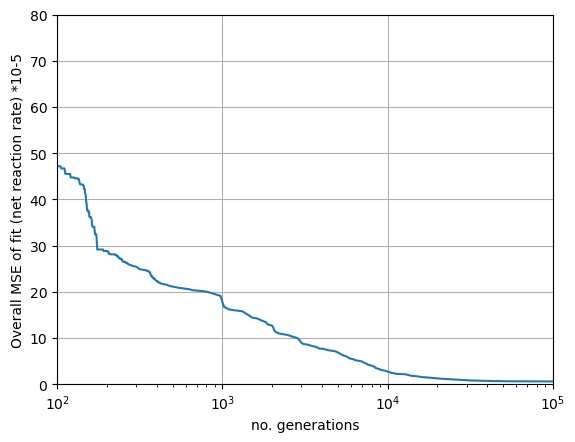

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.900793189322784
-8.401058980181146
-7.601516999421338
-8.800562426185273
-8.30167402627811
-7.108218170854261
-8.099222457578627
-10.35641093327707
-7.707549803976621
-6.806489995681798
-7.306811962898002
-8.004677292070756
-7.9084039857136545
-6.8049519374237875
-7.404942160274976
-7.408478914050915
-7.901388182847858
-9.09507047200397
-8.387962470038563
-6.503322774074647
-7.303357431203708
-6.717109915870055
-7.517223627543042
-11.964430160649567
-7.309598715573352
-7.809853848483129
-1.301029936684057


In [37]:
res.X

array([ -7.90079319,  -8.40105898,  -7.601517  ,  -8.80056243,
        -8.30167403,  -7.10821817,  -8.09922246, -10.35641093,
        -7.7075498 ,  -6.80649   ,  -7.30681196,  -8.00467729,
        -7.90840399,  -6.80495194,  -7.40494216,  -7.40847891,
        -7.90138818,  -9.09507047,  -8.38796247,  -6.50332277,
        -7.30335743,  -6.71710992,  -7.51722363, -11.96443016,
        -7.30959872,  -7.80985385,  -1.30102994])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.900793189322784
-8.4: -8.401058980181146
-7.6: -7.601516999421338
-8.8: -8.800562426185273
-8.3: -8.30167402627811
-7.1: -7.108218170854261
-8.1: -8.099222457578627
-10.9: -10.35641093327707
-7.7: -7.707549803976621
-6.8: -6.806489995681798
-7.3: -7.306811962898002
-8.0: -8.004677292070756
-7.9: -7.9084039857136545
-6.8: -6.8049519374237875
-7.4: -7.404942160274976
-7.4: -7.408478914050915
-7.9: -7.901388182847858
-9.1: -9.09507047200397
-8.4: -8.387962470038563
-6.5: -6.503322774074647
-7.3: -7.303357431203708
-6.7: -6.717109915870055
-7.5: -7.517223627543042
-11.8: -11.964430160649567
-7.3: -7.309598715573352
-7.8: -7.809853848483129
R-value: 0.9954200011752615
R2: 0.9908609787397578


In [1]:
# Use stored solution
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds

krseed1 = [ -7.90079319,  -8.40105898,  -7.601517  ,  -8.80056243,
        -8.30167403,  -7.10821817,  -8.09922246, -10.35641093,
        -7.7075498 ,  -6.80649   ,  -7.30681196,  -8.00467729,
        -7.90840399,  -6.80495194,  -7.40494216,  -7.40847891,
        -7.90138818,  -9.09507047,  -8.38796247,  -6.50332277,
        -7.30335743,  -6.71710992,  -7.51722363, -11.96443016,
        -7.30959872,  -7.80985385,  -1.30102994]
#np.ndarray.tolist(res.X)
krseed10 = [ -7.90076904,  -8.40104052,  -7.60153236,  -8.80031707,
        -8.30173774,  -7.10844332,  -8.09890714, -10.34385075,
        -7.70772973,  -6.8065014 ,  -7.30683968,  -8.00474404,
        -7.90846331,  -6.80491221,  -7.40490258,  -7.40846293,
        -7.90131395,  -9.09485813,  -8.3877817 ,  -6.50317361,
        -7.30320678,  -6.71688538,  -7.51700034, -11.98344924,
        -7.30931492,  -7.80956693,  -1.30102993]
krseed101 = [ -7.90075663,  -8.40101591,  -7.60149029,  -8.80032164,
        -8.30168658,  -7.10818478,  -8.09887129, -10.36357671,
        -7.70750257,  -6.80639909,  -7.30679939,  -8.00477323,
        -7.90854518,  -6.80461133,  -7.40459401,  -7.40799317,
        -7.9011024 ,  -9.09610251,  -8.38788349,  -6.50293564,
        -7.3029674 ,  -6.71553033,  -7.51563341, -11.99802315,
        -7.30855118,  -7.80877394,  -1.30102999]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9906361205957059
r: 0.9953070484004953
-7.900772953333333
-8.401038470000001
-7.6015132166666675
-8.80040038
-8.301699450000001
-7.10828209
-8.099000296666667
-10.354612796666666
-7.707594033333333
-6.806463496666667
-7.3068170100000005
-8.00473152
-7.908470826666666
-6.80482516
-7.404812916666667
-7.40831167
-7.901268176666666
-9.095343703333334
-8.387875886666667
-6.503144006666666
-7.303177203333334
-6.716508543333333
-7.516619126666666
-11.981967516666666
-7.30915494
-7.80939824


In [2]:
meankr

[-7.900772953333333,
 -8.401038470000001,
 -7.6015132166666675,
 -8.80040038,
 -8.301699450000001,
 -7.10828209,
 -8.099000296666667,
 -10.354612796666666,
 -7.707594033333333,
 -6.806463496666667,
 -7.3068170100000005,
 -8.00473152,
 -7.908470826666666,
 -6.80482516,
 -7.404812916666667,
 -7.40831167,
 -7.901268176666666,
 -9.095343703333334,
 -8.387875886666667,
 -6.503144006666666,
 -7.303177203333334,
 -6.716508543333333,
 -7.516619126666666,
 -11.981967516666666,
 -7.30915494,
 -7.80939824]

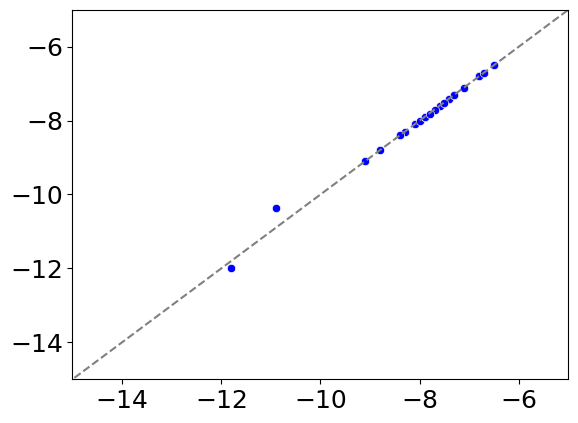

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, -5])
plt.ylim([-15, -5])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-24, 0], [-24, 0], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()